# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [12]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [13]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [14]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [15]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


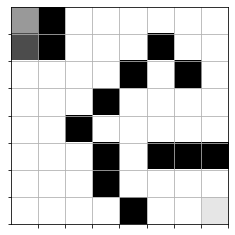

In [16]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [17]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [18]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [19]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [20]:
def show_maze(qmaze):
    maze_img = qmaze.draw_env()
    plt.imshow(maze_img, cmap='gray', vmin=0, vmax=1) # function to see our maze after the model has exhausted all steps
    plt.title('Maze after episode')
    plt.show()


def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon
    epsilon = 1.0
    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 64)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # pseudocode:
    # For each epoch:
    for epoch in range (n_epoch):
        free_cells = qmaze.free_cells.copy()
        Agent_cell = random.choice(free_cells)
        qmaze.reset(Agent_cell)
        envstate = qmaze.observe()
        max_steps = 500 # sets the max steps to avoid an infinite loop
        steps = 0
        while qmaze.game_status() != 'win' and steps < max_steps:
            steps += 1
            previous_envstate = envstate
            valid_actions = qmaze.valid_actions()
            if np.random.rand() < epsilon: # epsilon-greedy implementation
                action = random.choice(valid_actions)  
            else:
                q_values = model.predict(previous_envstate, verbose = 0)[0]
                q_values_filtered = [q_values[a] if a in valid_actions else -np.inf for a in range(4)]
                action = int(np.argmax(q_values_filtered))
               
            
            envstate, reward, game_status = qmaze.act(action)
            
            episode = [previous_envstate, action, reward, envstate, game_status]
            
            experience.remember(episode)
            inputs, target = experience.get_data(data_size = data_size)
            model.fit(inputs, target, epochs = 1, verbose = 0)
            loss = model.evaluate(inputs, target, verbose = 0)
            print("Loss: ", loss)
        if qmaze.game_status() == 'win': # adds a win to the win history
            win_history.append(1)
        else:
            win_history.append(0)
        recent_history = win_history[-hsize:]
        win_rate = sum(recent_history) / len(recent_history) #calculates win rate for the model
        n_episodes = epoch + 1
        epsilon = max(0.05, epsilon * 0.995)
        show_maze(qmaze) # displays the maze after the episode is done
        
        
            
    #    Agent_cell = randomly select a free cell
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
    #    While state is not game over:
    #        previous_envstate = envstate
    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    #        envstate, reward, game_status = qmaze.act(action)
    #    Hint: Review the act method in the TreasureMaze.py class.
    #        episode = [previous_envstate, action, reward, envstate, game_status]
    #        Store episode in Experience replay object
    #    Hint: Review the remember method in the GameExperience.py class.
    #        Train neural network model and evaluate loss
    #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
    #          to train the model. You can call model.evaluate to determine loss.
    #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.


    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    show(qmaze)
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

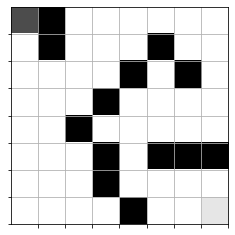

In [21]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

Loss:  0.00028229044983163476
Loss:  0.04005566984415054
Loss:  0.02907203696668148
Loss:  0.011467424221336842
Loss:  0.006136554758995771
Loss:  0.00994913000613451
Loss:  0.01459317747503519
Loss:  0.015354881063103676
Loss:  0.0161728635430336
Loss:  0.022512303665280342
Loss:  0.017537295818328857
Loss:  0.012261169962584972
Loss:  0.01037916075438261
Loss:  0.006276306696236134
Loss:  0.004705711267888546
Loss:  0.003927052021026611
Loss:  0.004405036568641663
Loss:  0.005449521820992231
Loss:  0.0064246030524373055
Loss:  0.007367572281509638
Loss:  0.0069440375082194805
Loss:  0.006205899640917778
Loss:  0.005031092092394829
Loss:  0.004226318094879389
Loss:  0.0034723111893981695
Loss:  0.003050265135243535
Loss:  0.003020236035808921
Loss:  0.0030222341883927584
Loss:  0.0030905569437891245
Loss:  0.00283828005194664
Loss:  0.0028278599493205547
Loss:  0.0025481642223894596
Loss:  0.003743951857993097
Loss:  0.004073678598027019
Loss:  0.013439048400947026


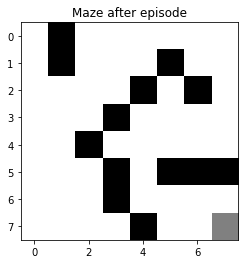

Epoch: 000/999 | Loss: 0.0134 | Episodes: 1 | Win count: 1 | Win rate: 1.000 | time: 2.4 seconds
Loss:  0.010990204962177409
Loss:  0.010374430976052946
Loss:  0.009871047161715595
Loss:  0.009579770920726541
Loss:  0.009080481436103582
Loss:  0.008834944174783985
Loss:  0.008804989934322379
Loss:  0.00883847150171912
Loss:  0.008254610340703617
Loss:  0.008214816647685237
Loss:  0.008072113724546913
Loss:  0.007740415964632276
Loss:  0.007600996837330361
Loss:  0.007235895455054635
Loss:  0.007247232794761658
Loss:  0.006989923287548271
Loss:  0.006809665606572078
Loss:  0.006712494277448024
Loss:  0.006562235627185415
Loss:  0.006351881114427339
Loss:  0.006197402120700904
Loss:  0.0060214536395250704
Loss:  0.005865758726501773
Loss:  0.0058792432478108145
Loss:  0.005587938552101453
Loss:  0.005464723089435061
Loss:  0.005718653060255512
Loss:  0.005772801049585853
Loss:  0.005671010818332434
Loss:  0.005582206300459802
Loss:  0.005574020207859576
Loss:  0.005467921495437622
Loss: 

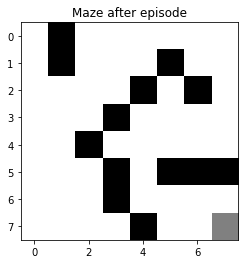

Epoch: 001/999 | Loss: 0.0046 | Episodes: 2 | Win count: 2 | Win rate: 1.000 | time: 34.8 seconds
Loss:  0.0024406285083387047


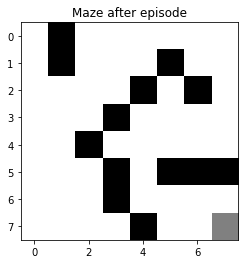

Epoch: 002/999 | Loss: 0.0024 | Episodes: 3 | Win count: 3 | Win rate: 1.000 | time: 35.1 seconds
Loss:  0.002644107327796519
Loss:  0.0008984593732748181
Loss:  0.007636300753802061
Loss:  0.0075621039140969515
Loss:  0.002753996872343123
Loss:  0.008493255823850632
Loss:  0.004102387872990221
Loss:  0.006961638107895851
Loss:  0.003606304177083075
Loss:  0.003985232440754771
Loss:  0.011470716504845768
Loss:  0.008154543582350016
Loss:  0.0026671073865145445
Loss:  0.001654085237532854
Loss:  0.0036372587783262134
Loss:  0.0024491245858371258
Loss:  0.0030769018922001123
Loss:  0.00614163582213223
Loss:  0.0072103895945474505
Loss:  0.0027572712278924882
Loss:  0.011219077045097947
Loss:  0.0026113893545698375
Loss:  0.009251669514924288
Loss:  0.002653143950738013
Loss:  0.0066686057252809405
Loss:  0.003739197738468647
Loss:  0.0075233784737065434
Loss:  0.0021977497963234782
Loss:  0.002187740115914494
Loss:  0.002425787504762411
Loss:  0.007013379305135459
Loss:  0.00125326571287

Loss:  0.0006293685000855476
Loss:  0.0010705689492169768
Loss:  0.000961175566771999
Loss:  0.0005863827536813915
Loss:  0.0007050132262520492
Loss:  0.0010379134328104556
Loss:  0.0005985764146316797
Loss:  0.00036468703183345497
Loss:  0.003329903935082257
Loss:  0.0006637157493969426
Loss:  0.0028589639987330884
Loss:  0.000931037386180833
Loss:  0.0008792513399384916
Loss:  0.0004520578368101269
Loss:  0.003240833175368607
Loss:  0.0007599525852128863
Loss:  0.0014301108312793076
Loss:  0.0007050691929180175
Loss:  0.0004674521478591487
Loss:  0.000444053701357916
Loss:  0.0006539195164805278
Loss:  0.0007342412136495113
Loss:  0.0009294767514802516
Loss:  0.0028592791059054434
Loss:  0.0007082662486936897
Loss:  0.003072544001042843
Loss:  0.0029228496132418513
Loss:  0.0007011315319687128
Loss:  0.0003376551394467242
Loss:  0.0030592801340389997
Loss:  0.00048026461445260793
Loss:  0.0004431158158695325
Loss:  0.002793938561808318
Loss:  0.00303345441352576
Loss:  0.000594407712

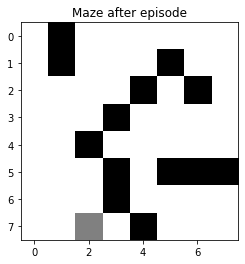

Epoch: 003/999 | Loss: 0.0013 | Episodes: 4 | Win count: 3 | Win rate: 0.750 | time: 111.0 seconds
Loss:  0.001246517349500209
Loss:  0.0008483261335641146
Loss:  0.0004281493602320552
Loss:  0.0003325268262415193


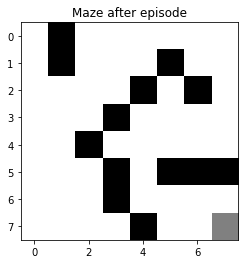

Epoch: 004/999 | Loss: 0.0003 | Episodes: 5 | Win count: 4 | Win rate: 0.800 | time: 111.9 seconds
Loss:  0.0004042179207317531
Loss:  0.0004589200107147917
Loss:  0.0013154417392797768
Loss:  0.0019588241702876985
Loss:  0.00010394926357548684
Loss:  0.00040981014899443835
Loss:  0.00013247681272332557
Loss:  0.0011385511315893382
Loss:  0.00024546693748561665
Loss:  0.0006520346796605736
Loss:  0.0006649302667938173
Loss:  0.0006708010369038675
Loss:  0.0002230556565336883
Loss:  6.781812589906622e-05
Loss:  0.0006925807683728635
Loss:  0.00020492419571382925
Loss:  0.0002615230259834789
Loss:  0.000695208553224802
Loss:  0.0003595490561565384
Loss:  0.0010115914046764374
Loss:  0.0014418978826142848
Loss:  0.00048451259135617875
Loss:  0.00039480297709815204
Loss:  0.00040342342981602997
Loss:  0.0010220732365269214
Loss:  0.00036970664223190397
Loss:  0.0009367604507133365
Loss:  0.0005379058566177264
Loss:  0.0011720503680408
Loss:  0.0016174149932339787
Loss:  0.00051943138532806

Loss:  3.2836070204211865e-05
Loss:  0.0005542850121855736
Loss:  0.00031336050233221613
Loss:  0.00026673002139432356
Loss:  5.186162161407992e-05
Loss:  0.0004462872166186571
Loss:  0.0007595844508614391
Loss:  0.00030158415029291064
Loss:  0.0012775829818565398
Loss:  0.00027167858206667006
Loss:  0.0002251803016406484
Loss:  0.0005189548101043329
Loss:  0.0005439094675239176
Loss:  0.0001341080424026586
Loss:  0.000423431396484375
Loss:  0.0005802548257634044
Loss:  0.000591572403209284
Loss:  0.0009011802612803876
Loss:  0.0003874676040140912
Loss:  0.0008199360891012475
Loss:  0.0003960249887313694
Loss:  0.0007594135822728276
Loss:  0.0002695616567507386
Loss:  0.000391024979762733
Loss:  0.00019794692525465507
Loss:  0.0005173193931113929
Loss:  0.0003477094287518412
Loss:  0.00033736665500327945
Loss:  0.0002623971304274164
Loss:  0.00010665504305507056
Loss:  0.00041671662620501593
Loss:  0.0003702447284013033
Loss:  0.0002852329853340052
Loss:  0.00035310981547809206
Loss:  

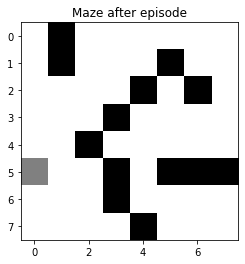

Epoch: 005/999 | Loss: 0.0001 | Episodes: 6 | Win count: 4 | Win rate: 0.667 | time: 190.7 seconds
Loss:  0.0004049776398460381
Loss:  1.7393304005963728e-05
Loss:  0.00018055584223475307
Loss:  0.0003774408978642896
Loss:  0.0008833023493934888
Loss:  0.00010978180944221094
Loss:  0.00019409293781791348
Loss:  0.00014524091602652334
Loss:  0.00034524848160799593
Loss:  0.000381857345928438
Loss:  0.0005837344360770658
Loss:  0.00027459052216727287
Loss:  0.00039098689740058035
Loss:  0.0006391124734363984
Loss:  0.0003462234180915402
Loss:  0.0002651254180818796
Loss:  0.0003576204180717468
Loss:  0.0004870798147749156
Loss:  0.00019353941206645686
Loss:  0.00033594059641472995
Loss:  2.657162258401513e-05
Loss:  0.00038766369107179344
Loss:  3.4280752515769564e-05
Loss:  0.000348195040714927
Loss:  4.116846866963897e-05
Loss:  0.0005846893764100969
Loss:  0.0005998832639306784
Loss:  0.00017794149152905447
Loss:  0.00043760775588452816
Loss:  0.00022979729146754835
Loss:  5.785955545

Loss:  3.9647666199016385e-05
Loss:  3.4576542930153664e-05
Loss:  0.000594914541579783
Loss:  0.00025347110931761563
Loss:  0.00022817014541942626
Loss:  5.862565740244463e-05
Loss:  0.00025838459259830415
Loss:  0.00037079837056808174
Loss:  0.00033280062780249864
Loss:  5.554673043661751e-05
Loss:  0.0004423759673954919
Loss:  0.0009167086391244084
Loss:  0.00026614844682626426
Loss:  0.00011228567018406466
Loss:  4.474806701182388e-05
Loss:  0.0006090063834562898
Loss:  0.00023982162019819953
Loss:  6.484987170551904e-05
Loss:  4.462012384465197e-05
Loss:  7.41427211323753e-05
Loss:  0.0005371461957111023
Loss:  0.0003576429662643932
Loss:  0.00023886865528766066
Loss:  0.00018972416182805318
Loss:  0.0004885605885647237
Loss:  8.001983587746508e-05
Loss:  0.00038894925819477066
Loss:  0.00017939164899871685
Loss:  0.0005458036321215332
Loss:  0.0004596205544658005
Loss:  0.0005635482229990885
Loss:  0.0005271303525660187
Loss:  0.00037634538603015244
Loss:  0.00036419958632905036


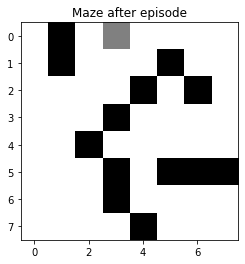

Epoch: 006/999 | Loss: 0.0005 | Episodes: 7 | Win count: 4 | Win rate: 0.571 | time: 264.9 seconds
Loss:  0.0008990163332782686
Loss:  0.0001008737162919715
Loss:  0.0005596750452241395
Loss:  0.00020083636627532542
Loss:  0.00015475498912564944
Loss:  0.0009227625268977135
Loss:  5.52857691218378e-05
Loss:  0.00018018104128714185
Loss:  0.0007090948638506234
Loss:  0.0006220850918907672
Loss:  0.00041623246943345293
Loss:  0.0006351374613586813
Loss:  0.0002699821397982305
Loss:  0.00021114057017257437
Loss:  0.0006391850183717906
Loss:  0.0006873203965369612
Loss:  0.0003698046784847975
Loss:  0.0006205902609508485
Loss:  0.0007694471278227866
Loss:  0.0006920968880876899
Loss:  0.0004189404135104269
Loss:  0.0003459408508206252
Loss:  0.00042372694952064194
Loss:  0.0009813802607823163
Loss:  0.0002290846277901437
Loss:  0.00066956682712771
Loss:  0.0004030312702525407
Loss:  0.0009526221838314086
Loss:  0.0003693764010677114
Loss:  0.0002470605068083387
Loss:  0.0001827009255066514

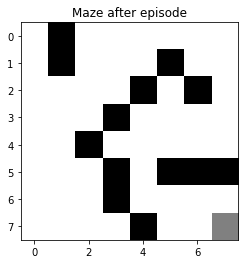

Epoch: 007/999 | Loss: 0.0026 | Episodes: 8 | Win count: 5 | Win rate: 0.625 | time: 276.8 seconds
Loss:  7.353186811087653e-05
Loss:  0.0005136691706866259
Loss:  0.0007917578477645293
Loss:  0.0007718159613432363
Loss:  0.00039630429819226265
Loss:  0.0006284200062509626
Loss:  0.0003980059700552374
Loss:  0.002359751844778657
Loss:  0.0009832530049607158
Loss:  0.0028419269947335124
Loss:  0.000571812444832176
Loss:  0.0005034377754782327
Loss:  0.0006422587030101568
Loss:  0.00037082212656969205
Loss:  0.0006250482110772282
Loss:  0.0006986907974351197
Loss:  0.0004268295888323337
Loss:  0.0004712068766821176
Loss:  9.421353752259165e-05
Loss:  0.00022980112407822162
Loss:  0.0003435431863181293
Loss:  5.569864697463345e-05
Loss:  0.0007014958682702854
Loss:  0.0020614758250303566
Loss:  0.0002194416374550201
Loss:  0.000404341597459279
Loss:  0.0009966487414203584
Loss:  0.00032734355045249686
Loss:  0.0009706055279821157
Loss:  0.00034795340616256
Loss:  0.0005344114470062777
Los

Loss:  0.00032181730784941465
Loss:  0.0006660343060502782
Loss:  0.00102366937790066
Loss:  0.0007083052769303322
Loss:  0.0004163857302046381
Loss:  0.0010623561684042215
Loss:  0.0006272788159549236
Loss:  0.0005613919347524643
Loss:  0.0002769920538412407
Loss:  0.00039948970152181573
Loss:  0.001816344738472253
Loss:  0.0005074456494185142
Loss:  0.0007130563026294112
Loss:  0.0009972026673494838
Loss:  0.0003666973934741691
Loss:  0.0008720469195395708
Loss:  0.0007178331725299358
Loss:  0.001313855143962428
Loss:  0.001333636260824278
Loss:  0.0006147804961074144
Loss:  0.0004408720924402587
Loss:  0.0008584055467508733
Loss:  0.0007204930589068681
Loss:  0.00021332440519472584
Loss:  0.000466438323201146
Loss:  0.00040868403448257595
Loss:  0.0017808666452765465
Loss:  0.0009816636447794735
Loss:  0.00044182618148624897
Loss:  0.0011005699052475393
Loss:  0.0017803591908887029
Loss:  0.0006319146486930549
Loss:  0.00044789467938244343
Loss:  0.0003573388239601627
Loss:  0.00042

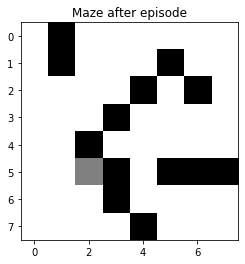

Epoch: 008/999 | Loss: 0.0005 | Episodes: 9 | Win count: 5 | Win rate: 0.556 | time: 362.3 seconds
Loss:  0.0006401205464499071
Loss:  0.00039968443161342293
Loss:  0.00014762646969757043
Loss:  0.0008575599640607834
Loss:  0.0008130278438329697
Loss:  0.00034616136690601707
Loss:  0.00036979814467485994
Loss:  0.0009388813632540405
Loss:  0.0007200710606412031
Loss:  0.0007282476872205734
Loss:  0.0011245095811318606
Loss:  0.00045051725464873016
Loss:  0.0007447983953170478
Loss:  0.0009349777828902006
Loss:  0.00027002130809705704
Loss:  0.00020343262440292165
Loss:  0.0006606462993659079
Loss:  0.0003990534278273117
Loss:  0.0009316234500147402
Loss:  0.0005743386718677357
Loss:  0.0005924525175942108
Loss:  0.00036954104143660516
Loss:  0.0007850292604416609
Loss:  0.0003090611280640587
Loss:  0.00041476526530459523
Loss:  0.0005296886520227417
Loss:  7.572815593448468e-05
Loss:  0.0005309986736392602
Loss:  0.0004316775593906641
Loss:  0.0011888989247381687
Loss:  0.0007092180603

Loss:  0.0006038917927071452
Loss:  0.0008645759953651577
Loss:  0.0004973241011612117
Loss:  0.00047868205001577735
Loss:  0.0007893777365097776
Loss:  0.0006477020506281406
Loss:  0.0005838676879648119
Loss:  0.0006936090940143913
Loss:  0.00031963613582774997
Loss:  0.0005648716178257018
Loss:  0.0006525816570501775
Loss:  0.0005381974624469876
Loss:  0.00023584282462252304
Loss:  0.0006095258722780272
Loss:  0.0005210825329413638
Loss:  0.0006339316314551979
Loss:  0.0009568474488332868
Loss:  0.0005964426381979138
Loss:  0.0010826081852428615
Loss:  0.0004285092727513984
Loss:  0.00046023651520954445
Loss:  0.0009293589682783931
Loss:  0.0007177129155024886
Loss:  0.000735554815037176
Loss:  0.000600623432546854
Loss:  0.0008014618651941419
Loss:  0.00031488374224863946
Loss:  0.000466708283056505
Loss:  0.00037771743518533185
Loss:  0.00022407584765460342
Loss:  0.0003381421120138839
Loss:  0.0003823946899501607
Loss:  0.0006997068121563643
Loss:  0.0005570398061536252
Loss:  0.0

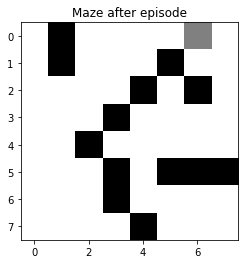

Epoch: 009/999 | Loss: 0.0010 | Episodes: 10 | Win count: 5 | Win rate: 0.500 | time: 7.59 minutes
Loss:  0.0003540485195117071
Loss:  0.00042522720468696207
Loss:  0.0009016040712594986
Loss:  0.0008828743011690676
Loss:  0.00036127444764133543
Loss:  0.0009724741685204208
Loss:  0.0003577376337489113
Loss:  0.0007616049551870674
Loss:  0.0005561727157328278
Loss:  0.00028035789728164673
Loss:  0.0007381625036941841
Loss:  0.0011362354853190482
Loss:  0.0006683039828203619
Loss:  0.0005430048622656614
Loss:  0.0006857966945972294
Loss:  0.0009263441315852106
Loss:  0.0007010312983766198
Loss:  0.0006027047347743064
Loss:  0.0004576140345307067
Loss:  0.0007092310406733304
Loss:  0.00027359722298569977
Loss:  0.0004243902876623906
Loss:  0.0005532929499167949
Loss:  0.0007323452446144074
Loss:  0.0007887839456088841
Loss:  0.0006437889896915294
Loss:  0.0006460878357756883
Loss:  0.0007084275421220809
Loss:  0.0006749621534254402
Loss:  0.0008774315938353539
Loss:  0.000784738804213702

Loss:  0.0006639353669015691
Loss:  0.00034595913894008845
Loss:  0.0006300577078945935
Loss:  0.0002699051347008208
Loss:  0.0004275725223124027
Loss:  0.0005091971688671038
Loss:  0.0002397136704530567
Loss:  0.00042696639138739556
Loss:  0.0005316890892572701
Loss:  0.00029471958987414837
Loss:  0.00021667304463335313
Loss:  0.0006391753122443333
Loss:  0.00022028723469702527
Loss:  8.875496496330015e-05
Loss:  0.00039211963303387165
Loss:  0.00028555007884278893
Loss:  0.00039658029709244147
Loss:  0.00027638742540148087
Loss:  0.0004692004295065999
Loss:  0.0005213478725636378
Loss:  0.0003620191382651683
Loss:  0.00011770978744607419
Loss:  0.0008797238260740414
Loss:  0.0005172668606974185
Loss:  0.00025755318347364664
Loss:  0.00035122389817843214
Loss:  0.00038078213401604444
Loss:  0.00020052288527949713
Loss:  7.040439595584758e-05
Loss:  0.0005319335323292762
Loss:  0.0005130318604642525
Loss:  0.0007404074785881676
Loss:  0.0003601350872486364
Loss:  0.00019017188060388435

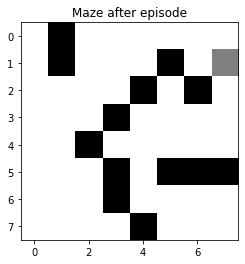

Epoch: 010/999 | Loss: 0.0004 | Episodes: 11 | Win count: 5 | Win rate: 0.455 | time: 9.15 minutes
Loss:  0.00019456524751149118
Loss:  2.7405942091718316e-05
Loss:  1.2853472981078085e-05
Loss:  0.00033342529786750674
Loss:  0.00020896321075269952
Loss:  0.00040034318226389587
Loss:  0.00016695830709068105
Loss:  0.00013590669732366223
Loss:  0.00019373120994714554
Loss:  7.5867596933676396e-06
Loss:  0.00018817977979779243
Loss:  0.00014898292465659324
Loss:  0.0002986035688081756
Loss:  0.00055034774413798
Loss:  3.194823148078285e-05
Loss:  0.0002827872431225842
Loss:  2.5112259208981413e-05
Loss:  0.00018756609370029764
Loss:  1.758300959409098e-05
Loss:  6.971693437662907e-06
Loss:  0.0005012289620935917
Loss:  0.00036439974792301655
Loss:  0.00021810629732499365
Loss:  0.00021660912534571253
Loss:  3.631909203249961e-05
Loss:  1.4513413589156698e-05
Loss:  0.00017756357374310028
Loss:  8.517206879332662e-06
Loss:  0.00018274199828738347
Loss:  6.448641215683892e-06
Loss:  0.0001

Loss:  0.0001714476147753885
Loss:  0.0003444651865720516
Loss:  0.00018579730749479495
Loss:  0.00045168265933170915
Loss:  0.0003422075242269784
Loss:  0.00015411423373734578
Loss:  0.0003005582984769717
Loss:  0.00031058210879564285
Loss:  0.0003421736182644963
Loss:  0.0003216878067178186
Loss:  0.00017090298570110463
Loss:  0.00047378770250361413
Loss:  0.00035535023562260903
Loss:  0.00032603228464722633
Loss:  0.00020182671141810715
Loss:  0.0003072545223403722
Loss:  0.00019813600556517486
Loss:  0.0003342788404552266
Loss:  0.00031649082666262984
Loss:  2.6743864964373643e-05
Loss:  0.00016714719095034525
Loss:  1.8327032194065396e-05
Loss:  0.00045815706835128367
Loss:  0.00033043969597201794
Loss:  0.00028783833113266155
Loss:  0.00017534253129269928
Loss:  0.00017319349353783764
Loss:  0.0003655382024589926
Loss:  0.00021768152873846702
Loss:  0.00043951402767561376
Loss:  2.211468654422788e-05
Loss:  0.00018751455536403228
Loss:  1.2170768968644552e-05
Loss:  0.00029988205

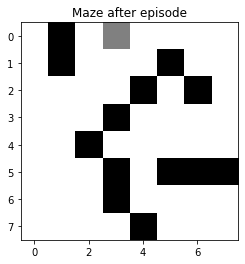

Epoch: 011/999 | Loss: 0.0000 | Episodes: 12 | Win count: 5 | Win rate: 0.417 | time: 10.98 minutes
Loss:  0.000381200821720995
Loss:  0.00033869623439386487
Loss:  0.00020083808885829058
Loss:  2.6002036975114606e-05
Loss:  0.0004888318799203262
Loss:  0.0007010811968939379
Loss:  0.0004486779944272712
Loss:  0.00023729829263174906
Loss:  0.0006328903400572017
Loss:  0.0005158751591807231
Loss:  0.0002146870901924558
Loss:  0.0006487474456662312
Loss:  0.00020319582836236805
Loss:  0.00046328018288477324
Loss:  0.0006001272558933124
Loss:  0.00024409459729213268
Loss:  0.0002725466729316395
Loss:  0.00043660978553816676
Loss:  0.0005383605021052063


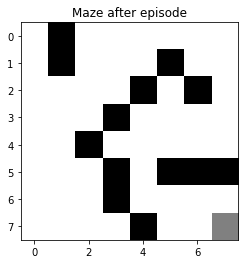

Epoch: 012/999 | Loss: 0.0005 | Episodes: 13 | Win count: 6 | Win rate: 0.462 | time: 11.06 minutes
Loss:  0.002702072379179299
Loss:  0.0017333822906948626
Loss:  0.0013734690146520734
Loss:  0.0007353626133408397
Loss:  0.01442732335999608
Loss:  0.00839311140589416
Loss:  0.005340277217328548
Loss:  0.010790616739541292
Loss:  0.0013266319874674082
Loss:  0.0013503206428140402
Loss:  0.00500626809662208
Loss:  0.0011834483593702316
Loss:  0.0006979921599850059
Loss:  0.0013917800970375538
Loss:  0.0004223806317895651
Loss:  0.00044287835771683604
Loss:  0.0006848357443232089
Loss:  0.0004893757286481559
Loss:  0.0005251334223430604
Loss:  0.000711391243385151
Loss:  0.0010168145527131855
Loss:  0.0007147264550440013
Loss:  0.004591265314957127
Loss:  0.0007831529073882848
Loss:  0.0010542935924604535
Loss:  0.0007321776356548071
Loss:  0.0005646954450639896
Loss:  0.00046621377987321466
Loss:  0.004615559126250446
Loss:  0.004525768454186618
Loss:  0.0010058822808787227
Loss:  0.000

Loss:  0.00023665698245167732
Loss:  0.0006337702216114849
Loss:  0.0006082621985115111
Loss:  0.00041537619836162776
Loss:  0.00033576093846932054
Loss:  0.0009086446953006089
Loss:  0.0002603714383440092
Loss:  0.0006089239032007754
Loss:  0.0006166546227177605
Loss:  0.0026091691106557846
Loss:  0.0009782378474483266
Loss:  0.00046340670087374747
Loss:  0.0006795297958888113
Loss:  0.0007341675809584558
Loss:  0.0006759542447980493
Loss:  0.00043245287088211626
Loss:  0.0005835654737893492
Loss:  0.0005031229666201398
Loss:  0.001030863990308717
Loss:  0.000660342731862329
Loss:  0.0008958944818004966
Loss:  0.000513552877237089
Loss:  0.0004432676614669617
Loss:  0.0006029871292412281
Loss:  0.000811287056421861
Loss:  0.00047042156802490354
Loss:  0.0005540159181691706
Loss:  0.00041761812462937087
Loss:  0.000783002469688654
Loss:  0.0003795547818299383
Loss:  0.0005739067273680121
Loss:  0.000734091765480116
Loss:  0.000672123147523962
Loss:  0.0003935494023608044
Loss:  0.00233

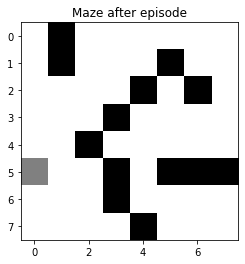

Epoch: 013/999 | Loss: 0.0004 | Episodes: 14 | Win count: 6 | Win rate: 0.429 | time: 12.59 minutes
Loss:  0.00043434499093564227
Loss:  0.002118400443578139
Loss:  0.00020682694594142959
Loss:  0.0003850068023893982
Loss:  0.0005850108427694067
Loss:  0.00041153657366521657
Loss:  0.0005349453713279217
Loss:  0.000178210211743135
Loss:  0.002096366893965751
Loss:  0.0005836369819007814
Loss:  0.0005455821810755879
Loss:  0.00017527301679365337
Loss:  0.0007077782647684216
Loss:  0.0008805881370790303
Loss:  0.0004167976585449651
Loss:  0.0005774531164206564
Loss:  0.0004084818938281387
Loss:  0.000290012623736402
Loss:  0.0005801526422146708
Loss:  0.0003391800128156319
Loss:  0.0004507824487518519


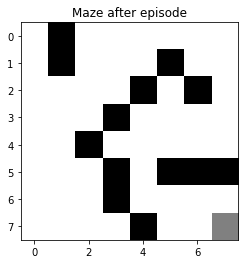

Epoch: 014/999 | Loss: 0.0005 | Episodes: 15 | Win count: 7 | Win rate: 0.467 | time: 12.65 minutes
Loss:  0.0009448282944504172
Loss:  0.00037461261672433466


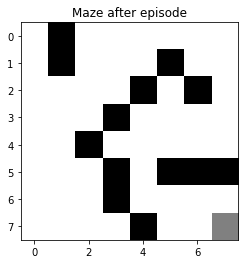

Epoch: 015/999 | Loss: 0.0004 | Episodes: 16 | Win count: 8 | Win rate: 0.500 | time: 12.66 minutes
Loss:  0.0018288666033186018
Loss:  0.0003820218189503066
Loss:  0.0006839015404693782
Loss:  0.00025221587566193193
Loss:  0.0007818040903657675
Loss:  0.0008423035615123808
Loss:  0.0006820822309236974
Loss:  0.0007808856607880443
Loss:  0.0008912338525988162
Loss:  0.0016963211819529533
Loss:  0.0008510907646268606
Loss:  0.0004736757400678471
Loss:  0.0006899769032315817


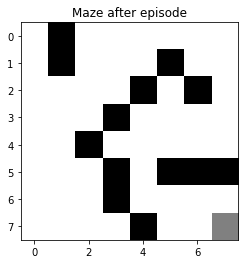

Epoch: 016/999 | Loss: 0.0007 | Episodes: 17 | Win count: 9 | Win rate: 0.529 | time: 12.69 minutes
Loss:  0.0017518552485853434
Loss:  0.0006957073928788304
Loss:  0.0009614011214580387
Loss:  0.0004509232094278559
Loss:  0.0006884757749503478
Loss:  0.0001586905818840023
Loss:  0.0015497891581617296
Loss:  0.0007534479955211282
Loss:  0.005907537706661969
Loss:  0.001100192341255024
Loss:  0.0015974957204889506
Loss:  0.0020237936405465007
Loss:  0.0004193994973320514
Loss:  0.005708512733690441
Loss:  0.0016848694649524987
Loss:  0.0010836271685548127
Loss:  0.0006327067967504263
Loss:  0.0008291310514323413
Loss:  0.0007871431880630553
Loss:  0.0004047161928610876
Loss:  0.001402566245815251
Loss:  0.00029927528157713823
Loss:  0.000820699060568586
Loss:  0.00011491541044961195
Loss:  0.0007865022926125675
Loss:  0.000607471345574595
Loss:  0.0005323867371771485
Loss:  0.0008065036963671446
Loss:  0.001736105652526021
Loss:  0.005662219948135316
Loss:  0.0015588776441290975
Loss:  

Loss:  0.001016827067360282
Loss:  0.0003495478886179626
Loss:  0.002323579858057201
Loss:  0.00021535036648856476
Loss:  0.0006191508146002889
Loss:  0.0022795950062572956
Loss:  0.002422719990136102
Loss:  0.00047968222497729585
Loss:  0.000494273888762109
Loss:  0.0005497180682141334
Loss:  0.00037126729148440063
Loss:  0.0003708494332386181
Loss:  0.0004790607781615108
Loss:  0.000869140203576535
Loss:  0.00020360638882266358
Loss:  0.0006024858157616109
Loss:  0.0008226808859035373
Loss:  0.0005989166820654646
Loss:  0.0005489094328368083
Loss:  0.00010448784087202512
Loss:  0.0007935557514429092
Loss:  0.0005475865909829736
Loss:  0.0006018267740728334
Loss:  0.002647761721163988
Loss:  0.0003999638429377228
Loss:  0.0004993666370864958
Loss:  0.0007564361148979515
Loss:  0.0005492081836564466
Loss:  0.00038727674836991355
Loss:  0.0005470273172250018
Loss:  0.0003353120991960168
Loss:  0.0006958585581742227
Loss:  0.0003371141792740673
Loss:  0.0006032138480804861
Loss:  0.00107

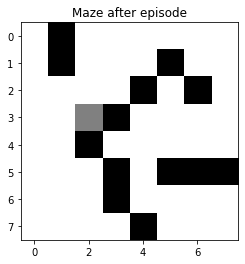

Epoch: 017/999 | Loss: 0.0007 | Episodes: 18 | Win count: 9 | Win rate: 0.500 | time: 13.98 minutes
Loss:  0.00026378427719464526
Loss:  0.0013400240277405828
Loss:  0.0012515978887677193
Loss:  0.0008521486888639629
Loss:  0.0007837835873942822
Loss:  0.0019174158514942974
Loss:  0.0004882569919573143
Loss:  0.0004443543730303645
Loss:  0.00040912894473876804
Loss:  0.000424293129981379
Loss:  0.00042025338916573673
Loss:  0.00042382365791127086
Loss:  0.0002465166435285937
Loss:  0.0008406022097915411
Loss:  0.00036602423642762005
Loss:  0.0009021998266689479
Loss:  0.0008059678075369447
Loss:  0.0002502239076420665
Loss:  0.0006276537897065282
Loss:  0.0005671475664712489
Loss:  0.00047726399498060346
Loss:  0.00015171101222222205
Loss:  0.0008664312190376222
Loss:  0.0009480707230977714
Loss:  0.00029834494125680067
Loss:  0.00031875722197582945
Loss:  0.0002702781348489225
Loss:  0.0003660725196823478
Loss:  0.0005474001809488982
Loss:  0.0003076703505939804
Loss:  0.0001636504148

Loss:  0.0006769309693481773
Loss:  0.00015804683789610863
Loss:  0.0002805435433401726
Loss:  0.0006961340259294957
Loss:  0.0002666333894012496
Loss:  0.00038139597745612264
Loss:  0.00057539927365724
Loss:  0.00032844072302395944
Loss:  8.793726010480896e-05
Loss:  0.0002565273352956865
Loss:  6.866895273560658e-05
Loss:  0.000992890214547515
Loss:  0.0004942755767842755
Loss:  0.0004781788738910109
Loss:  9.186655370285735e-05
Loss:  0.00022103311493992805
Loss:  0.00022656962391920388
Loss:  0.00010955556354019791
Loss:  0.0004564022965496406
Loss:  0.0007664352597203106
Loss:  0.000780703077907674
Loss:  0.000684362486936152
Loss:  0.00023424803657690063
Loss:  0.0009663259697845206
Loss:  0.0003117920132353902
Loss:  0.0007084250100888312
Loss:  0.00010143193139811046
Loss:  0.000526642455952242
Loss:  0.0006778179667890072
Loss:  0.00032405117235612124
Loss:  0.0005755746824434027
Loss:  0.000359929366823053
Loss:  0.0007687519682804123
Loss:  0.00028519566694740206
Loss:  0.00

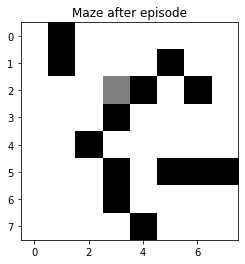

Epoch: 018/999 | Loss: 0.0004 | Episodes: 19 | Win count: 9 | Win rate: 0.474 | time: 15.32 minutes
Loss:  0.0009418440167792141
Loss:  0.00017997557733906433
Loss:  0.0004493810556596145
Loss:  0.000374628187273629
Loss:  0.00020888382277917117
Loss:  0.00020896497881039977
Loss:  0.0002484357755747624
Loss:  4.6058032239670865e-05
Loss:  0.00020788121037185192
Loss:  0.00022749331037630327
Loss:  0.0007266536704264581
Loss:  0.0005468767631100491
Loss:  5.014660564484075e-05
Loss:  0.0008093940559774637
Loss:  0.00046309741446748376
Loss:  0.0002382748352829367
Loss:  0.0007344005134655163
Loss:  0.00023202977899927646
Loss:  0.0003713886599143734
Loss:  0.00039732996083330363
Loss:  0.0007182115223258734
Loss:  0.0001824913160817232
Loss:  0.0005192445241846144
Loss:  0.00042638018203433603
Loss:  0.00023305684953811578
Loss:  4.865738264925312e-05
Loss:  0.00032461721275467426
Loss:  0.00021152028784854338
Loss:  0.0006019046413712204
Loss:  0.00021878874395042658
Loss:  0.00021294

Loss:  0.0002018986633629538
Loss:  0.00030227252864278853
Loss:  0.0002338313643122092
Loss:  0.0004727914492832497
Loss:  0.000160473573487252
Loss:  0.0002562110166763887
Loss:  0.0003587804403650807
Loss:  0.0006507327198050916
Loss:  4.404952778713778e-05
Loss:  7.301830919459462e-05
Loss:  0.0006065054330974817
Loss:  0.00032193647348321974
Loss:  0.00024339530864381231
Loss:  0.0003618166083469987
Loss:  0.00039771810406818986
Loss:  0.00011145400640089065
Loss:  0.0004846424562856555
Loss:  0.00010780109187180642
Loss:  0.0003492086980259046
Loss:  0.00023725390201434493
Loss:  0.00043966129305772483
Loss:  0.00030116247944533825
Loss:  7.254094089148566e-05
Loss:  9.187794421450235e-05
Loss:  0.0002021847540163435
Loss:  0.0001949809338839259
Loss:  0.00024316523922607303
Loss:  0.0005102287832414731
Loss:  0.00036319934588391334
Loss:  6.534276690217666e-05
Loss:  5.3107803978491575e-05
Loss:  0.0005233714473433793
Loss:  0.00019839187189063523
Loss:  0.0007576184434583411
Lo

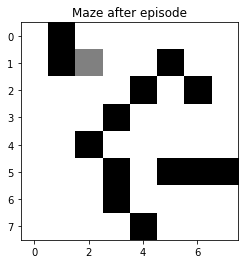

Epoch: 019/999 | Loss: 0.0002 | Episodes: 20 | Win count: 9 | Win rate: 0.450 | time: 16.67 minutes
Loss:  0.00018558821284386795
Loss:  0.0002095509262289852
Loss:  0.0003929787053493783
Loss:  0.000708152336301282
Loss:  0.00025103381267399527
Loss:  0.0004977392818545923
Loss:  0.00035159429171471857
Loss:  5.814910582557786e-05
Loss:  0.0003115881172561785
Loss:  0.0004171131040493492
Loss:  0.0003253974991821451
Loss:  5.152217818249483e-05
Loss:  0.0006442829180741683
Loss:  0.0004855592123931274
Loss:  0.00024016909446800128
Loss:  0.0004817119042854756
Loss:  4.569164229906164e-05
Loss:  5.672225233865902e-05
Loss:  0.0003397638211026788
Loss:  0.00017262281471630558
Loss:  0.00035541159013519064
Loss:  0.00020651570957852527
Loss:  0.0002819633318722481
Loss:  0.00011948728115385165
Loss:  0.0003540374309523031
Loss:  0.0004321965971030295
Loss:  3.9429629396181554e-05
Loss:  0.0003153413999825716
Loss:  0.0002225609714514576
Loss:  2.8285182452236768e-05
Loss:  0.000368023805

Loss:  0.0004991367604816332
Loss:  0.00016974964455584995
Loss:  0.00023405665524478536
Loss:  4.151687062403653e-05
Loss:  0.0003503577900119126
Loss:  6.887669042043854e-05
Loss:  0.0003364758158568293
Loss:  3.209528949810192e-05
Loss:  0.00033567615173524246
Loss:  4.927513600705424e-05
Loss:  0.0002469003520673141
Loss:  0.0002303221626789309
Loss:  0.0005158253625268117
Loss:  0.00022124224778963253
Loss:  5.059598515799735e-05
Loss:  0.0001951986914718873
Loss:  0.00037101408815942705
Loss:  0.00019338493621035013
Loss:  6.017691339366138e-05
Loss:  0.00014224999904399738
Loss:  0.00038116518044262193
Loss:  0.0001863542365754256
Loss:  3.885352816723753e-05
Loss:  0.00018983219115398242
Loss:  0.0002991478768308298
Loss:  0.00021255893443594687
Loss:  0.00030984278782852925
Loss:  0.0004818822635570541
Loss:  5.293572030495852e-05
Loss:  5.0460184866096824e-05
Loss:  4.439100484887604e-05
Loss:  4.8390531446784735e-05
Loss:  0.00020062375551788136
Loss:  4.555375380732585e-05


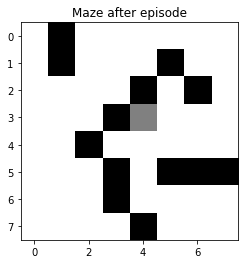

Epoch: 020/999 | Loss: 0.0002 | Episodes: 21 | Win count: 9 | Win rate: 0.429 | time: 17.96 minutes
Loss:  1.7942114936886355e-05
Loss:  0.00035270454736746615
Loss:  0.00018016934336628765
Loss:  0.000311631238218979
Loss:  1.983861693588551e-05
Loss:  0.00033285080644418485
Loss:  9.942632686943398e-06
Loss:  0.0002912715499405749
Loss:  0.0005061790288891643
Loss:  0.00017671575733402278
Loss:  0.0005172576784389094
Loss:  0.0003489125956548378
Loss:  0.00020390915778989438
Loss:  0.00036446607919060625
Loss:  0.00044271368824411184
Loss:  0.00018732371790974867
Loss:  0.0002849654702004045
Loss:  0.00046659594227094203
Loss:  0.0008301054476760328
Loss:  0.00018699067186389584
Loss:  0.0004199037066427991
Loss:  3.4940545447170734e-05
Loss:  0.00036622470361180604
Loss:  0.0004695519164670259
Loss:  0.0005283605132717639
Loss:  0.00018858660223486368
Loss:  0.00018891002582677174
Loss:  0.00016735851022531278
Loss:  0.00015470706875930773
Loss:  1.4425304470933042e-05
Loss:  0.0003

Loss:  0.0001657744523981819
Loss:  0.000450337742222473
Loss:  5.162829802429769e-05
Loss:  0.00042437957199581433
Loss:  0.000185286580290267
Loss:  2.925030275946483e-05
Loss:  0.00047141671529971063
Loss:  0.00032402049691881984
Loss:  0.0003762256819754839
Loss:  0.00014126631322142202
Loss:  0.00046669548100908287
Loss:  0.0003857860137941316
Loss:  0.0003017436247318983
Loss:  0.0004180086252745241
Loss:  0.0007174922648118809
Loss:  0.0004801287577720359
Loss:  0.000203181440156186
Loss:  0.00020580853743012995
Loss:  0.0004160487878834829
Loss:  0.00017544851198181277
Loss:  0.0005344439123291522
Loss:  2.536636657168856e-05
Loss:  4.591563447320368e-05
Loss:  0.00035862132790498435
Loss:  0.0002585117908893153
Loss:  0.00043292492046020925
Loss:  0.00018251586334372405
Loss:  0.0004548454162431881
Loss:  0.00019058356338064186
Loss:  0.00024255739117506891
Loss:  0.0006388220499502495
Loss:  0.0004279147869965527
Loss:  0.000383179823984392
Loss:  0.0007605637656524777
Loss: 

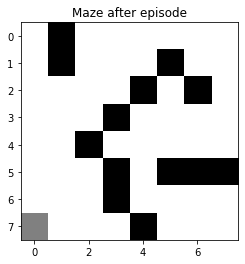

Epoch: 021/999 | Loss: 0.0003 | Episodes: 22 | Win count: 9 | Win rate: 0.409 | time: 19.24 minutes
Loss:  0.00044484691170509905
Loss:  0.0004588404844980687
Loss:  0.00019533615704858676
Loss:  0.0006058276048861444
Loss:  0.00034046071232296526
Loss:  0.00031668895098846406


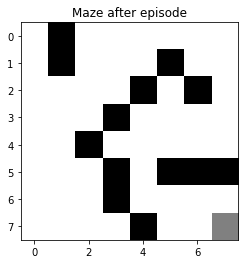

Epoch: 022/999 | Loss: 0.0003 | Episodes: 23 | Win count: 10 | Win rate: 0.435 | time: 19.26 minutes
Loss:  0.0007390948303509504
Loss:  0.0005588046042248607
Loss:  0.0004949904723616783
Loss:  5.7079076213994995e-05
Loss:  0.00056826340733096
Loss:  0.0026219016217510216
Loss:  0.0004102238453924656
Loss:  0.0007267298642545938
Loss:  0.00014235929847927764
Loss:  0.0025476625305600464
Loss:  0.0009753047488629818
Loss:  0.0007856514712329954
Loss:  0.0008158195705618709
Loss:  0.0005857953001395799
Loss:  0.0005066596786491573
Loss:  0.00020849327484029345
Loss:  0.00019867484661517665
Loss:  0.0007033330039121211
Loss:  9.282652172259986e-05
Loss:  0.0011207616771571338
Loss:  0.00037032662658020854
Loss:  0.0004894215708191041
Loss:  0.0007298122836800758
Loss:  0.0005276355077512562
Loss:  0.000642987375613302
Loss:  0.0003343588177813217
Loss:  0.0005717174208257347
Loss:  0.0008195118280127645
Loss:  0.0006321008258964866
Loss:  0.0003173239510942949
Loss:  0.002866930095478892

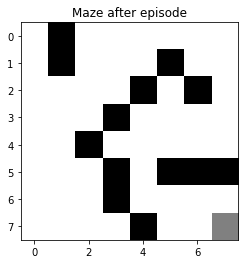

Epoch: 023/999 | Loss: 0.0019 | Episodes: 24 | Win count: 11 | Win rate: 0.458 | time: 19.39 minutes
Loss:  0.00038168537139426917
Loss:  0.00032406226091552526
Loss:  0.00043887298670597374
Loss:  0.0006051081290934235
Loss:  0.0006529693928314373
Loss:  0.0007321626908378676
Loss:  0.0009611675341147929
Loss:  0.00029640043794643134
Loss:  0.0012499308795668185
Loss:  0.001680495603068266
Loss:  0.0008424374682363123
Loss:  0.0014400699874386191
Loss:  0.0006459378055296838
Loss:  0.0005978580156806856
Loss:  0.0004209085091133602
Loss:  0.0007700548449065536
Loss:  0.0007217922830022871
Loss:  0.000502630602568388
Loss:  0.0020177337573841214
Loss:  0.00045155179395806044
Loss:  0.00048814070760272443
Loss:  0.0009450067300349474
Loss:  0.0006345677538774908
Loss:  0.0007386727666016668
Loss:  0.0013110267464071512
Loss:  0.000677724281558767
Loss:  0.0006402703293133527
Loss:  0.00038083527761045843
Loss:  0.0004362854815553874
Loss:  0.0005706981246476062
Loss:  0.0008476232469547

Loss:  0.0003474189179542009
Loss:  0.0011384465324226767
Loss:  0.0007019590411800891
Loss:  0.0005889070889679715
Loss:  0.000522929651197046
Loss:  0.0006982493214309216
Loss:  0.0005410482699517161
Loss:  0.0006543870840687305
Loss:  0.000230059347813949
Loss:  0.000298186485451879
Loss:  0.0006461479933932424
Loss:  0.0004621899570338428
Loss:  0.00020116377709200606
Loss:  0.0006377723912009969
Loss:  0.0003892432141583413
Loss:  0.0003884387988364324
Loss:  0.00025239957903977484
Loss:  0.0004506901605054736
Loss:  0.0004643358988687396
Loss:  0.0005901182594243437
Loss:  0.00044387870002537966
Loss:  0.0002571780714788474
Loss:  0.0004374193958938122
Loss:  0.0004528188583208248
Loss:  4.067023655807134e-05
Loss:  0.00044244309538044035
Loss:  0.0003159665939165279
Loss:  0.0004957279743393883
Loss:  0.00029705573251703754
Loss:  0.0003183518929290585
Loss:  0.00016648241671646247
Loss:  0.00030975151457823813
Loss:  0.00022642812837148085
Loss:  0.00023531313490821049
Loss:  0

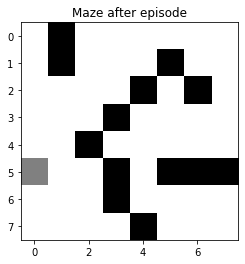

Epoch: 024/999 | Loss: 0.0005 | Episodes: 25 | Win count: 11 | Win rate: 0.440 | time: 20.80 minutes
Loss:  0.00021530523372348398
Loss:  0.0005068615428172052
Loss:  0.0003975069266743958
Loss:  0.00024223879154305905
Loss:  0.0005611077649518847
Loss:  0.0003213104500900954
Loss:  0.00013612431939691305
Loss:  3.191535779478727e-05
Loss:  0.00013552834070651443
Loss:  0.0005016188079025596
Loss:  0.00033684063600958325
Loss:  0.0005593204405158758
Loss:  0.00037196346966084093
Loss:  0.0003847626503556967
Loss:  0.0003209334499842953
Loss:  0.0005973608931526542
Loss:  0.00053386390209198
Loss:  0.00026400084971101023
Loss:  0.00012785148101102095
Loss:  9.49415498325834e-05
Loss:  0.00036158949660602957
Loss:  0.0005691124097211286
Loss:  0.0002701923658605665
Loss:  0.00025198308867402375
Loss:  0.00036558798456098884
Loss:  0.0004514699394349009
Loss:  0.00045927127939648926
Loss:  0.00035963269692729227
Loss:  0.0005333087538019754
Loss:  0.0002775940974970581
Loss:  0.0001767276

Loss:  0.0005266472435323521
Loss:  0.0003136308368993923
Loss:  0.000311002746457234
Loss:  9.738104927237146e-05
Loss:  0.0003449594173616788
Loss:  0.00018536943571234588
Loss:  0.00019990079454146326
Loss:  2.144214704458136e-05
Loss:  0.0006685179250780493
Loss:  0.00043933780398219824
Loss:  0.0006603604997508228
Loss:  0.0006043333996785805
Loss:  0.0005690392572432756
Loss:  0.0002049212489509955
Loss:  0.00045017467891739216
Loss:  0.0005826422711834311
Loss:  0.00031080577900866047
Loss:  0.0003908480575773865
Loss:  6.025088077876717e-05
Loss:  0.0002148065650544595
Loss:  0.0004177110968157649
Loss:  0.00029171165806474164
Loss:  0.00046841004223097116
Loss:  0.00026100027753273025
Loss:  0.00046088913222774863
Loss:  0.00015871429059188813
Loss:  0.000556935221538879
Loss:  0.00019416245049796999
Loss:  0.0007524977190769278
Loss:  0.0002438458614051342
Loss:  0.00014511748304357752
Loss:  7.076590554788709e-05
Loss:  0.00021926651243120432
Loss:  0.00043722669943235815
Lo

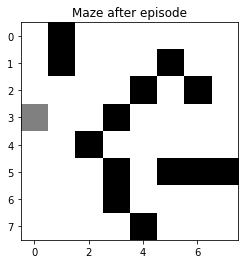

Epoch: 025/999 | Loss: 0.0003 | Episodes: 26 | Win count: 11 | Win rate: 0.423 | time: 23.08 minutes
Loss:  0.00020835702889598906
Loss:  0.0001944734349308419
Loss:  0.00021043494780315086
Loss:  1.5390050066343974e-05
Loss:  0.00012514259287854657
Loss:  0.00024192027922254056
Loss:  0.00017692518713374739
Loss:  0.000572998687857762
Loss:  0.000400726348743774
Loss:  0.0003512698312988505
Loss:  0.0003439079155214131
Loss:  0.0004379401507321745
Loss:  0.0006037075436324812
Loss:  0.0004219940456096083
Loss:  0.00017332691277260892
Loss:  4.77393750770716e-05
Loss:  0.0004968324392393697
Loss:  0.00012911231351608876
Loss:  0.0005663025222020224
Loss:  0.0005079578259028494
Loss:  0.0006258083158172667
Loss:  5.833965406054631e-05
Loss:  0.00019875744328601286
Loss:  0.00019668350432766601
Loss:  0.00029987261223141104
Loss:  0.00027325098926667124
Loss:  0.0001794932031771168
Loss:  0.00018172948875871953
Loss:  0.0002955751260742545
Loss:  0.00016483341823914088
Loss:  0.000510014

Loss:  0.0005157904088264331
Loss:  0.0003688190699904226
Loss:  0.000878871709574014
Loss:  0.00041664297168608755
Loss:  0.00044541488750837743
Loss:  0.00017566805763635784
Loss:  0.0005996610198053531
Loss:  0.0002983604572364129
Loss:  8.6372147052316e-05
Loss:  9.532581134408247e-05
Loss:  0.00036393517802935094
Loss:  0.0005465242138598114
Loss:  0.0004084498796146363
Loss:  0.0005189932926441543
Loss:  0.0004522592280409299
Loss:  0.0003808496658166405
Loss:  0.0008158917189575732
Loss:  0.0002771417348412797
Loss:  0.00018249333515996113
Loss:  0.00042475458758417517
Loss:  6.964367821638007e-05
Loss:  0.0005545937165152282
Loss:  9.547421359457076e-05
Loss:  0.0002903278036683332
Loss:  0.0007968972786329687
Loss:  0.00034528024843893945
Loss:  0.00027329685690347105
Loss:  0.00023616936232428998
Loss:  0.00022080195412854664
Loss:  0.00017423337067157263
Loss:  0.00034136982867494226
Loss:  0.00018689018270379165
Loss:  0.00019882111246261047
Loss:  0.0002806903066812083
Los

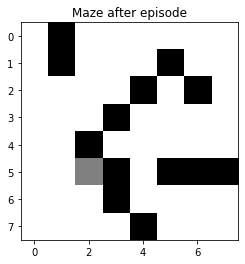

Epoch: 026/999 | Loss: 0.0000 | Episodes: 27 | Win count: 11 | Win rate: 0.407 | time: 25.99 minutes
Loss:  6.175465568958316e-05
Loss:  0.0008573611848987639
Loss:  0.00022835892013972625
Loss:  0.0005365816468838602
Loss:  0.00014513497444568202
Loss:  0.0004523065290413797
Loss:  0.00022779930077376775
Loss:  0.00039353876491077244
Loss:  0.00017054099771485198
Loss:  0.00033837949740700424
Loss:  0.00036438138340599835
Loss:  0.0008495890942867845
Loss:  0.0003774665528908372
Loss:  0.00026401808645459823
Loss:  0.00048722313840698916
Loss:  0.0006836418469902128
Loss:  0.0003362579700478818
Loss:  0.0007858561002649367
Loss:  0.0002033468263107352
Loss:  0.00023715419956715778
Loss:  0.0006662109226454049
Loss:  0.0003620749994297512
Loss:  0.0008218905422836542
Loss:  0.0003487924477667548
Loss:  0.0009225016110576689
Loss:  0.0005524903244804591
Loss:  0.0002745005185715854
Loss:  0.001083411683794111
Loss:  0.0006574512517545372
Loss:  0.000640867801848799
Loss:  0.000177769132

Loss:  0.0004572681318677496
Loss:  0.0003378458532097284
Loss:  0.00036675053706858307
Loss:  0.0005881792603759095
Loss:  0.0007398120505968109
Loss:  0.0003054173103009816
Loss:  0.00031525940721621737
Loss:  3.3566717320354655e-05
Loss:  0.0006253781029954553
Loss:  0.0006385626038536429
Loss:  0.00019942781727877446
Loss:  0.00045081452117301524
Loss:  0.0006200160751177464
Loss:  0.0003235844415030442
Loss:  0.00020060303722857498
Loss:  0.0005897779192309827
Loss:  0.0005963373550912365
Loss:  0.0006293677724897861
Loss:  0.0004719579956145026
Loss:  0.0006486449856311083
Loss:  0.0003388300392543897
Loss:  0.0003233750794606749
Loss:  0.0006104502826929092
Loss:  0.0005188828508835286
Loss:  0.0003618424052547198
Loss:  0.00042938739352393895
Loss:  0.00017279806888836902
Loss:  0.0004358609294285998
Loss:  0.00032347913656849414
Loss:  0.0004917759215459228
Loss:  0.0006887570780236274
Loss:  0.0006042146269464865
Loss:  0.00031861722527537495
Loss:  0.00026418385277793277
Los

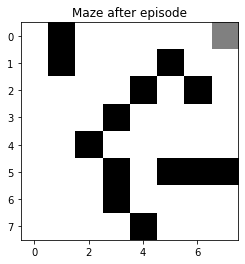

Epoch: 027/999 | Loss: 0.0007 | Episodes: 28 | Win count: 11 | Win rate: 0.393 | time: 28.76 minutes
Loss:  0.0005053732893429697
Loss:  0.0011259556049481034
Loss:  0.0003570801200112328
Loss:  0.00045729096746072173
Loss:  0.00040278583765029907
Loss:  0.000566293383599259
Loss:  0.001080697460565716
Loss:  0.0001747138194332365
Loss:  0.00038331360337906517
Loss:  0.000528561940882355
Loss:  0.00048705532390158623
Loss:  0.0004996837815269828
Loss:  0.0005016028007958084
Loss:  0.0005850235756952316
Loss:  0.00042842887341976166
Loss:  0.0007420133260893635
Loss:  0.0007050750718917698
Loss:  0.000444601260824129
Loss:  0.0006313713965937495
Loss:  0.000333991352817975
Loss:  0.00020794832380488515
Loss:  0.0005785260073025711
Loss:  0.0007653721986571327
Loss:  0.0003877798735629767
Loss:  0.00037097516178619117
Loss:  0.0006092818221077323
Loss:  0.0007206238224171102
Loss:  0.0006108122179284692
Loss:  0.0008766808023210615
Loss:  0.00020021869568154216
Loss:  0.00029872063896618

Loss:  0.00016702586071914993
Loss:  0.0005715987354051322
Loss:  0.0007174734200816602
Loss:  0.0005744554364355281
Loss:  0.0003219940081180539
Loss:  0.0005738845284213312
Loss:  0.00014679121886729263
Loss:  0.00047539177467115223
Loss:  0.0001715430844342336
Loss:  0.0005141799192642793
Loss:  0.00044269609497860074
Loss:  0.000555332051590085
Loss:  0.0002218973750132136
Loss:  0.00038831802521599457
Loss:  0.0005541371792787686
Loss:  0.00017887064677779563
Loss:  0.0004894210142083466
Loss:  0.0005445382921607234
Loss:  0.0009080428280867636
Loss:  0.0003863401070702821
Loss:  0.0005192348617129028
Loss:  4.023832480015699e-05
Loss:  5.048477032687515e-05
Loss:  0.00026655451802071184
Loss:  0.00018362785431236262
Loss:  0.0001298680726904422
Loss:  0.0006867318297736347
Loss:  0.00035592654603533447
Loss:  0.00024113672770909034
Loss:  0.0001847657549660653
Loss:  0.0004763864853885025
Loss:  0.00032505899707757635
Loss:  0.00034634584153536707
Loss:  0.0005461537803057581
Los

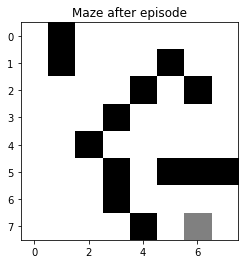

Epoch: 028/999 | Loss: 0.0028 | Episodes: 29 | Win count: 11 | Win rate: 0.379 | time: 31.48 minutes
Loss:  0.007194188889116049
Loss:  0.008566835662350059
Loss:  0.009884681552648544
Loss:  0.002465623547323048
Loss:  0.006401953403837979
Loss:  0.006143656093627214
Loss:  0.01448842091485858
Loss:  0.010037851287052035
Loss:  0.0017101378180086613
Loss:  0.003353747772052884
Loss:  0.0028426910284906626
Loss:  0.005833036557305604
Loss:  0.0009121915209107101
Loss:  0.0008944116125348955
Loss:  0.005428076285170391
Loss:  0.009659548406489193
Loss:  0.0011121589341200888
Loss:  0.000933473405893892
Loss:  0.005272766371490434
Loss:  0.0006999184261076152
Loss:  0.005231690214714035
Loss:  0.00046813441440463066
Loss:  0.005197955062612891
Loss:  0.0004288291820557788
Loss:  0.008864909876137972
Loss:  0.0010310879442840815
Loss:  0.0007078870257828385
Loss:  0.0009965444332920015
Loss:  0.008661061525344849
Loss:  0.000623683154117316
Loss:  0.0006397433171514422
Loss:  0.0001958582

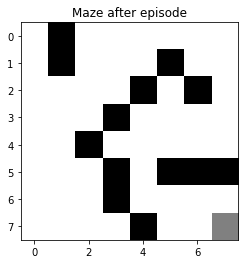

Epoch: 029/999 | Loss: 0.0018 | Episodes: 30 | Win count: 12 | Win rate: 0.400 | time: 32.30 minutes
Loss:  0.0007949805294629186
Loss:  0.0010812249965965748
Loss:  0.00392162287607789
Loss:  0.003148087242152542
Loss:  0.007448496297001839
Loss:  0.0008306917734444141
Loss:  0.0035934343468397856
Loss:  0.000479966496641282
Loss:  0.0003930506209144369
Loss:  0.002462770731654018
Loss:  0.0007674385415157303
Loss:  0.004696110729128122
Loss:  0.0009647270489949733
Loss:  0.0032860486826393753
Loss:  0.004297881736420095
Loss:  0.0018207212560810149
Loss:  0.0007198855455499142
Loss:  0.000629970949376002
Loss:  0.0043951962143182755
Loss:  0.003012341068824753
Loss:  0.002289063239004463
Loss:  0.001254842325579375
Loss:  0.0019288184121251106
Loss:  0.0008455179049633443
Loss:  0.0016075247403932735
Loss:  0.0005320667260093614
Loss:  0.0020107065211050212
Loss:  0.00499437638791278
Loss:  0.001009116182103753
Loss:  0.0014492126210825518
Loss:  0.0008373084419872612
Loss:  0.001367

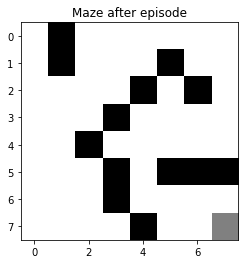

Epoch: 030/999 | Loss: 0.0015 | Episodes: 31 | Win count: 13 | Win rate: 0.419 | time: 32.80 minutes
Loss:  0.0011768835538532585


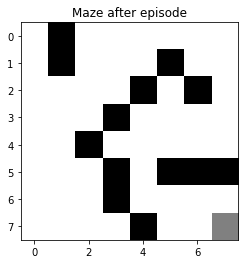

Epoch: 031/999 | Loss: 0.0012 | Episodes: 32 | Win count: 14 | Win rate: 0.438 | time: 32.81 minutes
Loss:  0.0017531983903609216
Loss:  0.0005888534287805669
Loss:  0.0010293377854395658
Loss:  0.0008117006218526512
Loss:  0.0019013801356777549
Loss:  0.0007931870350148529


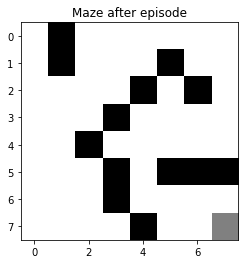

Epoch: 032/999 | Loss: 0.0008 | Episodes: 33 | Win count: 15 | Win rate: 0.438 | time: 32.84 minutes
Loss:  0.001042490708641708
Loss:  0.0011246716021560133
Loss:  0.00098572057322599
Loss:  0.0013589626760222018
Loss:  0.0007574553892482072
Loss:  0.0006817551329731941
Loss:  0.001294135145144537
Loss:  0.0007857292075641453
Loss:  0.0012332045589573681
Loss:  0.0006953072734177113
Loss:  0.0010797450959216803
Loss:  0.000934184470679611
Loss:  0.0012146667286287993
Loss:  0.0011694177519530058
Loss:  0.0008323933434439823
Loss:  0.0005000210512662306
Loss:  0.001253302616532892
Loss:  0.001327597419731319
Loss:  0.0015723491669632494
Loss:  0.0015047412016429007
Loss:  0.0008769144187681377
Loss:  0.0009315619827248156
Loss:  0.0007320755103137344
Loss:  0.0012182955397292972
Loss:  0.0010339376458432525
Loss:  0.000692673260346055
Loss:  0.0009730838646646589
Loss:  0.0012516099377535284
Loss:  0.0013409326784312725
Loss:  0.0013356438284972683
Loss:  0.0019643259001895785
Loss:  0

Loss:  0.0004232618666719645
Loss:  0.0007839602476451546
Loss:  0.000220795365748927
Loss:  0.00032436041510663927
Loss:  4.12210147260339e-05
Loss:  0.00013928526732343016
Loss:  0.00018213634757557884
Loss:  0.00021637750978698023
Loss:  0.000349304209521506
Loss:  0.0005174993239052128
Loss:  0.0002442249206069391
Loss:  0.00038440851494669914
Loss:  0.00020986066374462098
Loss:  0.0005980142159387469
Loss:  0.0005058758251834661
Loss:  0.00026775215519592166
Loss:  0.0003620184143073857
Loss:  0.0007656913949176669
Loss:  0.00023148347463575192
Loss:  0.00045826175482943654
Loss:  0.00015885809716564836
Loss:  0.00019706725652213208
Loss:  0.0005860264063812792
Loss:  0.000431047155871056
Loss:  0.0005631147068925202
Loss:  3.1141130421019625e-05
Loss:  0.00044103759864810854
Loss:  0.000995187263470143
Loss:  0.00040963712672237307
Loss:  0.0004186723963357508
Loss:  0.0004454311929293908
Loss:  0.000338495010510087
Loss:  4.385137617646251e-05
Loss:  0.00018684894166653976
Loss:

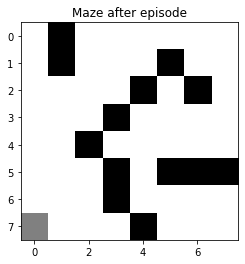

Epoch: 033/999 | Loss: 0.0002 | Episodes: 34 | Win count: 15 | Win rate: 0.406 | time: 35.69 minutes
Loss:  1.5326756056310842e-05
Loss:  0.00039502342224295717
Loss:  0.00020849619431828614
Loss:  0.00021363835912779905
Loss:  0.00016245896176769747
Loss:  4.893233744951431e-05
Loss:  0.0007224397559184581
Loss:  0.0006794050568714738
Loss:  3.3834616260719486e-05
Loss:  0.00015679062198614702
Loss:  0.0006336264632409438
Loss:  0.0003503865737002343
Loss:  0.00014823068704572506
Loss:  2.2398597593564773e-05
Loss:  1.3194397070037667e-05
Loss:  0.0001324259883404011
Loss:  0.00027781716926256195
Loss:  2.405038412689464e-05
Loss:  0.0001725188431009883
Loss:  1.66908780556696e-05
Loss:  3.1823282142795506e-06
Loss:  0.0005834126641275361
Loss:  4.1597665585868526e-05
Loss:  0.00017849198593467008
Loss:  0.00038491079612867907
Loss:  9.264008895115694e-06
Loss:  0.00031865375422057696
Loss:  0.0005030745815020055
Loss:  0.0005112435319460928
Loss:  5.888722625968512e-05
Loss:  0.00019

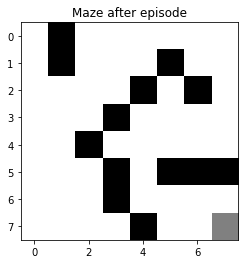

Epoch: 034/999 | Loss: 0.0003 | Episodes: 35 | Win count: 16 | Win rate: 0.406 | time: 35.90 minutes
Loss:  0.00013954252426628955
Loss:  4.3087917219963856e-05
Loss:  0.00013432074410957284
Loss:  0.00026605777998156555
Loss:  0.00013512763689504936
Loss:  5.813874122395646e-05
Loss:  6.674315955024213e-05


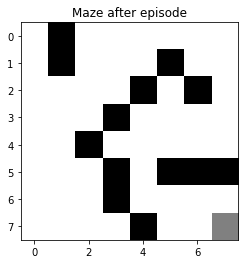

Epoch: 035/999 | Loss: 0.0001 | Episodes: 36 | Win count: 17 | Win rate: 0.438 | time: 35.95 minutes
Loss:  0.00020316619338700548
Loss:  0.00012645865808735834
Loss:  0.00022197785665412084
Loss:  0.00017175786342704669
Loss:  0.00027286363183520734
Loss:  0.00023741926270304248
Loss:  0.00016943139053182676
Loss:  0.0002008116789511405
Loss:  3.4327856155869085e-05
Loss:  0.00044236825488042086
Loss:  0.0001259381024283357
Loss:  3.9628998820262495e-05
Loss:  2.838793534465367e-05
Loss:  9.798088285606354e-06
Loss:  0.0001847598605309031
Loss:  0.00042002419650088996
Loss:  0.0002603610628284514
Loss:  0.0005240901082288474
Loss:  0.00041281133599113673
Loss:  0.0006068548536859453
Loss:  0.0005234724812908098
Loss:  0.0003912576794391498
Loss:  0.0006909584626555443
Loss:  0.00041308801155537367
Loss:  0.0005850402812939137
Loss:  0.00016995507030515
Loss:  0.00045350751315709203
Loss:  0.0006234270986169577
Loss:  0.00016024075921450276
Loss:  0.00020108429271203931
Loss:  0.000283

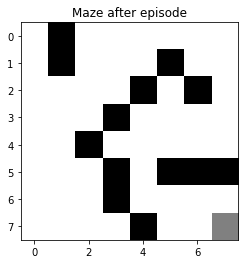

Epoch: 036/999 | Loss: 0.0005 | Episodes: 37 | Win count: 18 | Win rate: 0.438 | time: 36.43 minutes
Loss:  0.00039598044531885535
Loss:  0.00011898035154445097
Loss:  0.00043952217674814165
Loss:  0.0006825769960414618
Loss:  0.0003620442876126617
Loss:  0.0010346657072659582
Loss:  0.0009318758093286306
Loss:  0.0006191241409396753
Loss:  0.0008429480076301843
Loss:  0.0005747901159338653
Loss:  0.0003111211844952777
Loss:  0.00045389594743028283
Loss:  0.0006497441208921373
Loss:  0.0006832029903307557
Loss:  0.0005758251354563981
Loss:  0.0004854661674471572
Loss:  0.0004497246991377324
Loss:  0.0007354832487180829
Loss:  0.0003894703695550561
Loss:  0.0006941711180843413
Loss:  0.0004457458126125857
Loss:  0.0005433999467641115
Loss:  0.00036534852551994845
Loss:  0.000522899761563167
Loss:  0.0005737627507187426
Loss:  0.0007021458877716213
Loss:  0.0003152925710310228
Loss:  0.000756051013013348
Loss:  0.0002698437892831862
Loss:  0.0007653786160517484
Loss:  0.00068467107485048

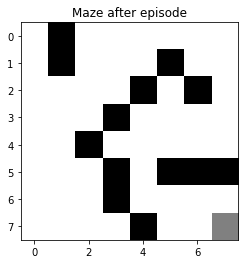

Epoch: 037/999 | Loss: 0.0003 | Episodes: 38 | Win count: 19 | Win rate: 0.469 | time: 36.63 minutes
Loss:  0.0001731085230858298
Loss:  0.0009298099321313202
Loss:  0.0005543733277590945
Loss:  0.00026226069167023525
Loss:  0.00047447507313336246
Loss:  0.0009692851162981242
Loss:  0.0005511419440153986
Loss:  0.00022093611914897338
Loss:  0.0012625818199012429
Loss:  0.0006738900774507783
Loss:  0.0006119836471043527
Loss:  0.0005308237377903424
Loss:  0.0005405092233559117
Loss:  0.0007898258772911504
Loss:  0.0002801643422571942
Loss:  0.00016907003009691834
Loss:  0.000715751841198653
Loss:  0.0006580798071809113
Loss:  0.0007234472432173789
Loss:  0.0008370533032575622
Loss:  0.0006430799257941544
Loss:  0.00022173632896738127
Loss:  0.0007773163670208305
Loss:  0.0005542680446524173
Loss:  0.0009543338674120605
Loss:  0.0007399623282253742
Loss:  0.0006538434536196291
Loss:  0.0006348024471662939
Loss:  0.00015502755559282377
Loss:  0.0004377682344056666
Loss:  0.000167540500115

Loss:  0.0008088440517894924
Loss:  0.0006332832272164524
Loss:  0.0006523163465317339
Loss:  0.000585818022955209
Loss:  0.001089020457584411
Loss:  0.0004787502984981984
Loss:  0.0008484715945087373
Loss:  0.0007259255216922611
Loss:  0.0011475877254270017
Loss:  0.0006353244534693658
Loss:  0.0012857959372922778
Loss:  0.00045004909043200314
Loss:  0.0008468154410365969
Loss:  0.0004743251047329977
Loss:  0.0012373668723739684
Loss:  0.0006197273323778063
Loss:  0.0005399629299063236
Loss:  0.0008329327974934131
Loss:  0.0009215376630891114
Loss:  0.001132878300268203
Loss:  0.0009235130273737013
Loss:  0.0007567930442746729
Loss:  0.0010616093059070408
Loss:  0.000566723058000207
Loss:  0.0008574468374717981
Loss:  0.0008431596506852657
Loss:  0.0006592119752895087
Loss:  0.0006392044015228748
Loss:  0.0005050696490798146
Loss:  0.0004747823841171339
Loss:  0.0004091367300134152
Loss:  0.0004317380953580141
Loss:  0.0008040012326091528
Loss:  0.0009512391407042742
Loss:  0.00064470

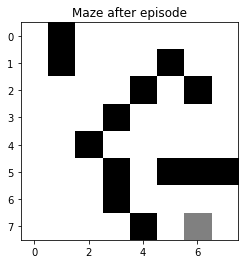

Epoch: 038/999 | Loss: 0.0006 | Episodes: 39 | Win count: 19 | Win rate: 0.469 | time: 39.36 minutes
Loss:  0.000804042152594775
Loss:  0.000567007482459303
Loss:  0.0005366587720345706
Loss:  0.00038902219966985285
Loss:  0.0005500608531292528
Loss:  0.0005678990200976841
Loss:  0.0005196987767703831


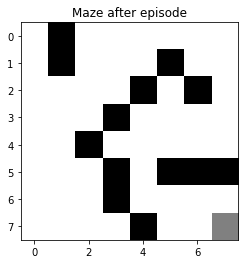

Epoch: 039/999 | Loss: 0.0005 | Episodes: 40 | Win count: 20 | Win rate: 0.469 | time: 39.41 minutes
Loss:  0.00048007772420533
Loss:  0.0004752171807922423
Loss:  0.0006113048293627799
Loss:  0.00047183677088469267
Loss:  0.0004358589794719592
Loss:  0.00017203476090799086
Loss:  0.0009459363354835659
Loss:  0.0004886292736046016
Loss:  0.0004555296472972259


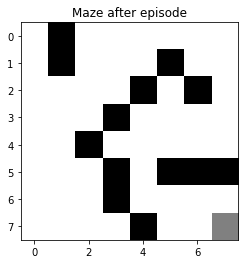

Epoch: 040/999 | Loss: 0.0005 | Episodes: 41 | Win count: 21 | Win rate: 0.500 | time: 39.46 minutes
Loss:  0.0004309555879444815
Loss:  0.0008903192356228828
Loss:  0.0005430064920801669
Loss:  0.0007043562654871494
Loss:  0.0004878627514699474
Loss:  0.00030703385709784925
Loss:  0.0003673800965771079
Loss:  0.0005579424032475799
Loss:  0.00043937786540482193
Loss:  0.0004354181292001158
Loss:  0.0011217172432225198
Loss:  0.0006859705317765474
Loss:  0.0006184494704939425
Loss:  0.0003373982690391131
Loss:  0.0006465836922870949
Loss:  0.0004060919309267774
Loss:  0.0008997521363198757
Loss:  0.0011536128004081547
Loss:  0.0006752443150617182
Loss:  0.0007142262620618567
Loss:  0.0009668684797361493
Loss:  0.0008630889351479709
Loss:  0.0006439900898840278
Loss:  0.0005390672304201871
Loss:  0.0007484380039386451
Loss:  0.00047932687448337674
Loss:  0.0006464277976192534
Loss:  0.0007319973374251276
Loss:  0.0010389357339590788
Loss:  0.0006563185015693307
Loss:  0.00068405235651880

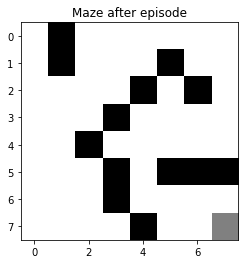

Epoch: 041/999 | Loss: 0.0004 | Episodes: 42 | Win count: 22 | Win rate: 0.531 | time: 39.93 minutes
Loss:  0.0007574566989205778
Loss:  0.0006995800358708948
Loss:  0.0006450744695030153
Loss:  0.0009833701187744737
Loss:  0.0010715978569351137
Loss:  0.0007107148121576756
Loss:  0.0006598284817300737
Loss:  0.0010963460663333535
Loss:  0.0005633810069411993
Loss:  0.0010122096282429993
Loss:  0.0007195982179837301
Loss:  0.0011464511044323444
Loss:  0.0006721205718349665
Loss:  0.0005695912113878876
Loss:  0.0008623909670859575
Loss:  0.0011369205312803388
Loss:  0.0008225360070355237
Loss:  0.0006538288726005703
Loss:  0.0008414477342739701
Loss:  0.001460934930946678
Loss:  0.0008483705460093915
Loss:  0.001166920381365344
Loss:  0.0006947032525204122
Loss:  0.0007154846389312297
Loss:  0.0015169515972957015
Loss:  0.0008150490757543594
Loss:  0.0009848696063272655
Loss:  0.0009294623741880059
Loss:  0.0007844322826713324
Loss:  0.0007857949531171471
Loss:  0.0005353476444724947
Lo

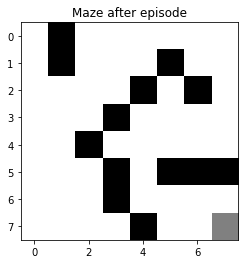

Epoch: 042/999 | Loss: 0.0008 | Episodes: 43 | Win count: 23 | Win rate: 0.562 | time: 40.42 minutes
Loss:  0.0011664055055007339
Loss:  0.0007597508956678212
Loss:  0.0015603709616698325
Loss:  0.0005330500862328336
Loss:  0.0009721022215671837
Loss:  0.00128599297022447
Loss:  0.00128896941896528
Loss:  0.0011452938488218933
Loss:  0.0011793971061706543
Loss:  0.0013467372045852244
Loss:  0.0010685000161174685
Loss:  0.000992339861113578
Loss:  0.0011340297060087323
Loss:  0.0007211163465399295
Loss:  0.001342252071481198
Loss:  0.001342987030511722
Loss:  0.0012867105542682111
Loss:  0.0008943939756136388
Loss:  0.0012125432549510151
Loss:  0.0012107963557355106
Loss:  0.001284549303818494
Loss:  0.0011265819193795323
Loss:  0.0012198765762150288
Loss:  0.001091122889192775
Loss:  0.0013434505672194064
Loss:  0.0012084095505997539
Loss:  0.0014557152753695846
Loss:  0.0015323578845709562


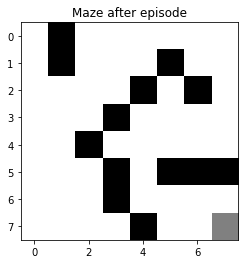

Epoch: 043/999 | Loss: 0.0015 | Episodes: 44 | Win count: 24 | Win rate: 0.594 | time: 40.61 minutes
Loss:  0.0014955054502934217
Loss:  0.0008845765260048211
Loss:  0.0010539391078054905
Loss:  0.0013319127610884607
Loss:  0.0011905196588486433
Loss:  0.001318150490988046
Loss:  0.0008833040483295918
Loss:  0.001029255974572152
Loss:  0.0012108252267353237
Loss:  0.0009892757807392627
Loss:  0.0013948680134490132
Loss:  0.0010196373332291842
Loss:  0.0011817076010629535
Loss:  0.0012108571827411652
Loss:  0.0010912215220741928
Loss:  0.0009383487049490213
Loss:  0.0010486647952347994
Loss:  0.001384603325277567
Loss:  0.0008995729731395841
Loss:  0.0015198200708255172
Loss:  0.0009298314107581973
Loss:  0.0017693554982542992
Loss:  0.0011661193566396832
Loss:  0.0013577196514233947
Loss:  0.0012044961331412196
Loss:  0.000872831791639328
Loss:  0.0014191623195074499
Loss:  0.0014600679860450327
Loss:  0.0013681098353117704
Loss:  0.0010725036263465881
Loss:  0.0015783541020937264


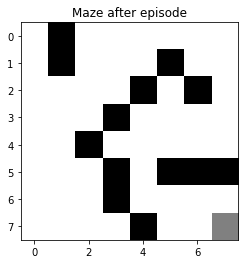

Epoch: 044/999 | Loss: 0.0016 | Episodes: 45 | Win count: 25 | Win rate: 0.594 | time: 40.80 minutes
Loss:  0.0014933968777768314
Loss:  0.0012760079116560519
Loss:  0.0009615643066354096
Loss:  0.001043775031575933
Loss:  0.001369202567730099
Loss:  0.0010541803785599768
Loss:  0.0012089464580640197
Loss:  0.0010069828131236136
Loss:  0.0009914630209095776
Loss:  0.0012208802509121597
Loss:  0.0013542423257604241
Loss:  0.0014127951581031084
Loss:  0.0010660435655154288
Loss:  0.0014552524662576616
Loss:  0.0013927925319876522
Loss:  0.0011767841351684183
Loss:  0.0013343062601052225
Loss:  0.0012362563284114003
Loss:  0.001294282905291766
Loss:  0.0011765265953727067
Loss:  0.0009687197161838412
Loss:  0.001195042161270976
Loss:  0.001092845923267305
Loss:  0.001346056000329554
Loss:  0.0009522140608169138
Loss:  0.0014634375693276525
Loss:  0.0012113244738429785
Loss:  0.001395663945004344
Loss:  0.0011100097908638418
Loss:  0.0011792483855970204
Loss:  0.0015043599414639175
Loss:  

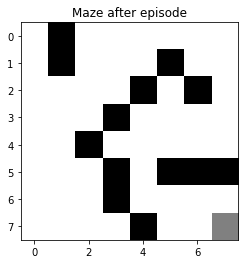

Epoch: 045/999 | Loss: 0.0016 | Episodes: 46 | Win count: 26 | Win rate: 0.625 | time: 41.04 minutes
Loss:  0.0010743624006863683
Loss:  0.0008485979051329195
Loss:  0.0012411998468451202


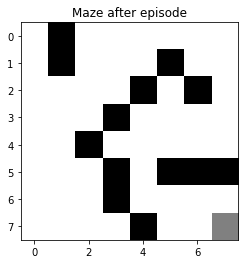

Epoch: 046/999 | Loss: 0.0012 | Episodes: 47 | Win count: 27 | Win rate: 0.625 | time: 41.06 minutes
Loss:  0.0008397944620810449
Loss:  0.0014725623768754303
Loss:  0.001225429237820208
Loss:  0.0012557002482935786
Loss:  0.0014219920267350972
Loss:  0.0008721158083062619
Loss:  0.0013042378122918308
Loss:  0.0013026337837800384
Loss:  0.001551276829559356
Loss:  0.0012077928404323757
Loss:  0.0016783395549282432
Loss:  0.0012568928068503737


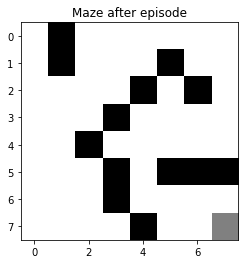

Epoch: 047/999 | Loss: 0.0013 | Episodes: 48 | Win count: 28 | Win rate: 0.625 | time: 41.14 minutes
Loss:  0.0009523619373794645
Loss:  0.0010727062763180584
Loss:  0.0010920203058049083
Loss:  0.0009013009839691222
Loss:  0.0014374529127962887
Loss:  0.0013361232122406363
Loss:  0.0010875743173528463
Loss:  0.001196883589727804
Loss:  0.0014097699313424528
Loss:  0.0009737343934830278
Loss:  0.0013797852443531156
Loss:  0.0013158696237951517
Loss:  0.001162658678367734
Loss:  0.0012326237047091126
Loss:  0.001846641127485782
Loss:  0.001512336020823568
Loss:  0.0012471909867599607


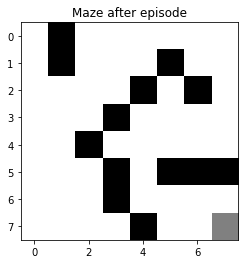

Epoch: 048/999 | Loss: 0.0012 | Episodes: 49 | Win count: 29 | Win rate: 0.625 | time: 41.24 minutes
Loss:  0.0008180749719031155
Loss:  0.0012046787305735052
Loss:  0.001475655590184033
Loss:  0.0013569258153438568
Loss:  0.001250693399924785
Loss:  0.0011593076051212847
Loss:  0.0012586770462803543
Loss:  0.001432350603863597
Loss:  0.0010993297910317779
Loss:  0.001129577838582918
Loss:  0.001138758845627308
Loss:  0.0012116931029595435
Loss:  0.0010889619588851929


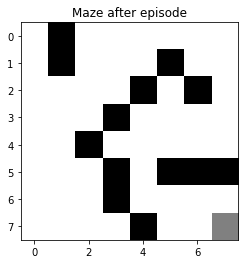

Epoch: 049/999 | Loss: 0.0011 | Episodes: 50 | Win count: 30 | Win rate: 0.656 | time: 41.32 minutes
Loss:  0.0008755568414926529
Loss:  0.0012766793952323496
Loss:  0.0012144976644776762
Loss:  0.0013049333356320858
Loss:  0.0007870238914620131
Loss:  0.000801103247795254
Loss:  0.001267125247977674
Loss:  0.0013363489706534892
Loss:  0.001232181559316814
Loss:  0.0011477060616016388
Loss:  0.0012034879182465374
Loss:  0.0014163895975798368
Loss:  0.0012699333601631224
Loss:  0.0014932131743989885
Loss:  0.0010615019709803164
Loss:  0.0015068644424900413
Loss:  0.0011571456852834672
Loss:  0.000934360665269196
Loss:  0.0012467590859159827
Loss:  0.0006648703129030764
Loss:  0.0012921507586725056


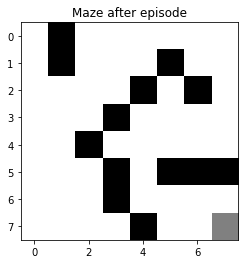

Epoch: 050/999 | Loss: 0.0013 | Episodes: 51 | Win count: 31 | Win rate: 0.688 | time: 41.45 minutes
Loss:  0.0012455251126084477


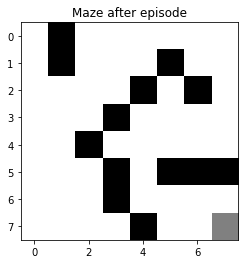

Epoch: 051/999 | Loss: 0.0012 | Episodes: 52 | Win count: 32 | Win rate: 0.719 | time: 41.46 minutes
Loss:  0.0008727582753635943
Loss:  0.0011631401721388102
Loss:  0.0011157355038449168
Loss:  0.001247698557563126
Loss:  0.001384856179356575
Loss:  0.0011046454892493784
Loss:  0.0014769802801311016
Loss:  0.0013385047786869109


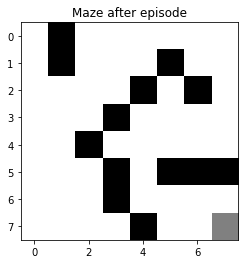

Epoch: 052/999 | Loss: 0.0013 | Episodes: 53 | Win count: 33 | Win rate: 0.750 | time: 41.51 minutes
Loss:  0.0010998875950463116
Loss:  0.001227391418069601
Loss:  0.0013044588849879801
Loss:  0.0011584823369048536
Loss:  0.0009591882699169219
Loss:  0.0009719007066451013
Loss:  0.0009814953082241118
Loss:  0.0013020220212638378
Loss:  0.001240332203451544
Loss:  0.001175848359707743
Loss:  0.0006862758891656995
Loss:  0.0013248107861727476
Loss:  0.0013279591221362352
Loss:  0.0010854738065972924
Loss:  0.0012987409136258066
Loss:  0.0008032535843085498
Loss:  0.0009926442871801555
Loss:  0.0006718132353853434
Loss:  0.0009916488779708743
Loss:  0.0007649496255908161


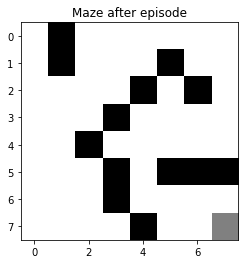

Epoch: 053/999 | Loss: 0.0008 | Episodes: 54 | Win count: 34 | Win rate: 0.781 | time: 41.63 minutes
Loss:  0.0011685017379932106
Loss:  0.0007914764864835888
Loss:  0.0009011469664983451
Loss:  0.0015853713848628104
Loss:  0.0011598248966038227
Loss:  0.0011474970378912985
Loss:  0.0009608434338588268
Loss:  0.0007698181143496186
Loss:  0.0012572313426062465
Loss:  0.0006202031945576891
Loss:  0.0008452268084511161
Loss:  0.0008278751338366419
Loss:  0.0010517032351344824
Loss:  0.0008898646046873182
Loss:  0.0018125580972991884
Loss:  0.0009670362633187324
Loss:  0.001493316434789449
Loss:  0.0010972540767397732
Loss:  0.0010476275929249823
Loss:  0.0014336745953187346
Loss:  0.0008880876121111214
Loss:  0.0009106297220569104
Loss:  0.0008046629372984171
Loss:  0.0011275585275143385
Loss:  0.0011769464472308755
Loss:  0.0010965110559482127
Loss:  0.001127674157032743
Loss:  0.0009642748045735061
Loss:  0.0012196176685392857
Loss:  0.0009253462485503405
Loss:  0.001220429374370724
Los

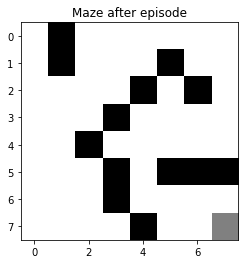

Epoch: 054/999 | Loss: 0.0009 | Episodes: 55 | Win count: 35 | Win rate: 0.781 | time: 41.81 minutes
Loss:  0.0007851464615669101
Loss:  0.0012107390211895108
Loss:  0.001341248513199389
Loss:  0.0008849757723510265
Loss:  0.0008910245960578322
Loss:  0.001282523269765079
Loss:  0.0012551501276902854
Loss:  0.0009075038251467049
Loss:  0.0013724087621085346
Loss:  0.0014461706159636378
Loss:  0.0015361943515017629
Loss:  0.0008928515017032623
Loss:  0.0013203478301875293
Loss:  0.0013156054774299264
Loss:  0.001352888939436525
Loss:  0.0015745834680274129
Loss:  0.0013197862426750362
Loss:  0.0009045748447533697
Loss:  0.0009071491076610982
Loss:  0.0007488195260521024
Loss:  0.000823665875941515
Loss:  0.001060631504515186
Loss:  0.0007628949533682317


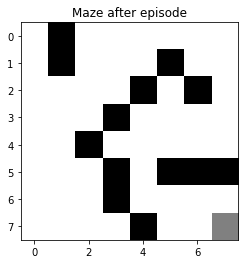

Epoch: 055/999 | Loss: 0.0008 | Episodes: 56 | Win count: 36 | Win rate: 0.781 | time: 41.95 minutes
Loss:  0.001194116979604587
Loss:  0.0009419803391210735
Loss:  0.0012018405832350254
Loss:  0.0012441774597391486
Loss:  0.0009789973264560103
Loss:  0.0011910839239135385
Loss:  0.0008202772296499461
Loss:  0.0010240188566967845
Loss:  0.0007831593102309853
Loss:  0.0013326803455129266
Loss:  0.0015390634071081877
Loss:  0.0008731446869205683
Loss:  0.0012501616147346795
Loss:  0.0012175565934740007
Loss:  0.0011083691206295043
Loss:  0.0009522674372419715
Loss:  0.001447620161343366


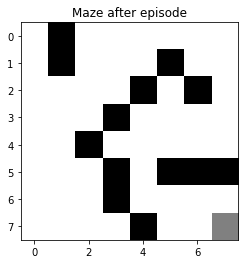

Epoch: 056/999 | Loss: 0.0014 | Episodes: 57 | Win count: 37 | Win rate: 0.812 | time: 42.04 minutes
Loss:  0.0010109582217410207
Loss:  0.0013779937289655209
Loss:  0.001180884224595502
Loss:  0.0010004864598158747
Loss:  0.0011999198468402028
Loss:  0.000865134090417996
Loss:  0.0015707642014604062
Loss:  0.0016234323848038912
Loss:  0.0014948452590033412
Loss:  0.0007625340367667377
Loss:  0.0014421160449273884
Loss:  0.0008823247626423836
Loss:  0.0012003514566458762
Loss:  0.0007868159445933998
Loss:  0.0012951580574736
Loss:  0.001085870957467705
Loss:  0.0010962915257550776
Loss:  0.0010511032305657864
Loss:  0.001093800412490964
Loss:  0.0014489155146293342
Loss:  0.0008631477248854935
Loss:  0.0010411464027129114
Loss:  0.0014362791553139687
Loss:  0.0011906347353942692
Loss:  0.0010025237570516765
Loss:  0.0015144214848987758
Loss:  0.0008137256954796612
Loss:  0.0009745751740410924
Loss:  0.0016032431740313768
Loss:  0.001223157625645399


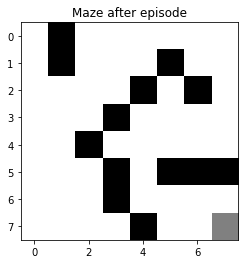

Epoch: 057/999 | Loss: 0.0012 | Episodes: 58 | Win count: 38 | Win rate: 0.844 | time: 42.21 minutes
Loss:  0.0011739100445993245
Loss:  0.001298024202696979
Loss:  0.0012039824796374887
Loss:  0.0008675215649418533
Loss:  0.0009269024594686925
Loss:  0.001193156116642058
Loss:  0.0010143109248019755
Loss:  0.0013360664597712457
Loss:  0.0009557852172292769


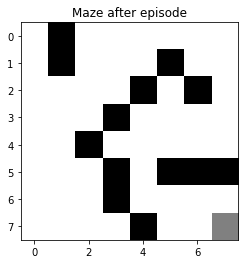

Epoch: 058/999 | Loss: 0.0010 | Episodes: 59 | Win count: 39 | Win rate: 0.875 | time: 42.26 minutes
Loss:  0.0010209595202468336


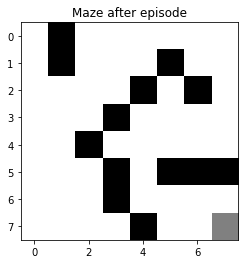

Epoch: 059/999 | Loss: 0.0010 | Episodes: 60 | Win count: 40 | Win rate: 0.906 | time: 42.27 minutes
Loss:  0.0009970802930183709
Loss:  0.0009334197384305298
Loss:  0.0013218302628956735
Loss:  0.001175702374894172


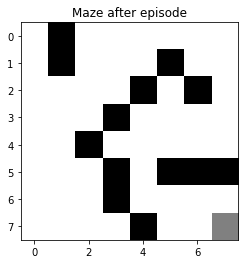

Epoch: 060/999 | Loss: 0.0012 | Episodes: 61 | Win count: 41 | Win rate: 0.938 | time: 42.30 minutes
Loss:  0.0013691381900571287
Loss:  0.00148179498501122
Loss:  0.0009975484281312674
Loss:  0.0007835899014025927
Loss:  0.0010973716853186488
Loss:  0.001308585808146745
Loss:  0.0012638620100915432
Loss:  0.0006719589000567794
Loss:  0.0017898227088153362


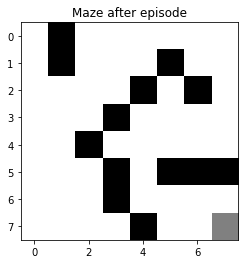

Epoch: 061/999 | Loss: 0.0018 | Episodes: 62 | Win count: 42 | Win rate: 0.938 | time: 42.35 minutes
Loss:  0.0011008771834895015
Loss:  0.0016504190862178802
Loss:  0.0010413596464786679
Loss:  0.0018391184858046472
Loss:  0.0013699280098080635
Loss:  0.0011137242836412042
Loss:  0.0010991806630045176
Loss:  0.001146186434198171
Loss:  0.0013532834127545357
Loss:  0.0012084863265044987
Loss:  0.0008761652861721814
Loss:  0.0012062558671459556
Loss:  0.0010894830920733511
Loss:  0.0008071990159805864
Loss:  0.0015544916968792677
Loss:  0.0016954840393736959
Loss:  0.0010098690981976688
Loss:  0.0017354318406432867
Loss:  0.0012980361352674663
Loss:  0.0009053631802089512
Loss:  0.0010371391545049846
Loss:  0.0009060698794201016
Loss:  0.001029441540595144
Loss:  0.0007864401850383729
Loss:  0.0007866532541811466
Loss:  0.0011153151863254607
Loss:  0.0013309259084053338
Loss:  0.0013740037102252245


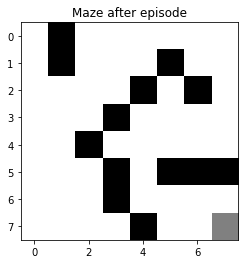

Epoch: 062/999 | Loss: 0.0014 | Episodes: 63 | Win count: 43 | Win rate: 0.938 | time: 42.49 minutes
Loss:  0.0011653469409793615
Loss:  0.0008921585395000875
Loss:  0.0009109069360420108
Loss:  0.0011401681986171752
Loss:  0.000926037784665823
Loss:  0.0015187087701633573
Loss:  0.0015421001589857042


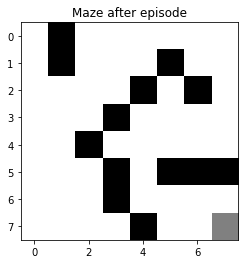

Epoch: 063/999 | Loss: 0.0015 | Episodes: 64 | Win count: 44 | Win rate: 0.938 | time: 42.54 minutes
Loss:  0.0016359809669665992
Loss:  0.0006734927592333406
Loss:  0.0014995342353358865
Loss:  0.0009006710606627166
Loss:  0.0010160050878766924
Loss:  0.0011467174044810236
Loss:  0.0010853124549612403
Loss:  0.0011425084085203707
Loss:  0.0013869922258891165
Loss:  0.0007964269607327878
Loss:  0.000934615993173793
Loss:  0.0010068246047012508
Loss:  0.0007676600071135908
Loss:  0.0007657775713596493
Loss:  0.0009531572577543557
Loss:  0.0009982622577808797
Loss:  0.0011544321605470031
Loss:  0.001116619911044836


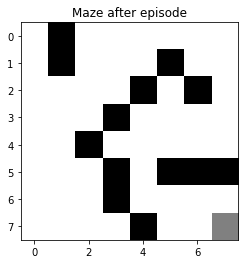

Epoch: 064/999 | Loss: 0.0011 | Episodes: 65 | Win count: 45 | Win rate: 0.938 | time: 42.65 minutes
Loss:  0.0008241100294981152
Loss:  0.0014446514542214572
Loss:  0.0010855224099941552
Loss:  0.0006067175854695961
Loss:  0.0007761855376884341
Loss:  0.001083996961824596
Loss:  0.0011770259588956833
Loss:  0.0014635597472079098
Loss:  0.0006115050346124917
Loss:  0.0013523208908736706
Loss:  0.0009915883420035243
Loss:  0.0009921024611685425
Loss:  0.0010497495532035828
Loss:  0.0012493483955040574
Loss:  0.0010117337806150317
Loss:  0.0012002348667010665
Loss:  0.0012940687593072653
Loss:  0.0012176352902315557
Loss:  0.0007663547294214368
Loss:  0.001294957532081753
Loss:  0.0006806863530073315


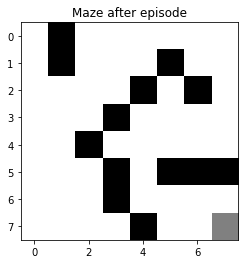

Epoch: 065/999 | Loss: 0.0007 | Episodes: 66 | Win count: 46 | Win rate: 0.969 | time: 42.77 minutes
Loss:  0.0013279024860821664
Loss:  0.0009913953836075962
Loss:  0.0010403631604276597
Loss:  0.001179035782115534
Loss:  0.001227241475135088
Loss:  0.0010953375604003668
Loss:  0.000612090079812333
Loss:  0.0006652891461271793
Loss:  0.0009267534769605845
Loss:  0.000772999890614301
Loss:  0.0008857697830535471
Loss:  0.0005991258076392114
Loss:  0.0007829893147572875
Loss:  0.0011410248698666692
Loss:  0.0012158677564002573
Loss:  0.000969456450548023
Loss:  0.001158917642896995
Loss:  0.0010081488289870322
Loss:  0.0007534038450103253
Loss:  0.0011033108457922935
Loss:  0.0007032972062006593
Loss:  0.0013080354547128081
Loss:  0.001101595174986869
Loss:  0.001022513723000884
Loss:  0.0008348218107130378
Loss:  0.0011429168516770005
Loss:  0.0012665085378102958
Loss:  0.001309926388785243
Loss:  0.0013110411819070578
Loss:  0.0008861908572725952
Loss:  0.0010798159055411816
Loss:  0.

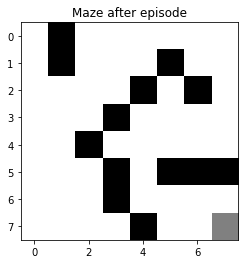

Epoch: 066/999 | Loss: 0.0009 | Episodes: 67 | Win count: 47 | Win rate: 0.969 | time: 42.97 minutes
Loss:  0.0009139823669102043
Loss:  0.0008473674242850393
Loss:  0.0008796025940682739
Loss:  0.0010819632734637707
Loss:  0.001157671504188329
Loss:  0.0011614873073995113
Loss:  0.0015819932450540364
Loss:  0.0010120575898326933
Loss:  0.000811460442491807
Loss:  0.0009600351040717214
Loss:  0.0008886355208232999
Loss:  0.0012910250807181
Loss:  0.0009148340323008597
Loss:  0.000956923293415457
Loss:  0.0009223935194313526
Loss:  0.0008815412293188274
Loss:  0.0011703242780640721
Loss:  0.0007801456667948514
Loss:  0.0003806594177149236
Loss:  0.000653369294013828
Loss:  0.0007865701336413622
Loss:  0.0010224634606856853
Loss:  0.0008410891459789127
Loss:  0.0008554217056371272
Loss:  0.0012630817363969982


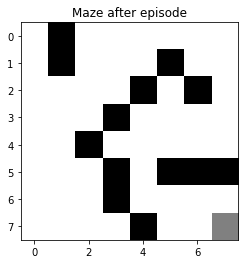

Epoch: 067/999 | Loss: 0.0013 | Episodes: 68 | Win count: 48 | Win rate: 0.969 | time: 43.11 minutes
Loss:  0.0007260974671225995
Loss:  0.0009544754575472325
Loss:  0.0010453513241373003
Loss:  0.0007223697321023792
Loss:  0.0008032241312321275
Loss:  0.0006748990417690948
Loss:  0.0006423902523238212
Loss:  0.0007300346624106169
Loss:  0.0007883036305429414
Loss:  0.0009097531146835536
Loss:  0.0009569901740178466
Loss:  0.000840884487843141
Loss:  0.0005660693277604878
Loss:  0.0009733421611599624
Loss:  0.0007753575046081096
Loss:  0.0008575798710808158
Loss:  0.0007986219134181738
Loss:  0.0006131460540927947
Loss:  0.0005692326667485759
Loss:  0.0005791275179944932
Loss:  0.0006840159767307341
Loss:  0.0005769846320617944
Loss:  0.0005570601933868602
Loss:  0.0005414696061052382
Loss:  0.0010291013459209353
Loss:  0.000838836538605392
Loss:  0.0006907425704412162


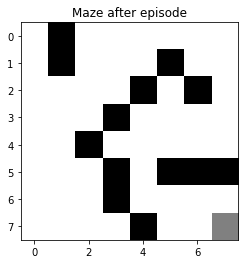

Epoch: 068/999 | Loss: 0.0007 | Episodes: 69 | Win count: 49 | Win rate: 0.969 | time: 43.24 minutes
Loss:  0.0007349587394855917


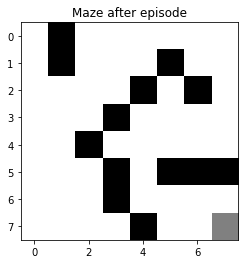

Epoch: 069/999 | Loss: 0.0007 | Episodes: 70 | Win count: 50 | Win rate: 0.969 | time: 43.25 minutes
Loss:  0.0008500555413775146
Loss:  0.000842773326439783
Loss:  0.0008492065826430917
Loss:  0.0005446767754619941
Loss:  0.0010487069375813007
Loss:  0.0012117198202759027
Loss:  0.000655100797303021
Loss:  0.0012057970161549747
Loss:  0.0008963286527432501
Loss:  0.0006276297790464014
Loss:  0.0004924284148728475
Loss:  0.001034372893627733
Loss:  0.0008943958673626184
Loss:  0.000748717546230182
Loss:  0.0005471605691127479
Loss:  0.0008549592457711697
Loss:  0.0013733789091929793
Loss:  0.0011940009135287255


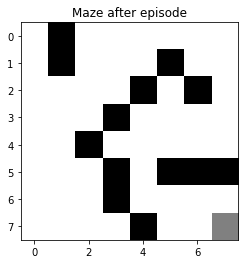

Epoch: 070/999 | Loss: 0.0012 | Episodes: 71 | Win count: 51 | Win rate: 1.000 | time: 43.35 minutes
Loss:  0.0005830214649904519
Loss:  0.0004450873384485021
Loss:  0.0007924023666419089
Loss:  0.0006030980148352683
Loss:  0.0004575691564241424
Loss:  0.0012625117087736726
Loss:  0.0005406684358604252
Loss:  0.0005633780529024079
Loss:  0.0006298803200479597
Loss:  0.0006894262478454039
Loss:  0.0006551544356625527
Loss:  0.0006347256130538881
Loss:  0.000930862472159788
Loss:  0.0010490547865629196
Loss:  0.0008530249760951847


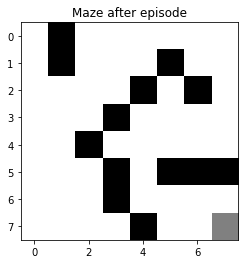

Epoch: 071/999 | Loss: 0.0009 | Episodes: 72 | Win count: 52 | Win rate: 1.000 | time: 43.44 minutes
Loss:  0.00045762830995954573
Loss:  0.0006222065421752632
Loss:  0.000665267783915624
Loss:  0.0004655594239011407
Loss:  0.001011055166600272
Loss:  0.0006965267821215093
Loss:  0.0008357734186574817
Loss:  0.0002923139909398742
Loss:  0.000790448160842061
Loss:  0.0009151085396297276
Loss:  0.00035926989221479744
Loss:  0.000512519822223112
Loss:  0.0007006423838902265
Loss:  0.0004216971428832039
Loss:  0.0008717350719962269
Loss:  0.0006763314304407686
Loss:  0.0005749216943513602
Loss:  0.0005560400313697755
Loss:  0.0007820580649422482


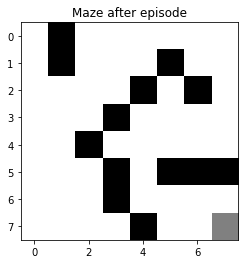

Epoch: 072/999 | Loss: 0.0008 | Episodes: 73 | Win count: 53 | Win rate: 1.000 | time: 43.55 minutes
Loss:  0.00018058923524222337
Loss:  0.0005698175809811801
Loss:  0.0005209319351706654
Loss:  0.000543380985618569
Loss:  0.0007884255755925551
Loss:  0.0010004594805650413
Loss:  0.0006270499434322119
Loss:  0.0011611851514317095
Loss:  0.0008850216399878263
Loss:  0.0005550723290070891
Loss:  0.0007401769980788231
Loss:  0.0007418374007102102
Loss:  0.0005666494253091514
Loss:  0.0007373635598924011
Loss:  0.0005491430638357997
Loss:  0.000582975015277043
Loss:  0.0007614614441990852
Loss:  0.0005589411011897027
Loss:  0.0005244798376224935
Loss:  0.0005239526508376002
Loss:  0.0003909845581802074
Loss:  0.000613818468991667
Loss:  0.0012711317394860089
Loss:  0.0007787905051372945
Loss:  0.0005623500619549304
Loss:  0.0006398698169505224
Loss:  0.0008014787454158068
Loss:  0.0002598235005280003
Loss:  0.000614394637523219
Loss:  0.0006300548266153783


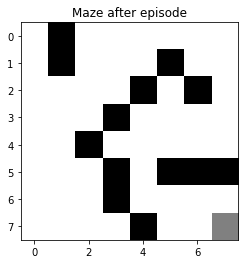

Epoch: 073/999 | Loss: 0.0006 | Episodes: 74 | Win count: 54 | Win rate: 1.000 | time: 43.72 minutes
Loss:  0.0006195645837578923
Loss:  0.0002615907578729093
Loss:  0.00017388423657394014
Loss:  0.00041948007128667086
Loss:  0.0005355912144295871
Loss:  0.0003828836925094947
Loss:  0.0006610874843318015
Loss:  0.0007296905823750421
Loss:  0.0009114987042266876
Loss:  0.00037160501233302057
Loss:  0.0008456283831037581
Loss:  0.000495891465106979
Loss:  0.0008998581906780601
Loss:  0.00083902184269391
Loss:  0.0007370009261649102
Loss:  0.000633935778751038
Loss:  0.0009043396858032793
Loss:  0.0004002989298896864


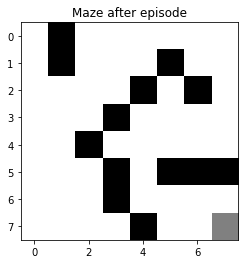

Epoch: 074/999 | Loss: 0.0004 | Episodes: 75 | Win count: 55 | Win rate: 1.000 | time: 43.83 minutes
Loss:  0.0008558931585866958
Loss:  0.0006567735981661826
Loss:  0.00044702275772579014
Loss:  0.0007036482857074589
Loss:  0.0008884486160241067
Loss:  0.0005097760003991425
Loss:  0.0006546958175022155
Loss:  0.00020038173533976078
Loss:  0.0006682331149931997
Loss:  0.0003820015845121816
Loss:  0.00011914644710486755
Loss:  0.00035019977076444775
Loss:  0.0005210487870499492


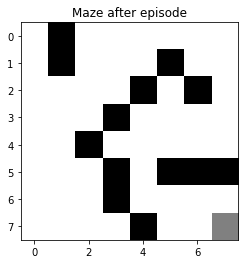

Epoch: 075/999 | Loss: 0.0005 | Episodes: 76 | Win count: 56 | Win rate: 1.000 | time: 43.90 minutes
Loss:  0.0003700828383443877


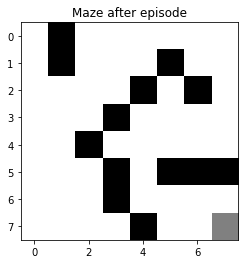

Epoch: 076/999 | Loss: 0.0004 | Episodes: 77 | Win count: 57 | Win rate: 1.000 | time: 43.92 minutes
Loss:  0.0006173679867060855
Loss:  0.0004427397361723706
Loss:  0.00032137085509020835
Loss:  0.000813937047496438
Loss:  0.0004748642386402935
Loss:  0.0006735931383445859
Loss:  0.00042409051093272865
Loss:  0.0005796548430225812
Loss:  0.0008742427453398705
Loss:  0.00036729007842950523


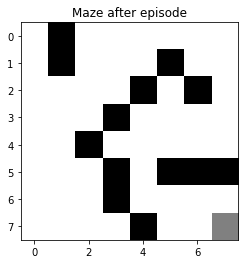

Epoch: 077/999 | Loss: 0.0004 | Episodes: 78 | Win count: 58 | Win rate: 1.000 | time: 43.97 minutes
Loss:  0.00019463899661786854
Loss:  0.00045708409743383527
Loss:  0.0002567356095823925
Loss:  0.00039079268753994256
Loss:  0.00021120597375556827
Loss:  0.0003637052432168275
Loss:  0.0004107083295821212
Loss:  0.0005843708349857479
Loss:  0.0005657676956616342
Loss:  0.000406963808927685
Loss:  0.0005720629851566628
Loss:  0.00046398508129641414


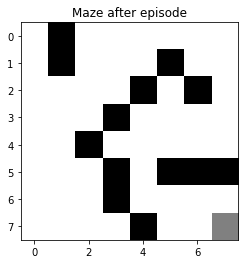

Epoch: 078/999 | Loss: 0.0005 | Episodes: 79 | Win count: 59 | Win rate: 1.000 | time: 44.03 minutes
Loss:  0.00027393916388973594
Loss:  0.0007976694905664772
Loss:  0.00023146609964896925
Loss:  0.00048257363960146904
Loss:  0.00037747052556369454
Loss:  0.0012303590192459524
Loss:  0.0007535622571595013
Loss:  0.0002881299442378804
Loss:  0.00029553637432400137
Loss:  0.0005578974669333547
Loss:  0.0005652318068314344
Loss:  0.0002789893333101645
Loss:  0.00016467387831653468
Loss:  0.000314110417093616
Loss:  0.00040464449557475746
Loss:  0.0010435435979161412
Loss:  0.0005507419409696013
Loss:  0.0005056417430751026


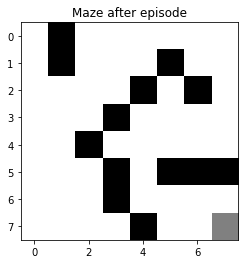

Epoch: 079/999 | Loss: 0.0005 | Episodes: 80 | Win count: 60 | Win rate: 1.000 | time: 44.13 minutes
Loss:  0.00026356906892033294
Loss:  0.0004047803013236262
Loss:  0.000665391082293354
Loss:  0.0008684745407663286
Loss:  0.0005512430652743205
Loss:  0.0007086833938956261
Loss:  0.0002642019389895722
Loss:  0.00019790704391198233
Loss:  0.0004864211950916797


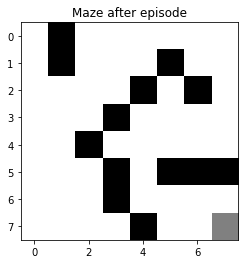

Epoch: 080/999 | Loss: 0.0005 | Episodes: 81 | Win count: 61 | Win rate: 1.000 | time: 44.20 minutes
Loss:  0.0005231966060819104
Loss:  0.00013473502986016683
Loss:  0.00023150960623752326
Loss:  0.000147451319207903
Loss:  0.0006585008959518746
Loss:  0.0005532410068553872
Loss:  0.0008180260774679482
Loss:  0.0005433284677565098
Loss:  0.0005626525526167825
Loss:  0.0004157876828685403
Loss:  0.0005001253157388419
Loss:  0.00041083496034843847
Loss:  0.0002440068928990513
Loss:  0.0004792672843905166
Loss:  0.00047163039562292397
Loss:  0.000286622886051191
Loss:  0.0008883222762960941
Loss:  0.0003360004848218523
Loss:  0.00034358368429820985
Loss:  0.00043399706191848963
Loss:  0.0002694750000955537


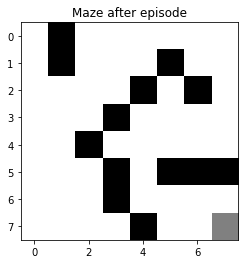

Epoch: 081/999 | Loss: 0.0003 | Episodes: 82 | Win count: 62 | Win rate: 1.000 | time: 44.31 minutes
Loss:  0.0009626963874325156
Loss:  0.0002437075600028038


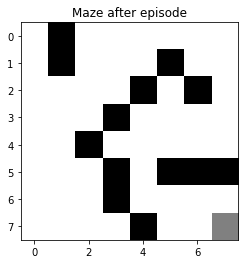

Epoch: 082/999 | Loss: 0.0002 | Episodes: 83 | Win count: 63 | Win rate: 1.000 | time: 44.33 minutes
Loss:  0.0005997461412334815
Loss:  0.0004047883558087051
Loss:  0.0004909952112939209
Loss:  0.0002615182238514535
Loss:  0.00047361386532429606
Loss:  0.0003075304557569325
Loss:  0.0005618092764052562
Loss:  0.0006154184375191107
Loss:  0.0002292366771143861
Loss:  0.00040920075844042003
Loss:  0.0007138918444979936
Loss:  0.000372577560483478
Loss:  0.00047059240750968456


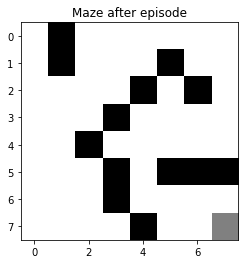

Epoch: 083/999 | Loss: 0.0005 | Episodes: 84 | Win count: 64 | Win rate: 1.000 | time: 44.40 minutes
Loss:  0.0002693900642043445
Loss:  0.00026370640262030065
Loss:  0.00028745759482262656
Loss:  0.0003240777878090739
Loss:  0.0008152336085913703
Loss:  0.00021171681328269187
Loss:  0.0005816224147565663
Loss:  0.00042061434214701876
Loss:  0.00017721868061926216
Loss:  0.00023656003031646833
Loss:  0.0003820020938292146
Loss:  0.00048404422705061734
Loss:  0.0006455028778873384
Loss:  0.00029138893296476454
Loss:  0.00033449097827542573
Loss:  0.0007183520938269794
Loss:  0.00034832335950341076
Loss:  0.00013047763241047505
Loss:  0.0005414910265244544
Loss:  0.00021776730864075944
Loss:  0.0002628845613799058
Loss:  0.00042557761480566114
Loss:  0.0005797082121716812
Loss:  0.0004933277232339606
Loss:  0.0005014637135900557
Loss:  0.00043117387394886464


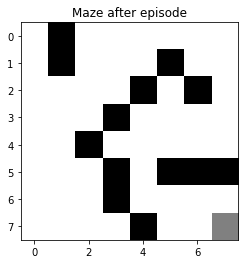

Epoch: 084/999 | Loss: 0.0004 | Episodes: 85 | Win count: 65 | Win rate: 1.000 | time: 44.54 minutes
Loss:  0.000310392162646167
Loss:  0.00031777361436979845
Loss:  0.00012130192044423893
Loss:  0.0003948868688894436
Loss:  0.0003050622181035578
Loss:  0.0005530074704438448
Loss:  0.00038198115362320095
Loss:  0.0006643779634032398
Loss:  0.00034464203054085374
Loss:  0.0004162228724453598
Loss:  0.00038252471131272614
Loss:  0.00036541947338264436
Loss:  0.0004790397433680482
Loss:  0.0006249404978007078
Loss:  0.0006451934750657529
Loss:  0.0008355840400326997
Loss:  0.000297883729217574
Loss:  0.00019862922999891452
Loss:  0.0006656483164988458
Loss:  0.00021023794761276804
Loss:  0.00035442748412606306


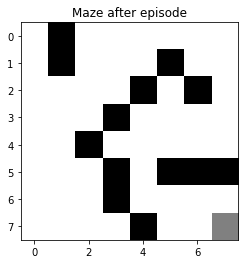

Epoch: 085/999 | Loss: 0.0004 | Episodes: 86 | Win count: 66 | Win rate: 1.000 | time: 44.66 minutes
Loss:  0.00025481699412921444
Loss:  0.0004992920512449928
Loss:  0.00013305821630638093
Loss:  0.00039937459223438054
Loss:  0.00019316080579301342
Loss:  0.0003267958636570256
Loss:  0.0005672052211593837
Loss:  0.00046755985022173263
Loss:  0.0003950905374949798


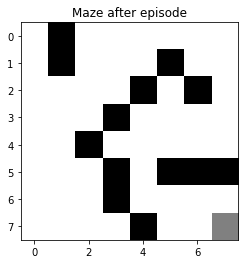

Epoch: 086/999 | Loss: 0.0004 | Episodes: 87 | Win count: 67 | Win rate: 1.000 | time: 44.71 minutes
Loss:  0.00025825630291365087
Loss:  0.00016999352374114096
Loss:  0.00038546917858184315
Loss:  0.0002794452739180997
Loss:  0.00032776112493593246
Loss:  0.0005403092363849282
Loss:  0.0004924193053739145
Loss:  0.0005390396545408294
Loss:  0.0004706200852524489
Loss:  0.0004407987325976137
Loss:  0.0006652105657849461


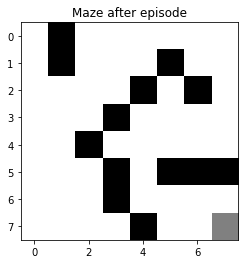

Epoch: 087/999 | Loss: 0.0007 | Episodes: 88 | Win count: 68 | Win rate: 1.000 | time: 44.78 minutes
Loss:  0.00034831313678296283
Loss:  0.0005971280625090003
Loss:  0.00029893164173699915
Loss:  0.0003920207964256406
Loss:  0.0003569876425899565
Loss:  0.0003828589105978608
Loss:  0.0005454060737974942
Loss:  0.00048154572141356766
Loss:  0.0006360907573252916
Loss:  0.00023254475672729313
Loss:  0.0002601870983198751
Loss:  0.0003709452721523121
Loss:  0.0004262415459379554
Loss:  0.00028095441666664556
Loss:  0.0003903236793121323
Loss:  0.0003025083933607675
Loss:  0.00021928176283836365
Loss:  0.0005644503107760102
Loss:  0.0002886845468310639
Loss:  0.00044578290544450283


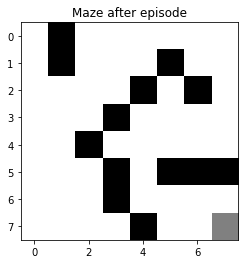

Epoch: 088/999 | Loss: 0.0004 | Episodes: 89 | Win count: 69 | Win rate: 1.000 | time: 44.92 minutes
Loss:  0.00031272773048840463
Loss:  0.0001839016331359744
Loss:  0.00010453326285642106
Loss:  0.00018479035134078003
Loss:  0.000850337150041014
Loss:  0.0006299998640315607
Loss:  0.0002383981118327938
Loss:  0.0002605233166832477
Loss:  0.0009017571283038706
Loss:  0.0003570155386114493
Loss:  0.00044856301246909425


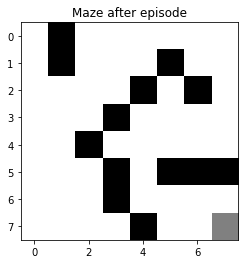

Epoch: 089/999 | Loss: 0.0004 | Episodes: 90 | Win count: 70 | Win rate: 1.000 | time: 45.00 minutes
Loss:  0.0004255749372532591
Loss:  0.0006142769998405129
Loss:  0.00032826837559696287
Loss:  0.00038233915984164923
Loss:  0.00022478852406493388
Loss:  0.0005110527854412794
Loss:  0.00034872979449573904
Loss:  0.00022721714049112052
Loss:  0.000645727152004838
Loss:  0.0003319881943752989
Loss:  0.0002727857790887356
Loss:  0.00039165060297818854
Loss:  0.00026363012148067355
Loss:  0.00030010596674401313
Loss:  0.0002850045457307715
Loss:  0.0004061300278408453
Loss:  0.0004809126112377271
Loss:  0.0005951948987785727
Loss:  0.0005178371357033029
Loss:  0.0003002451849170029
Loss:  0.0005917941743973643
Loss:  0.00036208330129738897
Loss:  0.0005501327250385657
Loss:  0.00042832765029743314
Loss:  0.0004195815490675159
Loss:  0.0007639665273018181
Loss:  0.000918320962227881
Loss:  0.0007920833886601031
Loss:  0.0004705292667495087
Loss:  0.00045726116513833404
Loss:  0.00037286008

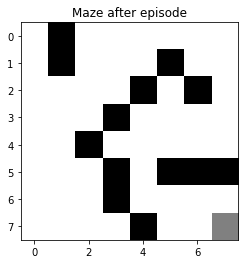

Epoch: 090/999 | Loss: 0.0008 | Episodes: 91 | Win count: 71 | Win rate: 1.000 | time: 45.65 minutes
Loss:  0.0002899232495110482
Loss:  0.00047760609595570713


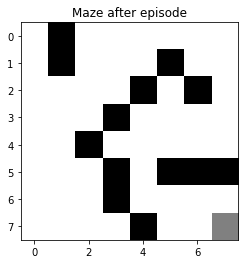

Epoch: 091/999 | Loss: 0.0005 | Episodes: 92 | Win count: 72 | Win rate: 1.000 | time: 45.66 minutes
Loss:  0.0010205534636043012
Loss:  0.0008510321204084903
Loss:  0.0012955042184330523
Loss:  0.0004770314262714237
Loss:  0.0009831475908868015
Loss:  0.0010055349848698825
Loss:  0.0005738038453273475
Loss:  0.0006021978333592415
Loss:  0.00045312943984754384
Loss:  0.0006229554419405758
Loss:  0.0004922388616250828
Loss:  0.0006209337734617293
Loss:  0.0003554651339072734
Loss:  0.0007446821837220341
Loss:  0.0003508487716317177
Loss:  0.0008547387842554599
Loss:  0.000671439542202279
Loss:  0.0006448609638027847
Loss:  0.0008223197946790606
Loss:  0.0006609695556107908
Loss:  0.0005659397429553792
Loss:  0.0007165423303376883
Loss:  0.0009741057874634862


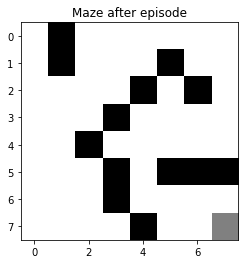

Epoch: 092/999 | Loss: 0.0010 | Episodes: 93 | Win count: 73 | Win rate: 1.000 | time: 45.81 minutes
Loss:  0.000869841082021594
Loss:  0.0006134024151833728
Loss:  0.00052117437007837
Loss:  0.0005214178818278015
Loss:  0.0008272998093161732
Loss:  0.00046459335135295987
Loss:  0.0005095796077512205
Loss:  0.0011144167510792613
Loss:  0.000496175343869254
Loss:  0.0007765863847453147
Loss:  0.0004625720175681636
Loss:  0.0006109434470999986
Loss:  0.0011466103605926037
Loss:  0.0007442553760483861
Loss:  0.0009960577881429344
Loss:  0.0008235698624048382
Loss:  0.000933140836423263
Loss:  0.0007822299958206713
Loss:  0.00047237062244676054
Loss:  0.0006544535863213241
Loss:  0.0006207476399140432
Loss:  0.0009505557245574892
Loss:  0.0006732584733981639
Loss:  0.0006918854778632522
Loss:  0.0012479242868721485
Loss:  0.0009437130356673151
Loss:  0.0006841942085884511
Loss:  0.0007468840922228992
Loss:  0.0007631297048646957
Loss:  0.0011535633821040392
Loss:  0.0005764057859778404
Los

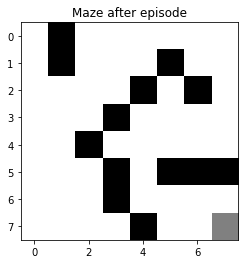

Epoch: 093/999 | Loss: 0.0007 | Episodes: 94 | Win count: 74 | Win rate: 1.000 | time: 46.09 minutes
Loss:  0.0008988478220999241
Loss:  0.0005853670882061124
Loss:  0.0012570949620567262
Loss:  0.0006422715960070491
Loss:  0.0010077311308123171
Loss:  0.0005096689419588074
Loss:  0.0005459686508402228
Loss:  0.0005933393549639732
Loss:  0.0007343210163526237
Loss:  0.0008865539566613734
Loss:  0.0005902115954086185
Loss:  0.00048331430298276246
Loss:  0.0006527147488668561
Loss:  0.00046226671838667244
Loss:  0.0006611267162952572
Loss:  0.0006807171739637852
Loss:  0.0006174686714075506
Loss:  0.0005643867771141231
Loss:  0.00048635315033607185
Loss:  0.0007726784097030759
Loss:  0.0005696593434549868
Loss:  0.0005778634949820116
Loss:  0.0007203003042377532
Loss:  0.00040346414607483894
Loss:  0.0004716461553471163


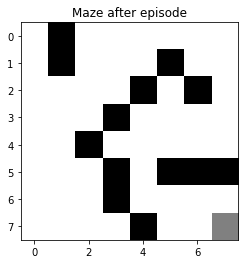

Epoch: 094/999 | Loss: 0.0005 | Episodes: 95 | Win count: 75 | Win rate: 1.000 | time: 46.21 minutes
Loss:  0.0005520415434148163
Loss:  0.000558305240701884
Loss:  0.0007697761175222695
Loss:  0.0005806075350847095
Loss:  0.0003718033549375832
Loss:  0.0005656942375935614
Loss:  0.0006804521544836462
Loss:  0.0005167896451894194
Loss:  0.0005876118957530707
Loss:  0.0007870068657211959
Loss:  0.0007129309233278036
Loss:  0.0008031533216126263
Loss:  0.0007523497624788433
Loss:  0.0007918186747701839
Loss:  0.00046926057257223874
Loss:  0.0006321288819890469
Loss:  0.000525855808518827
Loss:  0.0007192330522229895
Loss:  0.0006081858155084774
Loss:  0.0006243710522539914


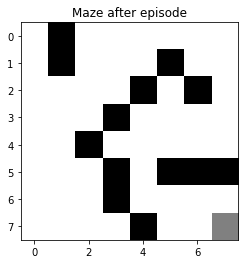

Epoch: 095/999 | Loss: 0.0006 | Episodes: 96 | Win count: 76 | Win rate: 1.000 | time: 46.32 minutes
Loss:  0.0007869132095947862
Loss:  0.0004858605971094221
Loss:  0.0009981117909774184
Loss:  0.0004263250157237053
Loss:  0.0007488694973289967
Loss:  0.0003550211258698255
Loss:  0.0007113121246220544
Loss:  0.0008671237155795097
Loss:  0.000668069435050711
Loss:  0.000534066668478772
Loss:  0.0006700572848785669
Loss:  0.0004913006268907338
Loss:  0.0008957696845754981
Loss:  0.0007081757357809693
Loss:  0.0003324268836877309
Loss:  0.0005988874181639403
Loss:  0.0006583547947229818
Loss:  0.000881831772858277
Loss:  0.00034007277281489223
Loss:  0.000983387406449765
Loss:  0.0007267864129971713
Loss:  0.0011536662932485342
Loss:  0.0007753823592793196
Loss:  0.0004470581334317103
Loss:  0.0007798184233251959
Loss:  0.001076243119314313
Loss:  0.0007172180339694023
Loss:  0.0006250293081393465


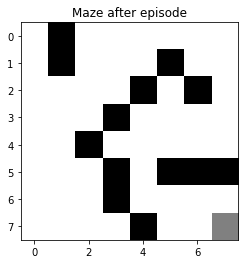

Epoch: 096/999 | Loss: 0.0006 | Episodes: 97 | Win count: 77 | Win rate: 1.000 | time: 46.48 minutes
Loss:  0.0006334196514217183
Loss:  0.0005407881690189242
Loss:  0.0008570106001570821


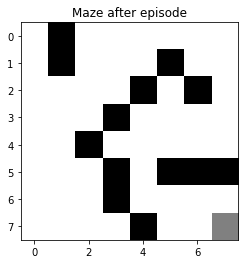

Epoch: 097/999 | Loss: 0.0009 | Episodes: 98 | Win count: 78 | Win rate: 1.000 | time: 46.50 minutes
Loss:  0.0009151390404440463
Loss:  0.0008038045198190957
Loss:  0.0007903992664068937
Loss:  0.0008648288494441658
Loss:  0.000599450955633074
Loss:  0.0009574114810675383
Loss:  0.0005907068843953311
Loss:  0.00041989926830865443
Loss:  0.00042917732207570225
Loss:  0.0007639894902240485
Loss:  0.0006979639292694628
Loss:  0.0005058821407146752
Loss:  0.0005557530093938112
Loss:  0.0010502380318939686
Loss:  0.0007830425165593624
Loss:  0.0008166087791323662
Loss:  0.000733227760065347
Loss:  0.0006576406885869801
Loss:  0.0010625121067278087
Loss:  0.0008819194626994431
Loss:  0.0008909660682547837
Loss:  0.001040224393364042
Loss:  0.0010273809893988073
Loss:  0.0006596939056180418
Loss:  0.0006300200911937281
Loss:  0.0008725782390683889
Loss:  0.0006566456868313253
Loss:  0.0006895459082443267


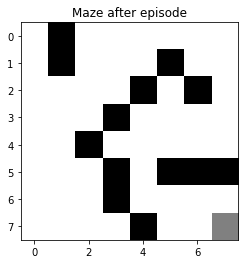

Epoch: 098/999 | Loss: 0.0007 | Episodes: 99 | Win count: 79 | Win rate: 1.000 | time: 46.67 minutes
Loss:  0.0010290774225722998
Loss:  0.0006082472973503172
Loss:  0.0011200946755707264
Loss:  0.0007376685389317572
Loss:  0.0004640878760255873
Loss:  0.0008260116737801582
Loss:  0.0008933939971029758
Loss:  0.0010460373014211655
Loss:  0.0009478731662966311
Loss:  0.0003983759816037491
Loss:  0.0006185067468322814
Loss:  0.0007982879760675132
Loss:  0.0006355868536047637
Loss:  0.0006815243978053331
Loss:  0.000551123172044754
Loss:  0.0007724658062215894
Loss:  0.0007200721302069724
Loss:  0.0007719681016169488
Loss:  0.00048108705959748477
Loss:  0.0006235560576897115
Loss:  0.0009580901823937893
Loss:  0.0007002205238677561
Loss:  0.0005907992017455399
Loss:  0.0005519710830412805
Loss:  0.0007672630163142458
Loss:  0.0006553083367180079
Loss:  0.000962451595114544
Loss:  0.0008330545388162136
Loss:  0.0006184143421705812


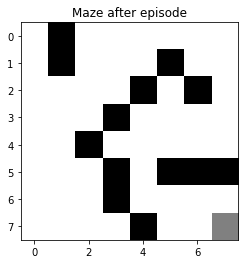

Epoch: 099/999 | Loss: 0.0006 | Episodes: 100 | Win count: 80 | Win rate: 1.000 | time: 46.84 minutes
Loss:  0.0008637463033664972
Loss:  0.0005190101655898616
Loss:  0.00036279347114032134
Loss:  0.0005315303787938319
Loss:  0.00031882246548775584
Loss:  0.0006438710261136293
Loss:  0.0008365132380276918
Loss:  0.0006353951466735452
Loss:  0.0005605389596894383
Loss:  0.0007200742402346805
Loss:  0.0005836118361912668
Loss:  0.0009625836974009871
Loss:  0.000767193385399878


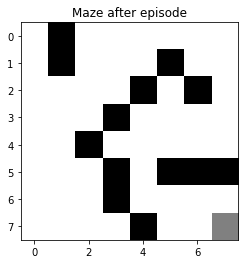

Epoch: 100/999 | Loss: 0.0008 | Episodes: 101 | Win count: 81 | Win rate: 1.000 | time: 46.91 minutes
Loss:  0.0007946288969833404
Loss:  0.0006248762656468898
Loss:  0.0012855130480602384
Loss:  0.0009742687980178744
Loss:  0.0007412139384541661
Loss:  0.0006249165744520724
Loss:  0.0009787823510123417
Loss:  0.0006751329347025603
Loss:  0.0008095357043202966
Loss:  0.0005679613095708191
Loss:  0.00032404958619736135
Loss:  0.0006035357364453375
Loss:  0.0010290627251379192
Loss:  0.0008927446033339947
Loss:  0.0008661262108944356
Loss:  0.0008054286590777338
Loss:  0.0011578416160773486
Loss:  0.0008661058382131159
Loss:  0.0011056014336645603
Loss:  0.00105940256617032
Loss:  0.0010188749874942005
Loss:  0.0008144840539898723
Loss:  0.0008878054795786738
Loss:  0.0003547698142938316
Loss:  0.0006505262572318316
Loss:  0.0009270167793147266
Loss:  0.0004843765345867723
Loss:  0.0007989229925442487
Loss:  0.0008141804719343781
Loss:  0.0007969777507241815
Loss:  0.0007667591125937179


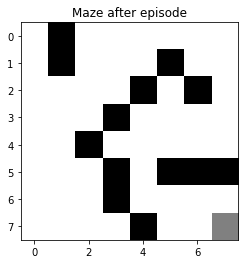

Epoch: 101/999 | Loss: 0.0006 | Episodes: 102 | Win count: 82 | Win rate: 1.000 | time: 47.11 minutes
Loss:  0.0008297539607156068
Loss:  0.0010158152435906231
Loss:  0.0005818578065373003
Loss:  0.0007002702332101762
Loss:  0.000877206155564636


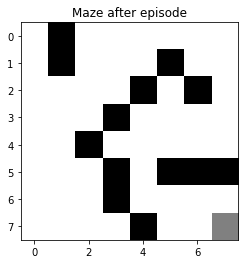

Epoch: 102/999 | Loss: 0.0009 | Episodes: 103 | Win count: 83 | Win rate: 1.000 | time: 47.14 minutes
Loss:  0.0010010593687184155
Loss:  0.0008526311139576137
Loss:  0.0006687293207505718
Loss:  0.0002985164610436186
Loss:  0.0007759039290249348
Loss:  0.0009788282332010567
Loss:  0.000647907960228622
Loss:  0.0010235327645204961
Loss:  0.0004897710750810802
Loss:  0.001289408770389855


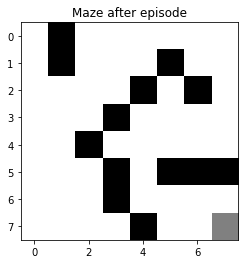

Epoch: 103/999 | Loss: 0.0013 | Episodes: 104 | Win count: 84 | Win rate: 1.000 | time: 47.20 minutes
Loss:  0.001132792211137712
Loss:  0.000667371874442324
Loss:  0.0009593356226105243
Loss:  0.0006440465949708596
Loss:  0.0009237491176463664
Loss:  0.0007558199868071824
Loss:  0.0012235550093464553
Loss:  0.0010660236002877355
Loss:  0.0009681449446361512
Loss:  0.000514656218001619
Loss:  0.0008029410964809358
Loss:  0.0007591346220578998
Loss:  0.0007344334735535085
Loss:  0.0010138408397324383
Loss:  0.0009886478364933282
Loss:  0.0009218851919285953
Loss:  0.00108802824979648
Loss:  0.000730184547137469
Loss:  0.0010042380599770695
Loss:  0.0005295729788485914
Loss:  0.0006741270190104842
Loss:  0.0007393923297058791
Loss:  0.0009806532762013376
Loss:  0.0008742333156988025
Loss:  0.0008793663000687957
Loss:  0.0009570692491251975
Loss:  0.0012052138918079436
Loss:  0.0007486634713131934
Loss:  0.0007733310339972377
Loss:  0.001285409030970186
Loss:  0.0010761513840407133
Loss: 

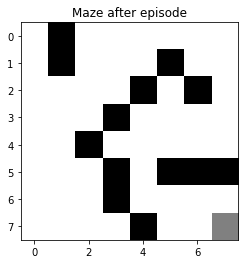

Epoch: 104/999 | Loss: 0.0004 | Episodes: 105 | Win count: 85 | Win rate: 1.000 | time: 47.40 minutes
Loss:  0.0004960427177138627
Loss:  0.0006142083730082959
Loss:  0.0005572542868321761
Loss:  0.0010094433673657477
Loss:  0.0007285789761226624
Loss:  0.0014152086805552244
Loss:  0.0007557280769106001
Loss:  0.0006467511120717973


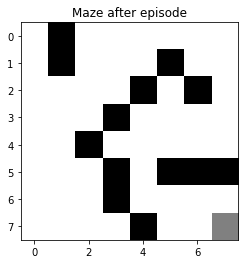

Epoch: 105/999 | Loss: 0.0006 | Episodes: 106 | Win count: 86 | Win rate: 1.000 | time: 47.44 minutes
Loss:  0.0007112851017154753
Loss:  0.0003240576770622283
Loss:  0.000864431553054601
Loss:  0.0007084331300575286
Loss:  0.0008323832298628986
Loss:  0.000591273681493476
Loss:  0.001077936205547303
Loss:  0.0006380375125445426
Loss:  0.0010628345480654389
Loss:  0.0009931584354490042
Loss:  0.0010117109632119536
Loss:  0.0007702186703681946
Loss:  0.0004678053373936564
Loss:  0.0009443499729968607
Loss:  0.0006753772031515837
Loss:  0.0004207447709632106
Loss:  0.0003437935374677181
Loss:  0.0007895095623098314
Loss:  0.00048503660946153104


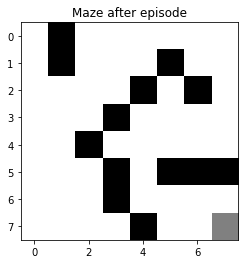

Epoch: 106/999 | Loss: 0.0005 | Episodes: 107 | Win count: 87 | Win rate: 1.000 | time: 47.55 minutes
Loss:  0.0006842056172899902
Loss:  0.0006282256217673421
Loss:  0.0009924782207235694
Loss:  0.0009906551276799291
Loss:  0.0007315841794479638
Loss:  0.0006877504056319594
Loss:  0.0013051030691713095
Loss:  0.0010875397128984332
Loss:  0.0008982474100776017
Loss:  0.00034673302798182704
Loss:  0.0008794772438704967
Loss:  0.0011097134556621313
Loss:  0.000774628046201542
Loss:  0.0008211251988541335
Loss:  0.001022484095301479
Loss:  0.0006555853033205494
Loss:  0.0011253345292061567
Loss:  0.0008868365839589387
Loss:  0.0006858177366666496
Loss:  0.0007367574144154787
Loss:  0.0007092151645338163
Loss:  0.0006375298835337162
Loss:  0.0011783833615481853
Loss:  0.0010327703785151243
Loss:  0.0007406346849165857
Loss:  0.0005557325639529154
Loss:  0.0009563484345562756
Loss:  0.0003268234031565953
Loss:  0.0007616572838742286
Loss:  0.0012988807284273207


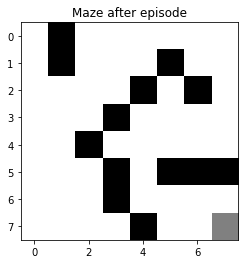

Epoch: 107/999 | Loss: 0.0013 | Episodes: 108 | Win count: 88 | Win rate: 1.000 | time: 47.71 minutes
Loss:  0.0005792695155832916
Loss:  0.0009824801236391068
Loss:  0.0013306466862559319
Loss:  0.0007000718323979527
Loss:  0.0009564763749949634
Loss:  0.0008719124307390302
Loss:  0.0009783681598491967
Loss:  0.0005061355768702924
Loss:  0.0004703361337305978


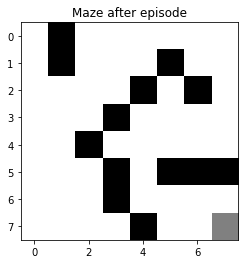

Epoch: 108/999 | Loss: 0.0005 | Episodes: 109 | Win count: 89 | Win rate: 1.000 | time: 47.77 minutes
Loss:  0.00036604156775865704
Loss:  0.0006915213307365775
Loss:  0.0010263043805025518
Loss:  0.0005126892501721159
Loss:  0.00023499764211010188


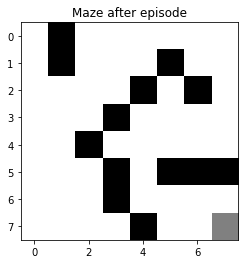

Epoch: 109/999 | Loss: 0.0002 | Episodes: 110 | Win count: 90 | Win rate: 1.000 | time: 47.80 minutes
Loss:  0.0007942413212731481
Loss:  0.0009392426873091608
Loss:  0.0006733799818903208
Loss:  0.0005973242514301091
Loss:  0.0009659637580625713
Loss:  0.0005810354487039149
Loss:  0.0008696815057191998
Loss:  0.0009089882369153202
Loss:  0.00023483686163672246
Loss:  0.0011048700544051826
Loss:  0.0004795445274794474
Loss:  0.0012160226760897785
Loss:  0.0005678923043888062
Loss:  0.0005707927193725482
Loss:  0.0010267904144711792
Loss:  0.0008565220050513744
Loss:  0.0006081597821321338
Loss:  0.00065334074315615
Loss:  0.0006754585192538798
Loss:  0.000870449555804953
Loss:  0.0008080333354882896
Loss:  0.0005579068674705923
Loss:  0.0004652133648050949
Loss:  0.000494385909405537


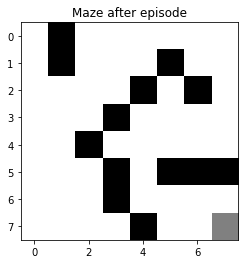

Epoch: 110/999 | Loss: 0.0005 | Episodes: 111 | Win count: 91 | Win rate: 1.000 | time: 47.93 minutes
Loss:  0.0007059180061332881
Loss:  0.0006259860238060355


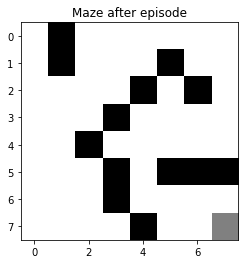

Epoch: 111/999 | Loss: 0.0006 | Episodes: 112 | Win count: 92 | Win rate: 1.000 | time: 47.95 minutes
Loss:  0.0008661067113280296
Loss:  0.0010027290845755488
Loss:  0.0006464988109655678
Loss:  0.0008432454196736217
Loss:  0.0004587911389535293
Loss:  0.0009803762077353895
Loss:  0.0007404692296404392
Loss:  0.0006615572783630341
Loss:  0.0007564211555290967
Loss:  0.0005191826494410634
Loss:  0.0008211427484638989
Loss:  0.0007813887787051499
Loss:  0.0011076813680119812
Loss:  0.000501432892633602
Loss:  0.0007104450196493417


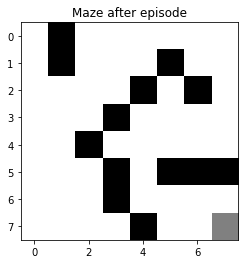

Epoch: 112/999 | Loss: 0.0007 | Episodes: 113 | Win count: 93 | Win rate: 1.000 | time: 48.04 minutes
Loss:  0.000507566932355985
Loss:  0.0005674329440807924
Loss:  0.0006439917342504486
Loss:  0.000968144231592305
Loss:  0.0009273297036997974
Loss:  0.0006259845686145127
Loss:  0.0008693778945598751
Loss:  0.0005712138081435114
Loss:  0.0005845082923769951
Loss:  0.0006562133494298905
Loss:  0.0010507336119189858
Loss:  0.0009211071010213345
Loss:  0.000507817865582183
Loss:  0.00031839632720220834
Loss:  0.0005293256690492854
Loss:  0.0008136570104397833
Loss:  0.0010659722029231489
Loss:  0.0009521805332042277
Loss:  0.00039313356683123857
Loss:  0.0006571232370333746
Loss:  0.000733555294573307
Loss:  0.0007044840895105153
Loss:  0.0006145913066575304
Loss:  0.0008575982647016644
Loss:  0.0009394509834237397
Loss:  0.0006825661985203624
Loss:  0.0009924831974785775


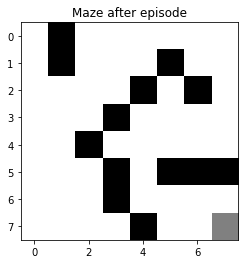

Epoch: 113/999 | Loss: 0.0010 | Episodes: 114 | Win count: 94 | Win rate: 1.000 | time: 48.20 minutes
Loss:  0.0007163494010455906
Loss:  0.0009882322046905756
Loss:  0.0007348968647420406
Loss:  0.0013063494116067886
Loss:  0.0008098797698039562


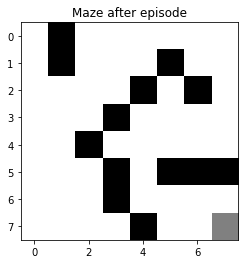

Epoch: 114/999 | Loss: 0.0008 | Episodes: 115 | Win count: 95 | Win rate: 1.000 | time: 48.23 minutes
Loss:  0.0007977501809364185
Loss:  0.0008059751999098808
Loss:  0.0004930853028781712
Loss:  0.0008410904265474528
Loss:  0.0003316680667921901
Loss:  0.0005830536101711914
Loss:  0.00036199741589371115
Loss:  0.0005559169076150283
Loss:  0.0005701140325982124
Loss:  0.0005819486686959863
Loss:  0.0007376417925115675
Loss:  0.0007016664021648467
Loss:  0.0005135160608915612
Loss:  0.0006608858529943973
Loss:  0.0006249425350688398
Loss:  0.0004901000647805631
Loss:  0.0006854590319562703
Loss:  0.0007505513494834304
Loss:  0.00044789319508709013
Loss:  0.00022719628395861946
Loss:  0.00031320538255386055
Loss:  0.0007955760811455548
Loss:  0.0007063635130180046
Loss:  0.0009387320897076279
Loss:  0.0006196639151312411
Loss:  0.0005489296454470605
Loss:  0.0009681281226221472
Loss:  0.0008527481113560498
Loss:  0.0007598711817990988
Loss:  0.0005436200881376863
Loss:  0.000610017319559

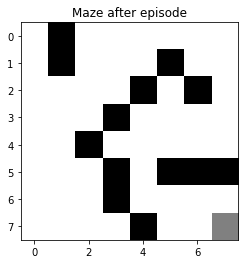

Epoch: 115/999 | Loss: 0.0006 | Episodes: 116 | Win count: 96 | Win rate: 1.000 | time: 48.41 minutes
Loss:  0.0006766979058738798


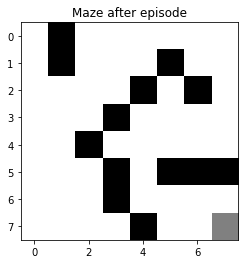

Epoch: 116/999 | Loss: 0.0007 | Episodes: 117 | Win count: 97 | Win rate: 1.000 | time: 48.42 minutes
Loss:  0.00036869628820568323
Loss:  0.0005612430395558476
Loss:  0.0004493526357691735
Loss:  0.0008640005253255367
Loss:  0.0005887058359803632
Loss:  0.0008152975351549685
Loss:  0.0004888598050456494
Loss:  0.0005779624043498188
Loss:  0.0011463197297416627
Loss:  0.0005206519417697564
Loss:  0.0006379882106557488
Loss:  0.0004937669291393831
Loss:  0.0004737043200293556
Loss:  0.0007624483841937035
Loss:  0.0004896040845778771
Loss:  0.0003274454065831378
Loss:  0.0006111226102802902


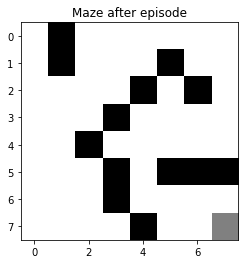

Epoch: 117/999 | Loss: 0.0006 | Episodes: 118 | Win count: 98 | Win rate: 1.000 | time: 48.53 minutes
Loss:  0.0006735249771736562
Loss:  0.00034257971856277436
Loss:  0.0006206398247741163
Loss:  0.00019421281467657536
Loss:  0.0007835254073143005
Loss:  0.00047014927258715034
Loss:  0.00047776462452020496
Loss:  0.000525751820532605
Loss:  0.00032782615744508803


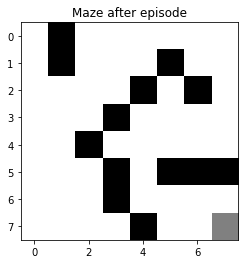

Epoch: 118/999 | Loss: 0.0003 | Episodes: 119 | Win count: 99 | Win rate: 1.000 | time: 48.59 minutes
Loss:  0.0006327751034405082
Loss:  0.0005031484179198742
Loss:  0.0004749929648824036
Loss:  0.00034452794352546334
Loss:  0.0006742111727362499
Loss:  0.0007355473790084943
Loss:  0.0002551957077230327
Loss:  0.0008468629384879023
Loss:  0.0005753592995461076
Loss:  0.0007372290128841996
Loss:  0.0005041394761065021
Loss:  0.0006886086775921285
Loss:  0.0007016514427959919
Loss:  0.0008730631088837981
Loss:  0.0003303830890217796
Loss:  0.0005397438071668148
Loss:  0.000646433123620227
Loss:  0.00048109801718965173
Loss:  0.0004306012997403741
Loss:  0.0005674772255588323
Loss:  0.0005387666024034843
Loss:  0.0007597331423312426
Loss:  0.0003419270506128669
Loss:  0.00038835458690300584
Loss:  0.00094796103076078
Loss:  0.0005521384300664067
Loss:  0.0005275217408780009
Loss:  0.0006938812148291618
Loss:  0.000463177653728053


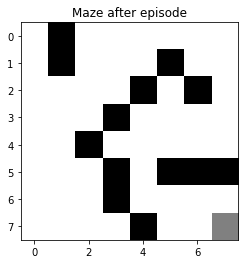

Epoch: 119/999 | Loss: 0.0005 | Episodes: 120 | Win count: 100 | Win rate: 1.000 | time: 48.75 minutes
Loss:  0.0004641766718123108
Loss:  0.0005234861455392092
Loss:  0.0005777776532340795
Loss:  0.00038507796125486493
Loss:  0.0005117341788718477
Loss:  0.00031196528289001435
Loss:  0.00012654519377974793
Loss:  0.00022656215878669173
Loss:  0.00020919970120303333
Loss:  0.0003664686664706096
Loss:  0.000615808879956603
Loss:  0.0007606488070450723
Loss:  0.00035209849011152983
Loss:  0.0003661634400486946
Loss:  7.173008816607762e-05
Loss:  0.0009089522645808756
Loss:  0.0006439167846110649
Loss:  0.0007258598925545812
Loss:  0.00044757823343388736
Loss:  0.00045052940549794585
Loss:  0.0004003649919468444
Loss:  0.0003492727119009942
Loss:  0.000621864601271227


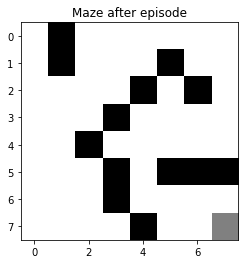

Epoch: 120/999 | Loss: 0.0006 | Episodes: 121 | Win count: 101 | Win rate: 1.000 | time: 48.89 minutes
Loss:  0.00048590674123261124
Loss:  0.00011850833107018843
Loss:  0.0005154330283403397
Loss:  0.0002589086288935505
Loss:  0.00039168990042526275
Loss:  0.0003681368980323896
Loss:  0.0007582846446894109
Loss:  0.0005276570882415399
Loss:  0.0001620637412997894


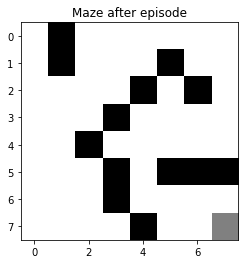

Epoch: 121/999 | Loss: 0.0002 | Episodes: 122 | Win count: 102 | Win rate: 1.000 | time: 48.94 minutes
Loss:  0.0002804520609061001
Loss:  0.0005043830897193402
Loss:  0.0003673016544780694
Loss:  0.0005694835854228586
Loss:  0.0004905487003270537
Loss:  0.000569406125578098
Loss:  0.00067273949207447
Loss:  0.00020654472609749064
Loss:  0.00021724078396800905
Loss:  0.0003423598827794194
Loss:  0.00016829213564051315
Loss:  0.00032597186509519815
Loss:  7.410885518766008e-05
Loss:  0.00033341272501274943
Loss:  0.0002917810343205929
Loss:  0.00023067778784024995
Loss:  0.000488276120449882
Loss:  0.0004314718535169959
Loss:  0.00044614181388169527
Loss:  0.0002342759253224358
Loss:  0.00036729720886796713
Loss:  0.0004433738795341924
Loss:  0.0004930654831696302
Loss:  0.00026511763280723244
Loss:  0.00023542811686638743
Loss:  0.000776953820604831
Loss:  0.00032870373979676515
Loss:  0.0005485824367497116
Loss:  0.000584632987738587
Loss:  0.00011430693666625302


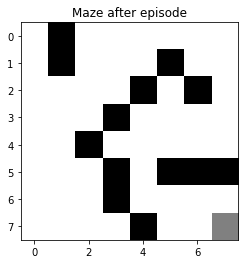

Epoch: 122/999 | Loss: 0.0001 | Episodes: 123 | Win count: 103 | Win rate: 1.000 | time: 49.10 minutes
Loss:  0.0005593281821347773
Loss:  0.00016756290278863162
Loss:  0.0006318447121884674
Loss:  0.0005335989699233323
Loss:  0.0005009811720810831
Loss:  0.00014697688675369136
Loss:  0.00038994403439573944
Loss:  0.00023486429199692793
Loss:  0.0003046171259484254
Loss:  0.00031025887074065395
Loss:  0.000306701214867644
Loss:  0.00038705242332071066
Loss:  0.0003028019273187965
Loss:  0.00036230223486199975
Loss:  0.0004354833872639574
Loss:  0.000294731289613992
Loss:  0.0009106103680096567
Loss:  0.00037127894756849855
Loss:  0.00021504217147594318
Loss:  0.0004174038767814636
Loss:  0.0009603577782399952
Loss:  0.0005834455078002065
Loss:  0.00038523854163940996
Loss:  0.0005581760196946561
Loss:  9.202170258504339e-05
Loss:  0.000395429422496818
Loss:  0.00042095634853467345
Loss:  0.0003307922015665099
Loss:  0.00027878394757863134
Loss:  0.00027071128351963125
Loss:  0.00044420

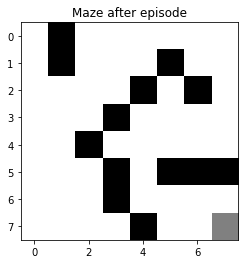

Epoch: 123/999 | Loss: 0.0004 | Episodes: 124 | Win count: 104 | Win rate: 1.000 | time: 49.27 minutes
Loss:  0.0004072174124303274
Loss:  0.0004353941621957347
Loss:  0.000418756011640653
Loss:  0.0005131922516738996
Loss:  0.0004319395375205204
Loss:  0.00039543021557619795
Loss:  0.00029059345251880586
Loss:  9.512025644653477e-05
Loss:  0.00043019601434934884
Loss:  0.00027248572405369487
Loss:  0.0005944460572209209
Loss:  0.00035586907324614003
Loss:  0.00023468979634344578
Loss:  0.000865098147187382
Loss:  0.00027826845325762406
Loss:  0.00025844152332865633
Loss:  0.0005886678700335324
Loss:  0.00028768996708095074
Loss:  0.0003699289445648901
Loss:  0.00046579824993386865


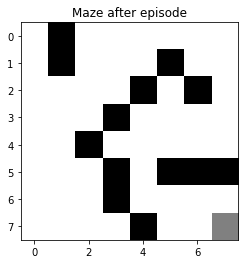

Epoch: 124/999 | Loss: 0.0005 | Episodes: 125 | Win count: 105 | Win rate: 1.000 | time: 49.38 minutes
Loss:  0.0006979478639550507


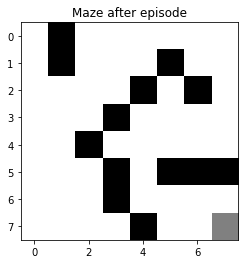

Epoch: 125/999 | Loss: 0.0007 | Episodes: 126 | Win count: 106 | Win rate: 1.000 | time: 49.39 minutes
Loss:  0.0005291007037158124
Loss:  0.0004014359292341396
Loss:  0.0003507445362629369
Loss:  0.00039682268106844276
Loss:  0.00013125972691341303
Loss:  0.00024705788018763997
Loss:  2.2435722712543793e-05
Loss:  8.910164251574315e-05
Loss:  0.00026231275114696473
Loss:  0.0003837381227640435
Loss:  0.0006587174284504727


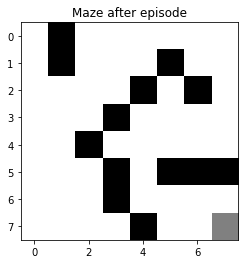

Epoch: 126/999 | Loss: 0.0007 | Episodes: 127 | Win count: 107 | Win rate: 1.000 | time: 49.46 minutes
Loss:  0.0007429329416481778
Loss:  0.0001555648195790127
Loss:  0.0001574753550812602
Loss:  0.00040052563417702913
Loss:  0.0002483947973814793
Loss:  0.0004271664220141247
Loss:  0.0006751114560756832
Loss:  0.0003677973509184085
Loss:  0.0005779239727417007
Loss:  0.00023070861061569303
Loss:  0.00012083366527804174
Loss:  0.0006102902480051853
Loss:  0.0004679802805185318
Loss:  0.0003136498271487653
Loss:  9.410640450369101e-05
Loss:  0.00011197704588994384
Loss:  7.590892710140906e-05
Loss:  0.0002887417358579114
Loss:  0.0008306440722662956
Loss:  0.00020927599689457566
Loss:  0.0007141317473724484
Loss:  0.000163394024639274
Loss:  0.0006656434270553291
Loss:  0.0005485317451530136
Loss:  0.0005373290478019044
Loss:  0.0008653556869830936


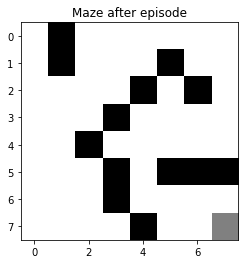

Epoch: 127/999 | Loss: 0.0009 | Episodes: 128 | Win count: 108 | Win rate: 1.000 | time: 49.60 minutes
Loss:  0.0004263937735231593
Loss:  0.0006422115257009864
Loss:  0.00025515798915876076
Loss:  7.58171699999366e-05
Loss:  0.00019960520512540825
Loss:  0.0004412225098349154
Loss:  0.0007054342277115211
Loss:  0.0006483911565737799
Loss:  0.00032025638211052865
Loss:  0.0007873091526562348
Loss:  0.0006992854468990117
Loss:  0.00031615831176168285
Loss:  0.0004919784405501559
Loss:  0.0002623944019433111


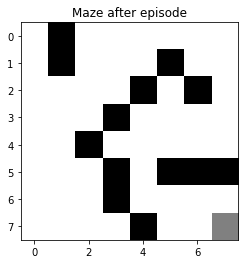

Epoch: 128/999 | Loss: 0.0003 | Episodes: 129 | Win count: 109 | Win rate: 1.000 | time: 49.68 minutes
Loss:  0.00018315797569812275
Loss:  0.00035425870009930804
Loss:  0.0002087110187858343
Loss:  9.33622031880077e-05
Loss:  0.00040603037632536143
Loss:  0.00026469796284800395
Loss:  0.0004565529088722542
Loss:  0.00014862477110000327
Loss:  0.000503125433169771
Loss:  3.71635705960216e-05
Loss:  0.00014323616778710857
Loss:  0.00047717355482745916
Loss:  0.0006778739625588059


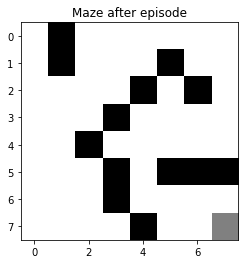

Epoch: 129/999 | Loss: 0.0007 | Episodes: 130 | Win count: 110 | Win rate: 1.000 | time: 49.75 minutes
Loss:  0.0004346115601947531
Loss:  0.0005981549911666662
Loss:  9.87698367680423e-05
Loss:  0.000263358888332732
Loss:  0.00033909645571839064
Loss:  0.00023125125881051645
Loss:  0.0003392094076843932
Loss:  7.407150587823708e-05
Loss:  0.00031390965887112543
Loss:  0.00045250185939949006
Loss:  0.0003269367734901607
Loss:  0.00037869667357881553
Loss:  0.0005588687781710178
Loss:  0.0007048749248497188
Loss:  0.0003039255097974092
Loss:  0.0003679903384181671
Loss:  0.0005216022764216177
Loss:  0.00021460586140165105
Loss:  9.447782031202223e-05
Loss:  0.0005533978255698457
Loss:  0.0002579712381702848
Loss:  0.00031499244323640596
Loss:  3.9419390304828994e-05
Loss:  0.0008302640926558524
Loss:  0.00010544502583798021


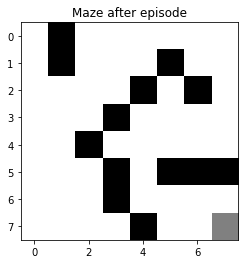

Epoch: 130/999 | Loss: 0.0001 | Episodes: 131 | Win count: 111 | Win rate: 1.000 | time: 49.90 minutes
Loss:  0.0003516119140840601
Loss:  0.00023819823218218517
Loss:  0.000480929171317257
Loss:  0.0003201542131137103
Loss:  0.0003789865950238891
Loss:  0.0004037953622173518
Loss:  0.00034677289659157395
Loss:  0.00048538370174355805
Loss:  0.00019918291945941746


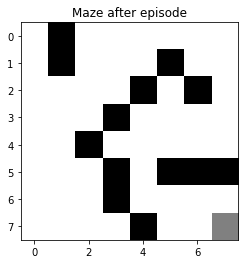

Epoch: 131/999 | Loss: 0.0002 | Episodes: 132 | Win count: 112 | Win rate: 1.000 | time: 49.96 minutes
Loss:  0.00024047493207035586
Loss:  0.0003486584737402154
Loss:  0.00025731613095558714
Loss:  0.00043756060767918825
Loss:  0.00020650431542890146
Loss:  6.57167074678e-05
Loss:  0.000542984576895833
Loss:  0.00022987468400970101
Loss:  0.00027980561208096333
Loss:  0.00010490055137779564
Loss:  0.00013965919788461179
Loss:  0.00031683334236731753
Loss:  0.00044364923087414354
Loss:  0.0004390305039123632
Loss:  0.0003407931508263573
Loss:  0.00017454737826483324
Loss:  0.0002506583114154637
Loss:  0.0004930330178467557


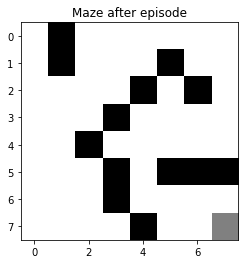

Epoch: 132/999 | Loss: 0.0005 | Episodes: 133 | Win count: 113 | Win rate: 1.000 | time: 50.10 minutes
Loss:  0.0002977349213324487
Loss:  8.007150609046221e-05


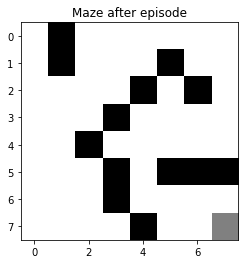

Epoch: 133/999 | Loss: 0.0001 | Episodes: 134 | Win count: 114 | Win rate: 1.000 | time: 50.13 minutes
Loss:  0.00022046329104341567
Loss:  0.00045604092883877456
Loss:  7.47145513741998e-05
Loss:  2.688835229491815e-05
Loss:  0.0006809941842220724
Loss:  0.0003163951841997914
Loss:  0.00018745006673270836
Loss:  0.00010855633445316926
Loss:  0.0003716173305292614
Loss:  0.0007070058636600152
Loss:  0.00028615952032851055
Loss:  0.0007966436387505382
Loss:  0.0006162769059301354
Loss:  0.00034594636599649675
Loss:  0.0002370525398873724
Loss:  0.00029858654306735843
Loss:  0.0003770513867493719
Loss:  0.00018539927987148985
Loss:  0.0007687462493777275
Loss:  0.0003980641340604052
Loss:  8.489015817758627e-05
Loss:  0.0007216837839223444
Loss:  0.00033948982309084386
Loss:  0.0002421038952888921
Loss:  0.0006433262606151402
Loss:  0.00043515756260603666
Loss:  0.0006359347025863826
Loss:  0.0004057737714902032
Loss:  0.00035911570012103766
Loss:  0.0002700452459976077
Loss:  6.12999156

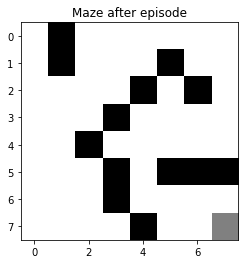

Epoch: 134/999 | Loss: 0.0003 | Episodes: 135 | Win count: 115 | Win rate: 1.000 | time: 50.34 minutes
Loss:  0.0005443041445687413


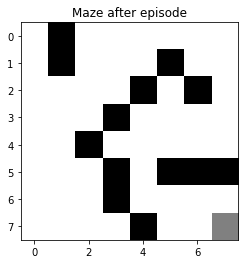

Epoch: 135/999 | Loss: 0.0005 | Episodes: 136 | Win count: 116 | Win rate: 1.000 | time: 50.35 minutes
Loss:  0.00027225773374084383
Loss:  0.0005600933800451458
Loss:  0.0002940063423011452
Loss:  0.0003125922958133742
Loss:  0.0005339569179341197
Loss:  0.0005056437803432345
Loss:  0.00024118542569340207
Loss:  0.000145428810355952
Loss:  0.0005074239888926968
Loss:  0.000438259681686759
Loss:  0.00039645623473916203
Loss:  0.00018149433890357614
Loss:  0.0005090484701213427
Loss:  0.0004797310757567175
Loss:  0.0004923048982163891
Loss:  0.0009754992206580937
Loss:  0.00022618960065301508
Loss:  0.00018860006639442872
Loss:  0.00038378861063392833
Loss:  3.644070602604188e-05
Loss:  0.00039759400533512235
Loss:  0.0005650035163853317
Loss:  0.0003836086980300024
Loss:  0.000589533883612603
Loss:  0.00035357299202587456


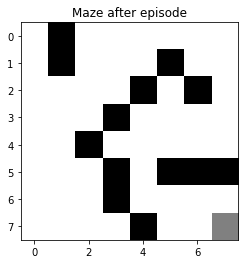

Epoch: 136/999 | Loss: 0.0004 | Episodes: 137 | Win count: 117 | Win rate: 1.000 | time: 50.54 minutes
Loss:  0.0003005905164172873
Loss:  0.00041456515464233235
Loss:  0.0004047133625135757
Loss:  0.0006992749695200473
Loss:  0.00010165086132474244
Loss:  0.0004972433271177579
Loss:  0.0002870108000934124
Loss:  0.00040884623012971133
Loss:  0.0001836984374676831
Loss:  9.437598055228591e-05
Loss:  0.0002569756470620632
Loss:  0.00023430754663422704
Loss:  0.0003066481585847214
Loss:  0.0002615096964291297
Loss:  0.00016620179303572513


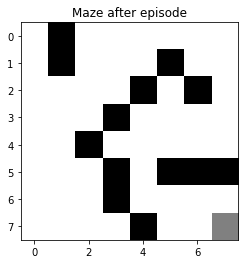

Epoch: 137/999 | Loss: 0.0002 | Episodes: 138 | Win count: 118 | Win rate: 1.000 | time: 50.64 minutes
Loss:  0.00018805234140018
Loss:  0.00047871402057353407
Loss:  0.0004473321605473757
Loss:  0.0005222089966991916
Loss:  0.0006077392026782036
Loss:  0.000414283131249249
Loss:  0.0005033046763855964
Loss:  0.0002311741773155518
Loss:  0.00012211158173158765
Loss:  0.0003303653938928619
Loss:  0.0003912609099643305
Loss:  0.0003289768210379407
Loss:  8.179948235920165e-05
Loss:  0.00027741380472434685
Loss:  2.8678871785814408e-05
Loss:  0.00042993070383090526
Loss:  0.0005132749211043119
Loss:  0.0002665778411028441
Loss:  0.00031617963759345
Loss:  0.00021228454352240078
Loss:  0.00034830042568501085
Loss:  0.00022091855498729274
Loss:  0.0001711360273475293
Loss:  0.00018550778258941136
Loss:  0.00046954277786426246
Loss:  0.00015876918041612953
Loss:  0.00048797487397678196
Loss:  0.000666755047859624


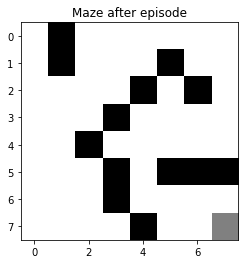

Epoch: 138/999 | Loss: 0.0007 | Episodes: 139 | Win count: 119 | Win rate: 1.000 | time: 50.84 minutes
Loss:  0.0007573249749839306
Loss:  0.0006214158784132451
Loss:  0.00025554431340424344
Loss:  0.000476606612210162
Loss:  0.00037252863694448024
Loss:  0.00026035427435999736
Loss:  0.00032818291219882667
Loss:  0.0006532940024044365
Loss:  0.00017540960106998682
Loss:  0.0003418338455958292
Loss:  0.0004557588545139879
Loss:  0.0004026126553071663
Loss:  0.0004450284468475729
Loss:  0.0006107700173743069
Loss:  0.0004597001461661421
Loss:  0.0001404349532094784


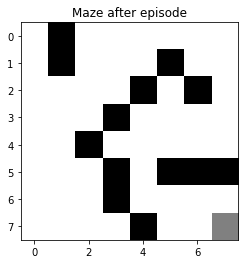

Epoch: 139/999 | Loss: 0.0001 | Episodes: 140 | Win count: 120 | Win rate: 1.000 | time: 50.93 minutes
Loss:  0.00014567974358214997
Loss:  0.00037391837395261973
Loss:  0.00031740585836814716
Loss:  0.00012890764628537
Loss:  0.0001553121765027754
Loss:  0.00034082852289429866
Loss:  0.0004171069449512288
Loss:  0.0004752931999973953
Loss:  0.00024503156237187795
Loss:  0.0006340189502225257
Loss:  0.0007388582453131676
Loss:  0.0005116588581586257
Loss:  0.0003480371306068264
Loss:  0.00022844468912808225
Loss:  0.0006622143409913406
Loss:  0.00019931444694520906
Loss:  0.00030339424120029435
Loss:  0.0005694546853192151
Loss:  0.0005358336929930374
Loss:  0.00044009108387399465
Loss:  0.00048254830471705645
Loss:  0.00013510230201063678
Loss:  0.0005082814459456131
Loss:  0.0004360831808298826
Loss:  0.0004439222684595734
Loss:  0.00042241283517796546
Loss:  0.0002562753579695709
Loss:  0.0005623481920338236
Loss:  0.0003843256854452193
Loss:  0.00030922499718144536
Loss:  0.0003886

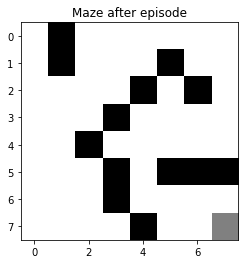

Epoch: 140/999 | Loss: 0.0005 | Episodes: 141 | Win count: 121 | Win rate: 1.000 | time: 51.13 minutes
Loss:  0.00029017993074376136
Loss:  0.0010674220975488424
Loss:  0.00047426432138308883
Loss:  0.0005545858875848353
Loss:  0.0006071828247513622
Loss:  0.00045186898205429316
Loss:  0.0003073505467909854
Loss:  0.00045172811951488256
Loss:  0.0005917525268159807
Loss:  0.00026389963750261813
Loss:  9.376584785059094e-05
Loss:  0.0005724988441215828
Loss:  0.00043589544657152146


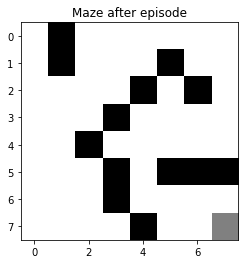

Epoch: 141/999 | Loss: 0.0004 | Episodes: 142 | Win count: 122 | Win rate: 1.000 | time: 51.23 minutes
Loss:  0.0005662007897626609
Loss:  0.00027176208459422924
Loss:  0.0004990968300262466
Loss:  0.0005171497032279149
Loss:  0.00031543731165584177
Loss:  0.00013059515185886994
Loss:  0.00019322054140502587
Loss:  0.00022206438006833196
Loss:  9.477975982008502e-05
Loss:  0.00020130746270297095
Loss:  0.00046325993025675416
Loss:  0.00020698499793070368
Loss:  0.0007466544338967651
Loss:  0.0006832731305621564


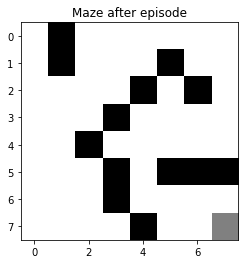

Epoch: 142/999 | Loss: 0.0007 | Episodes: 143 | Win count: 123 | Win rate: 1.000 | time: 51.33 minutes
Loss:  0.0001340876187896356
Loss:  0.0007720232097199187
Loss:  0.00025233971973648295
Loss:  0.0004205176664981991
Loss:  0.0003252219466958195
Loss:  0.000199228434212273
Loss:  0.0003180787243763916
Loss:  0.00036636184086091816
Loss:  0.00045021546247880906
Loss:  0.00022893244022270665
Loss:  0.00037167318805586547
Loss:  0.00043245173583272845


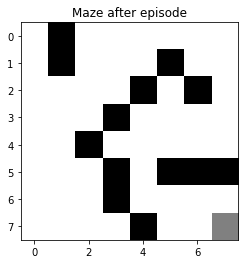

Epoch: 143/999 | Loss: 0.0004 | Episodes: 144 | Win count: 124 | Win rate: 1.000 | time: 51.41 minutes
Loss:  0.0004361909959698096
Loss:  0.0003700937668327242
Loss:  0.0003512933326419443
Loss:  0.0004453012297744863
Loss:  0.0003515579010127112
Loss:  0.00026243013053317554
Loss:  0.00025311023637186736
Loss:  0.0002746917016338557
Loss:  0.00014692310651298612
Loss:  0.00038341690378729254
Loss:  0.000333798976498656
Loss:  0.00030233204597607255
Loss:  0.00036814661871176213
Loss:  0.0006031245866324753
Loss:  0.0004063233936903998


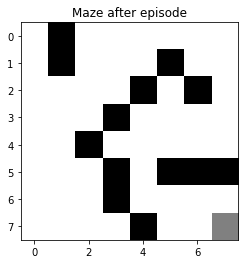

Epoch: 144/999 | Loss: 0.0004 | Episodes: 145 | Win count: 125 | Win rate: 1.000 | time: 51.53 minutes
Loss:  0.0005859593802597374
Loss:  0.00013541494081437122
Loss:  0.00012327598233241588
Loss:  0.00023912709002615884
Loss:  0.0003506149223539978
Loss:  0.000291142103378661
Loss:  0.0006537064327858388
Loss:  0.0003211654693586752
Loss:  0.00040287668525706977


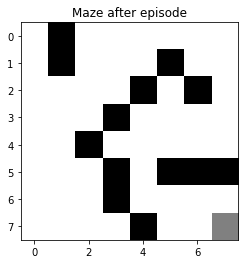

Epoch: 145/999 | Loss: 0.0004 | Episodes: 146 | Win count: 126 | Win rate: 1.000 | time: 51.59 minutes
Loss:  0.00016574447363382205
Loss:  0.0003673005921882577
Loss:  0.0003847728803521022
Loss:  0.0001470182542107068
Loss:  0.000475295732030645
Loss:  0.00041885040991473943
Loss:  0.00019319220155011863
Loss:  0.00029714951233472675
Loss:  0.0003268715590820648
Loss:  8.460706158075482e-05
Loss:  0.00035239706630818546
Loss:  0.0002893999117077328
Loss:  0.0007274171803146601
Loss:  0.00043950119288638234
Loss:  0.0005279275064822286
Loss:  0.000493659419589676
Loss:  0.0005876521172467619
Loss:  0.00019414825692365412
Loss:  0.0002555843166192062
Loss:  0.00032925145569606684
Loss:  0.0005445477436296642
Loss:  0.0009197125327773392
Loss:  0.00042483126162551343
Loss:  0.00046456308336928487
Loss:  0.00041140658140648156
Loss:  0.0005309993721311912
Loss:  0.0007918230548966676
Loss:  0.0004375900389277376
Loss:  0.0005561365396715701
Loss:  0.0010447949171066284
Loss:  0.000511322

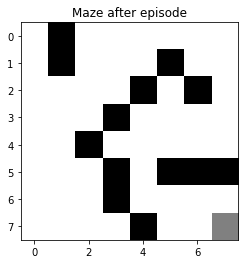

Epoch: 146/999 | Loss: 0.0003 | Episodes: 147 | Win count: 127 | Win rate: 1.000 | time: 51.78 minutes
Loss:  0.0009198710904456675
Loss:  0.0005567988991970196
Loss:  0.0004059133061673492
Loss:  0.0006905288610141724
Loss:  0.0004183729470241815
Loss:  0.00047651231579948217
Loss:  0.0004316378399380483
Loss:  0.0005179972213227302
Loss:  0.0003786826564464718
Loss:  0.0003033345565199852
Loss:  0.00078923960973043
Loss:  0.0004943074309267104
Loss:  0.0007932487933430821
Loss:  0.0002353284289711155
Loss:  0.0005149404605617747
Loss:  0.00032823050423758104
Loss:  0.00026017143682111055
Loss:  0.0003395586827537045
Loss:  0.00043946753430645913
Loss:  0.0005255826108623296
Loss:  0.000580682884901762
Loss:  0.000592544129176531
Loss:  0.00035500458034221083
Loss:  0.0003699015942402184
Loss:  0.0008989573107101023
Loss:  0.0004187855083728209
Loss:  0.0005622882454190403
Loss:  0.000629665213637054
Loss:  0.0006072703981772065


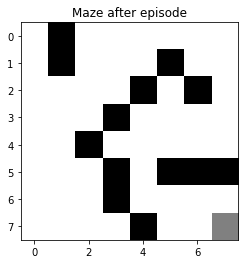

Epoch: 147/999 | Loss: 0.0006 | Episodes: 148 | Win count: 128 | Win rate: 1.000 | time: 51.94 minutes
Loss:  0.0003789599722949788
Loss:  0.0009004309540614486
Loss:  0.00022572599118575454
Loss:  0.00044749706285074353
Loss:  0.00046908063814044
Loss:  0.000638015364529565
Loss:  0.00026293286646250635
Loss:  0.000909866503207013
Loss:  0.0009264298714697361
Loss:  0.0005429789307527244
Loss:  0.00038329091330524534
Loss:  0.000679851698805578
Loss:  0.0005493337230291218
Loss:  0.0005731813434977084
Loss:  0.0006909213552717119
Loss:  0.0006085849308874458
Loss:  0.0004154612688580528
Loss:  0.0003568016254575923


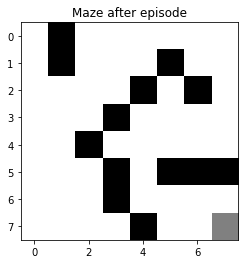

Epoch: 148/999 | Loss: 0.0004 | Episodes: 149 | Win count: 129 | Win rate: 1.000 | time: 52.05 minutes
Loss:  0.0005033658817410469
Loss:  0.0008451719622826204
Loss:  0.0006424755847547203
Loss:  0.0003767388698179275
Loss:  0.0007539829239249229
Loss:  0.00033021402487065643
Loss:  0.0007097182387951761
Loss:  0.000754355569370091
Loss:  0.0005563896265812218
Loss:  0.0005492543568834662
Loss:  0.0004896286409348249
Loss:  0.0006288962904363871
Loss:  0.00032570541225140914
Loss:  0.00043817254481837153
Loss:  0.00035069927980657667
Loss:  0.00010717487020883709
Loss:  0.00030588614754378796
Loss:  0.0005091802086099051
Loss:  0.0005566223990172148
Loss:  0.0005026957951486111


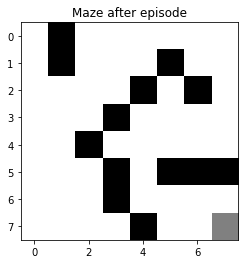

Epoch: 149/999 | Loss: 0.0005 | Episodes: 150 | Win count: 130 | Win rate: 1.000 | time: 52.17 minutes
Loss:  0.0004963321553077549
Loss:  0.0006807380123063922
Loss:  0.0005199325969442725
Loss:  0.00046219809155445546
Loss:  0.00039971810110728256
Loss:  0.0005416508502094075
Loss:  0.0002961516292998567
Loss:  0.0005004686245229095
Loss:  0.00048088381299749017
Loss:  0.0003527982480591163
Loss:  0.0006305509159574285
Loss:  0.0003589472471503541
Loss:  0.0008716486627236009
Loss:  0.0005282446509227157
Loss:  0.00031386133923660964
Loss:  0.0003765358414966613
Loss:  0.0005194232799112797


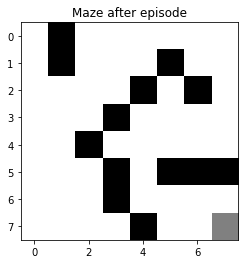

Epoch: 150/999 | Loss: 0.0005 | Episodes: 151 | Win count: 131 | Win rate: 1.000 | time: 52.26 minutes
Loss:  0.0008407853601966053
Loss:  0.0005561219004448503
Loss:  0.0008529236947651953
Loss:  0.0007590353488922119
Loss:  0.000656784774037078
Loss:  0.00035076303174719214
Loss:  0.0007836911827325821
Loss:  0.00044166504812892526
Loss:  0.0005349284183466807
Loss:  0.0007064564561005682
Loss:  0.00023804144439054653


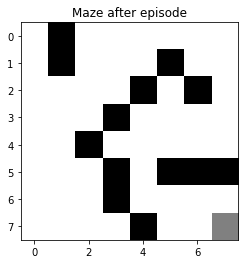

Epoch: 151/999 | Loss: 0.0002 | Episodes: 152 | Win count: 132 | Win rate: 1.000 | time: 52.33 minutes
Loss:  0.0005273130373097956
Loss:  0.0007800095772836357
Loss:  0.0006612551223952323
Loss:  0.0003748199378605932
Loss:  0.0005077754030935466
Loss:  0.0007575284689664841
Loss:  0.0008340406056959182
Loss:  0.0009398679248988628
Loss:  0.00029395009914878756
Loss:  0.000430931308073923
Loss:  0.00042412760376464576
Loss:  0.0006572419952135533
Loss:  0.0002571282966528088
Loss:  0.0006407155597116798
Loss:  0.0007631259213667363
Loss:  0.0005257076991256326
Loss:  0.0003369587066117674
Loss:  0.0005431699100881815
Loss:  0.0003929842496290803


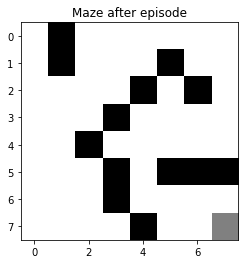

Epoch: 152/999 | Loss: 0.0004 | Episodes: 153 | Win count: 133 | Win rate: 1.000 | time: 52.45 minutes
Loss:  0.0001792865114111919
Loss:  0.00041862286161631346
Loss:  0.0005826598935527727
Loss:  0.000170518838785938
Loss:  0.0006180944328662008
Loss:  0.0002260905021103099
Loss:  0.0005212366522755474
Loss:  0.0003914361441275105
Loss:  0.00011810456635430455
Loss:  0.0006435386603698134
Loss:  0.00033678681575111113
Loss:  0.000437791328295134
Loss:  0.00046265809214673936


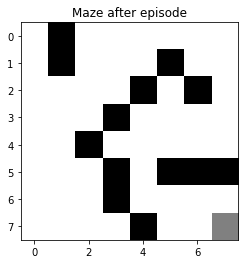

Epoch: 153/999 | Loss: 0.0005 | Episodes: 154 | Win count: 134 | Win rate: 1.000 | time: 52.53 minutes
Loss:  0.0005077277310192585
Loss:  0.00039243954233825207
Loss:  0.0005366643745219335
Loss:  0.0006239257054403424
Loss:  0.0005470341420732439
Loss:  0.0003728770825546235
Loss:  0.0002947304164990783
Loss:  0.00030882014834787697
Loss:  0.00036717271723318845
Loss:  0.0008287140808533877
Loss:  0.000238144290051423
Loss:  0.00039891475171316415
Loss:  0.0003783322317758575
Loss:  0.00033338369394186884
Loss:  0.0005964016309008002
Loss:  0.00021702682352042757
Loss:  0.000339656417054357
Loss:  0.0004675853851949796
Loss:  0.0006515895511256531


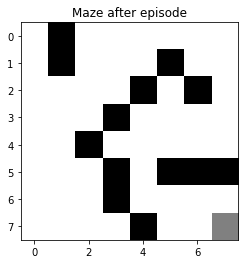

Epoch: 154/999 | Loss: 0.0007 | Episodes: 155 | Win count: 135 | Win rate: 1.000 | time: 52.64 minutes
Loss:  0.00038929398579057306
Loss:  0.0003411176148802042
Loss:  0.00036770038423128426
Loss:  0.0005224387132329866
Loss:  0.00021726103295804933
Loss:  0.0001685959578026086
Loss:  0.000467343968921341
Loss:  0.0002145634134649299
Loss:  0.00022316480317385867
Loss:  0.0005364439566619694
Loss:  0.00020769336697412655
Loss:  0.00011317606185912155


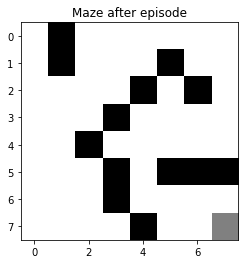

Epoch: 155/999 | Loss: 0.0001 | Episodes: 156 | Win count: 136 | Win rate: 1.000 | time: 52.70 minutes
Loss:  0.00021647699395543896
Loss:  0.0005820584192406386
Loss:  0.0004602263798005879
Loss:  0.0003253695977036841
Loss:  0.0004860984336119145
Loss:  0.0003836237156065181
Loss:  0.000594077748246491
Loss:  0.0006144864019006491
Loss:  0.0001986654388019815
Loss:  0.0001922481824294664
Loss:  0.000597798680246342
Loss:  0.00038351437251549214
Loss:  0.00022363108837453183
Loss:  0.0002190264203818515
Loss:  0.00048338674241676927
Loss:  0.0007325268816202879
Loss:  0.0005171377852093428
Loss:  0.0005152779922354966
Loss:  0.0004218534886604175
Loss:  0.0002654388445080258


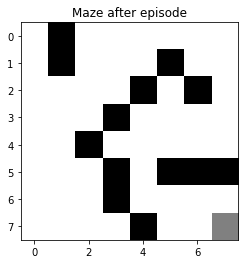

Epoch: 156/999 | Loss: 0.0003 | Episodes: 157 | Win count: 137 | Win rate: 1.000 | time: 52.81 minutes
Loss:  0.0005189011135371402
Loss:  0.00033226446248590946
Loss:  0.00012315551430219784
Loss:  0.000305508088786155
Loss:  0.0005672918050549924
Loss:  0.0002473758941050619
Loss:  0.0004904699453618377
Loss:  0.0007054814923321828
Loss:  0.0005586014012806118
Loss:  0.0003380737252882682
Loss:  0.0004787961588590406
Loss:  0.0002947354078060016
Loss:  0.0004224973527016118
Loss:  0.0007807703805156052
Loss:  0.0004586514114635065
Loss:  0.0004941398365190253
Loss:  0.0007922276272438467
Loss:  0.0002569595235399902
Loss:  0.0006570331752300262
Loss:  0.0003889145373250358
Loss:  0.00019516728207236156
Loss:  0.0002885577159759123
Loss:  0.00036806163552682847
Loss:  0.0005296719318721443
Loss:  0.00016167062130989507
Loss:  0.00040180225914809853
Loss:  0.0006371583440341055
Loss:  0.0003791636263485998
Loss:  0.0005990626086713746
Loss:  0.0006031331140547991
Loss:  0.0003536912117

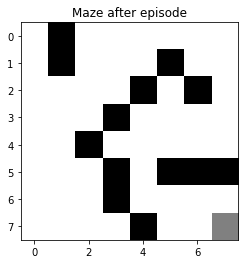

Epoch: 157/999 | Loss: 0.0008 | Episodes: 158 | Win count: 138 | Win rate: 1.000 | time: 53.01 minutes
Loss:  0.00038442679215222597
Loss:  0.0004762750177178532
Loss:  0.0002065171647700481
Loss:  0.000381712794478517
Loss:  0.000444527919171378
Loss:  0.0006842941511422396


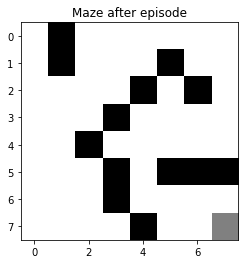

Epoch: 158/999 | Loss: 0.0007 | Episodes: 159 | Win count: 139 | Win rate: 1.000 | time: 53.05 minutes
Loss:  0.0002786854893201962
Loss:  0.00019446687656454742
Loss:  0.0004041741485707462
Loss:  0.00041762493492569774
Loss:  0.0005345050158211961
Loss:  0.0010317243577446789
Loss:  0.00046516137081198394
Loss:  0.0005749677948188037
Loss:  0.0006401008286047727
Loss:  0.000681183475535363
Loss:  0.0003504272535792552
Loss:  0.0008731929701752961
Loss:  0.00026697363500716165
Loss:  0.0006149652181193233
Loss:  0.0005206980858929455
Loss:  0.00030102991877356544
Loss:  0.00038918810605537146
Loss:  0.0005132191872689873


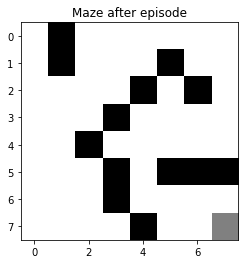

Epoch: 159/999 | Loss: 0.0005 | Episodes: 160 | Win count: 140 | Win rate: 1.000 | time: 53.15 minutes
Loss:  0.0002620294253574684
Loss:  0.000405278304242529
Loss:  0.000566829286981374
Loss:  0.0007103689713403583
Loss:  0.0007102577219484374
Loss:  0.0006561578193213791
Loss:  0.00042938708065776154


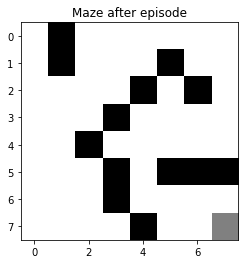

Epoch: 160/999 | Loss: 0.0004 | Episodes: 161 | Win count: 141 | Win rate: 1.000 | time: 53.19 minutes
Loss:  0.0006381178682204336
Loss:  0.0002826840791385621
Loss:  0.00020221688464516774
Loss:  0.0007021555211395025
Loss:  0.00041494584002066404
Loss:  0.0005039015086367726
Loss:  0.00045402211253531277


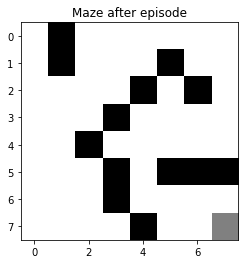

Epoch: 161/999 | Loss: 0.0005 | Episodes: 162 | Win count: 142 | Win rate: 1.000 | time: 53.23 minutes
Loss:  0.0006012763042235747
Loss:  0.0006096495781093836
Loss:  0.0003832399961538613
Loss:  0.000336319200869184
Loss:  0.0005790144496131688
Loss:  0.00032558967359364033


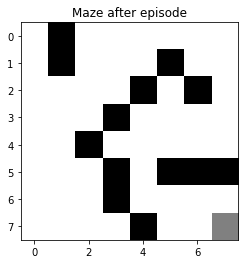

Epoch: 162/999 | Loss: 0.0003 | Episodes: 163 | Win count: 143 | Win rate: 1.000 | time: 53.27 minutes
Loss:  0.0006726455467287451
Loss:  0.000360144411388319
Loss:  0.0006955421267775819
Loss:  0.00041374764987267554


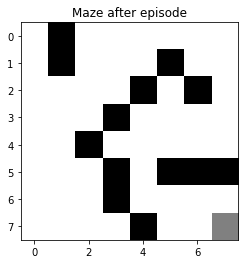

Epoch: 163/999 | Loss: 0.0004 | Episodes: 164 | Win count: 144 | Win rate: 1.000 | time: 53.29 minutes
Loss:  0.0008110992494039237
Loss:  0.0001803145933081396
Loss:  0.00024065540492301807
Loss:  0.0004449084517545998
Loss:  0.0007714914390817285
Loss:  0.0004932360025122762
Loss:  0.0005022975528845564
Loss:  0.0006545233773067594
Loss:  0.0002867321309167892
Loss:  0.0007186764851212502
Loss:  0.0007003598148003221
Loss:  0.0002908313545049168
Loss:  0.00013266793030197732
Loss:  0.00011588702909648418
Loss:  0.0004360205784905702


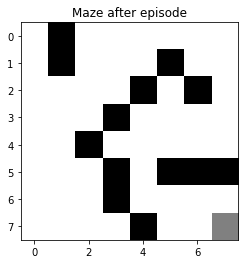

Epoch: 164/999 | Loss: 0.0004 | Episodes: 165 | Win count: 145 | Win rate: 1.000 | time: 53.38 minutes
Loss:  0.00036247968091629446
Loss:  0.0004219392722006887
Loss:  0.0005030714237364009
Loss:  0.0006441052246373147
Loss:  0.00040267445001518354
Loss:  0.0002555270621087402
Loss:  0.0003144203219562769
Loss:  0.0003657001652754843
Loss:  0.0004881380300503224
Loss:  0.00020557362586259842
Loss:  0.00045072741340845823
Loss:  0.00033477545002824627
Loss:  0.0006548490782734007
Loss:  0.00037046889337943867
Loss:  0.00040036677091848105
Loss:  0.0005496180965565145
Loss:  0.00030520597647409886
Loss:  0.0007022108184173703
Loss:  0.00021336169447749853
Loss:  0.0003821271820925176
Loss:  0.0007837812299840152
Loss:  0.0004707187836174853
Loss:  0.0006166396196931601
Loss:  0.0005541634454857558
Loss:  0.0009334084461443126
Loss:  0.00031860307353781536


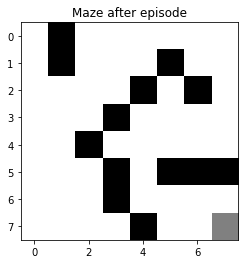

Epoch: 165/999 | Loss: 0.0003 | Episodes: 166 | Win count: 146 | Win rate: 1.000 | time: 53.56 minutes
Loss:  0.0002971922076540068
Loss:  6.604644295293838e-05
Loss:  0.0004992089525330812
Loss:  0.000431562279118225
Loss:  0.000391458161175251
Loss:  0.0004395397991174832
Loss:  0.0005382247909437865
Loss:  0.00048597738714306615
Loss:  0.00041152680933009833
Loss:  0.0005565636092796922
Loss:  0.000524908013176173
Loss:  0.00046117816964397207
Loss:  0.0005650466773658991
Loss:  0.0007647722668480128
Loss:  0.000398555479478091
Loss:  0.0006651881849393249
Loss:  0.00046363071305677295
Loss:  0.00037633010651916265
Loss:  0.0006591896235477179
Loss:  0.00026152819918934256
Loss:  0.0006440672295866534
Loss:  0.0004197036614641547
Loss:  0.0007422938651870936
Loss:  0.0005250472895568237
Loss:  0.0005173179961275309
Loss:  0.0004296015395084396
Loss:  0.00033133193937828764
Loss:  0.00020144090376561508


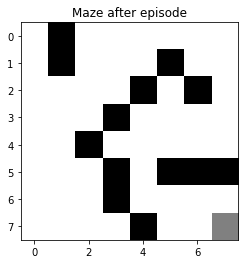

Epoch: 166/999 | Loss: 0.0002 | Episodes: 167 | Win count: 147 | Win rate: 1.000 | time: 53.73 minutes
Loss:  0.0004381850303616375
Loss:  0.0007598154770676047
Loss:  0.0005224553315201774
Loss:  0.0003733143239514902
Loss:  0.0006946337525732815
Loss:  0.00017481389659224078
Loss:  0.0004788387886947021
Loss:  0.0005390900769270957
Loss:  0.0004600664397003129
Loss:  0.0006179909687489271
Loss:  0.00028070977714378387
Loss:  0.0006225185934454203
Loss:  0.0008491293992847204
Loss:  0.0006667911948170513
Loss:  0.000647449545795098
Loss:  0.0008311351994052529
Loss:  0.0002677501761354506
Loss:  0.0005456967774080113
Loss:  0.00043748735333792865
Loss:  0.00040409062057733536
Loss:  0.0006790042680222541
Loss:  0.0006891011435072869
Loss:  0.0005665463395416737
Loss:  0.0009166628587990999
Loss:  0.0007438906468451023
Loss:  0.0006284382252488285
Loss:  0.000936683383770287
Loss:  0.000637372984783724
Loss:  0.0005155573599040508
Loss:  0.0004514427128015086
Loss:  0.00044728312786901

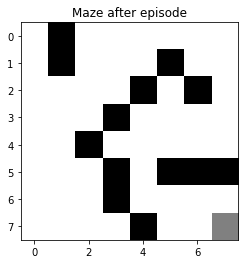

Epoch: 167/999 | Loss: 0.0007 | Episodes: 168 | Win count: 148 | Win rate: 1.000 | time: 53.95 minutes
Loss:  0.0007564404659206048
Loss:  0.0007427286473102868
Loss:  0.0007908505504019558
Loss:  0.0011988528713118285
Loss:  0.0004855672304984182
Loss:  0.0010122465901076794
Loss:  0.0006571743579115719
Loss:  0.0009047146013472229
Loss:  0.0010296691907569766
Loss:  0.0006986964144743979
Loss:  0.0006148618922452442
Loss:  0.0004556456478894688
Loss:  0.0006323021079879254
Loss:  0.0005853283073520288
Loss:  0.0005726486415369436
Loss:  0.00042421880061738193
Loss:  0.0004016318707726896


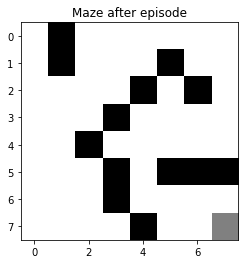

Epoch: 168/999 | Loss: 0.0004 | Episodes: 169 | Win count: 149 | Win rate: 1.000 | time: 54.05 minutes
Loss:  0.0005868338339496404
Loss:  0.0006901838933117688
Loss:  0.0009584515646565706
Loss:  0.0006118442688602954
Loss:  0.0007266322063514963
Loss:  0.000653761817375198


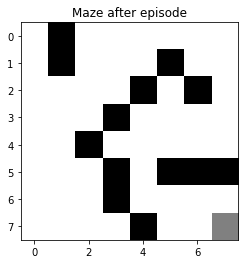

Epoch: 169/999 | Loss: 0.0007 | Episodes: 170 | Win count: 150 | Win rate: 1.000 | time: 54.09 minutes
Loss:  0.0006407049659173936
Loss:  0.0008693677955307066
Loss:  0.0003508042573230341
Loss:  0.0006436487310566008
Loss:  0.0006810248596593738
Loss:  0.00027797173606813885
Loss:  0.0009367555321659893
Loss:  0.0011555470991879702
Loss:  0.0005008558218833059
Loss:  0.0008005516137927771
Loss:  0.0006647639092989266
Loss:  0.0008413260075030848
Loss:  0.00017581810243427753
Loss:  0.0003521324397297576
Loss:  0.00031949150434229523
Loss:  0.00090444041416049
Loss:  0.00022181322856340557
Loss:  0.0006239409558475018
Loss:  0.00020968978788005188
Loss:  0.0006557564483955503
Loss:  0.00023881703236838803
Loss:  0.0005519049154827371


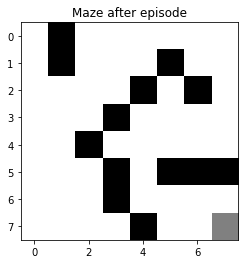

Epoch: 170/999 | Loss: 0.0006 | Episodes: 171 | Win count: 151 | Win rate: 1.000 | time: 54.21 minutes
Loss:  0.0008345961687155068
Loss:  0.0004292238809284754
Loss:  0.0006025975744705647
Loss:  0.0007932478038128465


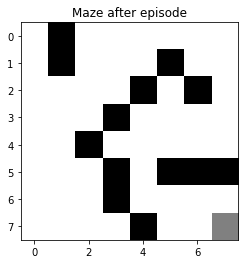

Epoch: 171/999 | Loss: 0.0008 | Episodes: 172 | Win count: 152 | Win rate: 1.000 | time: 54.24 minutes
Loss:  0.0008907543960958719
Loss:  0.0009011585789266974
Loss:  0.0005638814327539876
Loss:  0.0005093067666166462
Loss:  0.0005066485900897533
Loss:  0.0006059367733541876
Loss:  0.0004748013961943798
Loss:  0.0010884423390962183
Loss:  0.0005084927470306866
Loss:  0.000912363437237218
Loss:  0.0003067415236728266
Loss:  0.0006157846946734935
Loss:  0.0007762796012684703
Loss:  0.00042760049109347165
Loss:  0.000780019152443856
Loss:  0.0010411803668830544
Loss:  0.000518845219630748
Loss:  0.0008317523170262575
Loss:  0.0005851856549270451
Loss:  0.0005653932603308931
Loss:  0.00045216370199341327


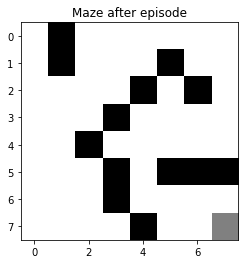

Epoch: 172/999 | Loss: 0.0005 | Episodes: 173 | Win count: 153 | Win rate: 1.000 | time: 54.35 minutes
Loss:  0.0007575562631245703
Loss:  0.0007488085830118507
Loss:  0.0006725651037413627
Loss:  0.0005697849555872381
Loss:  0.0005079034526715986
Loss:  0.0005100947892060503
Loss:  0.0009612246358301491
Loss:  0.0007049610721878707
Loss:  0.0006501200114144012


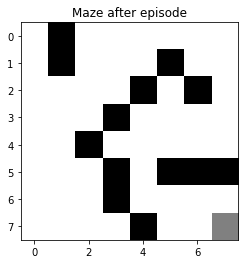

Epoch: 173/999 | Loss: 0.0007 | Episodes: 174 | Win count: 154 | Win rate: 1.000 | time: 54.40 minutes
Loss:  0.0006142191705293953
Loss:  0.00021449224004754797
Loss:  0.0006528572121169418
Loss:  0.0005951345374342054
Loss:  0.0008070656622294337


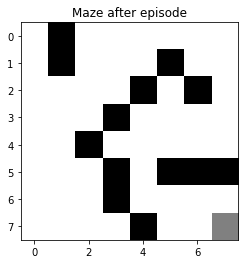

Epoch: 174/999 | Loss: 0.0008 | Episodes: 175 | Win count: 155 | Win rate: 1.000 | time: 54.43 minutes
Loss:  0.0008295306761283427
Loss:  0.0004774996923515573
Loss:  0.00027554966072784737
Loss:  0.0006969150563236326
Loss:  0.0007047584804240614
Loss:  0.0007364543416770175
Loss:  0.000572208286030218
Loss:  0.0004687234904849902
Loss:  0.000506310403579846
Loss:  0.0004774309054482728
Loss:  0.0007432670681737363
Loss:  0.0005910611944273114
Loss:  0.0004549512159428559
Loss:  0.00037459111626958475
Loss:  0.0003724143152794568
Loss:  0.0006602939974982291
Loss:  0.0005362718002288602
Loss:  0.0007801609463058412
Loss:  0.00028531940188258886
Loss:  0.0007643326825927943
Loss:  0.0003386958851478994
Loss:  0.0005127813201397657
Loss:  0.0007705802854616195
Loss:  0.0004305042530177161
Loss:  0.0007343161851167679


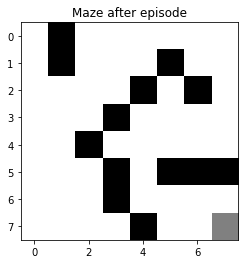

Epoch: 175/999 | Loss: 0.0007 | Episodes: 176 | Win count: 156 | Win rate: 1.000 | time: 54.57 minutes
Loss:  0.0006519082526210696
Loss:  0.0011448702425695956
Loss:  0.001002312870696187
Loss:  0.0006231068109627813
Loss:  0.0006540625763591379
Loss:  0.000503234303323552
Loss:  0.0004434922302607447
Loss:  0.0009277606732212007
Loss:  0.0006352360651362687
Loss:  0.0005611757223960012
Loss:  0.0006785012665204704
Loss:  0.0006961954350117594
Loss:  0.0004484724049689248
Loss:  0.00026597663236316293
Loss:  0.0007490505231544375
Loss:  0.0005785664543509483
Loss:  0.00037509819958359003
Loss:  0.0004935822216793895
Loss:  0.000997301802271977
Loss:  0.000552734883967787
Loss:  0.000638008292298764
Loss:  0.0007074910681694746
Loss:  0.000761364062782377
Loss:  0.0006287814758252352
Loss:  0.0010295725951436907
Loss:  0.0002174086621380411
Loss:  0.0004582223918987438


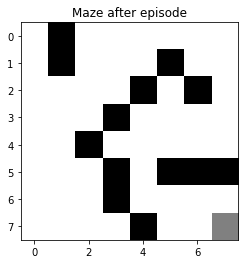

Epoch: 176/999 | Loss: 0.0005 | Episodes: 177 | Win count: 157 | Win rate: 1.000 | time: 54.73 minutes
Loss:  0.00045029964530840516
Loss:  0.00023743521887809038
Loss:  0.00026321873156121
Loss:  0.0008584577008150518
Loss:  0.0005944412550888956
Loss:  0.0002913208809331991
Loss:  0.0003962994887842797
Loss:  0.00043961637129541487
Loss:  0.0005826037959195673
Loss:  0.00046804206795059144
Loss:  0.0004352356627350673
Loss:  0.0004278382402844727
Loss:  0.0003373777217348106
Loss:  0.00034625934495124966
Loss:  0.0005500204279087484
Loss:  0.0003229484864277765
Loss:  0.00041857761971186846
Loss:  0.00043557909157243557
Loss:  0.0005445920396596193
Loss:  0.00042530080827418715
Loss:  0.0004171899054199457
Loss:  0.0006074928969610482
Loss:  0.000523751848959364
Loss:  0.0006966409710003063
Loss:  0.00032853594166226685
Loss:  0.00038916742778383195
Loss:  0.0005093249928904697
Loss:  0.0004825905052712187
Loss:  8.921954577090219e-05
Loss:  0.00047261198051273823
Loss:  0.0003475703

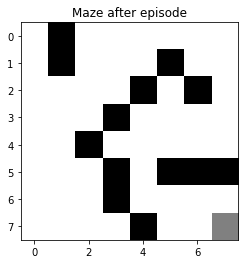

Epoch: 177/999 | Loss: 0.0003 | Episodes: 178 | Win count: 158 | Win rate: 1.000 | time: 54.92 minutes
Loss:  0.000557001905690413
Loss:  0.0008150638605002314
Loss:  0.00042825823766179383
Loss:  0.0006371584604494274
Loss:  0.0006003566522849724
Loss:  0.0005921546544414014
Loss:  0.0006254868058022112
Loss:  0.0005869828091817908
Loss:  0.0002768312260741368
Loss:  0.0003568227693904191
Loss:  0.0004957975470460951
Loss:  0.00069705571513623
Loss:  0.0006578866887139156
Loss:  0.00030740859801881015
Loss:  0.0003680117297335528
Loss:  0.0005460989195853472
Loss:  0.0003910285668098368
Loss:  0.00047278666170313954
Loss:  0.0005620287847705185
Loss:  0.0004995931521989405
Loss:  0.0001492347801104188
Loss:  0.0006866540934424847
Loss:  0.0007813681731931865


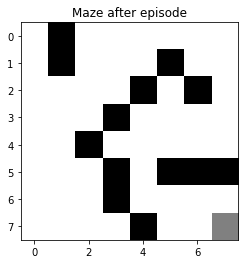

Epoch: 178/999 | Loss: 0.0008 | Episodes: 179 | Win count: 159 | Win rate: 1.000 | time: 55.07 minutes
Loss:  0.0005275724979583174
Loss:  0.0006552404374815524
Loss:  0.0005001547688152641
Loss:  0.0005564230377785861
Loss:  0.0003218650817871094
Loss:  0.001381619367748499
Loss:  0.00046567359822802246
Loss:  0.00047661137068644166
Loss:  0.0005848205764777958
Loss:  0.0003359225593158044
Loss:  0.001196478959172964


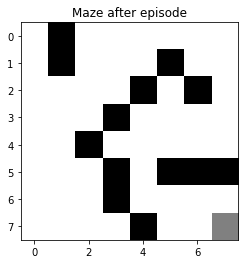

Epoch: 179/999 | Loss: 0.0012 | Episodes: 180 | Win count: 160 | Win rate: 1.000 | time: 55.14 minutes
Loss:  0.00041751675598789006
Loss:  0.00045399741793517023
Loss:  0.0008995836542453617
Loss:  0.00040725765575189143
Loss:  0.00029656281549250707
Loss:  0.00038154776848386973


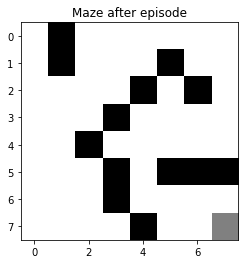

Epoch: 180/999 | Loss: 0.0004 | Episodes: 181 | Win count: 161 | Win rate: 1.000 | time: 55.19 minutes
Loss:  0.0004360485545475967


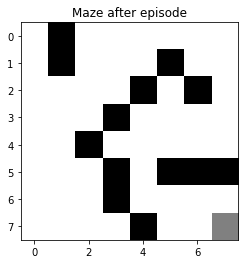

Epoch: 181/999 | Loss: 0.0004 | Episodes: 182 | Win count: 162 | Win rate: 1.000 | time: 55.20 minutes
Loss:  0.00042583528556860983
Loss:  0.0007791806710883975
Loss:  0.0004447924729902297
Loss:  0.0002624591870699078
Loss:  0.000266277085756883
Loss:  0.0007589968445245177
Loss:  0.0004146646388107911


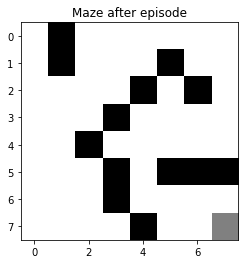

Epoch: 182/999 | Loss: 0.0004 | Episodes: 183 | Win count: 163 | Win rate: 1.000 | time: 55.26 minutes
Loss:  0.0004999204684281722
Loss:  0.0005207573412917554
Loss:  0.00034212315222248435
Loss:  0.0005431070894701406
Loss:  0.0003801969505730085
Loss:  0.0003265088453190401
Loss:  0.0006345175061142072
Loss:  0.0004265436145942658
Loss:  0.0002207925499533303
Loss:  0.00029459128563757986
Loss:  0.0004162482073297724
Loss:  0.0005700815963791683
Loss:  0.00022408484073821455
Loss:  0.0009280690574087203
Loss:  0.0002768497943179682
Loss:  0.0007608926971442997
Loss:  0.0005157049745321274
Loss:  0.0002554619568400085
Loss:  0.0005377316265366971
Loss:  0.0007950836152303964
Loss:  0.0004044334709760733
Loss:  0.00045166347990743816
Loss:  0.0006124716019257903
Loss:  0.0005815013137180358


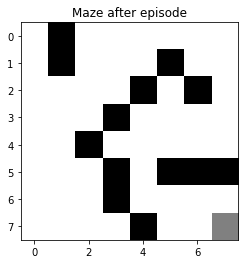

Epoch: 183/999 | Loss: 0.0006 | Episodes: 184 | Win count: 164 | Win rate: 1.000 | time: 55.42 minutes
Loss:  0.00036570485099218786
Loss:  0.0002552827063482255
Loss:  0.00027132270770380273
Loss:  0.0002286501694470644
Loss:  9.230833893525414e-05
Loss:  0.0012210631975904107
Loss:  0.0005609277868643403
Loss:  0.0005461091350298375
Loss:  0.0004688931003329344
Loss:  0.0002737383510975633
Loss:  0.0005381815135478973
Loss:  0.0007529507274739444
Loss:  0.000375618867110461
Loss:  0.00041093210893450305
Loss:  0.0003652021841844544


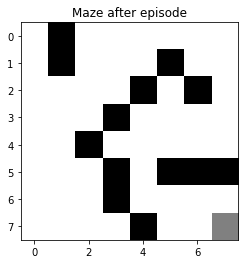

Epoch: 184/999 | Loss: 0.0004 | Episodes: 185 | Win count: 165 | Win rate: 1.000 | time: 55.52 minutes
Loss:  0.0004641361883841455
Loss:  0.0006166947568999603
Loss:  0.00025690629991004243
Loss:  0.0006701604288537055
Loss:  0.0006371881609084085
Loss:  0.0006711453133902978
Loss:  0.0001911909130285494
Loss:  0.0011943727731704712
Loss:  0.00046716327778995037
Loss:  0.0005006661085644737
Loss:  0.00045239237806526944
Loss:  0.0002741416610660963
Loss:  0.00030752531165489927
Loss:  0.0006819574919063598
Loss:  0.0004886257374892011
Loss:  0.00026826652901945636
Loss:  0.0004072252122568898


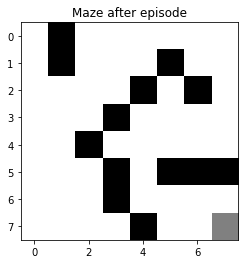

Epoch: 185/999 | Loss: 0.0004 | Episodes: 186 | Win count: 166 | Win rate: 1.000 | time: 55.64 minutes
Loss:  0.0004900833300780505
Loss:  0.0006624495290452614
Loss:  0.0006814482912886888
Loss:  0.0005499613034771755
Loss:  0.0004636541852960363
Loss:  0.000593669101363048
Loss:  0.00021433834263007157
Loss:  0.000449368279078044
Loss:  0.00014141144492896274


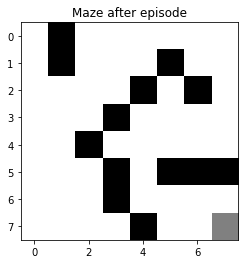

Epoch: 186/999 | Loss: 0.0001 | Episodes: 187 | Win count: 167 | Win rate: 1.000 | time: 55.72 minutes
Loss:  0.0007832456467440352
Loss:  0.0009508529328741133
Loss:  0.00031715028308099136
Loss:  0.0008576031541451812
Loss:  0.000700321004842408
Loss:  0.0003535619762260467
Loss:  0.0009786203154362738
Loss:  0.00029155812444514595
Loss:  0.0004947634442942217
Loss:  0.0009252790478058159
Loss:  0.00037744017026852816
Loss:  0.0005889355525141582
Loss:  0.0007672961801290512
Loss:  0.0004460908385226503
Loss:  0.0006879853899590671
Loss:  0.000501061964314431
Loss:  0.00023924908236949705
Loss:  0.0002491551167622674
Loss:  8.072847413131967e-05
Loss:  0.00029384683512034826


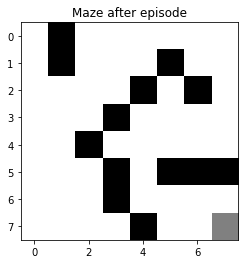

Epoch: 187/999 | Loss: 0.0003 | Episodes: 188 | Win count: 168 | Win rate: 1.000 | time: 55.85 minutes
Loss:  0.0008897548977984115
Loss:  0.0011683157063089311
Loss:  0.0004111151065444574
Loss:  0.0006842833536211401
Loss:  0.0003996858431492001
Loss:  0.0008714805007912219
Loss:  0.0006304453709162772
Loss:  0.0008438603836111724
Loss:  0.0008392450981773436
Loss:  0.0006134107243269682
Loss:  0.0003548684762790799
Loss:  0.0007971129380166531
Loss:  0.0009288451983593404
Loss:  0.0004453602450666949
Loss:  0.0005512095231097192
Loss:  0.00034059122117469087
Loss:  0.0006911231612320989
Loss:  0.0006541049224324524
Loss:  0.0004464748490136117
Loss:  0.0004177618320682086
Loss:  0.0004604049609042704
Loss:  0.0002601574087748304
Loss:  0.00035325682256370783


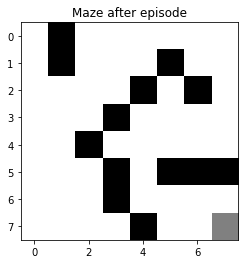

Epoch: 188/999 | Loss: 0.0004 | Episodes: 189 | Win count: 169 | Win rate: 1.000 | time: 55.99 minutes
Loss:  0.0004023544133815449
Loss:  0.00037470555980689824
Loss:  0.001210661605000496
Loss:  0.000722423821571283
Loss:  0.0004178833041805774
Loss:  0.00031369626231025904
Loss:  0.0007017500756774098
Loss:  0.0007347004720941186
Loss:  0.00015679078933317214
Loss:  0.0006294980048551224
Loss:  5.976065222057514e-05
Loss:  0.000543390546226874
Loss:  0.00039509892667410895
Loss:  0.0005179463769309223
Loss:  0.0005482545384438708
Loss:  0.0003969457684434019
Loss:  0.0003208036650903523
Loss:  0.00029079628438921645
Loss:  0.0004618528764694929


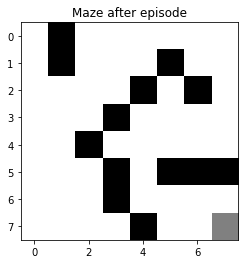

Epoch: 189/999 | Loss: 0.0005 | Episodes: 190 | Win count: 170 | Win rate: 1.000 | time: 56.11 minutes
Loss:  0.0005673382256645709
Loss:  0.0005376170738600194
Loss:  0.0008910458127502352
Loss:  0.0003779076650971547
Loss:  0.0004773157270392403
Loss:  0.00023280033565242775
Loss:  0.0004952167510055006
Loss:  0.00019947172040701844
Loss:  0.00027550362574402243
Loss:  0.00025127915432676673
Loss:  3.519459642120637e-05
Loss:  0.0005419087683549151
Loss:  0.0007115272455848753
Loss:  0.0005310611013555899
Loss:  0.00031437895086128265
Loss:  9.858094199444167e-05
Loss:  0.0004304182730265893
Loss:  0.0004618557431967929
Loss:  0.00041552173206582665
Loss:  0.0008126311877276748
Loss:  0.00032601757266093045


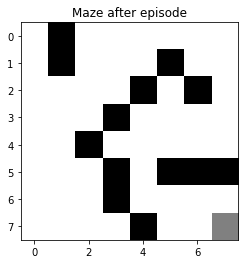

Epoch: 190/999 | Loss: 0.0003 | Episodes: 191 | Win count: 171 | Win rate: 1.000 | time: 56.26 minutes
Loss:  0.0003873481327900663
Loss:  0.0001582186814630404
Loss:  0.00036820407694904134
Loss:  0.0009714165353216231
Loss:  0.0004281887231627479
Loss:  0.00027005834090232383


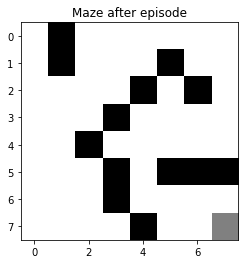

Epoch: 191/999 | Loss: 0.0003 | Episodes: 192 | Win count: 172 | Win rate: 1.000 | time: 56.30 minutes
Loss:  0.00038234583917073905
Loss:  0.0003987250674981624
Loss:  0.000881570449564606
Loss:  0.00022213358897715807
Loss:  0.0005390103324316442
Loss:  0.00014122728862275835
Loss:  0.000381526981072966
Loss:  0.00045278533070813864
Loss:  0.00020897220383631065
Loss:  0.0006541333568748087
Loss:  0.00035739019222091883
Loss:  0.00042943494918290526
Loss:  0.00023514347412856296
Loss:  0.0004185814832453616
Loss:  0.0002232551560155116


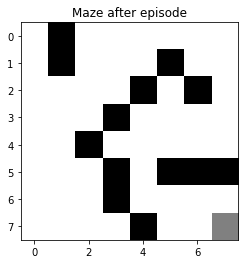

Epoch: 192/999 | Loss: 0.0002 | Episodes: 193 | Win count: 173 | Win rate: 1.000 | time: 56.39 minutes
Loss:  8.100194645521697e-05
Loss:  0.0006904673282406293
Loss:  0.00036561917659128085
Loss:  0.0006642243170063011
Loss:  0.0002810671430779621
Loss:  0.0006716506468364969
Loss:  0.00044307293137535453
Loss:  0.000949481880525127
Loss:  9.859161582426168e-05
Loss:  0.00011464174167485908
Loss:  0.0004279762360965833
Loss:  0.0009686126140877604
Loss:  0.0003913817636203021
Loss:  0.00036715404712595046
Loss:  0.0004647781897801906
Loss:  0.0006746040162397549
Loss:  0.0008783116354607046


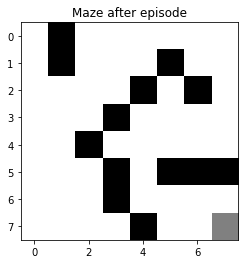

Epoch: 193/999 | Loss: 0.0009 | Episodes: 194 | Win count: 174 | Win rate: 1.000 | time: 56.50 minutes
Loss:  0.00014109969197306782
Loss:  0.0004126207932131365
Loss:  0.0007205909059848636
Loss:  0.00018449989875080064
Loss:  0.00024011670757317916
Loss:  0.0005154658574610949
Loss:  0.0005372453306335956
Loss:  0.0002210546808782965
Loss:  0.000412821835197974
Loss:  0.0007129215664463118
Loss:  0.000490229605929926
Loss:  0.00044153955241199583
Loss:  0.0003873502428177744
Loss:  7.124939656932838e-05
Loss:  0.00045999781650607474
Loss:  0.0003641067160060629
Loss:  0.0002345884349779226
Loss:  0.000694332440616563
Loss:  0.0005048684397479519
Loss:  0.000507248128997162
Loss:  0.0003582473291317001
Loss:  0.00019906349916709587
Loss:  0.0005785815556009766


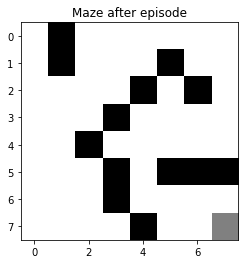

Epoch: 194/999 | Loss: 0.0006 | Episodes: 195 | Win count: 175 | Win rate: 1.000 | time: 56.64 minutes
Loss:  0.0006035631231497973
Loss:  0.00022436019935412332
Loss:  0.0003616738358687144
Loss:  0.00046894006663933396
Loss:  0.0006740001263096929
Loss:  0.0005628126964438707
Loss:  0.0006786508747609332
Loss:  0.0004303327586967498
Loss:  0.0004232067003613338
Loss:  0.00020045714336447418
Loss:  8.674600030644797e-05
Loss:  0.0004216428496874869
Loss:  0.00040046885987976566
Loss:  4.2083293010364287e-05
Loss:  0.0004881087297690101
Loss:  0.0005835091869812459
Loss:  0.0002163815443054773
Loss:  0.0007666943711228669
Loss:  0.00031857556314207613
Loss:  0.0005272105081530754
Loss:  0.0004327448841650039
Loss:  0.0005299229669617489
Loss:  0.0005020005046389997
Loss:  0.0007677277026232332
Loss:  0.0006147004314698279
Loss:  0.0002264862196170725
Loss:  0.0005783854721812531
Loss:  0.0003508743393467739


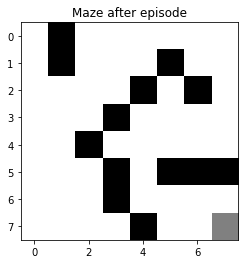

Epoch: 195/999 | Loss: 0.0004 | Episodes: 196 | Win count: 176 | Win rate: 1.000 | time: 56.81 minutes
Loss:  0.00023473796318285167
Loss:  0.0005022634722990915
Loss:  0.000486064818687737
Loss:  0.0005508646427188069
Loss:  0.0005417824504547752
Loss:  0.0001924360894918209
Loss:  0.0006883097521495074
Loss:  0.0002439256240904797


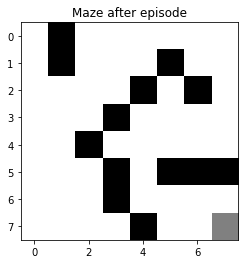

Epoch: 196/999 | Loss: 0.0002 | Episodes: 197 | Win count: 177 | Win rate: 1.000 | time: 56.86 minutes
Loss:  0.0004800124152097851
Loss:  0.0007455342565663159
Loss:  0.0006459821888711303
Loss:  0.0005998057313263416
Loss:  0.0007464433729182929
Loss:  0.00029482730315066874
Loss:  0.0005801393708679825
Loss:  0.0006638361955992877
Loss:  0.0005134082457516342
Loss:  0.0003643656673375517
Loss:  0.00031363343441626057
Loss:  0.0005985881434753537
Loss:  9.043464524438605e-05
Loss:  0.0004542144451988861
Loss:  0.0006921792810317129


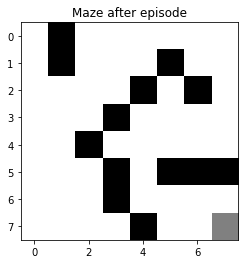

Epoch: 197/999 | Loss: 0.0007 | Episodes: 198 | Win count: 178 | Win rate: 1.000 | time: 56.96 minutes
Loss:  0.0004024696536362171
Loss:  0.000379987082851585
Loss:  0.0005128203993081115
Loss:  0.0004019963671453297
Loss:  0.0005487893940880895
Loss:  0.0010166640568058938
Loss:  0.0004601315886247903
Loss:  0.0006225319084478542
Loss:  0.0005802380328532308
Loss:  0.0002787084522424266
Loss:  0.0007310025102924556
Loss:  0.0005520287959370762
Loss:  0.0004838491295231506


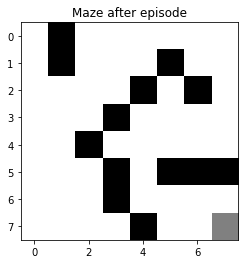

Epoch: 198/999 | Loss: 0.0005 | Episodes: 199 | Win count: 179 | Win rate: 1.000 | time: 57.03 minutes
Loss:  0.0006481049349531531
Loss:  0.00020081723414477892
Loss:  0.00027289878562442027
Loss:  0.00022154498583404347
Loss:  0.00023200069699669257
Loss:  0.00039446486334782094
Loss:  0.0004089964204467833
Loss:  0.0005010134118492715
Loss:  7.518539860029705e-05
Loss:  0.000194630105397664
Loss:  0.0001387020656693494
Loss:  0.00025501738127786666
Loss:  0.00026299637829652056
Loss:  0.00021506284247152507


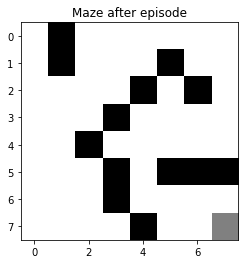

Epoch: 199/999 | Loss: 0.0002 | Episodes: 200 | Win count: 180 | Win rate: 1.000 | time: 57.12 minutes
Loss:  0.00022322191944113
Loss:  0.0001298630941164447
Loss:  0.0002879614112316631
Loss:  2.7565492928260937e-05
Loss:  0.00020717755251098424
Loss:  0.0004200291296001524


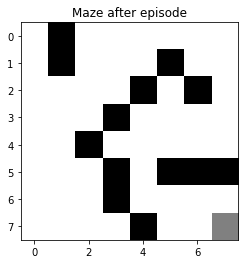

Epoch: 200/999 | Loss: 0.0004 | Episodes: 201 | Win count: 181 | Win rate: 1.000 | time: 57.15 minutes
Loss:  0.00012226487797306618
Loss:  0.0006773457571398467
Loss:  9.355995280202478e-05
Loss:  0.0002693738788366318
Loss:  0.0004141386452829465
Loss:  0.00022523820007336326
Loss:  0.00015436439571203664
Loss:  0.00035612650390248746
Loss:  0.00017413587738701608
Loss:  0.0004239603440510109
Loss:  0.0004057578044012189
Loss:  0.00032767299853730947


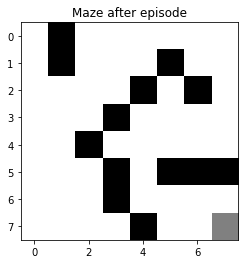

Epoch: 201/999 | Loss: 0.0003 | Episodes: 202 | Win count: 182 | Win rate: 1.000 | time: 57.22 minutes
Loss:  0.00013717152614844963
Loss:  0.00010365567050030222
Loss:  0.0002694492395676207
Loss:  0.0006183780351420864
Loss:  5.666423930961173e-05
Loss:  0.0002913403732236475
Loss:  0.0001670262608968187
Loss:  0.0006628584233112633
Loss:  0.0009673025051597506
Loss:  0.0004102805251022801
Loss:  0.00011874568008352071
Loss:  9.136842709267512e-05


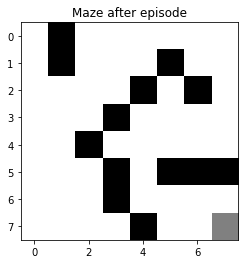

Epoch: 202/999 | Loss: 0.0001 | Episodes: 203 | Win count: 183 | Win rate: 1.000 | time: 57.29 minutes
Loss:  0.00020384308663778938
Loss:  0.0005962073337286711
Loss:  0.0003749168536160141
Loss:  0.00023940699429658707
Loss:  0.0002009014051509439
Loss:  0.00013424236021819524
Loss:  3.2812673453008756e-05
Loss:  0.0005756810714956373


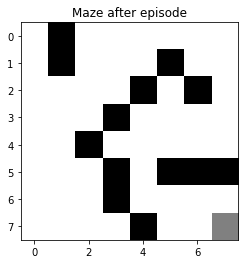

Epoch: 203/999 | Loss: 0.0006 | Episodes: 204 | Win count: 184 | Win rate: 1.000 | time: 57.34 minutes
Loss:  0.0001410795211995719
Loss:  0.0005327197541191708
Loss:  0.000221942929783836
Loss:  0.0004885564903815975
Loss:  0.00019853040430461988
Loss:  0.0002958907207357697
Loss:  0.00045136205153539777
Loss:  0.0004879786938545294
Loss:  0.0002381176018388942
Loss:  0.00019589710609579924
Loss:  0.0004534709696599748
Loss:  0.0005529414629563689
Loss:  0.0003863069141516462
Loss:  0.0002103551996697206
Loss:  0.0001822215417632833
Loss:  0.00027272332954453304
Loss:  4.2367216337879654e-05
Loss:  0.000326320412568748
Loss:  0.00026383157091913745
Loss:  3.756129626708571e-05
Loss:  0.00029114619974279776
Loss:  0.0003987695890828036
Loss:  4.63755914097419e-05
Loss:  4.92477211082587e-05


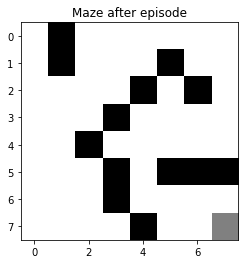

Epoch: 204/999 | Loss: 0.0000 | Episodes: 205 | Win count: 185 | Win rate: 1.000 | time: 57.46 minutes
Loss:  0.00020238988690834958
Loss:  0.00013114345347275957
Loss:  0.00045650239917449653
Loss:  0.00043443337199278176
Loss:  6.229633072507568e-05
Loss:  0.0006618225161219016
Loss:  4.3519376959011424e-05
Loss:  0.00021674312483810354
Loss:  3.916281639249064e-05
Loss:  0.0003667490527732298
Loss:  0.00029405618988675997
Loss:  0.0004612234442902263
Loss:  0.0001760347768140491
Loss:  4.640830411517527e-05
Loss:  0.00019864262503688224


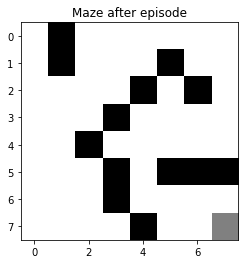

Epoch: 205/999 | Loss: 0.0002 | Episodes: 206 | Win count: 186 | Win rate: 1.000 | time: 57.54 minutes
Loss:  0.0004251226619089721
Loss:  3.915468641935149e-05
Loss:  0.0002496506504030549
Loss:  0.00022366866687661968
Loss:  0.0005081108247395605
Loss:  0.0006827097677160054
Loss:  0.0003088287194259465
Loss:  0.00020790671987924725
Loss:  0.0005371881707105786
Loss:  3.6643103157985024e-05
Loss:  0.0006630724965361878
Loss:  0.00029393866134341806
Loss:  0.0004524210235103965


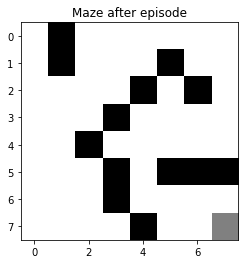

Epoch: 206/999 | Loss: 0.0005 | Episodes: 207 | Win count: 187 | Win rate: 1.000 | time: 57.61 minutes
Loss:  0.0002995393588207662
Loss:  0.000164382874572766
Loss:  0.0004346017594798468
Loss:  0.00018738822836894542
Loss:  0.0004931866133119911
Loss:  0.0003758341772481799
Loss:  0.00010155274139833637
Loss:  0.00017067447333829477
Loss:  0.000358764998964034
Loss:  0.0004261347639840096


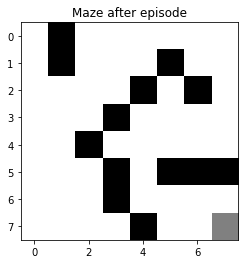

Epoch: 207/999 | Loss: 0.0004 | Episodes: 208 | Win count: 188 | Win rate: 1.000 | time: 57.66 minutes
Loss:  0.0003435812432144303
Loss:  0.00033595644163142424
Loss:  6.977619341341779e-05
Loss:  5.263546700007282e-05
Loss:  0.00014500728866551071
Loss:  0.00016080878413049504
Loss:  0.0002508267862140201
Loss:  0.0003906652273144573
Loss:  0.0002903381027863361
Loss:  0.00025200657546520233
Loss:  0.00021126552383066155
Loss:  0.0003533240742399357
Loss:  0.00017220395420736168
Loss:  6.249470607144758e-05
Loss:  5.804551710753003e-05
Loss:  0.0002474309949320741
Loss:  0.0003866972110699862
Loss:  0.00040454045665683225
Loss:  0.000254455822869204
Loss:  0.0003813984149019234
Loss:  0.0003364848453202285
Loss:  0.00015123201592359692
Loss:  3.924041993741412e-05
Loss:  0.00027049576965509914
Loss:  0.0003165239431837108
Loss:  0.00041124785275314935
Loss:  0.00036748841375811026
Loss:  0.0005625312915071845
Loss:  0.00036680480116046965
Loss:  6.880539149278775e-05
Loss:  0.0003291

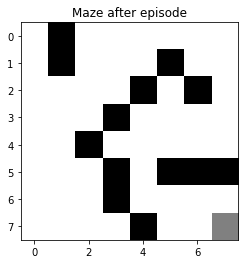

Epoch: 208/999 | Loss: 0.0003 | Episodes: 209 | Win count: 189 | Win rate: 1.000 | time: 57.81 minutes
Loss:  0.00021795669454149902
Loss:  0.00020705823408206925
Loss:  0.0005277845775708556
Loss:  0.0003460549924056977
Loss:  0.00023928988230181858
Loss:  0.00037783783045597374
Loss:  0.00024448029580526054
Loss:  0.0004401133774081245
Loss:  0.00010900634515564889
Loss:  0.0006939942832104862
Loss:  0.00029757334414171055
Loss:  0.0005035461508668959
Loss:  0.0004944195243297145
Loss:  0.00031236201903084293
Loss:  0.0005205832712817937
Loss:  0.0003526041837176308
Loss:  0.0004938575584674254
Loss:  0.0005480932595673949
Loss:  0.00030051749490667135
Loss:  0.00024138734443113208
Loss:  0.00019779667491093278
Loss:  0.00036093819653615355
Loss:  0.0004897555918432772
Loss:  7.40485338610597e-05
Loss:  0.00039555785224365536
Loss:  4.7266066758311354e-05
Loss:  0.00023454481197404675


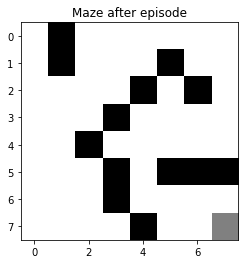

Epoch: 209/999 | Loss: 0.0002 | Episodes: 210 | Win count: 190 | Win rate: 1.000 | time: 57.97 minutes
Loss:  0.0002598354039946571


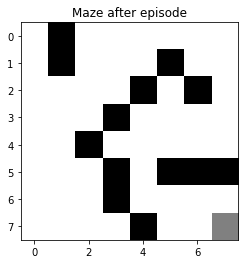

Epoch: 210/999 | Loss: 0.0003 | Episodes: 211 | Win count: 191 | Win rate: 1.000 | time: 57.98 minutes
Loss:  2.6481558961677365e-05
Loss:  0.0004418593816808425
Loss:  6.827600736869499e-05
Loss:  7.597665535286069e-05
Loss:  0.0005493076459970325
Loss:  6.539566311403178e-05
Loss:  0.00024844965810189024
Loss:  0.0001863444413174875
Loss:  0.0002477514099155087
Loss:  0.00039129082870204
Loss:  6.953279080335051e-05
Loss:  0.00010429763824504334
Loss:  0.00022523754159919918
Loss:  3.8362384657375515e-05
Loss:  0.0003245316693210043
Loss:  0.0001910922655952163
Loss:  0.00011614558025030419
Loss:  0.0005499694525497034
Loss:  0.0005061603733338416
Loss:  0.0005030270986026153
Loss:  0.0004932467418257147
Loss:  9.88133433565963e-05
Loss:  0.00011671381435007788
Loss:  0.00014087318777455948
Loss:  0.00043567444663494825


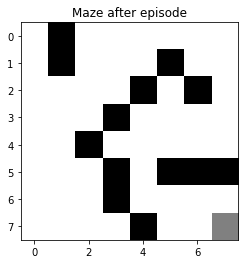

Epoch: 211/999 | Loss: 0.0004 | Episodes: 212 | Win count: 192 | Win rate: 1.000 | time: 58.12 minutes
Loss:  0.000200959171706927
Loss:  0.0006275178311625496
Loss:  4.802626426680945e-05
Loss:  0.00024954407854238525
Loss:  0.0002253756028949283
Loss:  0.00017432598906452768
Loss:  0.0003484024200588465
Loss:  0.00011296262891846709
Loss:  0.0003175903475494124
Loss:  0.00042186382052022964
Loss:  0.00045419676462188363
Loss:  0.0004720251017715782
Loss:  0.0002579699648777023
Loss:  0.0005403168470365927
Loss:  0.0004563546972349286
Loss:  0.0008342877554241568
Loss:  0.0002785839169519022
Loss:  0.0003424906208238099
Loss:  0.00033807709405664355
Loss:  8.531038838555105e-05
Loss:  0.0006428364577004686
Loss:  0.000488682504510507
Loss:  0.0005811859300592914
Loss:  0.0005315679882187396
Loss:  0.00015783892013132572
Loss:  0.00043432549500721507
Loss:  0.000580581632675603
Loss:  0.00023315887665376067
Loss:  0.00043848865607287735
Loss:  0.00017868719442049041
Loss:  0.0006809278

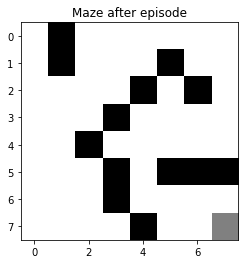

Epoch: 212/999 | Loss: 0.0005 | Episodes: 213 | Win count: 193 | Win rate: 1.000 | time: 58.31 minutes
Loss:  0.0004915551689919084
Loss:  0.00018236735922982916
Loss:  0.00017426359409000725
Loss:  0.0002139054013241548
Loss:  0.000350500107742846
Loss:  0.00039538824057672173
Loss:  0.00032310784263245296
Loss:  0.0007391489780275151
Loss:  0.00037641962990164757
Loss:  0.0006181469216244295
Loss:  0.0004927060490445001
Loss:  0.00023405874344462063
Loss:  0.00021825363728567027
Loss:  0.0005357444169931114
Loss:  0.0003876838200085331
Loss:  0.0006723962142132223
Loss:  0.00019828875701932702
Loss:  0.00030556294950656593
Loss:  0.00048520271957386285
Loss:  7.09516170900315e-05


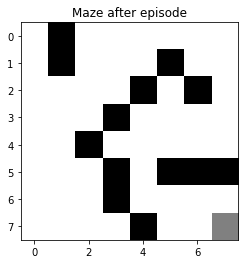

Epoch: 213/999 | Loss: 0.0001 | Episodes: 214 | Win count: 194 | Win rate: 1.000 | time: 58.41 minutes
Loss:  0.00021119093798915856
Loss:  0.00019865622016368434
Loss:  0.0004978206707164645
Loss:  0.00038712464447598904
Loss:  0.0006989358807913959
Loss:  0.000486789271235466
Loss:  0.0003997275198344141
Loss:  0.00022672027807857376
Loss:  0.00037541215715464205
Loss:  0.0005035890935687348
Loss:  0.00021666613611159846
Loss:  0.00022549992718268186
Loss:  0.0003378691471880302
Loss:  0.0004345234628999606
Loss:  0.00020551201669150032
Loss:  0.0006921709573362023
Loss:  0.0002928207832155749
Loss:  0.0005707258533220738
Loss:  0.000221051352127688
Loss:  0.00023000319924904034
Loss:  0.0002104292216245085
Loss:  0.0005150019132997841
Loss:  0.0005522874125745147
Loss:  0.00022337608970701694


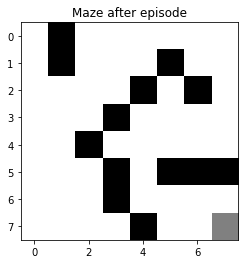

Epoch: 214/999 | Loss: 0.0002 | Episodes: 215 | Win count: 195 | Win rate: 1.000 | time: 58.54 minutes
Loss:  0.00020310825493652374
Loss:  0.00021819677203893661
Loss:  0.00026025315310107544
Loss:  0.0001449590563424863
Loss:  0.0003487453068373725
Loss:  0.0004322581735323183
Loss:  0.0004486342950258404
Loss:  0.0003223549429094419
Loss:  6.852267688373104e-05
Loss:  0.0003290425956947729
Loss:  3.640682916739024e-05
Loss:  0.0003710781747940928
Loss:  0.00031925497751217335
Loss:  0.0002596609483589418
Loss:  0.00032259936415357515
Loss:  0.00032833444129209965
Loss:  0.00013346770356292836
Loss:  0.0006634720484726131


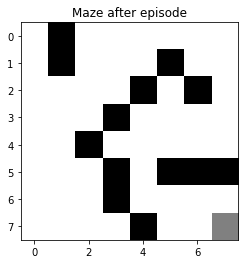

Epoch: 215/999 | Loss: 0.0007 | Episodes: 216 | Win count: 196 | Win rate: 1.000 | time: 58.64 minutes
Loss:  4.0661714592715725e-05
Loss:  0.0004644367545552086
Loss:  0.0008922155830077827
Loss:  0.0002786872246360872
Loss:  0.00041727887582965195
Loss:  0.00020833272355957888
Loss:  0.0002381151953159133
Loss:  0.0004573294281726703
Loss:  0.00021339934028219432
Loss:  5.093361687613651e-05
Loss:  3.4916220101877116e-05
Loss:  0.0001804912653824431
Loss:  0.00014435801131185144
Loss:  0.00030952278757467866
Loss:  0.00026002364029409364
Loss:  0.00036521423317026347
Loss:  0.0003954244457418099


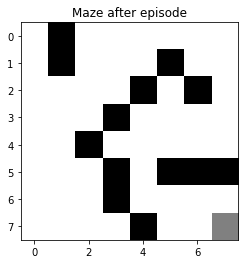

Epoch: 216/999 | Loss: 0.0004 | Episodes: 217 | Win count: 197 | Win rate: 1.000 | time: 58.74 minutes
Loss:  0.0005938047543168068
Loss:  0.0005255691357888281
Loss:  0.00044216643436811864
Loss:  0.00040301020635524765
Loss:  0.000540017819730565
Loss:  0.0005652964173350483
Loss:  0.00022119782806839794
Loss:  0.0003971656260546297
Loss:  0.0003147230818285607
Loss:  0.00045242202759254724
Loss:  0.00037231206806609407
Loss:  0.0003082123221247457
Loss:  0.00024827966262819245
Loss:  0.000367848711903207
Loss:  0.0005647157231578603
Loss:  0.0003385738455108367
Loss:  0.00038445206882897764
Loss:  0.0006375452503561974
Loss:  0.00044922539382241666
Loss:  0.0003815761592704803


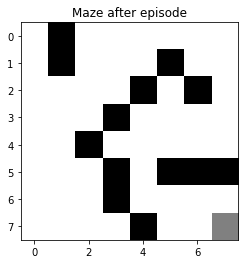

Epoch: 217/999 | Loss: 0.0004 | Episodes: 218 | Win count: 198 | Win rate: 1.000 | time: 58.86 minutes
Loss:  0.0001804097555577755
Loss:  0.0004656984456232749
Loss:  0.0004534857434919104
Loss:  0.0002197919093305245


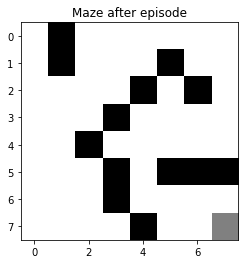

Epoch: 218/999 | Loss: 0.0002 | Episodes: 219 | Win count: 199 | Win rate: 1.000 | time: 58.89 minutes
Loss:  0.0002151209773728624
Loss:  2.9720680686295964e-05
Loss:  0.00041367466474184766
Loss:  0.0004984280531061813
Loss:  0.0002042633423116058
Loss:  0.0002351643815927673
Loss:  0.0001319534239883069
Loss:  0.0007031511922832578
Loss:  0.0006726365245413035
Loss:  8.076163430814631e-05
Loss:  0.0004940657527185977
Loss:  0.0003650863218354061
Loss:  0.000396875839214772
Loss:  0.0003581857599783689
Loss:  0.00020876896087429486
Loss:  7.635431029484607e-05
Loss:  0.00019364850777492393
Loss:  0.00012278194481041282
Loss:  0.0003596657479647547
Loss:  6.473917528637685e-05
Loss:  0.0003962263617722783
Loss:  0.00018507454660721123
Loss:  0.0001350227430521045
Loss:  0.0006554036226589233
Loss:  0.00042031823249999434
Loss:  0.0006509491358883679


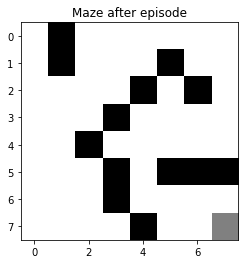

Epoch: 219/999 | Loss: 0.0007 | Episodes: 220 | Win count: 200 | Win rate: 1.000 | time: 59.05 minutes
Loss:  0.00034614592732395977
Loss:  0.0003600257623475045
Loss:  0.0003700491361087188
Loss:  0.0005334949164534919
Loss:  0.00012010363207082264
Loss:  0.00039521608414361253
Loss:  0.00033776483905967325
Loss:  0.0006404488231055439
Loss:  0.0005473402925417759
Loss:  0.0009265879343729466
Loss:  0.00077031523687765
Loss:  0.0003956252912757918
Loss:  0.0003474313562037423
Loss:  0.00041947735007852316
Loss:  0.00033281664218520746


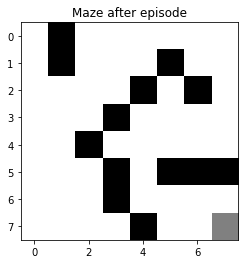

Epoch: 220/999 | Loss: 0.0003 | Episodes: 221 | Win count: 201 | Win rate: 1.000 | time: 59.14 minutes
Loss:  0.00034033343399642035
Loss:  0.0007301418809220195


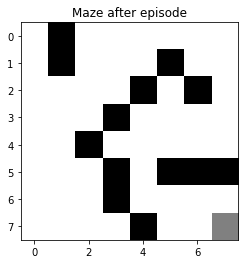

Epoch: 221/999 | Loss: 0.0007 | Episodes: 222 | Win count: 202 | Win rate: 1.000 | time: 59.15 minutes
Loss:  0.0003200065184501
Loss:  0.0009400207200087607
Loss:  0.00054381244990509
Loss:  0.0002053593343589455
Loss:  0.00014054634812055156
Loss:  0.00041227091423934326
Loss:  0.00032206965261138976


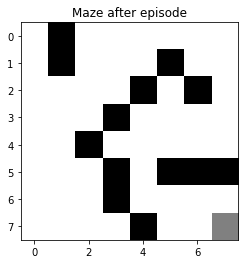

Epoch: 222/999 | Loss: 0.0003 | Episodes: 223 | Win count: 203 | Win rate: 1.000 | time: 59.21 minutes
Loss:  0.00014327216922538355
Loss:  0.00026621225697454065
Loss:  0.00013504094386007637
Loss:  0.0002941489656222984
Loss:  9.188562034978531e-05
Loss:  0.0005423294787760824
Loss:  0.0003290720487711951
Loss:  0.0005784947279607877
Loss:  0.00042243786447215825
Loss:  0.00027885155577678233
Loss:  0.00038945106643950567
Loss:  0.0004112548194825649
Loss:  9.921590753947385e-05
Loss:  0.00010179605305893347
Loss:  0.00016974698519334197
Loss:  0.0006027340423315763
Loss:  0.00020266925093892496
Loss:  0.0002966483370983042
Loss:  0.0005299690528772771
Loss:  0.0002530945057515055
Loss:  0.0006902782479301095
Loss:  0.0003929829654225614
Loss:  0.0009016996482387185
Loss:  0.0005272039124974981
Loss:  0.0004972243768861517
Loss:  0.0002933028372353874
Loss:  0.0003854180140479002
Loss:  0.0008415373740717769
Loss:  0.00025721256679389626
Loss:  0.0010566946002654731
Loss:  0.00047364

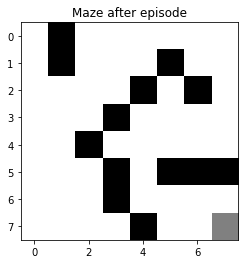

Epoch: 223/999 | Loss: 0.0005 | Episodes: 224 | Win count: 204 | Win rate: 1.000 | time: 59.39 minutes
Loss:  0.0005477922095451504
Loss:  0.0008245515346061438
Loss:  0.00027805985882878304
Loss:  0.00040306185837835073
Loss:  0.0006467922648880631
Loss:  0.0003560370532795787
Loss:  0.0006599675107281655
Loss:  5.779568527941592e-05
Loss:  0.0005835281335748732
Loss:  0.000260927394265309
Loss:  0.00047506362898275256
Loss:  0.00034469461388653144
Loss:  0.0008721044578123838
Loss:  0.0003639764036051929


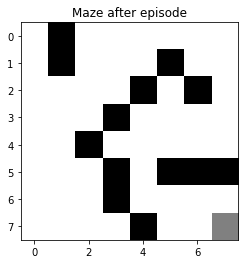

Epoch: 224/999 | Loss: 0.0004 | Episodes: 225 | Win count: 205 | Win rate: 1.000 | time: 59.47 minutes
Loss:  0.0005336796457413584
Loss:  0.0003317797709314618
Loss:  0.0007198964594863355
Loss:  0.0002743147997534834
Loss:  0.00031259317620424554
Loss:  0.0005669778038281947
Loss:  0.0004199721006443724
Loss:  0.0004054615565109998
Loss:  0.00037741287087555975
Loss:  0.00043462681060191244
Loss:  0.00040086692024488
Loss:  0.0007758590072626248
Loss:  0.0004142942125326954
Loss:  0.0005065455625299364
Loss:  0.0003018377101398073
Loss:  0.0006011188088450581
Loss:  0.0005319025076460093
Loss:  0.0002757869915512856
Loss:  0.0004607591181411408
Loss:  0.0007295138784684241
Loss:  0.00046404366730712354
Loss:  0.0003450810181675479
Loss:  0.0003642332048912067
Loss:  0.0005432055040728301
Loss:  0.000684725382598117
Loss:  0.0006608642579521984
Loss:  0.00038477653288282454
Loss:  0.0006541767215821892
Loss:  8.354019701073412e-05
Loss:  0.0005104926240164787
Loss:  0.0002257367668789

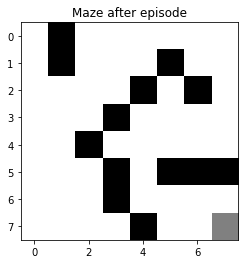

Epoch: 225/999 | Loss: 0.0002 | Episodes: 226 | Win count: 206 | Win rate: 1.000 | time: 59.64 minutes
Loss:  0.0004077506309840828
Loss:  0.00015135842113522813
Loss:  0.0007605199061799794
Loss:  0.0006063705659471452
Loss:  0.0007288215492735617
Loss:  0.0003249019355280325
Loss:  0.0002405627819825895
Loss:  0.00014437929348787293
Loss:  0.000647338543785736
Loss:  7.0758476795163e-05
Loss:  0.0006327014416456223
Loss:  0.0004630388466466684
Loss:  0.00042052395292557776
Loss:  0.00035107861913274974
Loss:  0.00014504676073556766
Loss:  0.00047139614616753533
Loss:  0.0006437876727432013
Loss:  0.00025515454763080925
Loss:  0.0005980137211736292
Loss:  0.0005957644316367805
Loss:  0.00015552456898149103
Loss:  0.00025903983623720706
Loss:  0.0007781151653034613
Loss:  0.000479701797303278


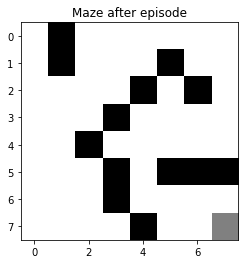

Epoch: 226/999 | Loss: 0.0005 | Episodes: 227 | Win count: 207 | Win rate: 1.000 | time: 59.78 minutes
Loss:  0.000663348357193172
Loss:  0.0004971308953827247
Loss:  0.000746850942960009
Loss:  0.00014077487867325544
Loss:  0.0003375116975803394
Loss:  0.0006689152723993175
Loss:  0.0002897251979447901
Loss:  0.0007280281279236078
Loss:  0.0006488315993919969


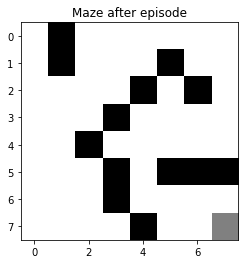

Epoch: 227/999 | Loss: 0.0006 | Episodes: 228 | Win count: 208 | Win rate: 1.000 | time: 59.84 minutes
Loss:  0.00023477704235119745
Loss:  0.000746049772715196
Loss:  0.0002659278688952327
Loss:  0.0002997893388965167
Loss:  0.00027330423472449183
Loss:  0.00047137090587057173
Loss:  0.00025553494197083637
Loss:  0.0006061244057491422
Loss:  0.00023052487813401967
Loss:  0.00035024795215576887
Loss:  0.0004158210285822861


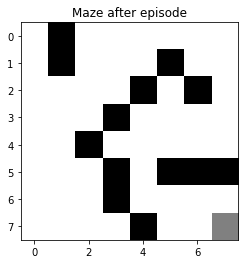

Epoch: 228/999 | Loss: 0.0004 | Episodes: 229 | Win count: 209 | Win rate: 1.000 | time: 59.93 minutes
Loss:  0.0005533800867851824
Loss:  0.00016517970652785152
Loss:  0.00022113386876299046
Loss:  0.0007769734365865588
Loss:  0.0005417463544290513
Loss:  0.00025901880871970206
Loss:  0.0006433623348129913


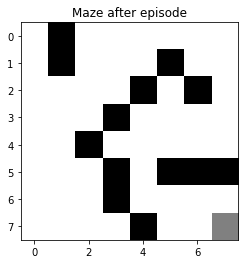

Epoch: 229/999 | Loss: 0.0006 | Episodes: 230 | Win count: 210 | Win rate: 1.000 | time: 59.99 minutes
Loss:  0.00031406116613652557
Loss:  0.00033348066062899306


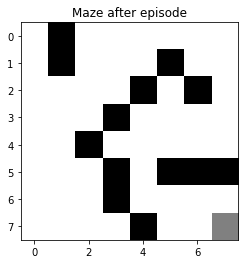

Epoch: 230/999 | Loss: 0.0003 | Episodes: 231 | Win count: 211 | Win rate: 1.000 | time: 60.01 minutes
Loss:  9.611284622224048e-05
Loss:  9.915282862493768e-05
Loss:  0.0004525239928625524
Loss:  0.0006080975290387869
Loss:  0.00031784379098098725
Loss:  0.0003135223887511529
Loss:  0.0008580628491472453
Loss:  0.0007426757947541773
Loss:  0.00039292594738071784
Loss:  0.0005492362979566678
Loss:  0.00032451394508825615
Loss:  0.0004384498388390057
Loss:  6.303143254626775e-05
Loss:  0.0002218618719780352
Loss:  0.0007082775846356526
Loss:  0.00019223403796786442
Loss:  0.00032439517963211983
Loss:  0.0003762592968996614
Loss:  0.000298270424536895
Loss:  0.0005928449390921742
Loss:  0.00029328130767680705
Loss:  0.0004659199039451778


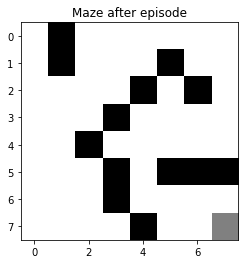

Epoch: 231/999 | Loss: 0.0005 | Episodes: 232 | Win count: 212 | Win rate: 1.000 | time: 60.17 minutes
Loss:  0.00029580579575849697
Loss:  0.0006083832122385502
Loss:  0.0006393062649294734
Loss:  0.0005287087697070092
Loss:  0.00047369906678795815
Loss:  0.0003840616154775489
Loss:  0.0006350664334604517
Loss:  0.0005731890560127795
Loss:  0.00017793962615542114
Loss:  0.0004597693186951801
Loss:  0.0008743840153329074
Loss:  0.00048328781849704683
Loss:  0.0002482026247889735
Loss:  0.0005777184815087821
Loss:  0.00032853512675501406
Loss:  0.0003434752143220976
Loss:  0.0006582698260899633
Loss:  0.0006365760054904968
Loss:  0.0003382090508239344
Loss:  0.0003056118875974789


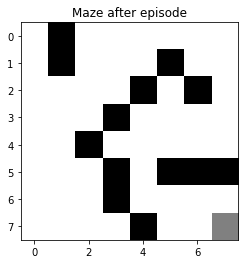

Epoch: 232/999 | Loss: 0.0003 | Episodes: 233 | Win count: 213 | Win rate: 1.000 | time: 60.29 minutes
Loss:  0.00023278139269677922
Loss:  0.0005614542169496417
Loss:  0.0004857188177993521
Loss:  0.0006233379826880991
Loss:  0.0004592742334352806
Loss:  0.00010967936577799264
Loss:  0.0005493062344612554
Loss:  8.723220889805816e-05
Loss:  0.00043455561899463646
Loss:  0.0004900173516944051
Loss:  0.000686837753164582
Loss:  0.00011784805974457413
Loss:  0.0003136124214506708


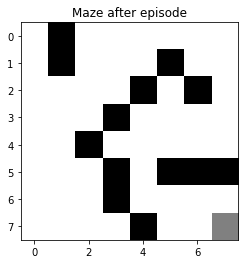

Epoch: 233/999 | Loss: 0.0003 | Episodes: 234 | Win count: 214 | Win rate: 1.000 | time: 60.38 minutes
Loss:  0.0008024468261282891
Loss:  0.0003338302194606513
Loss:  0.0003208097259630449
Loss:  0.00017511127225589007
Loss:  6.452045272453688e-05
Loss:  0.0005978476256132126
Loss:  0.000588927578064613
Loss:  0.0004883072397205979
Loss:  0.0003888571045536082
Loss:  0.0003436146434978582
Loss:  0.0002607568894745782
Loss:  0.00025497629394521937
Loss:  0.00023592331854160875
Loss:  0.0007702815200900659
Loss:  0.0005670107930200174
Loss:  0.0004972657625330612
Loss:  0.00026600209093885496
Loss:  0.00042361256782896817
Loss:  9.080482595891226e-05
Loss:  0.0006635222816839814
Loss:  0.0003739340463653207
Loss:  0.000522590649779886
Loss:  0.0004898498737020418
Loss:  0.0003404836534173228


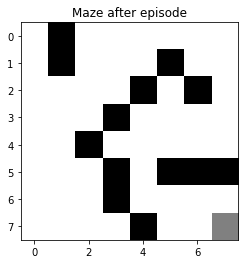

Epoch: 234/999 | Loss: 0.0003 | Episodes: 235 | Win count: 215 | Win rate: 1.000 | time: 60.54 minutes
Loss:  0.000389138629543595
Loss:  0.00044379811151884496
Loss:  0.0003148984906147234
Loss:  0.00021806155564263463
Loss:  0.0005077584937680513
Loss:  0.00030746306583750993
Loss:  0.0005436714855022728
Loss:  0.000556266080820933
Loss:  0.00080341991269961
Loss:  0.00030402193806366995
Loss:  0.0009321538964286447
Loss:  0.0002847896685125306
Loss:  0.0006606363167520612
Loss:  0.00016997883358271793
Loss:  0.0003236104857933242
Loss:  0.000470490354928188
Loss:  0.00027127943030791357
Loss:  0.0004947995621478185
Loss:  0.0005581921577686444
Loss:  0.0003886462654918432
Loss:  0.00038263070746324956
Loss:  0.00026197345869150013
Loss:  0.00023996040545171127
Loss:  0.00039091651342459954
Loss:  0.0001933695748448372


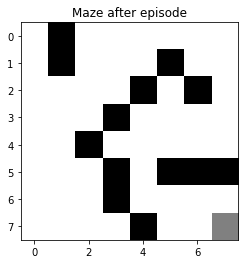

Epoch: 235/999 | Loss: 0.0002 | Episodes: 236 | Win count: 216 | Win rate: 1.000 | time: 60.70 minutes
Loss:  0.000273154117166996
Loss:  0.0002992922491102945
Loss:  0.0005879007803741843
Loss:  0.0007656154339201748
Loss:  0.0004219482507323846
Loss:  0.0005257085722405463
Loss:  0.0006409039488062263
Loss:  0.00045335768663790077
Loss:  0.0007148872246034443
Loss:  0.000551219200133346
Loss:  0.00037742881977465004
Loss:  0.00018661182548385113
Loss:  0.00033118323335656896
Loss:  0.0003004135796800256
Loss:  0.0003441609151195735
Loss:  0.0008288785757031292
Loss:  0.0004677799006458372
Loss:  0.0006503452896140516
Loss:  0.0004111727903364226
Loss:  0.0009007392218336463
Loss:  0.0007072414737194777
Loss:  0.0004552618775051087
Loss:  0.000138930969114881
Loss:  0.00043939762690570205
Loss:  0.0005309700209181756
Loss:  0.0005769925483036786
Loss:  0.0004863121430389583
Loss:  0.0006607761606574059
Loss:  0.0002772796869976446
Loss:  0.00034465358476154506
Loss:  0.000747647369280

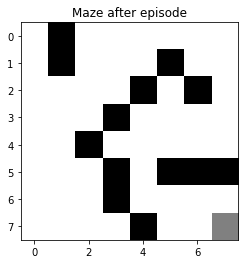

Epoch: 236/999 | Loss: 0.0009 | Episodes: 237 | Win count: 217 | Win rate: 1.000 | time: 60.97 minutes
Loss:  0.0007416227890644222
Loss:  0.0008695996657479554
Loss:  0.0008106589375529438
Loss:  0.001113942234951537
Loss:  0.001082665752619505
Loss:  0.000517409120220691
Loss:  0.000885195448063314
Loss:  0.0005734682490583509
Loss:  0.0009667365811765194
Loss:  0.0004765244520967826
Loss:  0.0006656564801232889
Loss:  0.0002919073303928599
Loss:  0.0006978039746172726
Loss:  0.0006592593272216618
Loss:  0.0005045513244112954
Loss:  0.0008644182817079127
Loss:  0.0006642616644967347
Loss:  0.0007336029666475952
Loss:  0.0009770461183506995
Loss:  0.0009377704991493374
Loss:  0.0011962572752963752
Loss:  0.0004685950407292694
Loss:  0.0006294593040365726
Loss:  0.0006271158927120268
Loss:  0.00031462256447412074
Loss:  0.0006914104742463678
Loss:  0.0006114099523983896
Loss:  0.0011192625970579684
Loss:  0.0005458931555040181


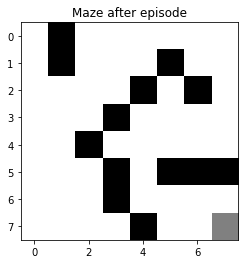

Epoch: 237/999 | Loss: 0.0005 | Episodes: 238 | Win count: 218 | Win rate: 1.000 | time: 61.13 minutes
Loss:  0.0011262475163675845
Loss:  0.0008367646660190076
Loss:  0.0007294385286513716
Loss:  0.000695929629728198
Loss:  0.0007825794455129653
Loss:  0.000734419038053602
Loss:  0.0009246208355762064
Loss:  0.0010233799985144287
Loss:  0.0004064097593072802
Loss:  0.0006825742602813989
Loss:  0.0007026135135674849
Loss:  0.000520103654707782
Loss:  0.0006485660851467401
Loss:  0.0004517488123383373
Loss:  0.0009901434532366693
Loss:  0.00046452885726466775
Loss:  0.0008649134251754731
Loss:  0.0006068718794267625
Loss:  0.0007669344777241349
Loss:  0.0006558671302627772
Loss:  0.0008089363109320402
Loss:  0.000971195288002491
Loss:  0.0013703455333597958
Loss:  0.0009500952146481723
Loss:  0.0010209924075752497
Loss:  0.0007036316092126071
Loss:  0.0006186123064253479
Loss:  0.0010246196470689029
Loss:  0.000675812567351386
Loss:  0.0005809285576106049
Loss:  0.0004472000728128478
Lo

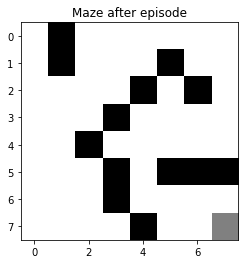

Epoch: 238/999 | Loss: 0.0008 | Episodes: 239 | Win count: 219 | Win rate: 1.000 | time: 61.35 minutes
Loss:  0.0006859098211862147


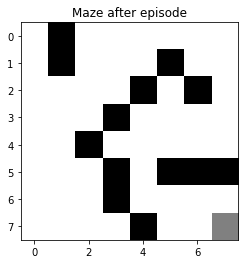

Epoch: 239/999 | Loss: 0.0007 | Episodes: 240 | Win count: 220 | Win rate: 1.000 | time: 61.36 minutes
Loss:  0.0006322425906546414
Loss:  0.0010152297327294946
Loss:  0.0007851757909520529
Loss:  0.0005818713252665475
Loss:  0.0006812807696405798
Loss:  0.001521494530607015
Loss:  0.0007923329831101
Loss:  0.0006716258358210325
Loss:  0.0008656621212139726
Loss:  0.000647429347736761
Loss:  0.0015346924774348736
Loss:  0.00078446144470945
Loss:  0.0007912719156593084
Loss:  0.0007338921132031828
Loss:  0.000843309098854661
Loss:  0.0007980387308634818
Loss:  0.0008998924749903381
Loss:  0.0008758074254728854
Loss:  0.0004853601421928033
Loss:  0.0006331717595458031
Loss:  0.0005499551043612882
Loss:  0.0013357324060052633
Loss:  0.0014343314687721431
Loss:  0.0008710379770491272
Loss:  0.0006510165403597057
Loss:  0.0008563552983105183
Loss:  0.0005792870942968875
Loss:  0.0005441326793516055
Loss:  0.001266580366063863
Loss:  0.0006980913458392024
Loss:  0.001083920185919851
Loss:  0

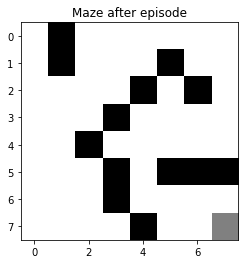

Epoch: 240/999 | Loss: 0.0010 | Episodes: 241 | Win count: 221 | Win rate: 1.000 | time: 61.64 minutes
Loss:  0.0008370259893126786
Loss:  0.00042721620411612093
Loss:  0.0006593835569219664
Loss:  0.0006119823083281517
Loss:  0.0012585474760271609
Loss:  0.001003100216621533
Loss:  0.0008346616814378649
Loss:  0.0005949692276772112
Loss:  0.000897000718396157
Loss:  0.0006785282166674733


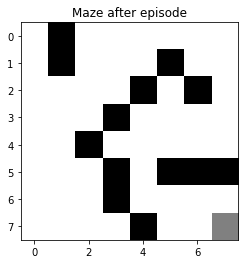

Epoch: 241/999 | Loss: 0.0007 | Episodes: 242 | Win count: 222 | Win rate: 1.000 | time: 61.70 minutes
Loss:  0.0013799007283523679
Loss:  0.0010385077621322125
Loss:  0.000786727643571794
Loss:  0.0009643243392929435
Loss:  0.0004700119752669707
Loss:  0.0006929165538167581
Loss:  0.000640710219158791


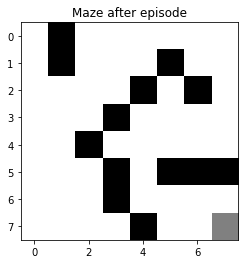

Epoch: 242/999 | Loss: 0.0006 | Episodes: 243 | Win count: 223 | Win rate: 1.000 | time: 61.75 minutes
Loss:  0.0011438201763667166
Loss:  0.0012621887726709247
Loss:  0.0008985108870547265
Loss:  0.0009760805405676365
Loss:  0.0012228370178490877
Loss:  0.0005084570148028433
Loss:  0.0005182258319109678
Loss:  0.001189645379781723
Loss:  0.000786317978054285
Loss:  0.0010051264835055918
Loss:  0.0012068914948031306
Loss:  0.0009671860025264323
Loss:  0.0007671336643397808
Loss:  0.0009646036778576672
Loss:  0.0007237060635816306
Loss:  0.0007206533919088542
Loss:  0.0006256649503484368
Loss:  0.0008526663295924664
Loss:  0.0011644881451502442
Loss:  0.0008650448289699852
Loss:  0.0008730306581128389
Loss:  0.0006159332988318056
Loss:  0.0007701384165557101
Loss:  0.0005461949913296849
Loss:  0.0009516794234514236


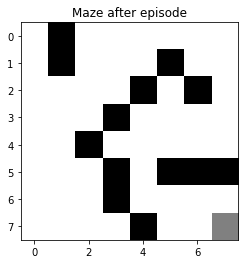

Epoch: 243/999 | Loss: 0.0010 | Episodes: 244 | Win count: 224 | Win rate: 1.000 | time: 61.90 minutes
Loss:  0.0005991608486510813
Loss:  0.0007409411482512951
Loss:  0.0006081299361540005
Loss:  0.0009470185614190996
Loss:  0.0009231993462890387
Loss:  0.0009795432270038873


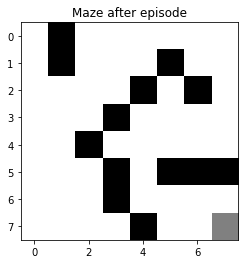

Epoch: 244/999 | Loss: 0.0010 | Episodes: 245 | Win count: 225 | Win rate: 1.000 | time: 61.95 minutes
Loss:  0.000811697420431301
Loss:  0.0009908441279549152
Loss:  0.0008384879911318421
Loss:  0.0007585868297610432
Loss:  0.0008949002076406032
Loss:  0.000674732553306967
Loss:  0.000654902309179306
Loss:  0.0008962454448919743
Loss:  0.0006324920104816556
Loss:  0.0009080038871616125
Loss:  0.0008011760655790567
Loss:  0.0005121000140206888
Loss:  0.0008594550599809736
Loss:  0.0010529372666496783
Loss:  0.0006495883426396176
Loss:  0.0011379611387383193
Loss:  0.0010051975841633976
Loss:  0.0008889732998795807
Loss:  0.0010632232879288495
Loss:  0.000457870468380861
Loss:  0.0014825285761617124
Loss:  0.001302206888794899
Loss:  0.000970653782133013
Loss:  0.0009503941400907934


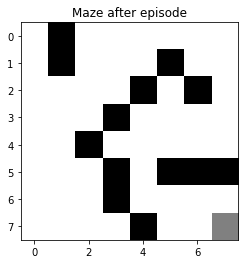

Epoch: 245/999 | Loss: 0.0010 | Episodes: 246 | Win count: 226 | Win rate: 1.000 | time: 62.08 minutes
Loss:  0.0008270498074125499
Loss:  0.0007916172908153385
Loss:  0.001039397349813953
Loss:  0.001090494217351079
Loss:  0.000832547782920301
Loss:  0.0012240037322044373
Loss:  0.0005495328368851915
Loss:  0.000756787892896682
Loss:  0.0005129073688294739
Loss:  0.0007435458828695118
Loss:  0.0009008130291476846
Loss:  0.000804911192972213
Loss:  0.0006701623788103461
Loss:  0.0005814997421111912
Loss:  0.0008431339228991419


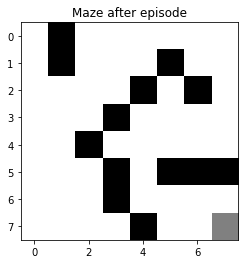

Epoch: 246/999 | Loss: 0.0008 | Episodes: 247 | Win count: 227 | Win rate: 1.000 | time: 62.15 minutes
Loss:  0.0006702183600282297
Loss:  0.00043263666157145053
Loss:  0.0007244962762342766
Loss:  0.0007568838482256979
Loss:  0.00040319329127669334
Loss:  0.0007919919589767233
Loss:  0.0010726918990258127
Loss:  0.0010387911461293697
Loss:  0.00059474166482687
Loss:  0.0005642779578920454
Loss:  0.00067099785519531
Loss:  0.0008408309222431853
Loss:  0.0009421255090273917
Loss:  0.0007246592431329191
Loss:  0.0007881402561906725
Loss:  0.0006903160974616185
Loss:  0.0009102834446821362
Loss:  0.0008093719079624861
Loss:  0.0008952655480243266
Loss:  0.0005035879439674318
Loss:  0.001299058145377785
Loss:  0.0009044084727065638
Loss:  0.0007819904712960124
Loss:  0.0005645157798426226
Loss:  0.0006853585364297032
Loss:  0.0008887794829206541
Loss:  0.0011786269024014473
Loss:  0.00043902745528612286


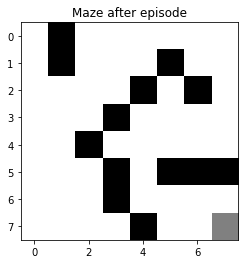

Epoch: 247/999 | Loss: 0.0004 | Episodes: 248 | Win count: 228 | Win rate: 1.000 | time: 62.31 minutes
Loss:  0.0011188846547156572
Loss:  0.0005595176480710506


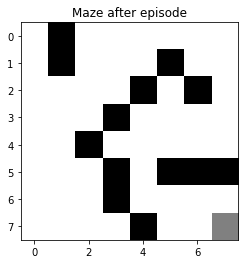

Epoch: 248/999 | Loss: 0.0006 | Episodes: 249 | Win count: 229 | Win rate: 1.000 | time: 62.33 minutes
Loss:  0.0007380222086794674
Loss:  0.0009352389315608889
Loss:  0.0006874887621961534
Loss:  0.00022204551351023838
Loss:  0.0006160799821373075
Loss:  0.000576649938011542
Loss:  0.0008155389514286071
Loss:  0.0005141942092450336
Loss:  0.0008572179503971711
Loss:  0.0007268213958013803
Loss:  0.0003194763994542882
Loss:  0.0008281241171061993
Loss:  0.0008346305112354457
Loss:  0.0004856041632592678
Loss:  0.00042663791100494564
Loss:  0.000674060545861721


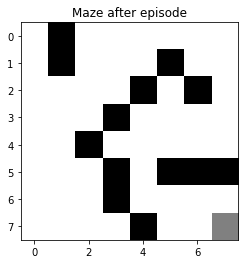

Epoch: 249/999 | Loss: 0.0007 | Episodes: 250 | Win count: 230 | Win rate: 1.000 | time: 62.43 minutes
Loss:  0.0004558467189781368
Loss:  0.0009207515977323055
Loss:  0.0008102514257188886
Loss:  0.001042592863086611
Loss:  0.0008090602932497859
Loss:  0.0005492545460583642
Loss:  0.0004746408521896228
Loss:  0.0008026962168514729
Loss:  0.000543736110557802
Loss:  0.0003708275326061994
Loss:  0.0010655695805326104
Loss:  0.000704736594343558
Loss:  0.00028388179634930566
Loss:  0.00045293553557712585
Loss:  0.000904020358575508
Loss:  0.0007343153411056846
Loss:  0.0006658228812739253
Loss:  0.0005471371623571031
Loss:  0.0005899496609345078
Loss:  0.0006381775456247851
Loss:  0.0006217444897629321
Loss:  0.0005297120078466833
Loss:  0.0008494030917063355
Loss:  0.0004513137973845005
Loss:  0.0005699430184904486
Loss:  0.0006153339927550405
Loss:  0.0006624853704124689
Loss:  0.0004189097962807864
Loss:  0.0008523250289727002
Loss:  0.0008929704781621695


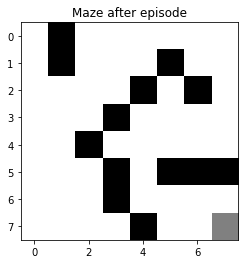

Epoch: 250/999 | Loss: 0.0009 | Episodes: 251 | Win count: 231 | Win rate: 1.000 | time: 62.60 minutes
Loss:  0.0006147075328044593
Loss:  0.0007010224799159914
Loss:  0.0003858202508126851
Loss:  0.0007748930947855115
Loss:  0.0007984276453498751
Loss:  0.0006387766916304827
Loss:  0.0005904166027903557
Loss:  0.0007818307785782963
Loss:  0.0007808602822478861
Loss:  0.0006051503587514162
Loss:  0.00039718340849503875
Loss:  0.0006920294836163521
Loss:  0.0006302754918579012
Loss:  0.0004650721821235493
Loss:  0.0008629337971797213
Loss:  0.0007548142748419195
Loss:  0.0006291531171882525
Loss:  0.00046338853280758485
Loss:  0.00034101412893505767
Loss:  0.0005522211868083104
Loss:  0.00046631407167296857
Loss:  0.0005755568126915023
Loss:  0.0007889172266004607
Loss:  0.00034007200156338513


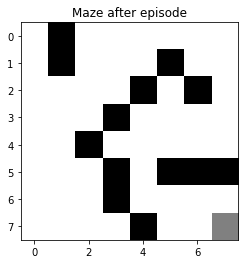

Epoch: 251/999 | Loss: 0.0003 | Episodes: 252 | Win count: 232 | Win rate: 1.000 | time: 62.74 minutes
Loss:  0.0006458524439949542
Loss:  0.0013432601699605584
Loss:  0.0007525948749389499
Loss:  0.0010433807328809053
Loss:  0.0007203248096629977
Loss:  0.001002686214633286
Loss:  0.0009374459332320839
Loss:  0.0008014262421056628
Loss:  0.0010055316088255495
Loss:  0.0004916120087727904
Loss:  0.001151810894953087
Loss:  0.0007651169435121119
Loss:  0.0008684388303663582
Loss:  0.0012193857110105455
Loss:  0.000919863727176562
Loss:  0.0007654020737390965
Loss:  0.0011483668931759894
Loss:  0.0009429493220523
Loss:  0.0011413358442950994
Loss:  0.0006004084571031854
Loss:  0.0004632516938727349
Loss:  0.0008608729403931648
Loss:  0.0010917202453128994
Loss:  0.0011355431051924825
Loss:  0.0004867342358920723
Loss:  0.0007478863190044649
Loss:  0.0013071518624201417
Loss:  0.0005714090075343847


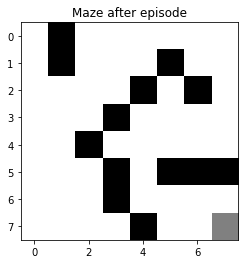

Epoch: 252/999 | Loss: 0.0006 | Episodes: 253 | Win count: 233 | Win rate: 1.000 | time: 62.90 minutes
Loss:  0.0009661633375799283
Loss:  0.0008806422119960189
Loss:  0.0007087955018505454
Loss:  0.000691102904966101
Loss:  0.0007459115877281874
Loss:  0.0013426742516458035
Loss:  0.0008079188701231033
Loss:  0.0005476924707181752
Loss:  0.0009819993283599615
Loss:  0.0010913367150351405
Loss:  0.001312031497946009
Loss:  0.0009008811612147838
Loss:  0.0005962212890153751
Loss:  0.0004921406653011218
Loss:  0.0012657918559852988
Loss:  0.0011804974055849016
Loss:  0.0006196984322741628
Loss:  0.0008066862937994301
Loss:  0.0006635929166804999
Loss:  0.0009265937260352075
Loss:  0.0006306727009359747
Loss:  0.0007689573394600302
Loss:  0.000851691875141114
Loss:  0.0006358985265251249
Loss:  0.0004996519710402936
Loss:  0.0005047176964581013
Loss:  0.0006997928721830249
Loss:  0.0007605869323015213
Loss:  0.0005128138000145555
Loss:  0.0005172439705347642
Loss:  0.000585132569540292
Lo

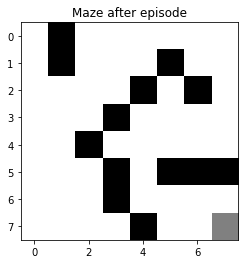

Epoch: 253/999 | Loss: 0.0006 | Episodes: 254 | Win count: 234 | Win rate: 1.000 | time: 63.08 minutes
Loss:  0.00033223758509848267


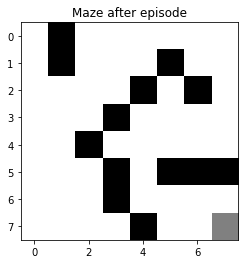

Epoch: 254/999 | Loss: 0.0003 | Episodes: 255 | Win count: 235 | Win rate: 1.000 | time: 63.08 minutes
Loss:  0.0009693406755104661
Loss:  0.0010026946547441185
Loss:  0.00024096491688396782
Loss:  0.0003810948255704716
Loss:  0.000483598472783342
Loss:  0.0005340947245713323
Loss:  0.0008116777898976579
Loss:  0.0009528104565106332
Loss:  0.0004590518947225064
Loss:  0.0005423508700914681
Loss:  0.0011146370670758188
Loss:  0.0008431961468886584
Loss:  0.0005774156597908586
Loss:  0.0005971777281956747
Loss:  0.0011398248025216162
Loss:  0.0006919715087860823
Loss:  0.0008341258071595803
Loss:  0.0007407432713080198
Loss:  0.0007559167279396206
Loss:  0.0006143795035313815
Loss:  0.000511661812197417
Loss:  0.0009317292424384505
Loss:  0.0014409535797312856
Loss:  0.0011235494166612625
Loss:  0.0005412748432718217
Loss:  0.0008396657649427652


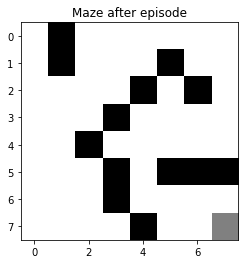

Epoch: 255/999 | Loss: 0.0008 | Episodes: 256 | Win count: 236 | Win rate: 1.000 | time: 63.24 minutes
Loss:  0.00046605837997049093
Loss:  0.0009270574373658746
Loss:  0.0006937615398783237
Loss:  0.0009059457224793732
Loss:  0.0008074657525867224
Loss:  0.0008287864329759032
Loss:  0.0008508781902492046
Loss:  0.0009406760218553245
Loss:  0.0012378425453789532
Loss:  0.0007149938901420683
Loss:  0.0005501255800481886
Loss:  0.0006208806880749762
Loss:  0.0009112294355873019
Loss:  0.0016608542064204812


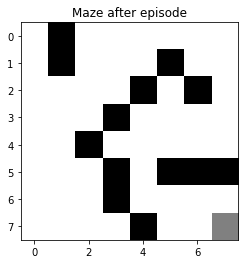

Epoch: 256/999 | Loss: 0.0017 | Episodes: 257 | Win count: 237 | Win rate: 1.000 | time: 63.32 minutes
Loss:  0.0010106470144819468
Loss:  0.0007908271800260991
Loss:  0.0008697656739968807
Loss:  0.0009891387599054724
Loss:  0.0009917915158439428
Loss:  0.0008884689304977655
Loss:  0.00044268064812058583
Loss:  0.0005584436294157058
Loss:  0.001025394129101187
Loss:  0.0006451903318520635
Loss:  0.0005885403807042167
Loss:  0.0011916176008526236
Loss:  0.0007078396301949397
Loss:  0.0008821340743452311
Loss:  0.001212573319207877
Loss:  0.00089702193508856
Loss:  0.00040364846063312143
Loss:  0.0007000130135565996
Loss:  0.0006980400357861072
Loss:  0.0005459543026518077
Loss:  0.000778364745201543
Loss:  0.0009536605793982744
Loss:  0.00045047785533824936
Loss:  0.0007050994609016925
Loss:  0.0010014625440817326


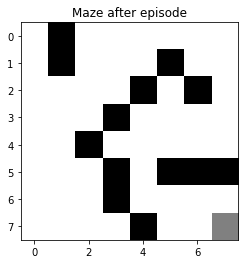

Epoch: 257/999 | Loss: 0.0010 | Episodes: 258 | Win count: 238 | Win rate: 1.000 | time: 63.47 minutes
Loss:  0.000872300413902849
Loss:  0.00030509931093547493
Loss:  0.0007836557633709162
Loss:  0.0009457269625272602
Loss:  0.0008397787169087678
Loss:  0.00093287811614573
Loss:  0.0006614113226532936
Loss:  0.0007736656698398292
Loss:  0.0007938046474009752


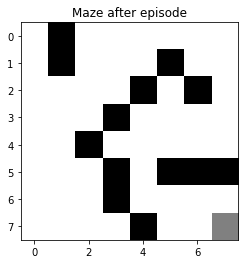

Epoch: 258/999 | Loss: 0.0008 | Episodes: 259 | Win count: 239 | Win rate: 1.000 | time: 63.53 minutes
Loss:  0.0007574550108984113
Loss:  0.0007787368085701019
Loss:  0.001176553312689066
Loss:  0.0004592129698721692
Loss:  0.0009590238332748413
Loss:  0.0008280991460196674
Loss:  0.0010182458208873868
Loss:  0.0009306447464041412
Loss:  0.0007843182247597724
Loss:  0.0013277928810566664
Loss:  0.0014783997903577983
Loss:  0.0008758157200645655
Loss:  0.001048504767823033
Loss:  0.0008719387551536784
Loss:  0.0007142765680328012
Loss:  0.0004557849169941619
Loss:  0.00038049511204008013


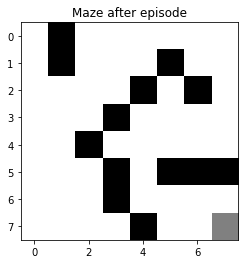

Epoch: 259/999 | Loss: 0.0004 | Episodes: 260 | Win count: 240 | Win rate: 1.000 | time: 63.63 minutes
Loss:  0.0008610018412582576
Loss:  0.0008164827304426581
Loss:  0.0012406011228449643
Loss:  0.000683068938087672
Loss:  0.0007343254837905988
Loss:  0.0010551457817200571
Loss:  0.0010963210370391607
Loss:  0.0006587526440853253
Loss:  0.0003363106516189873
Loss:  0.0019398279837332666
Loss:  0.0004627112648449838
Loss:  0.0012291036546230316
Loss:  0.0005184053588891402
Loss:  0.0009777533123269677
Loss:  0.0008897743828129023
Loss:  0.000844063120894134
Loss:  0.0005255702999420464
Loss:  0.0006784003926441073
Loss:  0.0005331712600309402
Loss:  0.0007757957791909575
Loss:  0.000602656917180866
Loss:  0.0004406339139677584
Loss:  0.0008832640887703747
Loss:  0.0005051133193774149
Loss:  0.0006784363504266366
Loss:  0.00044844743388239294
Loss:  0.0006398399273166433
Loss:  0.0005419727822300047
Loss:  0.0005980661953799427
Loss:  0.0005860287637915462
Loss:  0.0010549933940637857


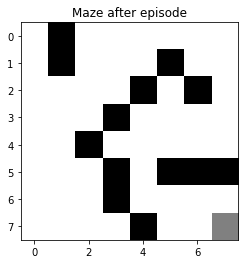

Epoch: 260/999 | Loss: 0.0009 | Episodes: 261 | Win count: 241 | Win rate: 1.000 | time: 63.82 minutes
Loss:  0.000584672816330567
Loss:  0.0008924262074287981
Loss:  0.0008986263128463179
Loss:  0.0009194174490403384
Loss:  0.0009508224466117099
Loss:  0.0006266795535339043
Loss:  0.0005290212138788775
Loss:  0.0011363610392436385
Loss:  0.0005004157865187153
Loss:  0.0006289669254329056
Loss:  0.00031096396560315043
Loss:  0.0008378860075026751
Loss:  0.0007959537324495614
Loss:  0.0009530314709991217
Loss:  0.0007070941355777904
Loss:  0.0005667694204021245
Loss:  0.0007122929964680225
Loss:  0.0005406724812928587
Loss:  0.00047416983579751104
Loss:  0.0008233578409999609
Loss:  0.0007895395974628627
Loss:  0.0004928044509142637
Loss:  0.0005013488989789039
Loss:  0.0010028002434410155
Loss:  0.000705465892679058
Loss:  0.0004873943398706615
Loss:  0.0011206342023797333
Loss:  0.000655888463370502
Loss:  0.0004911998694296926
Loss:  0.0008152652299031615


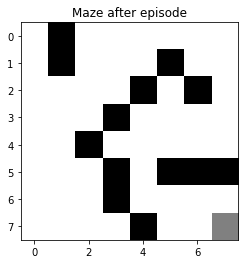

Epoch: 261/999 | Loss: 0.0008 | Episodes: 262 | Win count: 242 | Win rate: 1.000 | time: 64.01 minutes
Loss:  0.0008993547671707347
Loss:  0.0008073019853327423
Loss:  0.0002674170900718309
Loss:  0.0004069860733579844
Loss:  0.0008439310477115214


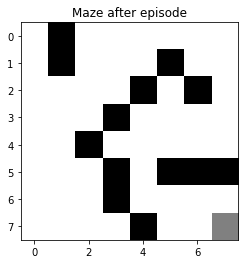

Epoch: 262/999 | Loss: 0.0008 | Episodes: 263 | Win count: 243 | Win rate: 1.000 | time: 64.05 minutes
Loss:  0.0007770435477141291
Loss:  0.0008763765799812973
Loss:  0.0010497932089492679
Loss:  0.0007188998424680904
Loss:  0.0008126714237732813
Loss:  0.0008100146951619536
Loss:  0.00045283554936759174
Loss:  0.000810700556030497
Loss:  0.0008087668684311211
Loss:  0.0007991344027686864
Loss:  0.0006055863050278276
Loss:  0.0008184342586901039
Loss:  0.0005091510392958298
Loss:  0.0005812883900944144
Loss:  9.900164877763018e-05
Loss:  0.0007241627899929881
Loss:  0.00031946074159350246
Loss:  0.0002774872991722077
Loss:  0.0007107159617589787
Loss:  0.0002610210212878883
Loss:  0.0004416393785504624
Loss:  0.0008953301730798557
Loss:  0.0005048898165114224
Loss:  0.0008864608244039118
Loss:  0.00081154442159459
Loss:  0.0009705689444672316
Loss:  0.0007298627169802785
Loss:  0.0005078662361484021
Loss:  0.0006152856367407367
Loss:  0.00038790768303442746
Loss:  0.000451321633590851

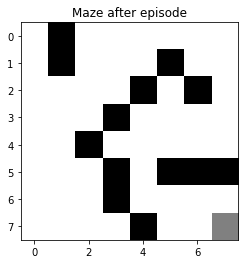

Epoch: 263/999 | Loss: 0.0008 | Episodes: 264 | Win count: 244 | Win rate: 1.000 | time: 64.23 minutes
Loss:  0.0005180234438739717
Loss:  0.0004909853159915656
Loss:  0.0006264694384299219
Loss:  0.0007281700236489996
Loss:  0.00023714332201052457
Loss:  0.00044333143159747124
Loss:  0.000638083292869851
Loss:  0.0005592550878645852
Loss:  0.0010093714809045196
Loss:  0.0006119920581113547
Loss:  0.0005971896171104163
Loss:  0.0004527075361693278
Loss:  0.0005504688597284257
Loss:  0.00044989479647483677
Loss:  0.000547792311408557
Loss:  0.00037025978963356465
Loss:  0.0008654172124806792


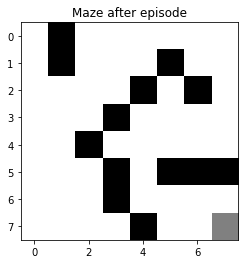

Epoch: 264/999 | Loss: 0.0009 | Episodes: 265 | Win count: 245 | Win rate: 1.000 | time: 64.32 minutes
Loss:  0.0005255979340290651
Loss:  0.00030354717455338687
Loss:  0.0005422447866294533
Loss:  0.0006985267391428351
Loss:  0.00045445578871294856
Loss:  0.0005371059523895383
Loss:  0.0006875531980767846
Loss:  0.00027554576081456617
Loss:  0.0007821717736078426
Loss:  0.0007802110922057182
Loss:  0.0006679738580714911
Loss:  0.00030524480825988576
Loss:  0.0005701558548025787
Loss:  0.000558220170205459
Loss:  0.000645698542939499
Loss:  0.0006927359208930284
Loss:  0.00032280855521094054
Loss:  0.0008487856539431959
Loss:  0.0006992256094235927
Loss:  0.0006014505052007735
Loss:  0.0003870303262374364
Loss:  0.0009372407512273639
Loss:  0.0006131187546998262
Loss:  0.0005983186711091548
Loss:  0.00032337347511202097


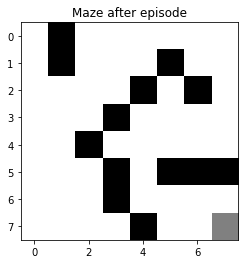

Epoch: 265/999 | Loss: 0.0003 | Episodes: 266 | Win count: 246 | Win rate: 1.000 | time: 64.44 minutes
Loss:  0.00036370040106703527
Loss:  0.0006311922770692036
Loss:  0.0008559586713090539
Loss:  0.00038355521974153817
Loss:  0.000524627830600366


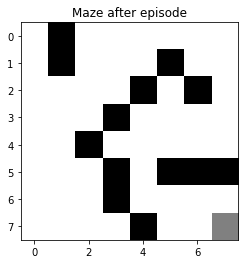

Epoch: 266/999 | Loss: 0.0005 | Episodes: 267 | Win count: 247 | Win rate: 1.000 | time: 64.48 minutes
Loss:  0.0003197798359906301
Loss:  0.0006723683909513056
Loss:  0.0005817339988425374
Loss:  0.00030287786648841575
Loss:  0.00029887932032579556
Loss:  0.0005832608148921281
Loss:  0.00045400251110550016
Loss:  0.0002987174375448376
Loss:  0.0004348289658082649
Loss:  0.0003377310058567673
Loss:  0.0004384898093121592
Loss:  0.0003308232990093529
Loss:  0.00043351178464945406
Loss:  0.0004777856665896252
Loss:  0.0004883107612840831
Loss:  0.00012559433525893837
Loss:  0.0010499057243578136
Loss:  0.0004794954293174669
Loss:  0.0011360565258655697
Loss:  0.0003633442393038422
Loss:  0.0004905821988359094
Loss:  0.0008084409637376666
Loss:  0.0005509068869287148


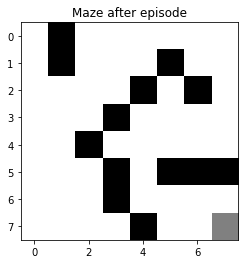

Epoch: 267/999 | Loss: 0.0006 | Episodes: 268 | Win count: 248 | Win rate: 1.000 | time: 64.63 minutes
Loss:  0.0005026153012295254
Loss:  0.0003903772885678336
Loss:  0.0004543238028418273
Loss:  0.0004112564420211129
Loss:  0.000686142360791564
Loss:  0.000760068855015561
Loss:  0.0003689539371407591
Loss:  0.0005089547630632296
Loss:  0.0007141797977965325
Loss:  0.0005355489265639335
Loss:  0.0003730390890268609
Loss:  0.0006685560510959476
Loss:  0.0006138984172139317
Loss:  0.00032494244806002825
Loss:  0.00044107191206421703
Loss:  0.0007998640357982367
Loss:  0.0002303581641172059
Loss:  0.000190983249922283
Loss:  0.0009038318530656397
Loss:  0.00020328754908405244
Loss:  0.0004228442849125713
Loss:  0.0003515652642818168
Loss:  0.00035801957710646093
Loss:  0.0001869048792286776
Loss:  0.00046742842823732644
Loss:  0.0004583231930155307


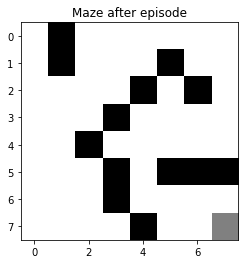

Epoch: 268/999 | Loss: 0.0005 | Episodes: 269 | Win count: 249 | Win rate: 1.000 | time: 64.76 minutes
Loss:  0.0005019096133764833
Loss:  0.00024137549553415738
Loss:  0.0007819940510671586
Loss:  0.0003263650432927534
Loss:  0.0003920456802006811
Loss:  0.00046591424325015396
Loss:  0.0005569294444285333
Loss:  0.0006256148335523903
Loss:  0.0001136617393058259


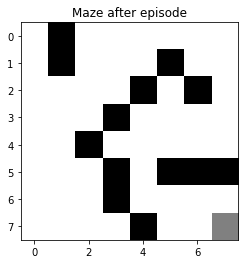

Epoch: 269/999 | Loss: 0.0001 | Episodes: 270 | Win count: 250 | Win rate: 1.000 | time: 64.81 minutes
Loss:  0.00045827380381524563
Loss:  0.0005646631179843098
Loss:  0.0003516102769935969
Loss:  0.0002378144272370264
Loss:  0.0003531230686348863
Loss:  0.0006064141052775085
Loss:  8.923533823690377e-05
Loss:  0.000771121951402165
Loss:  0.0004639464750653133
Loss:  0.0005672178667737171
Loss:  0.00038674482493661344
Loss:  0.00037729611358372495
Loss:  0.0008093469368759543
Loss:  0.000639917008811608
Loss:  0.0006139347678981721
Loss:  0.0007600559329148382
Loss:  0.00031307723838835955
Loss:  0.0002984431048389524


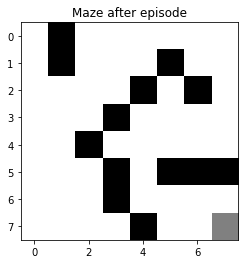

Epoch: 270/999 | Loss: 0.0003 | Episodes: 271 | Win count: 251 | Win rate: 1.000 | time: 64.92 minutes
Loss:  0.00026588019682094455
Loss:  0.0002965481471619569
Loss:  0.000574746634811163
Loss:  0.0006345316069200635
Loss:  0.00023253801191458479
Loss:  0.0006210629653651267
Loss:  0.0004919352577417158
Loss:  0.0004575972707243636
Loss:  0.0005111534264869988
Loss:  0.00046154772280715406
Loss:  0.0005846425774507225
Loss:  0.0005499371618498117
Loss:  0.0003648060082923621
Loss:  0.0005169850192032754
Loss:  0.0003726834838744253


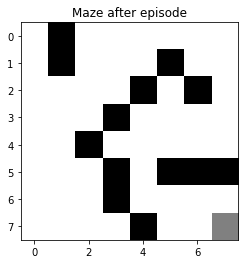

Epoch: 271/999 | Loss: 0.0004 | Episodes: 272 | Win count: 252 | Win rate: 1.000 | time: 65.01 minutes
Loss:  0.0005006733408663422
Loss:  0.00040422759775538
Loss:  0.0004441747660166584
Loss:  0.0005730145639972761
Loss:  0.0009601137426216155
Loss:  0.0005822443636134267
Loss:  0.0008578421256970614
Loss:  0.0004886960959993303
Loss:  0.00046230684529291466
Loss:  0.0004367782239569351
Loss:  0.0007366502104559913
Loss:  0.0003424011665629223
Loss:  0.00020617034897441044
Loss:  0.0006993272108957171
Loss:  0.00025076582460314967
Loss:  0.0005162382440175861
Loss:  0.0005040130781708285
Loss:  0.00039741482760291547
Loss:  0.0006736218347214162
Loss:  0.0002548673946876079
Loss:  0.00019219471141695976
Loss:  0.0004091788287041709
Loss:  0.0001928619312820956
Loss:  0.0008973779622465372
Loss:  0.00040532229468226433


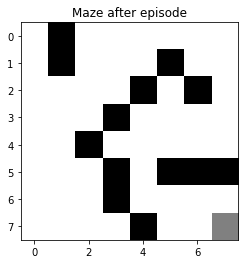

Epoch: 272/999 | Loss: 0.0004 | Episodes: 273 | Win count: 253 | Win rate: 1.000 | time: 65.17 minutes
Loss:  0.0005173108074814081
Loss:  0.00021845811352250166
Loss:  0.0002590619114926085
Loss:  0.0006611265998799354
Loss:  0.0005961129500064999
Loss:  0.00037544719816651195
Loss:  0.00044607419113162905
Loss:  0.0004135608905926347
Loss:  0.0003770040057133883
Loss:  0.0007158329244703054
Loss:  0.0003593622750486247
Loss:  0.0003751709155039862
Loss:  0.0006068956936360337
Loss:  0.00021357863442972302
Loss:  0.00022436535073211417
Loss:  0.0003270669694757089
Loss:  0.0004909426788799465
Loss:  0.0005726695235352963
Loss:  0.0004449675907380879
Loss:  0.0001302939563174732
Loss:  0.00031725088774692267
Loss:  0.0003403957234695554
Loss:  0.0005725858791265637
Loss:  0.00022024665668141097
Loss:  0.0006531704711960629
Loss:  0.00029275473207235336
Loss:  0.0005541277641896158
Loss:  0.0005785806279163808
Loss:  0.0005354990571504459


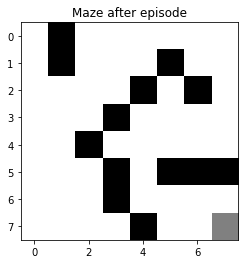

Epoch: 273/999 | Loss: 0.0005 | Episodes: 274 | Win count: 254 | Win rate: 1.000 | time: 65.35 minutes
Loss:  0.00039282944635488093
Loss:  0.0005888927553314716
Loss:  0.0004466105092433281
Loss:  0.0009451824589632452
Loss:  0.0007734755927231163
Loss:  0.00044067189446650445
Loss:  0.0003268928630859591
Loss:  0.000994190719211474
Loss:  0.00017144354205811396
Loss:  0.00032603152794763446
Loss:  0.0003743954293895513
Loss:  0.00043114063737448305
Loss:  0.00039756564365234226
Loss:  0.0003978875247412361
Loss:  0.00014082276175031438


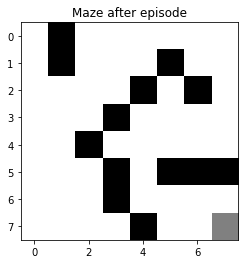

Epoch: 274/999 | Loss: 0.0001 | Episodes: 275 | Win count: 255 | Win rate: 1.000 | time: 65.45 minutes
Loss:  0.0003228829300496727
Loss:  0.0003046594574698247
Loss:  0.0006765900470782071
Loss:  0.0004937953781336546
Loss:  0.000544654467375949
Loss:  0.000523961687576957
Loss:  0.00039765099063515663
Loss:  0.0003956646251026541
Loss:  0.0008786625694483519
Loss:  0.0008070117328315973
Loss:  0.0006643995584454387
Loss:  0.0003617503243731335
Loss:  0.0002775030843622517


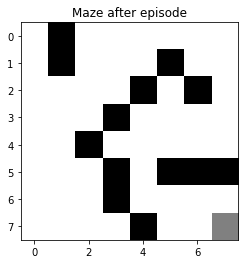

Epoch: 275/999 | Loss: 0.0003 | Episodes: 276 | Win count: 256 | Win rate: 1.000 | time: 65.53 minutes
Loss:  0.000705782586010173
Loss:  0.0003683694085339084
Loss:  0.0004867401148658246
Loss:  0.00040991911373566836
Loss:  0.0005004881677450612
Loss:  0.0006026950723025948
Loss:  0.0008000559755600989
Loss:  0.0006753569468855858
Loss:  0.0004468224651645869
Loss:  0.0003352871717652306
Loss:  0.00037105065712239593
Loss:  0.00022336609254125506
Loss:  0.00026946845900965855
Loss:  0.00032972972257994115
Loss:  0.0003461978485574946
Loss:  0.0005908347811782733
Loss:  0.0004115439660381526
Loss:  0.000801870453869924
Loss:  0.0003723183908732608
Loss:  0.00024650128034409136
Loss:  0.00035117255902150646
Loss:  0.00029798620380461216
Loss:  0.0004937333869747818
Loss:  0.0001301740121562034
Loss:  0.00010500762255105656
Loss:  0.0006898315623402596
Loss:  0.0004913406883133575
Loss:  0.000543847621884197
Loss:  0.000269937350822147
Loss:  0.0006379433907568455
Loss:  0.0004159265954

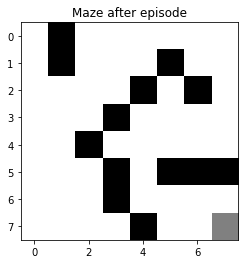

Epoch: 276/999 | Loss: 0.0004 | Episodes: 277 | Win count: 257 | Win rate: 1.000 | time: 65.75 minutes
Loss:  0.0002149447645933833
Loss:  0.00035166316956747323
Loss:  0.00024832264170981944
Loss:  0.00028765682509401813
Loss:  0.0008043879643082619
Loss:  0.000615274126175791
Loss:  0.0004521590599324554
Loss:  0.00021655875025317073
Loss:  0.00029633088706759736
Loss:  0.0004977124335709959
Loss:  0.00020416876213857904
Loss:  0.0003492339819786139
Loss:  0.0005650893144775182
Loss:  0.000432507207733579
Loss:  0.0005552162183448672
Loss:  0.0005633131659124047
Loss:  0.000814161539892666
Loss:  0.00041097319626715034
Loss:  0.0004590582102537155
Loss:  0.0003473120304988697
Loss:  0.00037524026265600696
Loss:  0.0001799115379981231
Loss:  0.00023950977629283443
Loss:  0.0007058807532303035
Loss:  0.0003615022142184898
Loss:  0.00046570011181756854
Loss:  0.0002527966280467808
Loss:  0.0002820295630954206
Loss:  0.0002958284458145499
Loss:  0.0003623453521868214
Loss:  9.37108852667

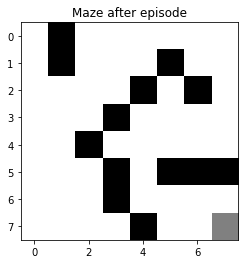

Epoch: 277/999 | Loss: 0.0005 | Episodes: 278 | Win count: 258 | Win rate: 1.000 | time: 65.95 minutes
Loss:  0.0003220512589905411
Loss:  0.00018562652257969603
Loss:  0.0009479967993684113
Loss:  0.0003809989138972014
Loss:  0.00041021293873200193
Loss:  0.00031602718081558123
Loss:  0.000854096288094297
Loss:  0.0004720785655081272
Loss:  0.00044242118019610643
Loss:  0.0007323173340409994
Loss:  0.0003919775626854971
Loss:  0.0006057907594367862
Loss:  0.00045497497194446623
Loss:  0.0004160838288953528
Loss:  0.0005658067238982767
Loss:  0.00015520333545282483
Loss:  8.417690332862549e-05
Loss:  0.00041887012775987387
Loss:  0.00011040710887755267


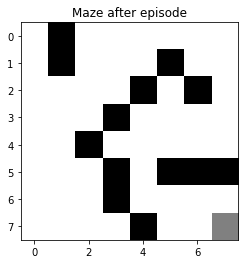

Epoch: 278/999 | Loss: 0.0001 | Episodes: 279 | Win count: 259 | Win rate: 1.000 | time: 66.06 minutes
Loss:  0.0005043870187364519
Loss:  0.0005589638167293742
Loss:  0.0006128707173047587
Loss:  0.0006963794585317373
Loss:  0.0003666107513708994
Loss:  0.0002563103917054832
Loss:  0.0004035373858641833
Loss:  0.00037041512405266985
Loss:  0.0006127576489234343
Loss:  0.0005945265875197947
Loss:  0.00038999461685307324
Loss:  0.00020174405653961003
Loss:  0.000232128248171648
Loss:  0.00023276371211977676
Loss:  0.00024640479387016967
Loss:  0.0008074259967543185
Loss:  0.000487255776533857
Loss:  0.0002422641555313021
Loss:  0.00017420156655134633
Loss:  0.00028985776589252055
Loss:  0.0003838978009298444
Loss:  0.0002253157799714245
Loss:  0.0005432998295873404
Loss:  0.00024218837643275037
Loss:  0.0006544887146446854
Loss:  0.0001923705858644098
Loss:  0.000805852614575997
Loss:  0.0006542416231241077
Loss:  0.0001669156990828924
Loss:  0.00042877421947196126
Loss:  0.000247343094

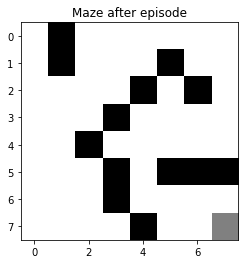

Epoch: 279/999 | Loss: 0.0002 | Episodes: 280 | Win count: 260 | Win rate: 1.000 | time: 66.25 minutes
Loss:  0.00046084554196568206
Loss:  0.00022590846128878184
Loss:  0.0005491299671120942
Loss:  0.00022198353326530196
Loss:  0.0004273266822565347
Loss:  0.00041807990055531263
Loss:  0.0007458985201083124
Loss:  0.00033565804187674075
Loss:  0.00048176558630075306
Loss:  0.00040266911673825234
Loss:  0.0003766738882404752
Loss:  0.00024461952125420794
Loss:  0.00027623183268588036
Loss:  0.00015261876251315698
Loss:  0.0002414180344203487
Loss:  0.0002707620515138842
Loss:  0.00015978223382262513
Loss:  0.00019465434525045566
Loss:  0.00033758216159185395
Loss:  0.0002711137076403247


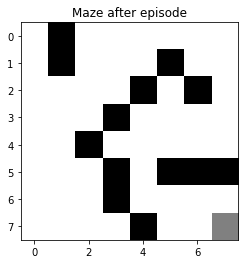

Epoch: 280/999 | Loss: 0.0003 | Episodes: 281 | Win count: 261 | Win rate: 1.000 | time: 66.38 minutes
Loss:  9.922737081069499e-05
Loss:  0.00033253843866987154
Loss:  7.230872506625019e-05
Loss:  0.0003164615045534447
Loss:  6.683305764454417e-05
Loss:  0.000505693256855011
Loss:  0.000239481647440698


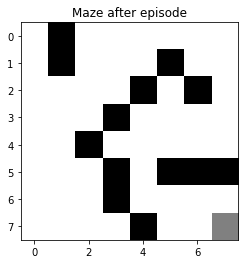

Epoch: 281/999 | Loss: 0.0002 | Episodes: 282 | Win count: 262 | Win rate: 1.000 | time: 66.42 minutes
Loss:  0.0002343508240301162
Loss:  0.00016892019993974827
Loss:  0.0003124659269815311
Loss:  0.0005368845304474235
Loss:  0.00021763253607787192
Loss:  0.00012086259812349454
Loss:  0.00030320720543386415
Loss:  0.00014384064706973732
Loss:  0.000343086379871238
Loss:  0.0004360870225355029
Loss:  0.00033003059797920287
Loss:  0.0003187051734130364
Loss:  0.0003194119199179113
Loss:  0.00059405347565189
Loss:  0.0005689601675840095
Loss:  0.0004556224375846796
Loss:  0.0004636262747226283
Loss:  0.0003893489483743906
Loss:  0.0004824774223379791
Loss:  0.0005538893165066838
Loss:  0.00022573163732886314
Loss:  0.0003290757886134088
Loss:  0.0002480636721884366
Loss:  0.0001236719253938645
Loss:  0.0002946260246972088
Loss:  0.00023188476916402578


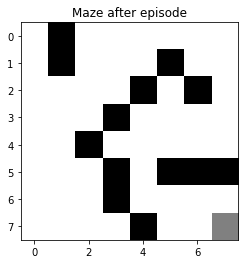

Epoch: 282/999 | Loss: 0.0002 | Episodes: 283 | Win count: 263 | Win rate: 1.000 | time: 66.55 minutes
Loss:  0.0002768736521829851
Loss:  9.449730350752361e-05
Loss:  0.0003091028238486615
Loss:  0.0003202900697942823
Loss:  0.0001926547265611589
Loss:  0.0002133804991899524
Loss:  0.0004763329779962078
Loss:  7.586484207422473e-05
Loss:  0.00032401070347987115
Loss:  0.00040511792758479714
Loss:  0.000306635738525074
Loss:  0.0004489462444325909
Loss:  0.00016279708142974414
Loss:  0.0003973642742494121
Loss:  0.0006225454562809318
Loss:  0.00045113981468603015
Loss:  0.00027339154621586204
Loss:  0.0003964881834690459
Loss:  0.00031005192431621253
Loss:  0.00011309853653074242
Loss:  0.00045434451021719724


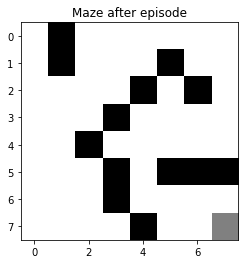

Epoch: 283/999 | Loss: 0.0005 | Episodes: 284 | Win count: 264 | Win rate: 1.000 | time: 1.11 hours
Loss:  0.00032667321647750214
Loss:  0.0003935555650969036


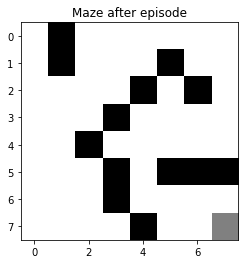

Epoch: 284/999 | Loss: 0.0004 | Episodes: 285 | Win count: 265 | Win rate: 1.000 | time: 1.11 hours
Loss:  0.0002995851100422442
Loss:  0.00016303562733810395
Loss:  0.0002740108084253734
Loss:  0.00026167342002736405
Loss:  0.00013390784806688316
Loss:  0.00019741754476854112


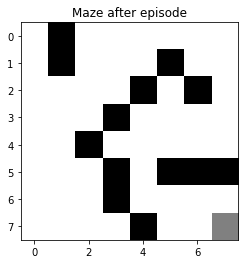

Epoch: 285/999 | Loss: 0.0002 | Episodes: 286 | Win count: 266 | Win rate: 1.000 | time: 1.11 hours
Loss:  0.00040022477332968265
Loss:  0.0001952167576746433
Loss:  0.0001320008304901421
Loss:  0.00023374033480649814
Loss:  0.00014434791955864057
Loss:  0.0004135204799240455
Loss:  0.000313253745844122
Loss:  0.00021015376842115074
Loss:  0.000224224197154399
Loss:  0.00015265008551068604
Loss:  9.656615293351933e-05
Loss:  0.0003801002458203584
Loss:  0.00035518763252184726
Loss:  0.0004995930212317035
Loss:  0.00031254957139026374
Loss:  9.109170059673488e-05
Loss:  8.596307088737376e-05
Loss:  0.00012143147250753827
Loss:  0.0002159158502763603
Loss:  0.0005507372989086434
Loss:  0.00022699939836456906
Loss:  0.00011001898747053929
Loss:  0.0003274557529948652
Loss:  0.0006466642080340534


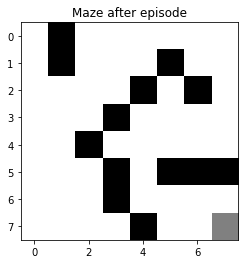

Epoch: 286/999 | Loss: 0.0006 | Episodes: 287 | Win count: 267 | Win rate: 1.000 | time: 1.11 hours
Loss:  0.00022495931625599042
Loss:  0.0002515798405511305
Loss:  0.0005425809868029319
Loss:  0.00029353760328376666
Loss:  0.0002925810404121876
Loss:  0.000301901363854995
Loss:  0.0003256687195971608
Loss:  0.0003488033835310489
Loss:  0.00028825580375269055
Loss:  0.0001884478988358751
Loss:  0.0003663657989818603
Loss:  0.00012129792594350874
Loss:  0.0003335848596179858
Loss:  0.00012846487516071647
Loss:  0.00030340876401169226
Loss:  8.827124293020461e-05
Loss:  0.00037069039535708725
Loss:  0.0004043798762722872
Loss:  0.0004329786461312324
Loss:  0.0005813073075842112
Loss:  0.00022447163064498454
Loss:  0.0004387972876429558
Loss:  0.000438819857663475
Loss:  0.00020221581326040905
Loss:  7.766138514853083e-05
Loss:  0.00036987310159020126
Loss:  0.00029351461125770584
Loss:  0.00036349977017380297
Loss:  0.000249767406785395
Loss:  0.00016287672042381018
Loss:  0.00010078037

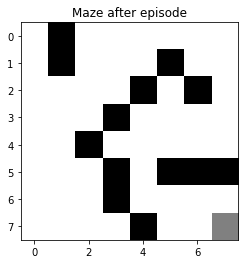

Epoch: 287/999 | Loss: 0.0002 | Episodes: 288 | Win count: 268 | Win rate: 1.000 | time: 1.12 hours
Loss:  0.000527576805325225
Loss:  0.0005593416281044483
Loss:  0.00034021508326986805


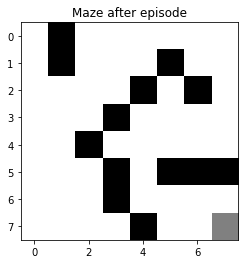

Epoch: 288/999 | Loss: 0.0003 | Episodes: 289 | Win count: 269 | Win rate: 1.000 | time: 1.12 hours
Loss:  0.0003491980314720422
Loss:  0.00023458644864149392
Loss:  0.00023219042486744002
Loss:  0.00022569665452465415
Loss:  0.0002980645513162017
Loss:  0.0004666187087423168
Loss:  0.00025536519387969747
Loss:  0.0001605724755791016
Loss:  0.0003828407061519101
Loss:  0.00021807808661833405
Loss:  0.00031270866020349786
Loss:  0.0001712241501081735
Loss:  0.0003552729031071067
Loss:  0.00011373618690413423
Loss:  0.0005004199992981739
Loss:  8.206538768718019e-05
Loss:  0.0003691621677717194
Loss:  0.00040887569048209116
Loss:  0.0002637982979649678
Loss:  0.00022580391669180244
Loss:  0.00046678575017722324
Loss:  9.056977432919666e-05
Loss:  0.00016859920287970454
Loss:  0.00019813308790617157
Loss:  0.0002987618063343689
Loss:  0.00024484867026330903
Loss:  0.00023892938042990863
Loss:  0.00025463539350312203
Loss:  0.00040202593663707376
Loss:  0.0004089742124051554


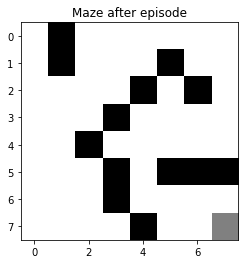

Epoch: 289/999 | Loss: 0.0004 | Episodes: 290 | Win count: 270 | Win rate: 1.000 | time: 1.12 hours
Loss:  0.00026227099442621693
Loss:  6.486027814389672e-05
Loss:  0.0002853754485840909
Loss:  0.00019830251403618604
Loss:  0.00022814947442384437


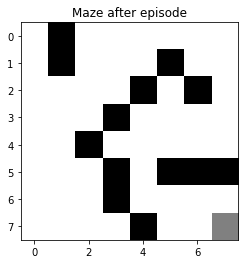

Epoch: 290/999 | Loss: 0.0002 | Episodes: 291 | Win count: 271 | Win rate: 1.000 | time: 1.12 hours
Loss:  0.00030520165455527604
Loss:  0.0002639054800965823
Loss:  0.0003311351320007816
Loss:  0.00024773593031568453
Loss:  0.00046626989205833524
Loss:  0.0002661005564732477
Loss:  0.0002944041625596583
Loss:  0.00021028421178925782
Loss:  0.00019651614275062457
Loss:  0.000458292372059077
Loss:  0.0002590596996014938
Loss:  0.00024756014317972586
Loss:  0.00039814326737541705
Loss:  0.000469055405119434
Loss:  0.00018834455113392323
Loss:  0.0005931676569161937
Loss:  0.0006584891234524548
Loss:  0.00024257337645394728
Loss:  7.611129331053235e-05
Loss:  0.0003005936014233157
Loss:  0.00021102591563249007
Loss:  0.00046180739809642546
Loss:  0.000414038251619786
Loss:  0.00027372643671697006
Loss:  0.00026281861210009083
Loss:  0.0005288736829243135
Loss:  0.00038083400431787595
Loss:  0.0004201293413643725
Loss:  0.00015166051889536902
Loss:  0.0001861369273683522
Loss:  0.000415247

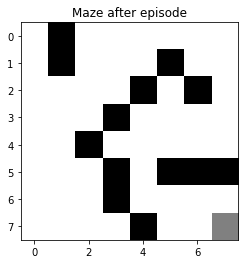

Epoch: 291/999 | Loss: 0.0002 | Episodes: 292 | Win count: 272 | Win rate: 1.000 | time: 1.12 hours
Loss:  6.361450869007967e-05
Loss:  0.00020711593970190734
Loss:  0.00017258308071177453
Loss:  0.0001284300578845432
Loss:  0.0008035262289922684
Loss:  0.00023466176207875833
Loss:  0.00012317532673478127


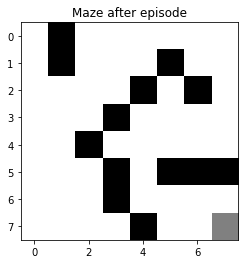

Epoch: 292/999 | Loss: 0.0001 | Episodes: 293 | Win count: 273 | Win rate: 1.000 | time: 1.13 hours
Loss:  0.0002606954949442297
Loss:  0.0001029355207720073


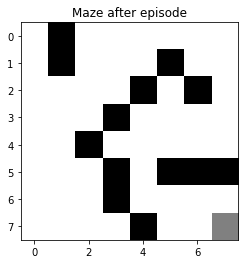

Epoch: 293/999 | Loss: 0.0001 | Episodes: 294 | Win count: 274 | Win rate: 1.000 | time: 1.13 hours
Loss:  6.259001202124637e-05
Loss:  0.0001366018841508776
Loss:  0.0003362182469572872
Loss:  0.000457527072285302
Loss:  0.0005075524240965024
Loss:  0.00014341536007123068
Loss:  0.0003827157779596746
Loss:  0.00036299777275417
Loss:  0.0002281880224472843
Loss:  6.197307448019274e-05
Loss:  0.0006590193515876308
Loss:  0.0005572246736846864
Loss:  0.0005367821722757071
Loss:  0.00041612753921072
Loss:  0.0004926966648781672
Loss:  0.0004340337618486956
Loss:  0.0002587945928098634
Loss:  0.0002488863101461902
Loss:  0.0006003036396577954
Loss:  0.0004940235958201811
Loss:  0.0004214905056869611
Loss:  0.00021432582434499636
Loss:  0.00020124364164075814
Loss:  0.0006162113568279892
Loss:  0.00043517402082215995
Loss:  0.000709768632077612


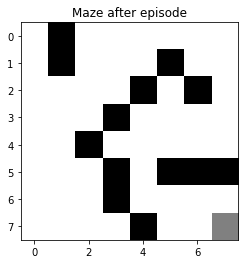

Epoch: 294/999 | Loss: 0.0007 | Episodes: 295 | Win count: 275 | Win rate: 1.000 | time: 1.13 hours
Loss:  0.00027373269767849706
Loss:  5.739942571381107e-05
Loss:  0.00022739587802789174
Loss:  0.0006803087890148163
Loss:  0.00015097245341166854
Loss:  0.000457619215012528
Loss:  0.0002635234413901344
Loss:  0.00031577776826452464
Loss:  0.0003541401238180697
Loss:  0.0002488294121576473
Loss:  0.00020733706332975999
Loss:  0.0002523410876165144
Loss:  0.00014248918887460604
Loss:  0.0005668213998433203
Loss:  0.0006384655716829002
Loss:  0.0005055892106611282
Loss:  0.0004154025300522335
Loss:  0.00039327581180259585
Loss:  0.0006383834115695208
Loss:  0.0005049012834206223
Loss:  0.0003653356252470985
Loss:  0.00010742844096967019
Loss:  0.00023612760742253158
Loss:  7.048936458886601e-05
Loss:  0.000511844817083329
Loss:  0.0003325261059217155
Loss:  0.0004059331549797207
Loss:  0.00045696302549913526


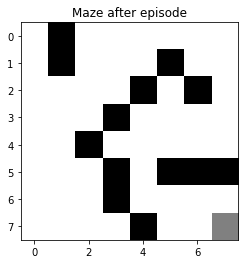

Epoch: 295/999 | Loss: 0.0005 | Episodes: 296 | Win count: 276 | Win rate: 1.000 | time: 1.13 hours
Loss:  0.00010329737779102288
Loss:  0.0001962897240446182
Loss:  0.00039990236109588295
Loss:  0.0002251763089589076
Loss:  0.00048337226326111704
Loss:  0.0005179253057576716
Loss:  0.00041150368269882165
Loss:  0.00011522693603183143
Loss:  0.0003692412137752399


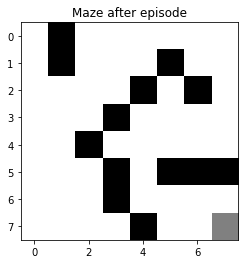

Epoch: 296/999 | Loss: 0.0004 | Episodes: 297 | Win count: 277 | Win rate: 1.000 | time: 1.13 hours
Loss:  0.0005123295777593739
Loss:  0.00025036230363184586
Loss:  0.0002143411329598166
Loss:  0.0002465156721882522
Loss:  0.0005994922539684922
Loss:  0.0005309305124683306
Loss:  0.00015766294382046908
Loss:  0.00026440632063895464
Loss:  0.00020898621005471796
Loss:  0.00026222858286928385
Loss:  0.000765204313211143
Loss:  0.0005360219802241772
Loss:  0.0002688290478545241
Loss:  0.0002566150069469586
Loss:  0.00028414720509317704
Loss:  0.0004639724938897416
Loss:  0.0005504089058376849
Loss:  0.0002857429499272257
Loss:  0.0002773408341454342
Loss:  0.0004066578403580934
Loss:  0.0006097712030168623
Loss:  0.0009379166876897216
Loss:  0.0005273792194202542
Loss:  0.00019731758220586926
Loss:  0.0003310457614134066
Loss:  0.00032421256764791906
Loss:  0.00019412915571592748
Loss:  0.000576122576603666


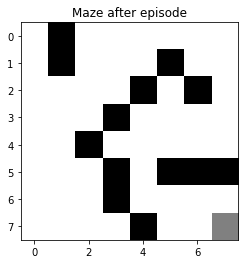

Epoch: 297/999 | Loss: 0.0006 | Episodes: 298 | Win count: 278 | Win rate: 1.000 | time: 1.14 hours
Loss:  0.00011036184514523484
Loss:  0.0005492322088684887
Loss:  0.00018798747987602837
Loss:  0.0003109550743829459
Loss:  0.00019355057884240523
Loss:  0.00043351353087928146
Loss:  0.00024859745462890714
Loss:  0.0003088872254011221
Loss:  0.00024894773378036916
Loss:  0.00045043101999908686
Loss:  0.0002794462998281233
Loss:  0.0003925803321180865
Loss:  0.0002758878472377546
Loss:  0.0005909974570386112
Loss:  0.0003863340534735471
Loss:  0.0001449616756872274
Loss:  0.00016975559265119955
Loss:  0.00023255198902916163
Loss:  0.00042600018059602007
Loss:  0.0002510226840968244
Loss:  0.00018348117555433419
Loss:  0.0007242557185236365
Loss:  0.00021391076734289527
Loss:  0.0004668820329243317
Loss:  0.0003270614688517526
Loss:  0.0004271498473826796
Loss:  0.00014206096057023387
Loss:  0.0004588558367686346
Loss:  0.0004732465858978685
Loss:  0.0003047921709367074
Loss:  0.00037306

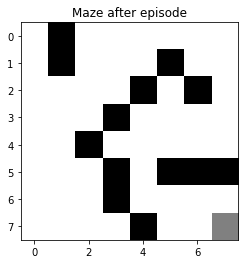

Epoch: 298/999 | Loss: 0.0004 | Episodes: 299 | Win count: 279 | Win rate: 1.000 | time: 1.14 hours
Loss:  0.000379561199224554
Loss:  0.000248994430876337
Loss:  0.0001206372253363952
Loss:  0.00040055975841823965
Loss:  0.0003186695685144514
Loss:  0.0006282043032115325
Loss:  0.0004686803004005924
Loss:  0.0001829902539611794
Loss:  0.0004907642723992467


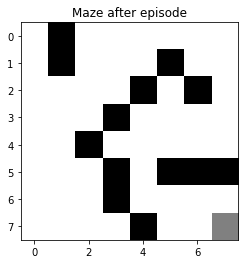

Epoch: 299/999 | Loss: 0.0005 | Episodes: 300 | Win count: 280 | Win rate: 1.000 | time: 1.14 hours
Loss:  0.000638918369077146
Loss:  0.000409268366638571
Loss:  0.0006253107276279479
Loss:  0.0004509960599534679
Loss:  0.0003099017048953101
Loss:  0.00046772432688158005
Loss:  0.0002588947863841895
Loss:  0.0002502192364772782
Loss:  0.0006706644780933857
Loss:  0.00038799458707217127
Loss:  0.0005307744140736759
Loss:  0.0006386957029462792
Loss:  0.0004382113984320313
Loss:  0.0003222164377802983
Loss:  0.0004563917900668457
Loss:  0.00026721844187704846
Loss:  0.0004503696254687384
Loss:  0.0004945012915413827
Loss:  0.0001566349164932035
Loss:  8.764233643887565e-05
Loss:  0.00015852722935960628
Loss:  0.000768938334658742
Loss:  0.0006189732812345028
Loss:  0.0005488450842676684
Loss:  0.0004028363910038024
Loss:  0.00046865186595823616
Loss:  0.0003923853364540264
Loss:  0.00032744620693847537
Loss:  0.0008201820310205221
Loss:  0.00013578518701251596


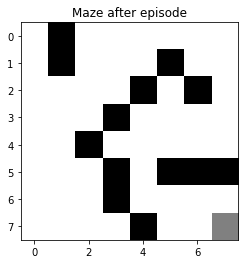

Epoch: 300/999 | Loss: 0.0001 | Episodes: 301 | Win count: 281 | Win rate: 1.000 | time: 1.14 hours
Loss:  0.0003569930559024215
Loss:  0.0007354072586167604
Loss:  0.00015538518709945492
Loss:  0.00047871847345959395
Loss:  0.0003361350827617571
Loss:  0.00039559585275128484
Loss:  0.0001673041479079984
Loss:  0.00015257066843332723
Loss:  0.0004019368643639609
Loss:  0.0003758008824661374
Loss:  0.0005818324279971421
Loss:  0.0007845389191061258
Loss:  0.0002388152206549421
Loss:  0.00037206386332400143
Loss:  0.0004899726482108235
Loss:  0.00048022440751083195
Loss:  0.00047360124881379306
Loss:  0.0002585726688266732
Loss:  0.00027159552701050416
Loss:  0.00045264061191119254
Loss:  0.0005814684845972806
Loss:  0.00029921875102445483
Loss:  5.669458732882049e-05
Loss:  0.00024065724574029446
Loss:  0.00029497549985535443
Loss:  0.0004695923416875303
Loss:  0.0005126421456225216


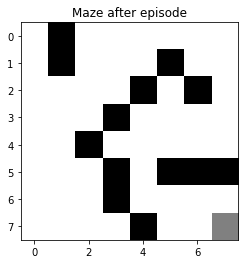

Epoch: 301/999 | Loss: 0.0005 | Episodes: 302 | Win count: 282 | Win rate: 1.000 | time: 1.14 hours
Loss:  0.00010885835945373401
Loss:  0.0005703724164050072
Loss:  0.00044923230598215014
Loss:  0.0003577374081942253
Loss:  0.00042224087519571185
Loss:  0.000360433230525814
Loss:  0.0002824488256010227
Loss:  9.899616634356789e-05
Loss:  0.0006455295660998672
Loss:  0.00016965646500466391
Loss:  0.0007947574486024678


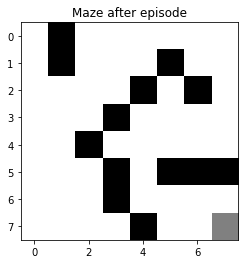

Epoch: 302/999 | Loss: 0.0008 | Episodes: 303 | Win count: 283 | Win rate: 1.000 | time: 1.15 hours
Loss:  0.00038794975262135267
Loss:  0.0003998762840637937
Loss:  0.00041229737689718604
Loss:  0.0003316870643175207
Loss:  0.0004997215291950852
Loss:  8.086279558483511e-05
Loss:  0.00048513623187318444
Loss:  0.0004230612830724567
Loss:  0.00036395107599673793
Loss:  0.0006562885828316212
Loss:  0.00024424124421784654
Loss:  0.0003148317482555285
Loss:  0.0003200416249455884
Loss:  0.0002073070063488558
Loss:  0.0004066847832291387
Loss:  0.00041841118945740163
Loss:  0.00022972095757722855
Loss:  0.00013659329124493524
Loss:  0.00018735695630311966
Loss:  0.00043763483699876815
Loss:  0.000647666267468594
Loss:  0.00019113078087684698
Loss:  0.00042681382910814136
Loss:  0.000603667605901137
Loss:  0.0006576094019692391


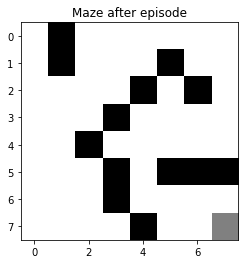

Epoch: 303/999 | Loss: 0.0007 | Episodes: 304 | Win count: 284 | Win rate: 1.000 | time: 1.15 hours
Loss:  0.0007157165673561394
Loss:  9.657118789618835e-05
Loss:  0.0006619531195610762
Loss:  0.0006747171864844859
Loss:  0.00032930589804891497


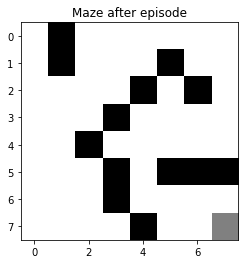

Epoch: 304/999 | Loss: 0.0003 | Episodes: 305 | Win count: 285 | Win rate: 1.000 | time: 1.15 hours
Loss:  0.00042259201291017234
Loss:  0.00012870283171650954
Loss:  0.00023586468523717485
Loss:  0.0009688674763310701
Loss:  0.00046084880887065083
Loss:  0.00022424049529945478
Loss:  0.00039535464020445943
Loss:  0.00028136864420957863
Loss:  0.0005291971028782427
Loss:  0.0004172026237938553
Loss:  0.0005472057673614472
Loss:  0.0006092546827858314
Loss:  0.00025524806551402435
Loss:  0.00034514101571403444
Loss:  0.00029921332316007465
Loss:  0.0002516306849429384
Loss:  0.0005578346172114834
Loss:  0.00022610134328715503
Loss:  0.00023485726705985144
Loss:  0.00045379274524748325
Loss:  0.00038344024505931884
Loss:  0.0003958353045163676
Loss:  0.00029811756394337863
Loss:  0.0003273163456469774
Loss:  0.00039925151941133663
Loss:  0.00019707166211446747


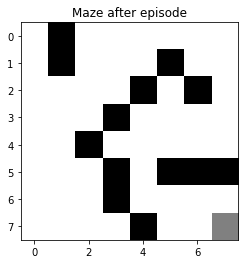

Epoch: 305/999 | Loss: 0.0002 | Episodes: 306 | Win count: 286 | Win rate: 1.000 | time: 1.15 hours
Loss:  0.000244823626417201
Loss:  0.0004674177907872945
Loss:  0.00042633470002328977
Loss:  0.0003985782677773386
Loss:  0.0003642359224613756
Loss:  0.0003109201898041647
Loss:  4.9917641263164114e-05
Loss:  0.0002793353887682315
Loss:  0.00035281016607768834
Loss:  0.0005720861372537911
Loss:  0.0007155582716222852
Loss:  0.00038039509672671556
Loss:  0.0005357178742997348
Loss:  0.0004218245012452826
Loss:  0.0002142025186913088
Loss:  0.0004932496813125908
Loss:  0.00043416867265477777
Loss:  0.00028762904184986837


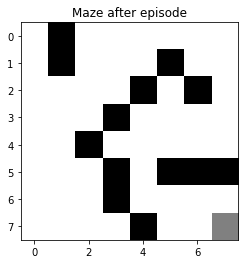

Epoch: 306/999 | Loss: 0.0003 | Episodes: 307 | Win count: 287 | Win rate: 1.000 | time: 1.15 hours
Loss:  0.0002722009230637923
Loss:  0.0003947050208807923
Loss:  0.0006062472821213305
Loss:  0.00040267003350891173
Loss:  0.00019827045616693795
Loss:  0.0003449391224421561
Loss:  0.00026721187896328047
Loss:  0.000281835556961596
Loss:  0.00011991642531938851
Loss:  0.00014659951921203174
Loss:  0.0006069312803447247
Loss:  0.0006140662007965147
Loss:  0.0006487994105555117
Loss:  0.00037343191797845066
Loss:  0.00038166580634424463


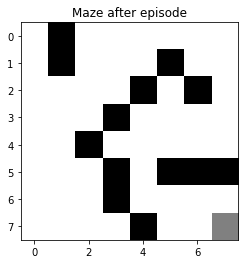

Epoch: 307/999 | Loss: 0.0004 | Episodes: 308 | Win count: 288 | Win rate: 1.000 | time: 1.15 hours
Loss:  0.0003269059816375375
Loss:  0.00032684959296602756
Loss:  0.0007664394215680659
Loss:  0.00024307096464326605
Loss:  0.00041956732457038015
Loss:  0.0001545652667118702
Loss:  0.00041307554056402296
Loss:  0.0005006634019082412
Loss:  0.0003645684337243438
Loss:  0.0005039767565904185
Loss:  0.0006534521235153079
Loss:  0.0003787550376728177
Loss:  0.00033627296215854585
Loss:  7.135860505513847e-05
Loss:  0.00035097782529192045
Loss:  0.00022174492551130243
Loss:  0.0006247854325920343
Loss:  0.00020951653641532175
Loss:  0.0002421162153041223
Loss:  0.00016653195052640513
Loss:  0.00028176816704217345
Loss:  0.0003765131114050746
Loss:  0.00021032592121628113
Loss:  0.00017634273535804823
Loss:  0.0003110449433734175
Loss:  0.000229641271289438
Loss:  0.0001772962641553022
Loss:  0.0005189171642996371
Loss:  0.00026169388729613274
Loss:  9.337934534414671e-05
Loss:  0.000375708

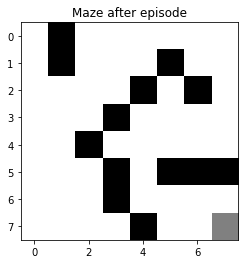

Epoch: 308/999 | Loss: 0.0004 | Episodes: 309 | Win count: 289 | Win rate: 1.000 | time: 1.16 hours
Loss:  0.00023614463862031698
Loss:  0.0002928168614744209
Loss:  0.00039153636316768825
Loss:  0.0002505576267139986
Loss:  0.0001871359345386736


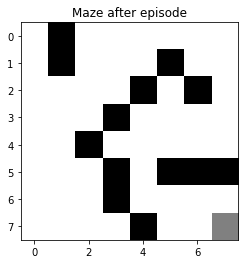

Epoch: 309/999 | Loss: 0.0002 | Episodes: 310 | Win count: 290 | Win rate: 1.000 | time: 1.16 hours
Loss:  0.0001826319276005961
Loss:  7.70538390497677e-05
Loss:  0.00045444772695191205
Loss:  0.00020157394465059042
Loss:  0.0003753915516426787
Loss:  0.0003183535700372886
Loss:  0.00023978424724191427
Loss:  0.0010039592743851244
Loss:  0.0006099191523389891
Loss:  0.0004886826573056169
Loss:  0.00030356866045622155
Loss:  0.00043001452286262065
Loss:  0.0005704803043045104
Loss:  0.0003973434359068051
Loss:  0.000546629074960947
Loss:  0.0004223587420710828
Loss:  0.0001505340333096683
Loss:  0.0002691644331207499
Loss:  0.0005993417944409885
Loss:  0.00034002163738477975
Loss:  0.000666199644911103
Loss:  0.00045122712617740035
Loss:  0.00047671928768977523
Loss:  0.00023750674881739542
Loss:  0.0005054000357631594
Loss:  0.00019799640722339973
Loss:  0.0002643538173288107
Loss:  0.0005865253624506295
Loss:  0.000577811173570808
Loss:  0.0005293231952236965
Loss:  0.000388270535040

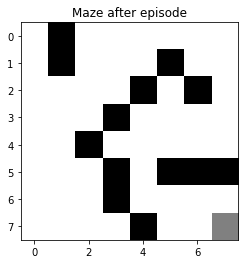

Epoch: 310/999 | Loss: 0.0005 | Episodes: 311 | Win count: 291 | Win rate: 1.000 | time: 1.16 hours
Loss:  0.00021961572565487586
Loss:  0.0005291066481731832
Loss:  0.0004670548514695838
Loss:  0.0004176635411567986
Loss:  0.00014763077342649922
Loss:  0.0002072268252959475
Loss:  0.0005152987141627818
Loss:  0.00031115680758375674
Loss:  0.0009525627829134464
Loss:  0.00047877509496174753
Loss:  0.0005290200788294896
Loss:  0.0007160901441238821
Loss:  0.00024784828565316275
Loss:  0.0003136931554763578
Loss:  0.00021471900981850922
Loss:  0.0004786039353348315
Loss:  0.000345760490745306
Loss:  0.00033310407889075577
Loss:  0.0003444385656621307
Loss:  0.0002897094891523011
Loss:  0.000280242195003666
Loss:  0.0009433897794224322
Loss:  0.0009321901598013937
Loss:  0.00041148091258946806


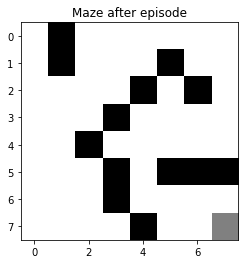

Epoch: 311/999 | Loss: 0.0004 | Episodes: 312 | Win count: 292 | Win rate: 1.000 | time: 1.16 hours
Loss:  0.0006917928112670779
Loss:  0.00041677968692965806
Loss:  0.00018528102373238653
Loss:  0.0002245254654553719
Loss:  0.00026422098380862735
Loss:  0.0002652985567692667
Loss:  0.0003858255367958918
Loss:  0.0002481040428392589


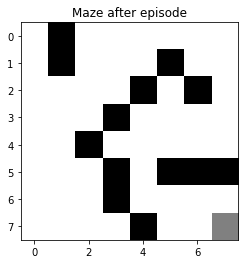

Epoch: 312/999 | Loss: 0.0002 | Episodes: 313 | Win count: 293 | Win rate: 1.000 | time: 1.16 hours
Loss:  0.0002567766059655696
Loss:  0.00030647953099105507
Loss:  0.0002678401142475195
Loss:  0.0006141410558484495
Loss:  0.0005821282684337348
Loss:  0.00045804846740793437
Loss:  0.0003082114417338744
Loss:  0.0007443143986165524
Loss:  0.00034359513665549457
Loss:  0.0003928156802430749
Loss:  0.0004633335774997249
Loss:  0.0001985126618819777
Loss:  9.339162716059946e-05
Loss:  0.0004661957500502467
Loss:  0.0004588097217492759


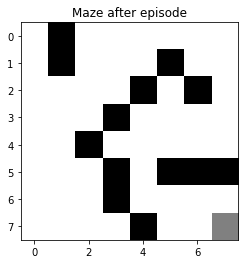

Epoch: 313/999 | Loss: 0.0005 | Episodes: 314 | Win count: 294 | Win rate: 1.000 | time: 1.16 hours
Loss:  0.00036314703174866736
Loss:  0.0004190113249933347
Loss:  0.00016874920765985735
Loss:  0.0006957790174055845
Loss:  0.0003897861752193421
Loss:  0.00039145603659562767
Loss:  0.0002541561880207155
Loss:  0.00039829670276958495
Loss:  0.00022753326629754156
Loss:  5.391345257521607e-05
Loss:  0.0006657482590526342
Loss:  0.00017547795141581446


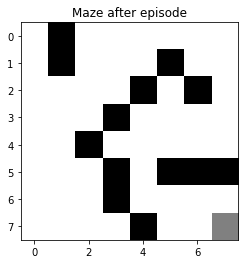

Epoch: 314/999 | Loss: 0.0002 | Episodes: 315 | Win count: 295 | Win rate: 1.000 | time: 1.17 hours
Loss:  0.00035051655140705407
Loss:  0.0002662140250322409
Loss:  0.0001551030763948802
Loss:  0.00019638817866507452
Loss:  0.00021092047973070294
Loss:  0.00040738632378634065
Loss:  0.00013997563655721024
Loss:  0.00031023054907564074
Loss:  0.00016734255041228607
Loss:  0.00042712956201285124
Loss:  0.0003259666082158219
Loss:  0.00041191202763002366
Loss:  0.00016209398745559156
Loss:  9.366915583086666e-05
Loss:  0.0005566772888414562
Loss:  0.00026709552184911445
Loss:  0.0004054676537634805


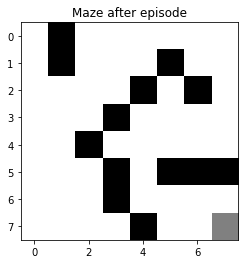

Epoch: 315/999 | Loss: 0.0004 | Episodes: 316 | Win count: 296 | Win rate: 1.000 | time: 1.17 hours
Loss:  0.0002108776716340799
Loss:  0.00023726736617390998
Loss:  0.0004281004148651846
Loss:  0.00012306250573601574
Loss:  0.00032239159190794453
Loss:  0.0005140725988894701
Loss:  0.0003374142397660762
Loss:  0.0004245042218826711
Loss:  9.069155021279585e-05
Loss:  0.0003282783945905976
Loss:  0.00045716723252553493
Loss:  0.00041992400656454265
Loss:  0.0004860240369453095
Loss:  0.0002623459222377278
Loss:  0.0002302798820892349
Loss:  0.0004172204717178829
Loss:  0.0006113680137787014
Loss:  0.00045338871495914645
Loss:  0.00045913788926554844
Loss:  0.0005796519544674084
Loss:  0.00021275842300383374
Loss:  0.00044311859528534114
Loss:  0.0002096355692629004


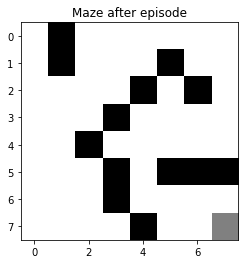

Epoch: 316/999 | Loss: 0.0002 | Episodes: 317 | Win count: 297 | Win rate: 1.000 | time: 1.17 hours
Loss:  0.0002231792386737652
Loss:  0.00022461876869783737
Loss:  0.0005815745098516345
Loss:  0.0002929974507424049
Loss:  0.00026803054788615555
Loss:  0.0003114470891887322
Loss:  0.00028698271489702165
Loss:  0.0005061401898274198
Loss:  0.00029577542409242596
Loss:  0.00037420488661155105
Loss:  0.0004307860945118591
Loss:  0.00034873226832132787
Loss:  7.409478712361306e-05
Loss:  0.0002800253641908057
Loss:  0.00014420098887057975
Loss:  0.000307569294818677
Loss:  0.00021149843632883858
Loss:  0.00010099041173816659
Loss:  0.00014151416326058097
Loss:  0.00031586996192345396
Loss:  0.0002516901076887734
Loss:  0.00019466992671368644
Loss:  0.0003317281953059137
Loss:  8.908079325919971e-05
Loss:  0.00016604436677880585
Loss:  0.0004376378929009661


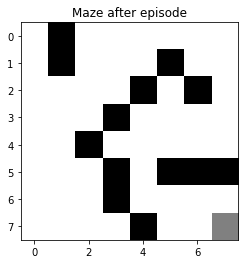

Epoch: 317/999 | Loss: 0.0004 | Episodes: 318 | Win count: 298 | Win rate: 1.000 | time: 1.17 hours
Loss:  0.000285125250229612
Loss:  0.00034757274988805875
Loss:  0.00022982624068390578
Loss:  0.0002762385120149702
Loss:  0.00021538487635552883


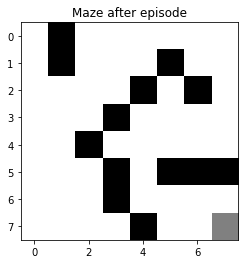

Epoch: 318/999 | Loss: 0.0002 | Episodes: 319 | Win count: 299 | Win rate: 1.000 | time: 1.17 hours
Loss:  0.0002529858975321986
Loss:  0.0006708130822516978
Loss:  0.00010928427946055308
Loss:  0.00045531970681622624
Loss:  0.00035596803354565054
Loss:  0.00020510808826657012
Loss:  0.00018210706184618175
Loss:  0.00020023263641633093


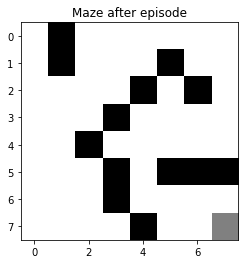

Epoch: 319/999 | Loss: 0.0002 | Episodes: 320 | Win count: 300 | Win rate: 1.000 | time: 1.17 hours
Loss:  0.00022687588352710009
Loss:  0.00024584823040640913
Loss:  5.476678779814392e-05
Loss:  5.7072447816608474e-05
Loss:  0.0002671682450454682
Loss:  0.0005206680507399142
Loss:  0.00020650057558668777
Loss:  0.0002833210601238534
Loss:  0.00022497841928270645


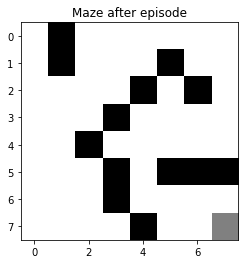

Epoch: 320/999 | Loss: 0.0002 | Episodes: 321 | Win count: 301 | Win rate: 1.000 | time: 1.18 hours
Loss:  0.0003205212706234306
Loss:  0.0003392901853658259
Loss:  0.00028200654560350813
Loss:  0.00014371533325174823
Loss:  4.797102155862376e-05


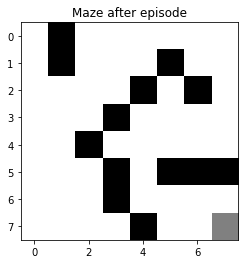

Epoch: 321/999 | Loss: 0.0000 | Episodes: 322 | Win count: 302 | Win rate: 1.000 | time: 1.18 hours
Loss:  0.0004010449774796143
Loss:  0.0001739468571031466
Loss:  0.00033318856731057167
Loss:  0.0006413402734324336
Loss:  0.00033300463837804273
Loss:  0.00014315151747723576
Loss:  0.0003874323738273233
Loss:  0.00017944168212125078
Loss:  0.00017309058239334263
Loss:  0.000298164137348067
Loss:  0.0003993157879449427
Loss:  0.00024264519379357807
Loss:  7.669615843042266e-05
Loss:  0.00046249310253188014
Loss:  0.00022001026445650496
Loss:  0.00036758043279405683
Loss:  0.0003265505038143601
Loss:  0.0003653467028925661
Loss:  0.0005846168787684292
Loss:  0.00017442258831579238
Loss:  5.197735663386993e-05


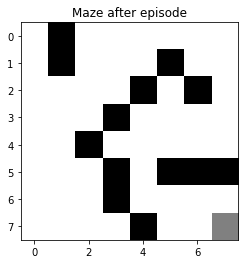

Epoch: 322/999 | Loss: 0.0001 | Episodes: 323 | Win count: 303 | Win rate: 1.000 | time: 1.18 hours
Loss:  0.00020553520153043792
Loss:  5.21484234923264e-05
Loss:  0.00010377719809184782
Loss:  0.0003724701964529231
Loss:  5.2284921366663184e-05
Loss:  0.0002119855889759492
Loss:  0.0005077198875369504
Loss:  0.000246268704358954
Loss:  0.000262521585682407
Loss:  0.0001626368066354189
Loss:  0.00017244807531824335
Loss:  0.0003818523255176842
Loss:  4.007649840787053e-05
Loss:  0.00016797464013507124
Loss:  0.00015428672122652642
Loss:  5.890282409382053e-05
Loss:  0.0004756833368446678
Loss:  0.00020583942387020215
Loss:  0.00020044606571900658
Loss:  8.782585427979939e-05
Loss:  0.00018804061437549535
Loss:  3.6513516533887014e-05
Loss:  0.00020232983661117032
Loss:  0.0001571324646647554
Loss:  0.0003775435034185648
Loss:  4.412483031046577e-05
Loss:  0.0005099569170852192
Loss:  0.0002695856928767171
Loss:  0.0004767177342728246


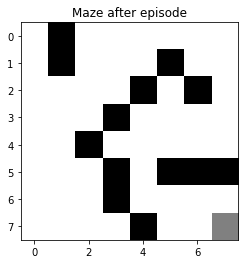

Epoch: 323/999 | Loss: 0.0005 | Episodes: 324 | Win count: 304 | Win rate: 1.000 | time: 1.18 hours
Loss:  0.00016056300228228793
Loss:  5.419181070465129e-05
Loss:  0.0002648914742167108
Loss:  0.00023171828070189804
Loss:  0.0002881983164115809
Loss:  7.786580681568012e-05
Loss:  7.871929301472846e-05
Loss:  0.00032480957452207804
Loss:  0.0001998060179175809
Loss:  9.322378718934488e-05
Loss:  0.00025083615037146956
Loss:  5.4544407248613425e-05
Loss:  0.00018978066145791672
Loss:  0.00045161294110585004
Loss:  0.00018192269999417476
Loss:  0.00015134025943552842
Loss:  2.2257589080254547e-05
Loss:  0.0004286147595848888
Loss:  0.0002132731315214187


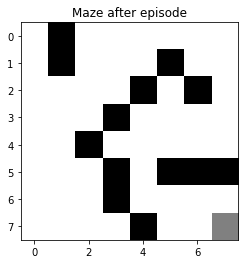

Epoch: 324/999 | Loss: 0.0002 | Episodes: 325 | Win count: 305 | Win rate: 1.000 | time: 1.18 hours
Loss:  0.00018646711396286264
Loss:  0.00015867080219322816
Loss:  0.00030924664315534756
Loss:  0.00026487098602956394
Loss:  0.00036838230153080076
Loss:  0.00011420338705647737
Loss:  0.00012246979167684913
Loss:  3.318639755889308e-05
Loss:  0.00029977734811836854
Loss:  0.0003750097457668744
Loss:  0.00018758750229608268
Loss:  0.0003882329910993576
Loss:  0.00023415240866597742
Loss:  0.000491570150188636
Loss:  6.940306047908962e-05
Loss:  0.00019759731367230415
Loss:  9.630164640839212e-05
Loss:  0.00032854676828719676
Loss:  0.00039126113551901653
Loss:  7.324139369302429e-05
Loss:  0.000579584069782868
Loss:  0.0005323348304955289
Loss:  0.0002626787099870853
Loss:  0.00025808978534769267
Loss:  0.00010679631850507576
Loss:  0.0004525627300608903
Loss:  0.00025760705648281146


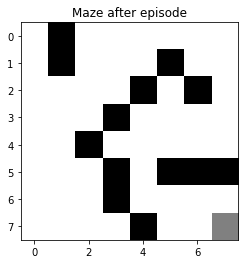

Epoch: 325/999 | Loss: 0.0003 | Episodes: 326 | Win count: 306 | Win rate: 1.000 | time: 1.19 hours
Loss:  0.0003528378911141772
Loss:  0.00015645117673557252
Loss:  0.0002610215451568365
Loss:  0.00015978931605786784
Loss:  9.575512740411796e-05
Loss:  0.00019249987690272974
Loss:  0.0003742484550457448
Loss:  6.716939606121741e-05
Loss:  0.000320750055834651
Loss:  0.0002544422422943171
Loss:  3.660940819827374e-05
Loss:  0.0006351720367092639
Loss:  0.00035478312929626554
Loss:  0.0003666151169454679
Loss:  8.585057366872206e-05
Loss:  0.0005837531061843038
Loss:  0.0001135681195592042
Loss:  0.00030378576775547117
Loss:  0.0003229674985050224
Loss:  0.00013065835810266435
Loss:  0.0002506492819520645
Loss:  0.00014881358947604895
Loss:  0.0002883929555537179
Loss:  0.00020901699099340476
Loss:  2.9093289413140155e-05


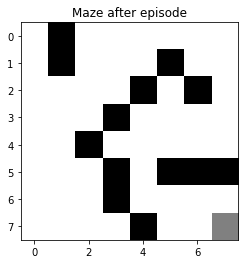

Epoch: 326/999 | Loss: 0.0000 | Episodes: 327 | Win count: 307 | Win rate: 1.000 | time: 1.19 hours
Loss:  0.00018659399574971758
Loss:  0.0003403156479180325
Loss:  0.0003668393474072218
Loss:  0.0005190751689951867
Loss:  0.0002497567911632359
Loss:  0.0004047303518746048
Loss:  8.234906636062078e-05
Loss:  7.551996895927005e-05
Loss:  4.798452937393449e-05
Loss:  0.00027397277881391346
Loss:  0.00027212021996092517
Loss:  0.000238194661505986
Loss:  0.00017214821309607942
Loss:  4.985904161003418e-05
Loss:  0.00028790394208044745
Loss:  0.00016109739954117686
Loss:  0.0002192973861383507
Loss:  8.693638301338069e-05
Loss:  5.879361560801044e-05
Loss:  0.00039574087350047193
Loss:  0.0002849918237188831
Loss:  5.9483640143298544e-05
Loss:  0.00036197346707922406
Loss:  9.101124669541605e-05


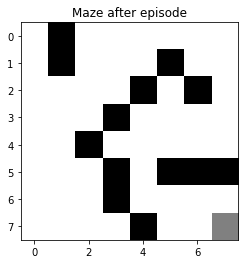

Epoch: 327/999 | Loss: 0.0001 | Episodes: 328 | Win count: 308 | Win rate: 1.000 | time: 1.19 hours
Loss:  0.00018839159747585654
Loss:  5.1457653171382844e-05
Loss:  0.00027384622080717236
Loss:  9.693983702163678e-05
Loss:  6.281031346588861e-05


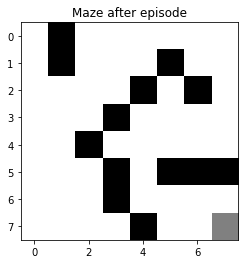

Epoch: 328/999 | Loss: 0.0001 | Episodes: 329 | Win count: 309 | Win rate: 1.000 | time: 1.19 hours
Loss:  8.476629955112003e-05
Loss:  0.0005308862964739092
Loss:  0.0004144228660152294
Loss:  0.00016811591922305524
Loss:  0.00011825619731098413
Loss:  3.775005279749166e-05
Loss:  0.0002492118974259938
Loss:  9.083943223231472e-05
Loss:  6.685703920084052e-05
Loss:  0.00020398059314175043
Loss:  0.00017310890325461514
Loss:  8.340868953382596e-05


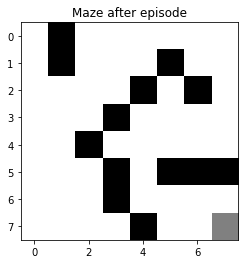

Epoch: 329/999 | Loss: 0.0001 | Episodes: 330 | Win count: 310 | Win rate: 1.000 | time: 1.19 hours
Loss:  0.00022747094772057608
Loss:  4.330318552092649e-05
Loss:  0.0003015957336174324
Loss:  0.00026151265774387866


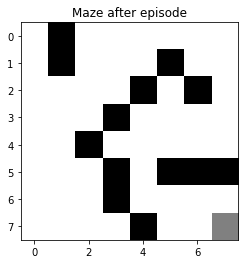

Epoch: 330/999 | Loss: 0.0003 | Episodes: 331 | Win count: 311 | Win rate: 1.000 | time: 1.19 hours
Loss:  0.0001869726984295994
Loss:  0.00011306225133012049
Loss:  9.094132838072255e-05
Loss:  0.0001228866403835127
Loss:  0.0004350158960733097
Loss:  0.00044733880713465624
Loss:  9.036255869432352e-05
Loss:  0.00018610421830089763
Loss:  4.185287980362773e-05
Loss:  9.797200618777424e-05
Loss:  3.11875937768491e-05
Loss:  0.00018301380623597652
Loss:  5.2092011628701584e-05
Loss:  4.674414776673075e-05
Loss:  0.00011637406532827299
Loss:  0.00024496245168847963
Loss:  7.054573325149249e-05
Loss:  0.00011175493636983447
Loss:  0.00018684400856727734
Loss:  0.00022866539075039327
Loss:  8.014216291485354e-05
Loss:  0.0002499682959751226
Loss:  2.0981130091968225e-05


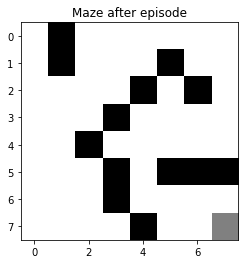

Epoch: 331/999 | Loss: 0.0000 | Episodes: 332 | Win count: 312 | Win rate: 1.000 | time: 1.19 hours
Loss:  5.328106817614753e-05
Loss:  0.000278273744697799
Loss:  4.8570605940767564e-05
Loss:  6.530228120027459e-06
Loss:  0.00030129442166071385
Loss:  0.00019477018395264167
Loss:  0.00022803292085882276
Loss:  0.0004352904943516478
Loss:  0.0002326220437680604


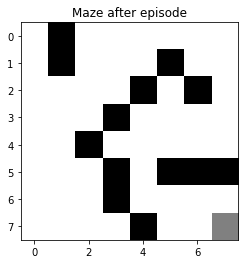

Epoch: 332/999 | Loss: 0.0002 | Episodes: 333 | Win count: 313 | Win rate: 1.000 | time: 1.20 hours
Loss:  8.384982356801629e-05
Loss:  0.00022557251213584095
Loss:  0.0001841214434534777
Loss:  0.0001666545867919922
Loss:  0.00029150030604796484
Loss:  0.00017386298895871732
Loss:  0.00015832899589440785
Loss:  0.00019028033057111315
Loss:  3.0005687222001143e-05
Loss:  0.00019256847190263215
Loss:  2.0557647530949907e-05
Loss:  0.00019955967036366928
Loss:  1.221197135237162e-05
Loss:  0.00038657606637571007
Loss:  5.599804353551008e-05
Loss:  2.9876726330257952e-05
Loss:  2.4396063963649794e-05
Loss:  0.00013914502233092207


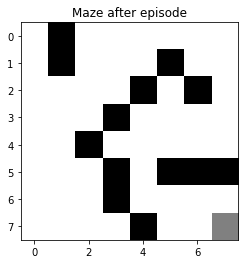

Epoch: 333/999 | Loss: 0.0001 | Episodes: 334 | Win count: 314 | Win rate: 1.000 | time: 1.20 hours
Loss:  9.321001834905474e-05
Loss:  0.000204919655516278
Loss:  5.0243939767824486e-05
Loss:  5.773735210823361e-05
Loss:  8.825307486404199e-05
Loss:  7.531681512773503e-05
Loss:  0.00011355989408912137
Loss:  4.052449367009103e-05
Loss:  5.820976730319671e-05
Loss:  0.00038206876706681214
Loss:  5.047490958531853e-05
Loss:  3.318648259664769e-05
Loss:  9.418489298695931e-06
Loss:  0.00024083554308163002
Loss:  0.00019534579951141495
Loss:  0.0003411311517993454
Loss:  3.4160534596594516e-05
Loss:  6.356575613608584e-05
Loss:  3.986136471212376e-05
Loss:  0.0001862761000666069
Loss:  0.00010830293103936128
Loss:  4.862635614699684e-05
Loss:  0.0004209125181660056
Loss:  6.11369869147893e-05
Loss:  0.0002083954677800648
Loss:  0.0002074170515697915
Loss:  4.697942495113239e-05
Loss:  0.00021554082923103124
Loss:  3.2773151360743213e-05
Loss:  0.00014340453162731137
Loss:  0.0002083585641

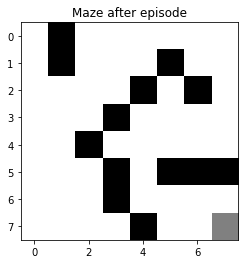

Epoch: 334/999 | Loss: 0.0001 | Episodes: 335 | Win count: 315 | Win rate: 1.000 | time: 1.20 hours
Loss:  0.0003263263206463307
Loss:  8.918596540752333e-05
Loss:  9.172424324788153e-05
Loss:  0.00012146794324507937
Loss:  0.00039202456537168473
Loss:  0.0002004167872655671
Loss:  0.0005071889463579282
Loss:  5.5076070566428825e-05
Loss:  2.9549635655712336e-05
Loss:  0.0001840468030422926


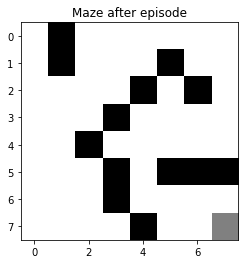

Epoch: 335/999 | Loss: 0.0002 | Episodes: 336 | Win count: 316 | Win rate: 1.000 | time: 1.20 hours
Loss:  0.00033938528213184327
Loss:  0.0005799823848064989
Loss:  7.402887058560736e-05
Loss:  0.00021270024808472954
Loss:  0.00013096373731968924
Loss:  0.0002239072709926404
Loss:  0.0002412308967905119
Loss:  0.0004362932522781193
Loss:  0.00036107904998061713
Loss:  0.0003770458497456275
Loss:  0.0003506619541440159
Loss:  0.000400235308916308
Loss:  0.00023187193801277317
Loss:  0.00035598533213487826
Loss:  7.499916682718322e-05
Loss:  0.0003337333182571456
Loss:  0.00032456951157655567
Loss:  7.713998093095142e-05
Loss:  8.771855573286302e-05


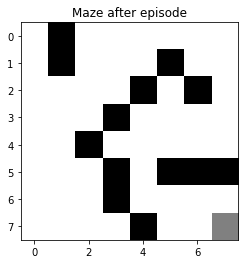

Epoch: 336/999 | Loss: 0.0001 | Episodes: 337 | Win count: 317 | Win rate: 1.000 | time: 1.20 hours
Loss:  5.7520826885593124e-05
Loss:  1.5801140762050636e-05
Loss:  1.1209782314836048e-05
Loss:  0.0004673647345043719
Loss:  0.00022415312560042366
Loss:  0.00020681721980508883
Loss:  0.0002255615654576104
Loss:  0.00026011906447820365
Loss:  5.1773619816231076e-05
Loss:  0.00041807780507951975
Loss:  0.000354321255144896


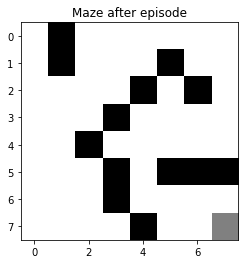

Epoch: 337/999 | Loss: 0.0004 | Episodes: 338 | Win count: 318 | Win rate: 1.000 | time: 1.20 hours
Loss:  0.00045701124690822326
Loss:  6.622068394790404e-05
Loss:  0.00020713778576464392
Loss:  6.064039007469546e-05
Loss:  0.0005571101792156696
Loss:  0.0002527777251088992
Loss:  0.00021768814622191712
Loss:  0.0002514330772100948
Loss:  0.00041052757296711206
Loss:  0.0001806298751034774
Loss:  3.580010343284812e-05


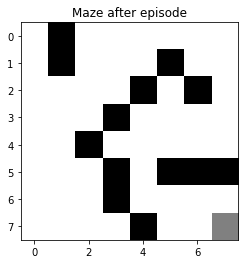

Epoch: 338/999 | Loss: 0.0000 | Episodes: 339 | Win count: 319 | Win rate: 1.000 | time: 1.20 hours
Loss:  0.00013283336738822982
Loss:  0.00031672028126195073
Loss:  6.813516665715724e-05
Loss:  0.00018549263222666923
Loss:  0.00017679210759524722
Loss:  0.00039167928662209306
Loss:  5.5057909776223823e-05
Loss:  3.0277618861873634e-05
Loss:  5.665368735208176e-05


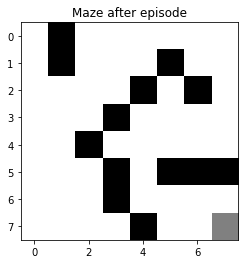

Epoch: 339/999 | Loss: 0.0001 | Episodes: 340 | Win count: 320 | Win rate: 1.000 | time: 1.21 hours
Loss:  0.00016241043340414762
Loss:  0.000230460300372215
Loss:  0.00028436374122975394
Loss:  0.0006538365269079804
Loss:  0.0005085682932985947
Loss:  0.00018867258222599048
Loss:  0.00019807809439953417
Loss:  0.0004760094943776494
Loss:  0.00019552330923033878
Loss:  0.0001893210064736195
Loss:  0.0003163980145473033
Loss:  8.018024163902737e-05
Loss:  0.00020272711117286235


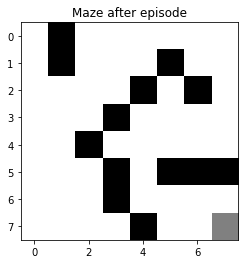

Epoch: 340/999 | Loss: 0.0002 | Episodes: 341 | Win count: 321 | Win rate: 1.000 | time: 1.21 hours
Loss:  0.00017974449110624846
Loss:  0.00038241401489358395
Loss:  0.00037419092404888943
Loss:  0.00018208300207334105
Loss:  0.00037220880039967597
Loss:  3.869529791700188e-05
Loss:  0.00021632591960951686
Loss:  0.00023180523203336634
Loss:  0.00034544029040262103
Loss:  0.0005158568965271115
Loss:  0.00048812918248586357
Loss:  0.00023587506439071149
Loss:  0.00034292285272385925
Loss:  0.0005402641254477203


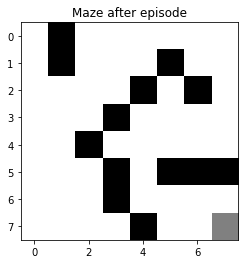

Epoch: 341/999 | Loss: 0.0005 | Episodes: 342 | Win count: 322 | Win rate: 1.000 | time: 1.21 hours
Loss:  6.0184724134160206e-05
Loss:  4.1913220229616854e-05
Loss:  3.667038254207e-05
Loss:  5.1704606448765844e-05
Loss:  8.639948646305129e-05
Loss:  6.915739140822552e-05
Loss:  0.000253891121246852
Loss:  0.00018071982594847213
Loss:  0.0003360276750754565
Loss:  4.314798388804775e-05
Loss:  3.2159954571397975e-05
Loss:  0.0001818941491364967
Loss:  4.3189396819798276e-05
Loss:  4.282022473489633e-05
Loss:  0.00037702561530750245
Loss:  2.1753051441919524e-05
Loss:  0.00033664508373476565


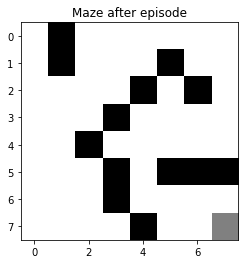

Epoch: 342/999 | Loss: 0.0003 | Episodes: 343 | Win count: 323 | Win rate: 1.000 | time: 1.21 hours
Loss:  7.433142309309915e-05
Loss:  3.9188278606161475e-05
Loss:  2.4392797058681026e-05
Loss:  2.0767909518326633e-05
Loss:  0.00037624530523316935
Loss:  7.047226245049387e-05
Loss:  0.00016397418221458793
Loss:  0.0003444064514042111
Loss:  3.881517659465317e-05
Loss:  0.00016921869610087015
Loss:  8.340709428011905e-05
Loss:  0.0001644026688154554
Loss:  0.00032793270656839013
Loss:  0.00019685369261424057
Loss:  0.00019590940792113543
Loss:  0.00022198672741069458
Loss:  9.876733020064421e-05
Loss:  0.00011210708362341393
Loss:  1.9519046873028856e-05
Loss:  1.8347721379541326e-05
Loss:  0.00018539770553616108
Loss:  0.00016422713997599203
Loss:  0.0004269354685675353
Loss:  0.0003324230965517927
Loss:  0.00037527071981457993
Loss:  9.339680036646314e-05
Loss:  0.0002468607053742744
Loss:  0.00035827691317535937


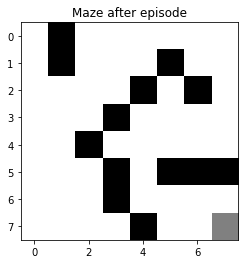

Epoch: 343/999 | Loss: 0.0004 | Episodes: 344 | Win count: 324 | Win rate: 1.000 | time: 1.21 hours
Loss:  0.00025992797600338235
Loss:  7.922784425318241e-05
Loss:  0.000384053768357262
Loss:  2.4894119633245282e-05
Loss:  0.00035857315924658906
Loss:  7.783978071529418e-05
Loss:  0.0005346239631762728
Loss:  0.00023609156778547913
Loss:  0.0003706605602928903
Loss:  8.301740672322921e-05
Loss:  8.030082062759902e-05
Loss:  0.00032508963158761617
Loss:  0.00021710123110096902
Loss:  0.0001254375820280984
Loss:  0.0004659926053136587
Loss:  0.00020565711747622117
Loss:  0.0002596147242002189
Loss:  0.0005288080719765276
Loss:  3.727923831320368e-05
Loss:  0.00017839659722085344
Loss:  0.00014645947521785274
Loss:  0.00038865839451318607
Loss:  0.00021543111142818816
Loss:  0.0002270792901981622
Loss:  0.00018170179100707173
Loss:  0.00041724789480213076
Loss:  0.00020623761884053238
Loss:  0.0001333960535703227
Loss:  0.00035102547553833574
Loss:  6.871112600492779e-05
Loss:  0.0004494

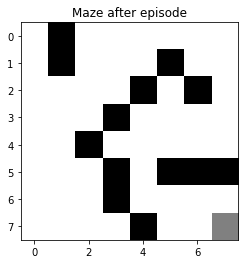

Epoch: 344/999 | Loss: 0.0004 | Episodes: 345 | Win count: 325 | Win rate: 1.000 | time: 1.22 hours
Loss:  0.0002588221432233695
Loss:  0.000463455100543797
Loss:  0.00012272168532945216
Loss:  0.00033100045402534306
Loss:  0.00034368842898402363
Loss:  0.0002002010169235291
Loss:  0.00020653703541029245
Loss:  0.0004719055723398924
Loss:  0.0002596812882984523
Loss:  0.00020225592743372545
Loss:  0.0003040286828763783
Loss:  0.0004164656675129663
Loss:  0.0003686624258989468
Loss:  0.00025284440198447555
Loss:  0.0004468248662305996
Loss:  0.0003361758281243965
Loss:  0.0005179470754228532
Loss:  0.00040924067434389144
Loss:  0.0005880710377823561
Loss:  0.0002011219839914702
Loss:  0.00039795853081159294
Loss:  7.431437188643031e-05
Loss:  0.00043936043221037835
Loss:  8.93431351869367e-05
Loss:  0.00046341679990291595
Loss:  0.0003881703596562147
Loss:  8.250631799455732e-05
Loss:  0.00015659061318729073
Loss:  0.0003657138950075023
Loss:  0.00019651720867841505


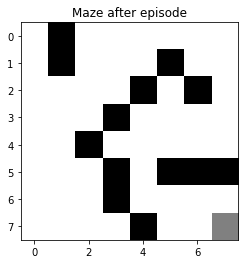

Epoch: 345/999 | Loss: 0.0002 | Episodes: 346 | Win count: 326 | Win rate: 1.000 | time: 1.22 hours
Loss:  4.492345942708198e-05
Loss:  5.32719241164159e-05
Loss:  0.00012120478186261607


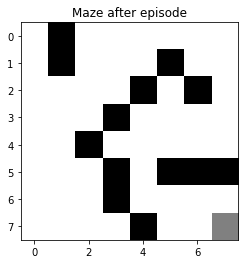

Epoch: 346/999 | Loss: 0.0001 | Episodes: 347 | Win count: 327 | Win rate: 1.000 | time: 1.22 hours
Loss:  4.386323053040542e-05
Loss:  0.0006943798798602074
Loss:  0.00012363640053081326
Loss:  0.00021480101713677868
Loss:  0.000305041885440005
Loss:  0.00029419222846627235
Loss:  0.0004503135132836178
Loss:  0.0002142698795069009
Loss:  0.00035053382816840895
Loss:  0.0005394082691054791
Loss:  0.0002504840595065616
Loss:  0.0003038074937649071
Loss:  5.4668926168233156e-05
Loss:  0.00030664773657917976


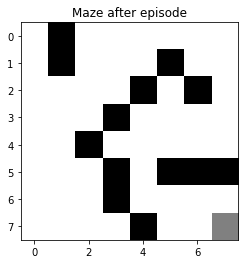

Epoch: 347/999 | Loss: 0.0003 | Episodes: 348 | Win count: 328 | Win rate: 1.000 | time: 1.22 hours
Loss:  0.00028503704379545525
Loss:  0.00021401803678600118
Loss:  0.0004968107241438702
Loss:  0.0003196618054062128
Loss:  0.00036886593443341553
Loss:  0.00018527591782913078
Loss:  0.0004967298373230733
Loss:  0.0003479193928797031
Loss:  0.00028726357049890794
Loss:  0.00035979858148493804
Loss:  0.00010057218241854571
Loss:  3.522580846038181e-05
Loss:  6.406724787666462e-05
Loss:  0.00012123825035814662
Loss:  0.00010772929454105906
Loss:  0.0001370411082461942
Loss:  0.0001317521328019211


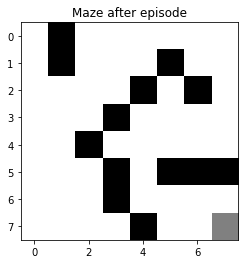

Epoch: 348/999 | Loss: 0.0001 | Episodes: 349 | Win count: 329 | Win rate: 1.000 | time: 1.22 hours
Loss:  0.00025548921439622063
Loss:  0.00011594817988225259
Loss:  0.0006114618299761787
Loss:  9.504754416411743e-05
Loss:  0.000265209841018077
Loss:  0.0004493333981372416
Loss:  4.8295300075551495e-05
Loss:  0.00024271028087241575
Loss:  0.0004680815945903305
Loss:  0.00026500051171751693
Loss:  0.0004185509023955092
Loss:  0.0004348437214503065
Loss:  0.0004604474233929068
Loss:  0.0006214745808392763
Loss:  0.001040663744788617
Loss:  0.0003244212130084634
Loss:  0.00031664816924603656
Loss:  0.0005853030015714467
Loss:  0.0003188646660419181
Loss:  0.0004807915829587728
Loss:  0.000271650125796441
Loss:  0.00027174214483238757
Loss:  0.0003747706359717995
Loss:  0.0005510467162821442
Loss:  0.0007966670964378864
Loss:  0.0004280078719602898
Loss:  0.0001340471935691312


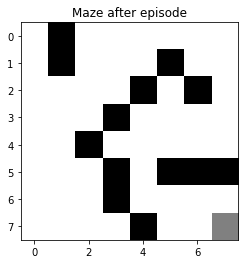

Epoch: 349/999 | Loss: 0.0001 | Episodes: 350 | Win count: 330 | Win rate: 1.000 | time: 1.22 hours
Loss:  0.000296735655865632
Loss:  0.00021461802316480316
Loss:  0.000501315007568337
Loss:  0.0003927288416889496
Loss:  0.0003630088467616588
Loss:  0.00025541437207721174
Loss:  0.0007582890684716403
Loss:  0.0002778614762064535
Loss:  0.00022926394740352407
Loss:  0.00017090346409531776
Loss:  0.00021147178267710842
Loss:  0.0003539223689585924
Loss:  0.0002571610457380302


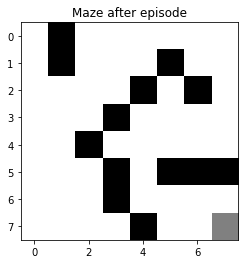

Epoch: 350/999 | Loss: 0.0003 | Episodes: 351 | Win count: 331 | Win rate: 1.000 | time: 1.23 hours
Loss:  8.114832598948851e-05
Loss:  6.401678911061026e-05
Loss:  0.0003639271599240601
Loss:  0.00020903076801914722
Loss:  0.0003752748161787167
Loss:  0.00025152227317448705
Loss:  4.0612303564557806e-05
Loss:  0.00020173452867311426
Loss:  0.0003986474694102071
Loss:  0.00028493614809121937
Loss:  0.00017192686573253013
Loss:  0.000304708766634576
Loss:  2.7842809686262626e-05
Loss:  0.00020951364786014892
Loss:  0.000189602593309246


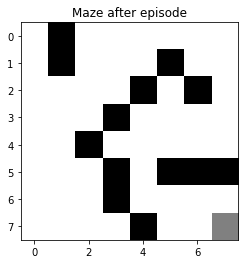

Epoch: 351/999 | Loss: 0.0002 | Episodes: 352 | Win count: 332 | Win rate: 1.000 | time: 1.23 hours
Loss:  7.594282942591235e-05
Loss:  0.0002702675337786786
Loss:  0.0003472848220553715
Loss:  0.0004830108809983358
Loss:  8.532145511708222e-05
Loss:  0.00029730961432505865
Loss:  0.00041594895446905866
Loss:  0.00018164285575039685
Loss:  0.0003691143174364697
Loss:  0.00021764728444395587
Loss:  0.0008479738899040967
Loss:  0.0003688485667225905
Loss:  0.00034965450322488323
Loss:  0.000475643522804603


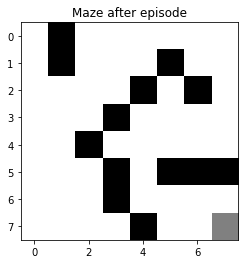

Epoch: 352/999 | Loss: 0.0005 | Episodes: 353 | Win count: 333 | Win rate: 1.000 | time: 1.23 hours
Loss:  0.0001932187624333892
Loss:  0.00017643055525695672
Loss:  5.354589666239917e-05
Loss:  0.00035031056904699653
Loss:  2.576032329670852e-05
Loss:  0.00040752935456112027
Loss:  0.00020144020527368411
Loss:  0.0006364540895447135
Loss:  0.00017197233682963997
Loss:  0.0001788706831575837
Loss:  3.614096203818917e-05
Loss:  0.000332560739479959
Loss:  0.0005000936362193897
Loss:  0.0004226739110890776


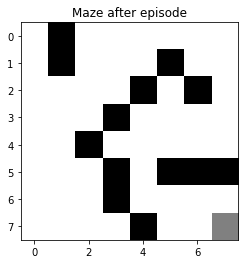

Epoch: 353/999 | Loss: 0.0004 | Episodes: 354 | Win count: 334 | Win rate: 1.000 | time: 1.23 hours
Loss:  0.0003218810015823692
Loss:  0.00020954566934960894
Loss:  0.0003290955501142889
Loss:  0.0002470966865075752
Loss:  0.00023073391275829636
Loss:  3.2891048249439336e-05
Loss:  3.398383159947116e-05
Loss:  0.0001855163736763643
Loss:  0.00034104565747838933
Loss:  0.0001963668255484663
Loss:  0.00032151992490980774
Loss:  0.00025225516947102733
Loss:  4.448021536518354e-05
Loss:  0.0003200916253263131
Loss:  0.00019478335161693394
Loss:  0.0002235800857306458
Loss:  0.0002307548165845219
Loss:  0.00012123309716116637
Loss:  0.0001754753047862323
Loss:  0.0001702409063000232
Loss:  0.00022986562180449255
Loss:  0.0005279516917653382
Loss:  0.00027248736296314746
Loss:  0.00018409867880109232
Loss:  0.0004984468396287411
Loss:  0.00029051526507828385
Loss:  0.00028883041159133427
Loss:  0.0002214096239185892
Loss:  4.263903792889323e-05
Loss:  4.445129889063537e-05


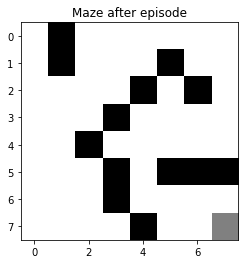

Epoch: 354/999 | Loss: 0.0000 | Episodes: 355 | Win count: 335 | Win rate: 1.000 | time: 1.23 hours
Loss:  0.00033694485318847
Loss:  0.0004944794927723706
Loss:  0.00032964922138489783
Loss:  0.0002003236786549678
Loss:  9.771394434210379e-05
Loss:  0.0003283102560089901
Loss:  0.00018879177514463663
Loss:  0.0003359254296810832
Loss:  0.0003129368124064058
Loss:  0.0005173383979126811
Loss:  0.0002179431430704426
Loss:  0.0003173136537952814
Loss:  3.8037801459722687e-05
Loss:  3.5842176657752134e-05
Loss:  0.0003102365271843155
Loss:  8.100235390884336e-05
Loss:  0.00023364337903331034


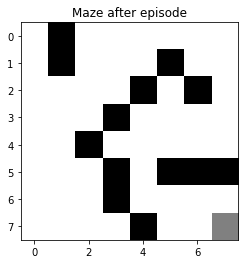

Epoch: 355/999 | Loss: 0.0002 | Episodes: 356 | Win count: 336 | Win rate: 1.000 | time: 1.23 hours
Loss:  0.00017438563736504875
Loss:  0.00024459078849758953
Loss:  0.00019767108642554376
Loss:  6.341159496514592e-05
Loss:  0.00014518024909193628
Loss:  0.0005426289862953126
Loss:  0.00035647190816234797
Loss:  0.00034155153844039887
Loss:  0.00023323437926592305
Loss:  0.00021821875634486787
Loss:  0.00019871659969794564
Loss:  0.00035623428630060516
Loss:  5.094540574646089e-05
Loss:  0.0005784286768175662
Loss:  9.825580127653666e-05


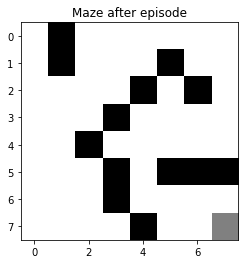

Epoch: 356/999 | Loss: 0.0001 | Episodes: 357 | Win count: 337 | Win rate: 1.000 | time: 1.24 hours
Loss:  0.0004510764847509563
Loss:  0.000403059835662134
Loss:  0.0002662978949956596
Loss:  0.0002315675410500262
Loss:  0.00039574205584358424


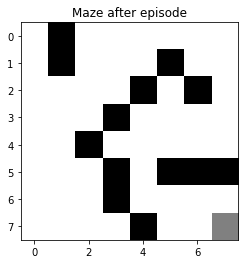

Epoch: 357/999 | Loss: 0.0004 | Episodes: 358 | Win count: 338 | Win rate: 1.000 | time: 1.24 hours
Loss:  4.315716796554625e-05
Loss:  0.0005275179719319567
Loss:  0.0007995936321094632
Loss:  0.0002401380661467556
Loss:  0.00022653571795672178
Loss:  0.00035498298893799074
Loss:  0.00018742661268333904
Loss:  0.0003498092683003051
Loss:  4.392058326629922e-05
Loss:  0.0002020025331148645
Loss:  0.00034987508843187243
Loss:  0.0003613490844145417
Loss:  0.00039834143535699695
Loss:  3.9382162867696024e-05
Loss:  0.0003572556233848445
Loss:  0.00020690993551397696
Loss:  0.0003255837655160576
Loss:  0.00021825070143677294
Loss:  0.0005194889818085358
Loss:  7.568275032099336e-05
Loss:  0.00019903856809833087
Loss:  0.00030352864996530116
Loss:  3.555505463737063e-05


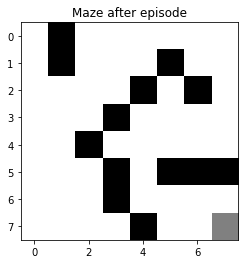

Epoch: 358/999 | Loss: 0.0000 | Episodes: 359 | Win count: 339 | Win rate: 1.000 | time: 1.24 hours
Loss:  0.00016636590589769185
Loss:  0.000708566716639325
Loss:  0.0002874482379411347
Loss:  0.00034559039340820163
Loss:  0.0003274624286859762
Loss:  0.00020411260265973397
Loss:  0.00028390165243763477
Loss:  0.00036088767228648067
Loss:  4.747749881062191e-05
Loss:  0.0006151369161671028
Loss:  0.00029687295318581164
Loss:  0.0008373180171474814
Loss:  0.00018974200065713376
Loss:  0.0002795722830342129
Loss:  0.00020537333693937398
Loss:  0.0003091640828642994
Loss:  0.0003865156559186289
Loss:  0.00045243254862725735
Loss:  0.0001708598756522406
Loss:  0.0004358181031420827
Loss:  0.0001814938586903736
Loss:  0.00017323924475931562
Loss:  0.00018703811292652972
Loss:  0.0004772855136252474
Loss:  0.00015272888322215294


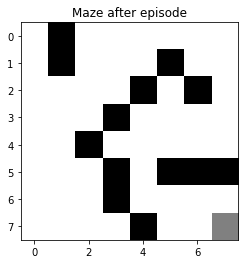

Epoch: 359/999 | Loss: 0.0002 | Episodes: 360 | Win count: 340 | Win rate: 1.000 | time: 1.24 hours
Loss:  0.00021304787151166238
Loss:  0.0003585347585612908
Loss:  0.0002607720307423733
Loss:  5.152025187271647e-05
Loss:  0.00016976534971036017
Loss:  0.00031735850279801525
Loss:  0.00029209650529082865
Loss:  0.00037251098910928704
Loss:  0.00037851625529583544
Loss:  0.00021980323072057217
Loss:  0.0002748745937424246
Loss:  0.0003835724855889566
Loss:  0.0001852849636634346
Loss:  9.249450886272825e-05
Loss:  0.00023284641792997718
Loss:  0.00036551329685607925
Loss:  0.00037823570892214775
Loss:  0.00048947571485769
Loss:  0.00020175872123218141
Loss:  0.0005214505363255739
Loss:  0.00020602010044967756
Loss:  0.0004703710292233154
Loss:  0.0003007352497661486
Loss:  0.00010515681060496718
Loss:  0.0003245891275582835
Loss:  0.00016863654309418052
Loss:  0.00036846236616838723
Loss:  0.00021972099784761667
Loss:  0.00020077271619811654
Loss:  0.000486701144836843
Loss:  0.0006665

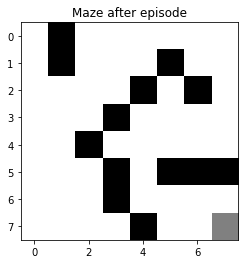

Epoch: 360/999 | Loss: 0.0005 | Episodes: 361 | Win count: 341 | Win rate: 1.000 | time: 1.24 hours
Loss:  0.00039712768921162933
Loss:  0.0005274319410091266
Loss:  0.00016164331464096904
Loss:  0.0002407898246019613
Loss:  0.00022673822968499735
Loss:  0.0003645201286417432
Loss:  0.0005030065731261857
Loss:  9.039846554514952e-05
Loss:  0.00017766637756722048
Loss:  0.0006764979043509811
Loss:  0.0003675328043755144
Loss:  0.0006334540667012334
Loss:  0.0004966781416442245
Loss:  0.0004167567822150886
Loss:  0.0005123512382851914
Loss:  0.00042656558071030304
Loss:  0.0004366713692434132
Loss:  0.0003535851865308359


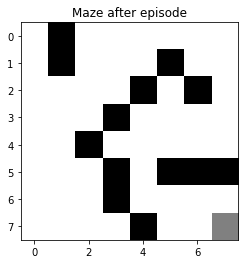

Epoch: 361/999 | Loss: 0.0004 | Episodes: 362 | Win count: 342 | Win rate: 1.000 | time: 1.24 hours
Loss:  0.00020177811529720202
Loss:  0.0005555581883527339
Loss:  0.0002300637097505387
Loss:  0.0002648373047122732
Loss:  0.00025931018171831965
Loss:  0.0006980610633036122
Loss:  0.0002913304415415041
Loss:  0.00022866361905471422
Loss:  0.0003864742466248572
Loss:  0.00012985926878172904
Loss:  3.754312638193369e-05
Loss:  0.0004816993896383792
Loss:  0.00047246491885744035
Loss:  0.0008696836594026536
Loss:  0.0003024846773769241
Loss:  0.000367017462849617
Loss:  0.0007154139457270503
Loss:  0.0004965233820257708
Loss:  0.0005872343899682164
Loss:  0.00023687979773967527
Loss:  0.00046018967987038195
Loss:  0.0008940787811297923
Loss:  0.00018701805674936622
Loss:  0.00048551462532486767
Loss:  0.0008213326800614595
Loss:  4.462023571250029e-05
Loss:  0.0003266733638156438
Loss:  0.0003722666806424968
Loss:  0.00024245696840807796
Loss:  0.00039114295213948935
Loss:  0.00026162627

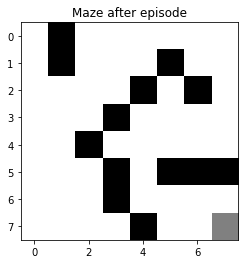

Epoch: 362/999 | Loss: 0.0002 | Episodes: 363 | Win count: 343 | Win rate: 1.000 | time: 1.25 hours
Loss:  0.0005652632971759886
Loss:  0.00019410371169215068
Loss:  0.00040122972859535366
Loss:  0.000605766057560686
Loss:  0.00048332713049603626
Loss:  0.00020561808196362108
Loss:  0.0004018891340820119
Loss:  0.00030351377790793777
Loss:  0.00012733197581837885
Loss:  0.00033407434239052236
Loss:  0.00019478295143926516
Loss:  0.0006768455205019563
Loss:  0.0002956362586701289
Loss:  0.0004159835953032598
Loss:  0.0004034798257634975
Loss:  0.0005262826889520511
Loss:  0.00024014067457756028
Loss:  0.00046227364509832114
Loss:  0.0006943521730136126
Loss:  0.00038860795757500455
Loss:  0.00033091811928898096
Loss:  0.0002404758779448457
Loss:  0.0002671706606633961
Loss:  0.00028759203269146383
Loss:  0.0006444501632358879
Loss:  0.0001050827449944336
Loss:  0.0007713110826443881
Loss:  0.00027539328584680334
Loss:  0.0001545379745948594
Loss:  0.000272108634817414
Loss:  0.000475013

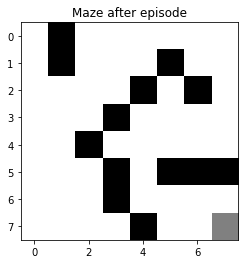

Epoch: 363/999 | Loss: 0.0005 | Episodes: 364 | Win count: 344 | Win rate: 1.000 | time: 1.25 hours
Loss:  0.0002721488053794019
Loss:  0.0005631187814287841
Loss:  0.0004909171257168055
Loss:  0.0005919383547734469
Loss:  0.0006411895446944982
Loss:  0.00028666887374129146
Loss:  0.000390028246329166
Loss:  0.00020305506041040644
Loss:  0.00014998644110164605
Loss:  0.00023869755386840552
Loss:  0.00029349687974900007
Loss:  0.0006837589317001402
Loss:  9.636511094868183e-05
Loss:  0.0003276398638263345
Loss:  0.000304957153275609
Loss:  0.00013535873586079106
Loss:  0.0006674054893665016
Loss:  0.00021757068316219375
Loss:  0.0005641194256895687
Loss:  0.0006307938892859966
Loss:  0.0005086813471280038
Loss:  0.0003931842802558094


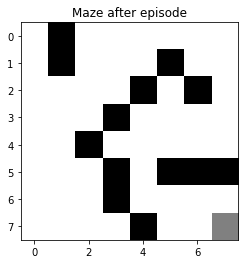

Epoch: 364/999 | Loss: 0.0004 | Episodes: 365 | Win count: 345 | Win rate: 1.000 | time: 1.25 hours
Loss:  0.0004069160349899903
Loss:  0.0006848673656350002
Loss:  0.0006977137090871111
Loss:  0.0004926425754092634
Loss:  0.00045935607340652496
Loss:  0.00033524220634717494
Loss:  0.0007490940624848008
Loss:  0.00011132668441860005
Loss:  0.0005087634017399978
Loss:  0.00021371901675593108
Loss:  0.000510471872985363
Loss:  0.00043265278509352356
Loss:  0.0003835388306470122
Loss:  0.00029976057703606784
Loss:  0.00022659910246147774
Loss:  0.00036549473588820547
Loss:  0.0008066034642979503
Loss:  0.0003066128119826317
Loss:  0.0006771535699954256
Loss:  0.0002194939588662237
Loss:  0.0004952007147949189
Loss:  5.822593448101543e-05
Loss:  0.00017944088358490262
Loss:  0.0005133073282195255
Loss:  0.00019380222511244938
Loss:  0.00021288210336933844
Loss:  0.0006694606126984581
Loss:  0.00019124940081383102
Loss:  0.0004107493950868957


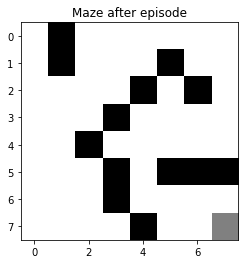

Epoch: 365/999 | Loss: 0.0004 | Episodes: 366 | Win count: 346 | Win rate: 1.000 | time: 1.26 hours
Loss:  0.0001063398303813301
Loss:  0.00047489254211541265
Loss:  0.0001862208082457073
Loss:  0.00012726043132715859
Loss:  0.000537398736923933
Loss:  0.00018464847562427167
Loss:  0.0007406359654851258
Loss:  0.0003678049542941153
Loss:  0.0003798271936830133
Loss:  0.0003550057954271324
Loss:  0.0006863799935672432
Loss:  0.0008172132365871221
Loss:  0.0005186049093026668
Loss:  0.0004617034937837161


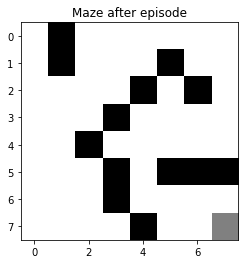

Epoch: 366/999 | Loss: 0.0005 | Episodes: 367 | Win count: 347 | Win rate: 1.000 | time: 1.26 hours
Loss:  7.498912964365445e-05
Loss:  0.00026804015215020627
Loss:  0.0005839828227180988
Loss:  0.00033571061794646084


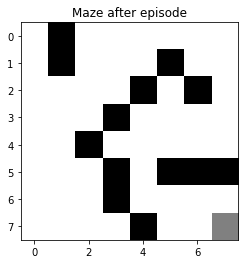

Epoch: 367/999 | Loss: 0.0003 | Episodes: 368 | Win count: 348 | Win rate: 1.000 | time: 1.26 hours
Loss:  0.00018785284919431433
Loss:  0.000566380491363816
Loss:  0.0008325591043103486


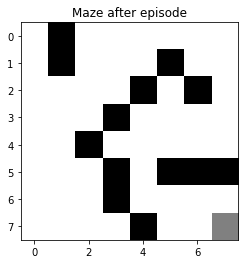

Epoch: 368/999 | Loss: 0.0008 | Episodes: 369 | Win count: 349 | Win rate: 1.000 | time: 1.26 hours
Loss:  0.00021132281472091563
Loss:  0.00026610488566802815
Loss:  0.0004098860954400152
Loss:  0.00031595594191458076
Loss:  0.0002860721433535218
Loss:  0.0004881268832832575
Loss:  0.0004057797050336376
Loss:  0.0010384449851699173
Loss:  0.0006654725293628871
Loss:  0.00030126507044769824
Loss:  0.000929089350393042
Loss:  0.0009310756286140531
Loss:  0.00028689818282146007
Loss:  0.00027103743195766583
Loss:  0.0006806473229516996
Loss:  0.00033053397783078253


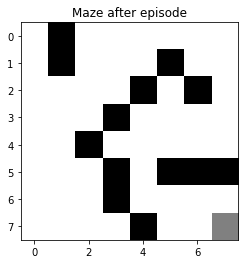

Epoch: 369/999 | Loss: 0.0003 | Episodes: 370 | Win count: 350 | Win rate: 1.000 | time: 1.26 hours
Loss:  0.0006306971481535584
Loss:  0.00036287571128923446
Loss:  0.00045039715769235045
Loss:  0.00023530513135483488
Loss:  0.00048473374044988304
Loss:  0.00032559137616772205
Loss:  0.00021806767472298816
Loss:  0.0005743014917243272
Loss:  0.00024308566935360432
Loss:  0.00045116346882423386
Loss:  0.0007640226976945996
Loss:  0.00027016048261430115
Loss:  8.682872976351064e-05
Loss:  0.0004573086480377242
Loss:  0.0002383158243901562
Loss:  0.00026457575586391613
Loss:  0.0004016792227048427
Loss:  0.0005155277322046459


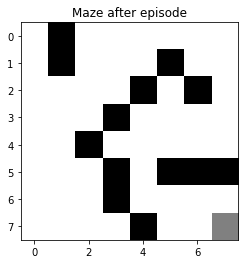

Epoch: 370/999 | Loss: 0.0005 | Episodes: 371 | Win count: 351 | Win rate: 1.000 | time: 1.26 hours
Loss:  0.0004970903100911528
Loss:  0.0001872978245955892
Loss:  0.0006504068442154676
Loss:  0.0006720859673805535
Loss:  0.00013238425526651554
Loss:  0.00042387798748677596
Loss:  0.00036553981044562533
Loss:  0.0005892311746720225
Loss:  0.00039017621020320803
Loss:  0.0003898407885571942
Loss:  0.0005827712011523545
Loss:  0.000596740617766045
Loss:  0.0003378748588147573
Loss:  0.0002730182823142968
Loss:  0.00023166632308857515
Loss:  0.0007026916136965156
Loss:  0.00036783986433874816
Loss:  0.0002886813053919468
Loss:  0.00020530212350422516


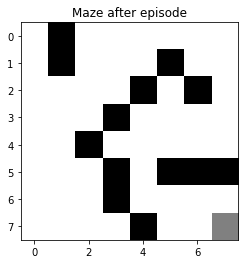

Epoch: 371/999 | Loss: 0.0002 | Episodes: 372 | Win count: 352 | Win rate: 1.000 | time: 1.26 hours
Loss:  0.00019976140174549073
Loss:  0.0004537155182333663
Loss:  0.0004190218314761296
Loss:  0.00046421156730502844
Loss:  0.0002197438952862285
Loss:  0.0006550234102178365
Loss:  9.046311060956214e-05
Loss:  0.0007652804342797026


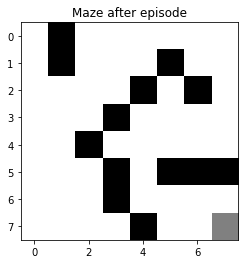

Epoch: 372/999 | Loss: 0.0008 | Episodes: 373 | Win count: 353 | Win rate: 1.000 | time: 1.27 hours
Loss:  0.0006766623700968921
Loss:  0.0007683889707550406
Loss:  0.0001381022739224136
Loss:  0.0002653464616741985
Loss:  0.0006765712460037321
Loss:  0.00018061328592011705
Loss:  0.0004958095523761585
Loss:  7.30857536836993e-05
Loss:  0.0003674767358461395
Loss:  0.0003164123263559304
Loss:  0.0003023106255568564
Loss:  0.000519844688824378
Loss:  0.0002447125443723053
Loss:  0.00028339737036731094
Loss:  0.00042233377462252975
Loss:  0.00019283525762148201
Loss:  0.00043453822217998095
Loss:  0.0001238308905158192
Loss:  0.0002236518557765521
Loss:  0.0005541448044823483
Loss:  0.0002498468711564783
Loss:  0.00046880898298695683
Loss:  0.0007199784740805626
Loss:  0.0005637926515191793
Loss:  0.0007379892049357295
Loss:  0.0006251705490285531
Loss:  0.00023068793962011114
Loss:  0.0005378906062105671
Loss:  0.0006420298013836145
Loss:  0.00029649447242263705
Loss:  0.000533945469214

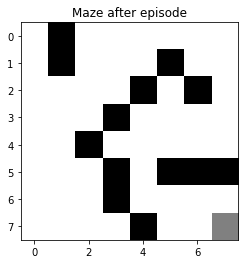

Epoch: 373/999 | Loss: 0.0006 | Episodes: 374 | Win count: 354 | Win rate: 1.000 | time: 1.27 hours
Loss:  0.00042541597213130444
Loss:  0.0006447100749937817
Loss:  0.000635680218692869
Loss:  0.00047463711598538794


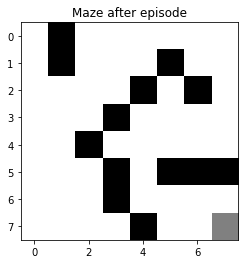

Epoch: 374/999 | Loss: 0.0005 | Episodes: 375 | Win count: 355 | Win rate: 1.000 | time: 1.27 hours
Loss:  0.0006988882087171078
Loss:  0.0008101269195321947
Loss:  0.00037545459053944796
Loss:  0.0003662860399344936
Loss:  0.0009429543279111385
Loss:  0.0005976168613415211
Loss:  0.0005799132632091641
Loss:  0.0010259799310006201
Loss:  0.00030514544050674886
Loss:  0.00045632983528776094
Loss:  0.00023303918351302855
Loss:  0.0009490738739259541
Loss:  0.00038240707363002
Loss:  5.808553396491334e-05
Loss:  0.0004330106785346288
Loss:  0.0005637521244352683
Loss:  0.000328708061715588
Loss:  0.0003922498435713351
Loss:  0.001114913378842175
Loss:  0.00045617008436238393


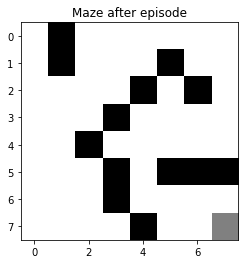

Epoch: 375/999 | Loss: 0.0005 | Episodes: 376 | Win count: 356 | Win rate: 1.000 | time: 1.27 hours
Loss:  0.0007230628107208759
Loss:  0.000499056521221064
Loss:  0.0006898453866597265
Loss:  0.0008825373370200396
Loss:  0.0006598712061531842
Loss:  0.0010506879771128297
Loss:  0.0006265188712859526
Loss:  0.0004512306477408856
Loss:  0.0004483636876102537
Loss:  0.0006383016880135983
Loss:  0.0007275130192283541
Loss:  0.0006427311745937914
Loss:  0.0004966867854818702
Loss:  0.000762255527661182
Loss:  0.0006736302748322487
Loss:  0.0006818556867074221
Loss:  0.00024299350116052665
Loss:  0.00047316171549027786
Loss:  0.0007982091337908059
Loss:  0.0002724062214838341
Loss:  0.0009034061804413795
Loss:  0.0005348704435164109
Loss:  0.000832322177302558
Loss:  0.0008952058851718903
Loss:  0.000830566044896841
Loss:  0.0008452366455458105


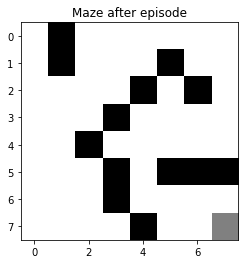

Epoch: 376/999 | Loss: 0.0008 | Episodes: 377 | Win count: 357 | Win rate: 1.000 | time: 1.27 hours
Loss:  0.0006718200456816703
Loss:  0.0008105277956929058
Loss:  0.0004213811189401895
Loss:  0.0007327856146730483
Loss:  0.0002979291821247898
Loss:  0.0005422549293143675
Loss:  0.000663955113850534
Loss:  0.0004125140840187669
Loss:  0.0005041648109909147
Loss:  0.00040014105616137385
Loss:  0.0009982810879591852
Loss:  0.00017550323536852375
Loss:  0.00032066754647530615
Loss:  0.00039799326623324305
Loss:  0.0008566880715079606
Loss:  0.0007024557562544942
Loss:  0.0008649074588902295
Loss:  0.0005159432694199495
Loss:  0.0002900440595112741
Loss:  0.0005536440585274249
Loss:  0.0005818207864649594
Loss:  0.00042921502608805895
Loss:  0.00039320629730354995


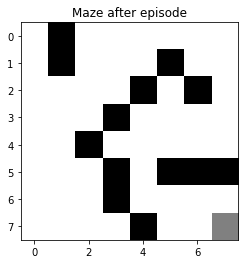

Epoch: 377/999 | Loss: 0.0004 | Episodes: 378 | Win count: 358 | Win rate: 1.000 | time: 1.28 hours
Loss:  0.0003064708216697909
Loss:  0.0007958374335430562
Loss:  0.0002521150963730179
Loss:  0.00048555037938058376
Loss:  0.0004707640327978879
Loss:  0.0005946288438281044
Loss:  0.00033499007622594945
Loss:  0.0009405559976585209
Loss:  0.00014650122466264293
Loss:  0.00041791780677158386
Loss:  0.00023332477576332167
Loss:  0.00021648325127898715
Loss:  0.0007192746270447969
Loss:  0.0006785219302400947
Loss:  0.0003802117207669653
Loss:  0.0005030380561947823
Loss:  0.00040946618537418544
Loss:  0.00043752526107709855
Loss:  0.0004649905131373089
Loss:  0.00031297832538257353
Loss:  9.425728057976812e-05
Loss:  0.0002327722559130052
Loss:  0.0005954398075118661
Loss:  0.0005644328630296513
Loss:  0.0008145397296175361
Loss:  0.0005458588129840791
Loss:  0.0007006128871580586


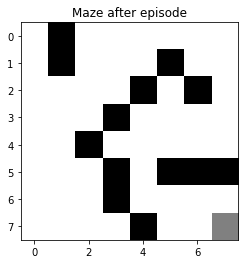

Epoch: 378/999 | Loss: 0.0007 | Episodes: 379 | Win count: 359 | Win rate: 1.000 | time: 1.28 hours
Loss:  0.0005591999506577849
Loss:  0.00042275371379218996
Loss:  0.0008772222208790481
Loss:  0.0005652099498547614
Loss:  0.0005230935348663479
Loss:  0.0002892984775826335
Loss:  0.00029962283952045254
Loss:  0.0007269809138961136
Loss:  0.00022029061437933706
Loss:  0.0002834042097674683
Loss:  0.000498062654514797
Loss:  0.0006396475655492395
Loss:  0.0005607127968687564
Loss:  0.000546252544154413
Loss:  0.0005615124100586399
Loss:  0.00016215327559621073
Loss:  0.0007240710547193885
Loss:  0.0007651502382941544
Loss:  0.0006393356597982347
Loss:  0.0006483882898464799
Loss:  0.0006978949531912804
Loss:  0.0002562261470302474
Loss:  0.000500330061186105
Loss:  0.0008827265992294997
Loss:  0.0004857864114455879


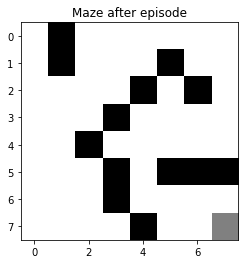

Epoch: 379/999 | Loss: 0.0005 | Episodes: 380 | Win count: 360 | Win rate: 1.000 | time: 1.28 hours
Loss:  0.00031755882082507014
Loss:  0.0011188272037543356
Loss:  0.00042554293759167194
Loss:  0.00013079672135063447
Loss:  0.0004011269484180957
Loss:  0.0006881444423925132
Loss:  0.0006558753666467965
Loss:  0.00040878169966163114
Loss:  0.0007172979530878365
Loss:  0.0005874456837773323
Loss:  0.0006966358341742307
Loss:  0.0007171943143475801
Loss:  0.00034217280335724354
Loss:  0.0007353454711847007
Loss:  0.00042921662679873407
Loss:  0.0003842890582745895
Loss:  0.0005972093349555507
Loss:  0.00027728801069315523
Loss:  0.00048036736552603543
Loss:  8.703394632902928e-05
Loss:  0.0006598054606001824
Loss:  0.0006951801187824458
Loss:  0.0006009570643072948


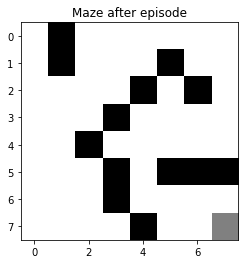

Epoch: 380/999 | Loss: 0.0006 | Episodes: 381 | Win count: 361 | Win rate: 1.000 | time: 1.28 hours
Loss:  0.0005558010889217257
Loss:  0.000678154727211222
Loss:  0.000372112262994051
Loss:  0.0004199584946036339
Loss:  0.0007152233301894739
Loss:  0.0005364404350984842
Loss:  0.0010007243836298585
Loss:  0.0003690059020300396
Loss:  0.0003443874084041454
Loss:  0.00036736919719260186
Loss:  0.0009261646191589534
Loss:  0.0007881174969952554
Loss:  0.000819333567051217
Loss:  0.0002985137398354709
Loss:  0.00048610076191835105
Loss:  0.0007032504654489458
Loss:  0.00042583369940984994
Loss:  0.0004579719970934093
Loss:  0.0008518893446307629
Loss:  0.00044394307769834995
Loss:  0.00034959058393724263
Loss:  0.000828829943202436
Loss:  0.0005504527216544375


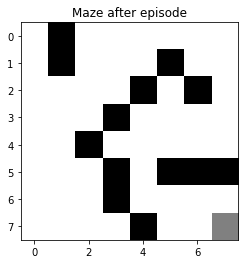

Epoch: 381/999 | Loss: 0.0006 | Episodes: 382 | Win count: 362 | Win rate: 1.000 | time: 1.29 hours
Loss:  0.00030475639505311847
Loss:  0.0005691826663678512
Loss:  0.00044724946201313287
Loss:  0.0010571361926849931
Loss:  0.0007756538107059896
Loss:  0.0004984605475328863
Loss:  0.0006143922510091215


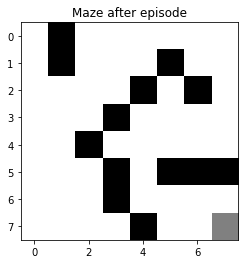

Epoch: 382/999 | Loss: 0.0006 | Episodes: 383 | Win count: 363 | Win rate: 1.000 | time: 1.29 hours
Loss:  0.0003987536329077557
Loss:  0.0004301924927858636
Loss:  0.0008972874493338168


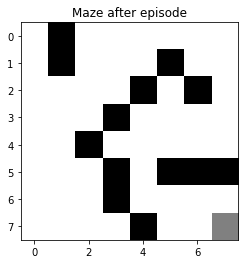

Epoch: 383/999 | Loss: 0.0009 | Episodes: 384 | Win count: 364 | Win rate: 1.000 | time: 1.29 hours
Loss:  0.0007015538867563009
Loss:  0.0005811045703012496
Loss:  0.00035417400795267895
Loss:  0.0005078069807495922
Loss:  0.0006981047918088734
Loss:  0.0006659844948444515
Loss:  0.0006371451308950782
Loss:  0.0003613757435232401
Loss:  0.0005668131052516401
Loss:  0.0007756383565720171
Loss:  0.001013518136460334
Loss:  0.0009598560718586668
Loss:  0.00030417392554227263
Loss:  0.0007545012776972726
Loss:  0.00030069370404817164


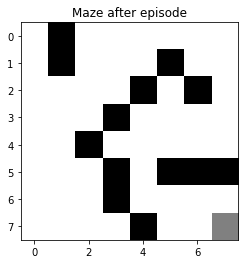

Epoch: 384/999 | Loss: 0.0003 | Episodes: 385 | Win count: 365 | Win rate: 1.000 | time: 1.29 hours
Loss:  0.0002601528321974911
Loss:  0.0006160284683573991
Loss:  0.0006132262060418725
Loss:  0.0006055689082131721
Loss:  0.0005197686841711402
Loss:  0.00046987010864540935
Loss:  0.000283213536022231
Loss:  0.0003860496581182815
Loss:  0.0005005591228837147
Loss:  0.00046522750926669687
Loss:  0.0006569264805875719
Loss:  0.00048145256005227566
Loss:  0.000589278046390973
Loss:  0.0004462912620510906
Loss:  0.0008258924353867769
Loss:  0.00030387044535018504
Loss:  0.0003471858362900093
Loss:  0.00036009221366839483
Loss:  0.0004934998141834512
Loss:  0.0005455426580738276
Loss:  0.0007129041623556986
Loss:  0.0005193182441871613
Loss:  0.0009562313789501786
Loss:  0.0011829666327685118
Loss:  0.0007067917031235993
Loss:  0.00024459603446302935
Loss:  0.0006810840859543532
Loss:  0.0008507291786372662
Loss:  0.0007427293385262601
Loss:  0.0004880786582361907
Loss:  0.00069277378497645

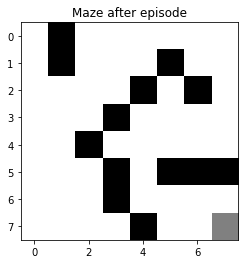

Epoch: 385/999 | Loss: 0.0004 | Episodes: 386 | Win count: 366 | Win rate: 1.000 | time: 1.29 hours
Loss:  0.0005335611058399081
Loss:  0.0004852245911024511
Loss:  0.0005025357968406752
Loss:  0.000601740728598088
Loss:  0.0007472547877114266
Loss:  0.0004745101323351264
Loss:  0.0004161012766417116
Loss:  0.00069140360574238
Loss:  0.0005568029591813684
Loss:  0.0008528886828571558
Loss:  0.0005825224507134408
Loss:  0.00039710932469461113
Loss:  0.00019987272753496654
Loss:  0.0005640440504066646
Loss:  0.0005151209334144369
Loss:  0.0002923184001701884
Loss:  0.0009310493478551507


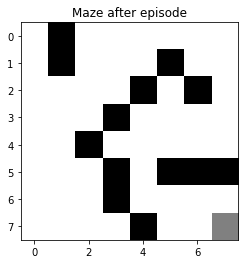

Epoch: 386/999 | Loss: 0.0009 | Episodes: 387 | Win count: 367 | Win rate: 1.000 | time: 1.29 hours
Loss:  0.0004831552068935707
Loss:  0.0006271461606957018
Loss:  0.00028668532468145713
Loss:  0.00021206405654083937
Loss:  0.0005259624958853237
Loss:  0.00042770565778482705
Loss:  0.0008558576228097081
Loss:  0.00023328047973336652
Loss:  0.000753337430069223
Loss:  0.0004497798072407022
Loss:  0.0002684020437300205
Loss:  0.0005006658902857453
Loss:  0.00027531599334906787
Loss:  0.0003779645630856976
Loss:  0.0006250814185477793
Loss:  0.0006318145315162838
Loss:  0.0002975012466777116
Loss:  0.00023364316439256072
Loss:  0.0005111162172397599
Loss:  0.0009492369717918336
Loss:  0.00046091433614492416
Loss:  0.0007007536187302321
Loss:  0.00042047342867590487
Loss:  0.000551961682504043
Loss:  0.0003519774181768298


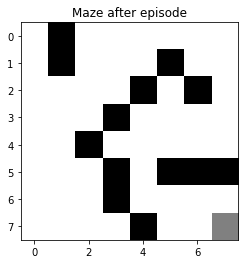

Epoch: 387/999 | Loss: 0.0004 | Episodes: 388 | Win count: 368 | Win rate: 1.000 | time: 1.29 hours
Loss:  0.00041767679067561403
Loss:  0.000668895459966734
Loss:  0.0003788094036281109
Loss:  0.0006396119715645909
Loss:  0.0007135673949960619


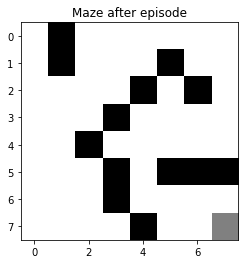

Epoch: 388/999 | Loss: 0.0007 | Episodes: 389 | Win count: 369 | Win rate: 1.000 | time: 1.30 hours
Loss:  0.0004590239404933527
Loss:  0.0006386372551787645
Loss:  0.00026384742523077875
Loss:  0.000638510609860532
Loss:  0.0009587704844307154
Loss:  0.00041854314622469246
Loss:  0.00047708245256217197
Loss:  0.0007596208015456796
Loss:  0.00029544201970566064
Loss:  0.00042218963790219277
Loss:  0.00036489369813352823
Loss:  0.0006090030292398296
Loss:  0.0007164678536355495
Loss:  0.0005670004611602053
Loss:  0.0004253472143318504
Loss:  0.0004978243377991021
Loss:  0.000354416679329006
Loss:  0.0007739827706245705


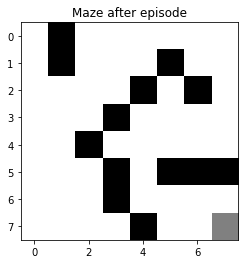

Epoch: 389/999 | Loss: 0.0008 | Episodes: 390 | Win count: 370 | Win rate: 1.000 | time: 1.30 hours
Loss:  0.000329162270645611
Loss:  0.0006975126743782312
Loss:  0.0005814139585709199
Loss:  0.00011197195271961391
Loss:  0.0007351032108999789
Loss:  0.00018022647418547422
Loss:  0.0003378738765604794
Loss:  0.0009483238100074232
Loss:  0.0006033858517184854
Loss:  0.0003561743797035888
Loss:  0.0007032860885374248
Loss:  0.000631481729215011
Loss:  0.0006606561073567718
Loss:  0.00033801724202930927
Loss:  0.0006655582110397518
Loss:  0.0007848762033972889
Loss:  0.0010133139876415953
Loss:  0.0007363465265370905
Loss:  0.000835287559311837
Loss:  0.0010251071653328836
Loss:  0.0008006685457075946
Loss:  0.00043524404463823885
Loss:  0.00042966430191881955
Loss:  0.0002553488448029384
Loss:  0.0005679314490407705
Loss:  0.0007122666866052896
Loss:  0.0006204246892593801
Loss:  0.0005081563431303948
Loss:  0.0010450154659338295
Loss:  0.00012480765144573525
Loss:  0.000920540187507867

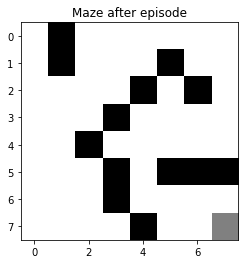

Epoch: 390/999 | Loss: 0.0008 | Episodes: 391 | Win count: 371 | Win rate: 1.000 | time: 1.30 hours
Loss:  0.00059661349223461
Loss:  0.00023395355674438179
Loss:  0.00011550127237569541
Loss:  0.0005442120600491762
Loss:  0.0007838201127015054
Loss:  0.0003653967578429729
Loss:  0.0005342024815035984
Loss:  0.00022830060697742738


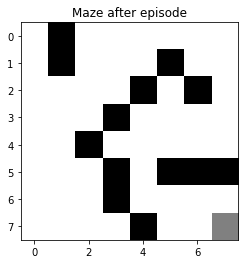

Epoch: 391/999 | Loss: 0.0002 | Episodes: 392 | Win count: 372 | Win rate: 1.000 | time: 1.30 hours
Loss:  0.0002546642208471894
Loss:  0.0005251758848316967
Loss:  0.0005310381093295291
Loss:  0.0009620812488719821
Loss:  0.0006785012374166399
Loss:  0.00042776079499162734
Loss:  0.0005317090108292177
Loss:  0.0006221852381713688
Loss:  0.0005620087031275034
Loss:  0.0002645187414600514
Loss:  0.0006145269435364753
Loss:  0.00015551037358818576
Loss:  0.0008524020959157497
Loss:  0.00037508661625906825
Loss:  0.00039513715455541387
Loss:  0.0002972351649077609
Loss:  0.00033927548429346643
Loss:  0.0002996353432536125
Loss:  0.000533275946509093


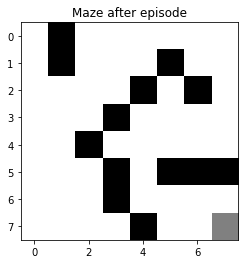

Epoch: 392/999 | Loss: 0.0005 | Episodes: 393 | Win count: 373 | Win rate: 1.000 | time: 1.30 hours
Loss:  0.0005409247823990881
Loss:  0.0003621285177359823
Loss:  0.000530733639607206
Loss:  0.0004718244163086638
Loss:  0.0004710284265456721
Loss:  0.0001829843458835967
Loss:  0.0005604996695183218
Loss:  0.00032860560168046504
Loss:  0.0007142835092963651
Loss:  0.0004567882715491578
Loss:  0.0005281385674607009
Loss:  0.0007419552130158991
Loss:  0.00047159503446891904
Loss:  0.0004285619070287794
Loss:  0.0004330975207267329
Loss:  0.0004586333379847929
Loss:  0.0006641327927354723
Loss:  0.00033558364521013573
Loss:  0.0005802351588499732
Loss:  0.0006844129966339096
Loss:  0.0009104179916903377
Loss:  0.00020922994008287787
Loss:  0.0003710899472935125
Loss:  0.00017334302538074553
Loss:  0.00016172345931408927
Loss:  0.0005803617823403329
Loss:  0.00045972716179676354


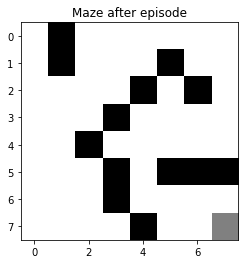

Epoch: 393/999 | Loss: 0.0005 | Episodes: 394 | Win count: 374 | Win rate: 1.000 | time: 1.31 hours
Loss:  0.00023767763923387975
Loss:  0.00046552714775316417
Loss:  0.0007901086064521223
Loss:  0.000375252595404163
Loss:  0.0007170484168455005
Loss:  0.000998436356894672
Loss:  0.0005734716542065144
Loss:  0.0005105287709739059
Loss:  0.00047070176515262574
Loss:  0.0003985637304140255
Loss:  0.0006179260308272205
Loss:  0.0006956132419873029
Loss:  0.0006881952576804906
Loss:  0.0005279374454403296
Loss:  0.0005205629131523892
Loss:  0.0007331164088100195
Loss:  0.0005707458039978519
Loss:  0.0002581952139735222
Loss:  0.0004718164127552882
Loss:  0.0007939247880131006
Loss:  9.742110705701634e-05
Loss:  0.00011229817027924582


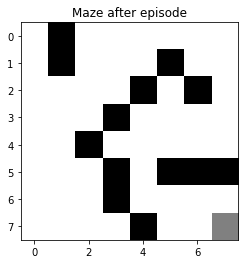

Epoch: 394/999 | Loss: 0.0001 | Episodes: 395 | Win count: 375 | Win rate: 1.000 | time: 1.31 hours
Loss:  0.000475043649203144
Loss:  0.00014550255218637176
Loss:  0.0007570553898403887
Loss:  0.00035532633773982525
Loss:  0.0007006455125520006
Loss:  0.0005189390358282253
Loss:  0.0003907609498128295
Loss:  0.0003137921739835292
Loss:  0.0005702537455363199
Loss:  0.0003001355944434181
Loss:  0.0002383157807344105
Loss:  0.0006057532445993274
Loss:  0.0004636682278942317
Loss:  0.0004662599822040647


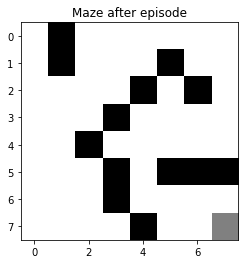

Epoch: 395/999 | Loss: 0.0005 | Episodes: 396 | Win count: 376 | Win rate: 1.000 | time: 1.31 hours
Loss:  0.0004918658232782036
Loss:  0.0002937679091701284


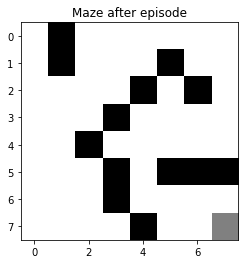

Epoch: 396/999 | Loss: 0.0003 | Episodes: 397 | Win count: 377 | Win rate: 1.000 | time: 1.31 hours
Loss:  0.00025743960577528924
Loss:  0.0006868911441415548
Loss:  0.0007999318186193705
Loss:  0.0004702114674728364
Loss:  0.0005371487495722249
Loss:  0.000468144949991256
Loss:  0.0006026510818628594
Loss:  0.001033741282299161


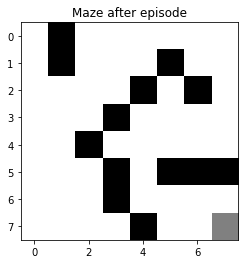

Epoch: 397/999 | Loss: 0.0010 | Episodes: 398 | Win count: 378 | Win rate: 1.000 | time: 1.31 hours
Loss:  0.00033962119778152555
Loss:  0.0007669426267966628
Loss:  0.00013664566358784214
Loss:  0.0004170486645307392
Loss:  0.0004669615809689276
Loss:  0.00040851229277905077
Loss:  0.0003481259773252532
Loss:  0.0004917805053992197
Loss:  0.0004587064831866883
Loss:  0.0004134529153816402
Loss:  0.0003277115029050037
Loss:  0.0004841108020627871
Loss:  0.0005169430514797568


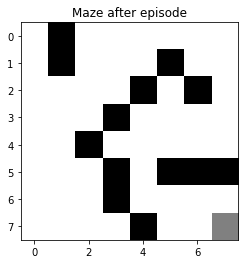

Epoch: 398/999 | Loss: 0.0005 | Episodes: 399 | Win count: 379 | Win rate: 1.000 | time: 1.31 hours
Loss:  0.0006994225550442934
Loss:  0.0005699135799659416
Loss:  0.00042053224751725793


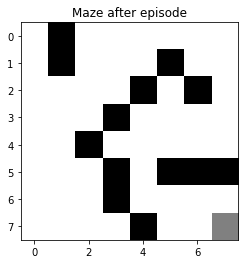

Epoch: 399/999 | Loss: 0.0004 | Episodes: 400 | Win count: 380 | Win rate: 1.000 | time: 1.31 hours
Loss:  0.0006176202732603997
Loss:  0.00020844417304033414
Loss:  0.00047394823923241347
Loss:  0.0005077024543425068
Loss:  0.00017069816385628656
Loss:  0.0005169261567061767


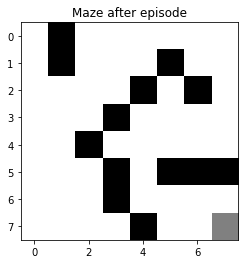

Epoch: 400/999 | Loss: 0.0005 | Episodes: 401 | Win count: 381 | Win rate: 1.000 | time: 1.31 hours
Loss:  0.0003174182838847628
Loss:  0.0004952008603140712
Loss:  0.00036884506698697805
Loss:  0.00046917717554606497
Loss:  0.0008797416521701962
Loss:  0.00024334105546586215
Loss:  0.00042132422095164657
Loss:  0.0010366000060457736
Loss:  0.0004653356700146105
Loss:  0.0006900263542775065
Loss:  0.0008276843873318285
Loss:  0.0005242936313152313
Loss:  0.0006769312603864819
Loss:  0.00047060567885637283
Loss:  0.00048423999396618456
Loss:  0.00030653436988359317
Loss:  0.000517224645591341
Loss:  0.00028423647745512426
Loss:  0.00020948688325006515
Loss:  0.00040685341809876263
Loss:  0.00047845023800618947
Loss:  0.0005242915649432689
Loss:  0.00013906084495829418
Loss:  0.0008614914549980313
Loss:  0.0007443191425409168
Loss:  0.0006195291498443112
Loss:  0.0002575496837380342
Loss:  0.0009290718589909375
Loss:  0.0008933681529015303
Loss:  0.0009220769861713052
Loss:  0.0002388011

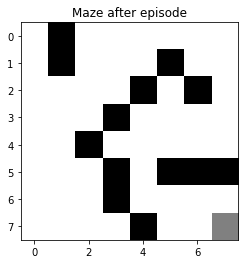

Epoch: 401/999 | Loss: 0.0008 | Episodes: 402 | Win count: 382 | Win rate: 1.000 | time: 1.31 hours
Loss:  0.0004629711838788353
Loss:  0.0008067621383816004
Loss:  0.0005994797393213958
Loss:  0.0005160068540135399
Loss:  0.0005700187321053818
Loss:  0.0004719969438156113
Loss:  0.0007304562604986131
Loss:  0.00043119418842252344
Loss:  0.0005885616337764077
Loss:  0.0005821257655043155
Loss:  0.0003667306446004659
Loss:  0.0008985972090158612
Loss:  0.000274137630185578
Loss:  0.0009980734903365374
Loss:  0.0006372030475176871
Loss:  0.00032786121300887316
Loss:  0.0002128001578967087
Loss:  0.00020053319167345762
Loss:  0.00034871707612182945
Loss:  0.00036455970257520676
Loss:  0.0006967296067159623
Loss:  0.00033954584796447307
Loss:  0.0008773882291279733
Loss:  0.0007898235053289682
Loss:  0.00028493978607002646
Loss:  0.0006758274976164103
Loss:  0.0005283137143123895
Loss:  0.0003659209032775834
Loss:  0.000591161529882811
Loss:  0.00023696013522567227
Loss:  0.000243450223933

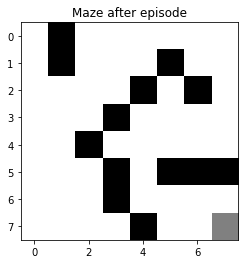

Epoch: 402/999 | Loss: 0.0004 | Episodes: 403 | Win count: 383 | Win rate: 1.000 | time: 1.32 hours
Loss:  0.00039750947325956076
Loss:  0.0002556485778768547
Loss:  0.0006990444962866604
Loss:  0.0006278001237660646
Loss:  0.0002676742406038102
Loss:  0.0002685651124920696
Loss:  0.0006289369339356199


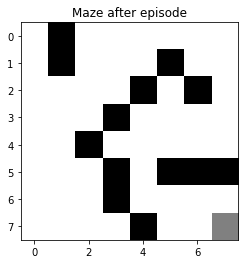

Epoch: 403/999 | Loss: 0.0006 | Episodes: 404 | Win count: 384 | Win rate: 1.000 | time: 1.32 hours
Loss:  0.00024716928237467073
Loss:  0.0003908439539372921
Loss:  0.0004076899349456653
Loss:  0.0004991410532966256
Loss:  0.0003380455746082589
Loss:  0.0008745778468437493
Loss:  0.00020132104691583663
Loss:  0.000518427201313898


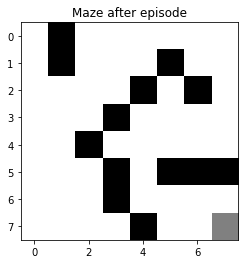

Epoch: 404/999 | Loss: 0.0005 | Episodes: 405 | Win count: 385 | Win rate: 1.000 | time: 1.32 hours
Loss:  0.00046145178203005344
Loss:  0.0008326267707161605
Loss:  0.0005226892535574734
Loss:  0.0007398951565846801
Loss:  0.0005210739836911671
Loss:  0.0005214969132794067
Loss:  0.0007078559719957411


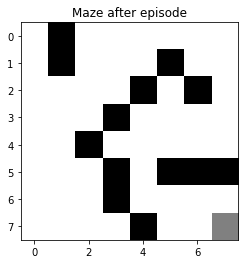

Epoch: 405/999 | Loss: 0.0007 | Episodes: 406 | Win count: 386 | Win rate: 1.000 | time: 1.32 hours
Loss:  0.00040134196751751006
Loss:  9.005614992929623e-05
Loss:  0.0008512758067809045
Loss:  0.00034713459899649024
Loss:  0.0004440459015313536
Loss:  0.0008069354807958007
Loss:  0.0004453253641258925
Loss:  0.000747553160181269
Loss:  0.0003362930874573067
Loss:  0.0004766969650518149
Loss:  0.00023506017896579579
Loss:  0.0002844199552782811
Loss:  0.0003062284959014505
Loss:  9.580183541402221e-05
Loss:  0.0003860779106616974
Loss:  0.0005812041345052421
Loss:  0.00029120374529156834
Loss:  0.00043912685941904783
Loss:  0.0003031081287190318
Loss:  0.0006373937503667548
Loss:  0.000505062096635811
Loss:  0.0007469756819773465
Loss:  0.0005388885329011828
Loss:  0.0008095601224340498
Loss:  0.0005231450304563623
Loss:  0.0007634423964191228
Loss:  0.0007976878550834954
Loss:  0.0006522180046886206
Loss:  0.0006569222605321556
Loss:  0.0004195060464553535
Loss:  0.000168566308275330

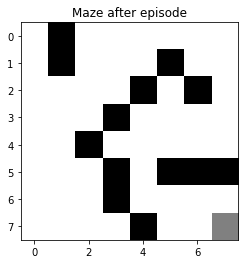

Epoch: 406/999 | Loss: 0.0002 | Episodes: 407 | Win count: 387 | Win rate: 1.000 | time: 1.32 hours
Loss:  0.0002943596482509747
Loss:  0.001051981293130666


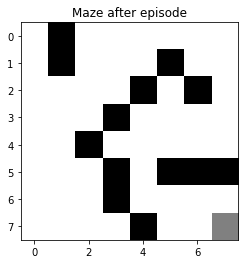

Epoch: 407/999 | Loss: 0.0011 | Episodes: 408 | Win count: 388 | Win rate: 1.000 | time: 1.32 hours
Loss:  0.0004083456005901098
Loss:  0.0005955391243332997
Loss:  0.0008719241595827043
Loss:  0.0006807907193433493
Loss:  0.00044847873505204916
Loss:  0.0003172482829540968
Loss:  0.00037170473660808057
Loss:  0.0003878722054651007
Loss:  0.0003142680070595816
Loss:  0.00015800192340975627
Loss:  0.0005856035277247429
Loss:  0.00033168878871947527
Loss:  0.0009359432442579418
Loss:  0.0006269844016060233


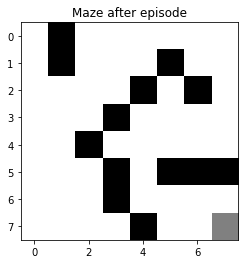

Epoch: 408/999 | Loss: 0.0006 | Episodes: 409 | Win count: 389 | Win rate: 1.000 | time: 1.32 hours
Loss:  0.0007030874112388119
Loss:  0.000344321146258153
Loss:  0.0006759035168215632
Loss:  0.0003490575691103004
Loss:  0.0005008023581467569
Loss:  0.0005014252092223614
Loss:  0.00033561623422428966
Loss:  0.000475849345093593
Loss:  0.00010408514390292112
Loss:  0.0003539527824614197
Loss:  0.0007673600921407342
Loss:  0.0004706230974989012
Loss:  0.00043618379277177155
Loss:  0.0003146128510707058
Loss:  0.0002167351540265372
Loss:  0.0008961963467299938
Loss:  0.0004393694398459047
Loss:  0.00015049049034132622
Loss:  0.0004034290832350962
Loss:  0.0003516584947647061
Loss:  0.0005241136095719412
Loss:  0.0002027163645834662
Loss:  0.0006775173678761348
Loss:  0.0004928821035719011
Loss:  0.0006071041570976377
Loss:  0.0006494969857158139


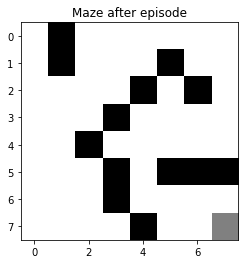

Epoch: 409/999 | Loss: 0.0006 | Episodes: 410 | Win count: 390 | Win rate: 1.000 | time: 1.33 hours
Loss:  0.0008325414964929223
Loss:  0.0006858546403236687
Loss:  0.00035899692738894373
Loss:  0.00032725608616601676
Loss:  0.0007645391306141391
Loss:  0.0003683155809994787
Loss:  0.0006613079749513417
Loss:  0.0005605904443655163
Loss:  0.0004051991563756019
Loss:  0.0005017311632400379
Loss:  0.0003469609946478158
Loss:  0.0006718420772813261
Loss:  0.00017430059961043298
Loss:  0.00028981539071537554
Loss:  0.00043092455598525703
Loss:  0.0005347714468371123
Loss:  0.0006590425909962505
Loss:  0.0005415508057922125
Loss:  0.00034953723661601543
Loss:  0.0006684718537144363
Loss:  0.00037922362389508635
Loss:  0.000446325539087411
Loss:  0.0003560151017154567
Loss:  0.0006633427401538938
Loss:  0.00038148970634210855
Loss:  0.0004832274207728915
Loss:  0.0005157951527507976
Loss:  0.0005936573434155434
Loss:  0.0005552575748879462
Loss:  0.0005682221380993724
Loss:  0.00052049316582

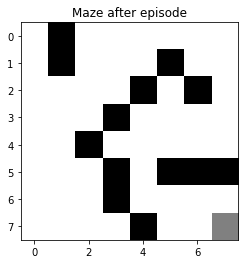

Epoch: 410/999 | Loss: 0.0007 | Episodes: 411 | Win count: 391 | Win rate: 1.000 | time: 1.33 hours
Loss:  0.00063126246095635
Loss:  0.0005207322828937322
Loss:  0.0004646366724045947
Loss:  0.0005059941613581032
Loss:  0.0008097418176475912
Loss:  0.0003189931157976389
Loss:  0.0005304729711497203
Loss:  0.00037115608574822545
Loss:  0.00043990537233185023
Loss:  0.0005955001979600638
Loss:  0.0004219988186378032
Loss:  0.0006751205364707857
Loss:  0.0007204209396149963
Loss:  0.0009426020260434598
Loss:  0.0004830960533581674
Loss:  0.0004977103089913726
Loss:  0.0005835991614731029
Loss:  0.00037955085281282663
Loss:  0.0002215768618043512
Loss:  0.0004060829378431663
Loss:  0.00036502523289527744
Loss:  0.0004894413868896663
Loss:  0.0003080938768107444
Loss:  0.00020618701455532573
Loss:  0.000525701034348458
Loss:  0.00040561938658356667


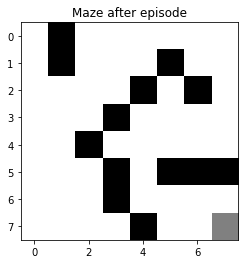

Epoch: 411/999 | Loss: 0.0004 | Episodes: 412 | Win count: 392 | Win rate: 1.000 | time: 1.33 hours
Loss:  0.0003014683607034385
Loss:  0.00025536673274473287
Loss:  0.0003545985746313818
Loss:  0.00030557403806596994
Loss:  0.0005747644026996568
Loss:  0.0005518434627447277
Loss:  0.0005906403239350766
Loss:  0.00037937679735478014
Loss:  0.0003889420040650293
Loss:  0.0004878370382357389
Loss:  0.0005894584173802286
Loss:  0.00046074776037130505
Loss:  0.000615715398453176
Loss:  0.00029171664937166497
Loss:  0.0004509755308390595
Loss:  0.00023578271793667227
Loss:  0.0002802917042572517
Loss:  0.0005059483519289643
Loss:  0.00047921900113578886
Loss:  0.0007866537489462644
Loss:  0.00040993758011609316
Loss:  0.0006265003175940365


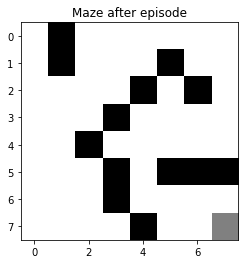

Epoch: 412/999 | Loss: 0.0006 | Episodes: 413 | Win count: 393 | Win rate: 1.000 | time: 1.33 hours
Loss:  0.0004802862531505525
Loss:  0.0005913559289183468
Loss:  0.0003879410069203004
Loss:  0.0008613119425717741
Loss:  0.0008426459971815348
Loss:  0.0004776654823217541
Loss:  0.0006774725043214858
Loss:  0.00034226688148919493
Loss:  0.0004024451627628878
Loss:  0.0006265546835493296
Loss:  0.00026528471062192693
Loss:  0.0006872971425764263
Loss:  0.0004732238739961758
Loss:  0.00031598316854797304
Loss:  0.0003606567479437217
Loss:  0.00039434164864360355
Loss:  0.0005868074222235009
Loss:  0.00017270375974476337
Loss:  0.0004671803180826828
Loss:  0.00037345340388128534
Loss:  0.0005115564854349941
Loss:  0.00031502767524216324
Loss:  0.0007972189196152613
Loss:  0.0005626813508570194
Loss:  0.0004625303263310343
Loss:  0.000535295665031299
Loss:  0.0003091027756454423
Loss:  5.702074304281268e-05
Loss:  0.0005556420655921102
Loss:  0.00044988053559791297


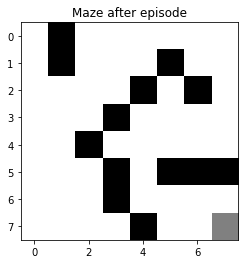

Epoch: 413/999 | Loss: 0.0004 | Episodes: 414 | Win count: 394 | Win rate: 1.000 | time: 1.34 hours
Loss:  0.0004449763218872249
Loss:  0.00023433634123648517
Loss:  0.00034383202000753954
Loss:  0.0003738998930202797
Loss:  0.00011303853534627706
Loss:  0.0004500341528910212
Loss:  0.0005716481246054173
Loss:  0.00028931476117577404
Loss:  0.0004781740499311127
Loss:  0.0004342409301898442
Loss:  0.0006004149909131229
Loss:  0.0002577359991846606
Loss:  0.0003373931394889951
Loss:  9.093212429434061e-05
Loss:  0.0008418516081292182
Loss:  0.00020853149908361956
Loss:  0.00025868756711133756
Loss:  0.0003082749026361853
Loss:  0.0011257804289925843
Loss:  0.00039194901182781905
Loss:  0.0004976766795152798
Loss:  0.000334634751197882
Loss:  0.0006281772075453773
Loss:  0.000777631823439151
Loss:  0.000499896370456554
Loss:  0.0003550745459506288
Loss:  0.00027670362032949924
Loss:  0.000561349093914032
Loss:  0.000309626804664731
Loss:  0.00025913329773175064
Loss:  0.00019579408399295

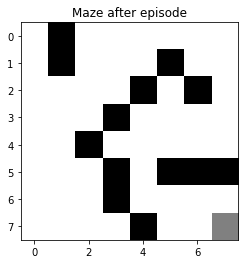

Epoch: 414/999 | Loss: 0.0002 | Episodes: 415 | Win count: 395 | Win rate: 1.000 | time: 1.34 hours
Loss:  0.0004036480968352407
Loss:  0.000179349968675524
Loss:  0.00014404037938220426
Loss:  0.0003355947083036881
Loss:  0.00044747644278686494
Loss:  7.833224663045257e-05
Loss:  0.00043396178080001846
Loss:  0.0003682248207041994
Loss:  0.000728869519662112
Loss:  0.00035439639759715647
Loss:  0.0009537454461678863
Loss:  0.0002365710970479995
Loss:  0.0005369978898670524
Loss:  0.00032345184445148334
Loss:  0.00045558616693597287
Loss:  0.0006949534872546792
Loss:  0.0007962607778608799
Loss:  0.00043074454879388213
Loss:  0.0007616903312737122
Loss:  0.000687565523548983


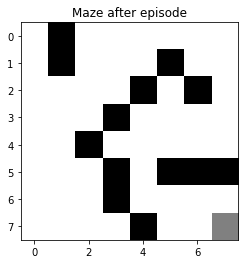

Epoch: 415/999 | Loss: 0.0007 | Episodes: 416 | Win count: 396 | Win rate: 1.000 | time: 1.34 hours
Loss:  0.0007936725742183626
Loss:  0.00032875842589419335
Loss:  0.00031333480728790164
Loss:  0.000903341278899461
Loss:  0.00042061514977831393
Loss:  0.00046133941214066
Loss:  0.0002779669448500499
Loss:  0.00035193441726733
Loss:  0.0007364313933067024
Loss:  0.0005913023487664759
Loss:  0.000713926914613694
Loss:  0.0006233172898646444
Loss:  0.0007991004385985434
Loss:  0.0006456570117734373
Loss:  0.0005512919015018269
Loss:  0.0006643764209002256
Loss:  0.0010055650200229138
Loss:  0.0006688629509881139
Loss:  0.0005746525566792116
Loss:  0.00044758792500942945
Loss:  0.0005847348948009312
Loss:  0.0007223229331430048
Loss:  0.0005064595461590216
Loss:  0.00062889615946915
Loss:  0.0006057003338355571
Loss:  0.0002898139282478951
Loss:  0.0007521414663642645
Loss:  0.00044016371248289943
Loss:  0.0003361577691975981
Loss:  0.0006426674226531759
Loss:  0.000470772894914262
Loss:

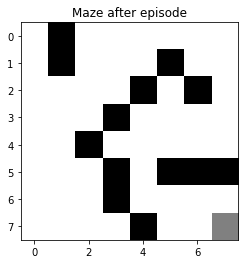

Epoch: 416/999 | Loss: 0.0005 | Episodes: 417 | Win count: 397 | Win rate: 1.000 | time: 1.35 hours
Loss:  0.0006580654007848352
Loss:  0.0005811686569359154
Loss:  0.0005188279028516263
Loss:  0.0004548225842881948
Loss:  0.0005381394003052264
Loss:  0.00038097619835752994
Loss:  0.0005730953416787088


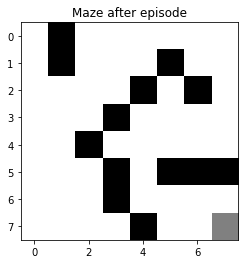

Epoch: 417/999 | Loss: 0.0006 | Episodes: 418 | Win count: 398 | Win rate: 1.000 | time: 1.35 hours
Loss:  0.000734556233510375
Loss:  0.000639202946331352
Loss:  0.0004893993318546563
Loss:  0.0004076542245456949
Loss:  0.0005710651894332841
Loss:  0.0005840890516992658
Loss:  0.0004431807465152815
Loss:  0.0007008292886894196
Loss:  0.0006106366054154932
Loss:  0.0005621195596177131
Loss:  0.00034305269946344197
Loss:  0.000403625046601519
Loss:  0.0007633812783751637
Loss:  0.0006356329686241224


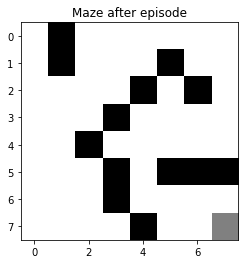

Epoch: 418/999 | Loss: 0.0006 | Episodes: 419 | Win count: 399 | Win rate: 1.000 | time: 1.35 hours
Loss:  0.000612369243754074
Loss:  0.0005567081097979099
Loss:  0.0004040433996124193
Loss:  0.0002811310478136875
Loss:  0.0003273287584306672
Loss:  0.0006305060378508642
Loss:  0.0005858179647475481
Loss:  0.00032865948014659807
Loss:  0.0004338845028541982
Loss:  0.0005438323714770377
Loss:  0.00042098845005966723
Loss:  0.0005885203136131167
Loss:  0.0006100352911744267
Loss:  0.00013192132610129192
Loss:  0.0004972107708454132
Loss:  0.0005964934680378065
Loss:  0.00038073370524216443


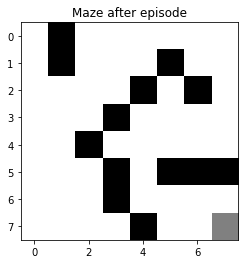

Epoch: 419/999 | Loss: 0.0004 | Episodes: 420 | Win count: 400 | Win rate: 1.000 | time: 1.35 hours
Loss:  0.0004539832007139921
Loss:  0.0005658596928697079
Loss:  0.00039221264887601137
Loss:  0.0005136435647727922
Loss:  0.0009872500086203218
Loss:  0.0004376296710688621
Loss:  0.0004572843463392928
Loss:  0.0005149210337549448
Loss:  0.0002068582471110858
Loss:  0.0006179437914397568
Loss:  0.0002769670718407724
Loss:  0.0004946050903527066
Loss:  0.0005168584175407887
Loss:  0.0005358318303478882
Loss:  0.0001479913444200065
Loss:  0.000414811831433326
Loss:  0.00043485729838721454
Loss:  0.00029287456709425896


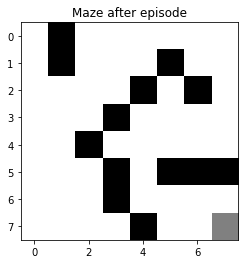

Epoch: 420/999 | Loss: 0.0003 | Episodes: 421 | Win count: 401 | Win rate: 1.000 | time: 1.35 hours
Loss:  0.0006896029226481915


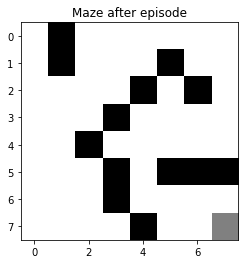

Epoch: 421/999 | Loss: 0.0007 | Episodes: 422 | Win count: 402 | Win rate: 1.000 | time: 1.35 hours
Loss:  0.0005668264348059893
Loss:  0.0007767942151986063
Loss:  0.00027858767134603113
Loss:  0.0004556058847811073
Loss:  0.0004005466616945341
Loss:  0.0004695735842688009
Loss:  0.0005605389596894383
Loss:  0.000528718956047669
Loss:  0.00018300165538676083
Loss:  0.0005807659472338855


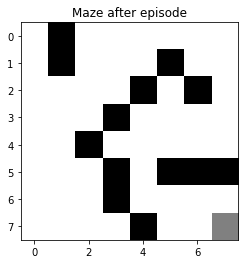

Epoch: 422/999 | Loss: 0.0006 | Episodes: 423 | Win count: 403 | Win rate: 1.000 | time: 1.36 hours
Loss:  0.0007897919276729226
Loss:  0.00041836775199044496
Loss:  0.0005410063313320279
Loss:  0.0006101792823756114
Loss:  0.0006924782355781645
Loss:  0.0001430013908247929
Loss:  0.0005508990143425763
Loss:  0.0011155112297274172
Loss:  0.0003928592341253534
Loss:  0.0003137959211017005
Loss:  0.0004894921439699829
Loss:  0.0006216878828126937
Loss:  0.00037096166488481686
Loss:  0.0004659589030779898
Loss:  0.0004475811874726787
Loss:  0.00020134123042225838


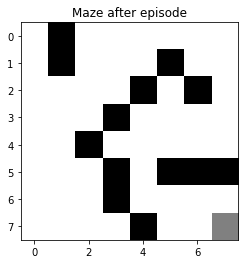

Epoch: 423/999 | Loss: 0.0002 | Episodes: 424 | Win count: 404 | Win rate: 1.000 | time: 1.36 hours
Loss:  0.0006175624439492822
Loss:  0.0002730276028160006
Loss:  0.0004040432977490127
Loss:  0.0004531456215772778
Loss:  0.0006922677566763014
Loss:  0.0004635121440514922
Loss:  0.00048222865734715015
Loss:  0.0001744478940963745
Loss:  0.0006421152502298355
Loss:  0.00042358756763860583
Loss:  0.0005860600213054568
Loss:  0.0004963456885889173
Loss:  0.000343369654729031
Loss:  0.0005702007038053125
Loss:  0.0006487040955107659
Loss:  0.0005189948424231261
Loss:  0.0006731920002494007
Loss:  0.0006478756404248998
Loss:  0.0002913773787440732
Loss:  0.00017511253827251494
Loss:  0.00045420837705023587
Loss:  0.0006765668222215027
Loss:  0.000603923195740208
Loss:  0.0007454133010469377
Loss:  0.00023844178576837294
Loss:  0.0003157995524816215
Loss:  0.00037470285315066576
Loss:  0.0006928590300958604
Loss:  0.000865019450429827


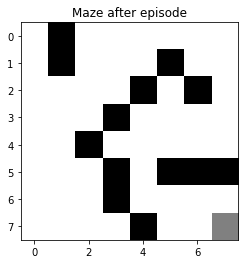

Epoch: 424/999 | Loss: 0.0009 | Episodes: 425 | Win count: 405 | Win rate: 1.000 | time: 1.36 hours
Loss:  0.0004205379373161122
Loss:  0.00025643666594987735
Loss:  0.0006126569642219692
Loss:  0.00035117435618303716
Loss:  0.00045420261449180543
Loss:  0.0007253200456034392
Loss:  0.00040324228029930964
Loss:  0.0007713772647548467
Loss:  0.000728035083739087
Loss:  0.0007077496848069131
Loss:  0.0005529832560569048
Loss:  0.0006955142598599195
Loss:  0.00032003712840378284
Loss:  0.0004077584744663909
Loss:  0.0010432968265376985


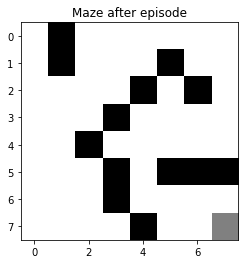

Epoch: 425/999 | Loss: 0.0010 | Episodes: 426 | Win count: 406 | Win rate: 1.000 | time: 1.36 hours
Loss:  0.0002720477059483528
Loss:  0.0005179802828934044
Loss:  0.0007258175901370123
Loss:  0.00039434015343431383
Loss:  0.00034876519930548966
Loss:  0.0005004635750083253


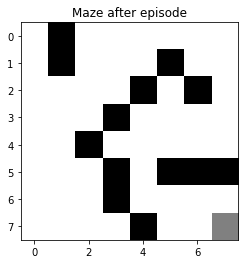

Epoch: 426/999 | Loss: 0.0005 | Episodes: 427 | Win count: 407 | Win rate: 1.000 | time: 1.36 hours
Loss:  0.0005322661309037358
Loss:  0.00036753041786141694
Loss:  0.0004708250053226948
Loss:  0.00029942297260276973
Loss:  0.0008221566677093506
Loss:  0.00026319490280002356
Loss:  0.0004631776610040106
Loss:  0.0006026327610015869
Loss:  0.00036744480894412845
Loss:  0.0004757122660521418
Loss:  0.0009771667828317732
Loss:  0.0005030783067923039
Loss:  0.00048124870227184147
Loss:  0.00035582645796239376
Loss:  0.000543093221494928
Loss:  0.0003285840939497575
Loss:  0.0009303892438765615
Loss:  0.0008039578096941113
Loss:  0.000379659904865548
Loss:  0.0004901565844193101
Loss:  0.0007967005949467421
Loss:  0.0004599739913828671
Loss:  0.000647405133349821
Loss:  0.0005351138825062662
Loss:  0.00046808409388177097
Loss:  0.00047593549243174493
Loss:  0.0005081917624920607
Loss:  0.0007634589564986527
Loss:  0.0005920373951084912
Loss:  0.0007856104639358819
Loss:  0.0008227215294027

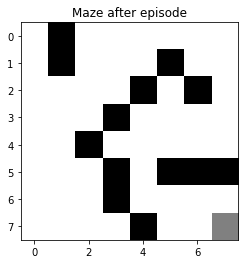

Epoch: 427/999 | Loss: 0.0004 | Episodes: 428 | Win count: 408 | Win rate: 1.000 | time: 1.37 hours
Loss:  0.00046529609244316816
Loss:  0.0006195121095515788
Loss:  0.0004907841357635334
Loss:  0.00047624063154216856
Loss:  0.0005627287755487487
Loss:  0.0004234696534695104
Loss:  0.00019638976664282382
Loss:  0.00015279318176908419
Loss:  0.000322394393151626
Loss:  0.0009118659072555602
Loss:  0.00050393606943544
Loss:  0.0005924355937168002
Loss:  0.0003798258549068123
Loss:  0.0005994860839564353
Loss:  0.0004838333552470431
Loss:  0.00021701972582377493
Loss:  0.00030579806480091065
Loss:  0.00048542494187131524


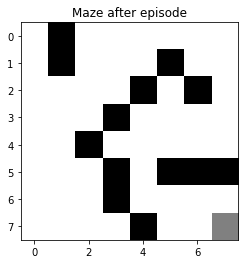

Epoch: 428/999 | Loss: 0.0005 | Episodes: 429 | Win count: 409 | Win rate: 1.000 | time: 1.37 hours
Loss:  0.00043768566683866084
Loss:  0.0004348221918917261
Loss:  0.0005844255065312609
Loss:  0.0003591472195694223
Loss:  0.0004910214192932472
Loss:  0.0007035760791040957
Loss:  0.00041618943214416504
Loss:  0.0003886425984092057
Loss:  9.67988307820633e-05
Loss:  0.0006590129632968456
Loss:  0.000687097170157358
Loss:  0.0006363283901009709
Loss:  0.0005219820159254596
Loss:  0.0005745007074438035
Loss:  0.000545443530427292
Loss:  0.000809107965324074
Loss:  0.000614177668467164
Loss:  0.0002136621333193034
Loss:  0.0002913187927333638
Loss:  0.00044177737436257303
Loss:  0.0006418277334887534
Loss:  0.0004255858948454261
Loss:  0.0003809640620602295
Loss:  0.00037170853465795517


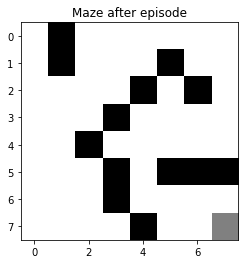

Epoch: 429/999 | Loss: 0.0004 | Episodes: 430 | Win count: 410 | Win rate: 1.000 | time: 1.37 hours
Loss:  0.0006268743018154055
Loss:  0.0007446061063092202
Loss:  0.0003603769146138802
Loss:  0.0004565446070046164
Loss:  0.0004407395317684859
Loss:  0.00034359384153503925
Loss:  0.0004954852920491248
Loss:  0.00048604165203869343
Loss:  0.000647639506496489
Loss:  0.0004237736138748005
Loss:  0.00039733930316288024
Loss:  0.00022669677127851173
Loss:  0.0005735863815061748
Loss:  0.0003329550818307325
Loss:  0.00032010868744691834
Loss:  0.0004138823424000293
Loss:  0.0007036485185381025
Loss:  0.00032877577177714556
Loss:  0.00067801313707605
Loss:  0.0005511797935469076
Loss:  0.0008098386169876903
Loss:  0.0007538011705037206
Loss:  0.0003116799198323861


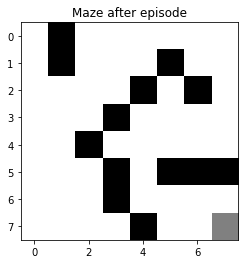

Epoch: 430/999 | Loss: 0.0003 | Episodes: 431 | Win count: 411 | Win rate: 1.000 | time: 1.37 hours
Loss:  0.00017867927090264857
Loss:  0.00040845088369678706
Loss:  0.0005327169346855953
Loss:  0.00035675449180416763
Loss:  0.000515466628712602
Loss:  0.0005503443244379014
Loss:  0.0003791008493863046
Loss:  0.00039437267696484923
Loss:  0.0005557121330639347
Loss:  0.0008816420449875295
Loss:  0.00041036115726456046
Loss:  0.0004598304658429697
Loss:  0.0006612454308196902
Loss:  0.00046610037679784
Loss:  0.0008419507066719234
Loss:  0.00021378409292083234
Loss:  0.0006924013432580978
Loss:  0.00036579846346285194
Loss:  0.00047277794510591775
Loss:  0.0006200304778758436
Loss:  0.0004427055537234992
Loss:  0.00017713649140205234
Loss:  0.00045143581519369036
Loss:  0.0004535814077826217
Loss:  0.00032930778252193704
Loss:  0.00044810162216890603
Loss:  0.000519208493642509
Loss:  0.0003196373727405444
Loss:  0.0002894684876082465
Loss:  0.0005823887040605769
Loss:  0.0004709411005

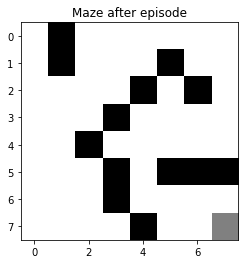

Epoch: 431/999 | Loss: 0.0007 | Episodes: 432 | Win count: 412 | Win rate: 1.000 | time: 1.37 hours
Loss:  0.0007958580972626805
Loss:  0.0004347274953033775
Loss:  0.0005745501402998343
Loss:  0.0002697738636925351
Loss:  0.00038831212441436946
Loss:  0.00034317857353016734
Loss:  0.0002534820305299945
Loss:  0.00022489602997666225
Loss:  0.00011804684800154064
Loss:  0.0004412076959852129
Loss:  0.0002980966164614074
Loss:  0.0005525675369426608


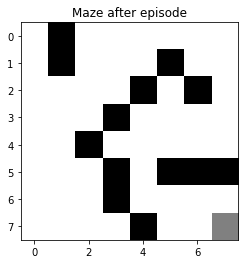

Epoch: 432/999 | Loss: 0.0006 | Episodes: 433 | Win count: 413 | Win rate: 1.000 | time: 1.38 hours
Loss:  0.00029099081075401045
Loss:  0.0004001086053904146
Loss:  0.0004965764528606087
Loss:  0.000492280290927738
Loss:  0.00044583974522538483
Loss:  0.0006873593374621123
Loss:  0.00017887487774714828
Loss:  0.00048054091166704893
Loss:  0.00017175023822346702
Loss:  0.0008458284428343177
Loss:  0.00041221550782211125
Loss:  0.00046500070311594754
Loss:  0.00013291356299305335
Loss:  0.00035417231265455484
Loss:  0.0003136226150672883
Loss:  0.0007176266517490149
Loss:  0.00029058733343845233
Loss:  0.0007244580192491412


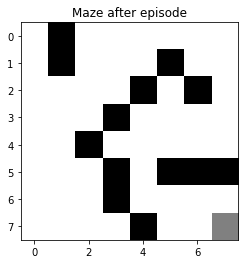

Epoch: 433/999 | Loss: 0.0007 | Episodes: 434 | Win count: 414 | Win rate: 1.000 | time: 1.38 hours
Loss:  0.0004662247665692121
Loss:  0.0003509230082272552
Loss:  0.0003555143339326605
Loss:  0.0006536376458825544
Loss:  0.00024919395218603313
Loss:  0.00029922059911768883
Loss:  0.0001829027314670384
Loss:  0.0005594893591478467
Loss:  0.00016063741350080818
Loss:  0.00033721559157129377
Loss:  0.0003708649310283363
Loss:  0.00022341441945172846
Loss:  0.00036492977233137935
Loss:  0.0002900257386500016
Loss:  0.00020974609651602805
Loss:  0.00015632988288416527
Loss:  0.0004874919541180134
Loss:  0.0005293445137795061
Loss:  0.0003102608461631462


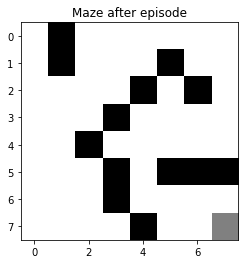

Epoch: 434/999 | Loss: 0.0003 | Episodes: 435 | Win count: 415 | Win rate: 1.000 | time: 1.38 hours
Loss:  0.00030036006501177326
Loss:  0.0004915157478535548
Loss:  0.00018867945618694648
Loss:  0.0005465935973916203
Loss:  0.0004354039701865986
Loss:  0.0006011859950376675
Loss:  0.0001580015741637908
Loss:  0.00017303390268352814
Loss:  0.0007252798532135785
Loss:  0.00035324334749020636
Loss:  0.0002693258866202086
Loss:  0.0002950155540020205
Loss:  0.00029557796369772404
Loss:  0.00041793252603383735
Loss:  0.000399851385736838
Loss:  0.0007370788953267038
Loss:  0.00035720127198146656
Loss:  0.0002653258343343623
Loss:  0.00036691289278678596
Loss:  0.00033714489836711437
Loss:  0.00017159876733785495
Loss:  0.0003070208476856351
Loss:  0.00028064363868907094
Loss:  0.00041111252357950434
Loss:  0.00025390982773387805
Loss:  0.0003768136302824132
Loss:  0.0003035725967492908
Loss:  0.0004904776142211631
Loss:  0.00029458097560564056
Loss:  0.0004350975505076349
Loss:  0.00017998

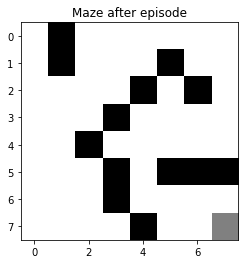

Epoch: 435/999 | Loss: 0.0004 | Episodes: 436 | Win count: 416 | Win rate: 1.000 | time: 1.38 hours
Loss:  0.0002688013046281412
Loss:  0.0005439324595499784
Loss:  0.00028522510547190905
Loss:  0.0004100605146959424
Loss:  0.00029173531220294535
Loss:  0.0001385630457662046
Loss:  0.0004252303915563971
Loss:  0.00017185697288368829
Loss:  0.0005046779697295278
Loss:  0.0005124119925312698
Loss:  0.00012544571654871106
Loss:  0.000243669594055973
Loss:  0.0001787203291314654
Loss:  0.0002730707637965679
Loss:  0.0004721868608612567
Loss:  0.0005014097841922194
Loss:  0.0005103206785861403
Loss:  0.0002629162117955275
Loss:  0.00013394612687989138
Loss:  0.0002610695155453868
Loss:  0.00015358281962107867


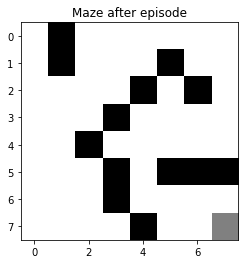

Epoch: 436/999 | Loss: 0.0002 | Episodes: 437 | Win count: 417 | Win rate: 1.000 | time: 1.39 hours
Loss:  9.798545215744525e-05
Loss:  0.0006449667853303254
Loss:  0.0008304115035571158
Loss:  0.0005907592712901533
Loss:  0.0004702157966676168
Loss:  0.0002896076184697449
Loss:  0.0006303721747826785
Loss:  0.00020814064919250086
Loss:  0.0003380750713404268
Loss:  0.0009657487971708179
Loss:  0.0004356930876383558
Loss:  0.00044446576430345885
Loss:  0.00031640956876799464
Loss:  0.0005651160608977079
Loss:  0.0005766742979176342
Loss:  0.000576610880671069
Loss:  0.0006641084037255496
Loss:  0.00041930805309675634
Loss:  0.0002991259898408316
Loss:  0.00038248589225986507
Loss:  0.00041392464481759816
Loss:  0.0003972909180447459
Loss:  0.0008052780758589506
Loss:  0.00054270496184472
Loss:  0.00048218473966699094
Loss:  0.00062891750712879


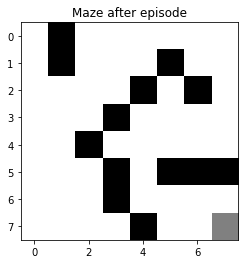

Epoch: 437/999 | Loss: 0.0006 | Episodes: 438 | Win count: 418 | Win rate: 1.000 | time: 1.39 hours
Loss:  0.0005878018564544618
Loss:  0.0003047788159165066
Loss:  0.0005744084337493405
Loss:  0.00032049251603893936
Loss:  0.0006137459422461689
Loss:  0.00034947456879308447
Loss:  0.0005285799852572381
Loss:  0.00036042438296135515
Loss:  0.0004891432981821708
Loss:  0.0002077373064821586
Loss:  0.000392140427720733
Loss:  0.0007888413674663752
Loss:  0.00029158766119508073
Loss:  0.00027706765104085207
Loss:  0.00037697389780078083
Loss:  0.00042029401811305434
Loss:  0.00038106155989225954
Loss:  0.00048526038881391287
Loss:  0.0001578096707817167
Loss:  0.0004223252472002059
Loss:  9.214591045747511e-05


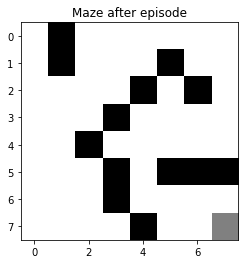

Epoch: 438/999 | Loss: 0.0001 | Episodes: 439 | Win count: 419 | Win rate: 1.000 | time: 1.39 hours
Loss:  0.00015783659182488918
Loss:  0.0003539227327564731
Loss:  0.00043108882528031245
Loss:  0.00046784452570136636
Loss:  0.0006209955317899585
Loss:  0.00034251430770382285
Loss:  0.0006490461237262934
Loss:  0.00034883542684838176
Loss:  0.0002849847951438278
Loss:  0.00032612596987746656
Loss:  0.00016915689411689527
Loss:  0.0005227308138273656
Loss:  0.0005774357414338738
Loss:  0.0005754733647336252
Loss:  0.00018735720368567854
Loss:  0.0003628540725912899
Loss:  0.0007696209941059351
Loss:  0.00025167559215333313
Loss:  0.00045175838749855757
Loss:  0.0006172563007567078
Loss:  0.0004288285126676783
Loss:  0.0003116727457381785
Loss:  0.0006009346689097583
Loss:  0.0005905994330532849
Loss:  0.0004140324017498642
Loss:  0.000450068706413731
Loss:  0.0006305513088591397
Loss:  0.00047812894626986235
Loss:  0.000509234145283699
Loss:  0.0006441279547289014
Loss:  0.000645602762

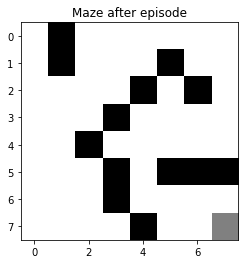

Epoch: 439/999 | Loss: 0.0007 | Episodes: 440 | Win count: 420 | Win rate: 1.000 | time: 1.39 hours
Loss:  0.0005975048552500084
Loss:  0.00035440634383121505
Loss:  0.0002849637021427043
Loss:  0.000633661518804729
Loss:  0.00022670727776130661
Loss:  0.0003679599758470431
Loss:  0.00019739652634598315
Loss:  0.0005331079591996968
Loss:  0.0006252569728530943
Loss:  0.0009329684544354677
Loss:  0.0001542863028589636
Loss:  0.0002463540658936836
Loss:  0.0003684324910864234
Loss:  0.000558329455088824
Loss:  0.0006079797312850133
Loss:  0.00022925766825210303
Loss:  0.00039292985456995666
Loss:  0.00039920110430102795
Loss:  0.0005464685964398086
Loss:  0.0003091019025305286
Loss:  0.0004817238514078781
Loss:  0.0006824798474553972
Loss:  0.0005890866741538048
Loss:  0.00022725661256117746
Loss:  0.0006141722988104448
Loss:  0.0005734526203013957
Loss:  0.0007955921755637974


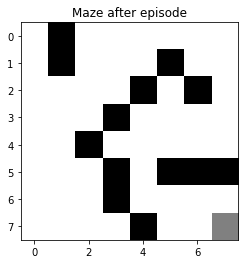

Epoch: 440/999 | Loss: 0.0008 | Episodes: 441 | Win count: 421 | Win rate: 1.000 | time: 1.40 hours
Loss:  0.0005360471695894375
Loss:  0.0006162288482300937
Loss:  0.00041827719542197883
Loss:  0.0002914513024734333
Loss:  0.0005616338894469664
Loss:  0.000418772833654657
Loss:  0.000896706129424274
Loss:  0.00033332090970361605
Loss:  0.0005078833637526259
Loss:  0.0002621562816784717
Loss:  0.00012388976392685436
Loss:  0.0009133132407441735
Loss:  8.665190762258135e-05
Loss:  0.0002459825082041789
Loss:  0.0003629887942224741
Loss:  0.00039245598964043893
Loss:  0.00026523106134845875
Loss:  0.0004981390229659155
Loss:  0.0005396840278990567
Loss:  0.0003840209792542737
Loss:  0.00024437339016003534
Loss:  0.0005821769300382584
Loss:  0.0002645600325195119
Loss:  0.0004246660100761801
Loss:  0.00018562140030553564
Loss:  0.00035853202280122787
Loss:  0.0005141778565302957
Loss:  0.00040750652260612696


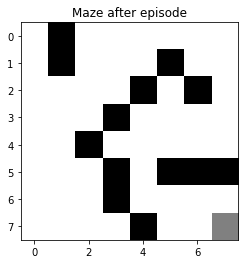

Epoch: 441/999 | Loss: 0.0004 | Episodes: 442 | Win count: 422 | Win rate: 1.000 | time: 1.40 hours
Loss:  0.00072319051832892
Loss:  0.0006416237883968279
Loss:  0.00010021777052315883
Loss:  8.03133734734729e-05
Loss:  4.2943120206473395e-05
Loss:  0.0006258527864702046
Loss:  8.573398372391239e-05
Loss:  0.00021848888172826264
Loss:  0.00040193194581661373
Loss:  0.0004930845025228336
Loss:  0.00119224120862782
Loss:  0.0003107615775661543
Loss:  0.0004515351465670392
Loss:  0.0007919119379948825
Loss:  0.0006917038117535412
Loss:  0.0005119349298183806
Loss:  0.0005219981539994478
Loss:  0.00043323337740730494
Loss:  0.0005046933074481785
Loss:  0.0004656264645745978
Loss:  0.0006097809528000653
Loss:  0.0007687601028010249
Loss:  0.0004172387416474521
Loss:  0.0006020386063028127
Loss:  0.000382339334464632
Loss:  9.399188274983317e-05
Loss:  0.0003480638661130797
Loss:  0.0006355644145514816
Loss:  0.0006457552808569744
Loss:  0.0007601096294820309
Loss:  0.0003756461082957685


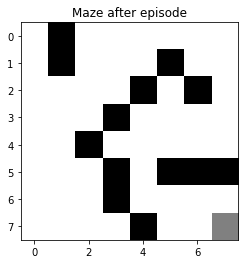

Epoch: 442/999 | Loss: 0.0004 | Episodes: 443 | Win count: 423 | Win rate: 1.000 | time: 1.40 hours
Loss:  0.0004919228376820683
Loss:  0.0007032517169136554
Loss:  0.0006626130198128521
Loss:  0.00030636855808552355
Loss:  0.0003398165281396359
Loss:  0.0008440387027803808
Loss:  0.0004256601387169212
Loss:  0.0007619463140144944
Loss:  0.0005455403443193063
Loss:  0.0003944451455026865
Loss:  0.0002718767063925043
Loss:  0.00042037872481159866
Loss:  0.0001747993883327581
Loss:  0.0005367877602111548
Loss:  0.000416046503232792
Loss:  0.00020940690592397004
Loss:  0.0004634740616893396
Loss:  0.0004274729799362831
Loss:  0.0004109911824343726
Loss:  0.0005010142340324819
Loss:  0.00073176235309802
Loss:  0.0003403663286007941
Loss:  0.0005573695234488696
Loss:  0.0005635898414766416
Loss:  0.0005823650863021612
Loss:  0.000500431953696534
Loss:  0.0002755767200142145
Loss:  0.0008511950727552176


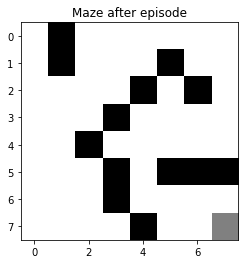

Epoch: 443/999 | Loss: 0.0009 | Episodes: 444 | Win count: 424 | Win rate: 1.000 | time: 1.41 hours
Loss:  0.00020053829939570278
Loss:  0.0003704406408360228
Loss:  0.0005144634487805888
Loss:  0.0005787519330624491
Loss:  0.0004568920412566513
Loss:  0.0002648308000061661
Loss:  0.0005080602131783962
Loss:  0.000370586320059374
Loss:  0.0007568208675365895
Loss:  0.0004620046238414943
Loss:  0.000637198070762679
Loss:  0.0005183735047467053
Loss:  0.0006816538807470351
Loss:  0.00035373976425034925
Loss:  0.00027193495770916343
Loss:  0.00040132366120815277
Loss:  0.0005648616643156856
Loss:  0.0006309726741164923
Loss:  0.0004365220302133821
Loss:  0.0005236720608081669
Loss:  0.0001982611465791706
Loss:  0.0004719527278211899
Loss:  0.0005128166521899402


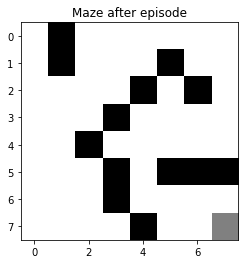

Epoch: 444/999 | Loss: 0.0005 | Episodes: 445 | Win count: 425 | Win rate: 1.000 | time: 1.41 hours
Loss:  0.0003972292906837538
Loss:  0.0003088414086960256
Loss:  0.0006397556862793863
Loss:  0.00035913145984523
Loss:  0.0003789649981627008
Loss:  0.00034523838257882744
Loss:  0.0008273431449197233
Loss:  0.000405746279284358
Loss:  0.00018397377425571904
Loss:  0.00022564663231605664
Loss:  0.0009746885334607214
Loss:  0.000377187694539316
Loss:  0.00026104322023456916


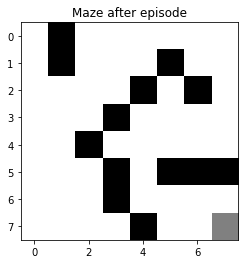

Epoch: 445/999 | Loss: 0.0003 | Episodes: 446 | Win count: 426 | Win rate: 1.000 | time: 1.41 hours
Loss:  0.00023208276616060175
Loss:  0.0005175845581106842
Loss:  0.0005660780443577096
Loss:  0.00020562252757372335
Loss:  0.00036647869274020195
Loss:  7.559702135040425e-05
Loss:  0.0006227874036994763
Loss:  4.991034074919298e-05
Loss:  0.00037680845707654953
Loss:  0.00029211196306278
Loss:  0.0004688125045504421
Loss:  0.00018942654423881322
Loss:  0.00034294977376703173
Loss:  0.00028541936626425013
Loss:  0.0003966915319324471
Loss:  0.00024390823091380298
Loss:  0.00040886742863222025
Loss:  0.000307934227748774
Loss:  0.0004580528839142062
Loss:  0.0004844898357987404
Loss:  0.0005307578685460612
Loss:  0.0003896971757058054
Loss:  0.0003301864635432139
Loss:  0.00038628833135589957
Loss:  0.00038268789649009705
Loss:  0.00022260464902501553
Loss:  0.00035597266105469316


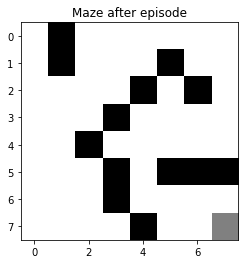

Epoch: 446/999 | Loss: 0.0004 | Episodes: 447 | Win count: 427 | Win rate: 1.000 | time: 1.41 hours
Loss:  0.0003314627683721483
Loss:  0.00023171963403001428
Loss:  0.0005235623539192602
Loss:  0.00019548978889361024
Loss:  0.000475388573249802
Loss:  0.0002212993786088191
Loss:  0.0003039094008272514
Loss:  0.00041524667176418006
Loss:  7.465675662388094e-05
Loss:  0.0005990461795590818
Loss:  0.0007137405045796186
Loss:  0.00020266904903110117
Loss:  0.0006117496232036501
Loss:  0.0001811652873584535
Loss:  0.000437323164078407
Loss:  0.0003701985551742837
Loss:  0.00033623386480030604
Loss:  0.0005217638972681016
Loss:  0.0007100958318915218


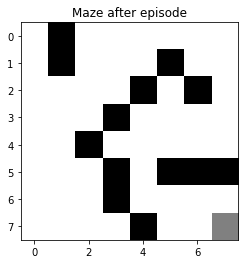

Epoch: 447/999 | Loss: 0.0007 | Episodes: 448 | Win count: 428 | Win rate: 1.000 | time: 1.41 hours
Loss:  0.00024219963233917952
Loss:  0.00012603219511220232
Loss:  0.0002139833231922239
Loss:  0.0008355856989510357
Loss:  0.0003993274876847863


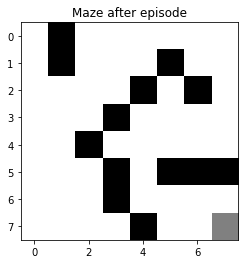

Epoch: 448/999 | Loss: 0.0004 | Episodes: 449 | Win count: 429 | Win rate: 1.000 | time: 1.41 hours
Loss:  0.00024643818323966116
Loss:  0.000330547962221317
Loss:  0.0003976486623287201
Loss:  0.00037068499659653753
Loss:  0.0003147969764540903
Loss:  0.0001526580708741676
Loss:  0.00022412353064282797


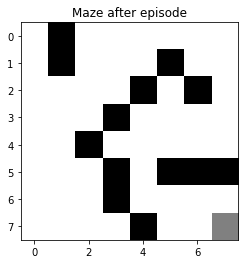

Epoch: 449/999 | Loss: 0.0002 | Episodes: 450 | Win count: 430 | Win rate: 1.000 | time: 1.42 hours
Loss:  0.00015705837358837016
Loss:  0.00031639300868846476
Loss:  0.00024222867068601772
Loss:  0.00029618200642289594
Loss:  0.0005123332230141386
Loss:  0.0006472928507719189
Loss:  0.0006949505768716335
Loss:  0.0004118547949474305
Loss:  0.00035497751377988607
Loss:  0.0005211241368670017
Loss:  0.0005116792453918606
Loss:  0.0002142472039849963
Loss:  0.00047116396308410913
Loss:  0.00034774854429997504
Loss:  0.000748785852920264
Loss:  0.0002550003628130071
Loss:  0.00030481675639748573
Loss:  0.0004476333560887724
Loss:  0.00044023175723850727
Loss:  0.000471297578769736
Loss:  0.000383619248168543
Loss:  0.0003055268134630751
Loss:  0.00022491471463581547
Loss:  0.00018073236788040958


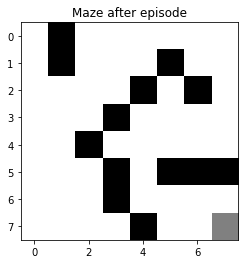

Epoch: 450/999 | Loss: 0.0002 | Episodes: 451 | Win count: 431 | Win rate: 1.000 | time: 1.42 hours
Loss:  0.00019840399181703106
Loss:  0.0003054156095458893
Loss:  0.0004982112441211939
Loss:  0.0002441234391881153
Loss:  0.0002666079381015152
Loss:  0.0004298499770811759
Loss:  0.0007238890684675425
Loss:  0.0002418288859189488
Loss:  0.00021658266268786974
Loss:  0.00030072596564423293


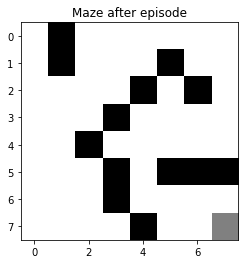

Epoch: 451/999 | Loss: 0.0003 | Episodes: 452 | Win count: 432 | Win rate: 1.000 | time: 1.42 hours
Loss:  0.0005272637499729171
Loss:  0.00035875197499990463
Loss:  0.0005106949611217715
Loss:  0.0004547590942820534
Loss:  0.0002690498222364113


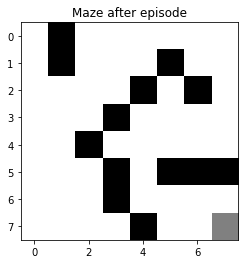

Epoch: 452/999 | Loss: 0.0003 | Episodes: 453 | Win count: 433 | Win rate: 1.000 | time: 1.42 hours
Loss:  9.751276593306102e-05
Loss:  9.83510326477699e-05
Loss:  0.0005981533322483301
Loss:  0.0002523942312109284
Loss:  0.00024389917962253094
Loss:  0.00016835888891364448
Loss:  0.0003305337595520541
Loss:  0.00018349234233028255
Loss:  6.270099402172491e-05
Loss:  0.0005061881238361821
Loss:  0.00020711235993076116
Loss:  0.0001875121524790302
Loss:  0.0002575454127509147
Loss:  0.0001570108979649376
Loss:  0.00025201864627888426
Loss:  0.0007447751413565129
Loss:  0.00028263303101994097
Loss:  0.0002235161155113019
Loss:  0.00030789393349550664
Loss:  0.0008131063950713724
Loss:  0.00039121590089052916
Loss:  0.00031658921579946764
Loss:  0.00026708675432018936
Loss:  0.0001746060952427797
Loss:  0.0007027476967778057


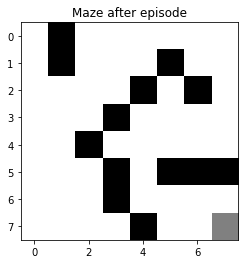

Epoch: 453/999 | Loss: 0.0007 | Episodes: 454 | Win count: 434 | Win rate: 1.000 | time: 1.42 hours
Loss:  0.0002752911823336035
Loss:  0.0003140136395813897
Loss:  0.0004038304032292217
Loss:  0.00043885041304747574
Loss:  0.00026704115589382127
Loss:  0.0005247407825663686
Loss:  0.0003177914986736141
Loss:  0.0003169512783642858
Loss:  0.00024158705491572618
Loss:  0.0002910029870690778
Loss:  0.00034512977799749933
Loss:  0.00033658507163636386
Loss:  0.000405330749345012
Loss:  0.00031686546572018415
Loss:  0.00040445033664582297
Loss:  0.00024606724764453247
Loss:  0.00023997623429750092
Loss:  0.0004876617604168132
Loss:  0.00034880515886470675
Loss:  0.0002028296767093707
Loss:  0.00035419154301052913
Loss:  0.0003976643638452515
Loss:  0.00017373012451571412


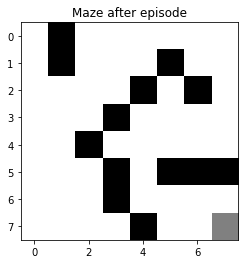

Epoch: 454/999 | Loss: 0.0002 | Episodes: 455 | Win count: 435 | Win rate: 1.000 | time: 1.43 hours
Loss:  0.00028557177574839443
Loss:  0.00023905967827886343
Loss:  0.00020566573402902577
Loss:  0.0003664895339170471
Loss:  0.0003223514504497871
Loss:  0.0005544729065150023
Loss:  0.00040694775816518813
Loss:  0.00028338486299617216
Loss:  0.00033952572994166985
Loss:  0.00043979873589705676
Loss:  0.00018837457537301816
Loss:  0.0003439876454649493
Loss:  7.268478111654986e-05
Loss:  0.0005109528865432367
Loss:  0.0006283824041020125
Loss:  0.0003304755227873102
Loss:  0.0002583579516794998
Loss:  0.00046426076733041555
Loss:  0.0007135291816666722
Loss:  0.00048064383736345917
Loss:  0.00033670223638182506
Loss:  0.0004181317053735256
Loss:  0.0007694454106967896
Loss:  0.00036061905848328024
Loss:  0.0003282199759269133
Loss:  0.00018483551684767008
Loss:  0.0002449440326017793
Loss:  0.0003545632789609954
Loss:  0.0002530794736230746


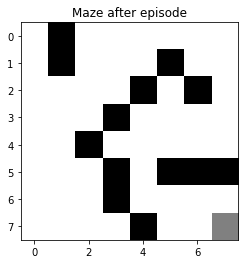

Epoch: 455/999 | Loss: 0.0003 | Episodes: 456 | Win count: 436 | Win rate: 1.000 | time: 1.43 hours
Loss:  0.0001933081193783437
Loss:  0.0004373589181341231
Loss:  0.0006825825548730791
Loss:  0.0003893406283168588
Loss:  0.00023979562683962286
Loss:  0.0005661274772137403
Loss:  0.0006839951674919575
Loss:  8.499695468344726e-05
Loss:  0.00044913335295859724
Loss:  0.000721194053767249
Loss:  0.0005268107342999429
Loss:  0.0007311903318623081
Loss:  0.00035829968692269176
Loss:  0.00025774104869924486
Loss:  0.0002081247657770291
Loss:  0.0007441905909217894
Loss:  0.00048638679436407983
Loss:  0.0005947068857494742
Loss:  0.00027448874607216567
Loss:  0.000277379724138882
Loss:  0.0002504250514903106
Loss:  0.0006570248515345156
Loss:  0.000325013323163148
Loss:  0.00014529719919664785
Loss:  0.0001869084699137602
Loss:  0.00043983288924209774


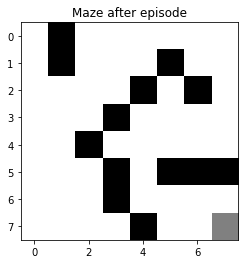

Epoch: 456/999 | Loss: 0.0004 | Episodes: 457 | Win count: 437 | Win rate: 1.000 | time: 1.43 hours
Loss:  0.00024125345225911587
Loss:  0.00031407264032168314
Loss:  0.0006133064744062722
Loss:  0.00015884286403888837
Loss:  0.0003645720389613416
Loss:  0.0005100478010717779
Loss:  0.0003245586121920496
Loss:  0.00023522709670942277
Loss:  0.00020701103858300485
Loss:  0.0001951707417902071
Loss:  0.00022140119108371437
Loss:  0.0003083603078266606
Loss:  0.00039413341801264323
Loss:  0.00035785588261205703
Loss:  0.00018843129146262072
Loss:  9.601649071555585e-05
Loss:  0.00042433807175257243
Loss:  0.00035272183595225215
Loss:  0.00042597789797582664
Loss:  0.0004860216286033392
Loss:  0.0003270476736361161


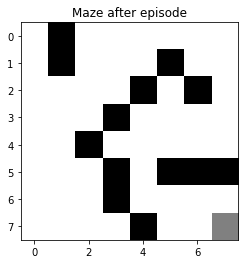

Epoch: 457/999 | Loss: 0.0003 | Episodes: 458 | Win count: 438 | Win rate: 1.000 | time: 1.43 hours
Loss:  0.000350720263668336
Loss:  0.00048582410090602934
Loss:  0.00022509493282996118
Loss:  0.0005946412711637095
Loss:  0.00021860971173737198
Loss:  0.00027738841890823096
Loss:  0.00041857401083689183
Loss:  0.0005181587184779346
Loss:  0.0004920484061585739
Loss:  0.0004651256531360559
Loss:  0.00036184614145895466
Loss:  0.00033151016396004707
Loss:  0.0004915881145279855
Loss:  7.581297177239321e-05
Loss:  0.00041211830102838576
Loss:  0.00023560808040201664
Loss:  0.00011174780229339376
Loss:  0.00020231240705470555
Loss:  0.00035413671866990626
Loss:  0.0005663620686391369
Loss:  0.00037447775684995577
Loss:  0.0003344131546327844
Loss:  0.0003519767014950048
Loss:  0.00036445914884097874
Loss:  0.000421691540395841
Loss:  0.00025374746473971754


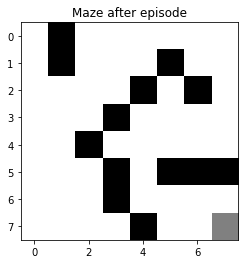

Epoch: 458/999 | Loss: 0.0003 | Episodes: 459 | Win count: 439 | Win rate: 1.000 | time: 1.44 hours
Loss:  0.0002134814130840823
Loss:  0.00048429021262563765
Loss:  0.00032019570789998397
Loss:  0.0006425495666917413
Loss:  0.0004414346185512841
Loss:  0.00032100313546834514
Loss:  0.00037613387758028693
Loss:  0.0002460153482388705
Loss:  0.00036922581784892827
Loss:  0.00024027023755479604
Loss:  0.0001767643407220021
Loss:  0.0005295313021633774
Loss:  0.000656981545034796
Loss:  0.00017257900617551059
Loss:  0.0005940515256952494
Loss:  0.00034317006065975875
Loss:  0.0004331647214712575
Loss:  0.0003693913313327357
Loss:  0.00019849078307743184
Loss:  0.00017842389934230596
Loss:  9.74187278188765e-05
Loss:  0.00024190642579924315


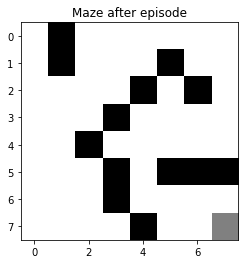

Epoch: 459/999 | Loss: 0.0002 | Episodes: 460 | Win count: 440 | Win rate: 1.000 | time: 1.44 hours
Loss:  0.0002401059027761221
Loss:  4.5435508582158946e-05
Loss:  0.00047927815467119217
Loss:  3.8548794691450894e-05


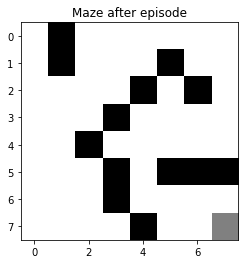

Epoch: 460/999 | Loss: 0.0000 | Episodes: 461 | Win count: 441 | Win rate: 1.000 | time: 1.44 hours
Loss:  0.0004300660039007198
Loss:  9.646002308727475e-05
Loss:  0.00019047654859605245
Loss:  0.00047710476792417467
Loss:  0.00020928568847011775
Loss:  0.0004812095357920043
Loss:  5.737501669500489e-05
Loss:  0.0005616493290290236
Loss:  0.00042814534390345216
Loss:  0.0004156771901762113
Loss:  0.0004859163600485772
Loss:  0.0004382453189464286
Loss:  0.00026775112200994045
Loss:  0.0002624984299472999
Loss:  0.0004783634503837675
Loss:  0.0004870021220995113
Loss:  0.0005096226668683812
Loss:  0.0003298684023320675
Loss:  0.0007383851188933477
Loss:  0.00021628077229252085
Loss:  0.0005296867748256773
Loss:  0.0002731851564021781
Loss:  0.0006628434493904933
Loss:  0.00043212193122599274
Loss:  0.0003224058309569955
Loss:  0.00022818644720246084
Loss:  0.0005386595730669796
Loss:  0.0005905102880205959


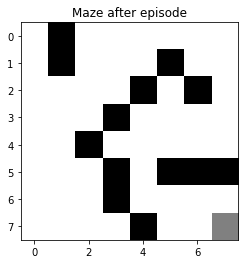

Epoch: 461/999 | Loss: 0.0006 | Episodes: 462 | Win count: 442 | Win rate: 1.000 | time: 1.44 hours
Loss:  0.0008933076460380107
Loss:  0.0002883833512896672
Loss:  0.00022630101011600345
Loss:  0.0003453271674516145
Loss:  0.0007022667850833386
Loss:  0.0005593868409050629
Loss:  0.00031392357777804136


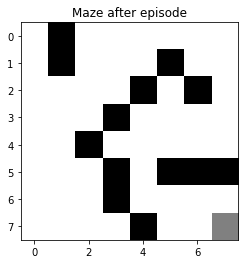

Epoch: 462/999 | Loss: 0.0003 | Episodes: 463 | Win count: 443 | Win rate: 1.000 | time: 1.44 hours
Loss:  0.0003888824430759996
Loss:  0.0005283807695377618
Loss:  0.0002403195685474202
Loss:  0.00029981412808410823
Loss:  0.0006897888670209795
Loss:  0.0004027892282465473
Loss:  0.0006838104745838791
Loss:  0.0003660872607724741


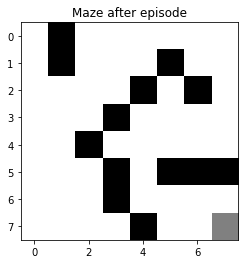

Epoch: 463/999 | Loss: 0.0004 | Episodes: 464 | Win count: 444 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.0001351122191408649
Loss:  0.0005290310946293175
Loss:  0.0002999472726514796
Loss:  0.00047837573947617784
Loss:  0.00032213340455200523
Loss:  0.0003241279046051204
Loss:  0.0006964433996472508
Loss:  7.060599818942137e-05
Loss:  0.00010993143223458901
Loss:  0.0005324946250766516
Loss:  0.00012906471238238737
Loss:  0.00019582397362682968
Loss:  0.00017941211626748554
Loss:  0.00025717536482261494
Loss:  0.00014020359958522022
Loss:  0.0002195118104282301
Loss:  0.0005898868839722127
Loss:  0.00023293991398531944
Loss:  0.0006641651270911098
Loss:  0.00023665431581321172
Loss:  0.00012447762856027111
Loss:  0.0003753895143745467
Loss:  0.0004298830608604476
Loss:  8.535244342056103e-05
Loss:  0.0007863929495215416
Loss:  0.00046752876369282603
Loss:  0.00048457075899932534
Loss:  0.000385702311177738
Loss:  0.0002278243118780665
Loss:  0.0004747696511913091


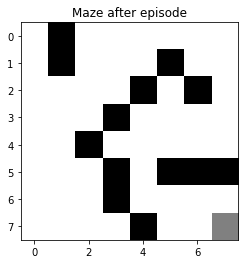

Epoch: 464/999 | Loss: 0.0005 | Episodes: 465 | Win count: 445 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.00029111494222888723
Loss:  0.0005272575217531994
Loss:  0.0004829452809644863
Loss:  0.0006284891278482974
Loss:  0.00030654354486614466
Loss:  0.0003813949733739719
Loss:  0.00023857272390159778
Loss:  0.0003067972284043208


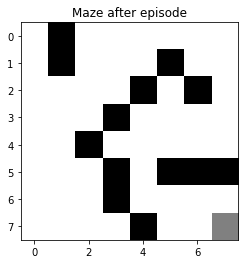

Epoch: 465/999 | Loss: 0.0003 | Episodes: 466 | Win count: 446 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.0002179905895900447
Loss:  0.0001567591170896776
Loss:  0.00020284631318645552
Loss:  0.0004373479605419561
Loss:  0.0003820956335403025
Loss:  0.00023301854525925592
Loss:  0.00042230418330291286
Loss:  0.0003161284839734435
Loss:  0.000397197378333658
Loss:  0.00033316972258035094


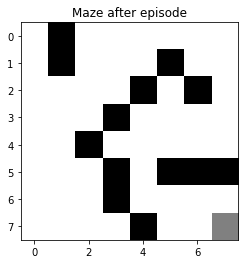

Epoch: 466/999 | Loss: 0.0003 | Episodes: 467 | Win count: 447 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.0007494214805774391
Loss:  6.364174259942956e-05
Loss:  0.0003742201370187104
Loss:  0.0006268825236475095
Loss:  0.000789284153142944
Loss:  0.0003914004046237096
Loss:  0.0008287449309136719
Loss:  0.0006187514518387616
Loss:  0.0002198716247221455
Loss:  0.00032187952456297353
Loss:  0.00018852114590117708
Loss:  0.0006798793183406815
Loss:  0.00019936521857744083


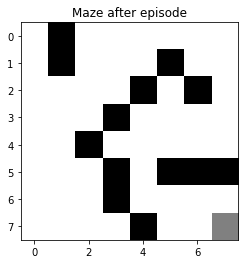

Epoch: 467/999 | Loss: 0.0002 | Episodes: 468 | Win count: 448 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.00023729860004095826
Loss:  9.528585360385478e-05
Loss:  0.00021780820679850876
Loss:  0.00021994314738549292
Loss:  0.00014392063894774765
Loss:  0.0002253505153930746
Loss:  0.0003790434857364744
Loss:  0.0001917185800266452
Loss:  0.0004993937764083967
Loss:  0.0003733925841515884
Loss:  6.525769276777282e-05
Loss:  0.0004890402415185235
Loss:  0.00040623177483212203
Loss:  0.000590645577176474
Loss:  0.0002051027404377237
Loss:  0.0004950741131324321
Loss:  0.0003088182711508125
Loss:  0.00047474741586484015
Loss:  0.000627902802079916
Loss:  0.00021660298807546496
Loss:  0.0004022629582323134


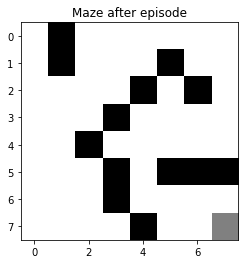

Epoch: 468/999 | Loss: 0.0004 | Episodes: 469 | Win count: 449 | Win rate: 1.000 | time: 1.45 hours
Loss:  9.875974137685262e-05
Loss:  6.0634560213657096e-05
Loss:  0.00019360535952728242
Loss:  0.00041604139551054686
Loss:  0.0003658721470856108
Loss:  0.0002551890465838369
Loss:  0.0004253032966516912
Loss:  0.0005033622437622398
Loss:  8.820051152724773e-05
Loss:  0.00033972554956562817
Loss:  0.0007048235711408779


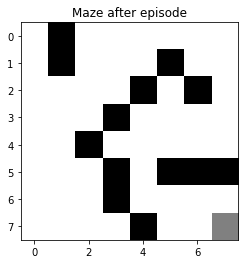

Epoch: 469/999 | Loss: 0.0007 | Episodes: 470 | Win count: 450 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.00016539384887437336
Loss:  0.0004169533967797179
Loss:  0.0004868515534326434
Loss:  0.0005790607538074255
Loss:  0.0003004328682436608
Loss:  0.00031483254861086607


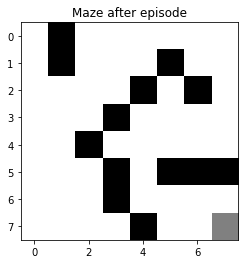

Epoch: 470/999 | Loss: 0.0003 | Episodes: 471 | Win count: 451 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.00021572301375272218
Loss:  0.00018816856754710898
Loss:  0.00022844580962555483
Loss:  0.0002656025462783873
Loss:  0.00019129016436636448
Loss:  6.0655645938823e-05
Loss:  0.0002973254850076046
Loss:  0.0005736914172302932
Loss:  0.0008903863781597465


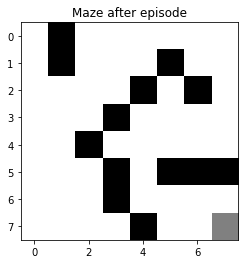

Epoch: 471/999 | Loss: 0.0009 | Episodes: 472 | Win count: 452 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.00040779282426228747
Loss:  0.0007673910586163402
Loss:  0.0007219949620775878
Loss:  0.0004885882372036576
Loss:  0.0004489159691729583
Loss:  0.00031192388269118965
Loss:  0.0001312732529186178
Loss:  0.0003949225210817531
Loss:  0.00036857359737041406
Loss:  0.0008455449133180082
Loss:  0.0005312083376338705
Loss:  0.0005461685359477997
Loss:  0.0004828733071917668
Loss:  0.00025161266967188567
Loss:  0.0006073752592783421
Loss:  0.00036791387537959963
Loss:  0.00018595720757730305
Loss:  0.0003080757014686242
Loss:  0.00013047265747445635
Loss:  0.0002218153931607958
Loss:  0.00022055945737520233
Loss:  0.00020552068599499762
Loss:  4.2549076169962063e-05
Loss:  0.00028268226742511615
Loss:  0.00044492725282907486


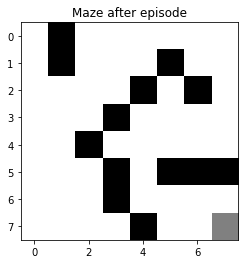

Epoch: 472/999 | Loss: 0.0004 | Episodes: 473 | Win count: 453 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.00038008036790415645
Loss:  0.0003337454254506156
Loss:  8.73945900821127e-05
Loss:  0.00044457410695031285
Loss:  0.000212664672289975
Loss:  0.0005185784248169512
Loss:  0.00014853493667033035
Loss:  0.0002254065293527674
Loss:  6.264339208428282e-05
Loss:  0.000438133894931525
Loss:  0.0002000343483814504
Loss:  0.00019024344510398805
Loss:  0.0003907940481440164
Loss:  0.00037854571201023646
Loss:  0.00032908546563703567


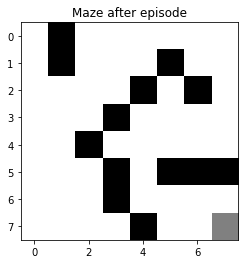

Epoch: 473/999 | Loss: 0.0003 | Episodes: 474 | Win count: 454 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.0001864469377323985
Loss:  0.00037143140434636734
Loss:  0.0003155086888000369
Loss:  0.0002301415879628621
Loss:  0.00014451087918132544
Loss:  0.0005137713596923277
Loss:  0.00012651144061237574


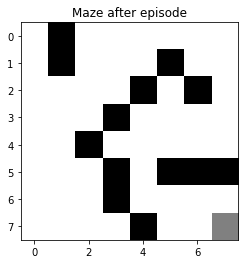

Epoch: 474/999 | Loss: 0.0001 | Episodes: 475 | Win count: 455 | Win rate: 1.000 | time: 1.45 hours
Loss:  5.1342287406441756e-05
Loss:  0.00016883374337339774
Loss:  0.00020843304446316324
Loss:  0.0003574419242795557
Loss:  0.00033952330704778433
Loss:  0.0003487760841380805
Loss:  0.0003911983803845942
Loss:  0.000260979424638208
Loss:  0.00020003677491331473
Loss:  0.0003726630311575718
Loss:  0.000637689110590145
Loss:  0.0002591615993878804
Loss:  0.0002896702353609726


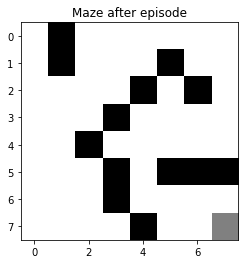

Epoch: 475/999 | Loss: 0.0003 | Episodes: 476 | Win count: 456 | Win rate: 1.000 | time: 1.45 hours
Loss:  6.654118988080882e-05
Loss:  0.0002149777064914815
Loss:  0.0001795158714230638
Loss:  0.00020848358690273017
Loss:  0.0003904777258867398


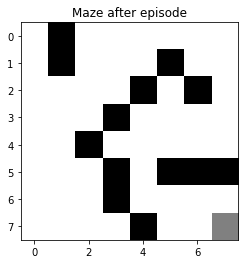

Epoch: 476/999 | Loss: 0.0004 | Episodes: 477 | Win count: 457 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.00034404506368446164
Loss:  8.671731484355405e-05
Loss:  6.179070260259323e-05
Loss:  0.00038425215461757034
Loss:  0.0002673614289960824
Loss:  0.0004961232043569908
Loss:  0.00022701459238305688
Loss:  0.00023654445249121636
Loss:  0.00021580211614491418
Loss:  0.00010975551231240388
Loss:  0.0007489857380278409
Loss:  0.0002782271767500788
Loss:  0.00018437704420648515
Loss:  0.00027163861523149535
Loss:  0.00036654790164902806
Loss:  0.0006969975875108503
Loss:  0.0002431359316688031
Loss:  0.00027422151470091194
Loss:  0.00022952217113925144
Loss:  0.00048617571883369237
Loss:  9.241601946996525e-05


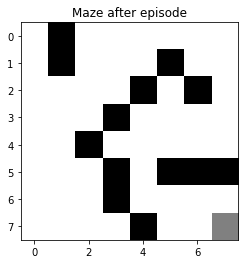

Epoch: 477/999 | Loss: 0.0001 | Episodes: 478 | Win count: 458 | Win rate: 1.000 | time: 1.45 hours
Loss:  0.00023630365467397496
Loss:  0.00030863946449244395
Loss:  0.00043428214848972857
Loss:  0.00016915733795030974
Loss:  0.00018517116404836997
Loss:  0.0005468313174787909
Loss:  0.0003962983610108495
Loss:  0.000489129830384627
Loss:  0.0004769188817590475
Loss:  0.00036067291512154043
Loss:  0.00027308279095450416
Loss:  0.00039922040014062077
Loss:  0.0001817213178583188
Loss:  0.00023278344087884761
Loss:  0.00020580449927365407
Loss:  0.0005372555460780859
Loss:  8.717435048311017e-05
Loss:  0.00022945173623156734
Loss:  0.000251390820267261
Loss:  0.00022366475604940206
Loss:  7.958832429721951e-05
Loss:  0.00013358158321352676
Loss:  0.000212787083000876
Loss:  0.0003283190671936609
Loss:  0.00029414019809337333


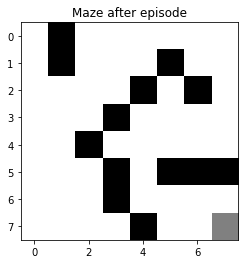

Epoch: 478/999 | Loss: 0.0003 | Episodes: 479 | Win count: 459 | Win rate: 1.000 | time: 1.46 hours
Loss:  0.00045447111187968403
Loss:  0.0005099514382891357
Loss:  0.0005059405812062323
Loss:  0.0002705290826270357
Loss:  0.00029571518825832754
Loss:  0.0003009123174706474
Loss:  8.642586908536032e-05


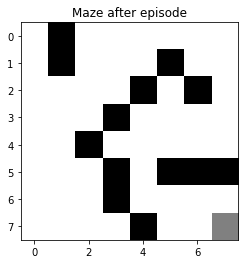

Epoch: 479/999 | Loss: 0.0001 | Episodes: 480 | Win count: 460 | Win rate: 1.000 | time: 1.46 hours
Loss:  0.00046213893801905215
Loss:  0.00029302028997335583
Loss:  0.0005435337079688907
Loss:  0.00011244884808547795
Loss:  0.0004138693038839847
Loss:  0.00024888796178856865
Loss:  0.00034069605317199603
Loss:  0.0008696152945049107
Loss:  0.0004880958440480754
Loss:  0.0004190071776974946
Loss:  0.0002798556670313701
Loss:  0.0004930761442665244
Loss:  0.00019583965331548825
Loss:  0.0002179421135224402
Loss:  0.0003778758691623807
Loss:  0.0005778007616754621
Loss:  0.00042589187796693295


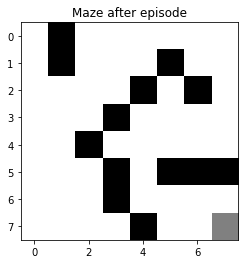

Epoch: 480/999 | Loss: 0.0004 | Episodes: 481 | Win count: 461 | Win rate: 1.000 | time: 1.46 hours
Loss:  0.0002272006076964317
Loss:  0.00037732088821940124
Loss:  0.00019719819283636753
Loss:  0.0003546837833710015
Loss:  0.0003113692728220485
Loss:  0.0007688670884817839
Loss:  0.0003450965159572661
Loss:  0.0005807797278976068
Loss:  0.00029896016349084675
Loss:  0.00021840469707967713
Loss:  0.00028950703563168645
Loss:  0.0006840144342277199
Loss:  0.00039040045521687716
Loss:  0.0002531686259317212
Loss:  0.000329336486174725
Loss:  0.00048372244054917246
Loss:  0.0002588520110293757
Loss:  0.00041336203867103904
Loss:  0.00045130909711588174
Loss:  0.0002865082205971703
Loss:  0.0002390780828136485
Loss:  0.00043395198008511215
Loss:  0.0003991166449850425
Loss:  0.0003562494821380824
Loss:  0.0005094481457490474
Loss:  0.00024878345720935613
Loss:  0.0005448018491733819
Loss:  0.0003077400760957971
Loss:  0.00034253827470820397
Loss:  0.00024494870740454644
Loss:  0.000601518

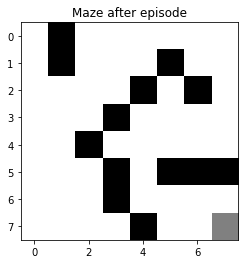

Epoch: 481/999 | Loss: 0.0002 | Episodes: 482 | Win count: 462 | Win rate: 1.000 | time: 1.46 hours
Loss:  0.000510631813085638
Loss:  0.00023504778800997883
Loss:  0.00030187260563252494
Loss:  0.00026321101177018136
Loss:  0.000178614143806044
Loss:  6.984382343944162e-05
Loss:  0.0002388909924775362
Loss:  0.0002853971964213997
Loss:  0.00025796378031373024
Loss:  0.0006991350091993809
Loss:  0.0004139542143093422
Loss:  0.0004674920564866625
Loss:  0.00038414438313338906
Loss:  0.00020436571503523737
Loss:  8.000879643077496e-05
Loss:  0.00043731247569667175
Loss:  0.0005427528085419908
Loss:  0.0005914130742894486
Loss:  0.0005021894758101553


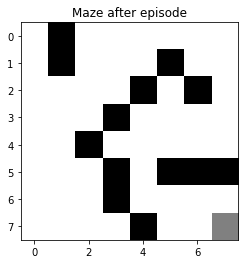

Epoch: 482/999 | Loss: 0.0005 | Episodes: 483 | Win count: 463 | Win rate: 1.000 | time: 1.46 hours
Loss:  0.000262995672528632
Loss:  0.000243086637055967
Loss:  0.00046495509741362184


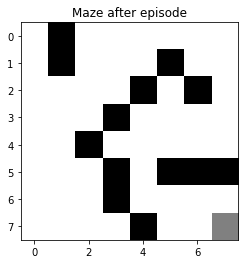

Epoch: 483/999 | Loss: 0.0005 | Episodes: 484 | Win count: 464 | Win rate: 1.000 | time: 1.46 hours
Loss:  0.00018225054373033345
Loss:  0.0005450707540148869
Loss:  0.000298529674182646
Loss:  0.000378043478121981
Loss:  0.0004903882800135761
Loss:  0.0007293016387848184
Loss:  8.303479626192711e-05
Loss:  0.000285376918327529
Loss:  0.0005001601821277291
Loss:  8.117657853290439e-05
Loss:  0.0003105446376139298
Loss:  0.00045560277067124844
Loss:  0.0006968501256778836
Loss:  0.0009087624493986368
Loss:  0.0003316258662380278
Loss:  0.000289176037767902
Loss:  0.00044858512410428375
Loss:  0.0005042896955274045
Loss:  0.00037679127126466483
Loss:  0.00013416782167041674
Loss:  7.561199527117424e-05
Loss:  0.0002712231653276831


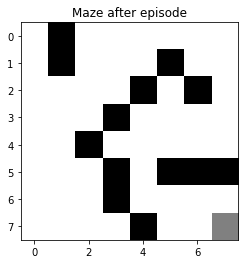

Epoch: 484/999 | Loss: 0.0003 | Episodes: 485 | Win count: 465 | Win rate: 1.000 | time: 1.46 hours
Loss:  7.899500633357093e-05
Loss:  0.0003532776900101453
Loss:  0.0002745540259638801
Loss:  0.00014250248204916716
Loss:  0.00026810374401975423
Loss:  0.0002245985670015216
Loss:  6.459779797296505e-05


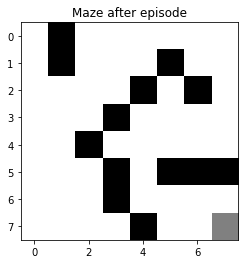

Epoch: 485/999 | Loss: 0.0001 | Episodes: 486 | Win count: 466 | Win rate: 1.000 | time: 1.46 hours
Loss:  0.0005159433057997376
Loss:  0.0002941129496321082
Loss:  0.0005452851619338617
Loss:  0.000641633989289403
Loss:  0.00016097936895675957
Loss:  0.0003304183919681236
Loss:  0.00025019111126312055
Loss:  0.0006030111471773125
Loss:  0.00039863697020336986
Loss:  0.0002570737706264481
Loss:  0.0004028557741548866
Loss:  0.00038096008938737214
Loss:  0.0007175353384809569
Loss:  0.0006652381707681343
Loss:  0.0004957475466653705
Loss:  0.00036838266532868147
Loss:  0.0001795864009181969
Loss:  0.0008054895442910492
Loss:  0.00023597270410391502
Loss:  0.00021358217054512352
Loss:  8.14420600363519e-05
Loss:  0.00042859364475589246
Loss:  0.0004870930715696886
Loss:  0.00015054818140924908
Loss:  0.0004018053223262541
Loss:  0.00016341307491529733


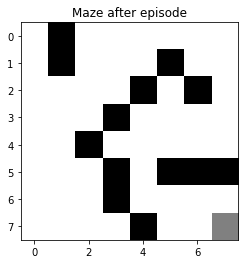

Epoch: 486/999 | Loss: 0.0002 | Episodes: 487 | Win count: 467 | Win rate: 1.000 | time: 1.46 hours
Loss:  0.00016792086626082892
Loss:  6.430466419260483e-05
Loss:  0.00043653903412632644
Loss:  0.0002847111063601915
Loss:  0.00044723317841999233
Loss:  0.0006033847166690975
Loss:  0.0003929132653865963
Loss:  0.0002475725159456488
Loss:  0.00034687262086663395
Loss:  0.0004154191556153819
Loss:  0.00039778863720130175
Loss:  0.00010439006291562691
Loss:  0.0005974423256702721
Loss:  0.00021258160268189386
Loss:  0.00018186114539275877
Loss:  0.0005501899722730741


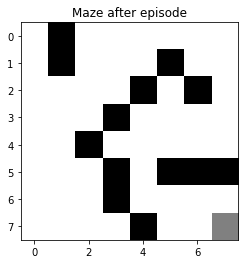

Epoch: 487/999 | Loss: 0.0006 | Episodes: 488 | Win count: 468 | Win rate: 1.000 | time: 1.46 hours
Loss:  0.00033410588366677985
Loss:  0.000423677935032174
Loss:  0.0006532851257361472
Loss:  0.00014187278065946884
Loss:  0.0003389618650544435
Loss:  0.0005819137732032686
Loss:  0.00036868306051474065
Loss:  0.0005273101050988771
Loss:  0.0002722719364101067
Loss:  0.00039783645479474217
Loss:  0.00033506548788864166
Loss:  0.00037291174521669745
Loss:  0.0005890164466109127
Loss:  0.0003863661695504561
Loss:  0.0005955736851319671
Loss:  0.0002631121897138655
Loss:  0.0006062697502784431
Loss:  0.0003061491661355831
Loss:  0.00032332410773960873
Loss:  0.00016470580885652453
Loss:  0.00025959539743780624
Loss:  0.0003682089372887276
Loss:  0.0007124277180992067
Loss:  0.00040962669299915433
Loss:  0.0004659836849896237
Loss:  0.0004769014776684344
Loss:  0.0002438560186419636
Loss:  0.0004944746906403452
Loss:  0.0005985930620227009
Loss:  8.804474782664329e-05
Loss:  0.000708943451

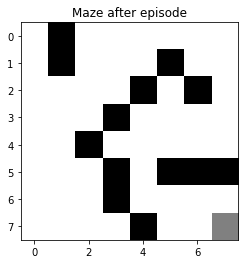

Epoch: 488/999 | Loss: 0.0001 | Episodes: 489 | Win count: 469 | Win rate: 1.000 | time: 1.46 hours
Loss:  0.00045665095967706293
Loss:  0.0002501830786059145
Loss:  0.000340397673426196
Loss:  0.00041434179001953453
Loss:  0.0003296656213933602
Loss:  0.00034806942858267576
Loss:  0.0003861181467073038
Loss:  0.0005533798248507082
Loss:  0.00022455229191109538
Loss:  0.0005291082488838583
Loss:  0.0005487720191013068
Loss:  0.0004192243068246171
Loss:  0.0003447222479735501
Loss:  0.00038572450284846127
Loss:  0.00022009931853972375
Loss:  0.0006336481310427189
Loss:  0.0004220876726321876
Loss:  0.0001382738737447653
Loss:  0.0003792797215282917
Loss:  0.00046960884355939925
Loss:  0.00037797243567183614
Loss:  0.0003996460945927538


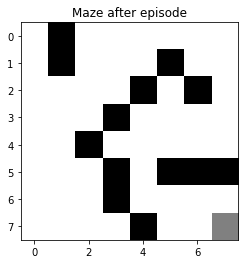

Epoch: 489/999 | Loss: 0.0004 | Episodes: 490 | Win count: 470 | Win rate: 1.000 | time: 1.47 hours
Loss:  0.00021375951473601162
Loss:  0.0006250088626984507
Loss:  0.00025931731943273917
Loss:  0.00024256925098598003
Loss:  0.00028026252402924
Loss:  0.0006039391591912135
Loss:  0.00024434994702460244
Loss:  0.0004642783896997571
Loss:  8.149355562636629e-05
Loss:  0.000608221220318228
Loss:  0.0005474821373354644
Loss:  0.0002960284036817029
Loss:  0.00038346718065440655
Loss:  0.0005297107563819736
Loss:  0.00040666008135303855
Loss:  0.00031226313149090856
Loss:  0.00027652444259729236
Loss:  0.000326109780871775
Loss:  0.0007947504927869886


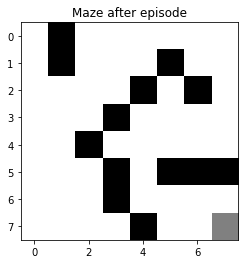

Epoch: 490/999 | Loss: 0.0008 | Episodes: 491 | Win count: 471 | Win rate: 1.000 | time: 1.47 hours
Loss:  0.00048289596452377737
Loss:  0.0007404258067253977
Loss:  0.0006986098305787891
Loss:  0.0003949234669562429
Loss:  0.0003019915893673897
Loss:  0.0004397798184072599
Loss:  0.0003331323969177902
Loss:  0.0006071904354030266
Loss:  0.0004961820523021743
Loss:  0.0004382511251606047
Loss:  0.0005144924798514694
Loss:  0.00040653994074091315
Loss:  0.00048451340990141034
Loss:  0.0004611844487953931
Loss:  0.0003026011254405603
Loss:  0.0002211039827670902
Loss:  0.0002667628214112483
Loss:  0.00022467994494945742
Loss:  0.00024204924557125196
Loss:  0.0002909001923399046
Loss:  0.00021931804076302797
Loss:  0.00037957087624818087
Loss:  0.00047798900777706876
Loss:  0.000412223584135063
Loss:  0.0003351016202941537
Loss:  0.0002976955656777136
Loss:  0.0002458801645843778
Loss:  0.00044046042603440583
Loss:  0.00037241505924612284
Loss:  0.0006312386831268668
Loss:  0.000221931004

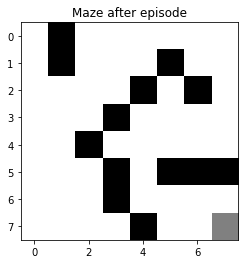

Epoch: 491/999 | Loss: 0.0002 | Episodes: 492 | Win count: 472 | Win rate: 1.000 | time: 1.47 hours
Loss:  0.0003814447554759681
Loss:  0.00023986729502212256
Loss:  0.0003817877732217312
Loss:  0.00029140736296540126
Loss:  0.0003237057098885998
Loss:  9.184550435747951e-05
Loss:  0.00027649905314319767
Loss:  0.0001840526092564687
Loss:  0.0004333415417931974
Loss:  0.00020080077229067683
Loss:  0.0004954877367708832
Loss:  0.00017829590797191486
Loss:  0.0005311984859872609
Loss:  0.00015063577302498743
Loss:  0.0006449487409554422
Loss:  0.00035856448084814474
Loss:  0.00036127815837971866
Loss:  0.0002846721690730192
Loss:  0.00040406610060017556
Loss:  9.811050767893903e-05
Loss:  0.0004627054113370832
Loss:  0.00042555008258204907
Loss:  0.000501000409713015
Loss:  0.0004959918151143938
Loss:  0.00021638952603098005
Loss:  0.00036707118852064013


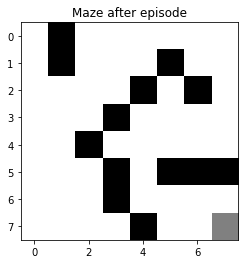

Epoch: 492/999 | Loss: 0.0004 | Episodes: 493 | Win count: 473 | Win rate: 1.000 | time: 1.47 hours
Loss:  0.0002900668332586065
Loss:  0.0002603102911962196
Loss:  0.000455929824966006
Loss:  0.00038007964030839503
Loss:  0.00019239579705754295
Loss:  0.0006775347574148327
Loss:  0.0003592295397538692
Loss:  0.00038906488043721765
Loss:  0.000426876635174267
Loss:  0.00017328101966995746
Loss:  0.0006972980045247823
Loss:  0.00011985009041382
Loss:  0.0001054644617397571
Loss:  0.00028510158153949305
Loss:  0.00038703584141330793
Loss:  0.0003392619109945372
Loss:  0.00020717046572826803
Loss:  0.0003813130970229395
Loss:  0.0004597626393660903
Loss:  0.00034352367219980806
Loss:  0.00037120337947271764


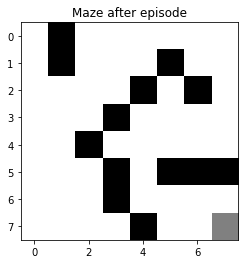

Epoch: 493/999 | Loss: 0.0004 | Episodes: 494 | Win count: 474 | Win rate: 1.000 | time: 1.47 hours
Loss:  0.0004003551439382136
Loss:  0.0004720286378869787
Loss:  0.0002458649250911549
Loss:  0.0003713482146849856
Loss:  0.00030935097311157733
Loss:  0.00010310731522622518
Loss:  0.0004945706459693611
Loss:  0.00012146374501753598
Loss:  0.00015137947048060596
Loss:  0.0004383377090562135
Loss:  0.00022829211957287043
Loss:  0.0001622111303731799
Loss:  0.00038640457205474377
Loss:  0.00036269724660087377
Loss:  0.0003626469297159929
Loss:  0.000425811049353797
Loss:  0.0002900465333368629
Loss:  0.00026475808044779114
Loss:  0.00041856073949020356
Loss:  0.0003353558568051085
Loss:  0.0006231444422155619
Loss:  0.00011076932059950195
Loss:  0.00018164829816669226
Loss:  0.00040428329521091655
Loss:  0.0001953424907696899
Loss:  9.302764374297112e-05
Loss:  0.00017520862456876785
Loss:  0.0006136188749223948
Loss:  0.0003287071012891829
Loss:  0.00047490136057604104


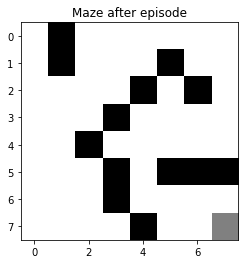

Epoch: 494/999 | Loss: 0.0005 | Episodes: 495 | Win count: 475 | Win rate: 1.000 | time: 1.47 hours
Loss:  0.000340027516358532
Loss:  0.0002457782029523514
Loss:  0.0002618123107822612
Loss:  0.0004424312792252749
Loss:  0.0003130280674668029
Loss:  0.0005734047153964639
Loss:  0.0005139956483617425


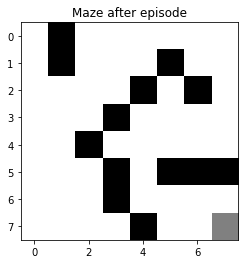

Epoch: 495/999 | Loss: 0.0005 | Episodes: 496 | Win count: 476 | Win rate: 1.000 | time: 1.47 hours
Loss:  0.0003384612937225029
Loss:  0.00018809134780894965
Loss:  0.0002233522100141272
Loss:  0.00023192325897980481
Loss:  0.0003840560148091754
Loss:  0.00018747951253317297
Loss:  0.0004075639881193638
Loss:  5.7645735068945214e-05
Loss:  0.0004245602831360884
Loss:  0.00037098766188137233
Loss:  0.00015005144086899236
Loss:  0.00024051387117651757
Loss:  0.0001110257362597622
Loss:  0.00026959141541738063
Loss:  0.0002667762746568769
Loss:  0.00011076094961026683
Loss:  0.0004832999547943473
Loss:  0.00029236254340503365
Loss:  0.00026101715047843754
Loss:  0.00023938308731885627
Loss:  0.00035234130155004095


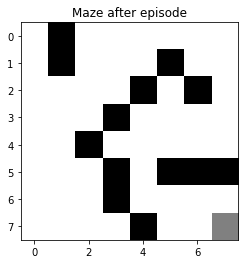

Epoch: 496/999 | Loss: 0.0004 | Episodes: 497 | Win count: 477 | Win rate: 1.000 | time: 1.47 hours
Loss:  0.00019075390628131572
Loss:  5.785366738564335e-05
Loss:  0.000213880673982203
Loss:  0.0004274952516425401
Loss:  0.0003377456705493387
Loss:  0.0004921772342640907
Loss:  0.0003245598200010136
Loss:  0.00029290974634932354
Loss:  9.419886555406265e-05
Loss:  0.00030476100801024586
Loss:  0.00019633075589808868
Loss:  0.0002911584742832929
Loss:  0.00018649399862624705
Loss:  0.00023807520483387634
Loss:  0.00020337777823442593
Loss:  0.00041099950612988323
Loss:  0.00036185994395054877
Loss:  0.00028793149249395356
Loss:  0.0003456334670772776
Loss:  0.00029070136952213943
Loss:  0.0009749607997946441
Loss:  8.164963219314814e-05
Loss:  0.000366123829735443
Loss:  7.593992268084548e-05
Loss:  0.0003296584909548983


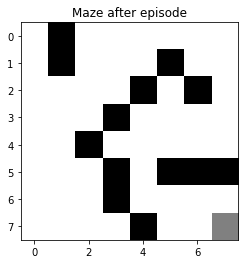

Epoch: 497/999 | Loss: 0.0003 | Episodes: 498 | Win count: 478 | Win rate: 1.000 | time: 1.47 hours
Loss:  0.00028613679751288146
Loss:  0.00022227131921681575
Loss:  0.00023241189774125814
Loss:  0.00023571408382849768
Loss:  0.00013705415221920703
Loss:  0.0004371905670268461
Loss:  0.0005282008642097935
Loss:  0.00028176985870231874
Loss:  0.0002933974174084142
Loss:  0.0002679575336514972
Loss:  0.0003287277722847648
Loss:  0.00032129748979059514
Loss:  0.0003249371366109699


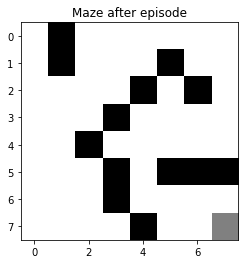

Epoch: 498/999 | Loss: 0.0003 | Episodes: 499 | Win count: 479 | Win rate: 1.000 | time: 1.47 hours
Loss:  0.00017798964654502925
Loss:  0.00024106731143547222
Loss:  0.00021011451462982222
Loss:  0.0005068631435278803
Loss:  0.00048257745220325887
Loss:  0.00041993692866526544
Loss:  0.0003328474558657035
Loss:  0.00013224252688814886
Loss:  0.00020025751291541383
Loss:  0.00011263097985647619
Loss:  0.00019496360255288891
Loss:  5.578021955443546e-05
Loss:  0.0005480326653923839
Loss:  0.0003880153817590326
Loss:  5.84888275625417e-05
Loss:  5.182497261557728e-05
Loss:  4.7502493544016033e-05
Loss:  0.00026841996441362426


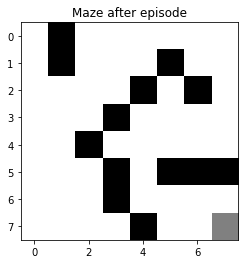

Epoch: 499/999 | Loss: 0.0003 | Episodes: 500 | Win count: 480 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.0005457611696328968
Loss:  9.320771641796455e-05
Loss:  0.00016142423555720598
Loss:  9.729635712574236e-05
Loss:  0.00034829770811484195
Loss:  0.0004936179902870208
Loss:  0.00020796033822989557
Loss:  0.00048690749099478126
Loss:  0.000280319967714604
Loss:  0.00010923029913101345
Loss:  0.000321046871249564
Loss:  0.0001316044872510247
Loss:  0.0002750099083641544
Loss:  0.00039328448474407196
Loss:  0.0003996208688477054
Loss:  0.0005807637426187284
Loss:  0.0003702496469486505
Loss:  0.00042030670738313347
Loss:  0.00019688631437020376
Loss:  0.0002256927764392458
Loss:  0.0002675425203051418


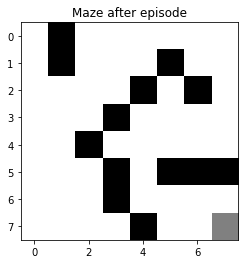

Epoch: 500/999 | Loss: 0.0003 | Episodes: 501 | Win count: 481 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.0004289035132387653
Loss:  0.00023089528258424252
Loss:  0.00019443624842097051
Loss:  0.0001383550261380151
Loss:  0.0003340592375025153
Loss:  0.00026756157603813335
Loss:  0.00026831059949472547
Loss:  0.0003469189105089754


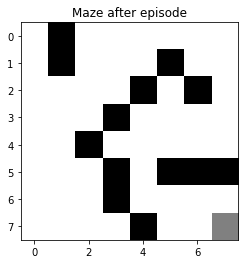

Epoch: 501/999 | Loss: 0.0003 | Episodes: 502 | Win count: 482 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.00022558010823559016
Loss:  0.0005312688481353689
Loss:  0.0004619860992534086
Loss:  0.0003253694740124047
Loss:  0.00017582209693500772
Loss:  0.00016777469136286527
Loss:  0.0001447048198315315
Loss:  0.00014228288637241349
Loss:  0.00022279460972640663
Loss:  0.000334589509293437
Loss:  0.0005292814603308216
Loss:  0.00023561884154332802
Loss:  7.50688741391059e-05
Loss:  0.0001610142644494772
Loss:  0.00038763888005632907
Loss:  0.00019172229076502845
Loss:  0.0003253066388424486
Loss:  0.0002993811413034564
Loss:  0.00020408285490702838


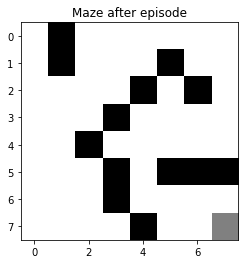

Epoch: 502/999 | Loss: 0.0002 | Episodes: 503 | Win count: 483 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.0005737252940889448
Loss:  0.0004197188827674836
Loss:  0.0004466375248739496
Loss:  0.0004216340239509009
Loss:  0.00033252243156312034
Loss:  0.00023972488270374015
Loss:  0.0005104207375552505
Loss:  0.00011913109483430162
Loss:  0.00022592787718167529


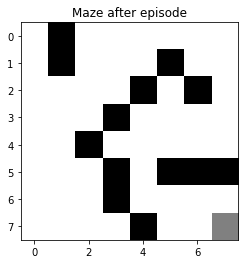

Epoch: 503/999 | Loss: 0.0002 | Episodes: 504 | Win count: 484 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.0005442716064862907
Loss:  0.0004927720437990502
Loss:  0.0004403455095598474
Loss:  0.0003967770317103714
Loss:  7.860128971515223e-05
Loss:  0.00017734872380970046
Loss:  0.00025780008581932634
Loss:  0.0002425744096399285
Loss:  0.00018660203932086006
Loss:  0.0003530729081830941
Loss:  0.000345096366800135
Loss:  7.549201836809516e-05
Loss:  0.00024574882627348416
Loss:  0.0005277792370179668
Loss:  0.0004876603197772056
Loss:  0.0002345142129343003
Loss:  9.430346835870296e-05


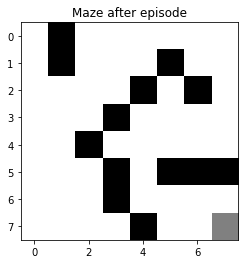

Epoch: 504/999 | Loss: 0.0001 | Episodes: 505 | Win count: 485 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.00018174636352341622
Loss:  0.0005289881810313091
Loss:  0.0004291835939511657
Loss:  6.633820885326713e-05
Loss:  7.975259723025374e-05
Loss:  1.5380910554085858e-05
Loss:  0.0004034643789054826
Loss:  0.0002919216567534022
Loss:  0.00021807772282045335
Loss:  0.0002090400375891477
Loss:  2.784632124530617e-05
Loss:  0.00048069733020383865
Loss:  0.00037483857886400074
Loss:  0.00013490545097738504
Loss:  0.0003002121375175193
Loss:  0.00044311863894108683
Loss:  0.00020992901409044862
Loss:  0.0002840035449480638
Loss:  0.0005797906778752804
Loss:  0.00014487866428680718
Loss:  0.00035702926106750965


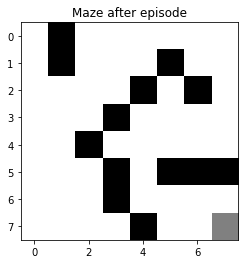

Epoch: 505/999 | Loss: 0.0004 | Episodes: 506 | Win count: 486 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.0002163437420676928
Loss:  0.0002818825851136353
Loss:  0.000509070567204617
Loss:  0.00045984382086317055
Loss:  0.00024926045443862677
Loss:  0.00019953602168243378
Loss:  0.00029309956880751997


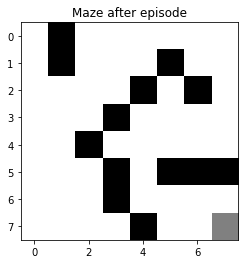

Epoch: 506/999 | Loss: 0.0003 | Episodes: 507 | Win count: 487 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.0005132458754815161
Loss:  6.174578447826207e-05
Loss:  8.71699012350291e-05
Loss:  8.00328707555309e-05
Loss:  0.0003277700088801794
Loss:  0.00021960619051242247
Loss:  0.00024481913715135306
Loss:  0.0004620564286597073
Loss:  0.0003541141049936414
Loss:  0.00012770081957569346
Loss:  0.00030683954537380487
Loss:  0.0003169090923620388
Loss:  9.324545681010932e-05
Loss:  0.00018086827458319021
Loss:  0.0009197437902912498


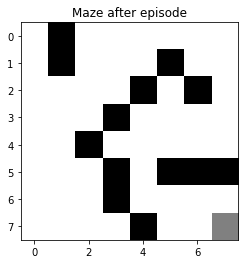

Epoch: 507/999 | Loss: 0.0009 | Episodes: 508 | Win count: 488 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.00044951886229682714
Loss:  0.00012049823999404907
Loss:  7.674931111978367e-05
Loss:  0.00020292994850024115
Loss:  0.0003568118700059131
Loss:  0.0003356237866682932
Loss:  0.0004504900352912955
Loss:  0.000233376857067924
Loss:  0.00022372194143827073
Loss:  0.00040801041905069724
Loss:  6.805060911574401e-05
Loss:  0.0004966607230016962
Loss:  7.329881555051543e-05
Loss:  0.00019807251192105468
Loss:  0.00018970506425830536
Loss:  8.568221164750867e-05
Loss:  0.0003368377510923892
Loss:  0.00048693220742279664
Loss:  0.0001956012929440476
Loss:  5.7502580602886155e-05
Loss:  0.0006110858230385929
Loss:  0.00034735661756712943
Loss:  0.0001025163583108224
Loss:  0.00028701461997115985
Loss:  0.0003735884529305622
Loss:  0.00022826259737485088


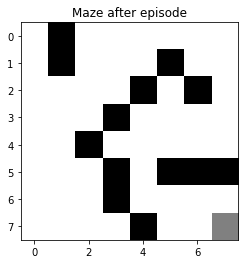

Epoch: 508/999 | Loss: 0.0002 | Episodes: 509 | Win count: 489 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.0003202687803423032
Loss:  0.0005901822878513485
Loss:  7.348346480284818e-05
Loss:  0.000360989935870748
Loss:  0.0004839171306230128
Loss:  0.00014506724255625159
Loss:  0.0002607239002827555
Loss:  0.00019625503773568198
Loss:  0.000643158215098083
Loss:  0.00018289440413354896
Loss:  0.00040912083932198584
Loss:  0.00038545964707736857
Loss:  0.0003909234656020999
Loss:  0.00029904080656706356
Loss:  5.655802306137048e-05
Loss:  6.848918201285414e-05
Loss:  0.00021595169164356776
Loss:  0.00015705378609709442
Loss:  0.00021625559020321816
Loss:  1.879096771517652e-05
Loss:  0.0002122022233379539
Loss:  0.0003050159284612164
Loss:  0.00013090653919789474
Loss:  0.0003709857883222867
Loss:  0.00016924889860092662
Loss:  0.00020832748850807548


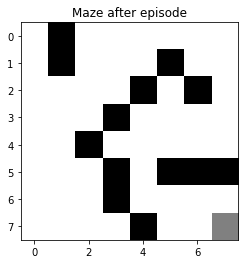

Epoch: 509/999 | Loss: 0.0002 | Episodes: 510 | Win count: 490 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.00039706054667476565
Loss:  0.0003367546887602657
Loss:  0.00015169140169746242
Loss:  0.0002174547189497389
Loss:  0.00021675881544069853
Loss:  0.0002123745762219187
Loss:  0.0002588291608844884
Loss:  0.0006113904964877293
Loss:  0.0001884890371002257
Loss:  0.00037730026815552264


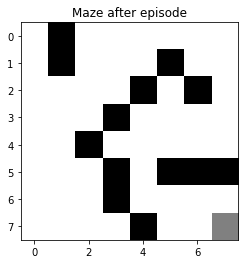

Epoch: 510/999 | Loss: 0.0004 | Episodes: 511 | Win count: 491 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.0003291254979558289
Loss:  0.00037145920214243233
Loss:  0.00040174723108066246
Loss:  0.0002068788126052823
Loss:  0.0002434554189676419
Loss:  0.00019891389092663303
Loss:  0.00012780335237039253
Loss:  0.0005471653275890276
Loss:  0.00037188816349953413
Loss:  0.00021484582248376682
Loss:  0.0001876039350463543
Loss:  0.00014238719450077042
Loss:  0.0006868820928502828
Loss:  0.0003723678855749313
Loss:  5.381214214139618e-05
Loss:  0.0003197385958628729
Loss:  0.0004965747066307813


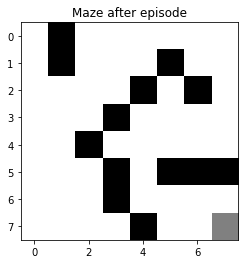

Epoch: 511/999 | Loss: 0.0005 | Episodes: 512 | Win count: 492 | Win rate: 1.000 | time: 1.48 hours
Loss:  0.0003135959486826323
Loss:  0.0004308215866331011
Loss:  0.00029540366085711867
Loss:  0.00029831794017809443
Loss:  0.0003552979833330028
Loss:  0.00043197722698096186
Loss:  0.0003121356676274445
Loss:  0.00033089328644564375
Loss:  0.0003369418682268588
Loss:  0.00022090553829912096
Loss:  0.0005458561354316771
Loss:  0.00036833170815953054
Loss:  0.00038542803667951375
Loss:  0.0003550023684510961
Loss:  0.00018832983914762735
Loss:  0.00037730575422756374
Loss:  0.00030767545104026794
Loss:  0.0005754449084633961
Loss:  0.00020308759121689945
Loss:  0.0002387292515777517
Loss:  0.0005570574139710516
Loss:  8.003714174265042e-05
Loss:  0.00030154255364323035
Loss:  0.00018511072266846895


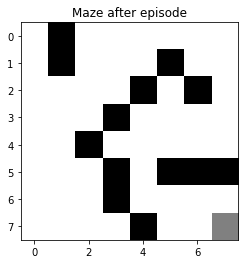

Epoch: 512/999 | Loss: 0.0002 | Episodes: 513 | Win count: 493 | Win rate: 1.000 | time: 1.49 hours
Loss:  0.0003646640761871822
Loss:  0.00041863963997457176


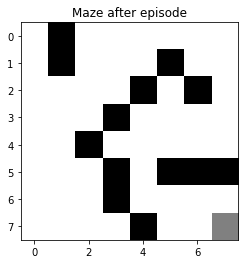

Epoch: 513/999 | Loss: 0.0004 | Episodes: 514 | Win count: 494 | Win rate: 1.000 | time: 1.49 hours
Loss:  8.666435678605922e-05
Loss:  0.0003493295225780457


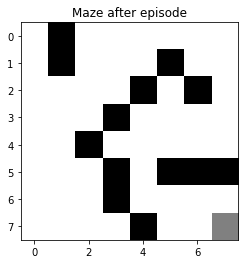

Epoch: 514/999 | Loss: 0.0003 | Episodes: 515 | Win count: 495 | Win rate: 1.000 | time: 1.49 hours
Loss:  0.0004464779995032586
Loss:  0.00018826258747139946
Loss:  0.0003172312644892372
Loss:  0.0005311724307830445
Loss:  0.00045624380436493084
Loss:  0.0002778421912807971
Loss:  0.0002590695658000186
Loss:  0.0004681103746406734
Loss:  0.00022492825519293547
Loss:  0.00021758918592240661
Loss:  0.0005640159652102739
Loss:  0.000562356726732105
Loss:  0.00036900336272083223
Loss:  0.0006589577096747234
Loss:  0.00022598613577429205
Loss:  0.0003472973476164043
Loss:  0.00028999166170251556
Loss:  8.11953068478033e-05
Loss:  0.00044224262819625437
Loss:  0.00019606764180934988
Loss:  8.065042493399233e-05
Loss:  0.00026170508499490097
Loss:  0.00032685082987882197
Loss:  0.00017944490173249505
Loss:  4.681563768826891e-05
Loss:  0.00034760522248689085
Loss:  0.0002997828123625368
Loss:  0.0003699599328683689


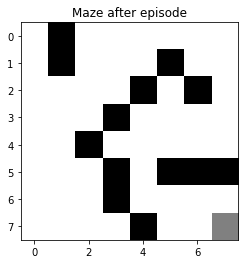

Epoch: 515/999 | Loss: 0.0004 | Episodes: 516 | Win count: 496 | Win rate: 1.000 | time: 1.49 hours
Loss:  0.0007343095785472542
Loss:  0.00021629946058965288
Loss:  0.0006832078070146963
Loss:  0.00035105497954646125
Loss:  0.0002479958566254936
Loss:  0.0005508140893653035
Loss:  0.000236326246522367
Loss:  0.0004773220862261951
Loss:  0.0002266607443743851
Loss:  0.00021256794025248382
Loss:  0.0004074822645634413
Loss:  0.00037311986307031475
Loss:  0.0006817815883550793
Loss:  0.00029831759457010776
Loss:  0.00014143795488053001
Loss:  3.627465594036039e-05
Loss:  0.00018697652922128327
Loss:  7.986918535607401e-05
Loss:  0.0003971097175963223
Loss:  5.5929711379576474e-05
Loss:  0.00033827269362518564
Loss:  3.288127845735289e-05
Loss:  0.00018762745639833156
Loss:  0.00013102238153805956
Loss:  0.000615248893154785
Loss:  0.0002574622485553846
Loss:  0.0002848699514288455
Loss:  0.00037471347241080366


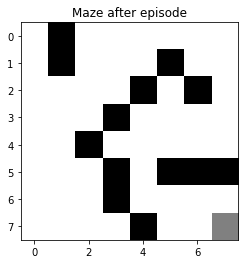

Epoch: 516/999 | Loss: 0.0004 | Episodes: 517 | Win count: 497 | Win rate: 1.000 | time: 1.49 hours
Loss:  0.0005690774705726653
Loss:  3.86466763302451e-05
Loss:  0.00037609421997331083
Loss:  0.0005597722338279709
Loss:  0.00045861140824854374
Loss:  0.00024075736291706562
Loss:  0.0004057990445289761
Loss:  0.0005046763690188527
Loss:  0.00030080651049502194
Loss:  9.426056203665212e-05
Loss:  4.480721145228017e-05
Loss:  0.0004336570273153484


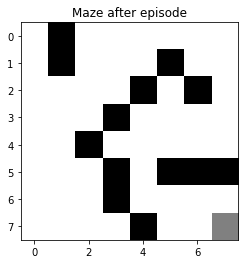

Epoch: 517/999 | Loss: 0.0004 | Episodes: 518 | Win count: 498 | Win rate: 1.000 | time: 1.49 hours
Loss:  0.0005774184392066672
Loss:  0.0002024713612627238
Loss:  4.083113344677258e-05
Loss:  0.0003321153635624796
Loss:  0.0005323957302607596
Loss:  0.00024148521333700046
Loss:  0.0005593676760327071
Loss:  0.0007748585776425898
Loss:  9.588746615918353e-05
Loss:  0.0004493527376325801
Loss:  0.00029983500644448213
Loss:  7.698934859945439e-05
Loss:  0.000480049078760203
Loss:  0.0004064849636051804
Loss:  0.00020449961812119
Loss:  7.853113493183628e-05
Loss:  0.00032293835829477757
Loss:  0.00034903913910966367
Loss:  0.00040038990846369416
Loss:  0.0005343044031178579
Loss:  0.0001862847711890936
Loss:  9.571546252118424e-05
Loss:  0.00047814499703235924
Loss:  0.00016991424308798742
Loss:  0.0001672702892392408


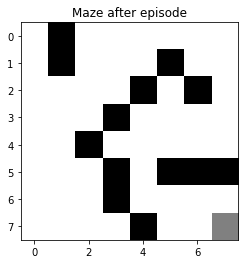

Epoch: 518/999 | Loss: 0.0002 | Episodes: 519 | Win count: 499 | Win rate: 1.000 | time: 1.49 hours
Loss:  0.0004389137029647827
Loss:  3.226148146495689e-05
Loss:  0.0003497640645946376
Loss:  0.0004166992148384452
Loss:  0.00023612388395122252
Loss:  0.0005975394960842095
Loss:  0.00013150636732461862
Loss:  0.00018088134311256
Loss:  0.00039017386734485626
Loss:  0.0005232608964433894
Loss:  0.00036783340328838676
Loss:  0.00015820935186638962
Loss:  0.00021377516895881854
Loss:  0.0001776553062882158
Loss:  0.0003373312429175712
Loss:  0.00039886678860057145
Loss:  5.264860374154523e-05
Loss:  0.00015063547834870405
Loss:  0.00024198579922085628
Loss:  0.00013112683518556878
Loss:  3.111481055384502e-05
Loss:  0.00044658646220341325
Loss:  0.00025910446856869385
Loss:  8.925575821194798e-05
Loss:  0.000532941470737569
Loss:  6.363740794768091e-05
Loss:  0.00030903897277312353


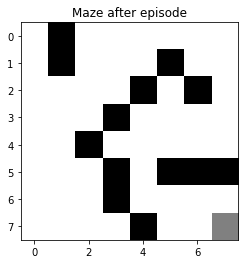

Epoch: 519/999 | Loss: 0.0003 | Episodes: 520 | Win count: 500 | Win rate: 1.000 | time: 1.49 hours
Loss:  0.00022326234466163442
Loss:  0.00019946952488680836
Loss:  0.0004215530352666974
Loss:  0.0003458459941612091
Loss:  0.0004251908976584673
Loss:  0.000474622895126231
Loss:  0.000328455469571054
Loss:  0.0003577486932044849


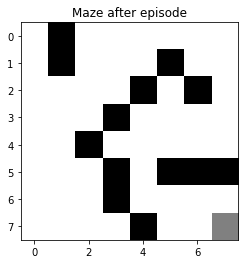

Epoch: 520/999 | Loss: 0.0004 | Episodes: 521 | Win count: 501 | Win rate: 1.000 | time: 1.49 hours
Loss:  7.395984539471101e-05
Loss:  0.0004833529965253547
Loss:  0.000475565466331318
Loss:  0.0004245841264491901
Loss:  0.0002447995102556888
Loss:  0.00039480000850744545
Loss:  0.0004957730416208506
Loss:  0.000645250198431313
Loss:  0.00036378994991537184
Loss:  7.602820733154658e-05
Loss:  0.00018289457148057409
Loss:  0.00033506564795970917
Loss:  0.00033124718174804
Loss:  0.0011780675267800689
Loss:  0.00021320541418390349
Loss:  0.00030273080483311787
Loss:  0.0003721796892932616
Loss:  0.0002321794963791035
Loss:  0.00030502042500302196
Loss:  0.00032991962507367134
Loss:  0.0005456073267851025
Loss:  0.0003182229120284319
Loss:  0.00022507202447741292
Loss:  0.00041456727194599807
Loss:  0.00030119711664156057
Loss:  0.0003150897173327394
Loss:  0.0001912440566229634
Loss:  0.0004945224791299552
Loss:  0.0005632702523143962


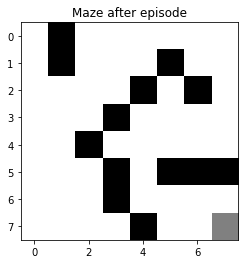

Epoch: 521/999 | Loss: 0.0006 | Episodes: 522 | Win count: 502 | Win rate: 1.000 | time: 1.49 hours
Loss:  0.00017765998927643523
Loss:  0.00037387882184702903
Loss:  7.218421887955628e-05


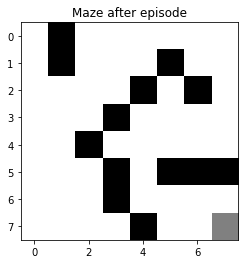

Epoch: 522/999 | Loss: 0.0001 | Episodes: 523 | Win count: 503 | Win rate: 1.000 | time: 1.49 hours
Loss:  0.0003564620710676536
Loss:  5.065939876658376e-05
Loss:  0.0003752837328647729
Loss:  0.00018017312322626822
Loss:  7.557330172858201e-05
Loss:  0.00038341850449796766
Loss:  0.0006092317635193467
Loss:  8.936087760957889e-05
Loss:  0.0007527283451054245
Loss:  0.00023748844614601694
Loss:  0.0003756728983717039
Loss:  0.0001825028084567748
Loss:  0.0004022518915007822
Loss:  0.0004615149227902293
Loss:  0.00027214821602683514
Loss:  0.00018036794062936679
Loss:  0.00030623333441326395
Loss:  0.0001926331369759282
Loss:  0.0003319669485790655
Loss:  0.0003212841838831082
Loss:  0.0005301849014358595
Loss:  0.0004748449136968702
Loss:  0.00015460536815226078
Loss:  0.0002507053686713334


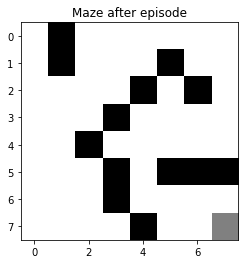

Epoch: 523/999 | Loss: 0.0003 | Episodes: 524 | Win count: 504 | Win rate: 1.000 | time: 1.49 hours
Loss:  3.282525540271308e-05
Loss:  0.0002649435118655674


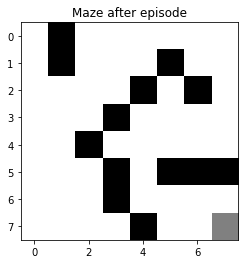

Epoch: 524/999 | Loss: 0.0003 | Episodes: 525 | Win count: 505 | Win rate: 1.000 | time: 1.49 hours
Loss:  0.0003446568407525774
Loss:  8.24535236461088e-05
Loss:  4.1349121602252126e-05
Loss:  0.0005349866551114246
Loss:  0.00032637286494718865
Loss:  0.00014101602209848352
Loss:  0.0003592991706682369
Loss:  0.0003909619554178789
Loss:  0.0003108480741502717
Loss:  0.00029862235533073545
Loss:  0.00041566423169570044
Loss:  0.00015032181545393541
Loss:  0.00020287283405195922
Loss:  0.00018812359849107452
Loss:  0.0005448496813187376
Loss:  0.00017778384062694386
Loss:  0.00026526328656473197
Loss:  0.00022549533969140612
Loss:  0.00016577793576288968
Loss:  0.0003067385077883955
Loss:  0.00030046880419831723
Loss:  0.0003040454466827214
Loss:  0.00025678241581772454
Loss:  0.00029113840719219297
Loss:  0.0003787420937442221
Loss:  0.00026563068968243897
Loss:  0.00015864961460465565
Loss:  0.00035564294012147
Loss:  0.00047317992721218616


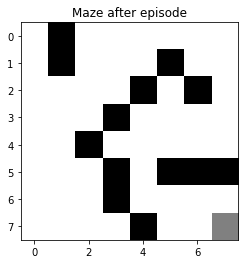

Epoch: 525/999 | Loss: 0.0005 | Episodes: 526 | Win count: 506 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.00021212416504567955
Loss:  3.739264502655715e-05
Loss:  0.0004097425699001178
Loss:  0.0003281418757978827
Loss:  0.0003363590585649945
Loss:  0.0005690587822755333
Loss:  0.0005834070179844275


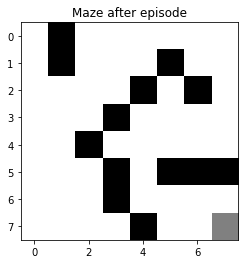

Epoch: 526/999 | Loss: 0.0006 | Episodes: 527 | Win count: 507 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.0005391084705479443
Loss:  0.00044042764784535393
Loss:  0.00018484576867194846
Loss:  0.0001779560716386186
Loss:  0.00033964602334890515
Loss:  0.0005794544122181833
Loss:  0.0002475844885339029
Loss:  0.0003680136287584901
Loss:  0.0006496928399428725
Loss:  0.0003342958079883829
Loss:  0.00013278910046210513
Loss:  0.0003584133373806253
Loss:  0.0005242081970209256
Loss:  0.00040269999590236694
Loss:  0.0003087230143137276
Loss:  0.00019971620349679142
Loss:  0.000308204791508615
Loss:  3.550847395672463e-05
Loss:  0.00048492595669813454
Loss:  0.0005582041339948773
Loss:  0.00014734029900864698
Loss:  0.0003174740413669497


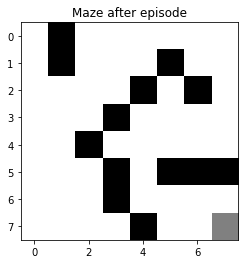

Epoch: 527/999 | Loss: 0.0003 | Episodes: 528 | Win count: 508 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.0002244105053250678
Loss:  0.0003590030682971701
Loss:  0.0003868282801704481
Loss:  0.00036357753560878336
Loss:  0.0003984840295743197
Loss:  0.0003649962891358882
Loss:  0.0003249657092965208
Loss:  0.0004187994491076097
Loss:  0.0005889622552786022
Loss:  0.0006595797894988209
Loss:  0.0002146167098544538
Loss:  0.00026864814572036266
Loss:  0.00013546091213356704
Loss:  0.0004672567156376317
Loss:  0.00017425044825358782
Loss:  8.464068014291115e-05
Loss:  0.0002883142042264808
Loss:  0.0005798042038804851
Loss:  0.00024405651129200123
Loss:  0.00027392475749365985
Loss:  0.00032703953911550343
Loss:  0.00043163834197912365


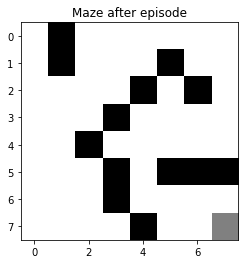

Epoch: 528/999 | Loss: 0.0004 | Episodes: 529 | Win count: 509 | Win rate: 1.000 | time: 1.50 hours
Loss:  9.183682050206698e-05
Loss:  0.00034732927451841533
Loss:  0.0006300354725681245
Loss:  0.00042203823977615684
Loss:  0.0006203528610058129
Loss:  0.00013405733989202417
Loss:  0.00026472059471416287
Loss:  0.00032644217571942136
Loss:  0.0003140939661534503
Loss:  0.00010299122732249089
Loss:  5.605616206594277e-05
Loss:  0.00018495508629712276
Loss:  0.00018945986266771797
Loss:  4.495338725973852e-05
Loss:  0.0003898515133187175
Loss:  0.00015718400391051546
Loss:  0.0004292488156352192
Loss:  0.0003000405358761782
Loss:  0.0005786180554423481
Loss:  0.0005544823943637311
Loss:  0.0005585770049947314
Loss:  0.00040572937359684147
Loss:  0.0002390317531535402


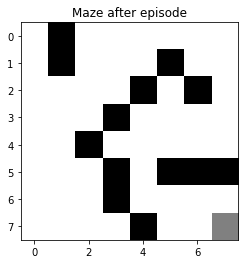

Epoch: 529/999 | Loss: 0.0002 | Episodes: 530 | Win count: 510 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.0002478561691532377
Loss:  7.238584294100292e-05
Loss:  0.00047199953041854315
Loss:  0.00035173150536138564
Loss:  0.00041459090425632894
Loss:  0.00023667782807024196
Loss:  0.00013249347102828324
Loss:  0.0006795249355491251
Loss:  0.0004538846551440656
Loss:  8.325054295710288e-05
Loss:  0.0004979964141966775
Loss:  0.00027761824094341137
Loss:  0.0003762889355130028
Loss:  0.00016954700186033733
Loss:  0.00031300408591050655
Loss:  0.00029456597985699773
Loss:  0.00048613872058922425
Loss:  0.0002698333701118827
Loss:  0.0001988990006793756
Loss:  0.0005520136037375778
Loss:  0.0004348616785136983
Loss:  5.811201481265016e-05
Loss:  0.00022580320364795625
Loss:  0.00011709146565408446
Loss:  0.0005217166180955246
Loss:  0.0002328995178686455
Loss:  8.579695713706315e-05
Loss:  0.00030840271210763603
Loss:  0.0003338414535392076
Loss:  5.621480704576243e-05
Loss:  0.00036233

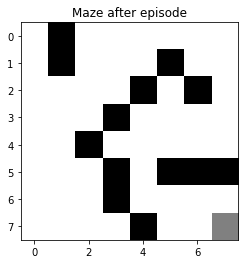

Epoch: 530/999 | Loss: 0.0004 | Episodes: 531 | Win count: 511 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.00033614666608627886
Loss:  0.0003215809992980212
Loss:  0.00028735950036207214
Loss:  0.0008380681683775038
Loss:  0.00024056086840573698
Loss:  0.00029730216738244053
Loss:  0.000738499358703848
Loss:  0.0006869927019579336
Loss:  0.0005574069582507946
Loss:  0.0005089796177344397
Loss:  0.0008921818807721138


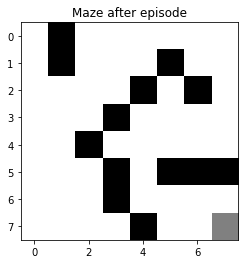

Epoch: 531/999 | Loss: 0.0009 | Episodes: 532 | Win count: 512 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.0008377429330721498
Loss:  0.0002919366233982146
Loss:  0.00035279704025015235
Loss:  0.0009017067204695195


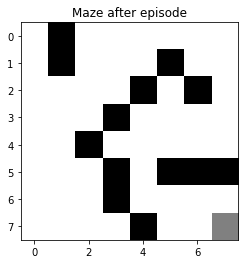

Epoch: 532/999 | Loss: 0.0009 | Episodes: 533 | Win count: 513 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.0001692442128842231
Loss:  0.00037682965921703726
Loss:  0.00016504689847351983
Loss:  0.0004054666933370754
Loss:  0.0013460981426760554
Loss:  0.0007587549043819308
Loss:  0.0003751274707610719
Loss:  0.00028894233400933444
Loss:  0.0005764210945926607
Loss:  0.0006251961167436093
Loss:  0.0007603384729009122


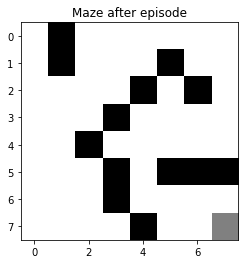

Epoch: 533/999 | Loss: 0.0008 | Episodes: 534 | Win count: 514 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.0006320751126622781
Loss:  0.0002754939632723108
Loss:  0.0005455510981846601
Loss:  0.00040336736128665507


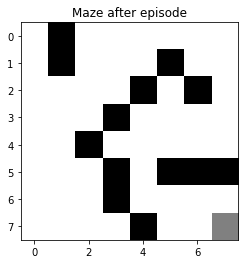

Epoch: 534/999 | Loss: 0.0004 | Episodes: 535 | Win count: 515 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.00036156347050564364
Loss:  0.0009846047614701092
Loss:  0.00074380797741469
Loss:  0.0003501179307932034
Loss:  0.00022585736587643623
Loss:  0.0002813875471474603
Loss:  0.0008200883166864514
Loss:  0.0002631786628626287
Loss:  0.0002587789495009929
Loss:  0.00026245025219395757
Loss:  0.0005584822793025523
Loss:  0.0006806404562667012
Loss:  0.0005272851558402181
Loss:  0.0008302129281219095
Loss:  0.0004544802650343627
Loss:  0.0007223963038995862
Loss:  0.00028625616687349975
Loss:  0.0003335067303851247
Loss:  0.0003207405279681552
Loss:  0.00044786497892346233
Loss:  9.43433005886618e-05
Loss:  0.0005385728873079643


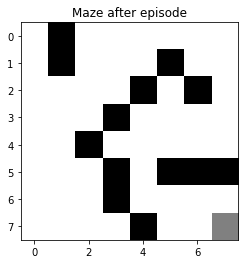

Epoch: 535/999 | Loss: 0.0005 | Episodes: 536 | Win count: 516 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.0003420277062105015
Loss:  0.00038367857632692903
Loss:  0.0004216193192405626
Loss:  0.0002857950094039552
Loss:  0.0009147090022452176
Loss:  0.000247005169512704
Loss:  0.0004399862955324352
Loss:  0.00029843936499673873
Loss:  0.00031416991259902716
Loss:  0.000709098152583465
Loss:  0.00031533496803604066
Loss:  0.000612015079241246
Loss:  0.0003433040255913511
Loss:  0.0005937689857091755
Loss:  0.00019186781719326973
Loss:  0.0006623576628044248


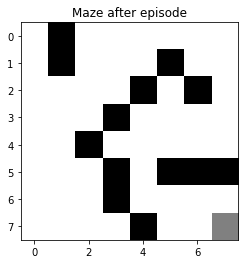

Epoch: 536/999 | Loss: 0.0007 | Episodes: 537 | Win count: 517 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.00039628583181183785
Loss:  0.0003524456187733449
Loss:  0.0007293735397979617
Loss:  0.0005329985870048404
Loss:  0.0003367125755175948
Loss:  0.00038721764576621354
Loss:  0.000237054282479221
Loss:  0.0004917945479974151
Loss:  0.00048717613390181214
Loss:  0.0005962546565569937
Loss:  0.0005928142636548728
Loss:  0.0003832629736280069
Loss:  0.0007884449441917241
Loss:  0.00015376113879028708
Loss:  0.00034078921453328803
Loss:  0.0002234695275546983
Loss:  0.0003031236119568348
Loss:  0.0004441288692760281
Loss:  0.00014600990107282996
Loss:  0.0002501216695236508
Loss:  0.00027071918157162145
Loss:  0.0004291621735319495
Loss:  0.000478544068755582
Loss:  0.0003794856311287731


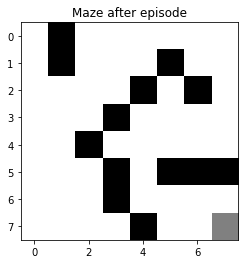

Epoch: 537/999 | Loss: 0.0004 | Episodes: 538 | Win count: 518 | Win rate: 1.000 | time: 1.50 hours
Loss:  0.0003959831374231726
Loss:  0.0005259957833914086
Loss:  0.0004913879529340193
Loss:  0.0003856368421111256
Loss:  0.00025436947908019647
Loss:  0.0007257933611981571
Loss:  0.0003250293302698992
Loss:  0.000305614186800085
Loss:  0.0005212765099713579
Loss:  0.00041772092663450167
Loss:  0.0003785629232879728
Loss:  0.0001171976255136542
Loss:  0.0002736610404099338
Loss:  0.00021469859348144382
Loss:  0.0002616394485812634
Loss:  0.00025929657567758113
Loss:  0.00021633300821122248
Loss:  0.0003164481167914346
Loss:  7.182079207268544e-05
Loss:  0.0003337403468322009
Loss:  0.00011115806773887016
Loss:  0.00044703352614305913
Loss:  0.0003044232362299226
Loss:  0.00023894893820397556
Loss:  0.0005025110440328717
Loss:  0.0006611093413084745
Loss:  0.0003570733388187364
Loss:  0.0003178068945999257


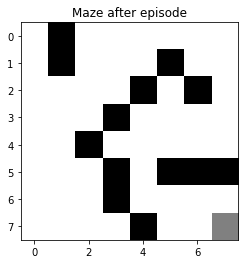

Epoch: 538/999 | Loss: 0.0003 | Episodes: 539 | Win count: 519 | Win rate: 1.000 | time: 1.51 hours
Loss:  0.00041843843791866675
Loss:  0.0003610871790442616
Loss:  0.0004917749320156872
Loss:  0.00021013908190070651
Loss:  0.0001654067891649902
Loss:  0.00026609436281432863
Loss:  0.00027916183171328157
Loss:  0.0004194373614154756
Loss:  0.0009684659307822585
Loss:  0.0005885144928470254
Loss:  0.0003620958377723582
Loss:  0.0002924976870417595
Loss:  0.0004406328371260315
Loss:  0.0006567990276380442
Loss:  0.00011576864926610142
Loss:  0.00032399253905168734
Loss:  0.00036512126098386943
Loss:  0.0006194920279085636
Loss:  0.000576312595512718
Loss:  0.0008543053700122982
Loss:  0.0003074716223636642
Loss:  0.000496474647661671
Loss:  0.00033952957164729014


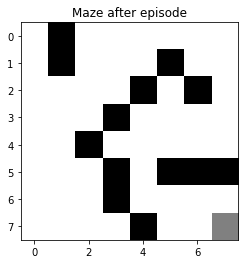

Epoch: 539/999 | Loss: 0.0003 | Episodes: 540 | Win count: 520 | Win rate: 1.000 | time: 1.51 hours
Loss:  0.0005459098683786578
Loss:  0.0005463687411975116
Loss:  0.0006472643290180713
Loss:  0.0002318685219506733
Loss:  0.00012175447773188353
Loss:  0.0004899797204416245
Loss:  0.0002777072077151388
Loss:  0.0003181053762091324
Loss:  0.00013120304356561974
Loss:  0.0002502307288523298
Loss:  0.0002488947684469167
Loss:  0.00020728581148432568
Loss:  0.0003598379116738215
Loss:  0.0001292244196520187
Loss:  0.00031370673968922347
Loss:  0.0003078892477788031
Loss:  0.00017727218801155686
Loss:  0.00032251404627459124
Loss:  0.0001572174660395831
Loss:  0.0005067060701549053
Loss:  0.00043524730426725
Loss:  0.00026839178826776333
Loss:  0.0001795359858078882
Loss:  0.0003039006551261991
Loss:  0.0003497028519632295
Loss:  0.0004807905061170459
Loss:  0.0002740322524914518
Loss:  0.00022964194067753851
Loss:  0.00035710775409825146
Loss:  0.00028523864602902904
Loss:  0.0006177678005

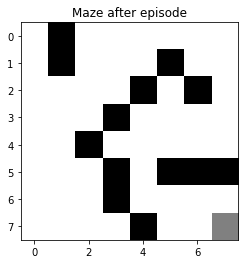

Epoch: 540/999 | Loss: 0.0006 | Episodes: 541 | Win count: 521 | Win rate: 1.000 | time: 1.51 hours
Loss:  0.00014042862312635407
Loss:  0.0003059593800571747
Loss:  0.0002579388674348593
Loss:  0.0002519485424272716
Loss:  0.0004546027921605855
Loss:  0.00010220027616014704
Loss:  9.43456034292467e-05


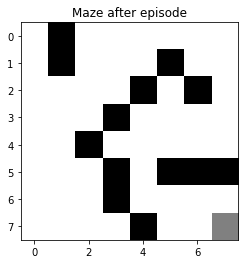

Epoch: 541/999 | Loss: 0.0001 | Episodes: 542 | Win count: 522 | Win rate: 1.000 | time: 1.51 hours
Loss:  0.00033777806675061584
Loss:  0.00045663275523111224
Loss:  0.0005207784997764975
Loss:  0.0003048560320166871
Loss:  0.0002994076203322038
Loss:  0.0006676443153992295
Loss:  0.00034096743911504745


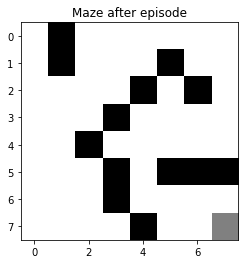

Epoch: 542/999 | Loss: 0.0003 | Episodes: 543 | Win count: 523 | Win rate: 1.000 | time: 1.51 hours
Loss:  0.00010249483239022084
Loss:  0.0002290860575158149
Loss:  0.0005445284186862409
Loss:  0.00031350497738458216
Loss:  0.0003426687981118448
Loss:  0.0002587111266620923
Loss:  0.00029460513178491965
Loss:  2.3291924662771635e-05
Loss:  0.00028848891088273376


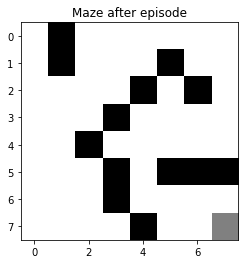

Epoch: 543/999 | Loss: 0.0003 | Episodes: 544 | Win count: 524 | Win rate: 1.000 | time: 1.51 hours
Loss:  0.0003272584290243685
Loss:  0.00031245780701283365


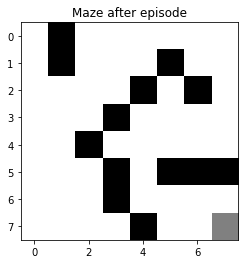

Epoch: 544/999 | Loss: 0.0003 | Episodes: 545 | Win count: 525 | Win rate: 1.000 | time: 1.51 hours
Loss:  0.000646817177766934
Loss:  0.00036618192098103464
Loss:  8.466116560157388e-05
Loss:  8.000366506166756e-05
Loss:  0.00028760809072991833
Loss:  6.191001375555061e-05
Loss:  0.00028654780908254907
Loss:  0.0004795540007762611
Loss:  0.00021716854826081544
Loss:  0.00016485372179886326
Loss:  0.00024991246027639136
Loss:  0.00011669952436932363
Loss:  0.00022435555001720786
Loss:  0.0001295714100706391
Loss:  0.0003689360019052401
Loss:  0.0004401133628562093
Loss:  0.00031473833223572
Loss:  0.00030498170235659927
Loss:  8.230563616962172e-05
Loss:  0.00020987679090467282
Loss:  0.00034679171221796423
Loss:  0.00016114591198856942
Loss:  0.0004119637142139254
Loss:  0.00018276266928296536
Loss:  0.000156936512212269


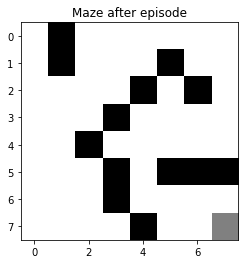

Epoch: 545/999 | Loss: 0.0002 | Episodes: 546 | Win count: 526 | Win rate: 1.000 | time: 1.51 hours
Loss:  0.00011256204561505001
Loss:  0.000554018381080823
Loss:  0.00013959570424049161
Loss:  0.0006358583341352642
Loss:  0.0005066200392320752
Loss:  0.00036815298517467454
Loss:  0.0002415106719126925
Loss:  0.00028435148124117404
Loss:  0.0002653223054949194
Loss:  0.00016291989595629275
Loss:  0.00036539592838380486
Loss:  0.0002750401617959142
Loss:  0.00010724268031481188
Loss:  0.00030150120801408775
Loss:  0.00017996974202105775
Loss:  0.00048426742432639003
Loss:  0.0002796323096845299
Loss:  0.00026934529887512326
Loss:  0.00045249286631587893
Loss:  0.00026889627042692155
Loss:  0.0001563869445817545


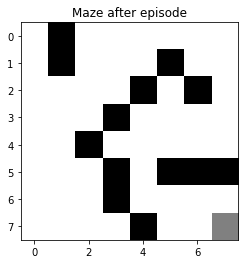

Epoch: 546/999 | Loss: 0.0002 | Episodes: 547 | Win count: 527 | Win rate: 1.000 | time: 1.51 hours
Loss:  9.088478327612393e-05
Loss:  0.000248147689489997
Loss:  0.0001900704883155413
Loss:  0.00016934255108935758
Loss:  0.0002887603623094037
Loss:  1.3640759789268486e-05
Loss:  0.00026644648460205644
Loss:  0.00015345789870480075
Loss:  0.0002183668675570516


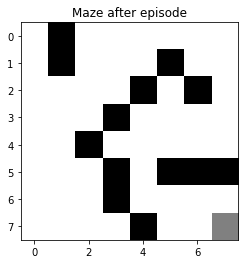

Epoch: 547/999 | Loss: 0.0002 | Episodes: 548 | Win count: 528 | Win rate: 1.000 | time: 1.51 hours
Loss:  0.000355879426933825
Loss:  0.00022497934514831286
Loss:  8.616455670562573e-05
Loss:  0.00018113043915946037
Loss:  0.00036095065297558904
Loss:  0.0002254551582154818
Loss:  0.00038724719343008474
Loss:  0.00040660882950760424
Loss:  7.332768836931791e-05
Loss:  9.545647117192857e-05
Loss:  0.00038044125176384114
Loss:  0.00023372799114440568
Loss:  9.562573177390732e-05
Loss:  0.00020597623733920045
Loss:  5.992411115585128e-05
Loss:  6.381819548550993e-05
Loss:  0.0004917256737826392
Loss:  0.0003856711700791493
Loss:  0.00027343427427695133
Loss:  0.00019678001262946054
Loss:  7.199804167612456e-05
Loss:  0.0004767067148350179
Loss:  0.00016271673666778952
Loss:  0.0003652801096905023
Loss:  0.0005750238633481786
Loss:  0.0006823403673479334


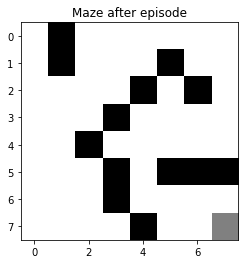

Epoch: 548/999 | Loss: 0.0007 | Episodes: 549 | Win count: 529 | Win rate: 1.000 | time: 1.51 hours
Loss:  0.0002910314069595188
Loss:  0.000289775911369361
Loss:  0.0002528631885070354
Loss:  0.00020170489005977288
Loss:  0.0004813919367734343
Loss:  0.0006144518265500665
Loss:  0.00035129828029312193
Loss:  0.00019179893570253626
Loss:  0.00022852878464618698


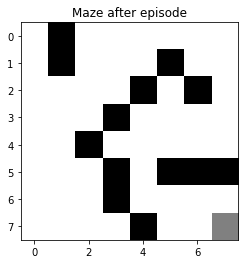

Epoch: 549/999 | Loss: 0.0002 | Episodes: 550 | Win count: 530 | Win rate: 1.000 | time: 1.51 hours
Loss:  0.00035000580828636885
Loss:  0.0001490120448579546
Loss:  0.00020609801867976785
Loss:  0.00032453641324536875
Loss:  0.0003453714307397604
Loss:  0.00012897560372948647
Loss:  0.00028143779854872264
Loss:  0.0005258840974420309
Loss:  0.00026613268710207194
Loss:  0.00035889829450752586
Loss:  0.0003257280040998012
Loss:  8.452437032246962e-05
Loss:  0.00026528583839535713
Loss:  0.00021615616424242035
Loss:  0.00022036473819753155
Loss:  0.000589227165619377
Loss:  0.00010721575381467119
Loss:  0.0004679026715166401
Loss:  0.00010933052180917002
Loss:  0.0002482751660863869
Loss:  0.0004350684175733477
Loss:  0.00033003878706949763
Loss:  9.956678695743904e-05
Loss:  0.0003889906802214682
Loss:  5.3320786719268654e-05
Loss:  0.000289079689537175
Loss:  0.000385336737963371
Loss:  0.00028318233671598136
Loss:  0.00043850013753399253
Loss:  0.00028051267145201564


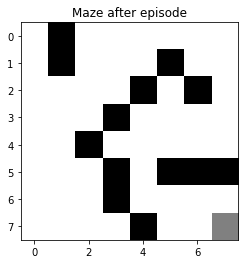

Epoch: 550/999 | Loss: 0.0003 | Episodes: 551 | Win count: 531 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.00018403627473162487
Loss:  0.00027905002934858203
Loss:  0.00025185853883158416
Loss:  0.0002723911456996575
Loss:  0.00012450900248950347
Loss:  0.00041003647493198514
Loss:  0.0003162233915645629
Loss:  8.759380943956785e-05
Loss:  0.00016847966981003992
Loss:  0.00029825915407855064
Loss:  0.00047957613423932344
Loss:  0.0004428709507919848
Loss:  0.0003750071191461757
Loss:  0.0005032731496612541
Loss:  0.0001176617261080537
Loss:  0.00012699285434791818
Loss:  0.0004333995602792129


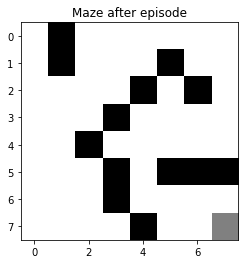

Epoch: 551/999 | Loss: 0.0004 | Episodes: 552 | Win count: 532 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.0002882347907871008
Loss:  0.000318465507007204
Loss:  0.00023541216069133952
Loss:  0.0002132975569111295
Loss:  9.373395369038917e-05
Loss:  9.678504648036323e-05
Loss:  0.0001956005289684981
Loss:  0.0005728083779104054
Loss:  0.00048522261204198003
Loss:  0.00011645952326944098
Loss:  0.00018591328262118623
Loss:  7.171898687374778e-05
Loss:  0.0003970208636019379
Loss:  0.000422100507421419
Loss:  0.00016692752615199424
Loss:  0.0005270276378723793
Loss:  0.00010526525147724897
Loss:  0.00021189174731262028
Loss:  0.0004439176045707427
Loss:  0.00022581248049391434
Loss:  0.00013195283645472955
Loss:  0.00040985892701428384
Loss:  7.00674754625652e-05
Loss:  0.00039220160397235304
Loss:  0.00021574999846052378
Loss:  0.0001028850447255536
Loss:  0.00020740245963679627
Loss:  0.0002499185429769568
Loss:  0.00010155428753932938


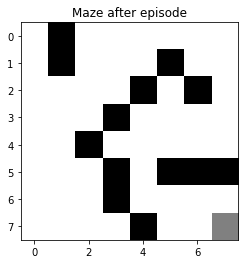

Epoch: 552/999 | Loss: 0.0001 | Episodes: 553 | Win count: 533 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.0002278931569890119
Loss:  0.00026431163132656366
Loss:  3.8170557672856376e-05
Loss:  0.0001508174027549103
Loss:  0.0003946193028241396
Loss:  0.000448780701844953
Loss:  5.520315062312875e-05


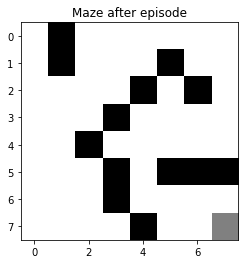

Epoch: 553/999 | Loss: 0.0001 | Episodes: 554 | Win count: 534 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.00034085128572769463
Loss:  0.0002462690608808771
Loss:  6.307894909696188e-05
Loss:  3.56014134013094e-05
Loss:  0.0002467298363626469
Loss:  0.00023075910576153547
Loss:  0.00023867319396231323
Loss:  0.00023821720242267475
Loss:  0.0003905745397787541
Loss:  0.00022643958072876558
Loss:  0.0002587653652881272
Loss:  8.57532795635052e-05
Loss:  0.00025530629500281066
Loss:  0.000369035973562859
Loss:  2.4830125767039135e-05
Loss:  0.0002999063581228256
Loss:  4.499555143411271e-05
Loss:  7.61025512474589e-05
Loss:  0.00018374556657363428
Loss:  0.00019003568741027266


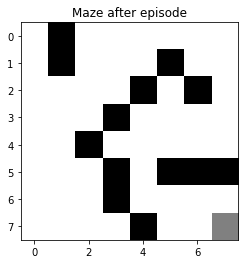

Epoch: 554/999 | Loss: 0.0002 | Episodes: 555 | Win count: 535 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.0003508400995997363
Loss:  0.0002630150665936526
Loss:  0.00011389520295779221
Loss:  0.00043355394154787064
Loss:  0.0002914714423241094
Loss:  0.00011036642172257416
Loss:  0.0003991158737335354
Loss:  0.00035909353755414486
Loss:  0.0002899046667153016
Loss:  0.0002176084126404021
Loss:  8.319336848217063e-05
Loss:  0.0003447603048698511
Loss:  0.0004563086695270613
Loss:  0.00021339448358048685
Loss:  0.00016616380162304267
Loss:  0.0003558415573934326
Loss:  0.00022497061945614405
Loss:  4.4376614823704585e-05
Loss:  0.0004320435400586575


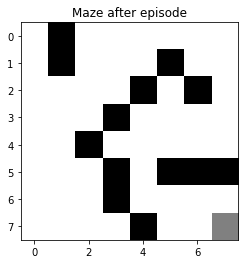

Epoch: 555/999 | Loss: 0.0004 | Episodes: 556 | Win count: 536 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.00029132908093743026
Loss:  0.00031855596898822114
Loss:  0.00039101880975067616
Loss:  5.590677210420836e-05
Loss:  0.0002108446460624691
Loss:  0.0003372030769241974
Loss:  0.00027543254691408947
Loss:  0.0002950056514237076
Loss:  0.00013010429211135488
Loss:  0.00014490502144326456
Loss:  0.000357705561327748
Loss:  4.596162762027234e-05
Loss:  0.0003258622673456557
Loss:  0.00021328660295694135
Loss:  0.00014630677105742507
Loss:  4.298980911698891e-05
Loss:  0.00015280942898243666
Loss:  0.0001556693741804338


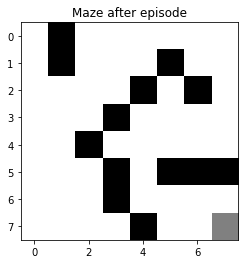

Epoch: 556/999 | Loss: 0.0002 | Episodes: 557 | Win count: 537 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.00019668567256303504
Loss:  7.24665769666899e-05
Loss:  6.31958209851291e-05
Loss:  5.260717489363742e-05
Loss:  7.449702388839796e-05
Loss:  0.0003981381596531719
Loss:  0.000371944421203807


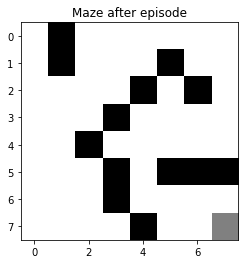

Epoch: 557/999 | Loss: 0.0004 | Episodes: 558 | Win count: 538 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.0002980263780045789
Loss:  7.916163667687215e-05
Loss:  0.0002786696932162158
Loss:  0.0001712499142740853
Loss:  0.0002531419668230228
Loss:  5.8421125686436426e-05
Loss:  0.0002288704999955371
Loss:  0.0002828758442774415


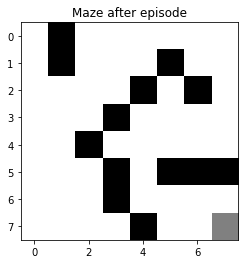

Epoch: 558/999 | Loss: 0.0003 | Episodes: 559 | Win count: 539 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.00029800108313793316
Loss:  0.000475365810416406
Loss:  3.941342765756417e-05
Loss:  0.00030406819860218093
Loss:  0.0003915347333531827
Loss:  0.00024970002777990885
Loss:  0.00029587098106276244
Loss:  0.0005724783550249413
Loss:  0.00037117674946784973
Loss:  7.302674202946946e-05
Loss:  0.0001894843935588142
Loss:  0.00019936420721933246
Loss:  7.02102915965952e-05
Loss:  0.00042931038478855044
Loss:  0.00017933377239387482
Loss:  8.665284622111358e-05
Loss:  0.0001991061981243547
Loss:  0.0002229440815426642
Loss:  0.0003382164577487856
Loss:  0.00013051594578428194
Loss:  0.00018389758770354092
Loss:  0.00048724032239988446
Loss:  0.00020382405273267068
Loss:  0.0003101126494584605
Loss:  0.00039568716601934284
Loss:  0.0002927322238974739
Loss:  0.00022713693761033937


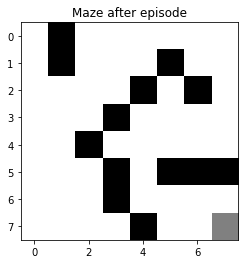

Epoch: 559/999 | Loss: 0.0002 | Episodes: 560 | Win count: 540 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.0006047953356755897
Loss:  0.00015298173821065575
Loss:  0.00028060512704541907
Loss:  0.00028305064188316464
Loss:  0.00019036476442124695
Loss:  0.000371953548892634
Loss:  0.00022448892195825465


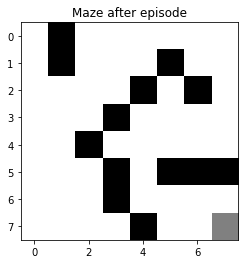

Epoch: 560/999 | Loss: 0.0002 | Episodes: 561 | Win count: 541 | Win rate: 1.000 | time: 1.52 hours
Loss:  3.7581778087769635e-05
Loss:  0.00039234638097696006
Loss:  0.00027614986174739897
Loss:  0.00020267536820028909
Loss:  0.0002261375411762856
Loss:  0.00022735916354577057
Loss:  0.00014060194371268153
Loss:  0.0001287071736442158
Loss:  0.0002720741758821532
Loss:  0.00023948571470100433
Loss:  0.0002729126572376117
Loss:  0.0002967864493257366
Loss:  0.00020455474441405386
Loss:  0.0004329174553276971
Loss:  0.00040760730917099863
Loss:  0.0003175447491230443
Loss:  0.00023601052816957235
Loss:  2.7665329980663955e-05
Loss:  0.0002577440027380362
Loss:  0.00014673781515739392
Loss:  0.0003421241490286775


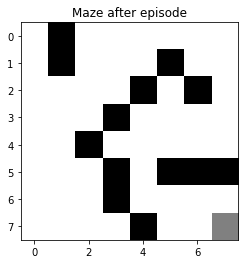

Epoch: 561/999 | Loss: 0.0003 | Episodes: 562 | Win count: 542 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.0001930186990648508
Loss:  4.167115912423469e-05
Loss:  0.00038690273504471406
Loss:  0.00021356563593144529
Loss:  0.0001367055683658691
Loss:  0.00041626556776463985
Loss:  5.963586954749189e-05
Loss:  0.00017230416870006593
Loss:  4.074610296811443e-05
Loss:  7.72732419136446e-05
Loss:  0.00043019016447942704
Loss:  0.00020546730956993997
Loss:  9.69596512732096e-05
Loss:  0.0003535321884555742
Loss:  9.647391198086552e-05
Loss:  0.00022591529705096036


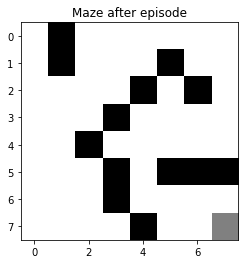

Epoch: 562/999 | Loss: 0.0002 | Episodes: 563 | Win count: 543 | Win rate: 1.000 | time: 1.52 hours
Loss:  0.000125415732327383
Loss:  0.00014938922595320037
Loss:  2.9097972401359584e-05
Loss:  1.1862192877742928e-05
Loss:  0.000390086104744114
Loss:  0.00017898069472721545
Loss:  0.00024572029360570014
Loss:  4.21401382482145e-05
Loss:  0.00033299413917120546
Loss:  0.00019838330354104983
Loss:  4.335861467552604e-05
Loss:  4.434896800376009e-05
Loss:  0.00026695649648900144
Loss:  8.05725903774146e-05
Loss:  0.00017624711472308263
Loss:  0.000287381379166618


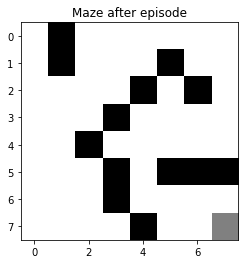

Epoch: 563/999 | Loss: 0.0003 | Episodes: 564 | Win count: 544 | Win rate: 1.000 | time: 1.53 hours
Loss:  0.00031239265808835626
Loss:  2.616966867208248e-05
Loss:  4.56831585324835e-05
Loss:  3.0299427635327447e-05
Loss:  0.0002518214805604657
Loss:  0.0001819303652155213
Loss:  8.252938641817309e-05
Loss:  0.00027794937705039047
Loss:  0.00028338645643088967
Loss:  0.00026292849361198023
Loss:  5.350517312763259e-05
Loss:  0.00016699955085641704
Loss:  0.00018248754713567905
Loss:  0.00015984068340912927
Loss:  1.9159682778990828e-05
Loss:  3.8850423152325675e-05


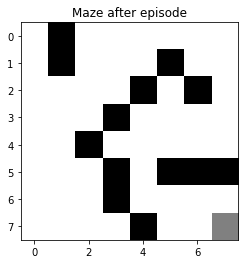

Epoch: 564/999 | Loss: 0.0000 | Episodes: 565 | Win count: 545 | Win rate: 1.000 | time: 1.53 hours
Loss:  0.00011012240247509908
Loss:  0.0001983598012884613
Loss:  4.774442186317174e-05
Loss:  0.0002158995921490714
Loss:  0.0001438470044377027
Loss:  0.00012956312457390595
Loss:  0.00024301458324771374
Loss:  0.00012610639896593057
Loss:  0.00017946018851944245
Loss:  0.00014305393051472493
Loss:  2.2616363821725827e-05
Loss:  3.275734889029991e-05
Loss:  9.385214616486337e-05
Loss:  1.1364483270881465e-05
Loss:  0.00014041529175301548
Loss:  0.0002966370084322989
Loss:  3.762310188903939e-05
Loss:  0.0004373067931737751
Loss:  0.00013792754180030897
Loss:  0.00020537219097604975
Loss:  0.0002117484218615573
Loss:  0.00011330789038765943
Loss:  0.0001966688760148827
Loss:  5.702815906261094e-05
Loss:  3.088837911491282e-05
Loss:  1.5436156900250353e-05


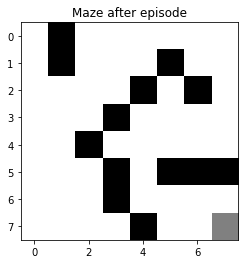

Epoch: 565/999 | Loss: 0.0000 | Episodes: 566 | Win count: 546 | Win rate: 1.000 | time: 1.53 hours
Loss:  0.0001242405214725295
Loss:  5.406267246144125e-05
Loss:  0.0002709883337956853
Loss:  4.6819130147923715e-05
Loss:  0.00013446997763821855
Loss:  8.587271440774202e-05
Loss:  0.00024741234301473014
Loss:  0.00020936652435921133
Loss:  0.00017972959358303342
Loss:  0.00039594140253029764
Loss:  0.00017435904737794772
Loss:  5.6701197536312975e-05
Loss:  0.00025507529062451795
Loss:  4.041961619805079e-05
Loss:  0.00036207589437253773
Loss:  0.00036420871037989855
Loss:  0.00019353698007762432
Loss:  0.0004774453118443489
Loss:  0.00029894091858295724
Loss:  0.0002867202929337509
Loss:  7.818125232006423e-05
Loss:  0.00025331481265311595
Loss:  0.0002211225073551759
Loss:  0.0002913181269832421
Loss:  4.0342660213354975e-05


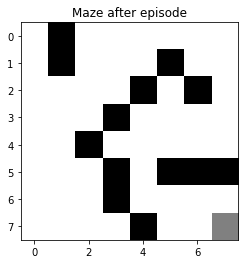

Epoch: 566/999 | Loss: 0.0000 | Episodes: 567 | Win count: 547 | Win rate: 1.000 | time: 1.53 hours
Loss:  0.0003480783234408591


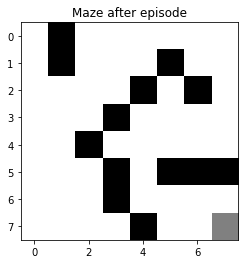

Epoch: 567/999 | Loss: 0.0003 | Episodes: 568 | Win count: 548 | Win rate: 1.000 | time: 1.53 hours
Loss:  4.142696343478747e-05
Loss:  4.30842974310508e-05
Loss:  0.0005564447783399373
Loss:  0.00041438473272137344
Loss:  0.00033774097391869873
Loss:  0.00018617693422129378
Loss:  4.936650657327846e-05
Loss:  0.00010952116463158745
Loss:  0.0003060387898585759
Loss:  2.7572231374506373e-05
Loss:  6.609348656638758e-05
Loss:  6.874647078802809e-05
Loss:  0.00023008375683275517
Loss:  0.0003527849621605128
Loss:  0.00026454621365701314
Loss:  0.00016078773842309602
Loss:  0.00010567957360763103
Loss:  0.00018509814617573284
Loss:  0.00017039566228049807
Loss:  0.0003038564755115658
Loss:  6.515307541121729e-05
Loss:  0.00017760587070370093


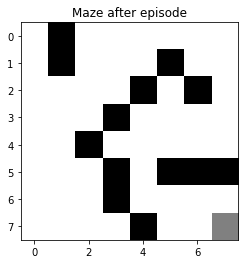

Epoch: 568/999 | Loss: 0.0002 | Episodes: 569 | Win count: 549 | Win rate: 1.000 | time: 1.53 hours
Loss:  0.0002759288836386986
Loss:  0.0001883619734144304
Loss:  0.00021292217570589855
Loss:  9.691995273897192e-05


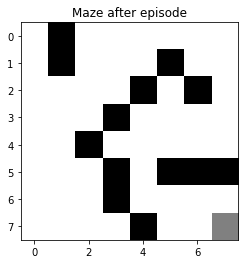

Epoch: 569/999 | Loss: 0.0001 | Episodes: 570 | Win count: 550 | Win rate: 1.000 | time: 1.53 hours
Loss:  3.158508843625896e-05
Loss:  0.00020366774697322398
Loss:  0.00024256813048850745
Loss:  0.00019387920474400744
Loss:  5.3985644626664e-05
Loss:  4.229486739859567e-05
Loss:  3.551584268279839e-05
Loss:  0.00019622613035608083
Loss:  0.00028711553022731096
Loss:  3.295351689303061e-05
Loss:  0.00010444224608363584
Loss:  0.0002543639493524097
Loss:  7.3424685979262e-05
Loss:  2.0305115867813583e-05
Loss:  0.00019122857702313922
Loss:  0.00012265683108125813
Loss:  0.00019353433526703157
Loss:  3.7464114029717166e-05
Loss:  0.00040219172296929173
Loss:  0.0002597751881694421
Loss:  2.4177406885428354e-05
Loss:  0.00019458768292679451
Loss:  0.00011852540774270892


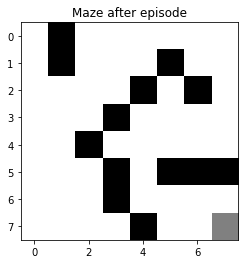

Epoch: 570/999 | Loss: 0.0001 | Episodes: 571 | Win count: 551 | Win rate: 1.000 | time: 1.53 hours
Loss:  0.0003688871511258185
Loss:  0.00022210300085134804
Loss:  0.00015171008817560505
Loss:  7.307765554287471e-05
Loss:  0.00048742884246166795
Loss:  0.0004084596876055002
Loss:  0.00022365526820067316
Loss:  0.0003945333301089704
Loss:  0.00014649627155449707
Loss:  0.00028479013417381793
Loss:  0.00027532624517334625
Loss:  6.856933032395318e-05
Loss:  0.00023474279078072868
Loss:  0.00024367532751057297
Loss:  0.0001345479322480969
Loss:  5.827638233313337e-05
Loss:  0.00019903040447388776
Loss:  7.469914635294117e-05
Loss:  0.00034832808159990236
Loss:  0.0002248626060463721
Loss:  0.0001285934413317591
Loss:  0.0002143226593034342
Loss:  2.2445967260864563e-05
Loss:  6.992917860770831e-05
Loss:  0.0003603414515964687
Loss:  0.00027403919375501573
Loss:  0.00025301959249190986
Loss:  0.00026133617939194664
Loss:  0.0003398854532861151
Loss:  9.297240831074305e-05
Loss:  0.000211

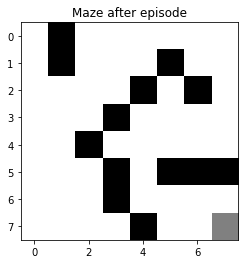

Epoch: 571/999 | Loss: 0.0002 | Episodes: 572 | Win count: 552 | Win rate: 1.000 | time: 1.53 hours
Loss:  2.4201954147429205e-05
Loss:  0.0003791867638938129
Loss:  8.734198490856215e-05
Loss:  0.00025323627050966024
Loss:  6.103139457991347e-05
Loss:  0.00022009243548382074
Loss:  0.00024374196800636128
Loss:  5.652704021485988e-05
Loss:  0.00016733290067350026
Loss:  0.00026295801217202097
Loss:  0.00022547874323208816
Loss:  8.313484249811154e-05
Loss:  0.0004131207970203832
Loss:  0.00020982700152671896
Loss:  9.803809734876268e-05
Loss:  0.00019049954607908148
Loss:  0.0001691881934675621
Loss:  0.0004202056588837877
Loss:  0.0003292986220913008
Loss:  4.72114043077454e-05
Loss:  0.00017269076488446444
Loss:  0.0003278174754086649
Loss:  0.0002557936168159358
Loss:  3.94829512515571e-05
Loss:  0.00016784818581072614
Loss:  0.0002017592241827515
Loss:  7.107551937224343e-05
Loss:  1.9809292098216247e-05
Loss:  0.00016921653877943754
Loss:  0.000272007080639014


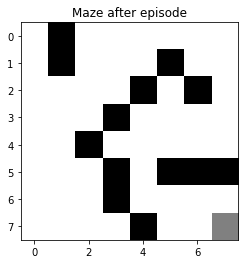

Epoch: 572/999 | Loss: 0.0003 | Episodes: 573 | Win count: 553 | Win rate: 1.000 | time: 1.53 hours
Loss:  0.00010465442937857006
Loss:  0.0003678835855680518
Loss:  0.00022643899137619883
Loss:  4.2236076296831015e-05
Loss:  0.0003416481922613457
Loss:  0.0003349628677824512
Loss:  0.00029084537527523935
Loss:  5.02326092828298e-05
Loss:  3.82613197871251e-05
Loss:  0.00018347632249060553
Loss:  0.0002196668938267976
Loss:  3.714326157933101e-05
Loss:  0.0002445490063109901
Loss:  0.00025863693554128986
Loss:  4.601962245942559e-05
Loss:  0.00035144007415510714
Loss:  0.0002329520521016093
Loss:  4.699068267655093e-05
Loss:  0.00020978545944672078
Loss:  0.00021427297906484455
Loss:  0.00021900438514421694
Loss:  0.00028267411653359886
Loss:  0.00012074259666405851
Loss:  0.00035048149584326893


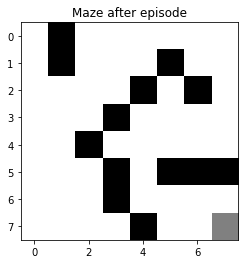

Epoch: 573/999 | Loss: 0.0004 | Episodes: 574 | Win count: 554 | Win rate: 1.000 | time: 1.53 hours
Loss:  8.756158331379993e-05
Loss:  4.783321219292702e-05
Loss:  1.058219686456141e-05
Loss:  2.469884839229053e-05
Loss:  0.0004163372432230972
Loss:  0.00037929293466731906
Loss:  0.00020293734996812418
Loss:  7.25827703718096e-05
Loss:  5.003156366001349e-05
Loss:  0.00034386773768346757
Loss:  2.0142718312854413e-05
Loss:  3.051418207178358e-05
Loss:  0.00013569338034358225
Loss:  3.481376324998564e-05


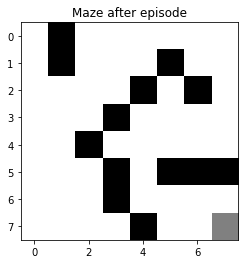

Epoch: 574/999 | Loss: 0.0000 | Episodes: 575 | Win count: 555 | Win rate: 1.000 | time: 1.54 hours
Loss:  5.5657632401562296e-05
Loss:  0.0001627478186492226
Loss:  9.458084059588145e-05
Loss:  7.014884067757521e-05
Loss:  0.0001864054793259129
Loss:  0.00020171281357761472
Loss:  0.0003658734931377694


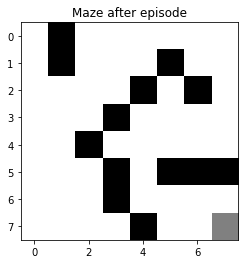

Epoch: 575/999 | Loss: 0.0004 | Episodes: 576 | Win count: 556 | Win rate: 1.000 | time: 1.54 hours
Loss:  0.0001628752870601602
Loss:  0.00016915651940507814
Loss:  8.924184294301085e-05
Loss:  4.2913130528177135e-05
Loss:  0.00019085728308709804
Loss:  0.00034095549199264497
Loss:  2.6323472411604598e-05
Loss:  4.789283138961764e-05
Loss:  0.00033942702430067584


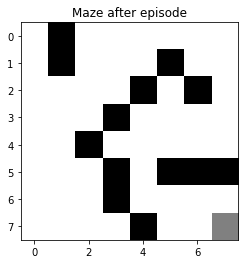

Epoch: 576/999 | Loss: 0.0003 | Episodes: 577 | Win count: 557 | Win rate: 1.000 | time: 1.54 hours
Loss:  8.131045706250006e-05
Loss:  0.00016640039757476188
Loss:  3.636726069089491e-05
Loss:  0.0001497801968071144
Loss:  0.00016234518716373714
Loss:  0.00020144766494922806
Loss:  7.126988202799112e-05
Loss:  2.653018782439176e-05
Loss:  0.00032633563023409806
Loss:  0.0002046605477517005
Loss:  0.00015298598373192362
Loss:  0.00019461487681837752
Loss:  0.00020424895774340257
Loss:  0.0001868732761067804
Loss:  9.817387399380095e-05
Loss:  3.485672459646594e-05
Loss:  4.374044692667667e-05
Loss:  0.00022593323956243694
Loss:  0.00035950273377238773
Loss:  0.00012493493704823777
Loss:  0.0003022116725333035
Loss:  5.451549714052817e-05


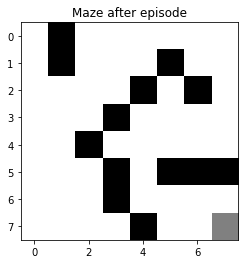

Epoch: 577/999 | Loss: 0.0001 | Episodes: 578 | Win count: 558 | Win rate: 1.000 | time: 1.54 hours
Loss:  0.00018549355627328623
Loss:  0.0001680607047092053


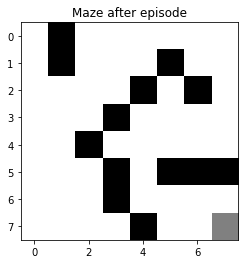

Epoch: 578/999 | Loss: 0.0002 | Episodes: 579 | Win count: 559 | Win rate: 1.000 | time: 1.54 hours
Loss:  0.00045349365973379463
Loss:  0.0001905693734443048
Loss:  0.0005074846267234534
Loss:  6.407696128007956e-05
Loss:  0.00022008752785040997
Loss:  0.00023069672170095146
Loss:  0.00015850191266508773
Loss:  0.0001284187710552942
Loss:  6.254364416236058e-05
Loss:  0.0002917898091254756


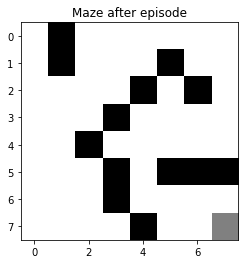

Epoch: 579/999 | Loss: 0.0003 | Episodes: 580 | Win count: 560 | Win rate: 1.000 | time: 1.54 hours
Loss:  0.0003999796463176608
Loss:  7.675061715417542e-05
Loss:  0.00015143072960199788
Loss:  0.00014166222763378755
Loss:  7.542558159912005e-05
Loss:  7.331194683501963e-05
Loss:  4.9757127271732315e-05
Loss:  1.639432366573601e-05
Loss:  0.0001769078253346379
Loss:  3.6160231502435636e-05
Loss:  7.504901259380858e-05


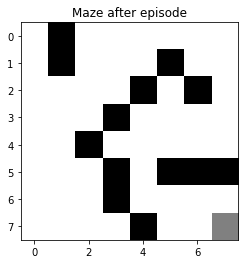

Epoch: 580/999 | Loss: 0.0001 | Episodes: 581 | Win count: 561 | Win rate: 1.000 | time: 1.54 hours
Loss:  0.00014284090411820216
Loss:  4.9845499688672135e-05
Loss:  0.0002807199052767828


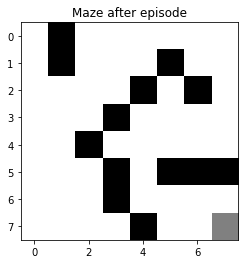

Epoch: 581/999 | Loss: 0.0003 | Episodes: 582 | Win count: 562 | Win rate: 1.000 | time: 1.54 hours
Loss:  5.624805180559633e-05
Loss:  8.726563464733772e-05
Loss:  3.085550542891724e-05
Loss:  2.8269564609217923e-05
Loss:  0.00019650288959383033
Loss:  0.00011894316685356898
Loss:  0.00015994723617041018
Loss:  0.00015985138452379033
Loss:  0.0001896852863865206
Loss:  0.00030751503982173745
Loss:  0.00018943770010082517
Loss:  0.00033944415918085724
Loss:  0.0001473039355914807
Loss:  3.368766829225933e-05
Loss:  2.9673028620891273e-05


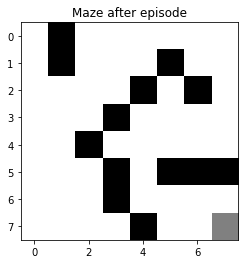

Epoch: 582/999 | Loss: 0.0000 | Episodes: 583 | Win count: 563 | Win rate: 1.000 | time: 1.54 hours
Loss:  3.2121233743964694e-05
Loss:  0.00014475029456662014
Loss:  3.272938192822039e-05
Loss:  1.1331546375004109e-05
Loss:  3.5647015465656295e-05
Loss:  1.4327585631690454e-05
Loss:  0.00012567506564664654
Loss:  1.5152520063566044e-05
Loss:  0.00016776360280346125
Loss:  0.00018094469123752788
Loss:  0.00027454321570985485
Loss:  0.0004620948893716559
Loss:  0.0002056537487078458
Loss:  0.00011458453082013875
Loss:  6.625163587159477e-05
Loss:  0.00027358940860722214
Loss:  4.1676603359519504e-05
Loss:  2.8322976504568942e-05
Loss:  0.0002045277888100827
Loss:  3.949929669033736e-05
Loss:  0.00013589019181381445
Loss:  2.441655033180723e-05
Loss:  3.144405309285503e-05
Loss:  0.00017605094217287842
Loss:  3.0250270356191322e-05
Loss:  2.6181726752838586e-05


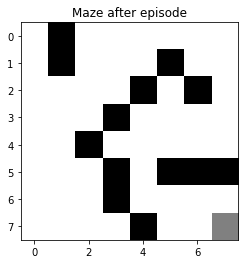

Epoch: 583/999 | Loss: 0.0000 | Episodes: 584 | Win count: 564 | Win rate: 1.000 | time: 1.54 hours
Loss:  0.000186168580512458
Loss:  0.00027102683088742197
Loss:  0.00025102174549829215
Loss:  0.00013073362424620427


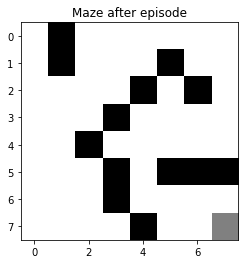

Epoch: 584/999 | Loss: 0.0001 | Episodes: 585 | Win count: 565 | Win rate: 1.000 | time: 1.54 hours
Loss:  0.0001876482056104578
Loss:  1.6966685507213697e-05
Loss:  0.00018116103819920681
Loss:  3.53145996996318e-05
Loss:  0.0002943883628176991
Loss:  0.0003525610518408939
Loss:  6.974514326429926e-05
Loss:  0.00011431448365328833
Loss:  7.31340296624694e-05
Loss:  1.7562790617375867e-05
Loss:  4.868539690505713e-06
Loss:  0.0003092560436925851


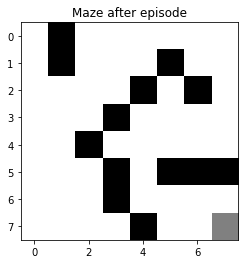

Epoch: 585/999 | Loss: 0.0003 | Episodes: 586 | Win count: 566 | Win rate: 1.000 | time: 1.54 hours
Loss:  1.8801823898684233e-05
Loss:  0.00016381901878048666
Loss:  0.0003331628431624267
Loss:  0.0002373835231992416
Loss:  8.847210119711235e-05
Loss:  9.451992809772491e-05
Loss:  2.0856919945799746e-05
Loss:  0.00019132065790472552
Loss:  2.9438917408697307e-05
Loss:  1.668418826739071e-05
Loss:  0.00032046106207417324
Loss:  2.334757118660491e-05
Loss:  0.00022004129641572945
Loss:  0.0001914188887894852
Loss:  0.00017079331155400723
Loss:  2.326740104763303e-05
Loss:  1.6348430108337197e-05


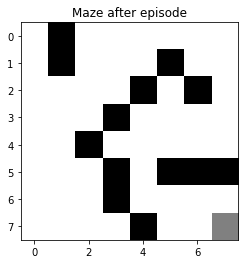

Epoch: 586/999 | Loss: 0.0000 | Episodes: 587 | Win count: 567 | Win rate: 1.000 | time: 1.54 hours
Loss:  0.00019137216804665513
Loss:  2.8007829314447008e-05
Loss:  2.8938623472640757e-05
Loss:  1.773305848473683e-05
Loss:  0.00017889902846945915
Loss:  2.9986061235831585e-05
Loss:  1.8520357116358355e-05
Loss:  1.691420811766875e-05
Loss:  7.344580353674246e-05
Loss:  1.4585215922124917e-05
Loss:  1.0410336471977644e-05
Loss:  7.609274234710028e-05
Loss:  0.00014683471817988902
Loss:  0.00013842237422068138
Loss:  9.77036943368148e-05
Loss:  1.923878789966693e-05
Loss:  0.00017891744664666476
Loss:  2.8771151846740395e-05
Loss:  0.00017251691679120995
Loss:  0.00017276901417062618
Loss:  0.00021233412189758383
Loss:  0.00016923152725212276


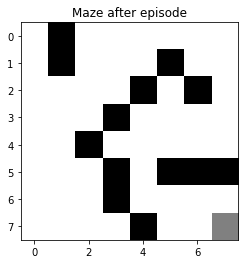

Epoch: 587/999 | Loss: 0.0002 | Episodes: 588 | Win count: 568 | Win rate: 1.000 | time: 1.54 hours
Loss:  5.335053901944775e-05
Loss:  0.00032603459840174764
Loss:  0.00012342308764345944
Loss:  0.00033994777186308056
Loss:  0.00011636476210696856
Loss:  0.00011585315587581135
Loss:  0.0003226993576390669
Loss:  0.00011716009612428024
Loss:  0.00022327684564515948
Loss:  6.066063360776752e-05
Loss:  0.00011775015082093887
Loss:  5.310480992193334e-05
Loss:  0.00014069546887185425
Loss:  4.715144314104691e-05
Loss:  0.00022970059217186645
Loss:  0.00019139206688123522
Loss:  0.0003532033588271588
Loss:  1.8271217413712293e-05
Loss:  0.0001595696339791175
Loss:  0.00017041210230672732
Loss:  0.0004210648185107857
Loss:  7.852604721847456e-05
Loss:  0.00035435304744169116
Loss:  0.000341110848239623
Loss:  0.00018486283806851134
Loss:  0.00012241055446793325
Loss:  2.759567269094987e-05
Loss:  0.00028214530902914703
Loss:  2.5866165742627345e-05
Loss:  0.0003535846044542268
Loss:  8.4216

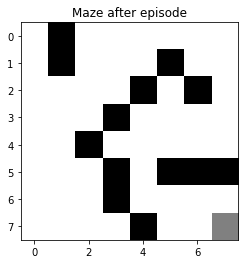

Epoch: 588/999 | Loss: 0.0000 | Episodes: 589 | Win count: 569 | Win rate: 1.000 | time: 1.54 hours
Loss:  0.00029584455842268653
Loss:  0.00037017668728367426
Loss:  7.268402623594739e-05
Loss:  0.00017150190615211613
Loss:  3.111584192083683e-05
Loss:  0.0002848809672286734
Loss:  0.00019018758393940516
Loss:  0.0001567068356962409
Loss:  0.00013782744281343184
Loss:  2.085685991914943e-05
Loss:  0.00014959796681068838
Loss:  9.059175863512792e-05
Loss:  0.00013640799807035364


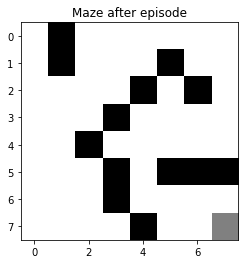

Epoch: 589/999 | Loss: 0.0001 | Episodes: 590 | Win count: 570 | Win rate: 1.000 | time: 1.54 hours
Loss:  1.7203086827066727e-05
Loss:  0.0003652060840977356
Loss:  8.93326123332372e-05
Loss:  0.00030818095547147095
Loss:  3.0174779567460064e-05
Loss:  0.00025341279251733795
Loss:  0.0004135987692279741


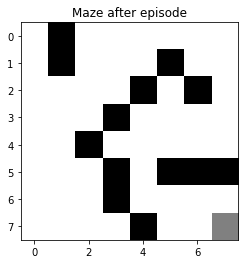

Epoch: 590/999 | Loss: 0.0004 | Episodes: 591 | Win count: 571 | Win rate: 1.000 | time: 1.55 hours
Loss:  0.0002498981266398914
Loss:  0.0003225063410354778
Loss:  0.0003672734455903992
Loss:  0.0002283831636304967
Loss:  9.57218071562238e-05
Loss:  0.000611348426900804
Loss:  0.0003098465531365946
Loss:  0.0002127882107743062
Loss:  7.446635208907537e-05
Loss:  9.68146305240225e-05
Loss:  0.00019474574946798384
Loss:  7.183148227341007e-05
Loss:  0.00012139227146690246
Loss:  0.0003716011706274003
Loss:  0.0001928936289914418
Loss:  0.000627796835033223
Loss:  0.00047222206194419414
Loss:  0.00036983052268624306
Loss:  6.271965685300529e-05
Loss:  4.377599179861136e-05
Loss:  0.00010065264723380096
Loss:  0.00024620251497253776


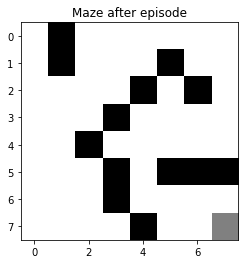

Epoch: 591/999 | Loss: 0.0002 | Episodes: 592 | Win count: 572 | Win rate: 1.000 | time: 1.55 hours
Loss:  0.0002492636049282737
Loss:  0.00016602341929683462
Loss:  0.00040232681203633547
Loss:  3.5759267120738514e-05
Loss:  0.0002260809051222168
Loss:  4.233019535604399e-05
Loss:  0.00018658622138900682
Loss:  0.00039280930650420487
Loss:  0.00023712350230198354


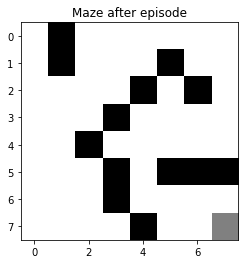

Epoch: 592/999 | Loss: 0.0002 | Episodes: 593 | Win count: 573 | Win rate: 1.000 | time: 1.55 hours
Loss:  0.00021354566706577316
Loss:  0.00018077727509080432
Loss:  0.00031757740362081677
Loss:  0.0002403446524112951
Loss:  0.0003519999172567623
Loss:  0.000188168378372211
Loss:  5.466402944875881e-05
Loss:  0.0001971705351024866
Loss:  0.00022815557895228267
Loss:  0.00014865035609545885
Loss:  3.919093433069065e-05
Loss:  5.998487540637143e-05
Loss:  0.00023143110229284503


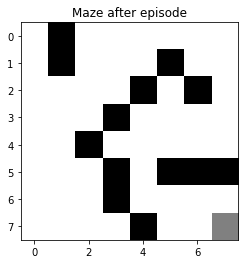

Epoch: 593/999 | Loss: 0.0002 | Episodes: 594 | Win count: 574 | Win rate: 1.000 | time: 1.55 hours
Loss:  0.00030599145975429565
Loss:  0.0003510012465994805
Loss:  0.0001835145740187727
Loss:  0.00016332781160599552
Loss:  0.000161407422638149
Loss:  1.6412727745773736e-05
Loss:  0.00040648868889547884
Loss:  8.326254283019807e-05
Loss:  0.0001378596934955567
Loss:  4.8756581236375496e-05
Loss:  0.0002731147833401337
Loss:  0.0001099460496334359
Loss:  0.00019440690812189132
Loss:  2.0377776309032924e-05
Loss:  7.034949794615386e-05
Loss:  0.00029959401581436396
Loss:  2.627435515023535e-05
Loss:  8.571071703045163e-05
Loss:  4.415108014654834e-05
Loss:  0.000374669223674573
Loss:  0.00010558132635196671
Loss:  9.165131996269338e-05


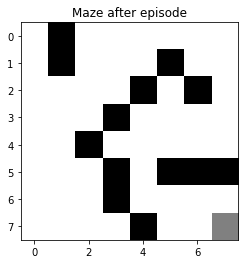

Epoch: 594/999 | Loss: 0.0001 | Episodes: 595 | Win count: 575 | Win rate: 1.000 | time: 1.55 hours
Loss:  2.21733826037962e-05
Loss:  7.168629963416606e-05
Loss:  0.0004281722358427942
Loss:  1.7984585610975046e-05
Loss:  0.00013048485561739653
Loss:  0.00023827062250347808
Loss:  0.0001133522528107278
Loss:  0.0002574909303802997
Loss:  4.61593153886497e-05
Loss:  3.173740151396487e-05
Loss:  0.00025030149845406413
Loss:  0.00019020507897948846
Loss:  3.316781476314645e-05
Loss:  0.00018021632786258124
Loss:  0.00024388927613472333
Loss:  9.861203034233768e-05
Loss:  0.0002936783494078554
Loss:  3.2432260013592895e-05
Loss:  0.0002909949289460201
Loss:  6.163213220133912e-05
Loss:  0.00048494811198906973
Loss:  0.000250057451921748
Loss:  5.929836697760038e-05
Loss:  6.717069481965154e-05
Loss:  0.0005450540338642895
Loss:  0.0003369005717104301
Loss:  0.00016005388533812948
Loss:  7.441182970069349e-05
Loss:  0.0003579352196538821


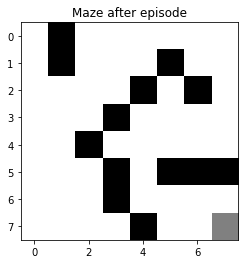

Epoch: 595/999 | Loss: 0.0004 | Episodes: 596 | Win count: 576 | Win rate: 1.000 | time: 1.55 hours
Loss:  0.00024197628226829693
Loss:  8.833189167489763e-05
Loss:  6.692460374324583e-05
Loss:  0.0005209741648286581
Loss:  0.00023444900216418318
Loss:  0.00015958613221300766
Loss:  0.00015879095008131117
Loss:  7.478046245523728e-05
Loss:  3.4336033422732726e-05
Loss:  0.00021833437131135724
Loss:  0.00026308384258300066
Loss:  0.0002531224163249135
Loss:  0.0001811654401535634
Loss:  0.0001552911417093128
Loss:  0.00010983954598486889
Loss:  4.6366574679268524e-05
Loss:  0.00019542032168828882
Loss:  3.364844451425597e-05
Loss:  6.086322082410334e-05
Loss:  0.00010649079558788799
Loss:  0.0002691545805646456
Loss:  0.00010897558786382433
Loss:  2.2239839381654747e-05
Loss:  0.00010465300329087768


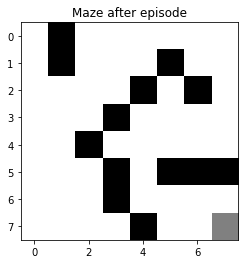

Epoch: 596/999 | Loss: 0.0001 | Episodes: 597 | Win count: 577 | Win rate: 1.000 | time: 1.55 hours
Loss:  0.0001603445284672489
Loss:  9.312256224802695e-05
Loss:  0.0004435997107066214
Loss:  0.0003400739224161953
Loss:  4.597378028847743e-05
Loss:  4.9784797738539055e-05
Loss:  5.659544740410638e-05
Loss:  8.860346497385763e-06
Loss:  0.0003545613508322276
Loss:  0.00026528723537921906
Loss:  0.00012391198106342927
Loss:  0.00016459762264275923
Loss:  0.00011771572417274001
Loss:  0.00023505465651396662
Loss:  0.00010279080379405059
Loss:  0.00013303339437698014
Loss:  0.0001129266711359378
Loss:  0.00023287789736059494
Loss:  8.825207169138594e-05
Loss:  7.826882938388735e-05
Loss:  8.559976959077176e-05


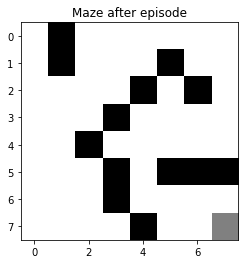

Epoch: 597/999 | Loss: 0.0001 | Episodes: 598 | Win count: 578 | Win rate: 1.000 | time: 1.55 hours
Loss:  6.891291741339955e-05
Loss:  0.0002863866975530982
Loss:  0.00026916743809124455
Loss:  0.00020764422515640035


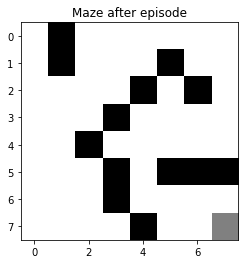

Epoch: 598/999 | Loss: 0.0002 | Episodes: 599 | Win count: 579 | Win rate: 1.000 | time: 1.55 hours
Loss:  6.714748997183051e-05
Loss:  2.5079270926653408e-05
Loss:  7.638735587534029e-05
Loss:  0.00010580335310805822
Loss:  0.00012154011710663326
Loss:  4.24620393459918e-05
Loss:  0.00018395690858596936
Loss:  1.5013966276455903e-05
Loss:  3.2834802823344944e-05
Loss:  0.00010764647959149443
Loss:  2.8861412829428446e-05
Loss:  0.00027055005921283737
Loss:  0.00016324252646882087
Loss:  1.9175803572579753e-05
Loss:  4.219665697746677e-05
Loss:  2.4102483848764678e-05
Loss:  0.00035600549017544836
Loss:  5.0493728849687614e-05
Loss:  0.00010943794768536463


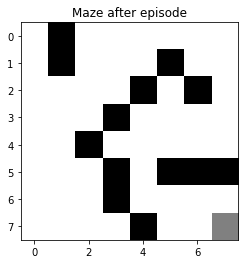

Epoch: 599/999 | Loss: 0.0001 | Episodes: 600 | Win count: 580 | Win rate: 1.000 | time: 1.55 hours
Loss:  0.00011910001194337383
Loss:  6.02028303546831e-05
Loss:  5.456868939290871e-05
Loss:  8.030015942495083e-05
Loss:  7.715460378676653e-05
Loss:  0.000287991133518517
Loss:  0.00017667917018115986
Loss:  2.547656276874477e-05
Loss:  1.2151610462751705e-05
Loss:  2.4232056148321135e-05
Loss:  0.00014222896152205067
Loss:  0.0001185173932753969
Loss:  5.258263809082564e-05
Loss:  4.1340697862324305e-05
Loss:  9.825432607613038e-05
Loss:  0.0002651151098689297
Loss:  0.00020030133600812405
Loss:  8.099019214569125e-05
Loss:  0.00010535647516007884
Loss:  0.00013514067177311517
Loss:  0.0001421849083271809
Loss:  4.6145055421220604e-05
Loss:  0.00023055734345689416
Loss:  0.0003290682871011086
Loss:  0.00010889584518736228
Loss:  0.00030247572431107983
Loss:  0.0005091695784358308
Loss:  0.00015815139158803504
Loss:  0.0003241050580982119
Loss:  0.0002366637418163009
Loss:  0.000176143

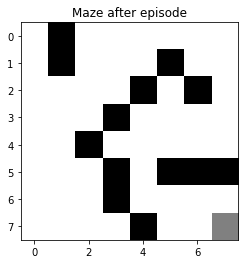

Epoch: 600/999 | Loss: 0.0002 | Episodes: 601 | Win count: 581 | Win rate: 1.000 | time: 1.55 hours
Loss:  8.406901179114357e-05
Loss:  0.00034846190828830004
Loss:  0.00025248315068893135
Loss:  0.0001610496583452914
Loss:  0.00035110367025481537
Loss:  0.0003630662467912771
Loss:  0.0002549679957155604
Loss:  0.00012981727559235878
Loss:  0.00028847557405242696


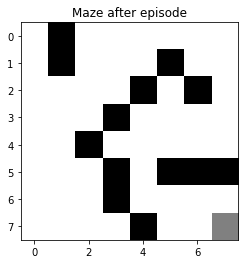

Epoch: 601/999 | Loss: 0.0003 | Episodes: 602 | Win count: 582 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.00030398521630559117
Loss:  0.00033019736292771995
Loss:  0.00030323326063808054
Loss:  0.00036521643778542057
Loss:  3.511330942274071e-05
Loss:  0.000417035222199047
Loss:  6.378681973728817e-05
Loss:  0.00023390536807710305
Loss:  0.0002092502145387698
Loss:  2.2159643776831217e-05
Loss:  0.00020740106629091315
Loss:  0.0002367816232435871
Loss:  4.07093066314701e-05
Loss:  3.698097134474665e-05
Loss:  0.00020374113591969945
Loss:  6.172820121719269e-05
Loss:  0.000168462262081448
Loss:  0.00028431379178073257
Loss:  0.00014631493650085758
Loss:  3.143096182611771e-05
Loss:  0.00011877513134095352
Loss:  0.00014524169455398805
Loss:  0.0003139162508887239
Loss:  8.766536848270334e-05
Loss:  0.00022368794452631846
Loss:  7.379757698799949e-05
Loss:  0.0001168746457551606
Loss:  0.00010938530977000482
Loss:  0.00017641969316173345


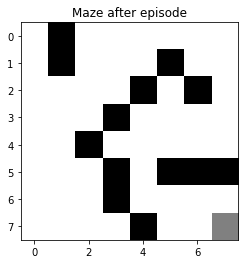

Epoch: 602/999 | Loss: 0.0002 | Episodes: 603 | Win count: 583 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.00034235821294714697
Loss:  0.0002083868530462496
Loss:  9.191781282424927e-05
Loss:  7.378122973022982e-05
Loss:  4.8033829443738796e-05
Loss:  0.00020888361905235797
Loss:  0.00018766630182653898
Loss:  0.000523181224707514
Loss:  0.0003521115577314049
Loss:  8.479721145704389e-05
Loss:  0.0004064689273945987
Loss:  0.0006643700762651861
Loss:  0.00032409006962552667
Loss:  6.252069943002425e-05
Loss:  5.434514332591789e-05
Loss:  0.00022854540293337777
Loss:  0.00038536817373824306
Loss:  0.0002317588368896395
Loss:  0.000589261187997181
Loss:  0.00032595729862805456
Loss:  0.0002862715919036418
Loss:  0.0002314728480996564
Loss:  0.00044376307050697505
Loss:  0.00025089571136049926
Loss:  0.00022487621754407883
Loss:  7.849170924600912e-05
Loss:  0.00020152761862846091
Loss:  0.0005201610765652731
Loss:  0.0001273878588108346
Loss:  0.0003069699232582934
Loss:  0.00012944352

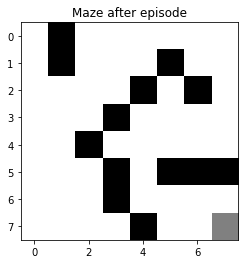

Epoch: 603/999 | Loss: 0.0002 | Episodes: 604 | Win count: 584 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.00026236637495458126
Loss:  0.00040769187035039067
Loss:  2.9107739464961924e-05
Loss:  6.541310540342238e-05
Loss:  0.00026413958039483987
Loss:  6.729811502736993e-05
Loss:  0.0002186768251704052
Loss:  6.97579926054459e-05
Loss:  0.0002816125434037531
Loss:  0.0001949798061104957
Loss:  0.00023501770192524418
Loss:  0.00030452958162641153
Loss:  0.00011581892613321543


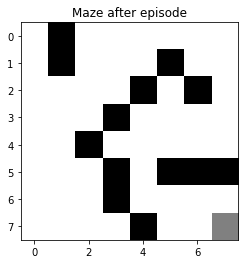

Epoch: 604/999 | Loss: 0.0001 | Episodes: 605 | Win count: 585 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.00020475940982578322
Loss:  0.0003281056269770488
Loss:  0.0002402954032731941
Loss:  0.0002931122071458958
Loss:  7.472989818779752e-05
Loss:  0.000654352072160691
Loss:  0.0003691254969453439
Loss:  0.0002303925939486362
Loss:  0.0005710981204174459
Loss:  0.00012743455590680242
Loss:  0.00041874135786201805
Loss:  0.0003794593212660402
Loss:  0.0002191740568378009
Loss:  8.496426380588673e-05
Loss:  0.0005588293424807489
Loss:  0.000301646810839884
Loss:  0.0002694141585379839
Loss:  0.00021942288367426954
Loss:  0.00013706704339710996
Loss:  0.0004128823147766525
Loss:  0.00027089533250546083
Loss:  0.00022016511502442881
Loss:  0.00041042266821023077
Loss:  0.0005457871593534946
Loss:  0.00040450158121529967
Loss:  0.00033254895970458165
Loss:  0.00011000179802067578


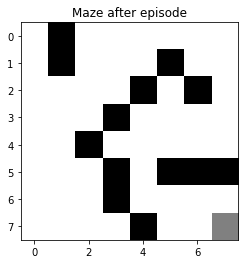

Epoch: 605/999 | Loss: 0.0001 | Episodes: 606 | Win count: 586 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.0004263843293301761
Loss:  0.0005427125870482996
Loss:  0.00011430726590333506
Loss:  0.00018881863070419058
Loss:  5.504098953679204e-05
Loss:  0.0002413440624877694
Loss:  0.0003626293364504818
Loss:  0.00027329858858138323
Loss:  0.00032834104786161333
Loss:  0.0003146265371469781
Loss:  0.0003447404596954584
Loss:  0.0002730389533098787
Loss:  0.00021098995057400316
Loss:  0.00033981038723140955
Loss:  0.00047635445662308484
Loss:  0.0001969425065908581
Loss:  0.0003560404875315726
Loss:  0.00023093470372259617
Loss:  0.0002669276382221142
Loss:  0.00020323785065556876
Loss:  0.00021409923101600725


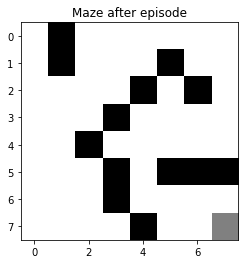

Epoch: 606/999 | Loss: 0.0002 | Episodes: 607 | Win count: 587 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.00010638033381837886
Loss:  0.00015434327360708266
Loss:  0.0001198406534967944
Loss:  0.00018408340110909194
Loss:  0.0002290642069056048
Loss:  0.00015805204748176038
Loss:  0.0003820150304818526
Loss:  0.0006585408409591764
Loss:  0.00041603365389164537
Loss:  0.00023551937192678452
Loss:  0.00016422545741079375
Loss:  7.172682308009826e-05
Loss:  0.00027262349613010883
Loss:  0.0004990630986867473
Loss:  0.0003739651292562485
Loss:  0.00024108959769364446
Loss:  0.00015878654085099697
Loss:  0.00047727111086715013
Loss:  0.0001298980350838974
Loss:  0.0003020610529347323
Loss:  0.00032826918413775275
Loss:  0.00018328064470551908
Loss:  0.0002443494158796966
Loss:  8.478121708321851e-05
Loss:  0.00018123964400729164
Loss:  0.0001353709158138372
Loss:  0.00013744710122409742
Loss:  0.00029970194736961275


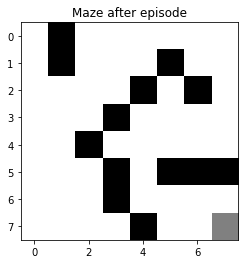

Epoch: 607/999 | Loss: 0.0003 | Episodes: 608 | Win count: 588 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.0001495310862082988
Loss:  9.745891293277964e-05
Loss:  0.00024319941439898685
Loss:  0.00013461488561006263
Loss:  0.00038614842924289405
Loss:  0.00022162228560773656
Loss:  0.00029156781238270923
Loss:  0.00019194889318896458
Loss:  0.00019195764616597444
Loss:  0.00031236429640557617
Loss:  0.0001777859652065672
Loss:  0.0006660996587015688
Loss:  0.00025852883845800534
Loss:  6.256573942664545e-05
Loss:  0.00024007992760743946
Loss:  0.0003329997562104836
Loss:  0.0002315546225872822
Loss:  0.0002304570225533098
Loss:  0.00020014851179439574
Loss:  0.0003633995511336252
Loss:  0.000261896537267603


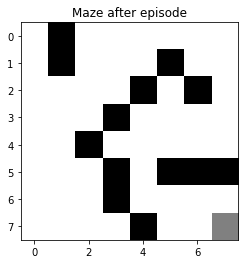

Epoch: 608/999 | Loss: 0.0003 | Episodes: 609 | Win count: 589 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.0002855409256881103
Loss:  0.0003172811266267672
Loss:  0.0001403639471391216
Loss:  0.0001470354327466339
Loss:  2.6753736165119335e-05
Loss:  0.00011945790174650028


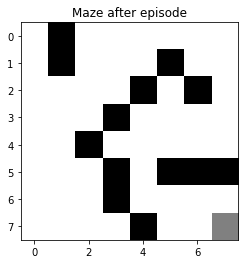

Epoch: 609/999 | Loss: 0.0001 | Episodes: 610 | Win count: 590 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.00018099816952599213


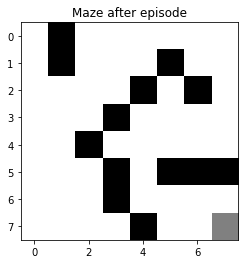

Epoch: 610/999 | Loss: 0.0002 | Episodes: 611 | Win count: 591 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.00034670819877646863
Loss:  0.0004521207883954048
Loss:  0.0003440223808865994
Loss:  0.00035171320632798597
Loss:  0.00016429193055955693
Loss:  6.449853572121356e-05
Loss:  0.00021246378310024738
Loss:  0.000576928083319217
Loss:  0.00012526471618912183
Loss:  0.0003130325785605237
Loss:  0.000490746577270329
Loss:  7.867775275371969e-05
Loss:  0.00011443236144259572
Loss:  0.0003165504022035748
Loss:  0.0003116228799626697


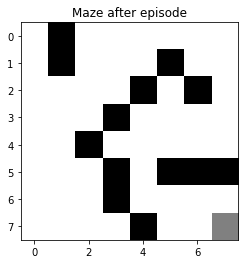

Epoch: 611/999 | Loss: 0.0003 | Episodes: 612 | Win count: 592 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.0002167559796362184
Loss:  0.0005424034461611882


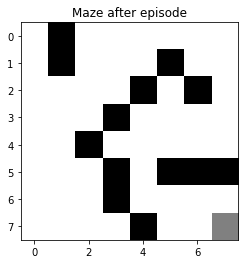

Epoch: 612/999 | Loss: 0.0005 | Episodes: 613 | Win count: 593 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.0002350277645746246
Loss:  0.00011203484609723091


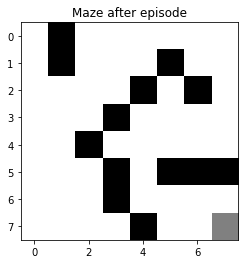

Epoch: 613/999 | Loss: 0.0001 | Episodes: 614 | Win count: 594 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.0001737701786623802
Loss:  0.0005332658183760941
Loss:  0.0003775723889702931
Loss:  0.00025572667800588533
Loss:  0.00022383870964404196
Loss:  0.0003503204934531823
Loss:  0.000434968744229991


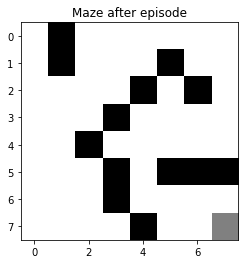

Epoch: 614/999 | Loss: 0.0004 | Episodes: 615 | Win count: 595 | Win rate: 1.000 | time: 1.56 hours
Loss:  0.00018026329053100199
Loss:  0.0006118383607827127
Loss:  0.0003333202621433884
Loss:  0.0003399393317522481
Loss:  0.00047148988232947886
Loss:  0.00038022801163606346
Loss:  0.00025659892708063126
Loss:  0.00014107722381595522
Loss:  0.00021382324484875426
Loss:  0.0003119249740848318
Loss:  9.815104749577586e-05
Loss:  0.0007138789660530165
Loss:  0.00032852982985787094
Loss:  0.0003280430246377364
Loss:  5.108822006150149e-05
Loss:  0.0003099824534729123
Loss:  0.0007070431893225759
Loss:  0.00024374319036724046
Loss:  0.00018677973275771365
Loss:  0.00025920839834725484
Loss:  0.00016663655696902424
Loss:  0.00027850611513713375
Loss:  0.0002927227924374165
Loss:  0.0002871306951419683
Loss:  5.9284609960741363e-05


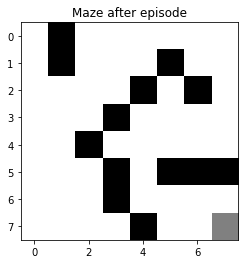

Epoch: 615/999 | Loss: 0.0001 | Episodes: 616 | Win count: 596 | Win rate: 1.000 | time: 1.57 hours
Loss:  0.0001996874198084697
Loss:  0.000283275090623647
Loss:  0.0004633429634850472
Loss:  0.0001671970312600024
Loss:  0.0003806125605478883
Loss:  0.00012347263691481203
Loss:  0.00018630727572599426
Loss:  0.0004228041652822867


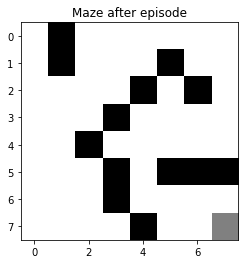

Epoch: 616/999 | Loss: 0.0004 | Episodes: 617 | Win count: 597 | Win rate: 1.000 | time: 1.57 hours
Loss:  0.0003968909295508638
Loss:  0.00028774367820005864
Loss:  0.00024275938267237507
Loss:  0.0001761148978403071
Loss:  0.00036701148201245815
Loss:  0.00029569939943030477
Loss:  3.147044117213227e-05
Loss:  0.00039241890772245824
Loss:  0.00011540573905222118
Loss:  0.00024613069399492815
Loss:  0.00019680534023791552
Loss:  0.0003101658367086202
Loss:  0.00032715558336349204
Loss:  0.00016197518925764598
Loss:  0.00037057174995425157
Loss:  0.00012811018314096145
Loss:  0.00031255558860721067
Loss:  0.00027453706934466027
Loss:  0.00025504318182356656
Loss:  0.00012687365961028263
Loss:  0.00013174066771171056
Loss:  0.00013475238665705547
Loss:  7.925300269562285e-05
Loss:  0.00016002109259716235
Loss:  0.0001262995047000004
Loss:  0.00011236179125262424
Loss:  0.00031630491139367223
Loss:  0.0004955594486091286
Loss:  0.00035342801129445434
Loss:  0.00019539174900273792
Loss:  

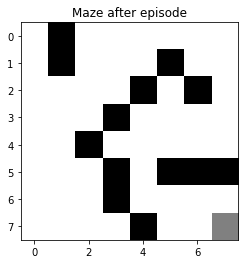

Epoch: 617/999 | Loss: 0.0002 | Episodes: 618 | Win count: 598 | Win rate: 1.000 | time: 1.57 hours
Loss:  0.00023424901883117855
Loss:  0.00020634416432585567
Loss:  0.0004947733104927465
Loss:  0.0003132733836537227
Loss:  0.0002873610828828532
Loss:  0.00011235119745833799
Loss:  0.00015261614316841587
Loss:  0.0002009753297897987
Loss:  0.00010563619252934586


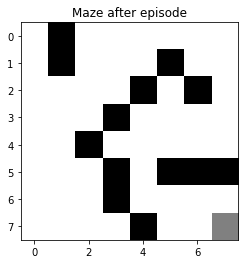

Epoch: 618/999 | Loss: 0.0001 | Episodes: 619 | Win count: 599 | Win rate: 1.000 | time: 1.57 hours
Loss:  0.0002475723158568144
Loss:  0.00011221740351174958
Loss:  0.0001109973709390033
Loss:  0.0001668592230998911
Loss:  0.0004313520767027512
Loss:  0.00015950639499351382
Loss:  6.613690129597671e-05
Loss:  0.00014524117432301864
Loss:  8.946633170126006e-05
Loss:  0.00013640200086229015
Loss:  6.67175481794402e-05
Loss:  0.0002073914429274737
Loss:  0.00014890117017785087


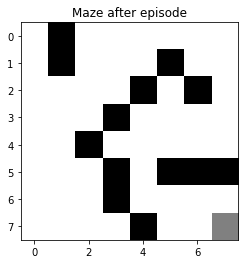

Epoch: 619/999 | Loss: 0.0001 | Episodes: 620 | Win count: 600 | Win rate: 1.000 | time: 1.57 hours
Loss:  0.00012620212510228157
Loss:  4.8424573833472095e-05
Loss:  0.0001539664517622441
Loss:  0.00021183745411690325
Loss:  0.00014808432388235815
Loss:  0.0003112489794148132
Loss:  0.00011186708798049949
Loss:  4.1215513192582875e-05
Loss:  3.920421295333654e-05
Loss:  0.0001731283809931483
Loss:  0.00024916750044212677
Loss:  5.202759894018527e-05
Loss:  0.00018346604156249668
Loss:  0.00019115153554594144
Loss:  6.416508040274493e-05
Loss:  0.00013056321040494367
Loss:  0.0002957694450742565
Loss:  2.904773282352835e-05
Loss:  0.00024008043692447245
Loss:  0.0003020801814273


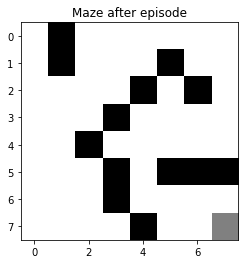

Epoch: 620/999 | Loss: 0.0003 | Episodes: 621 | Win count: 601 | Win rate: 1.000 | time: 1.57 hours
Loss:  0.00022025046200724319
Loss:  0.0004260081914253533
Loss:  0.00012507693099905737
Loss:  4.6459836084977724e-05
Loss:  0.0001179367936856579
Loss:  8.639217776362784e-05
Loss:  7.292669761227444e-05
Loss:  0.0003213393883925164
Loss:  0.00019692538626259193
Loss:  0.0001614398424862884
Loss:  0.0002540671848692
Loss:  0.000310423580231145
Loss:  5.488692477229051e-05


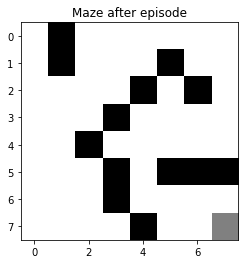

Epoch: 621/999 | Loss: 0.0001 | Episodes: 622 | Win count: 602 | Win rate: 1.000 | time: 1.57 hours
Loss:  0.00019860687098116614
Loss:  0.00013038129691267386
Loss:  0.0003255394913139753
Loss:  0.00025167503008560743
Loss:  0.0001505928703409154
Loss:  9.035753464559093e-05
Loss:  6.041547931090463e-05
Loss:  0.00022869795793667436
Loss:  0.00015643242477381136
Loss:  9.650657011661679e-05
Loss:  0.00011796705075539649
Loss:  0.0002272034835186787
Loss:  0.0001767337653291179
Loss:  0.0003938967565773055
Loss:  0.00020147622490185313
Loss:  0.00029068285221001133
Loss:  0.00023548842000309378
Loss:  0.000255937862675637
Loss:  8.055820944719017e-05
Loss:  0.00043290984467603266
Loss:  2.568961826909799e-05
Loss:  0.0003197538753738627
Loss:  0.00048377028724644333
Loss:  0.00039712472062092274
Loss:  0.0003192886069882661
Loss:  0.0005673193591064773
Loss:  0.0005519958649529144
Loss:  0.0003851721339742653
Loss:  0.00032702959288144484
Loss:  0.0003221645783924032
Loss:  0.000113120

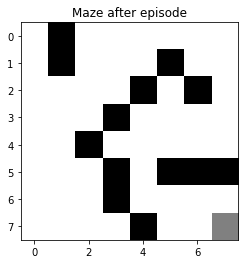

Epoch: 622/999 | Loss: 0.0002 | Episodes: 623 | Win count: 603 | Win rate: 1.000 | time: 1.57 hours
Loss:  0.00045214938290882856
Loss:  0.00028122722869738936
Loss:  0.00037259513555909507
Loss:  0.0002853387159120757
Loss:  0.0002590669464552775
Loss:  0.00014206734340405092
Loss:  0.0003939134403481148
Loss:  0.00012852779036620632
Loss:  6.633324665017426e-05
Loss:  0.0001499222980783088
Loss:  0.0006089453963795677
Loss:  0.0005487314338097349
Loss:  9.229177521774545e-05
Loss:  0.00036638861638493836
Loss:  0.000496145265060477
Loss:  0.00043705562711693347
Loss:  0.00041562980914022774
Loss:  0.0005900901596760377
Loss:  0.0005330225976649672
Loss:  0.0005700105102732778
Loss:  0.0004864418733632192
Loss:  0.0008025192655622959
Loss:  0.00019805273404926993
Loss:  0.0001264170277863741
Loss:  0.00021552478574449196
Loss:  0.0002890080868382938
Loss:  0.0004469603445613757
Loss:  0.0006638062186539173
Loss:  0.000376709271222353
Loss:  0.00027257616602582857
Loss:  0.000441576838

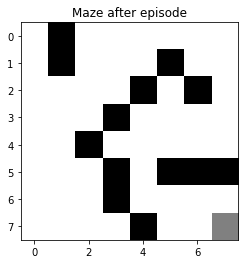

Epoch: 623/999 | Loss: 0.0003 | Episodes: 624 | Win count: 604 | Win rate: 1.000 | time: 1.57 hours
Loss:  0.0003515544958645478
Loss:  0.00019968026026617736
Loss:  0.0005031001346651465
Loss:  0.0004296236584195867
Loss:  0.00010734933857747819
Loss:  0.0003033670800505206
Loss:  0.0004055750905536115
Loss:  0.000273394092801027
Loss:  0.000462225973024033
Loss:  0.00028729785117320716
Loss:  0.0004890276759397238
Loss:  8.273367711808532e-05
Loss:  0.00023198699636850506
Loss:  0.0006537905865116045
Loss:  0.00048259494360536337
Loss:  0.00031783521262696013
Loss:  0.0004007471725344658


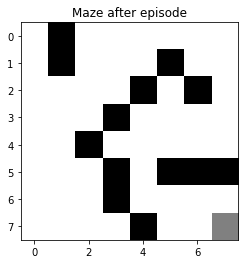

Epoch: 624/999 | Loss: 0.0004 | Episodes: 625 | Win count: 605 | Win rate: 1.000 | time: 1.57 hours
Loss:  0.00040592788718640804
Loss:  0.000413100489822682
Loss:  0.0006233813764993101
Loss:  0.0004312553719501011
Loss:  0.00014806022227276117
Loss:  0.00038802981725893915
Loss:  0.00013925485836807638
Loss:  0.00014245645797927864
Loss:  0.00010181841935263947
Loss:  0.00016625694115646183
Loss:  0.0005927127203904092
Loss:  0.00031620785739505664
Loss:  0.00016179046360775828
Loss:  0.0002730481210164726
Loss:  0.0002914414944825694
Loss:  0.0003415648388909176
Loss:  0.0001435477206541691
Loss:  0.0003823400256806053
Loss:  0.0005081777344457805
Loss:  0.00046468753134831786
Loss:  0.0004926470865029842
Loss:  0.00044139880628790706
Loss:  0.0006157829484436661
Loss:  0.00020553075592033565
Loss:  0.0006290631135925651
Loss:  0.0003414567545405589
Loss:  0.0004710878274636343
Loss:  0.0005066243174951524
Loss:  0.0003269319568062201
Loss:  0.00041701267764437944
Loss:  0.000161281

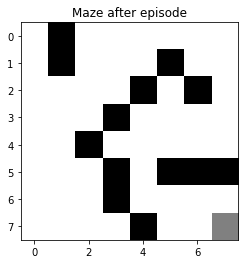

Epoch: 625/999 | Loss: 0.0004 | Episodes: 626 | Win count: 606 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.0002917685778811574
Loss:  0.0002802121889544651
Loss:  0.0002758795308182016
Loss:  7.704181552981026e-05
Loss:  0.0003373827348696068
Loss:  0.00046183330414351076
Loss:  0.00042282049253117293
Loss:  0.0002919040125561878
Loss:  0.0003622594740591012
Loss:  0.0005506822926690802


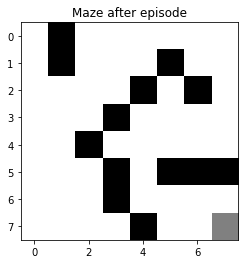

Epoch: 626/999 | Loss: 0.0006 | Episodes: 627 | Win count: 607 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.0002236757063656114
Loss:  0.0002953190851258114
Loss:  0.0004481577780097723
Loss:  0.0003029472536582034
Loss:  0.00015490405712625943
Loss:  0.00027815334033221006
Loss:  0.00035252320230938494
Loss:  0.0001582459735800512
Loss:  0.000725376041373238


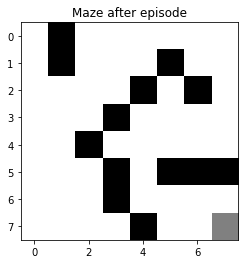

Epoch: 627/999 | Loss: 0.0007 | Episodes: 628 | Win count: 608 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.0002612572206999175
Loss:  0.00012464076280593872
Loss:  0.00034420230076648295
Loss:  0.0004744909383589402
Loss:  0.00013670338375959545
Loss:  0.00031162716913968325
Loss:  0.0002005817659664899
Loss:  0.0001250669447472319
Loss:  0.00043241757521172985
Loss:  0.0002727146893448662
Loss:  0.0003952535189455375
Loss:  0.0005661526811309159
Loss:  0.0004513685853453353
Loss:  0.00026143118157051504
Loss:  0.00027279098867438734
Loss:  0.00024373467022087425
Loss:  7.12331930117216e-05
Loss:  0.00046034768456593156
Loss:  0.00013127035708748735
Loss:  0.00010525835023145191
Loss:  0.00032462265517096967


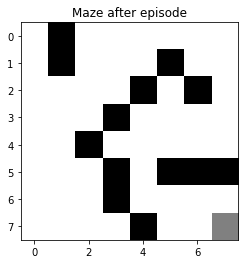

Epoch: 628/999 | Loss: 0.0003 | Episodes: 629 | Win count: 609 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.0003594250956666656
Loss:  0.00034514148137532175
Loss:  0.00042786305129993707
Loss:  0.0002800238216877915
Loss:  0.000148687518958468
Loss:  0.0002979159835376777
Loss:  9.417118417331949e-05
Loss:  0.00013371331260714214
Loss:  0.00024662085343152285
Loss:  0.0006851271609775722
Loss:  0.00033603595875320025
Loss:  0.0003508803201839328
Loss:  0.0005663202609866858
Loss:  0.00035439126077108085
Loss:  0.0002977253097924404


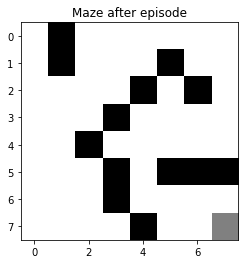

Epoch: 629/999 | Loss: 0.0003 | Episodes: 630 | Win count: 610 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.00032009463757276535
Loss:  0.00024427150492556393
Loss:  0.0004053993179695681
Loss:  0.0004809096280951053
Loss:  0.00033001043630065396


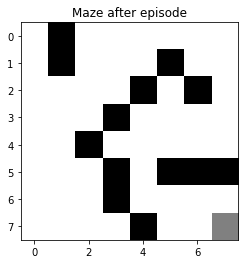

Epoch: 630/999 | Loss: 0.0003 | Episodes: 631 | Win count: 611 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.00017857020429801196
Loss:  9.9861736089224e-05
Loss:  0.00028133638261351734
Loss:  0.00014379475760506466
Loss:  0.00023774479996063747
Loss:  0.00021150923566892743
Loss:  0.0006830638740211725
Loss:  0.00025082281354116276
Loss:  0.00022796452685724944
Loss:  0.0006360389525070786
Loss:  0.00034228777803946286
Loss:  0.00010355912672821432
Loss:  0.0001590406372997677
Loss:  0.00035283951729070395
Loss:  8.725529914954677e-05
Loss:  8.065508518484421e-05
Loss:  0.00030596878787036985
Loss:  0.00031021289760246873
Loss:  0.00034973212677869014
Loss:  0.00019091115609626286
Loss:  0.000278293970040977
Loss:  0.00024015870258153882
Loss:  0.0004896204773103818
Loss:  0.0003734005586011335
Loss:  0.0002231796970590949
Loss:  0.0002495120934327133


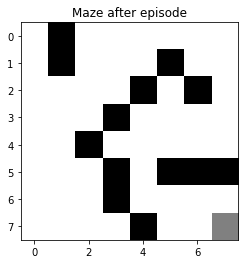

Epoch: 631/999 | Loss: 0.0002 | Episodes: 632 | Win count: 612 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.00038610950286965817
Loss:  0.00021709802240366116
Loss:  0.0002487796955392696
Loss:  0.00025260938855353743
Loss:  0.00037121036439202726
Loss:  0.0005161779990885407
Loss:  0.00031432226751348935
Loss:  0.00021426390230772085
Loss:  0.0006933736149221659
Loss:  0.00019574952602852136
Loss:  0.0003566849045455456
Loss:  0.00028455910069169477
Loss:  4.211769191897474e-05
Loss:  0.0005184310575714335
Loss:  0.00030711455110576935
Loss:  0.00045601819874718785
Loss:  0.0002828590295393951
Loss:  0.0001515773001301568
Loss:  0.0002985220526170451
Loss:  0.00038773335108999163
Loss:  0.0005504043074324727
Loss:  0.0002447396364004817
Loss:  0.00028618475334951654
Loss:  0.00025706481392262504
Loss:  0.0004453367437236011
Loss:  0.0002479687063896563
Loss:  0.00030255354795372114
Loss:  4.077736593899317e-05
Loss:  6.617445615120232e-05
Loss:  0.000269159885647241
Loss:  7.04502963

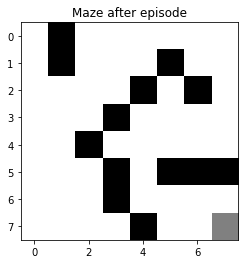

Epoch: 632/999 | Loss: 0.0001 | Episodes: 633 | Win count: 613 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.0003437246232351754
Loss:  0.00033577074646018445
Loss:  0.000801656482508406
Loss:  0.00032796298910398036
Loss:  0.00028544436645461246
Loss:  0.00037800255813635886
Loss:  0.0006886448827572167
Loss:  0.00023338849132414907
Loss:  0.00010113576718140393
Loss:  0.00039793785254005343
Loss:  0.00026359523690189235
Loss:  0.0005148602795088664
Loss:  0.00022764402820030227
Loss:  0.00025295787781942636
Loss:  3.911168278136756e-05
Loss:  0.00025592654492356814
Loss:  0.00020029774896102026
Loss:  0.00019591306045185775
Loss:  0.00015956721108523197
Loss:  0.0004289021890144795
Loss:  0.0005086420278530568
Loss:  0.0001878787952591665
Loss:  0.00047426141100004315
Loss:  0.00025676046061562374
Loss:  0.0007063764169288334
Loss:  0.0003896113848895766


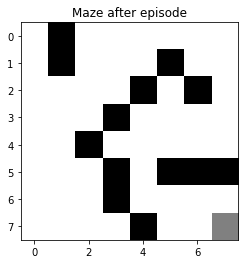

Epoch: 633/999 | Loss: 0.0004 | Episodes: 634 | Win count: 614 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.0003932728723157197
Loss:  0.00011788500341936015
Loss:  0.00019955180687247775


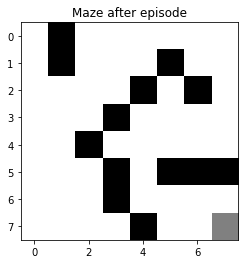

Epoch: 634/999 | Loss: 0.0002 | Episodes: 635 | Win count: 615 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.00026392001018393785
Loss:  0.0002769768761936575
Loss:  0.00035194974043406546
Loss:  0.00039131987432483584
Loss:  0.00012532078835647553
Loss:  0.0003007765262736939
Loss:  0.00014803103840677068
Loss:  0.00010102529631694779
Loss:  0.00021857849060324952
Loss:  0.00021026279864599928
Loss:  0.00027312972815707326
Loss:  0.0002529098783270456
Loss:  0.0002587734088592697
Loss:  0.0003752097691176459
Loss:  0.00014925896175554954
Loss:  0.00028123195079388097
Loss:  7.654946966795251e-05
Loss:  8.167743726517074e-05
Loss:  0.0003103890048805624
Loss:  0.00015548128430964425
Loss:  0.0002291044220328331


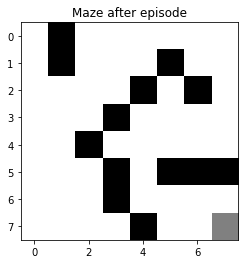

Epoch: 635/999 | Loss: 0.0002 | Episodes: 636 | Win count: 616 | Win rate: 1.000 | time: 1.58 hours
Loss:  7.580702003906481e-05
Loss:  0.00040940530016086996
Loss:  0.00024559645680710673
Loss:  0.00021988888329360634
Loss:  0.00029591556813102216
Loss:  0.0003590637497836724
Loss:  0.00010283141727995826
Loss:  0.0002015832214965485
Loss:  0.00026910403539659455
Loss:  0.0002473635904607363
Loss:  0.00026744163551484235
Loss:  3.975687832280528e-05
Loss:  4.3976553570246324e-05
Loss:  0.0005075903027318418
Loss:  0.00016620370479358826
Loss:  0.0002522990616853349
Loss:  0.00022162736058817245
Loss:  0.00020936398868798278
Loss:  0.0005045876023359597


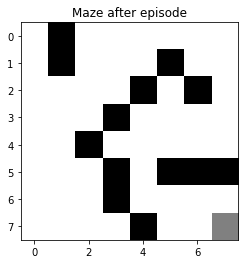

Epoch: 636/999 | Loss: 0.0005 | Episodes: 637 | Win count: 617 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.00026472161698620766
Loss:  0.0006671641604043543
Loss:  0.0002599320578156039
Loss:  0.000399176606151741
Loss:  0.00035088942968286574
Loss:  0.0003136281593469903
Loss:  0.0005571498186327517
Loss:  0.0003093030463787727
Loss:  0.0005800964427180588
Loss:  0.00048605212941765785
Loss:  0.000225545958528528
Loss:  0.00038870127173140645
Loss:  0.0005395663320086896
Loss:  0.0002299138213857077
Loss:  0.00025449647364439443
Loss:  0.00015531334793195128
Loss:  0.00031195877818390727


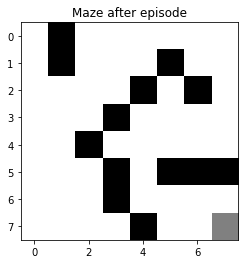

Epoch: 637/999 | Loss: 0.0003 | Episodes: 638 | Win count: 618 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.0005094060179544613
Loss:  0.00030292994779301807
Loss:  0.00014480237587122247
Loss:  0.00029611167701659724
Loss:  0.0004230520862620324
Loss:  0.0004803925257874653
Loss:  0.00046239158837124705
Loss:  0.00011342061043251306


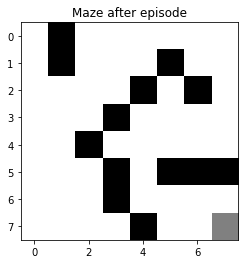

Epoch: 638/999 | Loss: 0.0001 | Episodes: 639 | Win count: 619 | Win rate: 1.000 | time: 1.58 hours
Loss:  0.00047459552297368646
Loss:  0.00011851655654027127


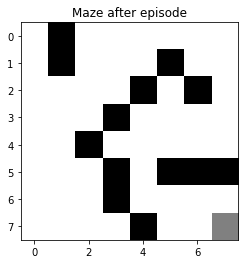

Epoch: 639/999 | Loss: 0.0001 | Episodes: 640 | Win count: 620 | Win rate: 1.000 | time: 1.59 hours
Loss:  0.0005193365723243915
Loss:  0.0002472439591656439
Loss:  0.0005963583535049111
Loss:  0.0004443889920366928
Loss:  0.000595649384194985
Loss:  0.00042418864904902875
Loss:  8.509280814905651e-05
Loss:  0.00033544781763339415
Loss:  0.00023004548711469397
Loss:  0.00012333756967564113
Loss:  0.0004028388939332217
Loss:  0.00023440178847522475
Loss:  0.00013062542711850256
Loss:  0.0003833803202724084
Loss:  0.0002693539281608537
Loss:  8.607662675785832e-05
Loss:  0.0003707586365635507
Loss:  0.00018402794739813544
Loss:  6.0675798522424884e-05
Loss:  0.0003291112370789051


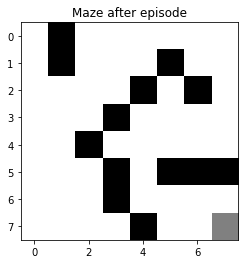

Epoch: 640/999 | Loss: 0.0003 | Episodes: 641 | Win count: 621 | Win rate: 1.000 | time: 1.59 hours
Loss:  0.00034782561124302447
Loss:  0.0004201636402285658
Loss:  0.00034161092480644584
Loss:  0.0006289914017543197
Loss:  0.0002580527070676908
Loss:  0.00023603770750924014
Loss:  0.0002672329756023828
Loss:  0.000362599592335755
Loss:  0.00017223764734808356
Loss:  0.00028374478279147297
Loss:  0.0003790657065110281
Loss:  0.0001837595809774939
Loss:  0.00019117722695227712
Loss:  0.0004919253260595724
Loss:  6.753554043825716e-05
Loss:  0.00034013781987596303


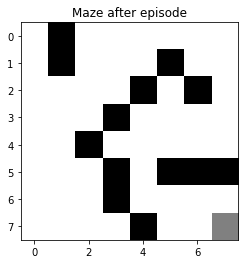

Epoch: 641/999 | Loss: 0.0003 | Episodes: 642 | Win count: 622 | Win rate: 1.000 | time: 1.59 hours
Loss:  0.0003753102937480435
Loss:  0.0005292482674121857
Loss:  0.00016984673857223243
Loss:  0.00033802077086875215
Loss:  0.00011303310748189688
Loss:  0.0001850928929343354
Loss:  0.00024251102877315134
Loss:  0.00014953250865801238
Loss:  0.00037838673233636655
Loss:  0.0005423282127594575
Loss:  6.632481745327823e-05
Loss:  0.0004306657501729205
Loss:  9.54571023612516e-05
Loss:  0.0004457496979739517
Loss:  0.000661076104734093
Loss:  0.00026317243464291096
Loss:  0.00029840038041584194
Loss:  0.00032629365159664303
Loss:  0.0007739112770650536
Loss:  0.00040719026583246887
Loss:  0.0003959235400543548
Loss:  0.0002968885382870212
Loss:  0.00017004314213409089
Loss:  0.00014392260163731407
Loss:  0.0003705153867485933


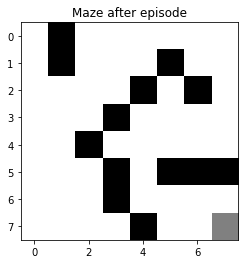

Epoch: 642/999 | Loss: 0.0004 | Episodes: 643 | Win count: 623 | Win rate: 1.000 | time: 1.59 hours
Loss:  0.0003187255497323349
Loss:  0.00023624344248673879
Loss:  0.0001827954183681868
Loss:  0.00021240292699076235
Loss:  0.0004083809399162419
Loss:  6.907200804562308e-05
Loss:  0.00014422376625589095


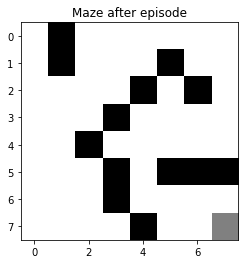

Epoch: 643/999 | Loss: 0.0001 | Episodes: 644 | Win count: 624 | Win rate: 1.000 | time: 1.59 hours
Loss:  0.000310052273562178
Loss:  0.0002058995232800953
Loss:  0.00030735909967916086
Loss:  0.0005285440129227936
Loss:  0.00048451490874867886
Loss:  0.00021647806715918705
Loss:  4.71135799671174e-05
Loss:  0.00031171726004686207
Loss:  0.00020705427232314833
Loss:  0.0002931702329078689
Loss:  0.00015331507347582374
Loss:  4.0651382732903585e-05
Loss:  0.0002613357428344898
Loss:  0.00020224139734636992
Loss:  5.6700428103795275e-05
Loss:  0.0002096421449095942
Loss:  0.00018084991461364552
Loss:  0.00023511278413934633
Loss:  0.0003713848127517849
Loss:  0.0002514562656870112
Loss:  0.0005269103567115963
Loss:  0.00028114756423747167
Loss:  0.0003530531539581716
Loss:  0.0005069549661129713
Loss:  7.485737660317682e-05
Loss:  0.0005270578694762662
Loss:  0.00026230864750687033


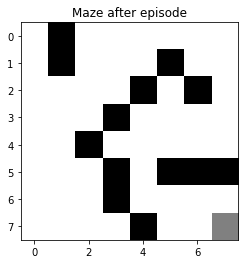

Epoch: 644/999 | Loss: 0.0003 | Episodes: 645 | Win count: 625 | Win rate: 1.000 | time: 1.59 hours
Loss:  9.944741032086313e-05
Loss:  0.00033113070821855217
Loss:  6.216278052306734e-05
Loss:  0.00045047677122056484
Loss:  0.000541740853805095
Loss:  0.00045349227730184793
Loss:  0.0002917655947385356
Loss:  0.0003590528831409756
Loss:  0.00022454746613220777


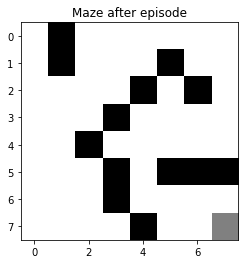

Epoch: 645/999 | Loss: 0.0002 | Episodes: 646 | Win count: 626 | Win rate: 1.000 | time: 1.59 hours
Loss:  0.00054524713777937
Loss:  0.0003171143980580382
Loss:  0.00026681482268031687
Loss:  0.00047425544835277833
Loss:  0.00035276840935694054
Loss:  8.385587716475129e-05
Loss:  0.0003208331618225202
Loss:  0.00018505071057006717
Loss:  0.0004388470988487825
Loss:  0.00016757113189669326
Loss:  2.193046202592086e-05
Loss:  0.00037882558535784483
Loss:  9.51383844949305e-05
Loss:  0.0004090568399988115
Loss:  0.0002874090860132128
Loss:  0.0003715550228662323
Loss:  0.00045003759441897273
Loss:  0.00020127878451603465
Loss:  0.0004840744659304619
Loss:  4.483932752918918e-05
Loss:  0.00015791561418154743


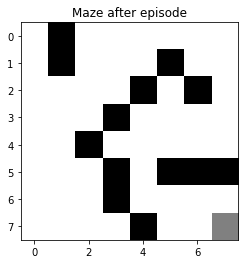

Epoch: 646/999 | Loss: 0.0002 | Episodes: 647 | Win count: 627 | Win rate: 1.000 | time: 1.59 hours
Loss:  0.000271483320830157
Loss:  0.00035896401095669717
Loss:  0.0005065535515313968
Loss:  0.0002517753964639269
Loss:  0.0003327817175886594
Loss:  0.0003575430455384776
Loss:  0.0005420351808425039
Loss:  0.0002954294395749457
Loss:  0.00020072092593181878
Loss:  0.00023146454623201862
Loss:  0.00017809397832024843
Loss:  0.0004541713569778949
Loss:  0.00019918020552722737
Loss:  0.00031764531013322994
Loss:  0.0005116182728670537
Loss:  0.00043687934521585703
Loss:  0.0001539465993118938
Loss:  0.0005964294687146321
Loss:  0.000566949529456906
Loss:  0.00032186506723519415
Loss:  0.0003390468773432076
Loss:  0.00019340257858857512
Loss:  0.00045439289533533156
Loss:  0.0006358687824103981
Loss:  0.0003386349999345839
Loss:  0.0005341966898413375


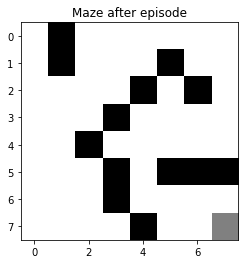

Epoch: 647/999 | Loss: 0.0005 | Episodes: 648 | Win count: 628 | Win rate: 1.000 | time: 1.59 hours
Loss:  0.0007720751746091992
Loss:  0.00015167026140261441
Loss:  0.0003233205497963354
Loss:  0.00015544341295026243
Loss:  0.00025090648341574706
Loss:  0.00011993573571089655
Loss:  0.00019583760331443045
Loss:  0.00035415025195106864
Loss:  0.00016738614067435265
Loss:  5.844854240422137e-05
Loss:  0.0002243330018245615
Loss:  0.0002196592977270484
Loss:  5.3726900659967214e-05
Loss:  0.0001770431626937352
Loss:  6.891315388202202e-05
Loss:  0.00020191841758787632
Loss:  0.0002842436369974166
Loss:  0.00010316065890947357
Loss:  0.0004871261626249179
Loss:  3.4075208532158285e-05
Loss:  0.00035711016971617937
Loss:  0.0001416307786712423
Loss:  0.00024341885728063062
Loss:  0.0003352635758346878
Loss:  0.00023614897872903384
Loss:  0.0002239561508758925
Loss:  0.00016238074022112414


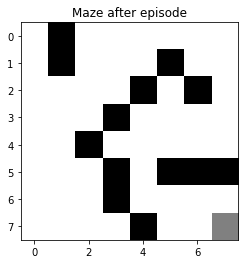

Epoch: 648/999 | Loss: 0.0002 | Episodes: 649 | Win count: 629 | Win rate: 1.000 | time: 1.59 hours
Loss:  8.977672405308113e-05
Loss:  0.0006035886181052774
Loss:  0.00019904105647583492
Loss:  0.0002743663062574342
Loss:  4.90334969072137e-05
Loss:  0.00023644840257475153
Loss:  0.0005658268346451223
Loss:  0.0001617530251678545
Loss:  0.00026081385294673964
Loss:  0.00017803879654820776
Loss:  0.00021534811457968317
Loss:  0.00022417272703023627
Loss:  5.42314719496062e-05
Loss:  0.00034045707434415817
Loss:  0.00038012335426174104
Loss:  0.00045012988266535103
Loss:  0.00018296689813723788
Loss:  0.00022387857461581007
Loss:  0.00016638948909530882


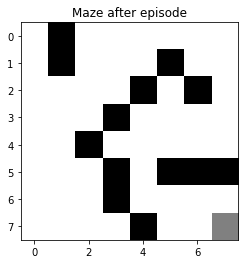

Epoch: 649/999 | Loss: 0.0002 | Episodes: 650 | Win count: 630 | Win rate: 1.000 | time: 1.59 hours
Loss:  4.239207282807911e-05
Loss:  0.00045347310151555575


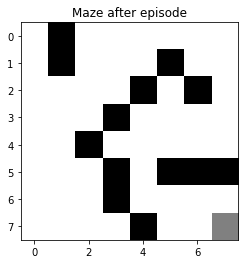

Epoch: 650/999 | Loss: 0.0005 | Episodes: 651 | Win count: 631 | Win rate: 1.000 | time: 1.59 hours
Loss:  0.00010089357238030061
Loss:  0.00023019858781481162
Loss:  0.0005021828765165992
Loss:  0.0002755344394245185
Loss:  0.0002821188754751347
Loss:  7.310849832720123e-05
Loss:  0.00032433583328383975
Loss:  0.0003318190101708751
Loss:  0.0003854498500004411


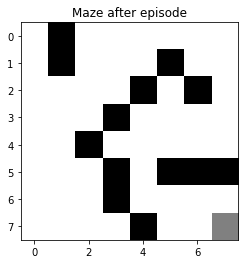

Epoch: 651/999 | Loss: 0.0004 | Episodes: 652 | Win count: 632 | Win rate: 1.000 | time: 1.60 hours
Loss:  0.00042336087790317833
Loss:  0.0001808888846426271
Loss:  6.38710716884816e-05
Loss:  0.000316609406581847
Loss:  0.00026236253324896097
Loss:  0.0002271821977046784
Loss:  7.67605124565307e-05
Loss:  0.00019581512788136024
Loss:  0.00036779610672965646
Loss:  0.00040246432763524354
Loss:  0.0001744463515933603
Loss:  0.00018879953677242156
Loss:  0.000310129405988846
Loss:  0.00039669730176683515
Loss:  6.206967009347863e-05
Loss:  7.755310616630595e-05
Loss:  0.00018024629753199406
Loss:  0.00023831086582504213
Loss:  0.0006541685870615765
Loss:  0.0001702629670035094
Loss:  0.00040434501715935767
Loss:  7.74489417381119e-05
Loss:  0.00010440680853207596
Loss:  0.00018888580234488472
Loss:  7.162127803894691e-05
Loss:  0.0002902689011534676
Loss:  0.0002960198762593791
Loss:  0.0007773034303681925
Loss:  0.00036239066685084254
Loss:  0.00033127653296105564
Loss:  0.000466701330

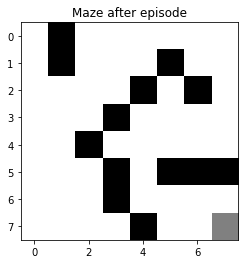

Epoch: 652/999 | Loss: 0.0003 | Episodes: 653 | Win count: 633 | Win rate: 1.000 | time: 1.60 hours
Loss:  0.0004393757844809443
Loss:  0.0005023915437050164
Loss:  0.000399386728531681
Loss:  6.915280209796038e-05
Loss:  9.28007866605185e-05
Loss:  0.0006352701020659879
Loss:  8.530335071554873e-05
Loss:  0.0005062743439339101
Loss:  0.00021522384486161172
Loss:  0.00045754217717330903
Loss:  0.0003704360897245351
Loss:  0.00014135329365672078
Loss:  0.00019392143985896837
Loss:  0.0003333817167003872
Loss:  9.885305007628631e-05
Loss:  0.0003262042155256495
Loss:  0.00028375221154419705
Loss:  0.0001486011897213757
Loss:  8.715835065231659e-05
Loss:  0.00022902236378286034
Loss:  5.5617434554733336e-05
Loss:  0.00022048611936043017
Loss:  0.000493608358738129
Loss:  0.00028425878554116935
Loss:  0.00019030434123123996


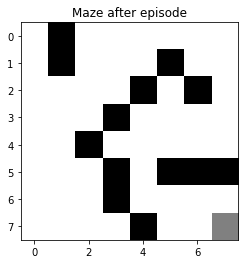

Epoch: 653/999 | Loss: 0.0002 | Episodes: 654 | Win count: 634 | Win rate: 1.000 | time: 1.60 hours
Loss:  0.00021831770209246315
Loss:  0.0003329190949443728
Loss:  0.0003920632370864041


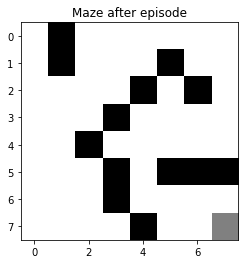

Epoch: 654/999 | Loss: 0.0004 | Episodes: 655 | Win count: 635 | Win rate: 1.000 | time: 1.60 hours
Loss:  0.0001607367848919239
Loss:  0.0002588666684459895
Loss:  0.00020599746858351864
Loss:  0.0006625787646044046
Loss:  0.00017876237689051777
Loss:  0.000326083623804152
Loss:  0.0005210439558140934
Loss:  0.0002988228152389638
Loss:  0.00024320049124071375
Loss:  0.00017221344751305878
Loss:  0.00018408607502351515
Loss:  0.0006187487160786986
Loss:  0.0002688677886908408
Loss:  0.00024305553233716637
Loss:  0.00023683745166636072
Loss:  0.000341107152053155
Loss:  0.0002884238783735782
Loss:  6.363723150570877e-05
Loss:  0.00033687581981212134
Loss:  0.00015590859402436763
Loss:  0.00036862960041617043
Loss:  6.863698217784986e-05
Loss:  0.00013135695189703256
Loss:  4.6977186684671324e-05
Loss:  0.00010013465725933202
Loss:  4.4021116991643794e-05
Loss:  0.0005346289399312809
Loss:  0.0002387497661402449
Loss:  0.00030915639945305884
Loss:  0.00037801995495101437
Loss:  0.0002782

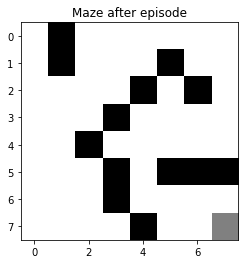

Epoch: 655/999 | Loss: 0.0001 | Episodes: 656 | Win count: 636 | Win rate: 1.000 | time: 1.60 hours
Loss:  0.0004182749253232032
Loss:  4.983389408153016e-05
Loss:  0.00023974108626134694
Loss:  0.00012533825065474957
Loss:  0.00016496843454660848
Loss:  0.00041018113188329153
Loss:  0.0004903654335066676
Loss:  0.0001378885208396241
Loss:  0.00045235878496896476
Loss:  0.00013275807941681705
Loss:  0.00031785979808773845
Loss:  9.999530902859988e-05
Loss:  0.0002015487407334149
Loss:  0.0003721246976056136
Loss:  0.00038770950777688995
Loss:  0.00025248126621590927
Loss:  0.00021254568127915263
Loss:  0.00021695797113352455
Loss:  2.5309762349934317e-05
Loss:  5.385941403801553e-05
Loss:  0.0003563885620678775


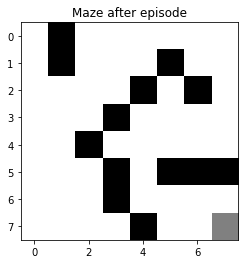

Epoch: 656/999 | Loss: 0.0004 | Episodes: 657 | Win count: 637 | Win rate: 1.000 | time: 1.60 hours
Loss:  6.280070192588028e-05
Loss:  0.00013758550994680263
Loss:  0.00017371054673276376
Loss:  0.0003177255275659263
Loss:  0.00040257083310279995
Loss:  0.0002122572568623582
Loss:  3.614903653215151e-05
Loss:  0.0002603782486403361
Loss:  0.0002819594810716808
Loss:  0.0003893793618772179
Loss:  0.00028402615134837106
Loss:  0.00022584085672860965
Loss:  0.0003177729668095708
Loss:  0.00011496475144667784


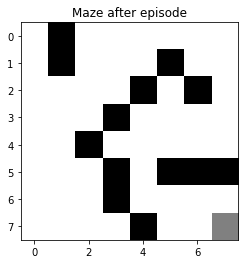

Epoch: 657/999 | Loss: 0.0001 | Episodes: 658 | Win count: 638 | Win rate: 1.000 | time: 1.60 hours
Loss:  0.0004427676321938634
Loss:  4.209239887131844e-05
Loss:  0.0003211421499145217
Loss:  0.0004987772845197469
Loss:  0.0007891014683991671
Loss:  0.0005049917963333428
Loss:  0.0002624097396619618
Loss:  0.00045361580851022154
Loss:  0.00026927578437607735
Loss:  0.00037736951708211564
Loss:  0.0003631910076364875
Loss:  0.0004822399787371978
Loss:  0.00030319864163175225
Loss:  0.0006012168305460364
Loss:  0.0003633312589954585
Loss:  0.0005277002783259377
Loss:  0.000361738697392866
Loss:  0.0004306659975554794
Loss:  0.0003493108833936276
Loss:  0.0003932050458388403
Loss:  0.00018384288341621868
Loss:  0.00039338220085483044
Loss:  0.0006349206669256091
Loss:  0.0002517286593501922
Loss:  0.0005006260907975957
Loss:  0.000326309738738928


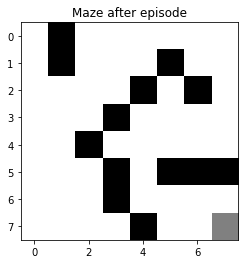

Epoch: 658/999 | Loss: 0.0003 | Episodes: 659 | Win count: 639 | Win rate: 1.000 | time: 1.61 hours
Loss:  5.795104516437277e-05
Loss:  0.00040645354602020234
Loss:  0.00021706640472984873
Loss:  0.00046889064833521843
Loss:  0.0003748123344848864
Loss:  0.00014586098041036166
Loss:  0.00028157159249531105
Loss:  0.0003550831024767831
Loss:  8.844902185956016e-05
Loss:  0.0004631033225450665
Loss:  0.00043839807040058076
Loss:  0.000235069623158779
Loss:  0.00018466493929736316
Loss:  0.0002758188347797841
Loss:  0.0001905758836073801
Loss:  0.00032517066574655473
Loss:  0.00034328292531426996
Loss:  0.000359194353222847
Loss:  0.00012866876932093874
Loss:  0.0004175270332780201
Loss:  0.00014961555643822066
Loss:  0.0006002873851684853
Loss:  0.00040497629379387945
Loss:  0.0002157652488676831
Loss:  0.00036725993413710967
Loss:  0.00018303946853848174
Loss:  0.00019542468362487853


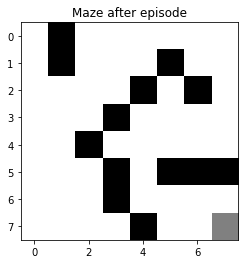

Epoch: 659/999 | Loss: 0.0002 | Episodes: 660 | Win count: 640 | Win rate: 1.000 | time: 1.61 hours
Loss:  0.0003340284019941464
Loss:  0.00025091262432397343
Loss:  0.0001971373858395964


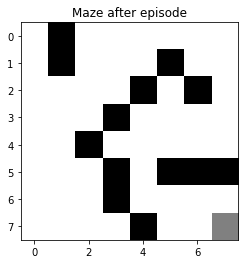

Epoch: 660/999 | Loss: 0.0002 | Episodes: 661 | Win count: 641 | Win rate: 1.000 | time: 1.61 hours
Loss:  0.00022613244800595567
Loss:  0.00023006886658549774


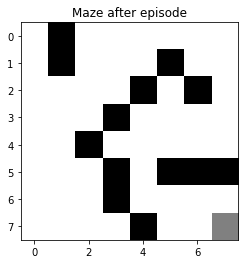

Epoch: 661/999 | Loss: 0.0002 | Episodes: 662 | Win count: 642 | Win rate: 1.000 | time: 1.61 hours
Loss:  0.0005883598641958088
Loss:  0.00019704529404407367
Loss:  0.00035244718310423195
Loss:  0.00020603647863026708
Loss:  0.000369733344996348
Loss:  0.0006032258970662951
Loss:  6.299343658611178e-05
Loss:  0.000396631450712448
Loss:  0.00036683717917185277
Loss:  0.0003607015241868794
Loss:  0.0006250554288271815
Loss:  0.0005025786449550651
Loss:  0.0004483357915887609
Loss:  0.0003537041411618702
Loss:  0.00044992577750235796
Loss:  0.00021709521024604328
Loss:  0.0001997673389269039
Loss:  0.0003620526258600876
Loss:  6.0559580560948234e-05
Loss:  0.0003364206640981138
Loss:  0.0003589133884815965
Loss:  0.00033609681122470647
Loss:  0.0002939017867902294
Loss:  0.00024273901362903416
Loss:  0.0006121150217950344
Loss:  8.195616101147607e-05
Loss:  0.00022147171694086865
Loss:  0.00032222473237197846
Loss:  0.0005743676010752097
Loss:  6.380925697158091e-05


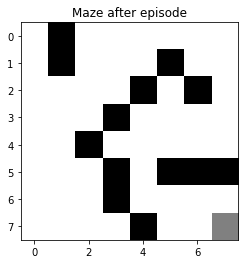

Epoch: 662/999 | Loss: 0.0001 | Episodes: 663 | Win count: 643 | Win rate: 1.000 | time: 1.61 hours
Loss:  0.00024734088219702244
Loss:  0.0007681227580178529
Loss:  0.00023385787790175527
Loss:  0.0003357753739692271
Loss:  0.00020079258683836088
Loss:  0.0006288660515565425
Loss:  0.00036865925358142704
Loss:  0.0002599842700874433


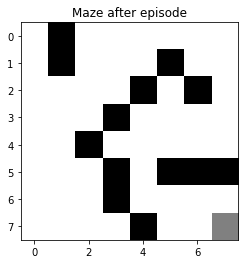

Epoch: 663/999 | Loss: 0.0003 | Episodes: 664 | Win count: 644 | Win rate: 1.000 | time: 1.61 hours
Loss:  0.0004786345234606415
Loss:  0.00029806565726175904
Loss:  0.0005252320988802239
Loss:  0.0003240634614485316
Loss:  0.000736815039999783
Loss:  0.000327457397361286
Loss:  0.0004502555420913268
Loss:  0.0006843152514193207
Loss:  0.00023413502640323713
Loss:  0.00046740200923522934
Loss:  0.0005230143869994208
Loss:  5.975457497697789e-05
Loss:  0.00028315719100646675
Loss:  0.0002566067050793208
Loss:  0.0004434972070157528
Loss:  0.0005891700566280633
Loss:  0.0003603243821999058
Loss:  0.00017811603174777701
Loss:  0.00034235195198561996
Loss:  0.0002108313601638656
Loss:  0.00039593526162207127
Loss:  0.0009217885235557333
Loss:  0.0001518029166618362
Loss:  0.000221271940972656
Loss:  6.21026374574285e-05
Loss:  0.0002047535508609144
Loss:  0.00013096809379931074
Loss:  0.0006588545220438391
Loss:  0.00014625737821916118
Loss:  0.0003889169456670061
Loss:  0.0006822009163442

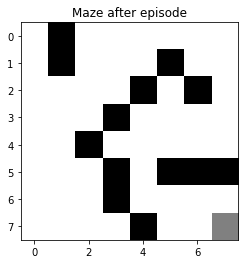

Epoch: 664/999 | Loss: 0.0004 | Episodes: 665 | Win count: 645 | Win rate: 1.000 | time: 1.61 hours
Loss:  0.0005533328367164358
Loss:  0.0003031225423910655
Loss:  0.00010105811088578776
Loss:  0.00021595155340037309
Loss:  0.0004169828607700765
Loss:  0.0006842153961770236
Loss:  0.00022080548660596833
Loss:  0.0001771782226569485
Loss:  0.0007029359112493694
Loss:  6.939739250810817e-05
Loss:  0.0004128471773583442
Loss:  0.0005008037842344493
Loss:  0.0005118911067256704
Loss:  0.000385915715014562
Loss:  0.0004330382216721773
Loss:  0.0001229184417752549
Loss:  0.00038423825753852725
Loss:  0.00025835089763859287
Loss:  0.00041667442565085366
Loss:  0.00022163432731758803
Loss:  0.00032375451701227576
Loss:  0.0003657758788904175
Loss:  0.00025529694539727643
Loss:  0.0006157729949336499
Loss:  0.0004780376184498891
Loss:  0.0006456783157773316
Loss:  0.00042374270560685545
Loss:  0.000255329447099939
Loss:  0.00037813653761986643
Loss:  0.0004179986863164231


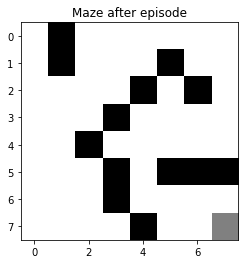

Epoch: 665/999 | Loss: 0.0004 | Episodes: 666 | Win count: 646 | Win rate: 1.000 | time: 1.61 hours
Loss:  0.00039180948806460947
Loss:  8.866314419719856e-05
Loss:  0.0005316966962709557
Loss:  0.00025657357400632463
Loss:  0.00034015413621091284
Loss:  0.00034928476088680327
Loss:  0.0002480598705005832
Loss:  0.0001057124391081743
Loss:  0.0005480638064909726
Loss:  0.00037622787203872576
Loss:  0.00023494104971177876
Loss:  7.375545828836039e-05
Loss:  0.00038783656782470644
Loss:  0.00018829337204806507
Loss:  0.00011925249782507308
Loss:  0.0004859972686972469
Loss:  0.00012753148621413857
Loss:  4.883155088464264e-05
Loss:  0.00038787130324635655
Loss:  0.00020535095245577395
Loss:  0.000655882598948665
Loss:  4.892471042694524e-05
Loss:  0.00015313275798689574
Loss:  0.00028930321786901914
Loss:  0.00023690610396442935
Loss:  0.00021063724852865562
Loss:  0.00016369341756217182
Loss:  0.0004462795186555013
Loss:  0.0003312211701995693


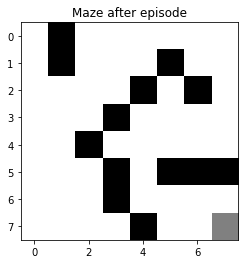

Epoch: 666/999 | Loss: 0.0003 | Episodes: 667 | Win count: 647 | Win rate: 1.000 | time: 1.62 hours
Loss:  0.0002699080287129618
Loss:  0.0004892706492682919
Loss:  0.0003749677416635677
Loss:  0.00031252967164618894
Loss:  0.0004295468679629266
Loss:  0.0003346787161717657
Loss:  9.264475738746114e-05
Loss:  0.0007349250663537532
Loss:  0.00027177061565453187
Loss:  0.0004683285078499466
Loss:  0.0001906143152154982
Loss:  0.0004160367388976738
Loss:  0.0004969722649548203
Loss:  0.0003713891055667773
Loss:  0.00046883586037438363
Loss:  0.0003569462351151742
Loss:  0.0001109355507651344
Loss:  0.00017928383022081107
Loss:  0.0002665128995431587
Loss:  0.00044267892371863127
Loss:  0.00047903200902510434
Loss:  0.00034911150578409433
Loss:  0.000444260222138837
Loss:  0.0003289560991106555
Loss:  0.0002341404397157021
Loss:  0.00037012030952610075
Loss:  0.000571043070522137
Loss:  0.0002665926513145678
Loss:  0.0002144080717698671


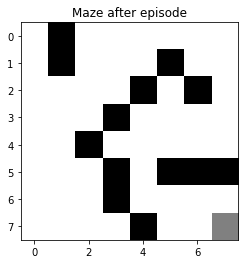

Epoch: 667/999 | Loss: 0.0002 | Episodes: 668 | Win count: 648 | Win rate: 1.000 | time: 1.62 hours
Loss:  0.0006505801575258374
Loss:  0.0004476120593608357
Loss:  0.0003700620654853992
Loss:  0.0004701397701865062
Loss:  0.0002754846282186918
Loss:  8.465494465781376e-05
Loss:  0.0002313161239726469
Loss:  0.00016862522170413285
Loss:  0.0002573036472313106
Loss:  0.000663278711726889
Loss:  0.00017274190031457692
Loss:  0.00048623024486005306
Loss:  0.00023728848464088514
Loss:  0.00046765326987951994
Loss:  0.0002515553387638647
Loss:  0.00014383831694431137
Loss:  0.00030808385054115206
Loss:  0.0005574803217314184
Loss:  0.00038597473758272827
Loss:  0.00016992227756418288
Loss:  0.00016760702055762522


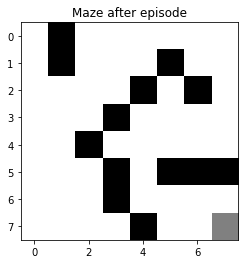

Epoch: 668/999 | Loss: 0.0002 | Episodes: 669 | Win count: 649 | Win rate: 1.000 | time: 1.62 hours
Loss:  0.00038289910298772156
Loss:  0.00030362427060026675
Loss:  0.00038520185626111925
Loss:  0.0007363274635281414
Loss:  0.00043840764556080103
Loss:  0.00020709969248855487
Loss:  0.0004277701518731192
Loss:  0.00045256013981997967
Loss:  0.00030442464048974216
Loss:  0.00025929627372534014
Loss:  0.00014105863374425098
Loss:  0.00011680996612994932
Loss:  0.00027354036137694493
Loss:  0.00024148268857970834
Loss:  0.00013797975043416955
Loss:  0.0002355891247134423
Loss:  0.0002444585152261425
Loss:  0.0005601089505944401
Loss:  0.00030777415668126196
Loss:  0.0003011651169799734
Loss:  0.000252410551183857
Loss:  0.00019671398695209064
Loss:  0.0003999287509941496
Loss:  0.0002580467116786167
Loss:  0.000118732898044982
Loss:  0.0003683130198623985
Loss:  0.0002924405562225729
Loss:  7.373435801127926e-05
Loss:  5.343803422874771e-05
Loss:  0.0003088418743573129
Loss:  0.00016817

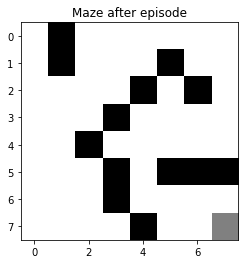

Epoch: 669/999 | Loss: 0.0002 | Episodes: 670 | Win count: 650 | Win rate: 1.000 | time: 1.63 hours
Loss:  2.388281063758768e-05
Loss:  0.0004737500858027488
Loss:  0.0003574669171939604
Loss:  4.509717291512061e-05
Loss:  0.00041809191316133365
Loss:  0.00025636135251261294
Loss:  7.814253604010446e-05
Loss:  0.00025696960801724344
Loss:  0.00014872551764710806
Loss:  0.0003077248838962987
Loss:  0.000565069800359197
Loss:  0.0002492647327017039
Loss:  0.00038279489672277123
Loss:  0.00026988402532879263
Loss:  0.0007154744089348242
Loss:  0.00033024803997250274
Loss:  0.0001350541460851673
Loss:  0.0005447463336167857
Loss:  0.0005215580167714506
Loss:  0.00028602100792340934
Loss:  0.00047767756768735126


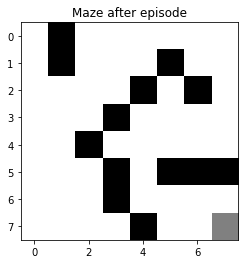

Epoch: 670/999 | Loss: 0.0005 | Episodes: 671 | Win count: 651 | Win rate: 1.000 | time: 1.63 hours
Loss:  0.0004290230863261968
Loss:  0.0002996801194967702
Loss:  0.0002610959127196111
Loss:  0.00024431040947092697
Loss:  0.0005240199825493619
Loss:  0.0004216158849885687
Loss:  0.00023156345559982583
Loss:  0.0005575003306148574


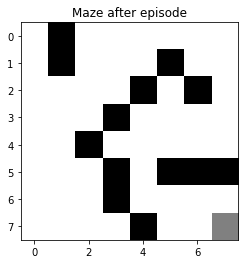

Epoch: 671/999 | Loss: 0.0006 | Episodes: 672 | Win count: 652 | Win rate: 1.000 | time: 1.63 hours
Loss:  0.0004880934575339779
Loss:  0.0003219262944185175
Loss:  0.00032540582105866633
Loss:  0.00023392571893054992
Loss:  0.00020867317653028294
Loss:  0.0002903355343732983
Loss:  0.00033470305788796395
Loss:  6.972404116822872e-05
Loss:  0.00025310900673503056
Loss:  0.0004087150919076521
Loss:  0.00015777654152770992
Loss:  0.0005984020535834134
Loss:  0.00010617816587910056


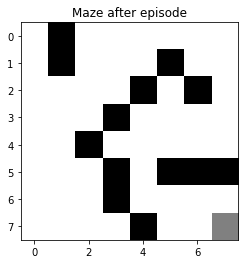

Epoch: 672/999 | Loss: 0.0001 | Episodes: 673 | Win count: 653 | Win rate: 1.000 | time: 1.63 hours
Loss:  0.0003602794313337654
Loss:  0.0003915248962584883
Loss:  0.00029541806725319475
Loss:  0.00021019439736846834
Loss:  0.00018809503671946004
Loss:  8.747797255637124e-05
Loss:  0.00032295795244863257
Loss:  0.0005027304796385579
Loss:  0.00041219694321625866
Loss:  0.0003111916594207287
Loss:  0.0006659763166680932
Loss:  8.97117643035017e-05
Loss:  0.0005933828942943364
Loss:  0.0006751703913323581
Loss:  0.00018080954760080203


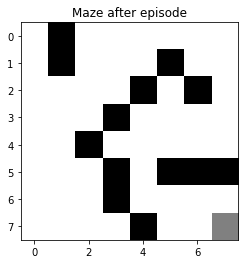

Epoch: 673/999 | Loss: 0.0002 | Episodes: 674 | Win count: 654 | Win rate: 1.000 | time: 1.63 hours
Loss:  0.0002786963668768294
Loss:  0.0001706527909846045
Loss:  0.00020761735504493117
Loss:  0.0006052265234757215
Loss:  0.0005788932176074013
Loss:  0.00039762505184626207
Loss:  0.00013305473476066254
Loss:  0.00035574503272073343
Loss:  0.0003275330309406854
Loss:  0.0002994183814735152
Loss:  0.0003285150887677446
Loss:  0.00020101666450500488
Loss:  0.00018792185437632725
Loss:  0.00010290883801644668
Loss:  9.435393440071493e-05
Loss:  0.0001822726253521978
Loss:  0.0002639928243297618
Loss:  0.0007073288434185088
Loss:  0.0009147445380222052
Loss:  0.0002782787778414786
Loss:  0.0002707381354412064
Loss:  0.0004096525372005999
Loss:  0.0002488070967956446
Loss:  0.0003908071666955948
Loss:  0.00033876069937832654
Loss:  7.888633626862429e-05
Loss:  0.0003589199623093009
Loss:  0.00015365489161922596
Loss:  0.00023976509328349493
Loss:  0.0003849564236588776
Loss:  0.00029744236

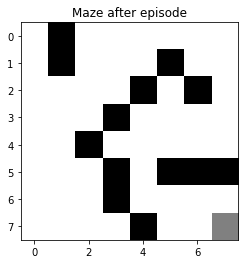

Epoch: 674/999 | Loss: 0.0005 | Episodes: 675 | Win count: 655 | Win rate: 1.000 | time: 1.63 hours
Loss:  0.0002479530667187646
Loss:  0.0005890577740501612
Loss:  0.0001922302326420322
Loss:  0.0005076375528005883
Loss:  0.0005453899066196755
Loss:  0.00022676547814626247
Loss:  0.0004336689889896661
Loss:  0.0003732615878107026
Loss:  0.00035292549364385195
Loss:  6.840787682449445e-05
Loss:  0.0006645177927566692
Loss:  0.0004194723005639389
Loss:  0.00016592395695624873
Loss:  0.00040954688302008435
Loss:  0.0003147891547996551
Loss:  0.0003853142261505127
Loss:  0.000302333923173137
Loss:  0.000559543477720581


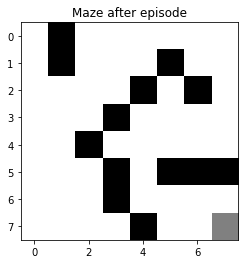

Epoch: 675/999 | Loss: 0.0006 | Episodes: 676 | Win count: 656 | Win rate: 1.000 | time: 1.64 hours
Loss:  0.0005755198653787374
Loss:  0.0003051989733648952
Loss:  0.0002460672731103841
Loss:  0.00042561219015624374
Loss:  8.398502905038185e-05
Loss:  6.474975270975847e-05
Loss:  7.311435365409125e-05


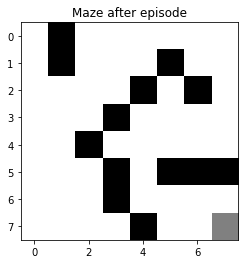

Epoch: 676/999 | Loss: 0.0001 | Episodes: 677 | Win count: 657 | Win rate: 1.000 | time: 1.64 hours
Loss:  0.00033088036434492096
Loss:  0.0005197724094614387
Loss:  0.0003406372125027701
Loss:  0.00039654201827943325
Loss:  0.0002907707093982026
Loss:  0.00022711984638590366
Loss:  0.000370031368220225
Loss:  0.0005532055220101029
Loss:  0.0005085238080937415
Loss:  0.0007020866760285571


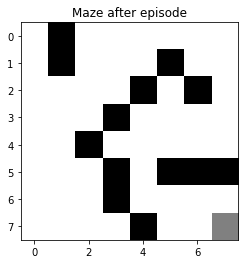

Epoch: 677/999 | Loss: 0.0007 | Episodes: 678 | Win count: 658 | Win rate: 1.000 | time: 1.64 hours
Loss:  0.00043306332372594625


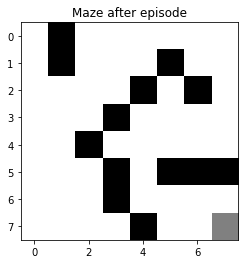

Epoch: 678/999 | Loss: 0.0004 | Episodes: 679 | Win count: 659 | Win rate: 1.000 | time: 1.64 hours
Loss:  0.0005892908957321197
Loss:  0.000632009789114818


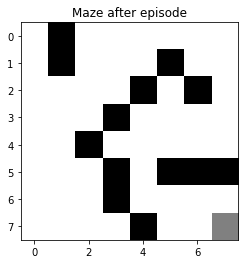

Epoch: 679/999 | Loss: 0.0006 | Episodes: 680 | Win count: 660 | Win rate: 1.000 | time: 1.64 hours
Loss:  0.00020348309408291243
Loss:  6.151088382466696e-05
Loss:  0.00016764991960371844
Loss:  0.00035209312045481056
Loss:  0.00043976532469969243
Loss:  0.0004146581923123449
Loss:  0.00038391521957237273
Loss:  0.0002584002068033442
Loss:  0.00040048931259661913


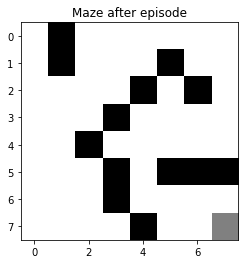

Epoch: 680/999 | Loss: 0.0004 | Episodes: 681 | Win count: 661 | Win rate: 1.000 | time: 1.64 hours
Loss:  0.0003976721491198987
Loss:  0.0005437910294858739
Loss:  0.0004411758272908628
Loss:  0.00030870590126141906
Loss:  0.00021421799465315416
Loss:  0.00031223424593918025
Loss:  0.0002755337263806723
Loss:  0.0004798868321813643
Loss:  0.000403620331780985
Loss:  0.000519905166584067
Loss:  0.00041984008566942066
Loss:  0.00010853522690013051
Loss:  0.00025905322399921715


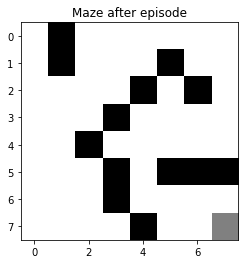

Epoch: 681/999 | Loss: 0.0003 | Episodes: 682 | Win count: 662 | Win rate: 1.000 | time: 1.64 hours
Loss:  0.0004807998921023682
Loss:  0.0005764538364019245


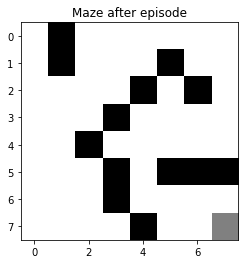

Epoch: 682/999 | Loss: 0.0006 | Episodes: 683 | Win count: 663 | Win rate: 1.000 | time: 1.64 hours
Loss:  0.0004163416160736233
Loss:  0.0004036886602989398
Loss:  0.0005691236874554306
Loss:  0.0003896555717801675
Loss:  0.0004486356774577871
Loss:  0.0003810844136751257
Loss:  0.0003241415397496894
Loss:  0.0003112768317805603
Loss:  0.0003289541491540149
Loss:  0.0005409213772509247
Loss:  0.00023999906079552602
Loss:  0.00031191522430162877
Loss:  0.000643544175545685
Loss:  0.0003377355315024033
Loss:  0.0007518474594689906


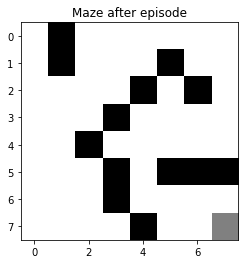

Epoch: 683/999 | Loss: 0.0008 | Episodes: 684 | Win count: 664 | Win rate: 1.000 | time: 1.64 hours
Loss:  0.0005649173981510103
Loss:  0.00041376867739018053
Loss:  0.00027461667195893824
Loss:  0.00019847586008836515
Loss:  0.00026970596809405833
Loss:  0.0005439168235170655
Loss:  0.000515378313139081
Loss:  0.0001502672785136383
Loss:  0.00010674992336134892
Loss:  0.0003955036954721436
Loss:  0.0004969662841176614
Loss:  0.0006027242634445429
Loss:  0.00032469868165208027
Loss:  0.0008272317063529044
Loss:  0.00013998215217725374
Loss:  0.00021413604554254562
Loss:  0.00022766094480175525
Loss:  0.0004406126245157793
Loss:  0.0007048971601761878
Loss:  0.0003503799089230597
Loss:  0.0007792605319991708
Loss:  0.0006102315528551117
Loss:  0.00045582161692436785
Loss:  0.0009595820447430015
Loss:  0.0005321259086485952
Loss:  0.0006750036554876715
Loss:  0.0002209729063906707
Loss:  0.00015938636352075264
Loss:  0.0002640329839778133
Loss:  0.0006071348907426
Loss:  0.00039308819395

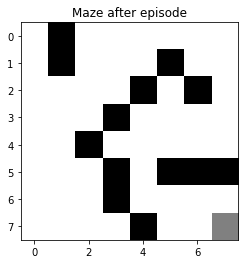

Epoch: 684/999 | Loss: 0.0005 | Episodes: 685 | Win count: 665 | Win rate: 1.000 | time: 1.65 hours
Loss:  0.00039371518505504355


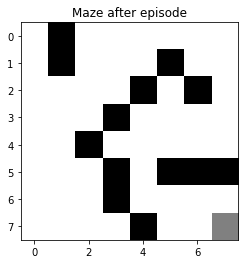

Epoch: 685/999 | Loss: 0.0004 | Episodes: 686 | Win count: 666 | Win rate: 1.000 | time: 1.65 hours
Loss:  0.0006061601743567735
Loss:  0.0006179395713843405
Loss:  0.000690004468197003
Loss:  0.000775619933847338
Loss:  0.0006172079883981496
Loss:  0.0006280344969127327
Loss:  0.00040632135642226785
Loss:  0.0008462343248538673
Loss:  0.0005471533804666251
Loss:  0.0004435432711034082
Loss:  0.0007047548715490848
Loss:  0.0004992883332306519
Loss:  0.0004287913325242698
Loss:  0.0006486467900685966
Loss:  0.0007528873102273792
Loss:  0.00020800581842195243
Loss:  0.0004752997701871209
Loss:  0.0009458219283260405
Loss:  0.000494396997964941
Loss:  0.00033205337240360677
Loss:  0.0006219980423338711
Loss:  0.00039122036832850426
Loss:  0.0004756664566230029
Loss:  0.0003122663911199197
Loss:  0.0004221954368404113
Loss:  0.000560626940568909
Loss:  0.0003028406063094735
Loss:  0.0011726259835995734


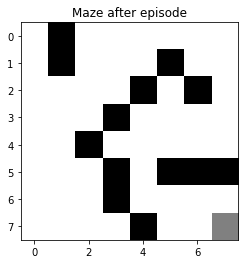

Epoch: 686/999 | Loss: 0.0012 | Episodes: 687 | Win count: 667 | Win rate: 1.000 | time: 1.65 hours
Loss:  0.0005172473174752668
Loss:  0.0013142506359145045
Loss:  0.0005565617320826277
Loss:  0.0009109970415011048
Loss:  0.0006200812349561602
Loss:  0.0005074916407465935
Loss:  0.00034299519029445946
Loss:  0.0005800919898319989
Loss:  0.0004452439898159355
Loss:  0.00023357658938039094
Loss:  0.0008296932501252741
Loss:  0.00029070208984194323
Loss:  0.0003872359957313165
Loss:  0.0006480943411588669
Loss:  0.0004416114097693935
Loss:  0.00047317413554992527
Loss:  0.00027538697759155184
Loss:  0.00040511418774258345
Loss:  0.000460343697341159
Loss:  0.00026385162345832214
Loss:  0.0005758311599493027


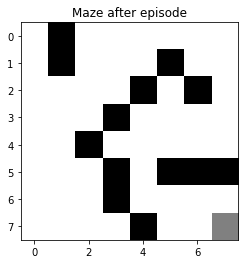

Epoch: 687/999 | Loss: 0.0006 | Episodes: 688 | Win count: 668 | Win rate: 1.000 | time: 1.65 hours
Loss:  0.0007381048053503036
Loss:  0.00017872425814857706
Loss:  0.00029594921215903014
Loss:  0.0002460666000843048
Loss:  0.00029989631730131805
Loss:  0.00035372811544220895
Loss:  0.0002880947577068582
Loss:  0.00036504550371319056


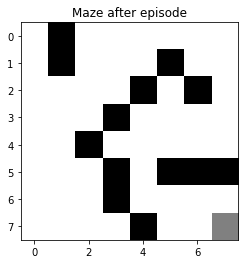

Epoch: 688/999 | Loss: 0.0004 | Episodes: 689 | Win count: 669 | Win rate: 1.000 | time: 1.65 hours
Loss:  0.0004946644767187536
Loss:  0.0004441512282937765
Loss:  0.00014688034571008757
Loss:  0.0007343808247242123
Loss:  0.000267976622126298
Loss:  0.0001344135671388358
Loss:  0.0005969449121039361
Loss:  0.0002829706936609
Loss:  0.0006243932875804603
Loss:  0.00025617120263632387
Loss:  0.00048173674440477043
Loss:  0.000491450889967382


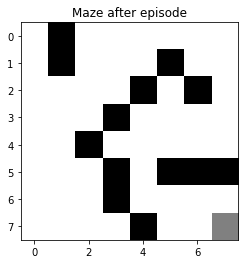

Epoch: 689/999 | Loss: 0.0005 | Episodes: 690 | Win count: 670 | Win rate: 1.000 | time: 1.65 hours
Loss:  0.000475308028399013
Loss:  0.0006804510194342583
Loss:  0.0003940071037504822
Loss:  0.0005250616086414084
Loss:  0.000491647922899574
Loss:  0.0003471242671366781
Loss:  0.0004307770577725023


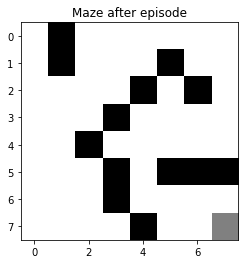

Epoch: 690/999 | Loss: 0.0004 | Episodes: 691 | Win count: 671 | Win rate: 1.000 | time: 1.66 hours
Loss:  0.000386122555937618
Loss:  0.0006965971406316385
Loss:  0.0007927952392492443


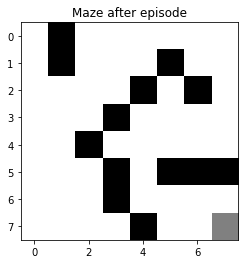

Epoch: 691/999 | Loss: 0.0008 | Episodes: 692 | Win count: 672 | Win rate: 1.000 | time: 1.66 hours
Loss:  0.0002816009509842843
Loss:  0.0005123024748172611
Loss:  0.0004314758552936837
Loss:  0.0006149761320557445
Loss:  0.0004941097286064178
Loss:  0.00043656192428898066
Loss:  0.0005923355201957747
Loss:  0.0003268930267950054
Loss:  0.0006539511632581707
Loss:  0.0002449924941174686
Loss:  0.0003823587467195466
Loss:  0.0005110796992084943
Loss:  0.00038500718073919415
Loss:  0.000681345205521211
Loss:  0.0004400766920298338
Loss:  0.0004379789315862581
Loss:  0.0003267248102929443
Loss:  0.0002270400000270456
Loss:  0.0008450364111922681
Loss:  0.0002865816277335398
Loss:  0.0005339769413694739
Loss:  0.0006277136271819472
Loss:  0.000568657080293633
Loss:  0.0003360299233463593
Loss:  0.0001099880100809969


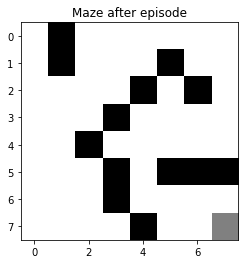

Epoch: 692/999 | Loss: 0.0001 | Episodes: 693 | Win count: 673 | Win rate: 1.000 | time: 1.66 hours
Loss:  0.00025271938648074865


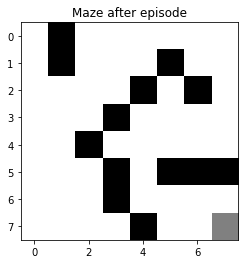

Epoch: 693/999 | Loss: 0.0003 | Episodes: 694 | Win count: 674 | Win rate: 1.000 | time: 1.66 hours
Loss:  0.0005229484231676906
Loss:  0.0004484863602556288
Loss:  0.0007578537333756685
Loss:  0.0007319280703086406
Loss:  0.0003894407273037359
Loss:  0.0006670416623819619
Loss:  0.0004641317354980856
Loss:  0.00040409548819297925
Loss:  0.0006358531245496124
Loss:  0.0005799202481284738
Loss:  0.0003607385551731568
Loss:  0.0003704623304656707
Loss:  0.0004038472688989714
Loss:  0.00018724323672358878
Loss:  0.0003807037883234443
Loss:  0.0007709499332122505
Loss:  0.0006399863632395864
Loss:  0.0006092609110055491
Loss:  0.0009091971442103386
Loss:  0.0006049042422091588
Loss:  0.0005858003860339522
Loss:  0.0008022130350582302
Loss:  0.0004652796051232144
Loss:  0.0002703498175833374
Loss:  0.0006240292568691075
Loss:  0.00023954108473844826
Loss:  0.0005182335880817845
Loss:  0.0005823692044941708
Loss:  0.000600858242250979


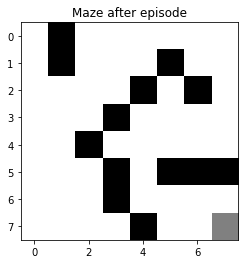

Epoch: 694/999 | Loss: 0.0006 | Episodes: 695 | Win count: 675 | Win rate: 1.000 | time: 1.66 hours
Loss:  0.00024286008920171298
Loss:  0.00030672534194309264
Loss:  0.0002612796888570301
Loss:  0.00015016749239293858
Loss:  0.0008295291918329895
Loss:  0.0002830554840329569
Loss:  0.0005022995464969426
Loss:  0.0006203940138220787
Loss:  0.0006121343758422881
Loss:  0.00017197391935042106
Loss:  0.0004658302932512015
Loss:  0.00016398383741034195
Loss:  0.00044480920769274235
Loss:  0.0007322926539927721
Loss:  0.00045689813487115316
Loss:  0.00017211391968885437
Loss:  0.0004149716114625335
Loss:  0.0003474276891211048
Loss:  0.00045686222438234836
Loss:  0.00011502472625579685
Loss:  0.0004577600338961929
Loss:  0.0010477664764039218
Loss:  0.0005349341663531959


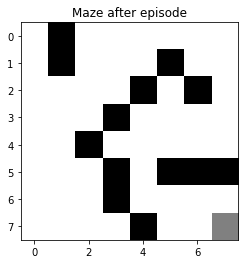

Epoch: 695/999 | Loss: 0.0005 | Episodes: 696 | Win count: 676 | Win rate: 1.000 | time: 1.66 hours
Loss:  0.00010932862642221153
Loss:  0.0009851579670794308
Loss:  0.0008034027123358101
Loss:  0.0003721106331795454
Loss:  0.0003521922626532614
Loss:  0.00017785103409551084
Loss:  0.0007822294719517231
Loss:  0.0003740978572750464
Loss:  0.00034231727477163076
Loss:  0.0004310462682042271
Loss:  0.00026390051061753184
Loss:  0.00010742732047219761
Loss:  0.00015233741942211054
Loss:  0.00025379164435435086
Loss:  0.0005614584079012275
Loss:  0.0003537725715432316
Loss:  0.00030090397922322154
Loss:  0.00039624571218155324
Loss:  0.00010656716040102765
Loss:  0.00014248437219066545
Loss:  0.00018814096983987838
Loss:  7.078787893988192e-05
Loss:  0.0008858981891535223
Loss:  0.0006222285737749189
Loss:  0.0007150461606215686
Loss:  0.00021202502102823928
Loss:  0.0003023344688699581


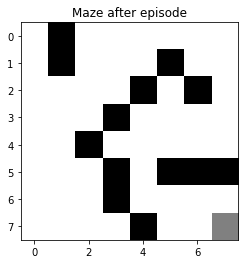

Epoch: 696/999 | Loss: 0.0003 | Episodes: 697 | Win count: 677 | Win rate: 1.000 | time: 1.67 hours
Loss:  0.0007193688943516463
Loss:  0.00035822375502903014
Loss:  7.786299283907283e-05
Loss:  0.00028143358940724283
Loss:  0.00016052719365688972


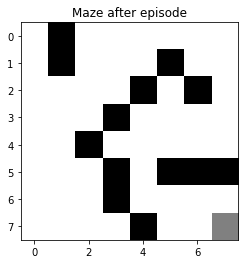

Epoch: 697/999 | Loss: 0.0002 | Episodes: 698 | Win count: 678 | Win rate: 1.000 | time: 1.67 hours
Loss:  0.0002442525146761909
Loss:  0.0004671158822020516
Loss:  0.0001715987382340245
Loss:  0.00025521036877762526
Loss:  0.0006852427904959768
Loss:  0.0005739227271988057
Loss:  0.00017129451225628145
Loss:  0.0005567112821154296
Loss:  0.00034136946487706155
Loss:  0.0004779190057888627
Loss:  0.00017619293430470861
Loss:  0.0007204143330454826
Loss:  0.000381653078875388
Loss:  0.00019632360636023805
Loss:  0.0003161627100780606
Loss:  0.0008173484238795936
Loss:  0.00038060716178733855
Loss:  9.529105955152772e-05
Loss:  0.0003474643308436498
Loss:  0.0002804870455292985
Loss:  0.0006785657606087625
Loss:  0.0005261300830170512
Loss:  0.00028348735941108316
Loss:  0.0004702167061623186
Loss:  0.00014236961214919575
Loss:  0.0006971459370106459
Loss:  0.0005188870709389448
Loss:  0.0002346387700526975
Loss:  0.0005658826703438535
Loss:  0.00032355546863982454
Loss:  0.0001212295392

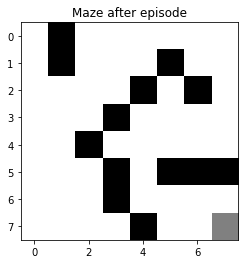

Epoch: 698/999 | Loss: 0.0005 | Episodes: 699 | Win count: 679 | Win rate: 1.000 | time: 1.67 hours
Loss:  0.0004153308691456914
Loss:  0.0002706247687456198
Loss:  0.0005294001603033394
Loss:  0.0002095338531944435
Loss:  0.0007726350449956954
Loss:  0.0004361741812317632
Loss:  0.0003619004273787141
Loss:  0.000337385296006687
Loss:  5.870658787898719e-05
Loss:  0.0006426400213968009
Loss:  0.0004903254921373446
Loss:  0.0006787225429434329
Loss:  0.0005361476796679199
Loss:  0.0003671710437629372
Loss:  0.0004399919416755438
Loss:  0.0005229921516729519
Loss:  0.000463155098259449
Loss:  0.00034027648507617414
Loss:  0.0006517740985145792
Loss:  0.00025797651323955506
Loss:  0.00022385382908396423
Loss:  0.00024499212304363027


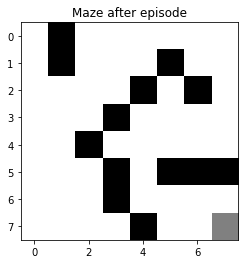

Epoch: 699/999 | Loss: 0.0002 | Episodes: 700 | Win count: 680 | Win rate: 1.000 | time: 1.67 hours
Loss:  0.00035899251815862954
Loss:  0.0005020309545216151
Loss:  0.00037432010867632926
Loss:  0.00014263217599363998
Loss:  0.00017901552928378806
Loss:  0.0004469842097023502
Loss:  0.0002490487095201388
Loss:  0.0005445351998787373
Loss:  0.00011727583478204906
Loss:  0.0004884289082838222
Loss:  0.0002320091298315674
Loss:  0.00040379559504799545
Loss:  9.258238787879236e-05
Loss:  0.0005207976209931076
Loss:  0.0004472904256545007
Loss:  0.0006172657303977758
Loss:  0.00017075741925509647
Loss:  0.000422299635829404
Loss:  0.0007262014696607366


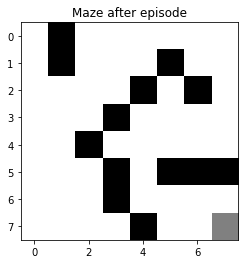

Epoch: 700/999 | Loss: 0.0007 | Episodes: 701 | Win count: 681 | Win rate: 1.000 | time: 1.67 hours
Loss:  0.0007874909206293523


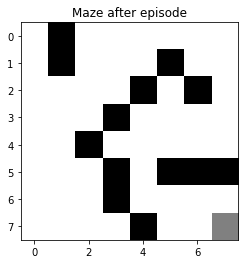

Epoch: 701/999 | Loss: 0.0008 | Episodes: 702 | Win count: 682 | Win rate: 1.000 | time: 1.67 hours
Loss:  0.0003010415020980872
Loss:  8.066509326454252e-05
Loss:  0.0006386334716808051
Loss:  0.0005066800949862227
Loss:  0.00036007956077810377
Loss:  0.0006368808972183615
Loss:  0.0001180206163553521
Loss:  0.0002800562506308779
Loss:  0.00031759252306073904
Loss:  0.0003818387194769457
Loss:  0.000599701888859272
Loss:  0.0006495006673503667
Loss:  0.0004639319813577458
Loss:  0.0004923328087897971
Loss:  0.0006775773945264518
Loss:  0.0002535552339395508
Loss:  0.0005548368790186942
Loss:  0.0006191682768985629
Loss:  0.00048074689402710646
Loss:  0.000756825233111158


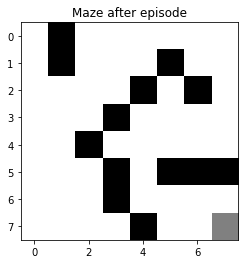

Epoch: 702/999 | Loss: 0.0008 | Episodes: 703 | Win count: 683 | Win rate: 1.000 | time: 1.67 hours
Loss:  0.0004200685361865908
Loss:  0.0005453525154734962
Loss:  0.000183313535671914


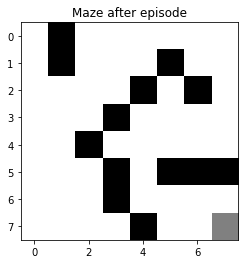

Epoch: 703/999 | Loss: 0.0002 | Episodes: 704 | Win count: 684 | Win rate: 1.000 | time: 1.68 hours
Loss:  0.0006187732797116041
Loss:  0.0006946783978492022
Loss:  0.0004344132321421057
Loss:  0.00035569913961808197
Loss:  0.0005826634878758341
Loss:  0.0004105472471565008
Loss:  0.000568482864764519
Loss:  0.0006251755985431373
Loss:  0.0002553803496994078
Loss:  0.00025943965010810643


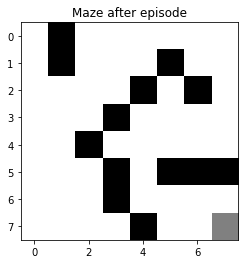

Epoch: 704/999 | Loss: 0.0003 | Episodes: 705 | Win count: 685 | Win rate: 1.000 | time: 1.68 hours
Loss:  0.00035469183058012277
Loss:  0.00047299161087721586
Loss:  0.0007832615519873798
Loss:  0.0004718200580100529
Loss:  0.00038939867226872593
Loss:  0.0003357635432621464
Loss:  0.0006156273157102987
Loss:  0.0006820234120823443
Loss:  0.0006446092156693339
Loss:  0.000585276517085731
Loss:  0.00041729406802915037


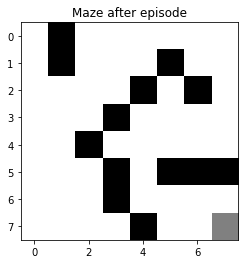

Epoch: 705/999 | Loss: 0.0004 | Episodes: 706 | Win count: 686 | Win rate: 1.000 | time: 1.68 hours
Loss:  0.00026909607549896464
Loss:  0.0004524158430285752
Loss:  0.00046343993744812906
Loss:  0.0004040837229695171
Loss:  0.00015690814689151011
Loss:  0.0005917337111895904
Loss:  0.0004661139682866633
Loss:  0.00030927151965443045
Loss:  0.000608261238085106
Loss:  0.0002167172497138381
Loss:  0.00038583006244152784
Loss:  0.0003987087111454457
Loss:  0.0005471699987538159


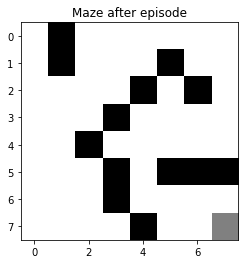

Epoch: 706/999 | Loss: 0.0005 | Episodes: 707 | Win count: 687 | Win rate: 1.000 | time: 1.68 hours
Loss:  0.00027014720399165526


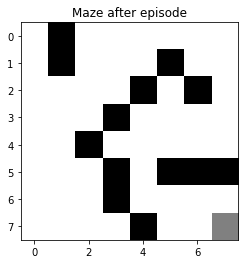

Epoch: 707/999 | Loss: 0.0003 | Episodes: 708 | Win count: 688 | Win rate: 1.000 | time: 1.68 hours
Loss:  0.0003782048006542027
Loss:  0.0004302358429413289
Loss:  0.00032590435876045376
Loss:  0.0003189067829225678
Loss:  0.00031152441079029813
Loss:  0.00010665948138921522
Loss:  4.9783709982875735e-05
Loss:  0.00036105720937484875


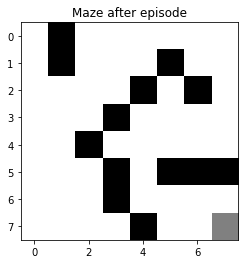

Epoch: 708/999 | Loss: 0.0004 | Episodes: 709 | Win count: 689 | Win rate: 1.000 | time: 1.68 hours
Loss:  0.0003382838549441658
Loss:  0.00039409854434779845
Loss:  0.0005452505429275334
Loss:  0.0007146337302401662
Loss:  0.00014182714221533388
Loss:  0.0004132534668315202
Loss:  0.0005268018358037807
Loss:  0.0005347336846170947
Loss:  0.00019141979282721877
Loss:  0.00012352225166978315
Loss:  3.5427168768364936e-05
Loss:  0.0002401802848908119
Loss:  0.00021158834715606645
Loss:  9.189025149680674e-05
Loss:  0.0003774359429371543
Loss:  0.00024802300322335213
Loss:  0.00012756490832543932
Loss:  0.0005092693318147212
Loss:  0.0007101229857653379
Loss:  0.0003585919475881383
Loss:  0.00014822322918917052
Loss:  0.00047268657363019884
Loss:  0.0005938125832471997
Loss:  0.0003906341007677838
Loss:  9.694326217868365e-05
Loss:  0.00031836508242122363
Loss:  3.592959728848655e-05


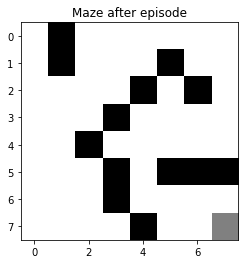

Epoch: 709/999 | Loss: 0.0000 | Episodes: 710 | Win count: 690 | Win rate: 1.000 | time: 1.68 hours
Loss:  0.00028721299895551056


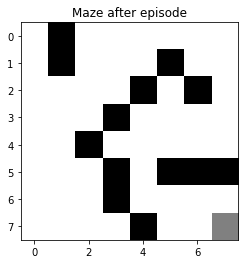

Epoch: 710/999 | Loss: 0.0003 | Episodes: 711 | Win count: 691 | Win rate: 1.000 | time: 1.68 hours
Loss:  0.00041060795774683356
Loss:  0.00024930229847086594
Loss:  0.0005360249488148838
Loss:  0.0001031545180012472
Loss:  0.0007836745062377304
Loss:  0.00029361511406023055
Loss:  0.0006009248027112335
Loss:  0.0006284981936914846
Loss:  0.00034019462327705696
Loss:  0.0001857171591836959
Loss:  0.0006717613141518086
Loss:  0.00013116631453158334
Loss:  7.338865907513537e-05
Loss:  0.00042873014535871334
Loss:  0.0003657534980447963
Loss:  0.00043572040158323944
Loss:  0.000570298230741173
Loss:  0.0005611382948700339
Loss:  0.0002517490356694907
Loss:  0.0008787464466877282
Loss:  0.0003646843251772225
Loss:  0.0005458461091620848
Loss:  0.00036666209052782506
Loss:  0.0006225672477739863
Loss:  0.00011225630441913381
Loss:  0.00021690944413421676
Loss:  2.6153418730245903e-05


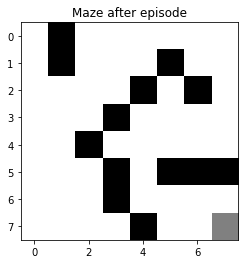

Epoch: 711/999 | Loss: 0.0000 | Episodes: 712 | Win count: 692 | Win rate: 1.000 | time: 1.68 hours
Loss:  7.811473005858716e-05
Loss:  0.0005132528822286986


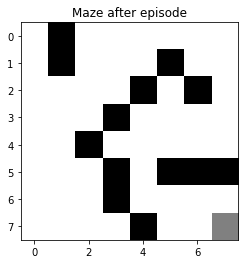

Epoch: 712/999 | Loss: 0.0005 | Episodes: 713 | Win count: 693 | Win rate: 1.000 | time: 1.69 hours
Loss:  0.0003698653163155541
Loss:  0.00032844622182892635
Loss:  0.0003646349359769374
Loss:  0.00036371952592162415
Loss:  0.00022792775416746736
Loss:  0.0005235313001321629
Loss:  0.00035557549563236535
Loss:  0.00015274494944605976
Loss:  0.0004660410340875387
Loss:  0.00011649773296085186
Loss:  0.0005283291538944468
Loss:  0.0003261549209128134
Loss:  0.0005962295836070552
Loss:  0.0003759004030143842
Loss:  0.0004571424797177315
Loss:  0.000496897118864581
Loss:  0.0003005818580277264
Loss:  0.0003478446597000584
Loss:  0.000118424286483787
Loss:  4.025760426884517e-05
Loss:  0.00031755513919051737
Loss:  0.00040696090582059696
Loss:  0.0002580261862021871
Loss:  0.00039672131242696196
Loss:  0.00018482642371964175
Loss:  0.000533194761374034


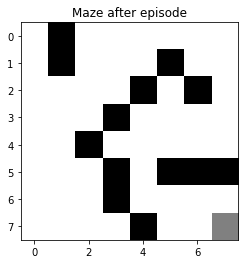

Epoch: 713/999 | Loss: 0.0005 | Episodes: 714 | Win count: 694 | Win rate: 1.000 | time: 1.69 hours
Loss:  0.00018754459597403184
Loss:  0.0005863400438101962
Loss:  0.0006599327025469393
Loss:  0.0004344446206232533
Loss:  0.00045505998969019856
Loss:  0.0003995314036728814
Loss:  0.000364253661246039
Loss:  0.00037213825999060646
Loss:  0.00020286255312385038
Loss:  0.00022391639140550978


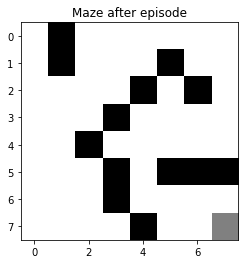

Epoch: 714/999 | Loss: 0.0002 | Episodes: 715 | Win count: 695 | Win rate: 1.000 | time: 1.69 hours
Loss:  0.0002710204425966367
Loss:  0.0005720116314478219
Loss:  9.341761688119732e-05
Loss:  0.0005076580127933994
Loss:  0.00016544948448427022
Loss:  0.00023966260778252035
Loss:  4.407709093356971e-05
Loss:  0.0005838624783791602


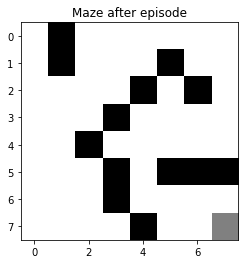

Epoch: 715/999 | Loss: 0.0006 | Episodes: 716 | Win count: 696 | Win rate: 1.000 | time: 1.69 hours
Loss:  8.737711323192343e-05
Loss:  7.760564221825916e-05
Loss:  0.0004255177336744964
Loss:  0.00034354792478552554
Loss:  0.00011504725262057036
Loss:  9.373049942951184e-05
Loss:  0.0003629698549048044
Loss:  0.00018235104653285816
Loss:  9.926378515956458e-05
Loss:  3.722022393048974e-05
Loss:  9.991854676627554e-05
Loss:  0.00022586320574191632
Loss:  0.00030677996983285993
Loss:  0.0003730222233571112
Loss:  0.00037013497239968274
Loss:  0.00018298833674634807
Loss:  0.00022732924480806105
Loss:  0.0003835643292404711
Loss:  0.00019717543182196096
Loss:  0.0001966412255569594
Loss:  0.0008192412933567539
Loss:  0.00015262922534020618
Loss:  0.0006296165520325303
Loss:  0.00021054406170151196
Loss:  0.00027449488698039204
Loss:  0.00043944861681666225
Loss:  0.0003425973409321159
Loss:  0.00017035511700669304
Loss:  0.00014077979722060263


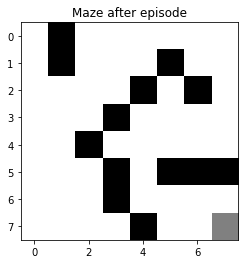

Epoch: 716/999 | Loss: 0.0001 | Episodes: 717 | Win count: 697 | Win rate: 1.000 | time: 1.69 hours
Loss:  0.0004393601993797347
Loss:  0.0002832714744727127
Loss:  0.00012770332250511274
Loss:  0.00019454307403066196
Loss:  0.00020476007921388373
Loss:  0.00028131980798207223
Loss:  0.00037876346323173493
Loss:  0.0002510748745407909
Loss:  0.0002256643638247624
Loss:  0.0003743089037016034
Loss:  0.0002190443847212009
Loss:  0.00031016541470307857
Loss:  0.00021074499818496406
Loss:  0.00013005236542085186
Loss:  0.0005123984155943617
Loss:  0.00017432407548767515
Loss:  0.00040651572635397315
Loss:  0.0004863842623308301
Loss:  0.00034708144812611863
Loss:  0.00035051167651545256
Loss:  0.0004635199875338003
Loss:  0.00012011311264359392
Loss:  0.00017385250248480588
Loss:  6.871213372505736e-05
Loss:  0.00015846098540350795
Loss:  7.72637522459263e-05
Loss:  0.00014401111639017472


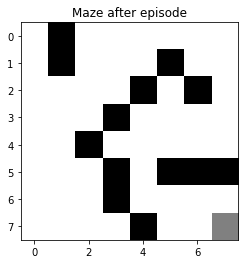

Epoch: 717/999 | Loss: 0.0001 | Episodes: 718 | Win count: 698 | Win rate: 1.000 | time: 1.69 hours
Loss:  8.002514914551284e-05
Loss:  0.00013158747242414393
Loss:  0.00019736098329303786
Loss:  0.0001766733985277824
Loss:  5.09945029989467e-05
Loss:  6.966499859117903e-05
Loss:  0.0003473596734693274
Loss:  0.00021844110960955732
Loss:  0.0002453538909321651


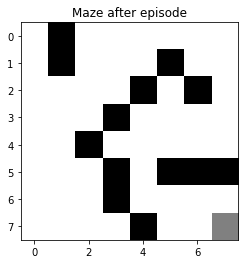

Epoch: 718/999 | Loss: 0.0002 | Episodes: 719 | Win count: 699 | Win rate: 1.000 | time: 1.70 hours
Loss:  9.739722372614779e-05
Loss:  3.4592656447784975e-05
Loss:  0.00016243024401774164
Loss:  3.062093492189888e-05
Loss:  0.00018948189426737372
Loss:  7.34968634787947e-05
Loss:  0.000329423273797147
Loss:  0.00020766585657838732
Loss:  0.00018085889132635202
Loss:  0.00019385611994948704
Loss:  0.0003908707767550368
Loss:  0.00020117535314057022
Loss:  0.00042811239836737514
Loss:  5.315338239597622e-05
Loss:  0.0003637297140812734
Loss:  4.211007126286859e-05
Loss:  0.00022935803281143308
Loss:  0.00039380059388349764
Loss:  3.881358315993566e-05
Loss:  0.00016040869741118513
Loss:  0.00019714050358743407
Loss:  2.8794481295335572e-05
Loss:  0.00020994836086174473
Loss:  0.00023811835853848606
Loss:  0.00015587309553666273
Loss:  0.00028305961313890293
Loss:  0.0002114307844749419
Loss:  0.00039327360718743876
Loss:  3.1820478398003615e-05
Loss:  4.230240847391542e-05


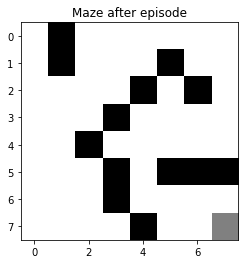

Epoch: 719/999 | Loss: 0.0000 | Episodes: 720 | Win count: 700 | Win rate: 1.000 | time: 1.70 hours
Loss:  0.00017766420205589384
Loss:  0.0003014256581082009
Loss:  0.00018067823839373887
Loss:  6.880540240672417e-05
Loss:  0.00036964887112844735
Loss:  5.981765571050346e-05
Loss:  0.00017788852801459143
Loss:  0.00018759565864456818
Loss:  0.00011836392332043033
Loss:  0.000141323247589753
Loss:  0.000198008754523471
Loss:  0.0002495543158147484
Loss:  5.498678547155578e-05
Loss:  0.00024852876049408223
Loss:  8.126457214530092e-05
Loss:  0.0001577031671331497
Loss:  0.00032449788523081224
Loss:  0.0002920348324551014
Loss:  7.545841617684346e-05
Loss:  5.6130900702555664e-05
Loss:  4.532261118583847e-05
Loss:  3.690138692036271e-05


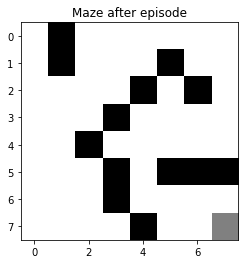

Epoch: 720/999 | Loss: 0.0000 | Episodes: 721 | Win count: 701 | Win rate: 1.000 | time: 1.70 hours
Loss:  0.00032126913720276207
Loss:  0.00016193071496672928
Loss:  9.678720743977465e-05
Loss:  2.5497531169094145e-05
Loss:  0.0002440617827232927
Loss:  1.3913523162045749e-05


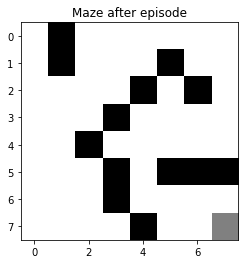

Epoch: 721/999 | Loss: 0.0000 | Episodes: 722 | Win count: 702 | Win rate: 1.000 | time: 1.70 hours
Loss:  0.0002488265345164109
Loss:  0.0003569783875718713
Loss:  7.619843654538272e-05
Loss:  0.00017410764485248365
Loss:  0.00026328728199587204
Loss:  0.00043664487020578235
Loss:  0.00019373161921976134
Loss:  0.00028359440329950303
Loss:  0.00026621420693118125
Loss:  0.00014600095892092213
Loss:  8.901909495762084e-05
Loss:  4.983948929293547e-05
Loss:  0.00018151397580368211
Loss:  7.091739462339319e-05
Loss:  0.0001926009608723689
Loss:  0.00014036238280823454
Loss:  0.0005958722031209618
Loss:  0.00023860829242039472
Loss:  0.00026406359756947495
Loss:  0.0004967705317540094
Loss:  4.232078390487004e-05
Loss:  0.00029337763771764003
Loss:  0.0003364344229339622
Loss:  0.00011234301200602204
Loss:  0.0005986923642922193
Loss:  0.00017035088239936158
Loss:  0.00020036814385093749


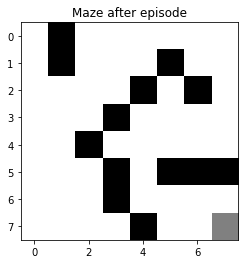

Epoch: 722/999 | Loss: 0.0002 | Episodes: 723 | Win count: 703 | Win rate: 1.000 | time: 1.70 hours
Loss:  0.00021772283798782155
Loss:  0.00017108412066590972
Loss:  0.0002984017337439582
Loss:  0.00011213712605240289
Loss:  0.00015226685354718938
Loss:  4.348988841229584e-05
Loss:  0.0003138364991173148
Loss:  3.661995924630901e-05
Loss:  0.00018973757141793612
Loss:  3.896395537594799e-05
Loss:  0.0001590120600667433
Loss:  2.3526863515144214e-05
Loss:  4.32795422966592e-05
Loss:  0.0002568594936747104
Loss:  0.0002156841364922002
Loss:  2.8001845748804044e-05
Loss:  0.0002056016273854766
Loss:  7.267157707246952e-05
Loss:  0.00019265091395936906
Loss:  5.549866000365e-05


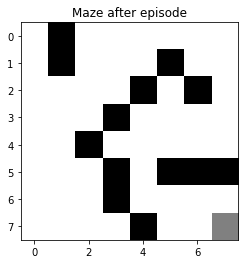

Epoch: 723/999 | Loss: 0.0001 | Episodes: 724 | Win count: 704 | Win rate: 1.000 | time: 1.70 hours
Loss:  0.0001358385525236372
Loss:  7.518291567976121e-05
Loss:  1.604511589903268e-05


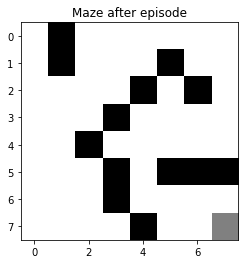

Epoch: 724/999 | Loss: 0.0000 | Episodes: 725 | Win count: 705 | Win rate: 1.000 | time: 1.71 hours
Loss:  7.920398911664961e-05
Loss:  2.5207029466400854e-05
Loss:  0.00012102845357730985
Loss:  1.2539015187940095e-05
Loss:  8.5469438090513e-05
Loss:  0.00019774628162849694
Loss:  4.7430126869585365e-05
Loss:  0.0003459669533185661
Loss:  0.0003313496199552901
Loss:  0.00017095978910219856
Loss:  0.00030686191166751087
Loss:  5.117819364386378e-05
Loss:  0.0002483703210600652
Loss:  0.00011222700049984269
Loss:  0.00030371880438906373
Loss:  2.1554412342084106e-05
Loss:  0.0003311939653940499
Loss:  5.671612234436907e-05
Loss:  0.00010111948358826339
Loss:  0.00041978005901910365
Loss:  0.00026308737142244354
Loss:  0.00046502993791364133
Loss:  0.00017045141794369556
Loss:  0.0005464256246341392
Loss:  0.00016721891006454825
Loss:  8.200775118893944e-05
Loss:  0.00016649409008095972
Loss:  0.0003729425516212359
Loss:  0.00011145976532134227
Loss:  0.00019750774663407356
Loss:  0.0003

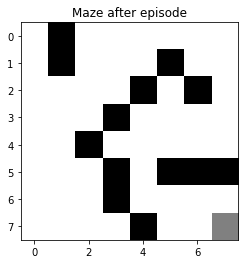

Epoch: 725/999 | Loss: 0.0001 | Episodes: 726 | Win count: 706 | Win rate: 1.000 | time: 1.71 hours
Loss:  0.0002590399672044441
Loss:  0.0004744666221085936
Loss:  0.0004777852154802531
Loss:  4.4340838940115646e-05
Loss:  0.0005650760322168935
Loss:  0.00012854362284997478
Loss:  0.0004431473498698324
Loss:  0.0001868740455392981
Loss:  0.0003419302956899628
Loss:  0.0003057132416870445
Loss:  0.00013156820932636037
Loss:  0.0004937516769132344
Loss:  0.0003244743566028774
Loss:  0.00032926212588790804
Loss:  0.0002596830454422161
Loss:  9.112991210713517e-05
Loss:  8.699268073542044e-05
Loss:  0.000240720524743665
Loss:  0.0006597083556698635
Loss:  0.0005369554128265008
Loss:  0.0002628349611768499
Loss:  0.00035829635453410447
Loss:  4.7517909479211085e-05
Loss:  8.093365795502905e-05


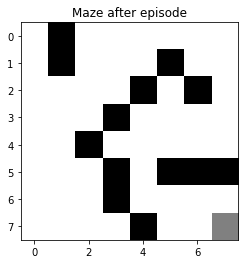

Epoch: 726/999 | Loss: 0.0001 | Episodes: 727 | Win count: 707 | Win rate: 1.000 | time: 1.71 hours
Loss:  3.129065771645401e-05
Loss:  0.0002411414316156879
Loss:  0.00047368589002871886
Loss:  0.0002085839441861026
Loss:  0.0003955871070502326
Loss:  0.000653398223221302
Loss:  0.0005767865222878754
Loss:  9.011356451082975e-05
Loss:  0.0003457558195805177
Loss:  0.0002885641442844644
Loss:  0.00023193600645754486
Loss:  0.00022259224351728335
Loss:  0.0005239612510195002
Loss:  7.855965304770507e-05
Loss:  0.0001979822845896706
Loss:  0.0003105440791841829
Loss:  0.0002283254489157116
Loss:  0.00011785536116803996
Loss:  0.00036970914516132325
Loss:  0.00046370012751140166
Loss:  0.00048465823056176305
Loss:  0.0002643949737830553
Loss:  0.0003201260551577434
Loss:  0.00023365185188595206
Loss:  0.0001873505179901258
Loss:  0.000500029229442589
Loss:  0.000130086911667604
Loss:  0.00010152473805646878
Loss:  0.00039579669828526676
Loss:  0.0002921872182923835
Loss:  0.00031063062488

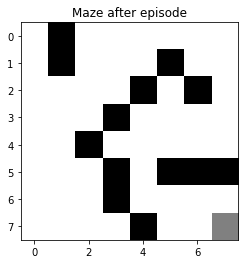

Epoch: 727/999 | Loss: 0.0003 | Episodes: 728 | Win count: 708 | Win rate: 1.000 | time: 1.71 hours
Loss:  0.0002667620465217624
Loss:  0.000468353828182444
Loss:  0.00034876135759986937
Loss:  7.124748844944406e-05
Loss:  0.0003029417712241411
Loss:  0.0003273246838944033
Loss:  7.968189675011672e-05
Loss:  9.669429891800974e-05
Loss:  0.00017039909653249197
Loss:  0.0003952626429963857
Loss:  4.650265327654779e-05
Loss:  0.0004472180880839005
Loss:  0.0005693134298780933
Loss:  0.0003713658079504967
Loss:  5.476597652886994e-05
Loss:  0.0001487843783252174
Loss:  5.1223951231804676e-05
Loss:  0.0003407748881727457
Loss:  5.022810546506662e-05
Loss:  0.00040396719123236835
Loss:  0.0005481988191604614
Loss:  0.000282340119156288
Loss:  0.00019446654005150776
Loss:  0.0003539429453667253
Loss:  0.0003784194268519059


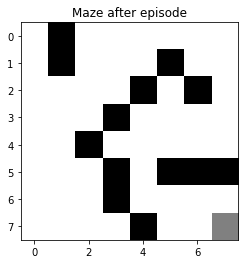

Epoch: 728/999 | Loss: 0.0004 | Episodes: 729 | Win count: 709 | Win rate: 1.000 | time: 1.72 hours
Loss:  0.00020237554235791322
Loss:  5.313021938491147e-05
Loss:  2.6396739485790022e-05
Loss:  2.8512195058283396e-05
Loss:  0.00017550640041008592
Loss:  4.559440458251629e-05
Loss:  3.636355722846929e-05
Loss:  0.000409604785090778
Loss:  5.727055395254865e-05
Loss:  0.00024218619728344493
Loss:  0.0006187986000441015
Loss:  0.00021608171664411202
Loss:  0.00038819203473394737
Loss:  0.00017371131252730265
Loss:  0.00018538085896580014
Loss:  2.115086499543395e-05
Loss:  0.0003730242169694975
Loss:  4.480731422518147e-05
Loss:  2.3348723516392056e-05
Loss:  0.0003486061032162979
Loss:  0.00014042372276890092
Loss:  0.00022067072495701723
Loss:  0.00024895424576243386
Loss:  7.593960617668927e-05
Loss:  0.00015670081666030455
Loss:  0.0003423433954594657
Loss:  0.00018487008492229506
Loss:  0.0002219701163994614
Loss:  0.00019436518050497398
Loss:  9.17108864086913e-05
Loss:  0.0001941

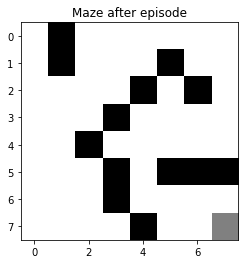

Epoch: 729/999 | Loss: 0.0002 | Episodes: 730 | Win count: 710 | Win rate: 1.000 | time: 1.72 hours
Loss:  6.485536687250715e-05
Loss:  0.0001769436366885202
Loss:  0.0003404553317523096
Loss:  0.00018371045007370412
Loss:  9.856858378043398e-05
Loss:  0.00017012039461405948
Loss:  0.00017961735102289822
Loss:  0.00012140801845816895
Loss:  0.0004939468126394786
Loss:  0.0002526457319618203
Loss:  4.4391121264197864e-05
Loss:  0.00013157091052562464
Loss:  0.00034238016814924777
Loss:  2.693278838705737e-05
Loss:  3.939885937143117e-05
Loss:  2.103458155033877e-05
Loss:  0.00021213806758169085
Loss:  0.00035749905509874225
Loss:  0.00022219733546080533
Loss:  0.0003003819801961072
Loss:  0.0001241809623024892


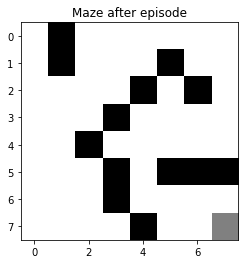

Epoch: 730/999 | Loss: 0.0001 | Episodes: 731 | Win count: 711 | Win rate: 1.000 | time: 1.72 hours
Loss:  0.0002572365847299807
Loss:  0.00012822091957787052
Loss:  0.00019820078159682453
Loss:  0.0002124113671015948
Loss:  0.0004469413834158331
Loss:  2.9701471248699818e-05
Loss:  0.0001917526860779617
Loss:  0.00020241741367499344
Loss:  0.00019411009634495713
Loss:  0.000320020888466388
Loss:  0.0001664524788793642
Loss:  0.00021334612756618299
Loss:  2.7399713872000575e-05
Loss:  0.00035675941762747243
Loss:  9.496332677372266e-05
Loss:  0.00025038994863280095
Loss:  0.00048667725059203804
Loss:  0.0002076733835565392
Loss:  0.000498720593895996
Loss:  5.750703985540895e-05
Loss:  0.00017576264872332104


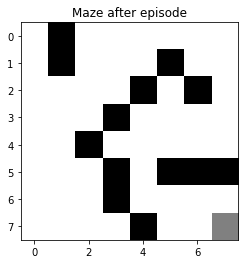

Epoch: 731/999 | Loss: 0.0002 | Episodes: 732 | Win count: 712 | Win rate: 1.000 | time: 1.72 hours
Loss:  0.0005309999542078003
Loss:  7.263671795953996e-05
Loss:  0.00010978479986079037
Loss:  2.0570369088090956e-05
Loss:  0.00031803396632312797
Loss:  0.00019454960056464188
Loss:  0.00021261453366605565
Loss:  7.048813677101862e-05
Loss:  7.62708605179796e-05
Loss:  0.0002056764242297504


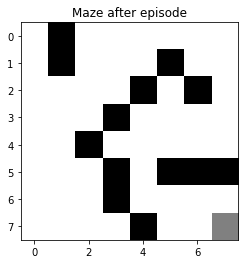

Epoch: 732/999 | Loss: 0.0002 | Episodes: 733 | Win count: 713 | Win rate: 1.000 | time: 1.72 hours
Loss:  0.0003321029962535249
Loss:  0.00012738428631564602
Loss:  7.20161215213011e-05
Loss:  0.00014758399356651353
Loss:  8.274765423266217e-05
Loss:  0.0001380831454298459
Loss:  0.0003745114372577518
Loss:  0.0001827564301493112
Loss:  0.000351214170223102
Loss:  0.00024556937569286674
Loss:  0.0001836913088482106
Loss:  0.0003182738437317312
Loss:  0.0002395651645201724
Loss:  0.00034170706931035966
Loss:  0.0003429103671805933


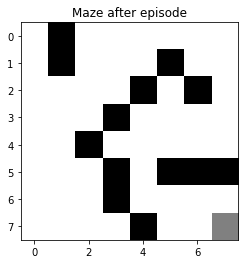

Epoch: 733/999 | Loss: 0.0003 | Episodes: 734 | Win count: 714 | Win rate: 1.000 | time: 1.72 hours
Loss:  4.0377430195803754e-05
Loss:  0.00018988553529197816
Loss:  0.0002889266761485487
Loss:  3.131992161797825e-05
Loss:  3.8607024180237204e-05
Loss:  0.00035356658554519527
Loss:  3.013536388607463e-05
Loss:  8.370698560611345e-05
Loss:  1.59905443979369e-05
Loss:  0.00017872891112347133
Loss:  0.0003130542754661292
Loss:  0.000165651803399669
Loss:  5.2705408961628564e-05
Loss:  0.00018060329421132337
Loss:  3.4968683394254185e-05
Loss:  3.979187977165566e-05
Loss:  0.0001730570747895399
Loss:  0.0002148544299416244
Loss:  0.0001763743721312494
Loss:  0.00018331701357965358
Loss:  9.952685104508419e-05
Loss:  0.00034089483960997313
Loss:  0.00016519524979230482
Loss:  0.00023069486633175984


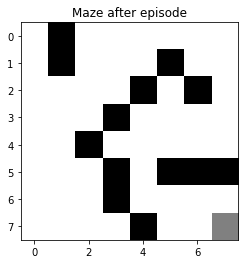

Epoch: 734/999 | Loss: 0.0002 | Episodes: 735 | Win count: 715 | Win rate: 1.000 | time: 1.73 hours
Loss:  0.0001786314714991022
Loss:  0.00018177424135501496
Loss:  6.51257942081429e-05
Loss:  4.731802073365543e-05
Loss:  0.0006302305846475065
Loss:  6.514377128041815e-05
Loss:  6.098963422118686e-05
Loss:  6.30259710305836e-05
Loss:  0.00020323523676779587
Loss:  2.0594016859831754e-05
Loss:  0.00021947201639704872
Loss:  0.0004275668688933365
Loss:  2.4243162442871835e-05
Loss:  0.00031475226569455117
Loss:  0.00019528682059899438
Loss:  0.0002925309963757172
Loss:  0.00012112544573028572
Loss:  0.0002070685222861357
Loss:  0.0003022716009581927
Loss:  6.425742321880534e-05
Loss:  0.00014685119458590634
Loss:  6.264602416194975e-05
Loss:  0.00028662018121394794


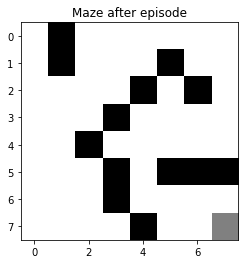

Epoch: 735/999 | Loss: 0.0003 | Episodes: 736 | Win count: 716 | Win rate: 1.000 | time: 1.73 hours
Loss:  0.0002002754990826361
Loss:  0.0002096807656926103
Loss:  0.00010027446478488855
Loss:  7.760260177747114e-05
Loss:  0.00035538949305191636
Loss:  9.155046063824557e-05
Loss:  3.205528810212854e-05
Loss:  0.0003867211489705369
Loss:  0.0002299948209838476
Loss:  0.00022136999541544355
Loss:  0.0005656053544953465
Loss:  0.00010583896073512733
Loss:  0.0001190278198919259
Loss:  5.074310320196673e-05
Loss:  0.00026961779440171085
Loss:  5.453826906887116e-05
Loss:  5.4277001254376955e-05
Loss:  6.322448098217137e-05
Loss:  2.6288076696801e-05


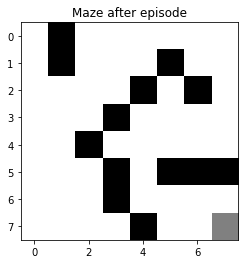

Epoch: 736/999 | Loss: 0.0000 | Episodes: 737 | Win count: 717 | Win rate: 1.000 | time: 1.73 hours
Loss:  1.7451395251555368e-05
Loss:  0.0001770811140886508
Loss:  0.00018500973055779468
Loss:  0.00033047427132260054
Loss:  2.0630830476875417e-05
Loss:  0.0002554375387262553
Loss:  0.00016113229503389448
Loss:  0.0002643623884068802
Loss:  0.000340716855134815
Loss:  3.1123108783503994e-05
Loss:  0.00017515318540972658
Loss:  1.5516347048105672e-05
Loss:  0.00021168123566894792
Loss:  0.00047333079783129506
Loss:  0.00016045779739215504
Loss:  0.00019078716832154896
Loss:  8.913438068702817e-05
Loss:  5.875739770999644e-05
Loss:  1.7822901554609416e-05
Loss:  2.0219912585162092e-05
Loss:  9.015297655423637e-05
Loss:  0.00019500803136907052
Loss:  0.00017662693426245824
Loss:  0.00037475588396773674
Loss:  0.00019867074297508225
Loss:  0.00019381335732759908
Loss:  4.451462700671982e-05
Loss:  0.0003055634588235989
Loss:  3.8234999919950496e-05
Loss:  0.000210042780963704
Loss:  6.639

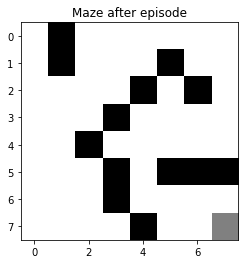

Epoch: 737/999 | Loss: 0.0005 | Episodes: 738 | Win count: 718 | Win rate: 1.000 | time: 1.73 hours
Loss:  0.00035366162774153054
Loss:  0.00035553732595872134
Loss:  0.00021275591279845685
Loss:  5.697926644643303e-05
Loss:  0.00024457330982841086
Loss:  0.0003040148294530809
Loss:  3.5687608033185825e-05
Loss:  0.0001973933249246329
Loss:  0.00020400291577971075
Loss:  0.0003269252192694694
Loss:  9.0401172201382e-05


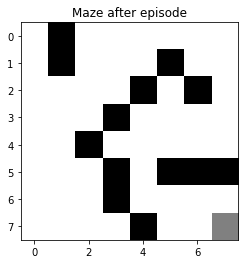

Epoch: 738/999 | Loss: 0.0001 | Episodes: 739 | Win count: 719 | Win rate: 1.000 | time: 1.73 hours
Loss:  0.00016657165360811632
Loss:  3.028546052519232e-05
Loss:  0.00016252935165539384
Loss:  3.444692447374109e-05
Loss:  4.99254301757901e-05


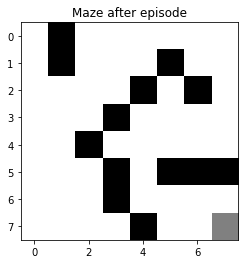

Epoch: 739/999 | Loss: 0.0000 | Episodes: 740 | Win count: 720 | Win rate: 1.000 | time: 1.74 hours
Loss:  0.00021365450447774492
Loss:  0.00024199440667871386
Loss:  4.671204987971578e-05
Loss:  0.00034279633837286383
Loss:  0.00017108396968978923
Loss:  0.00011404328324715607
Loss:  0.0001762870560924057
Loss:  0.0003280778728367295
Loss:  0.00025056934100575745
Loss:  0.00021595240832539275
Loss:  0.00037597905611619353
Loss:  0.00018268392159370705
Loss:  0.00019911652452719864
Loss:  9.59437238634564e-05
Loss:  0.0002260790060972795
Loss:  0.00045249806134961545
Loss:  4.699444252764806e-05
Loss:  0.00019821346177195664
Loss:  0.00019601449457695708
Loss:  0.00031294143991544843
Loss:  0.000268373463768512
Loss:  0.00044502783566713333


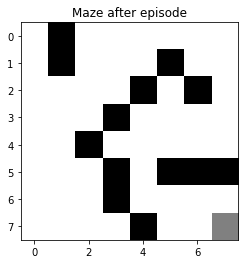

Epoch: 740/999 | Loss: 0.0004 | Episodes: 741 | Win count: 721 | Win rate: 1.000 | time: 1.74 hours
Loss:  2.051561386906542e-05
Loss:  0.0003720166532730218
Loss:  0.00027237331960350275
Loss:  0.0001361166541755665
Loss:  0.0002252906451758463
Loss:  0.0002569500429672189
Loss:  0.00017413164823665284
Loss:  0.00021512075909413397
Loss:  0.00030274593700596597
Loss:  0.00040996153256855905
Loss:  0.0003706736024469137
Loss:  7.72800667618867e-05
Loss:  0.0004996819188818336
Loss:  0.00019183438053005375
Loss:  0.00020601101095962804
Loss:  0.00021380604812293313
Loss:  0.0004487142141442746
Loss:  0.0002690667606657371
Loss:  0.00018576377624412999
Loss:  0.0004980201192665845
Loss:  0.00040697250369703397
Loss:  9.299945668317378e-05
Loss:  0.0001318309805355966
Loss:  0.00014916338568582432
Loss:  0.00030891448841430247
Loss:  0.00026611523935571313
Loss:  0.00019765136676141992
Loss:  0.00027003751893062145
Loss:  0.0004680947313318029
Loss:  0.00021404779545264319
Loss:  0.000336

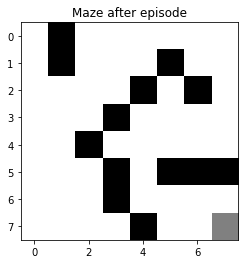

Epoch: 741/999 | Loss: 0.0002 | Episodes: 742 | Win count: 722 | Win rate: 1.000 | time: 1.74 hours
Loss:  0.0001691255638434086
Loss:  0.0002257916348753497
Loss:  0.00037946386146359146
Loss:  0.00010360437590861693
Loss:  0.0001836683259170968
Loss:  0.00019489400983729865
Loss:  5.222351865086239e-05
Loss:  0.0004989177250536159
Loss:  0.0002102708058373537
Loss:  9.54719289438799e-05
Loss:  2.176480666093994e-05


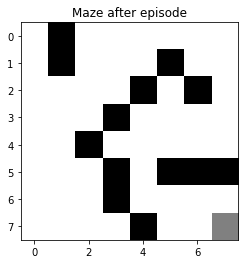

Epoch: 742/999 | Loss: 0.0000 | Episodes: 743 | Win count: 723 | Win rate: 1.000 | time: 1.74 hours
Loss:  6.056060374248773e-05


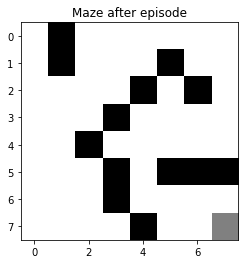

Epoch: 743/999 | Loss: 0.0001 | Episodes: 744 | Win count: 724 | Win rate: 1.000 | time: 1.74 hours
Loss:  0.0005785260000266135
Loss:  0.000208969198865816
Loss:  0.0001966950912901666
Loss:  0.00024314694019267336
Loss:  2.7693426090991125e-05
Loss:  0.00047351625107694417
Loss:  0.0003695208142744377
Loss:  0.00021911868680035695
Loss:  0.0003022405944648199
Loss:  0.00019327889458509162
Loss:  0.00016408634837716818
Loss:  0.00023708237131359056
Loss:  0.0002692041452974081
Loss:  0.00021168601233512163
Loss:  0.00039139729233284015
Loss:  0.0002985182509291917
Loss:  0.00013134613618603908
Loss:  0.000388089451007545
Loss:  0.0006019438151270151
Loss:  0.00011142041330458596
Loss:  0.0004131180758122355
Loss:  0.00023476867499994114
Loss:  0.00040766062738839537
Loss:  0.00043146593088749796
Loss:  4.4627908209804446e-05


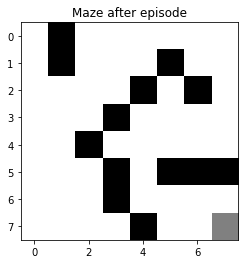

Epoch: 744/999 | Loss: 0.0000 | Episodes: 745 | Win count: 725 | Win rate: 1.000 | time: 1.74 hours
Loss:  0.0003237210294173565
Loss:  0.0003710327437147498
Loss:  0.00020829696586588398
Loss:  3.164431473123841e-05
Loss:  0.00021807876328239217
Loss:  0.0004578563093673438
Loss:  0.00021806306904181838
Loss:  0.0003781647355936002
Loss:  0.00019779584908974357
Loss:  0.00018181353698309977
Loss:  0.00015453087144123856
Loss:  0.0002215274616901297
Loss:  0.000304342995150364
Loss:  0.00043136848762515


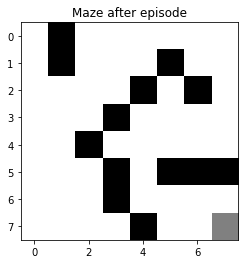

Epoch: 745/999 | Loss: 0.0004 | Episodes: 746 | Win count: 726 | Win rate: 1.000 | time: 1.75 hours
Loss:  0.0001866914735728642
Loss:  0.00026353738212492317
Loss:  0.0003609714658523444
Loss:  0.0001301665242863237
Loss:  0.0002689964749151841
Loss:  0.0004934448807034642
Loss:  0.00024078350543277338
Loss:  0.00017816949912230484
Loss:  7.697268665651791e-05
Loss:  0.0001458641254430404
Loss:  2.0257494725228753e-05
Loss:  0.0005884153506485745
Loss:  4.3152829675818793e-05
Loss:  0.00016056957974797115
Loss:  0.00033563043325557373
Loss:  0.0002103365295624826
Loss:  0.0002946315144072287
Loss:  0.0003561155026545748
Loss:  0.00036551797529682517
Loss:  0.00017066188593162224
Loss:  0.0005183791217859834
Loss:  0.0004092356830369681
Loss:  0.00016016734298318624
Loss:  0.00020380920977913775
Loss:  7.871966226957738e-05
Loss:  3.676795859064441e-05
Loss:  0.0002406737839919515
Loss:  7.92702139733592e-05
Loss:  3.070489492529305e-05
Loss:  0.0003433817073528189


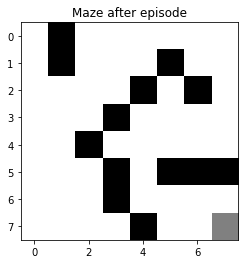

Epoch: 746/999 | Loss: 0.0003 | Episodes: 747 | Win count: 727 | Win rate: 1.000 | time: 1.75 hours
Loss:  0.000213867737329565
Loss:  0.00019371802227396984
Loss:  0.00018058908608509228
Loss:  7.251506031025201e-05
Loss:  0.00028010766982333735
Loss:  0.0004908597766188905
Loss:  0.0002197257344960235
Loss:  0.00021846200615982525
Loss:  0.0002868867159122601
Loss:  0.00030974372202763334
Loss:  4.274032289686147e-05
Loss:  0.0001727693852444645
Loss:  0.00010352020399295725
Loss:  0.00016098381729534594
Loss:  0.00033924554190889467
Loss:  0.00034704420977504924
Loss:  0.0005833353934576735
Loss:  0.0002378384961048141
Loss:  0.00045843592670280486
Loss:  8.076392987277359e-05
Loss:  6.470455446105916e-05
Loss:  0.0003511544709908776
Loss:  0.00023524616335635073
Loss:  0.00037177243211772293
Loss:  0.0002991009496327024
Loss:  0.00017157546972157434
Loss:  0.0001826401858124882
Loss:  0.0004882315988652408


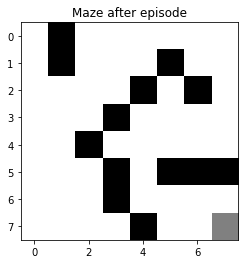

Epoch: 747/999 | Loss: 0.0005 | Episodes: 748 | Win count: 728 | Win rate: 1.000 | time: 1.75 hours
Loss:  0.0005400499794632196
Loss:  0.00042763726378325373
Loss:  0.0001320345254498534
Loss:  0.00016905414668144658
Loss:  0.000522245405591093
Loss:  0.0002375039694015868
Loss:  5.687283010047395e-05
Loss:  0.0005318128678482026
Loss:  0.00024102437600959092
Loss:  0.00048659784079063684
Loss:  0.0003272015310358256
Loss:  0.0002370784422964789
Loss:  0.0005840218509547412
Loss:  5.021346441935748e-05
Loss:  0.00041549617890268564
Loss:  8.157309457601514e-05
Loss:  0.0002779042115435004
Loss:  0.00020617010886780918
Loss:  0.00032033261959441006
Loss:  0.00013817418221151456
Loss:  0.0003333055356051773
Loss:  7.283924787770957e-05
Loss:  0.00019348454952705652
Loss:  0.00035496946020430187
Loss:  0.00018589503451948985


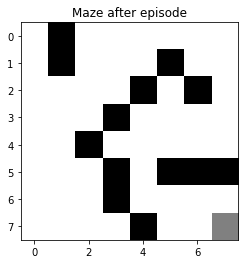

Epoch: 748/999 | Loss: 0.0002 | Episodes: 749 | Win count: 729 | Win rate: 1.000 | time: 1.75 hours
Loss:  0.00029001237999182194
Loss:  0.0002626469358801842
Loss:  0.00033200631878571585


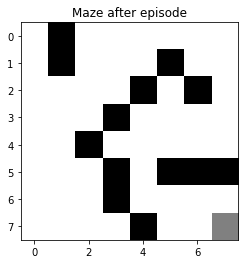

Epoch: 749/999 | Loss: 0.0003 | Episodes: 750 | Win count: 730 | Win rate: 1.000 | time: 1.75 hours
Loss:  0.00023129768305807374
Loss:  0.0001122469111578539
Loss:  0.00020505568318185396
Loss:  0.00028068934625480324
Loss:  0.0003501905230223201


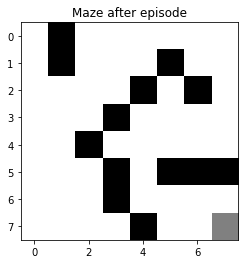

Epoch: 750/999 | Loss: 0.0004 | Episodes: 751 | Win count: 731 | Win rate: 1.000 | time: 1.75 hours
Loss:  4.0153992358682444e-05
Loss:  0.00046646749251522124
Loss:  6.40500493318541e-05
Loss:  0.00017263141307921614
Loss:  0.0002190533487009816


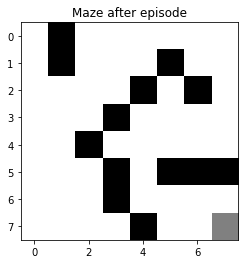

Epoch: 751/999 | Loss: 0.0002 | Episodes: 752 | Win count: 732 | Win rate: 1.000 | time: 1.75 hours
Loss:  0.000381999841920333
Loss:  0.0005665888311341405
Loss:  0.00023879535729065537
Loss:  0.00010460441990289837
Loss:  0.00012092642282368615
Loss:  0.00011556641038623638
Loss:  0.00014766724780201912
Loss:  0.00023941474319144618


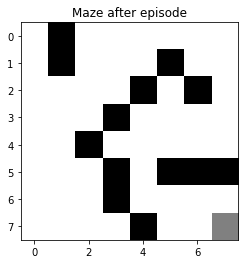

Epoch: 752/999 | Loss: 0.0002 | Episodes: 753 | Win count: 733 | Win rate: 1.000 | time: 1.75 hours
Loss:  0.0002061298564512981
Loss:  0.000469559570774436
Loss:  0.0003992994279542472
Loss:  0.00019770815924857743
Loss:  0.00015680900833103806
Loss:  0.0002526341086195316
Loss:  0.0002290539414389059
Loss:  0.00012905758740089368
Loss:  0.00030558830439986195


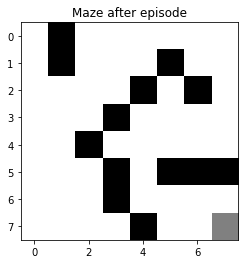

Epoch: 753/999 | Loss: 0.0003 | Episodes: 754 | Win count: 734 | Win rate: 1.000 | time: 1.76 hours
Loss:  4.389957393868826e-05
Loss:  0.0003953892446588725
Loss:  0.00013890465925214812
Loss:  0.0002573999354353873
Loss:  0.000422905693994835
Loss:  6.211663639987819e-05
Loss:  0.00023348348622675985
Loss:  0.0003878513671224937
Loss:  0.00023695376876275986
Loss:  0.0003180416151735699
Loss:  0.0002395122282905504
Loss:  0.0004188214224996045
Loss:  0.000414324073062744
Loss:  2.8422838113328908e-05
Loss:  0.0002866253780666739
Loss:  0.0002650950336828828
Loss:  0.00025514342814858537
Loss:  0.00014006763558427338
Loss:  0.0001715380076348083
Loss:  0.00013479894550982863
Loss:  0.00024159371969290078
Loss:  0.00018363710205449024
Loss:  7.980287773534656e-05
Loss:  0.00028192108766234014
Loss:  0.00033486203028587624


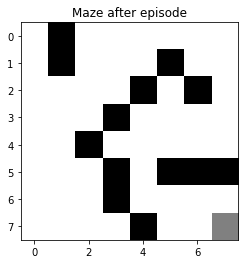

Epoch: 754/999 | Loss: 0.0003 | Episodes: 755 | Win count: 735 | Win rate: 1.000 | time: 1.76 hours
Loss:  0.00048606126802042127
Loss:  0.00022337220434565097
Loss:  0.00014414462930290028
Loss:  0.0002023387023655232
Loss:  0.000203390638489509
Loss:  0.0004359905724413693
Loss:  0.00023872850579209626
Loss:  0.00015420917043229565
Loss:  3.708424264914356e-05
Loss:  0.00019571745360735804
Loss:  0.00027134975971421227
Loss:  0.00012381800115690567
Loss:  0.0002344956956221722
Loss:  0.00017992840184888337
Loss:  0.00013094372843625024
Loss:  0.00011201820780115668
Loss:  0.00042305410897824913
Loss:  3.790606569964439e-05
Loss:  0.00021038226987002417


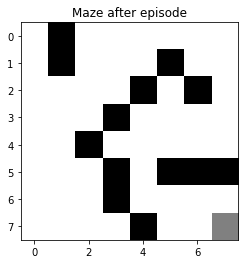

Epoch: 755/999 | Loss: 0.0002 | Episodes: 756 | Win count: 736 | Win rate: 1.000 | time: 1.76 hours
Loss:  0.00017246363313461188


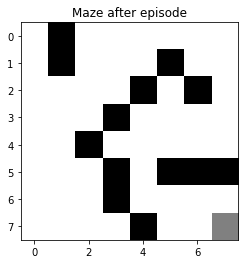

Epoch: 756/999 | Loss: 0.0002 | Episodes: 757 | Win count: 737 | Win rate: 1.000 | time: 1.76 hours
Loss:  1.310977086177445e-05
Loss:  0.00012842237629229203


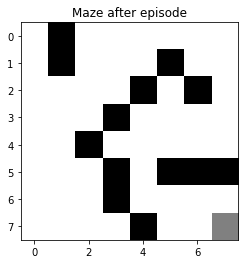

Epoch: 757/999 | Loss: 0.0001 | Episodes: 758 | Win count: 738 | Win rate: 1.000 | time: 1.76 hours
Loss:  0.0001088307581085246
Loss:  5.447343755804468e-05
Loss:  0.00016900544505915605
Loss:  0.00023024687106953934
Loss:  2.0785374545084778e-05
Loss:  0.00011990096663794247
Loss:  4.692923175753094e-05
Loss:  0.00028715917869703844
Loss:  0.00027014064107788727
Loss:  0.0001214870426338166
Loss:  0.0001884002413135022
Loss:  0.0003421987348701805
Loss:  5.997059270157479e-05
Loss:  0.00012420390521583613
Loss:  3.2349633329431526e-05
Loss:  0.00019720209093065932
Loss:  0.0002460292926116381
Loss:  0.0004221562994644046
Loss:  0.00014397328413906507
Loss:  0.00016037119348766282
Loss:  0.0002072714123642072
Loss:  0.00028639832453336567
Loss:  0.00016705804955563508


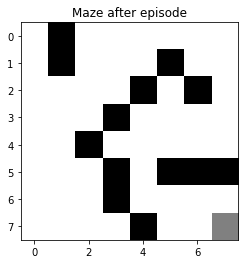

Epoch: 758/999 | Loss: 0.0002 | Episodes: 759 | Win count: 739 | Win rate: 1.000 | time: 1.76 hours
Loss:  9.420188507647254e-05
Loss:  2.805819531204179e-05
Loss:  3.593464771256549e-05
Loss:  4.4459206037572585e-05
Loss:  5.977561704639811e-05
Loss:  0.0002808862027450232
Loss:  0.0005193592514842749
Loss:  0.00018855182133847848
Loss:  0.00029618402186315507
Loss:  0.000122404788271524
Loss:  0.0003686653290060349
Loss:  0.00022478251412394457
Loss:  4.15151625929866e-05
Loss:  0.00012942011744598858
Loss:  2.9308375815162435e-05
Loss:  0.0005040996475145221
Loss:  0.00010788631698233075
Loss:  5.39421453140676e-05
Loss:  0.0001285112120967824
Loss:  8.500279000145383e-05
Loss:  0.000376074698579032
Loss:  0.00038723970646969974
Loss:  4.353423264547018e-05
Loss:  2.9694566364923958e-05
Loss:  9.366652375319973e-05
Loss:  0.0003590963897295296
Loss:  0.00010094244953506859


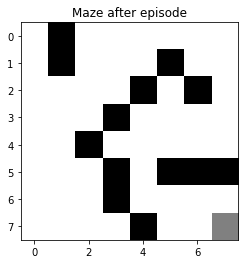

Epoch: 759/999 | Loss: 0.0001 | Episodes: 760 | Win count: 740 | Win rate: 1.000 | time: 1.76 hours
Loss:  0.00033370566234225407
Loss:  0.0001096630840038415
Loss:  0.00022283689759206027
Loss:  3.6980703043809626e-05
Loss:  0.0001229473164130468
Loss:  0.00024210935043811332
Loss:  0.0002301395797985606
Loss:  0.0002720345146371983
Loss:  0.00023905429407022893
Loss:  0.00018965355047839694
Loss:  9.430114550923463e-05
Loss:  0.0002009706622629892
Loss:  0.0003198325139237568
Loss:  0.0004006688905064948
Loss:  0.0002418274962110445
Loss:  7.95297837612452e-05
Loss:  0.00025949787232093513
Loss:  3.071399351028958e-05
Loss:  2.2428086595027708e-05
Loss:  1.7137838767666835e-05
Loss:  7.111417653504759e-05
Loss:  3.3239834920095745e-05
Loss:  0.0003541231417329982
Loss:  0.0002493239153409377
Loss:  0.00020323943317634985
Loss:  7.642372656846419e-05
Loss:  0.0002103547903971048
Loss:  0.0003635355969890952
Loss:  0.0002195446395489853


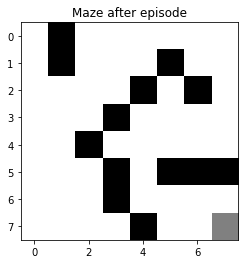

Epoch: 760/999 | Loss: 0.0002 | Episodes: 761 | Win count: 741 | Win rate: 1.000 | time: 1.77 hours
Loss:  9.748837874212768e-05
Loss:  0.0002445714344503358
Loss:  0.00018674444800126366
Loss:  0.0003262632562837098
Loss:  5.521007733477745e-05
Loss:  0.000537300860742107


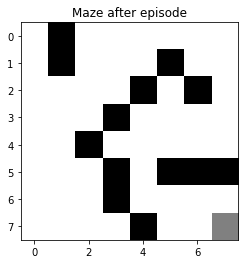

Epoch: 761/999 | Loss: 0.0005 | Episodes: 762 | Win count: 742 | Win rate: 1.000 | time: 1.77 hours
Loss:  0.00019283615620224737
Loss:  0.00020157037579338066
Loss:  0.0001941512746270746
Loss:  6.561531336046755e-05
Loss:  5.6375305575784296e-05
Loss:  0.00026197238184977323
Loss:  0.00018502951570553705
Loss:  0.00019319205421197694


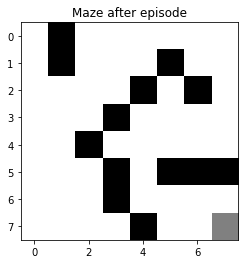

Epoch: 762/999 | Loss: 0.0002 | Episodes: 763 | Win count: 743 | Win rate: 1.000 | time: 1.77 hours
Loss:  0.00014064304195926525
Loss:  0.00019438050549069885
Loss:  0.0001919995356729487
Loss:  0.0005536595272133127
Loss:  0.0002218288318545092
Loss:  4.454962436284404e-05
Loss:  0.0002732910288614221
Loss:  4.6639470383524895e-05
Loss:  6.440306060540024e-05
Loss:  0.00016176791632460663
Loss:  0.00010313458551536314
Loss:  0.00033853298373287544
Loss:  0.00046538781862182077
Loss:  0.0005409397563198581
Loss:  0.00039529267814941704
Loss:  0.00021454835950862616


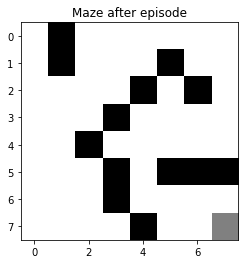

Epoch: 763/999 | Loss: 0.0002 | Episodes: 764 | Win count: 744 | Win rate: 1.000 | time: 1.77 hours
Loss:  0.00022601732052862644
Loss:  5.279707693262026e-05
Loss:  0.0002873756384360604
Loss:  0.0003256554628023878
Loss:  0.00020777165991603397
Loss:  0.00024935914552770555
Loss:  0.0003724778289324604
Loss:  0.00044345157220959663
Loss:  0.0002473988715792075


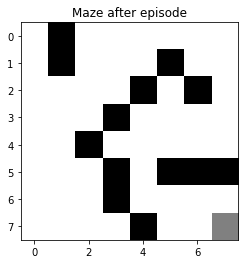

Epoch: 764/999 | Loss: 0.0002 | Episodes: 765 | Win count: 745 | Win rate: 1.000 | time: 1.77 hours
Loss:  7.558456854894757e-05
Loss:  0.00011839685976156034
Loss:  0.00012868970770796295
Loss:  0.00042797553760465235
Loss:  3.5770450267591514e-05
Loss:  7.554888725280762e-05
Loss:  0.00024424817092949525
Loss:  0.0006491929307230748
Loss:  0.0002700710465433076
Loss:  8.117048491840251e-05


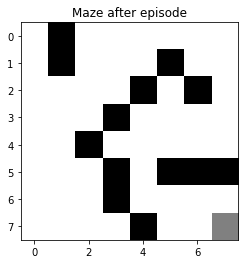

Epoch: 765/999 | Loss: 0.0001 | Episodes: 766 | Win count: 746 | Win rate: 1.000 | time: 1.77 hours
Loss:  0.0003587290702853352
Loss:  0.0002155333713744767
Loss:  0.00020236490672687069
Loss:  0.0002597945276647806
Loss:  0.00037444660847540945
Loss:  0.0003456385493336711
Loss:  0.00031836335256230086
Loss:  0.0002339968050364405
Loss:  0.00033562449243618175
Loss:  0.00018465672201273264
Loss:  0.00041528324072714895
Loss:  0.0005270093097351491
Loss:  0.00030864121799822897
Loss:  0.0006740042736055329
Loss:  0.00030039162083994597
Loss:  0.00021767219004686922
Loss:  4.706543586507905e-05
Loss:  0.00024550551461288705
Loss:  0.0005171738739591092
Loss:  0.0002643016050569713
Loss:  0.0003220427970518358
Loss:  0.00018449950221111067
Loss:  6.39373974991031e-05
Loss:  5.5847571275080554e-05
Loss:  0.00013561092055169865
Loss:  0.00037461296960827895
Loss:  0.0004389697787701152
Loss:  0.00010480909986654297
Loss:  4.005906157544814e-05
Loss:  0.0002897518497775309
Loss:  0.0003469

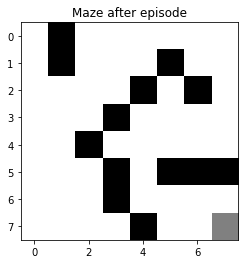

Epoch: 766/999 | Loss: 0.0002 | Episodes: 767 | Win count: 747 | Win rate: 1.000 | time: 1.77 hours
Loss:  0.0006064375920686871
Loss:  0.00041225676250178367
Loss:  0.00031989302078727633
Loss:  0.00013750631478615105
Loss:  0.00029616302344948053
Loss:  0.0002505470474716276
Loss:  0.0004667285975301638
Loss:  0.00022218549565877765
Loss:  0.00023110233451006934
Loss:  0.0001002675635390915
Loss:  5.307750870997552e-05
Loss:  0.0002951218921225518
Loss:  0.0006761873373761773
Loss:  0.000564486748771742
Loss:  0.0004359174854471348
Loss:  0.0003745269787032157
Loss:  0.00030777836218476295
Loss:  0.000276313421636587
Loss:  0.00037278421950759366
Loss:  0.00010155569543712772
Loss:  0.0005466087313834578
Loss:  0.0006061973399482667
Loss:  0.0007260163692990318
Loss:  0.00027033536389353685
Loss:  0.00013232146739028394
Loss:  0.00039469396870117635
Loss:  0.00023148400214267895
Loss:  0.0004978055785613833
Loss:  0.0001662098320593941
Loss:  0.0004003873764304444
Loss:  0.0002847706

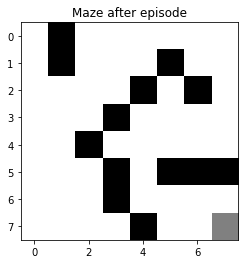

Epoch: 767/999 | Loss: 0.0003 | Episodes: 768 | Win count: 748 | Win rate: 1.000 | time: 1.78 hours
Loss:  0.00026100192189915106
Loss:  3.757152444450185e-05
Loss:  0.00032152122003026307
Loss:  0.0003416482068132609
Loss:  0.00017502889204479288
Loss:  0.00019606689602369443
Loss:  0.0004546386771835387
Loss:  0.00018291016021976247
Loss:  2.9625835850310978e-05
Loss:  0.00016779865109128878
Loss:  0.00036313882446847856
Loss:  0.0003021492375410162
Loss:  0.00037741347841802053
Loss:  6.265733827603981e-05
Loss:  0.00011220420128665864
Loss:  5.004580361855915e-05
Loss:  0.00035557699447963387
Loss:  2.166782542190049e-05
Loss:  3.544548962963745e-05
Loss:  1.1749966233765008e-05
Loss:  3.510005262796767e-05
Loss:  0.0005598377902060747
Loss:  0.00019116429757559672
Loss:  0.00038332061376422644
Loss:  0.00012212908677611267
Loss:  0.0004988565051462501
Loss:  0.00023692563627264462
Loss:  0.00022244341380428523
Loss:  0.00014567567632184364


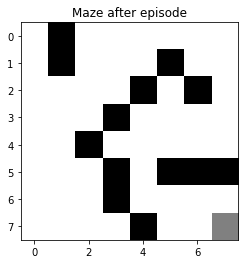

Epoch: 768/999 | Loss: 0.0001 | Episodes: 769 | Win count: 749 | Win rate: 1.000 | time: 1.78 hours
Loss:  0.00021111936985107604
Loss:  0.00013176498760003597
Loss:  0.00014636504783993587
Loss:  0.0002119438286172226
Loss:  0.00033919668931048363
Loss:  0.0005618316063191742
Loss:  0.00012674073877860792
Loss:  0.000339567573973909
Loss:  0.0002792327359202318
Loss:  6.787268648622558e-05
Loss:  5.385999247664586e-05
Loss:  0.0003031262313015759
Loss:  0.00022028199236956425
Loss:  0.00013969271094538271
Loss:  0.00024405080876022112
Loss:  0.00040944787906482816
Loss:  0.0003817443284788169
Loss:  0.00034467292425688356
Loss:  0.0001283630626858212
Loss:  0.0003865486360155046
Loss:  2.299719835718861e-05
Loss:  0.0006602516514249146
Loss:  0.00029140149854356423
Loss:  0.00047842929780017585
Loss:  0.00022487290698336437
Loss:  0.0002405520062893629
Loss:  0.0003372457140358165
Loss:  6.891953853482846e-05
Loss:  0.0003228410496376455
Loss:  0.0003144308393530082
Loss:  0.000430615

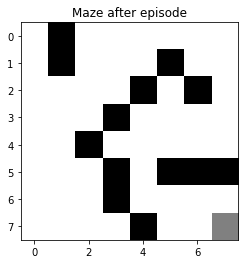

Epoch: 769/999 | Loss: 0.0002 | Episodes: 770 | Win count: 750 | Win rate: 1.000 | time: 1.78 hours
Loss:  0.00026158866603509523
Loss:  0.0006602959911106154
Loss:  0.00027028057229472324
Loss:  0.00036114759859628975
Loss:  0.0002536486354074441
Loss:  5.256921940599568e-05
Loss:  0.00018936465130536817
Loss:  0.0003379857989784796
Loss:  8.377573431062046e-05
Loss:  0.0007144059927668422
Loss:  0.00021091740927658975
Loss:  0.000425844918936491
Loss:  0.00029827234175172634
Loss:  4.9314386160403956e-05
Loss:  0.000336933160724584
Loss:  0.0006185537204146385
Loss:  0.00021723371901316568
Loss:  0.00015106366845429875
Loss:  0.0002119923592545092
Loss:  2.871332435461227e-05
Loss:  0.00043956142326351255
Loss:  0.00037086829979671165
Loss:  0.0006368863978423178
Loss:  0.0003464852743491065
Loss:  0.0004120901721762493
Loss:  0.00020873682660749182


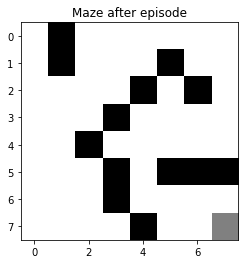

Epoch: 770/999 | Loss: 0.0002 | Episodes: 771 | Win count: 751 | Win rate: 1.000 | time: 1.79 hours
Loss:  0.00027750563458539546
Loss:  0.0003195656172465533
Loss:  0.0003955310385208577
Loss:  0.00044870275451103225
Loss:  0.000550362266949378
Loss:  0.0004184233257547021
Loss:  8.28119445941411e-05
Loss:  0.00043177141924388707
Loss:  0.00012590072583407164
Loss:  8.7227817857638e-05
Loss:  4.1419261833652854e-05
Loss:  0.00022429427917813882
Loss:  0.0005184057081351057
Loss:  4.536568667390384e-05
Loss:  3.452660075708991e-05
Loss:  0.0005634348490275443
Loss:  0.00030738355417270213
Loss:  0.00038839284752612
Loss:  0.0004520831134868786
Loss:  0.0004208540922263637
Loss:  0.0002451774271321483
Loss:  0.0003215697797713801
Loss:  0.0003966554213548079


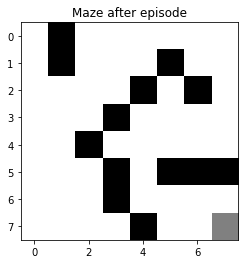

Epoch: 771/999 | Loss: 0.0004 | Episodes: 772 | Win count: 752 | Win rate: 1.000 | time: 1.79 hours
Loss:  0.00032092946639750153
Loss:  0.00044202696881257
Loss:  0.00021739707153756171
Loss:  0.0002002623150474392
Loss:  0.0003813661642197985
Loss:  7.280975114554167e-05
Loss:  0.0005156153638381511


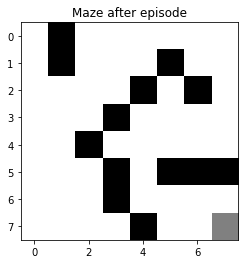

Epoch: 772/999 | Loss: 0.0005 | Episodes: 773 | Win count: 753 | Win rate: 1.000 | time: 1.79 hours
Loss:  0.00020097124070161954
Loss:  0.000319920654874295
Loss:  0.0001626197263249196
Loss:  0.00027191024855710566
Loss:  0.00018765444838209078
Loss:  0.00016991948905342724
Loss:  0.0005130201607244089
Loss:  0.0007043916557449847


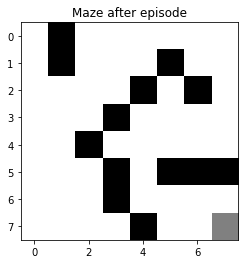

Epoch: 773/999 | Loss: 0.0007 | Episodes: 774 | Win count: 754 | Win rate: 1.000 | time: 1.79 hours
Loss:  5.3149058658163995e-05
Loss:  0.0003765806650335435
Loss:  0.00029928878029750194
Loss:  0.00032408550032414496
Loss:  0.0004651614581234753
Loss:  0.00034004883491434157


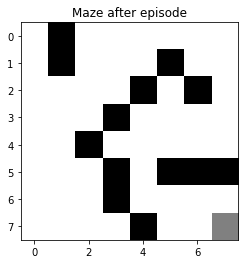

Epoch: 774/999 | Loss: 0.0003 | Episodes: 775 | Win count: 755 | Win rate: 1.000 | time: 1.79 hours
Loss:  0.0002142267840099521
Loss:  0.0002660806494532153
Loss:  7.868415559642017e-05
Loss:  0.00016068253171397373
Loss:  0.00030659428739454597
Loss:  6.277364991547074e-05
Loss:  0.00031587334524374455
Loss:  0.00015331942995544523
Loss:  0.00027364103152649477
Loss:  0.0005093910222058184
Loss:  0.000251095429121051
Loss:  0.0003376344684511423
Loss:  0.00025331224605906755
Loss:  0.0002759726812655572
Loss:  8.799403440207243e-05
Loss:  0.0003708590811584145
Loss:  0.0004338469880167395
Loss:  0.00041537680226610973
Loss:  0.00012001345749013126
Loss:  0.00028692299383692443
Loss:  0.00019568858260754496
Loss:  0.00041231867362512276


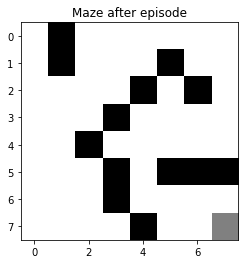

Epoch: 775/999 | Loss: 0.0004 | Episodes: 776 | Win count: 756 | Win rate: 1.000 | time: 1.79 hours
Loss:  8.574512685299851e-05
Loss:  0.0002607797578093596
Loss:  0.0005285439256113023
Loss:  0.00039091052531148307
Loss:  0.000288078939775005
Loss:  0.0004528202407527715
Loss:  0.0002446204671286978
Loss:  0.00027326915005687624
Loss:  0.0003388432087376714


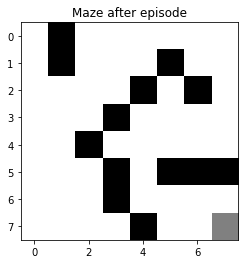

Epoch: 776/999 | Loss: 0.0003 | Episodes: 777 | Win count: 757 | Win rate: 1.000 | time: 1.79 hours
Loss:  0.00037471341056516394
Loss:  0.00041470049472991377
Loss:  3.9846476283855736e-05
Loss:  0.0001964013554243138
Loss:  0.00022938592792343115
Loss:  0.0003926089593733195
Loss:  0.0005353805463528261
Loss:  0.0001709861244307831
Loss:  7.456193270627409e-05
Loss:  0.00018222900689579546
Loss:  0.00018905539764091372
Loss:  0.00045516627142205834
Loss:  0.00030038288969080895
Loss:  0.00030961373704485595
Loss:  0.00021616361846099608
Loss:  0.0002577245468273759
Loss:  8.234952110797167e-05
Loss:  0.00019564235117286444
Loss:  0.00022561648074770346
Loss:  0.00012442383012967184
Loss:  0.0002769230995909311
Loss:  0.0004067911795573309
Loss:  0.00026716476713772863


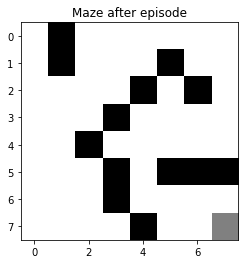

Epoch: 777/999 | Loss: 0.0003 | Episodes: 778 | Win count: 758 | Win rate: 1.000 | time: 1.79 hours
Loss:  0.0004895462043350562
Loss:  0.0005983776209177449
Loss:  0.00020181208856229205
Loss:  0.0005386258562793955
Loss:  0.0006416027317754924
Loss:  0.00038363107159966603
Loss:  0.0004167908482486382
Loss:  0.000401573910494335
Loss:  0.0002616608835523948
Loss:  0.0005514805961865932
Loss:  0.00033522430749144405
Loss:  9.689256148703862e-05
Loss:  0.0002037717385974247
Loss:  0.0005397206550696865
Loss:  0.0004344976259744726
Loss:  0.0004719364151242189
Loss:  0.0002489116905053379
Loss:  0.00033771985908970237
Loss:  0.0002703498430491891
Loss:  0.00020111621415708214
Loss:  0.0003809119662037119
Loss:  0.00036802725480811205
Loss:  0.0004582149558700621
Loss:  0.0002524399205867667
Loss:  0.0003985439834650606


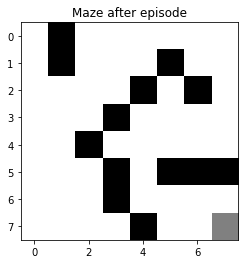

Epoch: 778/999 | Loss: 0.0004 | Episodes: 779 | Win count: 759 | Win rate: 1.000 | time: 1.80 hours
Loss:  0.00014824673053226434
Loss:  0.00028087762620998546
Loss:  0.00023578761465614662
Loss:  0.0002547252006479539
Loss:  0.0003052617539651692
Loss:  0.0005688726087100804
Loss:  0.00010864216528716497
Loss:  9.126987970375922e-05
Loss:  7.507192276534624e-05
Loss:  0.000546120703802444
Loss:  0.00023869930009823292


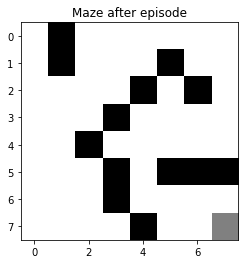

Epoch: 779/999 | Loss: 0.0002 | Episodes: 780 | Win count: 760 | Win rate: 1.000 | time: 1.80 hours
Loss:  0.00023576786770718172
Loss:  0.0003149949334328994
Loss:  0.0002917144593084231
Loss:  0.0004083001986145973
Loss:  0.0003767147572943941
Loss:  0.00039175125129986554
Loss:  0.00036298153645475395
Loss:  0.0004862883943133056
Loss:  0.00039385554555337876
Loss:  0.0005628291037282906
Loss:  0.00023895099002402276
Loss:  0.00027433987270342186
Loss:  0.0005532833529287018
Loss:  0.00040357178659178317
Loss:  0.0004531867743935436
Loss:  8.993357550934888e-05
Loss:  0.00021741941964137368
Loss:  0.0006842616421636194
Loss:  0.0004000986518803984
Loss:  0.0004098169883945957
Loss:  0.0005471865879371762
Loss:  5.4625757911708206e-05
Loss:  0.0005199556762818247
Loss:  9.338337440567557e-05
Loss:  0.00012785055878339335
Loss:  0.0006253343017306179
Loss:  0.00033529401844134554
Loss:  0.00022178124345373362
Loss:  0.0003679533219838049
Loss:  0.0004010135598946363
Loss:  0.000855856

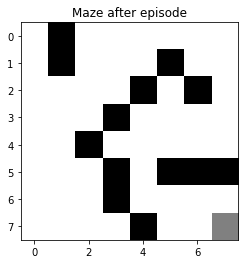

Epoch: 780/999 | Loss: 0.0004 | Episodes: 781 | Win count: 761 | Win rate: 1.000 | time: 1.80 hours
Loss:  0.00032629934867145494
Loss:  0.0002864132766262628


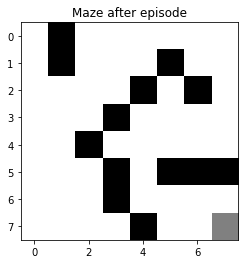

Epoch: 781/999 | Loss: 0.0003 | Episodes: 782 | Win count: 762 | Win rate: 1.000 | time: 1.80 hours
Loss:  0.0001004314672172768
Loss:  0.0003537596421665512
Loss:  0.00025108166300924495
Loss:  0.000436121437815018
Loss:  0.00048804519610712305
Loss:  0.0006353505013976246
Loss:  0.00029066880961181596
Loss:  0.0003704751579789445
Loss:  0.0007332282839342952
Loss:  0.000947733351495117
Loss:  0.0006184364610817283
Loss:  0.0005104838783154264
Loss:  0.0003408162738196552
Loss:  0.00043179720523767173
Loss:  0.0005915785295655951
Loss:  0.0003157518367515877
Loss:  0.00015375567454611883
Loss:  0.0004602933295245748


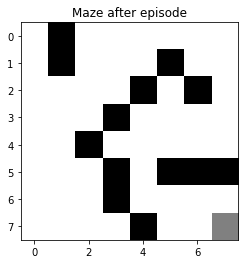

Epoch: 782/999 | Loss: 0.0005 | Episodes: 783 | Win count: 763 | Win rate: 1.000 | time: 1.80 hours
Loss:  0.0004885261150775477
Loss:  0.0001954283688974101
Loss:  0.00032814961741678417
Loss:  0.000494036270538345
Loss:  0.0004847164309467189
Loss:  0.0006756434158887714
Loss:  0.0002202729883720167
Loss:  0.00025654875207692385
Loss:  0.0006866922485642135
Loss:  0.00047981846728362143
Loss:  0.0006101749022491276
Loss:  0.0006828403566032648
Loss:  0.0005142307709320448
Loss:  0.00043236945930402726
Loss:  0.0006128342065494508
Loss:  0.0004965289554093033
Loss:  0.0002257389060105197
Loss:  0.0007158335065469146
Loss:  0.00027246637182543054
Loss:  0.0008275859581772238
Loss:  0.00028320978162810206
Loss:  0.00028057885356247425
Loss:  0.00022361202172760386
Loss:  0.00031901864713290706
Loss:  0.00011948672909056768
Loss:  0.00014654057667939924


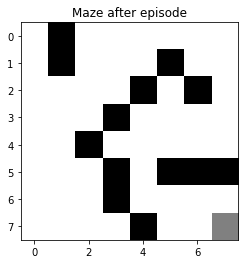

Epoch: 783/999 | Loss: 0.0001 | Episodes: 784 | Win count: 764 | Win rate: 1.000 | time: 1.81 hours
Loss:  0.00013122191012371331
Loss:  0.00023048487128107809
Loss:  0.00024221633793786168


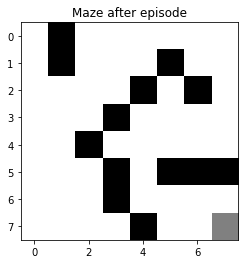

Epoch: 784/999 | Loss: 0.0002 | Episodes: 785 | Win count: 765 | Win rate: 1.000 | time: 1.81 hours
Loss:  0.0003510528622427955
Loss:  0.00036568427458405495
Loss:  0.0003447911876719445
Loss:  0.0005264138744678348


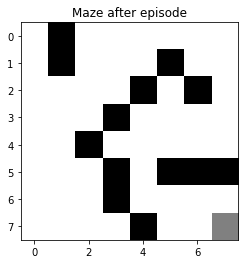

Epoch: 785/999 | Loss: 0.0005 | Episodes: 786 | Win count: 766 | Win rate: 1.000 | time: 1.81 hours
Loss:  0.0003632960288086906
Loss:  0.0002775257016764954
Loss:  0.00038758454320486635
Loss:  0.00036965939580113627
Loss:  0.00030361692188307643
Loss:  0.00036452926724450663
Loss:  0.0004131998502998613
Loss:  0.0009560718899592757
Loss:  0.0007086782134138048
Loss:  0.0005088252073619515
Loss:  0.0004780077433679253
Loss:  0.0004901319261989556
Loss:  0.0006047375209163874
Loss:  0.0009586053201928735
Loss:  0.0006563990609720349
Loss:  0.0002879417334042955
Loss:  0.00044273267849348485
Loss:  0.0006846233736723661
Loss:  0.0006189165578689426
Loss:  0.000818959844764322
Loss:  0.00029518337396439165
Loss:  0.0005879109667148441
Loss:  0.0004750129592139274
Loss:  0.0006016153492964804
Loss:  0.0005143350863363594
Loss:  0.0001904728742374573
Loss:  0.0005061635747551918
Loss:  0.0007828879170119762
Loss:  0.0009264302207157016
Loss:  0.0007363424520008266
Loss:  0.0006484522309619

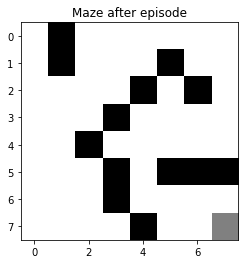

Epoch: 786/999 | Loss: 0.0006 | Episodes: 787 | Win count: 767 | Win rate: 1.000 | time: 1.81 hours
Loss:  0.0004364831402199343
Loss:  0.00037381624861154705
Loss:  0.0008386152621824294
Loss:  0.0007573720358777791
Loss:  0.0007776499260216951
Loss:  0.0008684303029440343
Loss:  0.0008627129718661308
Loss:  0.0010095060570165515
Loss:  0.0007498262857552618
Loss:  0.00036824183189310133
Loss:  0.0009377981768921018


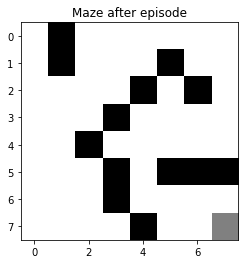

Epoch: 787/999 | Loss: 0.0009 | Episodes: 788 | Win count: 768 | Win rate: 1.000 | time: 1.81 hours
Loss:  0.0005311126296874136
Loss:  0.0006709405279252678
Loss:  0.0002634487609611824
Loss:  0.00048538960982114077
Loss:  0.0009316887590102851
Loss:  0.0006728287116857246
Loss:  0.0006661861698376015
Loss:  0.000853412231663242
Loss:  0.0009026685729622841
Loss:  0.0005998279521008953


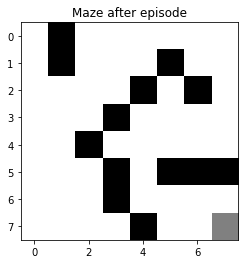

Epoch: 788/999 | Loss: 0.0006 | Episodes: 789 | Win count: 769 | Win rate: 1.000 | time: 1.81 hours
Loss:  0.0007266186294145882
Loss:  0.0007025042577879503
Loss:  0.0004464215744519606
Loss:  0.0004505308606894687
Loss:  0.00048385997069999576
Loss:  0.0008612969832029194
Loss:  0.0005954973166808486
Loss:  0.0006132267590146512
Loss:  0.00016829589003464207
Loss:  0.0007298031123355031
Loss:  0.0005317705363268033
Loss:  0.0004965947009623051
Loss:  0.0007264414161909372
Loss:  0.0002984361817652825
Loss:  0.0006758721719961613
Loss:  0.0006943520274944603
Loss:  0.001034222987073008
Loss:  0.0005974402010906488
Loss:  0.0005673008854500949
Loss:  0.0007398861489491537
Loss:  0.0008318640466313809
Loss:  0.0005079997645225376
Loss:  0.0009191129647661
Loss:  0.00048770129797048867
Loss:  0.0004751623928314075
Loss:  0.0002813505125232041
Loss:  0.0007954923785291612
Loss:  0.0005864380800630897
Loss:  0.00041587841405998915
Loss:  0.0005265483778202906
Loss:  0.0007729086792096496
L

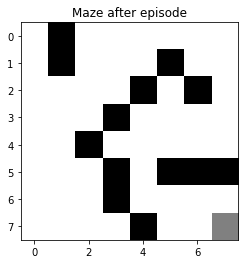

Epoch: 789/999 | Loss: 0.0005 | Episodes: 790 | Win count: 770 | Win rate: 1.000 | time: 1.82 hours
Loss:  0.0006221146031748503
Loss:  0.0007707771146669984
Loss:  0.0005706880183424801
Loss:  0.0007790128001943231
Loss:  0.0006442900339607149
Loss:  0.0007172000186983496
Loss:  0.0005527250468730927
Loss:  0.0006652207521256059
Loss:  0.00043723301496356726
Loss:  0.0005655450222548097
Loss:  0.0005965143500361592
Loss:  0.00046205743274185807
Loss:  0.0006235672626644373
Loss:  0.0005390495207393542
Loss:  0.0005339048875612207
Loss:  0.0004796413268195465
Loss:  0.0006023147725500166
Loss:  0.000512372367666103
Loss:  0.0007618066156283021
Loss:  0.0005432027974165976
Loss:  0.0007696344400756061
Loss:  0.0006213602027855814
Loss:  0.0008064191497396678
Loss:  0.00046126222878228873
Loss:  0.0007050657586660236
Loss:  0.0005869370215805247


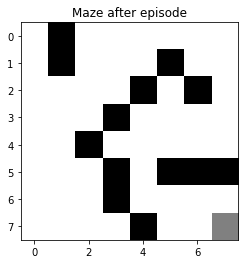

Epoch: 790/999 | Loss: 0.0006 | Episodes: 791 | Win count: 771 | Win rate: 1.000 | time: 1.82 hours
Loss:  0.0005061638803454116
Loss:  0.0005779395432909951
Loss:  0.0005501786072272807
Loss:  0.00039221772749442607
Loss:  0.0004818330053240061
Loss:  0.0005479321844177321
Loss:  0.00045984459575265646
Loss:  0.0005146987678017467
Loss:  0.0001747512687870767
Loss:  0.0006886952323839068
Loss:  0.0008679172315169126
Loss:  0.0004144189733779058
Loss:  0.00031582875817548484


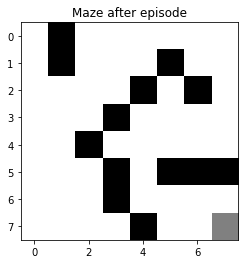

Epoch: 791/999 | Loss: 0.0003 | Episodes: 792 | Win count: 772 | Win rate: 1.000 | time: 1.82 hours
Loss:  0.00046402018051594496
Loss:  0.00039450919575756416
Loss:  0.0006947015499463305
Loss:  0.0005473684432217851
Loss:  0.0005034694913774729
Loss:  0.0007073475571814924
Loss:  0.0006368898903019726
Loss:  0.00041910783329512924
Loss:  0.0005785119283245876
Loss:  0.00045377956121228635
Loss:  0.000793403189163655
Loss:  0.0009494062687736005
Loss:  0.0005254738789517432
Loss:  0.0005366920086089522
Loss:  0.0005425595736596733
Loss:  0.0005779690982308239
Loss:  0.0003589478728827089
Loss:  0.0006940927414689213
Loss:  0.0006192322180140764
Loss:  0.0006599606713280082
Loss:  0.0005776625184807926
Loss:  0.0009724298724904656
Loss:  0.0006252657040022314
Loss:  0.0005542224680539221
Loss:  0.0005618628638330847


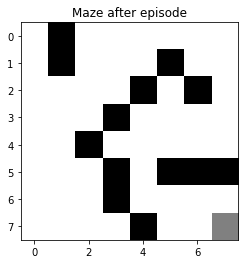

Epoch: 792/999 | Loss: 0.0006 | Episodes: 793 | Win count: 773 | Win rate: 1.000 | time: 1.82 hours
Loss:  0.0012144211505074054
Loss:  0.0010128360008820891
Loss:  0.00057241678587161
Loss:  0.0006647644040640444
Loss:  0.0004436352173797786
Loss:  0.0008008462027646601
Loss:  0.0006045436603017151
Loss:  0.0004271491488907486
Loss:  0.00027533962565939873
Loss:  0.0003064737102249637
Loss:  0.0006411754293367267


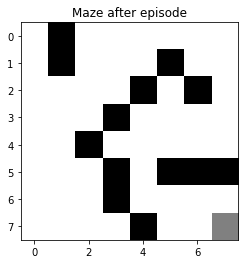

Epoch: 793/999 | Loss: 0.0006 | Episodes: 794 | Win count: 774 | Win rate: 1.000 | time: 1.82 hours
Loss:  0.0004312712844694033
Loss:  0.0005879210366401821
Loss:  0.00037393096135929227
Loss:  0.0004878827603533864
Loss:  0.000690870059770532
Loss:  0.0006026429182384163
Loss:  0.0006944512133486569
Loss:  0.00046947690861998126
Loss:  0.0003490170929580927
Loss:  0.0005342073854990304
Loss:  0.0005586237166426145
Loss:  0.0006623482040595263
Loss:  0.0004057407786604017
Loss:  0.0004099879297427833
Loss:  0.0002442007535137236
Loss:  0.000348767323885113
Loss:  0.0007683125440962613
Loss:  0.0005980405840091407
Loss:  0.0003788575704675168
Loss:  0.0005701919726561755
Loss:  0.0002993401576532051
Loss:  0.0003683731338242069
Loss:  0.0006221029325388372
Loss:  0.0004992750909877941
Loss:  0.0005409239383880049


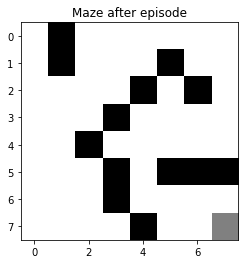

Epoch: 794/999 | Loss: 0.0005 | Episodes: 795 | Win count: 775 | Win rate: 1.000 | time: 1.83 hours
Loss:  0.0007358596776612103
Loss:  0.000831613753689453
Loss:  0.000574015750316903
Loss:  0.00088582540047355
Loss:  0.00017418881179764867
Loss:  0.0003338369497214444
Loss:  0.0009662705997470766


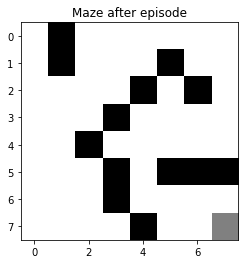

Epoch: 795/999 | Loss: 0.0010 | Episodes: 796 | Win count: 776 | Win rate: 1.000 | time: 1.83 hours
Loss:  0.0006975519063416868
Loss:  0.00044378246820997447
Loss:  0.000470351820695214
Loss:  0.0006128201348474249
Loss:  0.00044836591405328363
Loss:  0.00030244127265177667
Loss:  0.0005015697825001553
Loss:  0.0004944801330566406
Loss:  0.0003068624282605015
Loss:  0.00046551728155463934
Loss:  0.0009132155682891607
Loss:  0.0008467925945296884
Loss:  0.00038297045102808625
Loss:  0.0008046016737353057
Loss:  0.0001498759156675078
Loss:  0.00031561279320158064
Loss:  0.00024742743698880076
Loss:  0.0005359676870284602
Loss:  0.00033272444852627814
Loss:  0.00029837786860298365
Loss:  0.0006835100648459047
Loss:  0.0005186598864383996
Loss:  0.00031433800904778764
Loss:  0.0006336502265185118


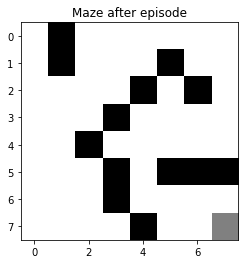

Epoch: 796/999 | Loss: 0.0006 | Episodes: 797 | Win count: 777 | Win rate: 1.000 | time: 1.83 hours
Loss:  0.0006103955383878201
Loss:  0.00038163637509569526
Loss:  0.00043897973955608904
Loss:  0.0006102391635067761
Loss:  0.0002393194954493083
Loss:  0.00033466120657976717
Loss:  0.00020996600687794853


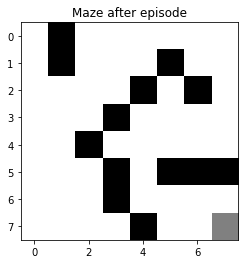

Epoch: 797/999 | Loss: 0.0002 | Episodes: 798 | Win count: 778 | Win rate: 1.000 | time: 1.83 hours
Loss:  0.00067528011277318
Loss:  0.00039451534394174814
Loss:  0.000609057693509385
Loss:  0.00032033055322244763
Loss:  0.0002646014836500399
Loss:  0.000749722181353718
Loss:  0.00025840173475444317
Loss:  0.0008412426104769111
Loss:  0.0008047238079598173
Loss:  0.000366772452252917
Loss:  0.0002370508445892483
Loss:  0.000440519826952368
Loss:  0.00038355669676093385
Loss:  0.0002681345176824834
Loss:  0.00036632588307838887
Loss:  0.0003228491186746396
Loss:  0.00031187366403173655
Loss:  0.00043789445771835744
Loss:  0.0002567110495874658
Loss:  0.0007388562662526965
Loss:  0.00027186392981093377
Loss:  0.0006542718037962914
Loss:  0.0006905169575475156
Loss:  0.00045152542588766664
Loss:  0.00032879054197110236
Loss:  0.0005954367225058377
Loss:  0.0006114602147135884
Loss:  0.00037759836413897574
Loss:  0.0003285819693701342
Loss:  0.0007539836224168539
Loss:  0.0003733856283361

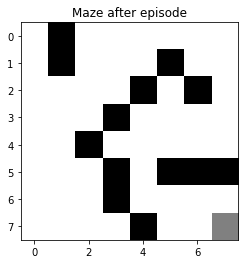

Epoch: 798/999 | Loss: 0.0005 | Episodes: 799 | Win count: 779 | Win rate: 1.000 | time: 1.84 hours
Loss:  0.00029802601784467697
Loss:  0.0007044182857498527
Loss:  0.0006814115913584828


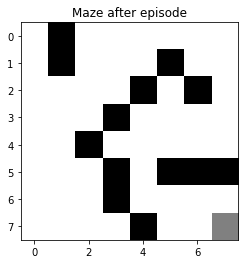

Epoch: 799/999 | Loss: 0.0007 | Episodes: 800 | Win count: 780 | Win rate: 1.000 | time: 1.84 hours
Loss:  0.00042131784721277654
Loss:  0.0003718509615282528
Loss:  0.0004515778855420649
Loss:  0.00048232734843622893
Loss:  0.0010689727496355772
Loss:  0.0003459113650023937
Loss:  0.0006220750510692596
Loss:  0.00027050875360146165
Loss:  0.0008728296088520437
Loss:  0.0005414821062004194
Loss:  0.00029218822601251304
Loss:  0.000869320792844519
Loss:  0.0004404143546707928
Loss:  0.0005043377022957429
Loss:  0.00023182237782748416
Loss:  0.0005195812263991684
Loss:  0.0006110125686973333
Loss:  0.0005283379286993295
Loss:  0.0007820456521585584
Loss:  0.0005596854316536337
Loss:  0.0006188033439684659
Loss:  0.00045729555131401867
Loss:  0.00035031853985856287
Loss:  0.0005619891308015212
Loss:  0.0009003250161185861
Loss:  0.0006306359573500231
Loss:  0.0003785512235481292
Loss:  0.0005820130463689566
Loss:  0.0003606978207244538
Loss:  0.00047890171117614955


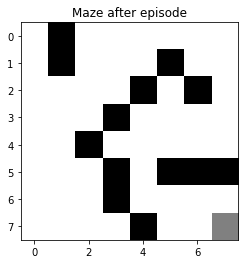

Epoch: 800/999 | Loss: 0.0005 | Episodes: 801 | Win count: 781 | Win rate: 1.000 | time: 1.84 hours
Loss:  0.0006063013715902343
Loss:  0.0003162635985063389
Loss:  0.0007997667853487656
Loss:  0.0007575388299301267
Loss:  0.0002873147022910416
Loss:  0.0005479446408571675
Loss:  0.00036593138065654784
Loss:  0.0002782055817078799
Loss:  0.0003747752634808421
Loss:  0.0002879408420994878
Loss:  0.000587140821153298
Loss:  0.0005218218720983714
Loss:  0.00035411695716902614
Loss:  0.0005053516215411946
Loss:  0.00048217622679658234
Loss:  0.0007836252334527671
Loss:  0.0003679076471598819
Loss:  0.000577938903006725
Loss:  0.0005025001519243233
Loss:  0.000536094928975217
Loss:  0.0002981997313327156
Loss:  0.0002853170008165762
Loss:  0.0006716021744068712
Loss:  0.0006415750831365585
Loss:  0.00032510034361621365


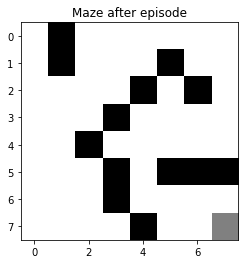

Epoch: 801/999 | Loss: 0.0003 | Episodes: 802 | Win count: 782 | Win rate: 1.000 | time: 1.84 hours
Loss:  0.000560152082471177
Loss:  0.0008527871395926923
Loss:  0.0006093887495808303
Loss:  0.0003780806582653895
Loss:  0.000503023067722097
Loss:  0.0005020355893066153
Loss:  0.0004981460951967165
Loss:  0.0007368261285591871
Loss:  0.000297268241411075
Loss:  0.0003500698512652889


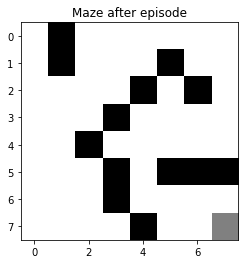

Epoch: 802/999 | Loss: 0.0004 | Episodes: 803 | Win count: 783 | Win rate: 1.000 | time: 1.85 hours
Loss:  0.0004413101414684206
Loss:  0.0006053463584976271
Loss:  0.00018981878383783624
Loss:  0.0002881466643884778
Loss:  0.0005407726275734603
Loss:  0.0006521583127323538
Loss:  0.000451612810138613
Loss:  0.00021059165737824515
Loss:  0.000716358219506219
Loss:  0.00026278723817085847
Loss:  0.0005603573517873883
Loss:  0.000662330916384235
Loss:  0.0005285512306727469
Loss:  0.0004484066157601774
Loss:  0.0003033116736332886
Loss:  0.0004435438313521445
Loss:  0.00027788535226136446
Loss:  0.0005970885831629857
Loss:  0.0003941464237868786
Loss:  0.0005444262060336769
Loss:  0.0006413689698092639
Loss:  0.0005819207726744935
Loss:  0.000257991865510121
Loss:  0.0006262448587222025
Loss:  0.0008067706367000937
Loss:  0.0004519767971942201
Loss:  0.00041115771455224603
Loss:  0.0005176867707632482
Loss:  0.0005018103402107954
Loss:  0.0003828194458037615
Loss:  0.00037932267878204584

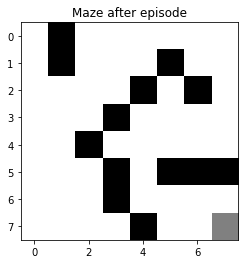

Epoch: 803/999 | Loss: 0.0001 | Episodes: 804 | Win count: 784 | Win rate: 1.000 | time: 1.85 hours
Loss:  0.0005802755622426048
Loss:  0.0003011479348060675
Loss:  0.0005128973571117967
Loss:  0.0007945079996716231
Loss:  0.0005086378223495558
Loss:  0.00037369098572526127
Loss:  0.0003974631108576432
Loss:  0.000391143694287166


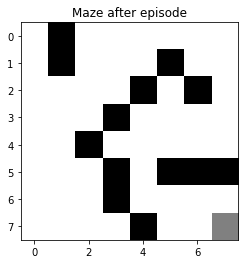

Epoch: 804/999 | Loss: 0.0004 | Episodes: 805 | Win count: 785 | Win rate: 1.000 | time: 1.85 hours
Loss:  0.0007283800368895754


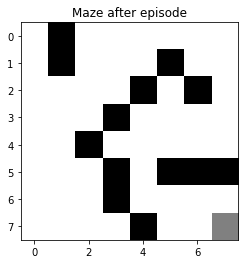

Epoch: 805/999 | Loss: 0.0007 | Episodes: 806 | Win count: 786 | Win rate: 1.000 | time: 1.85 hours
Loss:  0.0003091740218224004
Loss:  0.00037514566793106496
Loss:  0.0007084088429110125
Loss:  0.00025614765399950556
Loss:  0.0005434248014353216
Loss:  0.0003650490107247606
Loss:  0.0007309435022762045
Loss:  0.0003451331576798111
Loss:  0.000594572105910629
Loss:  0.0006276245694607496
Loss:  0.0005982271395623684
Loss:  0.0005931563791818917
Loss:  0.0006799517286708578
Loss:  0.00041537353536114097
Loss:  0.0003909564402420074
Loss:  0.0006598147883778438
Loss:  0.0003394788291188888
Loss:  0.00023166212486103177
Loss:  0.0006061152380425483
Loss:  0.0006513750413432717
Loss:  0.0005767873662989587
Loss:  0.00024972017854452133
Loss:  0.0005075466760899872


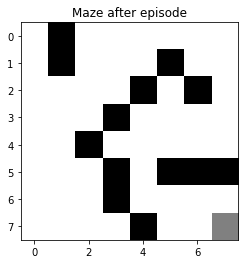

Epoch: 806/999 | Loss: 0.0005 | Episodes: 807 | Win count: 787 | Win rate: 1.000 | time: 1.85 hours
Loss:  0.0002203765579906758
Loss:  0.00062326826446224
Loss:  0.00034585304820211604
Loss:  0.0005511504714377224
Loss:  0.0006518934678751975
Loss:  0.00045996427070349455
Loss:  0.0006877699051983654
Loss:  0.0004125968262087554
Loss:  0.0004746589547721669
Loss:  0.0006253756582736969
Loss:  0.0004658481775550172
Loss:  0.0002774745298665948
Loss:  0.0006593324651475996
Loss:  0.0004752954264404252
Loss:  0.00046245171688497066
Loss:  0.00028413638210622594
Loss:  0.00047375299618579447
Loss:  0.00038907569251023233
Loss:  0.0006725196435581893
Loss:  0.0006252043240237981
Loss:  0.0006866227486170828
Loss:  0.0004574066697387025
Loss:  0.0006514114938909188
Loss:  0.00048346322728320956
Loss:  0.0004452483117347583
Loss:  0.0006300818058662117
Loss:  0.0007313750102184713
Loss:  0.0005305238737491891
Loss:  0.00016461619816254824
Loss:  0.00028853783442173153
Loss:  0.00098456197883

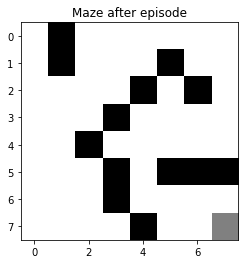

Epoch: 807/999 | Loss: 0.0004 | Episodes: 808 | Win count: 788 | Win rate: 1.000 | time: 1.86 hours
Loss:  0.0004127421125303954
Loss:  0.0008095291705103591
Loss:  0.0003674631589092314
Loss:  0.00024595647118985653
Loss:  0.0003589049447327852
Loss:  0.0008334378944709897
Loss:  0.0005221137835178524
Loss:  0.0006232034065760672
Loss:  0.00024669759295647964
Loss:  0.0006850499339634553
Loss:  0.0003208805719623342
Loss:  0.00042994387331418693
Loss:  0.0004571634344756603
Loss:  0.0001811151159927249
Loss:  0.0003074983978876844
Loss:  0.00035525293787941337
Loss:  0.00028366059996187687
Loss:  0.00032685973565094173
Loss:  0.0006448870699387044
Loss:  0.0007761865708744153
Loss:  0.00044167145097162575
Loss:  0.0008145980536937714
Loss:  0.000496192296850495
Loss:  0.0006532433326356113
Loss:  0.0003158643521601334
Loss:  0.0008860275556799024


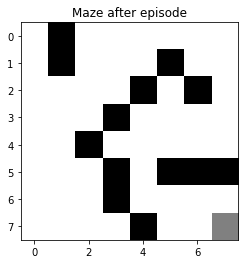

Epoch: 808/999 | Loss: 0.0009 | Episodes: 809 | Win count: 789 | Win rate: 1.000 | time: 1.86 hours
Loss:  0.00021929905051365495
Loss:  0.00043203226960031316
Loss:  0.0006519702146761119
Loss:  0.00041965678974520415
Loss:  0.0009699581132736057
Loss:  0.0006489805091405287
Loss:  0.0005784637469332665
Loss:  0.0005334639718057588
Loss:  0.0004778573347721249
Loss:  0.00023660306760575622
Loss:  0.0005087669705972075
Loss:  0.0008277147717308253
Loss:  0.0002604889523354359
Loss:  0.000825117836939171
Loss:  0.0010551403393037617
Loss:  0.0007566164713352919
Loss:  0.0006382575957104564
Loss:  0.00035761568142334
Loss:  0.0005810203147120774
Loss:  0.0002333013981115073


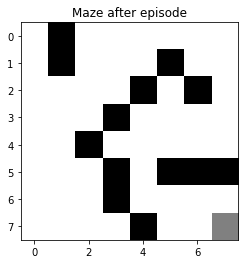

Epoch: 809/999 | Loss: 0.0002 | Episodes: 810 | Win count: 790 | Win rate: 1.000 | time: 1.86 hours
Loss:  0.0006248501886148006
Loss:  0.0003477317368378863
Loss:  0.0006561505433637649
Loss:  0.00039617286529392004
Loss:  0.0007935885223560035
Loss:  0.00012519271695055068
Loss:  0.0006974866410018876
Loss:  0.0004503859527176246
Loss:  0.0006304955459199846
Loss:  0.0007669647457078099
Loss:  0.0007100458169588819
Loss:  0.000756341265514493
Loss:  0.000450130901299417
Loss:  0.0005105985619593412
Loss:  0.0002621429957798682
Loss:  0.0004398326636874117
Loss:  0.000305488305457402
Loss:  0.000569318282941822
Loss:  0.00048087209870573133
Loss:  0.0005401752423495054
Loss:  0.0003144895163131878
Loss:  0.0006140339683042839
Loss:  0.00014312283019535244
Loss:  0.0004849502438446507
Loss:  0.0006620679632760584
Loss:  0.00042883105925284326
Loss:  0.0006581624620594084
Loss:  0.0006607534305658191
Loss:  0.0004938896890962496
Loss:  0.0006443314487114549


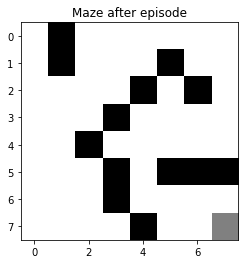

Epoch: 810/999 | Loss: 0.0006 | Episodes: 811 | Win count: 791 | Win rate: 1.000 | time: 1.86 hours
Loss:  0.0005629174265777692
Loss:  0.0004781367752002552
Loss:  0.0007761222368571907
Loss:  0.00045371944725047797
Loss:  0.00038116703217383474
Loss:  0.0003208900598110631
Loss:  0.00017369126726407558
Loss:  0.00023432910529663786
Loss:  0.0005404901457950473
Loss:  0.0005444611597340554
Loss:  0.00019759290807996877
Loss:  0.0004465865931706503
Loss:  0.00023954446805873886
Loss:  0.0001344162883469835


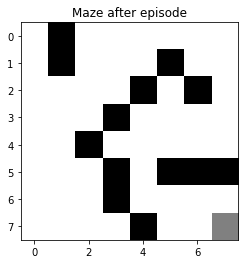

Epoch: 811/999 | Loss: 0.0001 | Episodes: 812 | Win count: 792 | Win rate: 1.000 | time: 1.86 hours
Loss:  0.0005321178177837282
Loss:  0.00039122681482695043
Loss:  0.0002943442959804088
Loss:  0.0003407627882552333
Loss:  0.0002501276176190004
Loss:  0.0005797624471597373
Loss:  0.0004073123127454892
Loss:  0.0002729324041865766
Loss:  0.0002679862445802428
Loss:  0.000259830427239649
Loss:  0.00018254639871884137
Loss:  0.00017281105101574212
Loss:  0.0003924603370251134
Loss:  0.000678433949360624
Loss:  0.0005441539251478389
Loss:  6.531083090521861e-05
Loss:  0.0001346132776234299
Loss:  0.0003285320781287737
Loss:  0.00026923223776975647
Loss:  0.00036066050233785063
Loss:  0.0003052362735616043
Loss:  0.0004633377830032259
Loss:  0.00045118721027392894
Loss:  0.00025649719827924855
Loss:  0.0003944210329791531
Loss:  0.0007144041883293539
Loss:  0.00018187694513471797
Loss:  0.0004406360094435513
Loss:  0.00040097814053297043


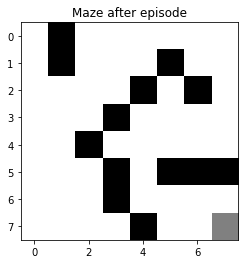

Epoch: 812/999 | Loss: 0.0004 | Episodes: 813 | Win count: 793 | Win rate: 1.000 | time: 1.87 hours
Loss:  0.00041834963485598564
Loss:  0.00026253761461703107
Loss:  0.00023172522196546197
Loss:  0.0005388065765146166
Loss:  0.00011718558380380273
Loss:  0.00032463938259752467
Loss:  0.0002505365846445784
Loss:  0.0003770057992369402
Loss:  0.0004921465733787045
Loss:  0.00038618120015598834
Loss:  0.00023800276176189072


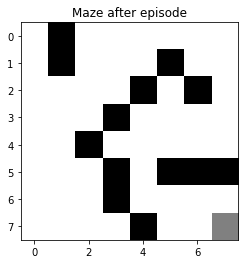

Epoch: 813/999 | Loss: 0.0002 | Episodes: 814 | Win count: 794 | Win rate: 1.000 | time: 1.87 hours
Loss:  0.00041296416020486504
Loss:  0.0003587988485378446
Loss:  0.00016709167903172784
Loss:  0.0001768650927260751
Loss:  0.0005035077483626083
Loss:  0.0005538308178074658
Loss:  0.00026729009550763294
Loss:  0.00014477153308689594
Loss:  5.650595448969398e-05
Loss:  0.00022391284437617287
Loss:  0.0003725348251464311
Loss:  0.0001866322309069801
Loss:  8.996367978397757e-05
Loss:  0.0002083607942040544
Loss:  8.453668851871043e-05
Loss:  0.00011416284178267233
Loss:  6.3444058469031e-05
Loss:  0.0003870419168379158
Loss:  5.5372758652083576e-05
Loss:  0.00035262308665551245
Loss:  0.0002164680845453404
Loss:  0.00013498139014700428
Loss:  4.0559541957918555e-05
Loss:  4.7616363190172706e-05
Loss:  0.00014756665041204542
Loss:  0.0005334440793376416
Loss:  6.291072168096434e-05
Loss:  0.0003639829301391728
Loss:  0.0002926452289102599
Loss:  3.6641846236307174e-05
Loss:  0.0003648437

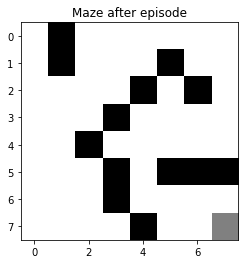

Epoch: 814/999 | Loss: 0.0004 | Episodes: 815 | Win count: 795 | Win rate: 1.000 | time: 1.87 hours
Loss:  0.000489050304167904
Loss:  0.00040608404378872365
Loss:  0.0003451737866271287
Loss:  0.0002936397104349453
Loss:  7.347529026446864e-05
Loss:  0.0007200897380243987
Loss:  6.55703515803907e-05
Loss:  0.00023206707555800676
Loss:  0.00035618271795101464
Loss:  0.00026072203763760626
Loss:  0.0005343751108739525
Loss:  0.000460981551441364
Loss:  0.0005382746458053589
Loss:  0.0003127313102595508
Loss:  0.00030336078998516314
Loss:  0.0002878510276786983
Loss:  0.0004409268294693902
Loss:  0.00017255744751309976
Loss:  0.00027527858765097335
Loss:  0.00022041330885258503
Loss:  0.00021036883117631078


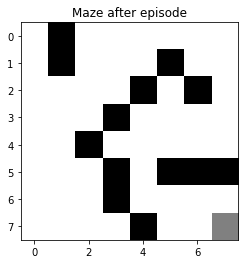

Epoch: 815/999 | Loss: 0.0002 | Episodes: 816 | Win count: 796 | Win rate: 1.000 | time: 1.87 hours
Loss:  0.000481067385408096


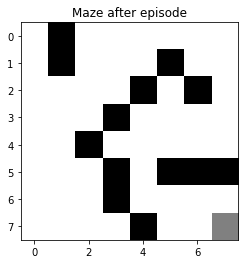

Epoch: 816/999 | Loss: 0.0005 | Episodes: 817 | Win count: 797 | Win rate: 1.000 | time: 1.87 hours
Loss:  0.00016655489889672026
Loss:  0.0001306507401750423
Loss:  0.00042255780863342807
Loss:  0.0004450618725968525
Loss:  0.00033795890340115875
Loss:  0.00026840389909921214
Loss:  0.0004389423120301217
Loss:  0.0003572435089154169
Loss:  0.0006624059751629829


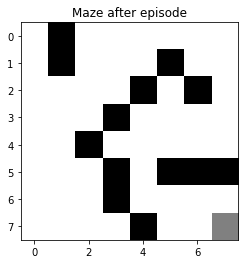

Epoch: 817/999 | Loss: 0.0007 | Episodes: 818 | Win count: 798 | Win rate: 1.000 | time: 1.87 hours
Loss:  0.0006553434650413692
Loss:  0.00030573634285246953
Loss:  0.00034496454463806003
Loss:  0.0007274085946846753
Loss:  0.00044689558126265183
Loss:  0.0008224164776038378
Loss:  0.0005163954483577982
Loss:  0.0005097159009892493
Loss:  0.0005047716113040224
Loss:  0.0005667161894962192
Loss:  0.00020452903117984533
Loss:  0.00022413177794078365
Loss:  0.0004041349166072905
Loss:  0.00015484416508115828
Loss:  0.00022091852588346228
Loss:  0.00019016584701603279
Loss:  0.0005136333493283018
Loss:  0.0007034723385004327
Loss:  0.000682602432789281
Loss:  0.0002657210498000495
Loss:  0.00013572564057540148
Loss:  0.0006483195465989411
Loss:  9.880922152660787e-05
Loss:  0.0002638154255691916
Loss:  0.00041684108146000654
Loss:  0.00014733631542185321
Loss:  0.00023739323660265654
Loss:  0.00045337414485402405
Loss:  0.00023453034373233095


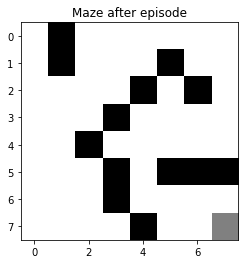

Epoch: 818/999 | Loss: 0.0002 | Episodes: 819 | Win count: 799 | Win rate: 1.000 | time: 1.88 hours
Loss:  0.0003509071175358258
Loss:  0.0005455764330690727
Loss:  0.00039651416591368616


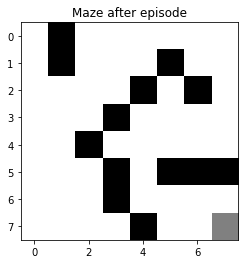

Epoch: 819/999 | Loss: 0.0004 | Episodes: 820 | Win count: 800 | Win rate: 1.000 | time: 1.88 hours
Loss:  0.00030044469895074144
Loss:  0.0003816988828475587
Loss:  0.00023485424208047334
Loss:  0.0003903973338310607
Loss:  0.0002955746094812639
Loss:  0.0001948556055140216
Loss:  0.0006787698221160099
Loss:  0.0003496690951578785
Loss:  0.0003659832291305065
Loss:  0.0004994422779418528
Loss:  0.0006020993605488911
Loss:  0.0005539911835512612
Loss:  0.00035142741035087965
Loss:  0.00036582001484930515
Loss:  0.00022175467893248424
Loss:  0.000457024867500877
Loss:  0.00047149111196631566
Loss:  7.3056056862697e-05
Loss:  0.0006346669251797721
Loss:  0.00038871215656399727
Loss:  0.0003160320338793099
Loss:  0.0002561315268394537
Loss:  0.00017678708172752522


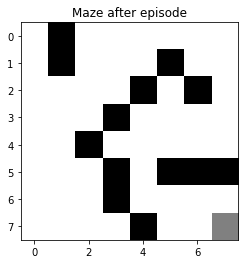

Epoch: 820/999 | Loss: 0.0002 | Episodes: 821 | Win count: 801 | Win rate: 1.000 | time: 1.88 hours
Loss:  0.00017767155077308416
Loss:  0.00046765060687903315
Loss:  0.0006691303278785199
Loss:  0.0005568186461459845
Loss:  0.00041391021295567043
Loss:  0.0006463942700065672
Loss:  0.00048116773541551083
Loss:  0.00032046086016634945
Loss:  7.38466223992873e-05
Loss:  0.00037246743158902973
Loss:  0.00023926605445012683
Loss:  7.602724872413091e-05
Loss:  0.00023407769913319498
Loss:  0.00038296948696370237
Loss:  0.0004991868336219341
Loss:  0.0002566555958765093
Loss:  0.00019387324573472142
Loss:  0.00030138839792925864
Loss:  0.000610141854849644
Loss:  0.00040359952981816605
Loss:  0.00017058064258890226
Loss:  0.0006379521801136434
Loss:  0.0002636332210386172
Loss:  0.0002296264901815448
Loss:  0.0004920782666886225
Loss:  0.000672472408041358
Loss:  0.00021627688329317607
Loss:  0.00030082468583714217


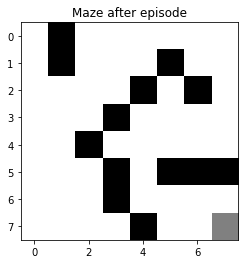

Epoch: 821/999 | Loss: 0.0003 | Episodes: 822 | Win count: 802 | Win rate: 1.000 | time: 1.88 hours
Loss:  0.0002124631791957654
Loss:  0.0004867235693382099
Loss:  0.00035877537811757065
Loss:  0.0004624361463356763
Loss:  6.608769399463199e-05
Loss:  0.0005720448243664578
Loss:  0.0004393342533148825
Loss:  0.00017255056627618615
Loss:  0.0008835240732878447


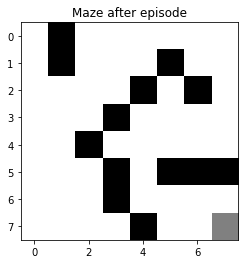

Epoch: 822/999 | Loss: 0.0009 | Episodes: 823 | Win count: 803 | Win rate: 1.000 | time: 1.88 hours
Loss:  0.00019146263366565108
Loss:  0.00026698354304244276
Loss:  0.0001524711842648685
Loss:  0.00012372925630188547
Loss:  0.00041226562461815774
Loss:  0.0002655204771144781
Loss:  0.0006720202218275517
Loss:  0.0006611243006773293
Loss:  0.00023432858142768964
Loss:  0.0003724262787727639
Loss:  0.000403719546739012


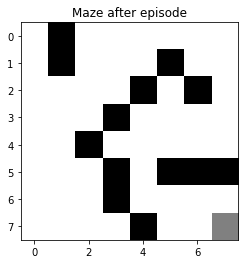

Epoch: 823/999 | Loss: 0.0004 | Episodes: 824 | Win count: 804 | Win rate: 1.000 | time: 1.88 hours
Loss:  0.0001572420933371177
Loss:  0.00035602775460574776
Loss:  0.0004454389418242499
Loss:  0.0006584967632079497
Loss:  0.0003620286443037912
Loss:  0.0004791342653334141
Loss:  0.00032579415710642934
Loss:  0.0003101290640188381
Loss:  0.0005912498090765439
Loss:  0.00039822637336328626
Loss:  0.0002253535458294209
Loss:  0.00035450494033284485
Loss:  0.00037945866642985493
Loss:  0.0004499071364989504
Loss:  0.00019759009592235088
Loss:  0.0004833183193113655
Loss:  0.00037296955997589976
Loss:  9.113579289987683e-05
Loss:  0.00018705394359130878
Loss:  7.705808820901439e-05
Loss:  0.0005390163569245487
Loss:  0.00015323346633522306
Loss:  7.894875670899637e-05
Loss:  0.00032344646751880646
Loss:  0.0003232867020415142
Loss:  7.623214696650393e-05
Loss:  8.981055361800827e-05
Loss:  6.139032484497875e-05
Loss:  4.380074642540421e-05


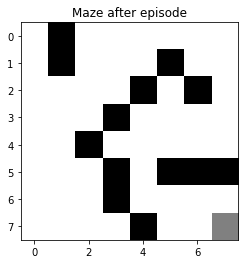

Epoch: 824/999 | Loss: 0.0000 | Episodes: 825 | Win count: 805 | Win rate: 1.000 | time: 1.89 hours
Loss:  0.00022084537340560928
Loss:  0.0003356616653036326
Loss:  0.00013537735139834695
Loss:  0.00018459009697835427
Loss:  0.00016486402819282375
Loss:  7.308907515835017e-05
Loss:  0.0003508082154439762
Loss:  0.00019517383043421432
Loss:  0.00035354871943127364
Loss:  0.00039357702917186543
Loss:  4.1470628275419585e-05
Loss:  0.00036917706893291324
Loss:  0.0003059154114453122
Loss:  6.354777724482119e-05
Loss:  0.00045833639160264283
Loss:  4.7866711611277424e-05
Loss:  0.000362197301001288
Loss:  0.00047554615593981
Loss:  0.0003694620681926608
Loss:  0.0003337939488119446
Loss:  0.00025686671142466366
Loss:  0.00021672770526492968
Loss:  0.0002775943503365852
Loss:  0.00034601208062667865
Loss:  1.989220254472457e-05
Loss:  0.00034881423925980926
Loss:  0.00020083130038983654
Loss:  0.00047801500477362424
Loss:  0.0001819095850805752


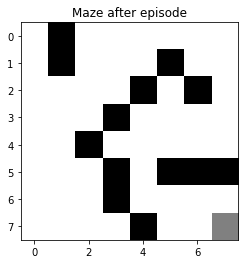

Epoch: 825/999 | Loss: 0.0002 | Episodes: 826 | Win count: 806 | Win rate: 1.000 | time: 1.89 hours
Loss:  5.577388401434291e-05
Loss:  0.0003517184086376801
Loss:  0.0006159571930766106
Loss:  0.0004451126733329147
Loss:  8.863565381034277e-05
Loss:  0.00030624994542449713
Loss:  0.0004940219223499298
Loss:  0.0008090314586297609
Loss:  0.0003325577126815915
Loss:  0.0004094635878573172
Loss:  0.0002163714962080121
Loss:  0.0003610437852330506
Loss:  0.0004519649228313938
Loss:  0.00023288406373467296
Loss:  0.00016920048074098304
Loss:  0.00047050805733306333


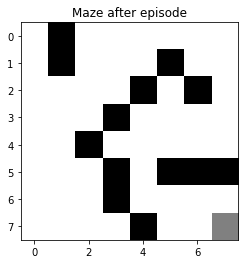

Epoch: 826/999 | Loss: 0.0005 | Episodes: 827 | Win count: 807 | Win rate: 1.000 | time: 1.89 hours
Loss:  0.0006144503131508827
Loss:  8.87159476405941e-05
Loss:  0.00018974190425069537
Loss:  0.00022776359401177615
Loss:  4.298170460970141e-05
Loss:  0.00018872068176278844
Loss:  0.000178442493051989
Loss:  0.00036408046435099095
Loss:  5.985424286336638e-05
Loss:  0.00024405407384620048
Loss:  0.0003678596258396283
Loss:  0.00037316044472390786


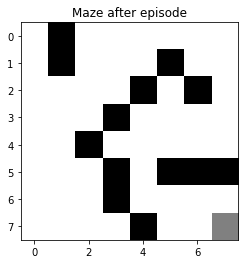

Epoch: 827/999 | Loss: 0.0004 | Episodes: 828 | Win count: 808 | Win rate: 1.000 | time: 1.89 hours
Loss:  0.0005113121878821403
Loss:  0.0003395378589630127
Loss:  0.00030902301659807563
Loss:  0.00045876583317294717
Loss:  0.00026693178006098606
Loss:  0.0002312748365511652
Loss:  0.0002465621510054916
Loss:  0.0003678524517454207
Loss:  0.00023770568805048242
Loss:  0.00043403872405178845
Loss:  7.942048523545964e-05
Loss:  0.00039289414416998625
Loss:  0.00024183409550460055
Loss:  0.00021826669399160892
Loss:  0.00023898083600215614
Loss:  0.00018521225138101727
Loss:  0.00039295825990848243
Loss:  0.00018668156189960428
Loss:  0.00018565176287665963
Loss:  0.00015531943790847436
Loss:  0.00033454773074481636
Loss:  6.74020848236978e-05
Loss:  0.00033517482370371
Loss:  0.0001916169985634042
Loss:  0.00018504797299101483
Loss:  0.00048730131675256416
Loss:  7.744333925074898e-05
Loss:  0.0005223517655394971
Loss:  0.0009303161350544542
Loss:  0.0004615404031937942
Loss:  0.0004378

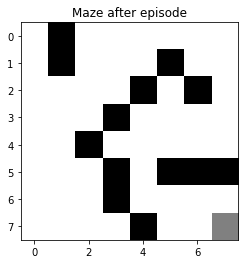

Epoch: 828/999 | Loss: 0.0002 | Episodes: 829 | Win count: 809 | Win rate: 1.000 | time: 1.89 hours
Loss:  0.0004999996745027602


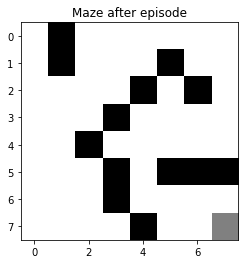

Epoch: 829/999 | Loss: 0.0005 | Episodes: 830 | Win count: 810 | Win rate: 1.000 | time: 1.89 hours
Loss:  0.00021242607181193307
Loss:  0.000472165469545871
Loss:  0.0005935825465712696
Loss:  0.0003191601936123334
Loss:  0.0002474265784258023
Loss:  0.0002689273351279553
Loss:  0.00021253693466860568
Loss:  0.0006396156168193556
Loss:  0.0001721369699225761
Loss:  0.00021576783910859376
Loss:  0.000664090650388971
Loss:  0.00017816390027292073
Loss:  0.00022888941748533398
Loss:  0.00014314018335426226
Loss:  0.0007341525779338554
Loss:  0.00048352981684729457
Loss:  0.0003740678002941422
Loss:  0.00024842247512424365
Loss:  0.00048399092338513583


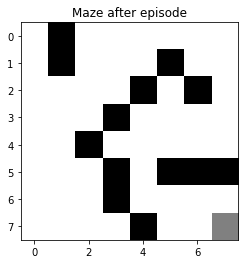

Epoch: 830/999 | Loss: 0.0005 | Episodes: 831 | Win count: 811 | Win rate: 1.000 | time: 1.90 hours
Loss:  0.0004106220731046051


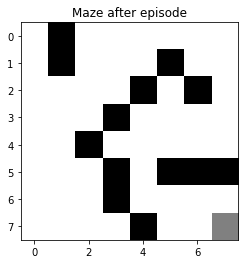

Epoch: 831/999 | Loss: 0.0004 | Episodes: 832 | Win count: 812 | Win rate: 1.000 | time: 1.90 hours
Loss:  9.772533303475939e-05
Loss:  0.0002057307428913191
Loss:  0.00024626679805805907
Loss:  0.0003598117036744952
Loss:  0.00021371811453718692


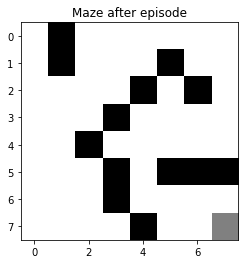

Epoch: 832/999 | Loss: 0.0002 | Episodes: 833 | Win count: 813 | Win rate: 1.000 | time: 1.90 hours
Loss:  0.0006026361224940047
Loss:  0.0003070953389396891
Loss:  0.000767919234931469
Loss:  0.000646924861939624
Loss:  0.00020217785640852526
Loss:  0.0006075131823308766
Loss:  0.0004763112374348566
Loss:  0.0003168213643220952
Loss:  0.00046025533811189234
Loss:  0.00042280838533770293
Loss:  0.00012482442980399355
Loss:  0.0003542820704751648
Loss:  0.0004300157743273303
Loss:  0.0004666001768782735
Loss:  0.000357597218680894
Loss:  7.783724504406564e-05
Loss:  0.00020595411751855863
Loss:  0.00041236057586502284
Loss:  0.000218874731217511
Loss:  0.00017222041969944257
Loss:  0.0004749379186250735
Loss:  0.000278388659353368
Loss:  0.000774194224504754


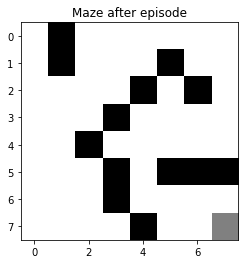

Epoch: 833/999 | Loss: 0.0008 | Episodes: 834 | Win count: 814 | Win rate: 1.000 | time: 1.90 hours
Loss:  0.00019685399456648156


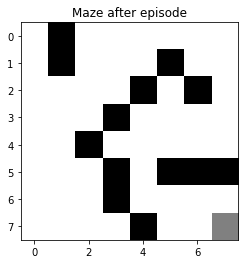

Epoch: 834/999 | Loss: 0.0002 | Episodes: 835 | Win count: 815 | Win rate: 1.000 | time: 1.90 hours
Loss:  0.0003379825138836168
Loss:  0.00033161368628498167
Loss:  0.00042010308243334293
Loss:  0.0002206852768722456
Loss:  0.000782942195655778
Loss:  0.00014393362289411016
Loss:  0.00030119571601971984
Loss:  0.00045514964585890993
Loss:  0.0004924945096718147
Loss:  0.00040277092193719
Loss:  0.000495846412377432
Loss:  7.626398291904479e-05
Loss:  0.00033910157799255103
Loss:  0.0003210783179383725
Loss:  0.00039272500725928694
Loss:  0.0002074184885714203
Loss:  8.977275501820259e-05
Loss:  0.0005388911522459239
Loss:  0.0003648372439783998
Loss:  0.00029974401695653796
Loss:  0.0003589245898183435
Loss:  0.0004253701481502503
Loss:  0.00017920416757988278
Loss:  0.0005039463430875912
Loss:  0.0001161843119916739
Loss:  0.0005658610898535699
Loss:  4.723401252704207e-05
Loss:  0.00018626168457558379


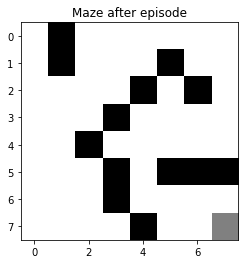

Epoch: 835/999 | Loss: 0.0002 | Episodes: 836 | Win count: 816 | Win rate: 1.000 | time: 1.90 hours
Loss:  0.00035839423435390927
Loss:  0.00015012366566224955
Loss:  0.00032842595828697085
Loss:  0.00020869082072749734
Loss:  0.0001811918100429466
Loss:  0.000209622026886791
Loss:  0.00010128294525202364
Loss:  0.00047158765664789826
Loss:  0.00021157381343073212
Loss:  0.00032290069066220894
Loss:  0.00022344494209391996
Loss:  9.880432480713353e-05
Loss:  0.0003318261296954006
Loss:  0.0004671941715059802
Loss:  0.0002587860799394548
Loss:  0.0005815943295601755
Loss:  0.000331681156239938


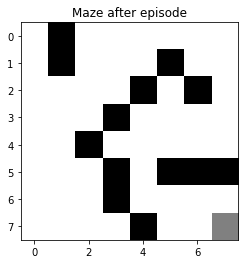

Epoch: 836/999 | Loss: 0.0003 | Episodes: 837 | Win count: 817 | Win rate: 1.000 | time: 1.90 hours
Loss:  0.00042056755046360195
Loss:  0.000428537285188213
Loss:  3.353812553541502e-05
Loss:  0.00044051240547560155
Loss:  0.0002626554269227199
Loss:  0.0005323727382346988
Loss:  0.0002669297027750872
Loss:  0.00019764424723689444
Loss:  0.00012331352627370507


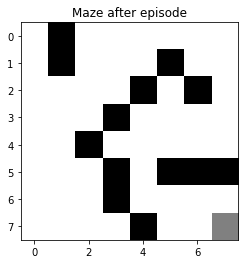

Epoch: 837/999 | Loss: 0.0001 | Episodes: 838 | Win count: 818 | Win rate: 1.000 | time: 1.90 hours
Loss:  0.00017483636565884808
Loss:  0.00029869632271584123
Loss:  0.0004922491243632976
Loss:  0.00029597336833830923
Loss:  0.0005780179635621607
Loss:  0.00039341358933597803
Loss:  0.0003495074633974582
Loss:  0.0004725836624857038
Loss:  0.00022008402447681874
Loss:  0.00018306701167603023
Loss:  0.0006002910959068686
Loss:  0.00045063323341310024
Loss:  0.00017842343368101865


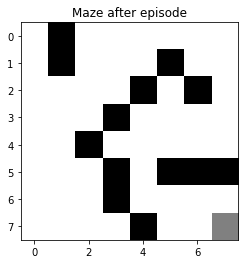

Epoch: 838/999 | Loss: 0.0002 | Episodes: 839 | Win count: 819 | Win rate: 1.000 | time: 1.91 hours
Loss:  0.0003202361986041069
Loss:  0.0002135609211109113
Loss:  0.00037519963370868936
Loss:  0.00019856484868796542
Loss:  0.0006227220146683976
Loss:  0.00033052403159672394
Loss:  0.00023650877847103402
Loss:  0.0006384181906469166
Loss:  0.00019143185272696428
Loss:  0.0005001930985599756
Loss:  0.00011743988579837605


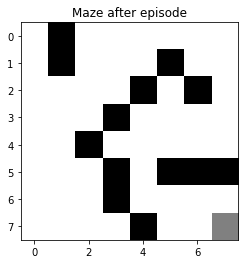

Epoch: 839/999 | Loss: 0.0001 | Episodes: 840 | Win count: 820 | Win rate: 1.000 | time: 1.91 hours
Loss:  0.0001982458070415305
Loss:  0.0003684058083308628
Loss:  0.0001704770838841796
Loss:  0.00021514736363315023
Loss:  0.00026656370755517855
Loss:  0.00016148913346114568
Loss:  0.0003349380713189021
Loss:  0.00012321672511461657
Loss:  0.00034212355240015313
Loss:  0.0003382647810212802
Loss:  0.0005765918322140351
Loss:  0.0004183148848824203
Loss:  0.0007370297098532319
Loss:  0.0002480103685229551
Loss:  0.000623765867203474
Loss:  0.0001224468469445128
Loss:  0.000534572041942738
Loss:  0.0006290236487984657
Loss:  0.0002753362205112353
Loss:  0.00039050428313203156
Loss:  0.00026356867601862177
Loss:  0.0007040513155516237
Loss:  0.00022566401457879692
Loss:  0.00018547898071119562


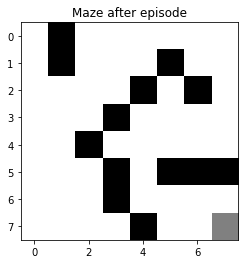

Epoch: 840/999 | Loss: 0.0002 | Episodes: 841 | Win count: 821 | Win rate: 1.000 | time: 1.91 hours
Loss:  0.00048339730346924625
Loss:  0.00035370421755942516
Loss:  0.00022752318909624591
Loss:  0.00033603093470446765
Loss:  0.00018097357678925619
Loss:  3.743209890672006e-05
Loss:  0.00048264735960401595
Loss:  0.0005754563790105749
Loss:  0.00019180130766471848
Loss:  0.00019370444351807237
Loss:  0.00030071931541897357
Loss:  0.0006649721181020141
Loss:  0.00037273183988872916
Loss:  9.121171024162322e-05
Loss:  0.00012375254300422966
Loss:  0.000549841410247609
Loss:  4.622762571671046e-05
Loss:  0.0002856881183106452
Loss:  6.25952088739723e-05
Loss:  0.00040340819396078587
Loss:  0.0007685935997869819
Loss:  0.000378319455194287
Loss:  0.0005452011682791635
Loss:  0.00035880743234883994
Loss:  0.0004793537227669731
Loss:  0.000830129545647651
Loss:  0.000357753575372044
Loss:  0.0005871433531865478
Loss:  0.0004365997883724049
Loss:  0.000796806561993435
Loss:  0.00092166976537

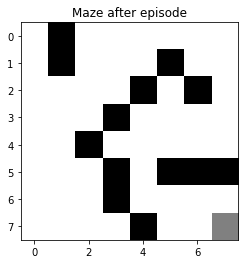

Epoch: 841/999 | Loss: 0.0009 | Episodes: 842 | Win count: 822 | Win rate: 1.000 | time: 1.91 hours
Loss:  0.0004434210422914475


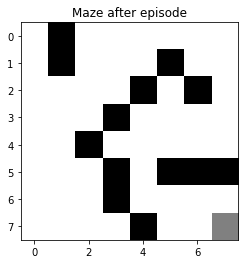

Epoch: 842/999 | Loss: 0.0004 | Episodes: 843 | Win count: 823 | Win rate: 1.000 | time: 1.91 hours
Loss:  0.00036158580405754037
Loss:  0.0002644548221724108
Loss:  0.0005952778446953744
Loss:  0.0004519915673881769
Loss:  0.0006965126085560769
Loss:  0.0003477392456261441
Loss:  0.0003527403168845922
Loss:  0.00028545497480081394
Loss:  0.0006264993135118857
Loss:  0.0007717229018453509
Loss:  0.0007942411757539958
Loss:  0.00043886354251299053
Loss:  0.0008301773632410914
Loss:  0.00043777868268080056
Loss:  0.0006526942015625536
Loss:  0.0009157035674434155
Loss:  0.0011923184501938522
Loss:  0.0009567616507411003
Loss:  0.0007425496587529778
Loss:  0.0006839492780272849
Loss:  0.0004919553175568581
Loss:  0.001265409984625876
Loss:  0.0005120589921716601
Loss:  0.0010438791650813073
Loss:  0.0003462663371465169
Loss:  0.00022557270131073892
Loss:  0.0007595412607770413
Loss:  0.0005934637447353452
Loss:  0.0006540472386404872
Loss:  0.0006989528628764674
Loss:  0.00074459210736677

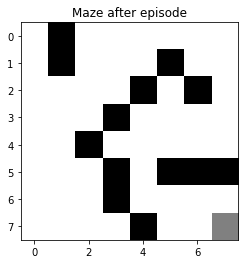

Epoch: 843/999 | Loss: 0.0006 | Episodes: 844 | Win count: 824 | Win rate: 1.000 | time: 1.92 hours
Loss:  0.0007035079761408269
Loss:  0.000790084945037961
Loss:  0.0010815455170813948
Loss:  0.0003837322146864608
Loss:  0.000322313149808906
Loss:  0.0003180676430929452
Loss:  0.0006116333461250179
Loss:  0.0005643470212817192
Loss:  0.0004785012570209801
Loss:  0.00041720001900102943
Loss:  0.0007903369260020554
Loss:  0.00020031298481626436
Loss:  0.0003702503308886662


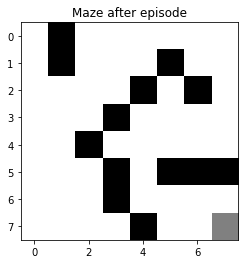

Epoch: 844/999 | Loss: 0.0004 | Episodes: 845 | Win count: 825 | Win rate: 1.000 | time: 1.92 hours
Loss:  0.0003378039436938707
Loss:  0.0005144056776771322
Loss:  0.0006837887631263584
Loss:  0.0001947278724401258
Loss:  0.0005318124749464914
Loss:  0.0005723042704630643
Loss:  0.00042668249807320535
Loss:  0.00026279834855813533
Loss:  0.0003929478916688822
Loss:  0.0005853277980349958
Loss:  0.0005868604348506778
Loss:  0.0005365931574488059
Loss:  0.00035256014234619215
Loss:  0.0005541406135307625
Loss:  0.0006534954882226884
Loss:  0.0007625703292433172
Loss:  0.000246513620368205
Loss:  0.000695702969096601
Loss:  0.0005099159170640633


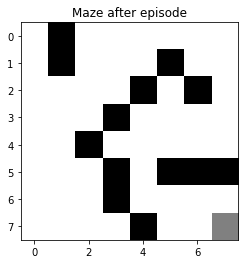

Epoch: 845/999 | Loss: 0.0005 | Episodes: 846 | Win count: 826 | Win rate: 1.000 | time: 1.92 hours
Loss:  0.0002400345547357574
Loss:  0.0008793637389317155
Loss:  0.0006811833882238716
Loss:  0.0004147643194301054
Loss:  0.0007328580250032246
Loss:  0.0005970551283098757
Loss:  0.0009485581540502608
Loss:  0.0003403420123504475
Loss:  0.0005091107595944777
Loss:  0.0006286876159720123
Loss:  0.0005377140769269317


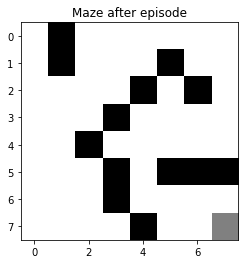

Epoch: 846/999 | Loss: 0.0005 | Episodes: 847 | Win count: 827 | Win rate: 1.000 | time: 1.92 hours
Loss:  0.0012103303743060678
Loss:  0.0002518764085834846
Loss:  0.0007157321088016033
Loss:  0.0005358812341000885
Loss:  0.00028814232791773975
Loss:  0.0005227186484262347


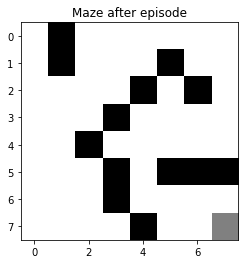

Epoch: 847/999 | Loss: 0.0005 | Episodes: 848 | Win count: 828 | Win rate: 1.000 | time: 1.92 hours
Loss:  0.0006266828568186611
Loss:  0.0006905354675836861
Loss:  0.0005874577618669719
Loss:  0.0007792582910042256
Loss:  0.00023383436928270385
Loss:  0.00039049724000506103
Loss:  0.0004651089839171618
Loss:  0.0004344289191067219
Loss:  0.00036485872260527685
Loss:  0.0004542039823718369
Loss:  0.0002609025905258022
Loss:  0.0009764714632183313
Loss:  0.00042683910578489304
Loss:  0.0007849610119592398
Loss:  0.0005609200452454388
Loss:  0.00054606405319646
Loss:  0.0008326484821736813
Loss:  0.0007285981992026791
Loss:  0.00035069060686510056
Loss:  0.0005221106112003326
Loss:  0.00029084394918754697
Loss:  0.0006523025440401398
Loss:  0.00047763883776497096
Loss:  0.0003318770759506151
Loss:  0.00039201186154969037


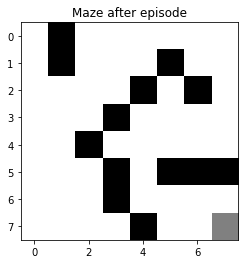

Epoch: 848/999 | Loss: 0.0004 | Episodes: 849 | Win count: 829 | Win rate: 1.000 | time: 1.93 hours
Loss:  0.0004924716922687367
Loss:  0.00046871806262061
Loss:  0.0005040456890128553
Loss:  0.00025407907378394157
Loss:  0.00012969845556654036
Loss:  0.0005242616607574746
Loss:  0.00015051732407300733
Loss:  0.00012805934420612175
Loss:  0.00040184424142353237
Loss:  0.0001688464981270954
Loss:  0.0005162977395229973
Loss:  0.00033675823942758143
Loss:  0.0003389381890883669
Loss:  0.0005169310607016087
Loss:  0.0007690317288506776
Loss:  0.0007335055124713108
Loss:  0.0004056670150021091
Loss:  0.00042087677866220474
Loss:  0.0004148345033172518
Loss:  0.0007817895966582
Loss:  0.0003172749566147104
Loss:  0.00023297405277844518
Loss:  0.0006038830324541777
Loss:  0.0002994319729623385


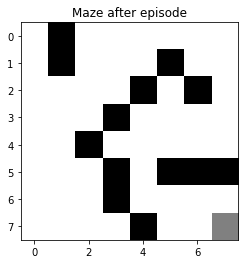

Epoch: 849/999 | Loss: 0.0003 | Episodes: 850 | Win count: 830 | Win rate: 1.000 | time: 1.93 hours
Loss:  0.0001584589044796303
Loss:  0.0003185713940183632
Loss:  0.00041169759060721844
Loss:  0.0005871069006389007
Loss:  0.0008490289619658142
Loss:  0.0005233496631262824
Loss:  0.0007241853745654225
Loss:  0.0007605052669532597
Loss:  0.0005810630391351879
Loss:  0.00040440021257381886
Loss:  0.0006170242850203067
Loss:  0.0002762654039543122
Loss:  0.0005928659520577639
Loss:  0.0006939678569324315
Loss:  0.00031564362143399194
Loss:  0.0007579172670375556
Loss:  0.0004205799923511222
Loss:  0.0004975451156497002
Loss:  0.0006299963570199907
Loss:  0.0006637473416049033
Loss:  0.00078470294829458
Loss:  0.0008325290109496564
Loss:  0.0009722873801365495
Loss:  0.0004580535751301795
Loss:  0.0004463852528715506
Loss:  0.001100612513255328
Loss:  0.0006729583546984941
Loss:  0.0005845224659424275
Loss:  0.0005540041456697509
Loss:  0.000618395337369293
Loss:  0.0008373806485906243
Lo

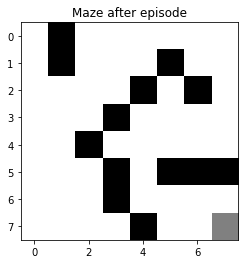

Epoch: 850/999 | Loss: 0.0009 | Episodes: 851 | Win count: 831 | Win rate: 1.000 | time: 1.93 hours
Loss:  0.001096713007427752
Loss:  0.0012321611866354942
Loss:  0.0004901225620415062
Loss:  0.0007035370508674532
Loss:  0.0010690161725506186
Loss:  0.0007559578662039712
Loss:  0.0007618870586156845
Loss:  0.0006634112796746194
Loss:  0.0006323363923002034
Loss:  0.0007427177915815264
Loss:  0.0003720208624145016
Loss:  0.00024911897344281897
Loss:  0.0009686866978881881


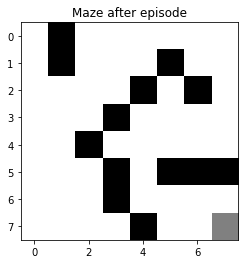

Epoch: 851/999 | Loss: 0.0010 | Episodes: 852 | Win count: 832 | Win rate: 1.000 | time: 1.93 hours
Loss:  0.00048263079952448606
Loss:  0.0009115492575801909
Loss:  0.0002928215035353787
Loss:  0.00032255591941066086
Loss:  0.0005581527948379517
Loss:  0.0007685201126150787
Loss:  0.0006100944738136604
Loss:  0.0005397588538471609
Loss:  0.0009210800635628402
Loss:  0.00019211226754123345
Loss:  0.0008478686795569956
Loss:  0.0004707482294179499
Loss:  0.0007309463107958436
Loss:  0.0007606448489241302
Loss:  0.000593609845964238
Loss:  0.0007434219587594271
Loss:  0.0006809103360865265


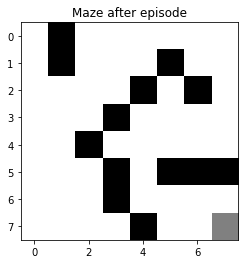

Epoch: 852/999 | Loss: 0.0007 | Episodes: 853 | Win count: 833 | Win rate: 1.000 | time: 1.94 hours
Loss:  0.0005427162686828524
Loss:  0.0005005256389267743
Loss:  0.0008353055745828897
Loss:  0.0003631717918324284
Loss:  0.00020005115220556036
Loss:  0.0005981069843983278
Loss:  0.0007207778544398025
Loss:  0.0005941161653026938
Loss:  0.0009918117430061102
Loss:  0.001042040647007525
Loss:  0.0005882387631572783
Loss:  0.00045767935807816684
Loss:  0.00027976565252174623
Loss:  0.0005109368867124431
Loss:  0.0007567865832243115
Loss:  0.0006161550700198859
Loss:  0.0010194455389864743
Loss:  0.0007480473723262548
Loss:  0.00054596082190983
Loss:  0.0008499873802065849
Loss:  0.000613923097262159
Loss:  0.001032412110362202
Loss:  0.0008107915346045047
Loss:  0.0004244529118295759
Loss:  0.0005507747991941869
Loss:  0.0003100113899563439


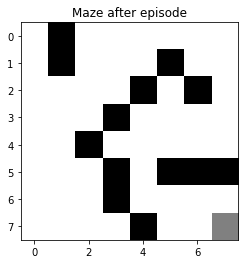

Epoch: 853/999 | Loss: 0.0003 | Episodes: 854 | Win count: 834 | Win rate: 1.000 | time: 1.94 hours
Loss:  0.00011977533722529188
Loss:  0.0008434349438175559


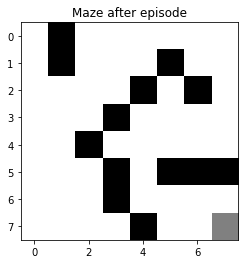

Epoch: 854/999 | Loss: 0.0008 | Episodes: 855 | Win count: 835 | Win rate: 1.000 | time: 1.94 hours
Loss:  0.00038926494016777724
Loss:  0.0005047793092671782
Loss:  0.0004350261151557788
Loss:  0.00040772792999632657
Loss:  0.0005610023799818009
Loss:  0.0007765221525914967
Loss:  0.0009040140721481293
Loss:  0.0006174009322421625
Loss:  0.0006645014218520373
Loss:  0.00045191263779997826
Loss:  0.000462921590951737
Loss:  0.000531486832187511
Loss:  0.0007398785382974893
Loss:  0.0006665264954790473
Loss:  0.0009190632263198495
Loss:  0.0005708254175260663
Loss:  0.0009407942707184702
Loss:  0.00048679474275559187
Loss:  0.000532101868884638
Loss:  0.0005025292339269072
Loss:  0.0008155841496773064
Loss:  0.0005220002203714103
Loss:  0.0006588202086277306
Loss:  0.0005218046862864867


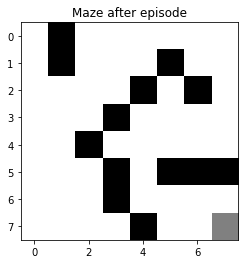

Epoch: 855/999 | Loss: 0.0005 | Episodes: 856 | Win count: 836 | Win rate: 1.000 | time: 1.94 hours
Loss:  0.0008770450076553971
Loss:  0.0008406565757468343
Loss:  0.0002907825692091137
Loss:  0.000497274799272418
Loss:  0.00047020893543958664
Loss:  0.0005013383633922786
Loss:  0.00051824827096425
Loss:  0.0007679734262637794
Loss:  0.0006065720808692276
Loss:  0.0009893260430544615
Loss:  0.0007074471213854849
Loss:  0.0003696165222208947
Loss:  0.0008668049122206867
Loss:  0.0004702268051914871
Loss:  0.0007231124327518046
Loss:  0.0007651570776943117
Loss:  0.0008690303948242217
Loss:  0.0008354984456673265
Loss:  0.0008966902387328446
Loss:  0.0004481908254092559
Loss:  0.0005478683015098795
Loss:  0.000500181362440344


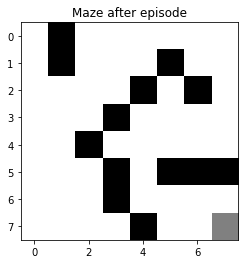

Epoch: 856/999 | Loss: 0.0005 | Episodes: 857 | Win count: 837 | Win rate: 1.000 | time: 1.94 hours
Loss:  0.0007849477406125516
Loss:  0.0004493585438467562
Loss:  0.000837374129332602
Loss:  0.0007651932537555695
Loss:  0.0005666687502525747
Loss:  0.00032245981856249273
Loss:  0.00041553747723810375
Loss:  0.0005145618051756173
Loss:  0.00028956244204891846
Loss:  0.00034489207610022277
Loss:  0.0007273813534993678
Loss:  0.0009408978803548962
Loss:  0.00036834110505878925
Loss:  0.0006638056656811386
Loss:  0.00029241573065519333
Loss:  0.0004992881877114996
Loss:  0.0009867968037724495
Loss:  0.0003838977718260139
Loss:  0.0009824789012782276
Loss:  0.00032068503787741065
Loss:  0.0007232908974401653
Loss:  0.0006154924049042165
Loss:  0.000472897692816332
Loss:  0.0005636479472741485
Loss:  0.0003654959291452542
Loss:  0.0004815584543393925
Loss:  0.0002901465632021427
Loss:  0.0004817924491362646
Loss:  0.0006854698585812002


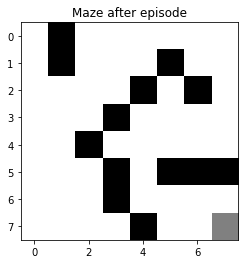

Epoch: 857/999 | Loss: 0.0007 | Episodes: 858 | Win count: 838 | Win rate: 1.000 | time: 1.94 hours
Loss:  0.0003923623153241351
Loss:  0.0008885532733984292
Loss:  0.0005046183650847524
Loss:  0.00034015486744465306
Loss:  0.00016317387780873105
Loss:  0.0006214092718437314
Loss:  0.00039377736538881436
Loss:  0.00046992053103167564
Loss:  0.0004966353153577074
Loss:  0.0005145927134435624
Loss:  0.0005302905265125446
Loss:  0.0005136538820806891
Loss:  0.00043510764226084575
Loss:  0.00060311533161439
Loss:  0.0006365328445099294
Loss:  0.0008483048586640507
Loss:  0.0006509239319711924
Loss:  0.00027342053363099694
Loss:  0.0005759264604421332


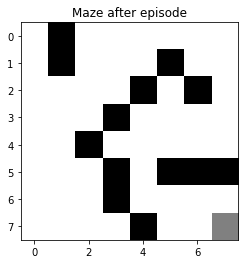

Epoch: 858/999 | Loss: 0.0006 | Episodes: 859 | Win count: 839 | Win rate: 1.000 | time: 1.95 hours
Loss:  0.00035762586776399985
Loss:  0.0004852707788813859
Loss:  0.0005194337863940746
Loss:  0.0007302792510017753
Loss:  0.000638801691820845
Loss:  0.0007660884002689272
Loss:  0.0006217400950845331
Loss:  0.0006715731287840754
Loss:  0.00035625022428575903
Loss:  0.0008791951986495405
Loss:  0.0007059403869789094
Loss:  0.0005705701478291303
Loss:  0.0008071668271441013
Loss:  0.0005759025370934978
Loss:  0.0005429555894806981
Loss:  0.0005368510901462287
Loss:  0.0006500047456938773
Loss:  0.00042945120367221534
Loss:  0.0006347258749883622
Loss:  0.0007126732089091092
Loss:  0.0003374912921572104
Loss:  0.0005867111904080957
Loss:  0.0005446071736514568
Loss:  0.00038189528277143836
Loss:  0.0008297260501421988
Loss:  0.0006615612073801458
Loss:  0.0005966156750218943
Loss:  0.0008437186334049329
Loss:  0.0004833496204810217
Loss:  0.000723722274415195
Loss:  0.0007169466698542237

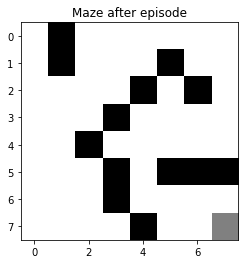

Epoch: 859/999 | Loss: 0.0007 | Episodes: 860 | Win count: 840 | Win rate: 1.000 | time: 1.95 hours
Loss:  0.0005725173105020076
Loss:  0.0005972922663204372
Loss:  0.00045172363752499223
Loss:  0.0005501020059455186
Loss:  0.00039100192952901125
Loss:  0.0005197043647058308
Loss:  0.0003935696295229718
Loss:  0.0005269524554023519
Loss:  0.00015555837489955593
Loss:  0.0004278266060282476
Loss:  0.0009508404764346778
Loss:  0.0005151851801201701
Loss:  0.00040928387898020446
Loss:  0.0007001876947470009
Loss:  0.0003071094579354394
Loss:  0.0006312008772511035
Loss:  0.0006555511499755085
Loss:  0.0007706187316216528
Loss:  0.0003364250878803432
Loss:  0.0005699440371245146
Loss:  0.0004133179027121514
Loss:  0.0007319258584175259
Loss:  0.0007826158253010362
Loss:  0.0006658897618763149
Loss:  0.0004944134707329795


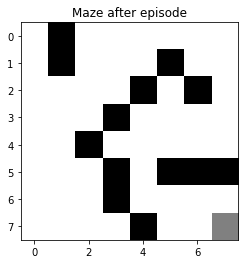

Epoch: 860/999 | Loss: 0.0005 | Episodes: 861 | Win count: 841 | Win rate: 1.000 | time: 1.95 hours
Loss:  0.0005732483987230808
Loss:  0.0005226855137152597
Loss:  0.0006966552173253149
Loss:  0.00044163980055600405
Loss:  0.00020592189684975892
Loss:  0.0004978000361006707
Loss:  0.0010805962956510484
Loss:  0.0004454761801753193
Loss:  0.0005369656282709911
Loss:  0.0007079920615069568
Loss:  0.00047357015137095004
Loss:  0.000738474220270291
Loss:  0.001176444231532514
Loss:  0.0007334884721785784
Loss:  0.0004790479288203642
Loss:  0.00040210278530139476
Loss:  0.0012976202415302396
Loss:  0.0004711111687356606


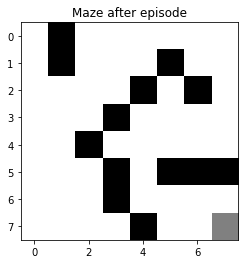

Epoch: 861/999 | Loss: 0.0005 | Episodes: 862 | Win count: 842 | Win rate: 1.000 | time: 1.95 hours
Loss:  0.0008382821979466826
Loss:  0.0005518950201803818
Loss:  0.0007092781888786703
Loss:  0.0006945384011487477
Loss:  0.0003517375298542902
Loss:  0.0004292999947210774
Loss:  0.0004596091130224522
Loss:  0.0002420380769763142


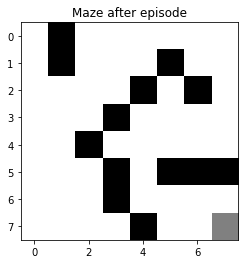

Epoch: 862/999 | Loss: 0.0002 | Episodes: 863 | Win count: 843 | Win rate: 1.000 | time: 1.95 hours
Loss:  0.0007138910295907408
Loss:  0.0007469620322808623
Loss:  0.0008532181964255869
Loss:  0.0006638547420152463
Loss:  0.0004927981790388003
Loss:  0.0005101542774355039
Loss:  0.0005475606230902486
Loss:  0.0007989644363988191
Loss:  0.0006895886035636067
Loss:  0.0006507827347377315
Loss:  0.00026284504565410316
Loss:  0.00038779845635872334
Loss:  0.0005305258018779568
Loss:  0.0005817205965286121
Loss:  0.0005632958491332829
Loss:  0.0006559866742463782
Loss:  0.0004301246372051537
Loss:  0.0002581971202744171
Loss:  0.0008799345814622939
Loss:  0.0009831575735006481
Loss:  0.00039700447814539075
Loss:  0.0004738643328892067
Loss:  0.0005104794690851122
Loss:  0.0005592799570877105
Loss:  0.0008557515975553542
Loss:  0.00021406218729680404
Loss:  0.0003954508574679494


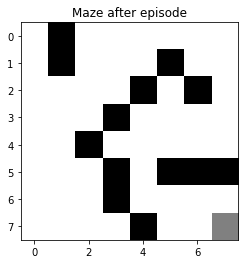

Epoch: 863/999 | Loss: 0.0004 | Episodes: 864 | Win count: 844 | Win rate: 1.000 | time: 1.96 hours
Loss:  0.0004887264949502423
Loss:  0.0003989301767433062
Loss:  0.0004987645079381764
Loss:  0.0006658144993707538
Loss:  0.0008358275808859617
Loss:  0.0005259886384010315
Loss:  0.0003978661115979776
Loss:  0.00021885520982323214
Loss:  0.0002490590268280357
Loss:  0.00045822354150004685


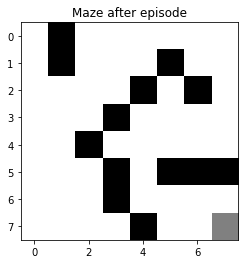

Epoch: 864/999 | Loss: 0.0005 | Episodes: 865 | Win count: 845 | Win rate: 1.000 | time: 1.96 hours
Loss:  0.000405798273277469
Loss:  0.00038100369420135394
Loss:  0.00035006905090995133
Loss:  0.0007137577922549099
Loss:  0.0002946158274426125
Loss:  0.00018687093688640743
Loss:  0.00016732088988646865
Loss:  0.00015793503553140908
Loss:  0.00040249753510579467
Loss:  0.0005388667632360011
Loss:  0.0006975755968596786
Loss:  0.0004300518485251814
Loss:  0.0005912202323088422
Loss:  0.0003519730089465156
Loss:  0.0003969426325056702
Loss:  0.00032055187330115587
Loss:  0.0004331539385020733
Loss:  0.00034451804822310805
Loss:  0.00041847188549581915
Loss:  0.0005457491788547486
Loss:  0.0004295411199564114
Loss:  0.0003412889054743573
Loss:  0.0003156827442580834
Loss:  0.0005371313891373575
Loss:  0.0004624266584869474
Loss:  0.00020653683168347925
Loss:  0.0002864242997020483


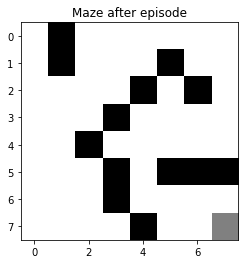

Epoch: 865/999 | Loss: 0.0003 | Episodes: 866 | Win count: 846 | Win rate: 1.000 | time: 1.96 hours
Loss:  0.0002594982652226463
Loss:  0.0003689508594106883
Loss:  0.0002472508203936741
Loss:  0.0004941046645399183
Loss:  0.0003888155333697796
Loss:  0.0005654144333675504
Loss:  0.00041190130286850035
Loss:  0.00043415697291493416
Loss:  0.0002174830442527309
Loss:  0.0005428136973932851
Loss:  0.0006540970352943987
Loss:  0.00019478080503176898
Loss:  0.00020629577920772135
Loss:  0.0006879410648252815
Loss:  0.00043318771349731833


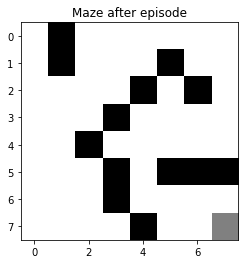

Epoch: 866/999 | Loss: 0.0004 | Episodes: 867 | Win count: 847 | Win rate: 1.000 | time: 1.96 hours
Loss:  0.0002458283051964827
Loss:  0.00036265820017433725


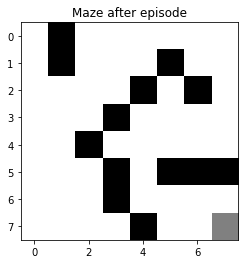

Epoch: 867/999 | Loss: 0.0004 | Episodes: 868 | Win count: 848 | Win rate: 1.000 | time: 1.96 hours
Loss:  0.00030780837550992146
Loss:  0.0007358266884693876
Loss:  0.00019093640003120527
Loss:  0.00054406255367212
Loss:  0.0003964728384744376
Loss:  0.0004920747014693916
Loss:  0.00032274680415866897
Loss:  0.0003395997919142246
Loss:  0.00045553510426543653
Loss:  0.0005535426025744528
Loss:  0.0002515812811907381
Loss:  0.0005682739865733311
Loss:  0.0006125379804871045
Loss:  0.0005778009071946144
Loss:  0.0004679230914916843
Loss:  0.00023170739586930722
Loss:  0.0003784186119446531


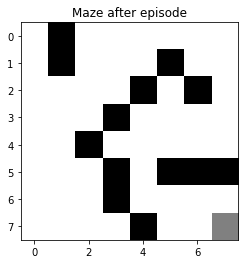

Epoch: 868/999 | Loss: 0.0004 | Episodes: 869 | Win count: 849 | Win rate: 1.000 | time: 1.96 hours
Loss:  0.00016081357171060517
Loss:  0.00040762583375908434
Loss:  0.00013302781371749006
Loss:  0.00037261764373397455
Loss:  0.00014366956929734442
Loss:  0.0002065522494376637
Loss:  0.0005727100651711226
Loss:  0.00036629827809520066
Loss:  0.0005298159667290747
Loss:  0.0002695428265724331
Loss:  0.0004272091464372352
Loss:  0.00028874951385660097
Loss:  0.0006162328936625272
Loss:  0.00012181901547592133
Loss:  0.00034658564254641533
Loss:  0.00013152109022485092
Loss:  0.00027643938301480375
Loss:  0.00044177107338327914
Loss:  0.0001585294921824243
Loss:  0.00022688972239848226
Loss:  0.0002630956551001873
Loss:  0.0003935541462851688
Loss:  0.0002972287038573995
Loss:  0.0003466268244665116
Loss:  9.167640928353649e-05
Loss:  0.00025750025815796107
Loss:  0.00012157697528891731
Loss:  0.0002318687256774865


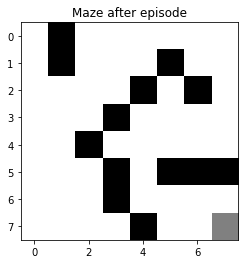

Epoch: 869/999 | Loss: 0.0002 | Episodes: 870 | Win count: 850 | Win rate: 1.000 | time: 1.96 hours
Loss:  0.00040341640124097466
Loss:  0.0004032114811707288
Loss:  0.0003194507153239101
Loss:  0.00045480374683393165
Loss:  0.0002922952699009329
Loss:  0.0005377237102948129
Loss:  0.0005271710688248277
Loss:  0.00046692836622241884


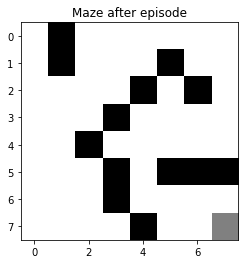

Epoch: 870/999 | Loss: 0.0005 | Episodes: 871 | Win count: 851 | Win rate: 1.000 | time: 1.97 hours
Loss:  0.0007455603627022356
Loss:  0.00037567828985629603
Loss:  0.0003402160728001036
Loss:  0.00014441987514146604
Loss:  0.0006330055839498527
Loss:  0.0003025918558705598
Loss:  0.00075605942402035
Loss:  0.000307016191072762


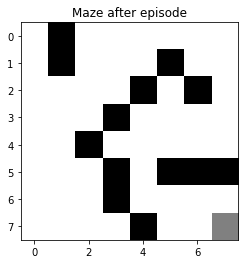

Epoch: 871/999 | Loss: 0.0003 | Episodes: 872 | Win count: 852 | Win rate: 1.000 | time: 1.97 hours
Loss:  0.0007173083431553096
Loss:  0.00032208433185587637
Loss:  0.0003699008375406265
Loss:  0.00017961827688850462
Loss:  0.00030014239018782973
Loss:  0.0001779580779839307
Loss:  5.0367923904559575e-05
Loss:  0.0002471797706675716
Loss:  0.00020877994393231347
Loss:  0.00013916399257141165
Loss:  0.0002458154922351241
Loss:  5.5600649830012117e-05
Loss:  9.4240187536343e-05
Loss:  0.0003299399832030758
Loss:  0.0002593542158138007
Loss:  0.0004907128241029568


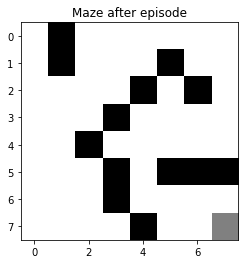

Epoch: 872/999 | Loss: 0.0005 | Episodes: 873 | Win count: 853 | Win rate: 1.000 | time: 1.97 hours
Loss:  0.00010374573321314529
Loss:  0.00043709599412977695
Loss:  0.00010594449122436345
Loss:  0.00020451191812753677
Loss:  0.0004415289295138791
Loss:  0.00020262508769519627
Loss:  0.00021755813213530928
Loss:  6.736606519552879e-05
Loss:  0.00026225475448882207
Loss:  0.00027467017935123295
Loss:  0.00029356242157518864
Loss:  0.0005178035789867863
Loss:  0.0004886969254584983
Loss:  0.0005734183505410329
Loss:  0.0006957963632885367
Loss:  0.0001111999008571729
Loss:  0.0006990375695750117
Loss:  0.0003525552019709721
Loss:  0.0005060895418864675
Loss:  0.00040916228317655623
Loss:  0.0005073701177025214
Loss:  0.00035345678770681843
Loss:  0.0005446867580758408
Loss:  0.0007956437766551971
Loss:  0.0006446105544455349
Loss:  0.00059519823116716
Loss:  0.0005072641797596589
Loss:  0.000539284767000936
Loss:  0.000686459825374186
Loss:  0.0004980812373105437
Loss:  0.00056426681112

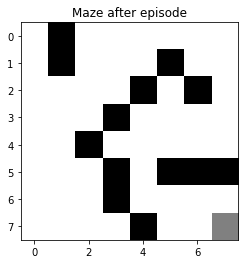

Epoch: 873/999 | Loss: 0.0007 | Episodes: 874 | Win count: 854 | Win rate: 1.000 | time: 1.98 hours
Loss:  0.0008044062415137887
Loss:  0.0007701738795731217
Loss:  0.0005197014543227851
Loss:  0.00037919910391792655
Loss:  0.000481474693515338
Loss:  0.0008339599589817226
Loss:  0.0003940651804441586
Loss:  0.000301132386084646
Loss:  0.00046481896424666047
Loss:  0.00048188286018557847
Loss:  0.0006738179799867794
Loss:  0.0004799639864359051
Loss:  0.00030181084002833813
Loss:  0.0007825107022654265
Loss:  0.0005071552004665136
Loss:  0.0006190316489664838
Loss:  0.0007319881115108728
Loss:  0.00039597707291250117
Loss:  0.00040881970198825
Loss:  0.00023299107851926237
Loss:  0.0006155739829409868
Loss:  0.00042354869947303087
Loss:  0.0003577526949811727
Loss:  0.00028372983797453344


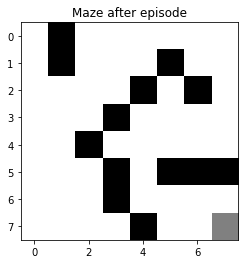

Epoch: 874/999 | Loss: 0.0003 | Episodes: 875 | Win count: 855 | Win rate: 1.000 | time: 1.98 hours
Loss:  0.0003011610169778578
Loss:  0.00031378311541629955
Loss:  0.00045154799590818584
Loss:  0.0005682995833922178
Loss:  0.00033943304151762277
Loss:  0.00047462542715948075
Loss:  0.000525658339029178
Loss:  0.000633993447991088
Loss:  0.0007993200561031699
Loss:  0.00038175067311385646
Loss:  0.00033236329909414053
Loss:  0.0004987971915397793
Loss:  0.0005745584494434297
Loss:  0.0003722272740560584
Loss:  0.0003664237883640453
Loss:  0.00033729503775248304
Loss:  0.0006009083008393645
Loss:  0.0005546845204662532
Loss:  0.0007296421099454165
Loss:  0.0002994094102177769
Loss:  0.0003520906902849674
Loss:  0.00030446413438767195
Loss:  0.0004282843292457983
Loss:  0.0003103527124039829
Loss:  0.00043797329999506474
Loss:  0.00028224659035913646
Loss:  0.0004939154023304582
Loss:  0.0005000413875677623


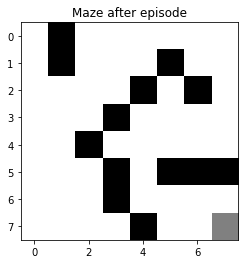

Epoch: 875/999 | Loss: 0.0005 | Episodes: 876 | Win count: 856 | Win rate: 1.000 | time: 1.98 hours
Loss:  0.00044100113154854625
Loss:  0.00028068611572962254
Loss:  0.00011320409248583019
Loss:  0.0004667769608204253
Loss:  0.0005392929742811248
Loss:  0.0005234975396888331
Loss:  0.0006008289201417938
Loss:  0.0007165094430092722
Loss:  0.0003699481603689492
Loss:  0.0006362528947647661
Loss:  0.00025609065050957724
Loss:  0.00047939439537003636
Loss:  0.000387537176720798
Loss:  0.0005447444564197212
Loss:  0.00021182576165301725
Loss:  0.00024022724392125383
Loss:  0.0003941387985832989
Loss:  0.00028740162815665826
Loss:  0.0003560316763469018
Loss:  0.0005592702655121684
Loss:  0.000503374234540388
Loss:  0.00022594457550439984
Loss:  0.0005880816897843033
Loss:  0.0006115245050750673
Loss:  0.0005275211879052222
Loss:  0.00034475320717319846
Loss:  0.0004622839915100485
Loss:  0.000428854844358284


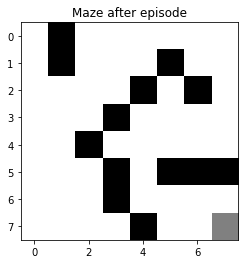

Epoch: 876/999 | Loss: 0.0004 | Episodes: 877 | Win count: 857 | Win rate: 1.000 | time: 1.98 hours
Loss:  0.00015465782053070143
Loss:  0.0004410114561324008
Loss:  0.0004701803991338238
Loss:  0.0003327057129354216
Loss:  0.0002954860538011417
Loss:  0.0004629408795153722
Loss:  0.00025021936744451523
Loss:  0.0005720635817851871
Loss:  0.0001658841356402263
Loss:  0.0005604603793472052
Loss:  0.00039835923234932125
Loss:  0.0004800347815034911
Loss:  0.0003801275888690725
Loss:  0.00042017187661258504
Loss:  0.00042322621447965503
Loss:  0.0003893211396643892
Loss:  0.0007739413122180849
Loss:  0.00045079682604409754
Loss:  0.0005815103359054774
Loss:  0.0007058194896671921
Loss:  0.000444619741756469
Loss:  0.0006051702075637877
Loss:  0.0006371514173224568
Loss:  0.000536220584763214
Loss:  0.0007290159992408007
Loss:  0.00046309946628753096
Loss:  0.00038645658059976995
Loss:  0.0007254433876369148
Loss:  0.0006848579796496779
Loss:  0.0005238931480562314
Loss:  0.000273600220680

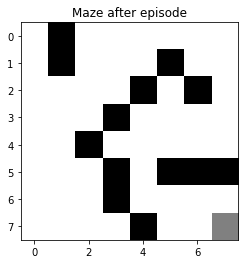

Epoch: 877/999 | Loss: 0.0004 | Episodes: 878 | Win count: 858 | Win rate: 1.000 | time: 1.99 hours
Loss:  0.000501362927025184
Loss:  0.00048202798643615097
Loss:  0.00045681434858124703
Loss:  0.0002450522151775658
Loss:  0.0005961614806437865
Loss:  0.0005754574958700687
Loss:  0.0004732798406621441
Loss:  0.0003170468407915905
Loss:  0.0003966740478063002
Loss:  9.782191773410887e-05
Loss:  0.0005166596383787692
Loss:  0.00045559456339105964
Loss:  0.00041399923793505877
Loss:  0.00045981274161022156
Loss:  0.00042905271402560174
Loss:  0.0004548012948362157
Loss:  0.0008022226393222809
Loss:  0.00034282733395230025
Loss:  0.0002820551744662225
Loss:  0.00037926693039480597
Loss:  0.0002899902901845053
Loss:  0.00031986542308004573
Loss:  0.0004274160019122064
Loss:  0.00035825844679493457
Loss:  0.00030540280567947775
Loss:  0.0005830570589751005
Loss:  0.000529221331817098
Loss:  0.0004886011447524652
Loss:  0.0001993634650716558
Loss:  0.0003286697537987493


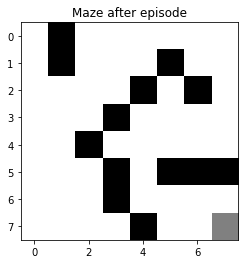

Epoch: 878/999 | Loss: 0.0003 | Episodes: 879 | Win count: 859 | Win rate: 1.000 | time: 1.99 hours
Loss:  0.00029206638646428473
Loss:  0.00037827325286343694
Loss:  0.0003037776405108161
Loss:  0.0006284958217293024
Loss:  0.0002918892350862734
Loss:  0.0006852288206573576
Loss:  0.0006226946134120226
Loss:  0.0005107198667246848
Loss:  0.0005123672308400273
Loss:  0.0004813214181922376
Loss:  0.00027350409800419584
Loss:  0.00032417270995210856
Loss:  0.00044577778317034245
Loss:  0.0006602920038858429
Loss:  0.00040319334948435426


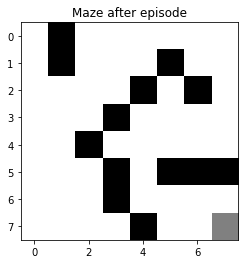

Epoch: 879/999 | Loss: 0.0004 | Episodes: 880 | Win count: 860 | Win rate: 1.000 | time: 1.99 hours
Loss:  0.0006692119350191206
Loss:  0.00037089071702212095
Loss:  0.0004058634804096073
Loss:  0.0003379956469871104
Loss:  0.0008394063333980739
Loss:  0.00025243436539312825
Loss:  0.0005650445382343605
Loss:  0.0006491259264294058
Loss:  0.0006523643969558179
Loss:  0.0005556083633564413
Loss:  0.0002906835434259847
Loss:  0.0009537755977362394
Loss:  0.0006122693739598617
Loss:  0.0005289068358251825
Loss:  0.000611426803516224
Loss:  0.00032077213836601004
Loss:  0.00039143972389865667
Loss:  0.0006834299128968269
Loss:  0.0008238949230872095
Loss:  0.0003817316683125682
Loss:  0.00030343933758558705
Loss:  0.00038049850263632834
Loss:  0.00032203157752519473
Loss:  0.0004101349622942507
Loss:  0.000564645990380086
Loss:  0.00030038144905120134


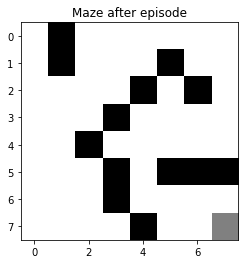

Epoch: 880/999 | Loss: 0.0003 | Episodes: 881 | Win count: 861 | Win rate: 1.000 | time: 2.00 hours
Loss:  0.0005439826927613467
Loss:  0.0010691856732591987
Loss:  0.00038359870086424053
Loss:  0.00046064819616731256
Loss:  0.00024387839948758483
Loss:  0.0004950956499669701
Loss:  0.0003000787110067904
Loss:  0.0005229901726124808
Loss:  0.0005918388487771153
Loss:  0.00038302154280245304
Loss:  0.0005660053284373134
Loss:  0.0004934347671223804
Loss:  0.0004620421677827835
Loss:  0.0002758466507657431
Loss:  0.0005092818464618176
Loss:  0.0004709505883511156
Loss:  0.00023703516490058973
Loss:  0.0005927479069214314
Loss:  0.00020631141524063423
Loss:  0.0003056589157495182
Loss:  0.0006229736027307808
Loss:  0.0006273144535953179
Loss:  0.0010407872614450753
Loss:  0.0006322305562207475
Loss:  0.0003384596057003364
Loss:  0.0003447532362770289
Loss:  0.0006692919123452157


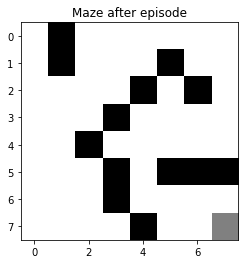

Epoch: 881/999 | Loss: 0.0007 | Episodes: 882 | Win count: 862 | Win rate: 1.000 | time: 2.00 hours
Loss:  0.000499817862873897
Loss:  0.00046399401617236435
Loss:  0.0005753419536631554
Loss:  0.0006041874912625644
Loss:  0.0003234760297345929
Loss:  0.0004496426845435053
Loss:  0.00021012112847529352
Loss:  0.0006076242862036452
Loss:  0.0004511405568337068
Loss:  0.0004644649598049
Loss:  0.00035114248748868704
Loss:  0.00032997559173963964
Loss:  0.0004802122130058706
Loss:  0.0007309691718546674


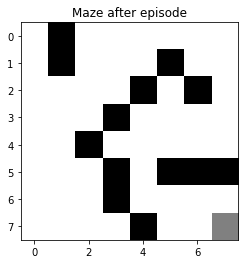

Epoch: 882/999 | Loss: 0.0007 | Episodes: 883 | Win count: 863 | Win rate: 1.000 | time: 2.00 hours
Loss:  0.0003282164761913009
Loss:  0.0003368070174474269
Loss:  0.0005367686098907143
Loss:  0.0005365596734918654
Loss:  0.0004942289233440533
Loss:  0.0006971244001761079
Loss:  0.0005936890956945717
Loss:  0.0006347872840706259
Loss:  0.00023680258163949475
Loss:  0.0005537746474146843
Loss:  0.0001088654826162383
Loss:  0.0003913441687473096
Loss:  0.00013328520799404941
Loss:  0.00036736780020873994
Loss:  0.00032022272353060544
Loss:  0.00022980623180046678


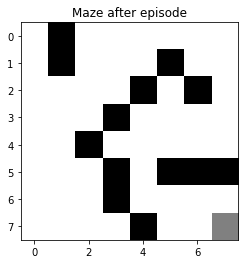

Epoch: 883/999 | Loss: 0.0002 | Episodes: 884 | Win count: 864 | Win rate: 1.000 | time: 2.00 hours
Loss:  0.00035430343268672004
Loss:  0.00016035755106713623
Loss:  0.0002844156988430768
Loss:  0.0006508851074613631
Loss:  0.00043052572436863557
Loss:  0.00032571614428889006
Loss:  0.0006047869683243334
Loss:  0.0004889071569778025
Loss:  0.0007176223443821073
Loss:  0.0003729913441929966
Loss:  0.00037929261452518404
Loss:  9.729490557219833e-05
Loss:  0.0003413688173168339
Loss:  0.0002715009031817317
Loss:  0.0005869290325790644


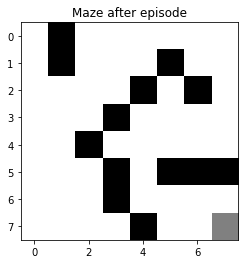

Epoch: 884/999 | Loss: 0.0006 | Episodes: 885 | Win count: 865 | Win rate: 1.000 | time: 2.00 hours
Loss:  0.0003922892065020278
Loss:  0.00020258807489881292
Loss:  0.0007645711593795568
Loss:  0.0003476489073364064
Loss:  0.00046045433555264026
Loss:  0.00045789631258230656
Loss:  0.0003582511126296595
Loss:  0.0007201491971500218
Loss:  0.0004418881144374609
Loss:  0.0009218801278620958
Loss:  0.0008923298155423254
Loss:  0.0003767255402635783
Loss:  0.000460063194623217
Loss:  0.00046991833369247615
Loss:  0.0005073917272966355
Loss:  0.0001547404499433469
Loss:  0.0007091462175594643
Loss:  0.0004972047172486782
Loss:  0.00035804047365672886
Loss:  0.0002798683744913433
Loss:  0.0004937375924782827
Loss:  0.0003251516172895208
Loss:  0.0005690742982551455
Loss:  0.00021123075930518098
Loss:  0.0003885575570166111


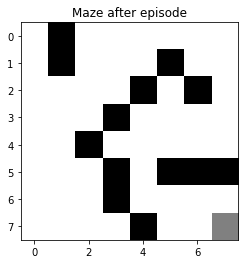

Epoch: 885/999 | Loss: 0.0004 | Episodes: 886 | Win count: 866 | Win rate: 1.000 | time: 2.01 hours
Loss:  0.0003401497669983655
Loss:  0.0010377188446000218
Loss:  0.0007923944795038551
Loss:  0.00034281882108189166
Loss:  0.0005059091781731695
Loss:  0.0005325336387613788
Loss:  0.0006545710784848779
Loss:  0.00036692032881546766
Loss:  0.00032974884379655123
Loss:  0.0006009223943692632
Loss:  0.00042929807386826724
Loss:  0.0002994523529196158
Loss:  0.00030633788264822215
Loss:  0.0001835940929595381
Loss:  0.0005793425516458228
Loss:  0.0005339669005479664
Loss:  0.0003601050848374143
Loss:  0.0005031692271586508
Loss:  0.00011542871288838796
Loss:  0.0009134892025031149
Loss:  0.0003608202241593972
Loss:  0.0005839333171024919
Loss:  0.0011171618825756013
Loss:  0.0003318185481475666
Loss:  0.0003687941643875092
Loss:  0.00023950579634401947
Loss:  0.0004048206174047664
Loss:  0.0006493734254036099
Loss:  0.0004943174717482179
Loss:  0.00036321587685961276


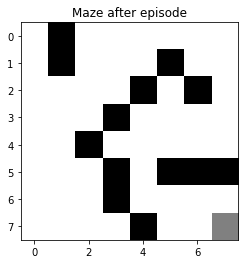

Epoch: 886/999 | Loss: 0.0004 | Episodes: 887 | Win count: 867 | Win rate: 1.000 | time: 2.01 hours
Loss:  0.00021148237283341587
Loss:  0.0005562825972447172
Loss:  0.0006301666726358235
Loss:  0.0006141588528407738
Loss:  0.0002810815203702077
Loss:  0.0003457722195889801
Loss:  0.0002267200907226652
Loss:  0.0006762622215319425
Loss:  0.00047497414925601333
Loss:  0.0003277947907918133
Loss:  0.00037745774898212403
Loss:  0.0007925222162157297
Loss:  0.0006644964742008597
Loss:  0.0006637264450546354
Loss:  0.0007025161758065224
Loss:  0.0007691544305998832
Loss:  0.00036641527549363673
Loss:  0.0003124755203316454
Loss:  0.0005318584808264859
Loss:  0.00024839507386786863
Loss:  0.0005580751749221236
Loss:  0.00024758702784311026
Loss:  0.00043007398926420137
Loss:  0.00036723371886182576
Loss:  0.000516334348503733


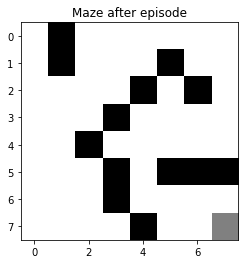

Epoch: 887/999 | Loss: 0.0005 | Episodes: 888 | Win count: 868 | Win rate: 1.000 | time: 2.01 hours
Loss:  0.00045050642802380025
Loss:  0.000497622910188511
Loss:  0.0006042762688593939
Loss:  0.0004086884146090597
Loss:  0.0006175145390443504
Loss:  0.00027354212215868756
Loss:  0.000194698732229881
Loss:  0.0006103820924181491
Loss:  0.0006081419705878943
Loss:  0.0004833374550798908
Loss:  0.0008137064432958141
Loss:  0.0008111955248750746
Loss:  0.0005521994171431288
Loss:  0.00047152054321486503
Loss:  0.00058302357501816


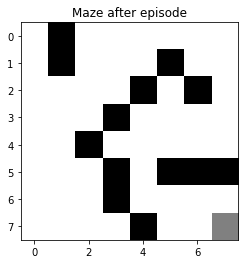

Epoch: 888/999 | Loss: 0.0006 | Episodes: 889 | Win count: 869 | Win rate: 1.000 | time: 2.02 hours
Loss:  0.0003069576123380102
Loss:  0.0003029406216228381
Loss:  0.00035372452111914754
Loss:  0.0006438828422687948
Loss:  0.0003528476372594014
Loss:  8.076478843577206e-05
Loss:  0.00024415281950496137
Loss:  0.0002752497384790331
Loss:  0.00031244037381839007
Loss:  0.0004364050691947341
Loss:  0.0005768579867435619
Loss:  0.0003027428756467998
Loss:  0.0005562115111388266
Loss:  0.00031115353340283036
Loss:  0.00010229713370790705
Loss:  0.0004842857160838321
Loss:  0.00041484078974463046
Loss:  0.00030333505128510296
Loss:  0.0003039336297661066
Loss:  0.0005088195903226733
Loss:  0.00041703540773596615
Loss:  0.00041030963984667324
Loss:  0.0006410853311535902
Loss:  0.00015263589739333838
Loss:  0.0002581113512860611


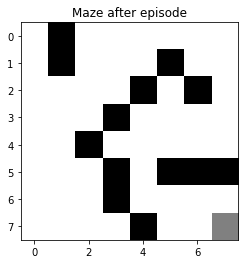

Epoch: 889/999 | Loss: 0.0003 | Episodes: 890 | Win count: 870 | Win rate: 1.000 | time: 2.02 hours
Loss:  0.000560494139790535
Loss:  0.00041791112744249403
Loss:  0.00042358199425507337
Loss:  0.0007354281260631979
Loss:  0.0005046247679274529
Loss:  0.0004126047424506396
Loss:  0.0004849709657719359
Loss:  0.0005953003055765294
Loss:  0.00032753408231656067
Loss:  8.011801401153207e-05
Loss:  0.00015008346963441
Loss:  0.0008249379461631179
Loss:  0.0004937766352668405
Loss:  0.0004025811795145273
Loss:  0.0004195904766675085
Loss:  0.0003036007983610034
Loss:  0.0003642217197921127
Loss:  0.0004854229191550985
Loss:  0.0005262219783617184
Loss:  0.00021643519721692428
Loss:  0.00047855416778475046
Loss:  0.0005035860813222826


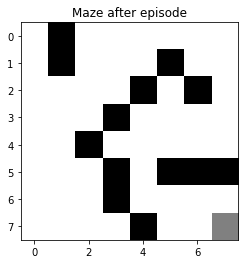

Epoch: 890/999 | Loss: 0.0005 | Episodes: 891 | Win count: 871 | Win rate: 1.000 | time: 2.02 hours
Loss:  0.0002195134584326297
Loss:  0.0002337590958632063
Loss:  0.0005443109366751742
Loss:  0.0005597167619271204
Loss:  0.000397777374018915
Loss:  0.0003233921015635133
Loss:  0.0005167654016986489
Loss:  0.0004042206910526147
Loss:  0.00048200730270764325
Loss:  0.00023877350395196117
Loss:  0.0005335557216312736
Loss:  0.0002318162369192578
Loss:  0.0003483614418655634
Loss:  0.0008156767871696502
Loss:  0.000632415059953928
Loss:  0.0004488244594540447
Loss:  0.0004144303820794448
Loss:  0.0004982022801414132
Loss:  0.000522769485542085
Loss:  0.0005074678338132799
Loss:  0.0003407100302865729
Loss:  0.0005798001657240093
Loss:  0.00017008262511808425


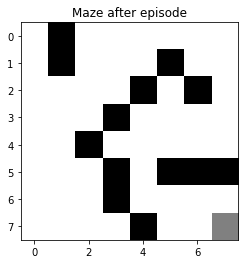

Epoch: 891/999 | Loss: 0.0002 | Episodes: 892 | Win count: 872 | Win rate: 1.000 | time: 2.02 hours
Loss:  0.0001948319550137967
Loss:  0.0002652686816873029
Loss:  0.0006034960970282555
Loss:  0.00038689297798555344
Loss:  0.00037123954825801775
Loss:  0.0004834900319110602
Loss:  0.00035853328881785274
Loss:  0.0002943469662568532
Loss:  0.0007146186690079048
Loss:  0.000712941910023801
Loss:  0.00039079689304344356
Loss:  0.0005480340987560339
Loss:  0.0002957196702482179
Loss:  0.000440324773080647
Loss:  0.000362975726602599
Loss:  0.00045267950918059796
Loss:  0.00027330408920533955
Loss:  0.00011696592264343053
Loss:  0.0004473370063351467
Loss:  0.00037682169931940734
Loss:  0.0003476826459518634


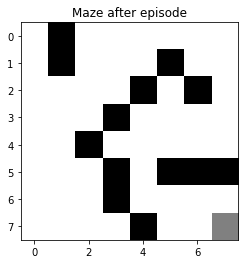

Epoch: 892/999 | Loss: 0.0003 | Episodes: 893 | Win count: 873 | Win rate: 1.000 | time: 2.02 hours
Loss:  0.0001366428805340547
Loss:  0.00018061513947031926
Loss:  0.000232076745305676
Loss:  0.0003389450503163971
Loss:  0.0003211409493815154
Loss:  0.00031514145666733384
Loss:  0.0003073261468671262
Loss:  0.00042571432277327403
Loss:  0.0002202663745265454
Loss:  0.00030953253735788167
Loss:  0.00019918342877645046
Loss:  0.0002938834368251264
Loss:  0.0003661811351776123
Loss:  0.0003300397911516484
Loss:  0.0001414634880347876
Loss:  0.00038653895535389893
Loss:  0.00011359815835021436
Loss:  0.0003500024613458663
Loss:  0.0001067572011379525


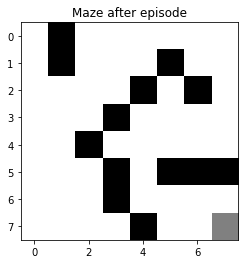

Epoch: 893/999 | Loss: 0.0001 | Episodes: 894 | Win count: 874 | Win rate: 1.000 | time: 2.02 hours
Loss:  0.0005203929758863524
Loss:  0.000179867070983164
Loss:  0.0004699964338215068
Loss:  0.0002583512614364736
Loss:  0.00025166359409922734


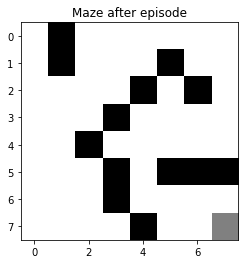

Epoch: 894/999 | Loss: 0.0003 | Episodes: 895 | Win count: 875 | Win rate: 1.000 | time: 2.02 hours
Loss:  0.00027019342815037817
Loss:  0.0001953474711626768
Loss:  0.00019372377937543206
Loss:  0.0005081699346192181
Loss:  0.0004614153294824064
Loss:  0.00034028403752017766
Loss:  0.0006401930877473205
Loss:  0.0005133578379172832
Loss:  8.432791946688667e-05
Loss:  0.0001326551464444492
Loss:  0.0004438412724994123
Loss:  5.445727765618358e-05
Loss:  0.00034499687899369746
Loss:  0.0005175408878130838
Loss:  0.000500235881190747
Loss:  0.00027480254357215017
Loss:  0.00038791152474004775
Loss:  6.987650704104453e-05
Loss:  0.00038460674113593996
Loss:  0.00023118709214031696
Loss:  0.0005084507574792951
Loss:  0.00041665240132715553
Loss:  0.00014765634659852367
Loss:  0.0003861402947222814
Loss:  0.0002365118943998823
Loss:  0.0006452286979765631
Loss:  0.00015297049321816303
Loss:  0.00030791450990363955
Loss:  0.0003754121717065573
Loss:  0.00027292058803141117
Loss:  0.000341026

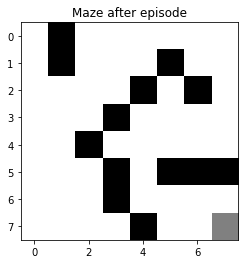

Epoch: 895/999 | Loss: 0.0003 | Episodes: 896 | Win count: 876 | Win rate: 1.000 | time: 2.02 hours
Loss:  0.0006518648297060281
Loss:  0.00040651812741998583
Loss:  0.0003024126490345225
Loss:  0.0004209708276903257
Loss:  0.0005021704564569518
Loss:  0.00022121849906397983
Loss:  0.0006309524978860281
Loss:  0.0003261087986174971
Loss:  0.00020670688536483794
Loss:  0.0005720252665923908
Loss:  0.0005327149701770395
Loss:  0.0003830933455901686
Loss:  0.00045942440920043737
Loss:  0.0011218372383154929
Loss:  0.0004566412535496056
Loss:  0.0005479773390106857
Loss:  0.00040427781641483307
Loss:  0.0005567122716456652
Loss:  0.0008663868356961757
Loss:  0.0005808147834613919
Loss:  0.00034731053528958
Loss:  0.0006700861849822104
Loss:  0.00037338666152209044
Loss:  0.0006247776618693024
Loss:  0.0011027444852516055
Loss:  0.0007111727318260819
Loss:  0.0005405129195423797
Loss:  0.00032622557773720473
Loss:  0.0005484906141646206
Loss:  0.0006910887896083295
Loss:  0.0005742001667385

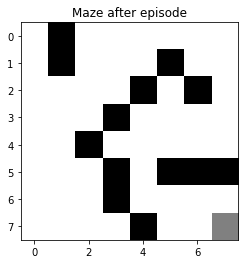

Epoch: 896/999 | Loss: 0.0007 | Episodes: 897 | Win count: 877 | Win rate: 1.000 | time: 2.03 hours
Loss:  0.00048657978186383843
Loss:  0.00018051452570944093
Loss:  0.00024661583302076906
Loss:  0.0005715150618925691
Loss:  0.0007111182203516364
Loss:  0.0006723578699165955
Loss:  0.0005801533989142627
Loss:  0.0005332989385351539
Loss:  0.0007611728506162763
Loss:  0.0003537088487064466
Loss:  0.0002870254247682169
Loss:  0.0005812702584080398
Loss:  0.0004249036282999441
Loss:  0.0001798728117137216
Loss:  9.236804908141494e-05
Loss:  0.00023224476171890274
Loss:  0.00045772831072099507
Loss:  0.0004887561517534778
Loss:  0.0004370159294921905
Loss:  0.00043070880929008126
Loss:  0.00047340036326204427
Loss:  0.00018266936240252107
Loss:  0.000527706477441825
Loss:  0.0004862298665102571
Loss:  0.000454892564448528
Loss:  0.0006962953339098021


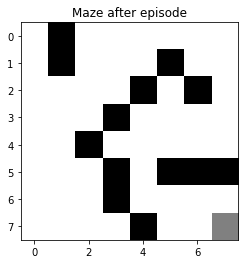

Epoch: 897/999 | Loss: 0.0007 | Episodes: 898 | Win count: 878 | Win rate: 1.000 | time: 2.03 hours
Loss:  0.0005402939859777689
Loss:  0.000630619382718578
Loss:  0.0004744500038214028
Loss:  0.0003108586752205156
Loss:  0.00043267720320727676
Loss:  0.0002872828772524372
Loss:  0.0005622842581942677
Loss:  0.00014607710181735456
Loss:  0.000714571971911937


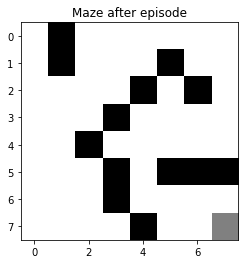

Epoch: 898/999 | Loss: 0.0007 | Episodes: 899 | Win count: 879 | Win rate: 1.000 | time: 2.03 hours
Loss:  0.00022054486180422828
Loss:  7.767933857394382e-05
Loss:  0.0006768877792637795
Loss:  0.00035125354770570993
Loss:  0.0004836043663090095
Loss:  0.0003699175977089908
Loss:  0.0006158743490232155
Loss:  0.0004535402258625254
Loss:  0.0008109324844554067
Loss:  0.000283207991742529
Loss:  0.0001536250056233257
Loss:  0.00039039635157678276
Loss:  8.751094355829991e-05
Loss:  0.0004265935240255203
Loss:  0.0003111705736955628
Loss:  0.00023795669403625652
Loss:  0.0007622858393006027
Loss:  0.00046238439972512424
Loss:  0.0006212675070855767
Loss:  0.0002787340199574828
Loss:  0.0007330692315008491
Loss:  0.0003739297899301164
Loss:  0.0007944043609313667
Loss:  0.0005078604735899717
Loss:  0.00028748616750817746
Loss:  0.00041056962800212204
Loss:  0.00018628693942446262
Loss:  0.00022204140987014398
Loss:  0.0002892322445404716
Loss:  0.00047902617370709777


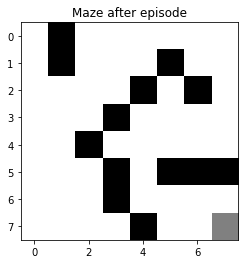

Epoch: 899/999 | Loss: 0.0005 | Episodes: 900 | Win count: 880 | Win rate: 1.000 | time: 2.03 hours
Loss:  0.00014663493493571877
Loss:  0.0006053091783542186
Loss:  0.00016898247122298926
Loss:  0.00035201704304199666
Loss:  0.0003534684801707044
Loss:  0.00022672822524327785
Loss:  0.00039831500907894224


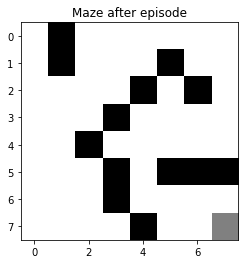

Epoch: 900/999 | Loss: 0.0004 | Episodes: 901 | Win count: 881 | Win rate: 1.000 | time: 2.03 hours
Loss:  0.00037935495493002236
Loss:  0.00020596099057001993
Loss:  0.0002796347107505426
Loss:  0.00021997624571667984
Loss:  0.00015496695414185524
Loss:  8.392855670535937e-05
Loss:  0.0002475205765222199
Loss:  0.0005285389088385273
Loss:  0.00018870837811846286
Loss:  0.0004505402030190453
Loss:  0.0002847791984095238
Loss:  0.0006096247234381735
Loss:  0.00014687454495287966
Loss:  0.0001164316818176303
Loss:  0.00042813656909856945
Loss:  5.830283589602914e-05
Loss:  3.1400078114529606e-05
Loss:  0.00023746899023535661
Loss:  0.0004277885745977983
Loss:  0.00026837732730200514
Loss:  0.00019915802113246173
Loss:  0.0004870658158324659
Loss:  0.0005810370785184205
Loss:  0.0004338353901403025
Loss:  0.00041848531691357493
Loss:  0.00030981221061665565
Loss:  0.00041851600690279156
Loss:  0.0003052388710784726
Loss:  0.000619858576101251


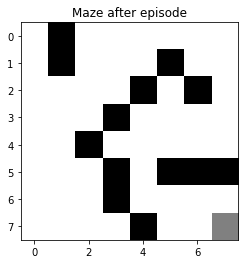

Epoch: 901/999 | Loss: 0.0006 | Episodes: 902 | Win count: 882 | Win rate: 1.000 | time: 2.03 hours
Loss:  0.00039194757118821144
Loss:  0.00036756962072104216
Loss:  0.0008284225477837026
Loss:  0.0005443887785077095
Loss:  0.00044222794531378895
Loss:  0.0003977520245825872
Loss:  0.00031192802998702973
Loss:  0.00016411405340477359
Loss:  0.00027350857271812856
Loss:  0.000611402079812251
Loss:  0.0002771493964246474
Loss:  0.0001982955654966645
Loss:  0.00015908416389720514
Loss:  0.00030981088275439106
Loss:  0.0002472271225997247
Loss:  0.00018471439761924557
Loss:  0.00027085346300737
Loss:  0.00021326875867089257
Loss:  7.239568731165491e-05
Loss:  0.0003598949551815167
Loss:  0.00015142146185098682
Loss:  0.00034780662463163026
Loss:  0.0005057211055827793
Loss:  0.00022093845836934634
Loss:  4.4975213313591667e-05
Loss:  0.0003930297461920418
Loss:  5.447643252409762e-05
Loss:  0.00023434993636328727
Loss:  0.00033292682928731665


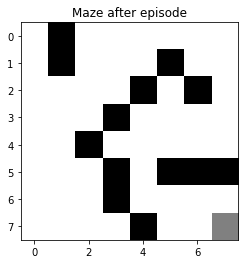

Epoch: 902/999 | Loss: 0.0003 | Episodes: 903 | Win count: 883 | Win rate: 1.000 | time: 2.03 hours
Loss:  0.00033151922980323434
Loss:  0.0004437053430592641
Loss:  0.0002646249777171761
Loss:  0.0005588451895164326
Loss:  0.00030218723259167746
Loss:  0.000137521987198852
Loss:  0.0005230246169958264
Loss:  0.00018758358783088624
Loss:  0.00046121700142975897
Loss:  0.0002099805642501451
Loss:  0.0002700981931411661
Loss:  0.00016014703942346387
Loss:  0.0002800150978146121
Loss:  0.00013472777209244668
Loss:  0.0003953495906898752
Loss:  2.85854011963238e-05
Loss:  0.00026655651890905574
Loss:  0.00023849563876865432
Loss:  0.00018182369967689738
Loss:  0.00010625249342410825
Loss:  0.0005756090395152569
Loss:  0.00017152013242593966
Loss:  0.00046356806706171483
Loss:  0.00016150841474882327
Loss:  0.0003084454801864922
Loss:  0.00043120933696627617
Loss:  0.000399171796743758
Loss:  0.0005416198400780559
Loss:  0.0003460497500782367
Loss:  0.0002934272852144204
Loss:  0.0002304216

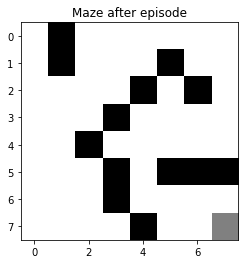

Epoch: 903/999 | Loss: 0.0006 | Episodes: 904 | Win count: 884 | Win rate: 1.000 | time: 2.04 hours
Loss:  0.00028603902319446206
Loss:  0.0004701650541392155
Loss:  0.00023966717708390206
Loss:  0.00027174628849024884
Loss:  0.0002907505113398656
Loss:  0.0005597565177595243
Loss:  0.00022215373974177055
Loss:  0.0004346982896095142
Loss:  0.00012834400695282966
Loss:  0.00042313901940360665
Loss:  0.00028101387579226866
Loss:  0.0003908181533915922
Loss:  0.0005530140188056976
Loss:  0.00027254434826318175
Loss:  0.00013137619680492207
Loss:  0.0004741257434943691
Loss:  0.00036603244370780885
Loss:  0.0001340571980108507
Loss:  0.0004594327911036089
Loss:  0.00030996466375654563
Loss:  0.00028435671993065625
Loss:  0.00012710653390968218
Loss:  0.00012909953147755004
Loss:  0.00016859096649568528
Loss:  0.0003133417048957199
Loss:  0.00014519983960781246
Loss:  0.0001809105888241902
Loss:  0.00020228074208716862
Loss:  4.7706427722005174e-05
Loss:  0.00028057783129042946
Loss:  0.00

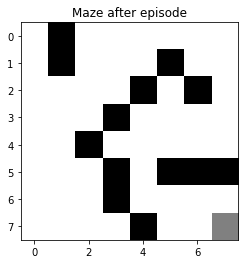

Epoch: 904/999 | Loss: 0.0004 | Episodes: 905 | Win count: 885 | Win rate: 1.000 | time: 2.04 hours
Loss:  0.00038289391522994265
Loss:  0.0001749794500938151
Loss:  0.0003504895430523902


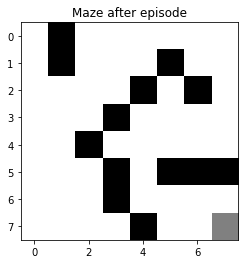

Epoch: 905/999 | Loss: 0.0004 | Episodes: 906 | Win count: 886 | Win rate: 1.000 | time: 2.04 hours
Loss:  0.0002255492472613696
Loss:  0.00021220131384325214
Loss:  0.0003325451398268342
Loss:  0.00010045469389297068
Loss:  0.00035150266194250435


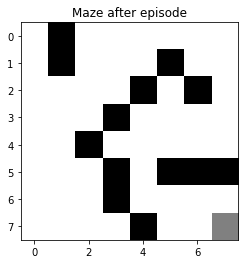

Epoch: 906/999 | Loss: 0.0004 | Episodes: 907 | Win count: 887 | Win rate: 1.000 | time: 2.04 hours
Loss:  0.00024374145141337067
Loss:  0.000456782930996269
Loss:  0.0006329879688564688
Loss:  0.00014658784130006097
Loss:  0.0002756496542133391
Loss:  0.00023176882314146496
Loss:  0.0003996640953118913


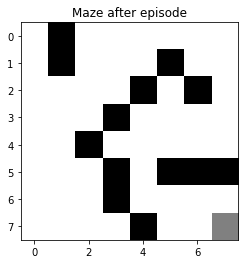

Epoch: 907/999 | Loss: 0.0004 | Episodes: 908 | Win count: 888 | Win rate: 1.000 | time: 2.04 hours
Loss:  9.034554022946395e-05
Loss:  0.0001513668757979758
Loss:  7.354413719440345e-05
Loss:  0.00018039194401353598
Loss:  0.0004603411798598245
Loss:  0.0003124242939520627
Loss:  0.00047494040336459875
Loss:  0.0005091470811748877
Loss:  0.0003197339683538303
Loss:  0.0002467450794938486
Loss:  0.00027527305064722896
Loss:  0.0002285173613927327
Loss:  0.0003907651116605848
Loss:  0.0002571504155639559
Loss:  8.199206058634445e-05
Loss:  0.0005044092831667513
Loss:  0.0002020925185206579
Loss:  0.0003080864480580203
Loss:  0.00036599843588192016
Loss:  0.0001698180531093385
Loss:  0.00043082714546471834


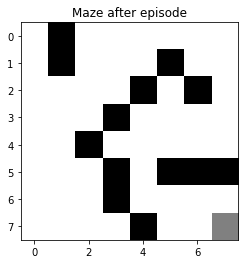

Epoch: 908/999 | Loss: 0.0004 | Episodes: 909 | Win count: 889 | Win rate: 1.000 | time: 2.04 hours
Loss:  0.000399351330997888
Loss:  0.00032988690509228036
Loss:  0.000290401658276096
Loss:  0.00036840727261733264
Loss:  0.0002439801646687556
Loss:  0.00033253880974370986
Loss:  0.00032202799047809094
Loss:  0.00018938997709483374
Loss:  6.536454748129472e-05
Loss:  7.735349936410785e-05
Loss:  0.0006170054693939164
Loss:  0.00018138049927074462
Loss:  0.0003896507259923965
Loss:  0.0003386099760973593
Loss:  4.83194125990849e-05


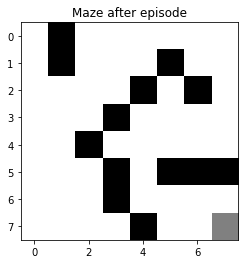

Epoch: 909/999 | Loss: 0.0000 | Episodes: 910 | Win count: 890 | Win rate: 1.000 | time: 2.04 hours
Loss:  0.00012014851381536573
Loss:  0.00033855175570352003
Loss:  9.513448821962811e-05
Loss:  0.00029194839589763433
Loss:  0.00029636140970978886
Loss:  0.0002782743104035035
Loss:  0.00040404526225756854
Loss:  5.0359130909782834e-05
Loss:  0.00011621962403296493
Loss:  0.00033279566559940577
Loss:  0.0006463100580731407
Loss:  0.0002498946705600247
Loss:  8.483996134600602e-05
Loss:  0.00033413435448892415
Loss:  0.00010503589874133468
Loss:  9.562052582623437e-05
Loss:  0.0004398254823172465
Loss:  0.0001541954516142141
Loss:  0.0004595851569320075
Loss:  4.304737194615882e-05
Loss:  0.00030254077864810824
Loss:  0.0003426024632062763
Loss:  0.0002835615669027902
Loss:  0.0002908959295382374
Loss:  0.00033476485623396
Loss:  9.516698628431186e-05


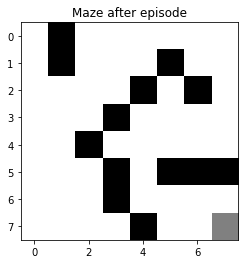

Epoch: 910/999 | Loss: 0.0001 | Episodes: 911 | Win count: 891 | Win rate: 1.000 | time: 2.04 hours
Loss:  0.00021461236974573694
Loss:  0.00024519545695511624
Loss:  0.00018867836843128316
Loss:  0.00021221131464699283
Loss:  0.0002905628862208687
Loss:  0.0003296121140010655
Loss:  0.00040273615741170943
Loss:  0.0003048241196665913
Loss:  0.0004335691701271571
Loss:  0.0002315216261195019
Loss:  0.0004971403250237927
Loss:  0.0001984940972761251


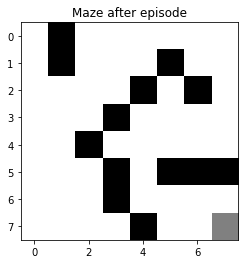

Epoch: 911/999 | Loss: 0.0002 | Episodes: 912 | Win count: 892 | Win rate: 1.000 | time: 2.04 hours
Loss:  0.00014321441994979978
Loss:  0.00025445150095038116
Loss:  0.000192464874999132
Loss:  0.0002191714011132717
Loss:  9.420178685104474e-05
Loss:  0.00019942639482906088
Loss:  0.0003120139881502837
Loss:  0.00022912377244210802
Loss:  0.00010385111454525031
Loss:  0.00027836355002364144
Loss:  0.00021748600556747988
Loss:  0.0003560353561624652
Loss:  2.8528246730274986e-05
Loss:  0.0003199215425411239
Loss:  0.00035373646824155003
Loss:  0.00019168965809512883
Loss:  0.0003152314020553604
Loss:  8.163343318301486e-05
Loss:  0.0002254127466585487
Loss:  0.0003512585462885909


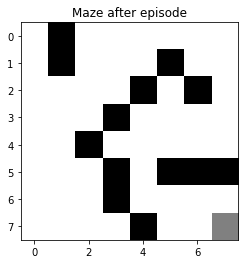

Epoch: 912/999 | Loss: 0.0004 | Episodes: 913 | Win count: 893 | Win rate: 1.000 | time: 2.04 hours
Loss:  0.00037315824010875076
Loss:  7.657719652343076e-05
Loss:  7.588330572616542e-05
Loss:  7.595281385874841e-05
Loss:  0.00037303291173884645
Loss:  0.0003553045244188979
Loss:  0.00029211395303718746
Loss:  3.033740631508408e-05
Loss:  0.0005022747354814783


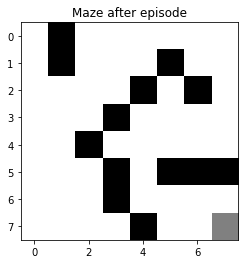

Epoch: 913/999 | Loss: 0.0005 | Episodes: 914 | Win count: 894 | Win rate: 1.000 | time: 2.04 hours
Loss:  0.00015871122013777494
Loss:  0.00011847729183500633
Loss:  0.0006405806343536824
Loss:  7.668944090255536e-05
Loss:  0.0003686803684104234
Loss:  0.0003321814874652773
Loss:  0.0001042653457261622
Loss:  0.00011563790030777454
Loss:  0.0002801172813633457
Loss:  0.0002824419061653316
Loss:  0.0004598075829562731
Loss:  0.0006305403512669727
Loss:  0.00017734075663611293
Loss:  9.933682486007456e-05
Loss:  0.0003581826895242557
Loss:  0.0002640067723405082
Loss:  0.0004621556436177343
Loss:  8.889178934623487e-05
Loss:  0.00027304507966618985
Loss:  9.099454473471269e-05
Loss:  5.750591662945226e-05


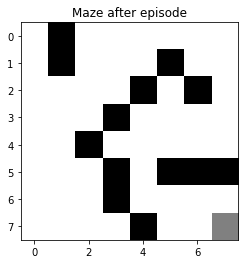

Epoch: 914/999 | Loss: 0.0001 | Episodes: 915 | Win count: 895 | Win rate: 1.000 | time: 2.04 hours
Loss:  0.0005617252318188548
Loss:  0.00040505831566406414
Loss:  0.00020491943905653898
Loss:  0.0002147299237549305
Loss:  0.0001665728777879849
Loss:  0.0002054252581729088
Loss:  8.445415551250335e-05
Loss:  0.00027615714498097077
Loss:  0.00017379766177327838
Loss:  5.7216413551941514e-05
Loss:  0.0002425812890578527
Loss:  8.846158016240224e-05
Loss:  0.00047595142677892
Loss:  0.0005303185025695711
Loss:  0.00044648622861132026
Loss:  0.00046274769556475803
Loss:  0.0002883188353735022
Loss:  0.0002251975420222152
Loss:  0.00022349474602378905
Loss:  0.00035994683457829524
Loss:  0.00017737784946803004
Loss:  0.0005317484319675714
Loss:  0.00012540847455966286
Loss:  0.0002641926330397837
Loss:  0.00047736664419062436
Loss:  0.00041248463094234467
Loss:  0.00032927219581324607


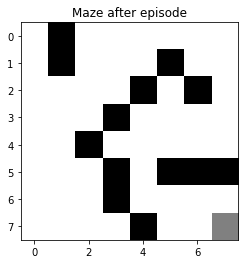

Epoch: 915/999 | Loss: 0.0003 | Episodes: 916 | Win count: 896 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.000395074730477063


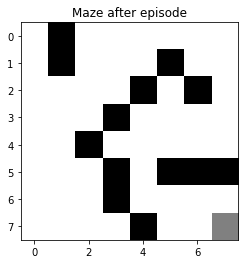

Epoch: 916/999 | Loss: 0.0004 | Episodes: 917 | Win count: 897 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.00022982196605880745
Loss:  0.0003288707448518835
Loss:  0.00045515949386754073
Loss:  0.00018461317085893825
Loss:  0.00043345437734387815
Loss:  0.0002600993757368997
Loss:  0.00019301231805002317
Loss:  0.0007003540813457221
Loss:  0.0004878123727394268
Loss:  0.0004960864134773146
Loss:  0.00030605492065660655
Loss:  0.0004953593452228233
Loss:  0.0003408104385016486
Loss:  0.0004884937079623342
Loss:  0.00024171523546101525
Loss:  0.000159322727995459
Loss:  0.0006670209404546767
Loss:  0.0003267322026658803
Loss:  0.00010449312321725301
Loss:  0.00034453944681445137
Loss:  4.624280518328305e-05
Loss:  0.00014823928358964622
Loss:  0.000129222113173455
Loss:  0.0007732512312941253
Loss:  0.00012612722275662236
Loss:  0.0004868955002166331
Loss:  0.00023058190708979964
Loss:  0.0005491012343554758
Loss:  0.00019267861353000626
Loss:  0.0006184090816532262
Loss:  0.0001649793

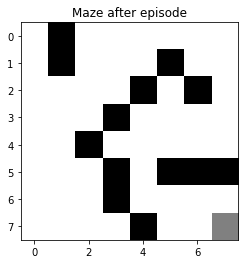

Epoch: 917/999 | Loss: 0.0005 | Episodes: 918 | Win count: 898 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.0006601098866667598
Loss:  0.0002460270334267989


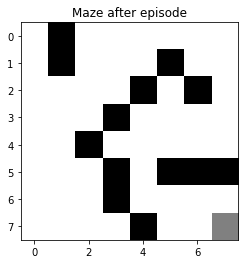

Epoch: 918/999 | Loss: 0.0002 | Episodes: 919 | Win count: 899 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.00025506292149657384
Loss:  0.00013196910367696546
Loss:  0.0004378989106044173
Loss:  0.00019990642431366723
Loss:  0.00011630610970314592
Loss:  0.00038144765130709857
Loss:  0.0006253401807043701
Loss:  0.0002049671038548695


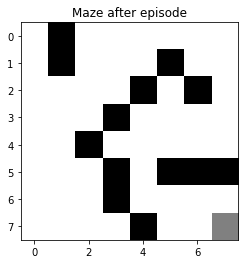

Epoch: 919/999 | Loss: 0.0002 | Episodes: 920 | Win count: 900 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.00027566477365326136
Loss:  0.0005016917129978538
Loss:  0.0002075446827802807
Loss:  0.00035618015681393445
Loss:  0.00028464599745348096
Loss:  0.00032878668571356684
Loss:  0.00016077761029009707
Loss:  0.00029630978679051623
Loss:  0.0003827617329079658
Loss:  0.0005394113541115075
Loss:  0.0005079428519820794
Loss:  0.00040013388206716627
Loss:  0.00042669429967645556
Loss:  0.0007457497122231871
Loss:  0.0003159002117172349
Loss:  0.00010818942246260121
Loss:  6.330097858153749e-05
Loss:  3.854189890262205e-05
Loss:  3.500949787849095e-05
Loss:  0.0005149538628757
Loss:  0.00030597432487411425


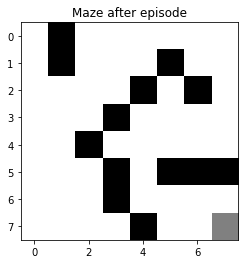

Epoch: 920/999 | Loss: 0.0003 | Episodes: 921 | Win count: 901 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.0006387016619555652
Loss:  0.0004692087804869516
Loss:  0.000377166346879676
Loss:  0.0004216381348669529
Loss:  0.0002301464628544636
Loss:  0.0005906358128413558
Loss:  0.00046406398178078234


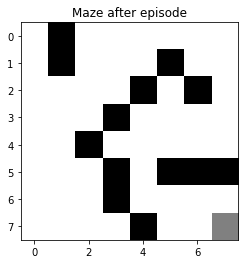

Epoch: 921/999 | Loss: 0.0005 | Episodes: 922 | Win count: 902 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.0007344477635342628
Loss:  0.00032659710268490016


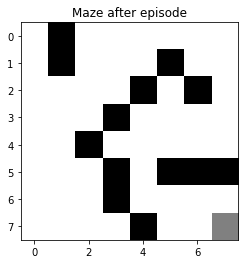

Epoch: 922/999 | Loss: 0.0003 | Episodes: 923 | Win count: 903 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.00024254746676888317
Loss:  7.341647142311558e-05
Loss:  0.0004637573001673445
Loss:  0.0003396418906049803
Loss:  0.00048796023475006223
Loss:  0.0005979053530609235
Loss:  0.00043607151019386947
Loss:  0.0005093217478133738
Loss:  0.0002649920716066845
Loss:  0.0005985855532344431
Loss:  0.000211242979275994
Loss:  0.0003794381918851286
Loss:  0.0004794736305484548
Loss:  0.0005139399436302483
Loss:  0.0004471345091587864
Loss:  0.00042118561395909637
Loss:  0.00021994629059918225
Loss:  0.00013592536561191082
Loss:  0.0006273635954130441
Loss:  0.0002442980694468133
Loss:  0.00065723987063393
Loss:  0.00047577021177858114
Loss:  0.0005896910151932389
Loss:  0.00015543798872386105
Loss:  0.00043268335866741836


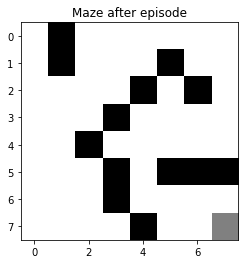

Epoch: 923/999 | Loss: 0.0004 | Episodes: 924 | Win count: 904 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.0003678825160022825
Loss:  0.00034591193616506644
Loss:  0.00042003214184660465
Loss:  0.000271190277999267
Loss:  0.00010267893958371133
Loss:  0.0004234185180393979
Loss:  0.00023354817676590756
Loss:  0.0004898743063677102
Loss:  9.512927135801874e-05
Loss:  0.00020481650426518172
Loss:  0.00020151385251665488
Loss:  0.00020452591706998646
Loss:  0.0005076735105831176
Loss:  0.00037058800808154047
Loss:  0.00023243002578965388
Loss:  0.0003469568328000605
Loss:  0.0007171384204411879
Loss:  0.0005971686914563179
Loss:  0.00043535782606340945
Loss:  0.0005356701876735315
Loss:  0.00033041975257219747
Loss:  0.0004193272325210273
Loss:  0.0001288147032028064
Loss:  0.00021810880571138114
Loss:  0.00042220290924888104
Loss:  0.0005542006983887404
Loss:  0.000272766403213609
Loss:  0.00021556977299042046


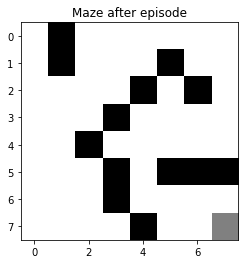

Epoch: 924/999 | Loss: 0.0002 | Episodes: 925 | Win count: 905 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.00023062567925080657
Loss:  0.0009497640421614051
Loss:  0.0002774823733489029
Loss:  0.00028609436412807554
Loss:  0.00036911843926645815
Loss:  0.00021510280566872098
Loss:  0.00020619411225197837
Loss:  0.00010784736150526442
Loss:  0.00019901387713616714
Loss:  0.00017150354688055813
Loss:  0.00033195578726008534
Loss:  0.00029238905699457973
Loss:  0.00032078003278002143
Loss:  0.0003410904755583033
Loss:  0.000598891987465322
Loss:  0.00026768818497657776
Loss:  0.0004843605274800211
Loss:  0.0005606165796052665
Loss:  0.00036511973303277045
Loss:  0.000629611749900505
Loss:  0.0003611101346905343
Loss:  0.00028240196115802974
Loss:  0.00022861768957227468
Loss:  0.00037505548243643716
Loss:  0.0003056638961425051
Loss:  0.00040757299575489014
Loss:  0.00046492180263157934
Loss:  0.00014757271492271684


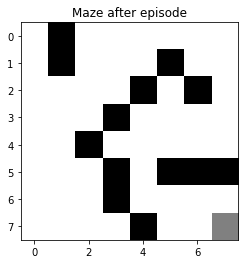

Epoch: 925/999 | Loss: 0.0001 | Episodes: 926 | Win count: 906 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.00023472073371522129


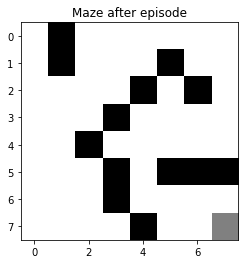

Epoch: 926/999 | Loss: 0.0002 | Episodes: 927 | Win count: 907 | Win rate: 1.000 | time: 2.05 hours
Loss:  0.0001966110612556804
Loss:  0.0006833563675172627
Loss:  0.00042038955143652856
Loss:  0.0009439347195439041
Loss:  0.0004026369788334705
Loss:  0.00038871193100931123
Loss:  0.0003000293218065053
Loss:  0.0006250574224395677
Loss:  0.00042294571176171303
Loss:  0.000375848903786391
Loss:  0.00030640949262306094
Loss:  0.00041590436012484133
Loss:  0.00025172598361677956
Loss:  0.0002533505903556943
Loss:  0.00019603109649324324
Loss:  6.0095873777754605e-05
Loss:  0.00026983894713339396
Loss:  0.0005259040044620633
Loss:  0.0003696162275446113
Loss:  0.0002420599848846905
Loss:  0.0006180532509461045
Loss:  0.00042331477743573487
Loss:  0.00022199834347702563


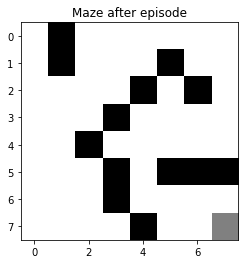

Epoch: 927/999 | Loss: 0.0002 | Episodes: 928 | Win count: 908 | Win rate: 1.000 | time: 2.06 hours
Loss:  3.900371302734129e-05
Loss:  0.00046209317224565893
Loss:  0.00036082805308979005
Loss:  0.00018885813187807798
Loss:  0.00035778271194431
Loss:  0.0005440380045911297
Loss:  0.00048351072473451495
Loss:  0.00046037629363127053
Loss:  0.00024288355052703992
Loss:  0.0005238251469563693
Loss:  0.0005067130114184693
Loss:  0.0003205951907148119
Loss:  0.00036158112925477326
Loss:  0.00027077458798885345
Loss:  0.0003766606387216598
Loss:  0.00048811876331456006
Loss:  0.00032897658820729703
Loss:  0.00042382694664411247
Loss:  0.0003056753193959594
Loss:  0.000403101381380111
Loss:  0.0002982080477522686
Loss:  0.0003516207289067097
Loss:  0.0005753353907493874
Loss:  0.0006505514975287952
Loss:  0.0003256560012232512
Loss:  0.00015285144036170095
Loss:  0.00021678309713024646


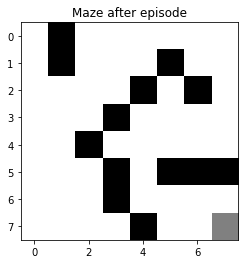

Epoch: 928/999 | Loss: 0.0002 | Episodes: 929 | Win count: 909 | Win rate: 1.000 | time: 2.06 hours
Loss:  0.0003659055655589327
Loss:  0.00048495166993234307
Loss:  0.00032542800181545317
Loss:  0.000367935499525629
Loss:  0.00027333290927344933
Loss:  0.0003345497898408212
Loss:  0.00022093420193414204
Loss:  0.0004052750882692635
Loss:  0.0002356168770347722
Loss:  0.000559449807042256
Loss:  0.0005132784863235429
Loss:  0.0004577316140057519
Loss:  0.0004765023331856355
Loss:  0.00047598766104783863
Loss:  0.00027085101464763284
Loss:  0.00027848538229591213
Loss:  0.0002933605865109712
Loss:  0.0003865552062052302
Loss:  0.0002754975575953722
Loss:  0.00026118510140804574
Loss:  4.982756763638463e-05
Loss:  0.0007824737986084074
Loss:  0.00023002290254225954
Loss:  0.000417922405176796
Loss:  0.0002886634465539828
Loss:  0.000394087954191491
Loss:  0.0005843290418852121
Loss:  0.0005474328354466707
Loss:  0.0002982023361255415
Loss:  0.00033967428316827863
Loss:  0.000644222251139

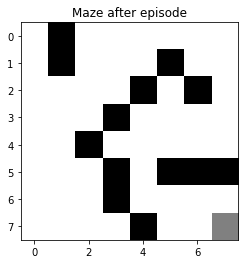

Epoch: 929/999 | Loss: 0.0005 | Episodes: 930 | Win count: 910 | Win rate: 1.000 | time: 2.06 hours
Loss:  0.00025289897166658193
Loss:  0.0006079725571908057
Loss:  0.0003556336450856179
Loss:  0.0006334306963253766
Loss:  0.00041779760067583993
Loss:  0.0002442397744744085
Loss:  0.0005874156049685553
Loss:  0.00023919787054182962
Loss:  0.0003845492610707879
Loss:  0.00045182691246736795
Loss:  0.00044323290421743877
Loss:  0.0004145616549067199
Loss:  0.00022006935614626855
Loss:  0.0003811528513324447
Loss:  0.0006040141452103853
Loss:  0.00030229866024455987
Loss:  0.000539600063348189
Loss:  0.0005489012983161956
Loss:  0.00040893175901146606
Loss:  0.0005000938399462029
Loss:  0.0009206913528032601
Loss:  0.00011662112228805199
Loss:  0.0007879621989559382


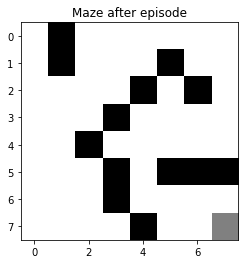

Epoch: 930/999 | Loss: 0.0008 | Episodes: 931 | Win count: 911 | Win rate: 1.000 | time: 2.06 hours
Loss:  0.0007719379209447652
Loss:  0.00042668860987760127
Loss:  0.0006719257071381435
Loss:  0.0008599054126534611
Loss:  0.0003806191452895291
Loss:  0.0004486942634684965
Loss:  0.0004040318090119399
Loss:  0.0006378913822118193
Loss:  0.0005208151414990425
Loss:  0.0008301057096105069
Loss:  0.0006202354852575809
Loss:  0.00028092152206227183
Loss:  0.0005800986982649192
Loss:  0.00027323771064402536
Loss:  0.000678369018714875
Loss:  0.0003153023135382682
Loss:  0.0004623048735084012
Loss:  0.0010324371978640556
Loss:  0.0004834404098801315
Loss:  0.00032722011383157223
Loss:  0.0004519062931649387
Loss:  0.0006524830096168444
Loss:  0.000148217732203193
Loss:  0.00038187974132597446
Loss:  0.0005855203635292128
Loss:  0.0005134984239703044
Loss:  0.0003767163580050692
Loss:  0.00017269626550842077
Loss:  0.00020049584418302402
Loss:  0.0006077566213207319
Loss:  0.0001127031937357

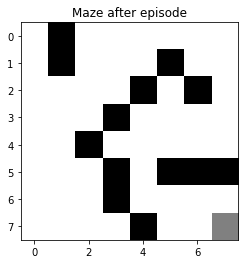

Epoch: 931/999 | Loss: 0.0001 | Episodes: 932 | Win count: 912 | Win rate: 1.000 | time: 2.06 hours
Loss:  0.000612486939644441
Loss:  0.0003564480102795642
Loss:  0.00028151069273008034
Loss:  0.0005254827265162021
Loss:  0.000198862784600351
Loss:  0.0005135196261107922


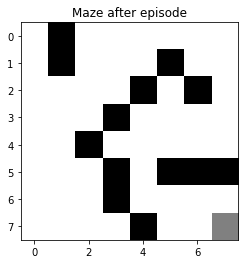

Epoch: 932/999 | Loss: 0.0005 | Episodes: 933 | Win count: 913 | Win rate: 1.000 | time: 2.06 hours
Loss:  0.0005456801736727357
Loss:  0.0002707997045945376
Loss:  0.00033120057196356356
Loss:  0.00045456078078132123
Loss:  0.0004406285079312511
Loss:  0.0006251363083720207
Loss:  0.0005368122947402298
Loss:  0.0005689324025297537
Loss:  0.00038306474743876606
Loss:  0.0007246457098517567
Loss:  0.0006398663099389523
Loss:  0.0006269823352340609
Loss:  0.0005699895555153489
Loss:  0.0005402063688961789
Loss:  0.00028494778598542325
Loss:  0.0005220886960159987
Loss:  0.00036513082159217447
Loss:  0.0006311076867859811
Loss:  0.0006407905602827668
Loss:  0.0006347788876155391
Loss:  0.00046723944251425564
Loss:  0.0005802919622510672
Loss:  0.00039964537427295
Loss:  0.00036643201747210696
Loss:  0.00021997003204887733
Loss:  0.0007718214474152774
Loss:  0.0003948819503420964
Loss:  0.00047119845112320036
Loss:  0.0003256415802752599
Loss:  0.0005584350583376363
Loss:  0.00045196352584

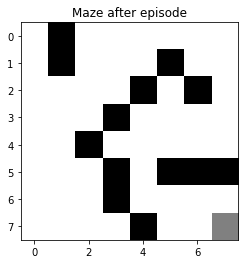

Epoch: 933/999 | Loss: 0.0007 | Episodes: 934 | Win count: 914 | Win rate: 1.000 | time: 2.06 hours
Loss:  0.0005926733138039708
Loss:  0.0008882059482857585
Loss:  0.0005977335677016526
Loss:  0.00014299278700491413
Loss:  9.407784455106594e-05
Loss:  0.0005575321665673982
Loss:  0.0005447390649351291
Loss:  0.0003120326582575217
Loss:  0.00035050095175392926
Loss:  0.00021338539227144793
Loss:  0.0005935102381044999
Loss:  0.00018622315110405907
Loss:  0.00038659040001221
Loss:  0.00022054131841287017
Loss:  0.0005698420718545094
Loss:  0.0007930407300591469
Loss:  0.00022151808661874384
Loss:  0.0003684238326968625
Loss:  0.00044746018829755485
Loss:  0.00027124393091071397


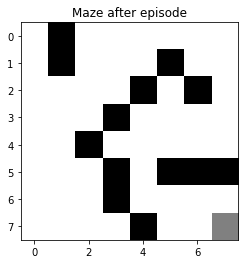

Epoch: 934/999 | Loss: 0.0003 | Episodes: 935 | Win count: 915 | Win rate: 1.000 | time: 2.06 hours
Loss:  0.0007758549472782761
Loss:  0.0005140783832757734
Loss:  0.00011147512122988701
Loss:  0.00038671526999678463
Loss:  0.0003397048349143006
Loss:  0.0007003821374382824
Loss:  0.0006909201911184937
Loss:  0.0003437960986047983
Loss:  0.00048786272236611694
Loss:  0.0005616395501419902
Loss:  0.000567953335121274
Loss:  0.0005622623575618491
Loss:  0.0005140544235473499
Loss:  0.0010660934494808316
Loss:  0.00027928961208090186
Loss:  0.0007337939459830523
Loss:  0.0007454807055182755
Loss:  0.00042043181747430936
Loss:  0.00038864462840138003
Loss:  0.0008574504754506052
Loss:  0.0005014891939936206
Loss:  0.0003717334911925718
Loss:  0.00027435894298832864
Loss:  0.0004630625044228509
Loss:  0.00031069907709024847
Loss:  0.0003846455947495997
Loss:  0.00016292887448798865
Loss:  0.000836356426589191
Loss:  0.00023780978517606854
Loss:  0.0004733799578389153
Loss:  0.0005664976051

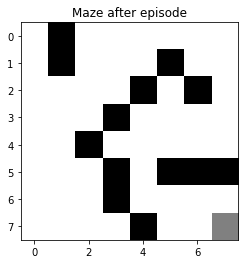

Epoch: 935/999 | Loss: 0.0003 | Episodes: 936 | Win count: 916 | Win rate: 1.000 | time: 2.07 hours
Loss:  0.000665148749249056
Loss:  0.00044013252772856504
Loss:  0.00014180521975504234
Loss:  8.563574374420568e-05
Loss:  0.0003891215455951169
Loss:  0.00033291580621153116
Loss:  0.0005997500556986779
Loss:  0.0006298461958067492
Loss:  0.00037155626341700554
Loss:  0.0004066393739776686
Loss:  0.000135002686874941
Loss:  0.00036994056426919997
Loss:  0.0005341517680790275
Loss:  0.00036297573024057783
Loss:  0.0008557739201933146


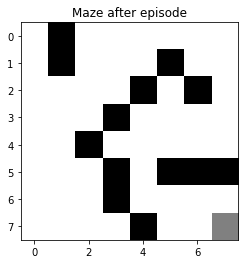

Epoch: 936/999 | Loss: 0.0009 | Episodes: 937 | Win count: 917 | Win rate: 1.000 | time: 2.07 hours
Loss:  0.0006782768323319033
Loss:  0.0003419379499973729
Loss:  0.0006348039314616472
Loss:  0.00011492707199067809
Loss:  0.0004895582824246958
Loss:  0.00042770324216689914
Loss:  0.0002659292076714337
Loss:  0.0005680030299117789
Loss:  0.0005075391673017293
Loss:  0.00022810102382209152
Loss:  0.000505485717440024
Loss:  0.00017181189832626842
Loss:  0.0003423162252147449
Loss:  0.0006705042906105518
Loss:  0.0005464958085212857
Loss:  0.0006969872920308262
Loss:  0.0003870166401611641
Loss:  0.00037102076748851687
Loss:  0.0004065458560944535
Loss:  0.0002885118519770913
Loss:  0.0004385552092571743
Loss:  0.0008089637849479914
Loss:  0.00028234503406565636
Loss:  0.0002279715299664531
Loss:  0.00021351212490117177
Loss:  0.00028414171538315713
Loss:  0.0005558864795602858
Loss:  0.00034409477302688174


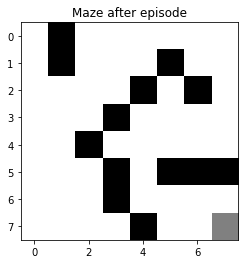

Epoch: 937/999 | Loss: 0.0003 | Episodes: 938 | Win count: 918 | Win rate: 1.000 | time: 2.07 hours
Loss:  0.0004223181458655745
Loss:  0.00048017665540101007
Loss:  0.00035173606374883093
Loss:  0.0002425949787721038
Loss:  0.0003973448619944975
Loss:  0.00045647718070540577
Loss:  0.0005584192549576983
Loss:  0.0004270027202437632
Loss:  0.0008238546433858573
Loss:  0.0005998165725031868
Loss:  0.0005095269734738395
Loss:  0.0007819426828064024
Loss:  0.0003144901565974578
Loss:  0.0007693007355555892
Loss:  7.686539902351797e-05
Loss:  0.0004155967471888289
Loss:  7.653903776372317e-05
Loss:  0.0001423307512595784
Loss:  8.156539843184873e-05
Loss:  3.065952751057921e-05
Loss:  0.0003247313707106514
Loss:  0.000540236258530058
Loss:  0.0004773050604853779
Loss:  0.00011288356108707376


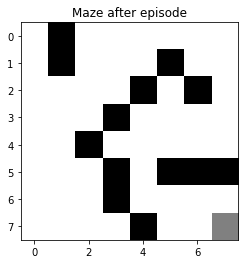

Epoch: 938/999 | Loss: 0.0001 | Episodes: 939 | Win count: 919 | Win rate: 1.000 | time: 2.07 hours
Loss:  5.0793947593774647e-05
Loss:  0.0003519535093801096
Loss:  0.0005722671776311472
Loss:  0.0006358910468406975
Loss:  0.00025383212050655857
Loss:  0.00025800723233260214
Loss:  0.0005262153572402894
Loss:  0.0006076913159631658
Loss:  0.00048778705240692943
Loss:  0.0002569832286098972
Loss:  0.0006928650400368497
Loss:  0.0006572628335561603
Loss:  0.0009327651787316427
Loss:  0.0006751531327608973
Loss:  0.0009245826513506472


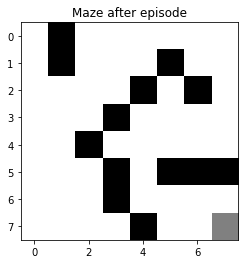

Epoch: 939/999 | Loss: 0.0009 | Episodes: 940 | Win count: 920 | Win rate: 1.000 | time: 2.07 hours
Loss:  0.0007253823278006166
Loss:  0.0006265538686420768
Loss:  0.000524970077094622
Loss:  0.0008380730869248509
Loss:  0.0002968460030388087
Loss:  0.0009401985735166818
Loss:  0.0006575055595021695
Loss:  0.00035406299866735935
Loss:  0.00043086869118269533


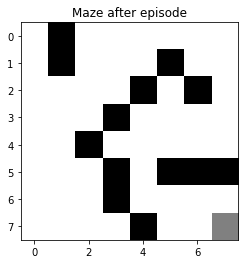

Epoch: 940/999 | Loss: 0.0004 | Episodes: 941 | Win count: 921 | Win rate: 1.000 | time: 2.07 hours
Loss:  0.0006001390574965626
Loss:  0.000636160810245201
Loss:  0.00016586662968620658
Loss:  0.00027047606999985874
Loss:  0.0003626958205131814
Loss:  0.0007539867074228823
Loss:  0.0004325713525759056
Loss:  0.00048584380419924855
Loss:  0.00025517199537716806
Loss:  0.0007368456572294235
Loss:  0.00020325932928244583
Loss:  0.00047489034477621317
Loss:  0.00017188474157592282
Loss:  0.0009152509301202372
Loss:  0.0004806589422514662
Loss:  0.00047382428601849824
Loss:  7.562171595054679e-05
Loss:  0.00041672868246678263
Loss:  0.0007491933647543192
Loss:  0.0004152706533204764
Loss:  0.00027172971385880373
Loss:  9.901737576001324e-05
Loss:  0.00041292886453447863


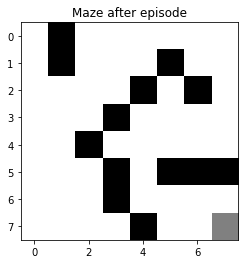

Epoch: 941/999 | Loss: 0.0004 | Episodes: 942 | Win count: 922 | Win rate: 1.000 | time: 2.07 hours
Loss:  0.00023025922928354703
Loss:  0.0006650918367085978
Loss:  0.0005726534000132233
Loss:  0.0007763775938656181
Loss:  0.00045383378164842725
Loss:  0.00033014893415383995
Loss:  0.00015635450836271048
Loss:  0.0001686583836999489
Loss:  0.0003395091807760764
Loss:  0.0003671982267405838
Loss:  8.714618888916448e-05
Loss:  0.00027700921054929495
Loss:  0.00043995853047817945
Loss:  0.00034248142037540674
Loss:  0.00040249977246276103
Loss:  0.0004363793123047799
Loss:  0.0009173965372610837
Loss:  0.00048264018550980836
Loss:  0.0002667146472958848
Loss:  0.0008925939619075507
Loss:  0.00033426255686208606
Loss:  0.00023373127623926848
Loss:  0.00049155431042891
Loss:  0.000567286362638697
Loss:  0.0003601455391617492
Loss:  0.0007941186777316034
Loss:  0.0005464932764880359
Loss:  0.00042629073141142726
Loss:  0.000561238412046805
Loss:  0.000113804195279954
Loss:  0.00020241093807

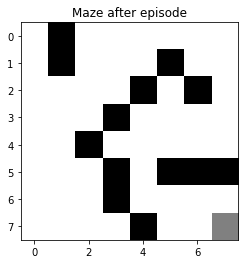

Epoch: 942/999 | Loss: 0.0004 | Episodes: 943 | Win count: 923 | Win rate: 1.000 | time: 2.07 hours
Loss:  0.0003146699928038288
Loss:  0.0006862820009700954
Loss:  0.00027073821547674015
Loss:  0.0008977713296189904
Loss:  0.00013885823500459082
Loss:  0.0006311696924967691
Loss:  0.000117260824481491
Loss:  0.00022112724400358275
Loss:  0.00010573179315542802
Loss:  0.0005744481168221682
Loss:  0.00010552230014582165
Loss:  0.0003718934312928468
Loss:  0.0008631658565718681
Loss:  0.00044813436397816986
Loss:  0.0001842190176830627
Loss:  0.0006780944822821766
Loss:  0.00048455143405590206
Loss:  7.838815508875996e-05
Loss:  0.00035481145459925756
Loss:  0.0004593634366756305
Loss:  0.0006648309354204684
Loss:  0.000696075614541769
Loss:  0.0006394690863089636
Loss:  0.0005251055408734828
Loss:  0.00047560108941979706


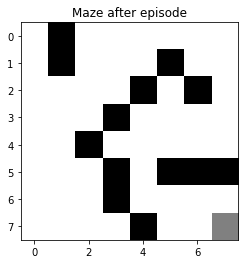

Epoch: 943/999 | Loss: 0.0005 | Episodes: 944 | Win count: 924 | Win rate: 1.000 | time: 2.07 hours
Loss:  0.00012571196202770807
Loss:  0.000522204049048014
Loss:  0.0007159734086599201
Loss:  0.0004536358319455758
Loss:  0.0006827367615187541
Loss:  0.0003743176639545709
Loss:  0.00048702728236094117
Loss:  0.0003292602195870131
Loss:  0.000514350991579704
Loss:  0.0004033731165691279
Loss:  0.000248208951234119
Loss:  0.0006432783848140389
Loss:  0.0004745733749587089


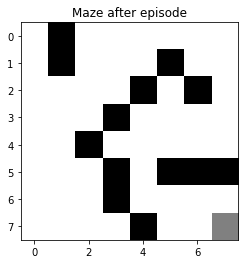

Epoch: 944/999 | Loss: 0.0005 | Episodes: 945 | Win count: 925 | Win rate: 1.000 | time: 2.07 hours
Loss:  0.0006661976221948862
Loss:  0.0007921512005850673
Loss:  0.00031764161030878313


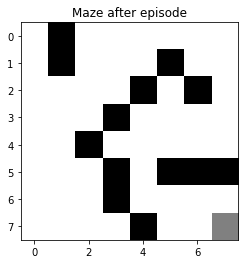

Epoch: 945/999 | Loss: 0.0003 | Episodes: 946 | Win count: 926 | Win rate: 1.000 | time: 2.07 hours
Loss:  0.00028547611145768315
Loss:  0.0002643693005666137
Loss:  0.00048463878920301795
Loss:  0.00036800309317186475
Loss:  0.0002497922978363931
Loss:  0.00036573327088262886
Loss:  0.0004262568836566061
Loss:  0.0006964110361877829
Loss:  0.00045734694867860526
Loss:  0.0003725682763615623


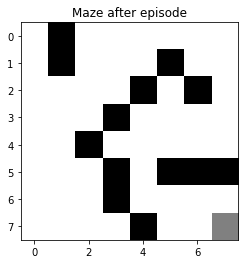

Epoch: 946/999 | Loss: 0.0004 | Episodes: 947 | Win count: 927 | Win rate: 1.000 | time: 2.08 hours
Loss:  6.464469151978847e-05
Loss:  0.00045555521501228213
Loss:  8.091722338576801e-05
Loss:  0.0001725879956211429
Loss:  0.00035716114143724553
Loss:  0.00048806730774231255
Loss:  0.0002023677370743826
Loss:  0.000536808161996305
Loss:  0.00059263248112984
Loss:  0.0006119592871982604
Loss:  0.000345823798852507
Loss:  0.00011409995204303414
Loss:  0.00012440356294973753
Loss:  0.0002679838289623149
Loss:  0.0004511588194873184
Loss:  0.000250131528446218
Loss:  0.0002865812202799134
Loss:  0.000258217187365517


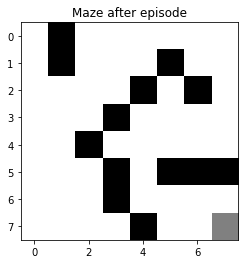

Epoch: 947/999 | Loss: 0.0003 | Episodes: 948 | Win count: 928 | Win rate: 1.000 | time: 2.08 hours
Loss:  0.0005738205363741145
Loss:  0.0003488718793960288
Loss:  0.0001368471930618398
Loss:  0.000748276652302593
Loss:  0.00029619867564179003
Loss:  0.00046492452383972704
Loss:  0.00016014663560781628
Loss:  6.51829868729692e-05
Loss:  0.00023093946219887584
Loss:  0.0003480160521576181
Loss:  0.0004172615517745726
Loss:  0.0003014714384335093
Loss:  0.0004575501661747694
Loss:  0.0002570039177953731
Loss:  0.00026071129832416773
Loss:  0.0004500064969761297
Loss:  0.0004722998128272593
Loss:  0.0001991215322050266
Loss:  0.00017316358935204335
Loss:  0.00020684821356553584
Loss:  0.00036775665648747236
Loss:  0.0004918577615171671
Loss:  0.0001536785566713661
Loss:  0.0002823922004608903
Loss:  0.0003080289243371226
Loss:  0.00029858516791136935
Loss:  0.0003518377634463832
Loss:  0.00011828014976345003
Loss:  0.00016380348097300157
Loss:  0.0003584630030672997
Loss:  0.000251171099

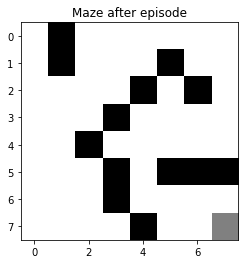

Epoch: 948/999 | Loss: 0.0003 | Episodes: 949 | Win count: 929 | Win rate: 1.000 | time: 2.08 hours
Loss:  0.0006567428063135594
Loss:  0.0005766542017227039
Loss:  0.0003003863457706757
Loss:  0.00042767786362674087


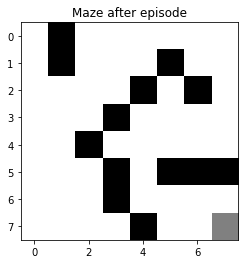

Epoch: 949/999 | Loss: 0.0004 | Episodes: 950 | Win count: 930 | Win rate: 1.000 | time: 2.08 hours
Loss:  0.0004920473438687623
Loss:  0.0005207367576076649
Loss:  0.00039223203202709556
Loss:  0.0008003655821084976
Loss:  0.00021973981347400695
Loss:  0.00030625053113908507
Loss:  0.0005308836553012952
Loss:  0.0005267399392323568
Loss:  0.0004255717976775486
Loss:  0.00022028362582204863
Loss:  0.00010705331442295574
Loss:  0.00039569615000800695
Loss:  0.0007028336403891444
Loss:  0.0005742444627685472
Loss:  0.00021851078781764954
Loss:  0.00015559599705738947
Loss:  0.00023451823653886095
Loss:  0.00032773402926977724
Loss:  0.0011112165520898998
Loss:  0.000772301631513983
Loss:  0.00043651487794704735
Loss:  0.0002415588969597593
Loss:  0.00028597879281733185
Loss:  0.0007607543375343084
Loss:  0.000648450237349607
Loss:  0.0005257806915324181


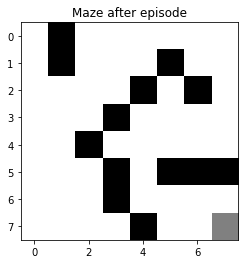

Epoch: 950/999 | Loss: 0.0005 | Episodes: 951 | Win count: 931 | Win rate: 1.000 | time: 2.08 hours
Loss:  0.00022417928266804665
Loss:  0.000587228627409786
Loss:  0.00019044422515435144
Loss:  0.0003645316610345617
Loss:  0.00039445193397114053
Loss:  0.00021154242858756334
Loss:  0.0002109175402438268
Loss:  4.1991834223154e-05
Loss:  0.00022860930766910315
Loss:  0.0005354671156965196
Loss:  0.0002932786810561083
Loss:  0.0005817155470140278
Loss:  0.0006012095982441679
Loss:  0.0004163959893048741
Loss:  0.000313758515403606
Loss:  0.0003696314961416647
Loss:  0.000620044011157006
Loss:  0.0002657792101672385
Loss:  0.0002372758972342126
Loss:  0.0002682851700228639
Loss:  0.0007283985323738307
Loss:  0.0003362186544109136
Loss:  0.0004042634682264179
Loss:  0.00046439231664408
Loss:  0.0002108819371642312
Loss:  0.0005933298089075834
Loss:  0.0004741252341773361
Loss:  0.00038097568904049695
Loss:  0.0004902500804746523
Loss:  0.00023804269949323498
Loss:  0.00023976126612978987


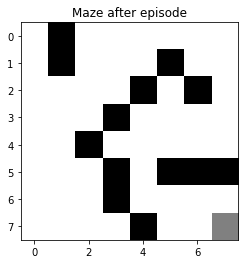

Epoch: 951/999 | Loss: 0.0004 | Episodes: 952 | Win count: 932 | Win rate: 1.000 | time: 2.08 hours
Loss:  0.0003937367582693696
Loss:  5.2238490752642974e-05
Loss:  2.0715580831165425e-05
Loss:  0.0006751980108674616
Loss:  0.0002999537391588092
Loss:  0.0003576257877284661
Loss:  0.0004579170636134222
Loss:  0.0004153337504249066
Loss:  0.0002654158597579226
Loss:  0.00012784015052602626
Loss:  0.00018498537974664941
Loss:  0.0002535387684474699
Loss:  0.0004966726119164377
Loss:  0.0002702213478187332
Loss:  0.00012931940545968246
Loss:  0.0003009071369888261
Loss:  9.957965085050091e-05
Loss:  0.0003115347135462798
Loss:  0.0004972648166585714


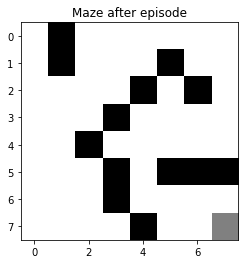

Epoch: 952/999 | Loss: 0.0005 | Episodes: 953 | Win count: 933 | Win rate: 1.000 | time: 2.08 hours
Loss:  0.0006096794386394322
Loss:  0.00023672223960602423
Loss:  0.00014355435268953443
Loss:  0.00012005615280941129
Loss:  0.0005277795717120171
Loss:  0.0004402738850330934
Loss:  0.0001372166043438483
Loss:  0.0003221665392629802
Loss:  0.00018606723824632354
Loss:  0.0003357518289703876
Loss:  0.00028072326131223235
Loss:  5.3592595577356406e-05
Loss:  4.900328985968372e-05
Loss:  6.992945600359235e-05
Loss:  0.0003587937753763981
Loss:  0.00018414503574604169
Loss:  3.203371124982368e-05
Loss:  5.0300019211135805e-05
Loss:  0.0002670908233994851
Loss:  8.778607661952265e-05
Loss:  0.0001601571566425264
Loss:  0.0004312265373300761
Loss:  0.00022946815442992374
Loss:  0.0003038179347640835
Loss:  0.0003093458799412474
Loss:  0.00026733940467238426
Loss:  7.290340727195144e-05
Loss:  0.00010409513015474658
Loss:  0.0002907925081672147


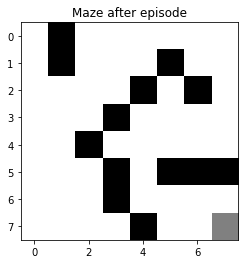

Epoch: 953/999 | Loss: 0.0003 | Episodes: 954 | Win count: 934 | Win rate: 1.000 | time: 2.09 hours
Loss:  0.0003507142828311771
Loss:  0.0005633255932480097
Loss:  0.0001794779600459151
Loss:  0.00022328930572257377
Loss:  0.0004855589650105685
Loss:  0.000329839313053526
Loss:  0.0004945075197611004
Loss:  0.00010547606507316232
Loss:  0.0006474494002759457
Loss:  0.0003242853708798066
Loss:  0.00020263599435565993
Loss:  0.00030226648959796876
Loss:  0.0001418705069227144
Loss:  0.0002570224751252681
Loss:  0.0003706545103341341
Loss:  0.00013633640628540888
Loss:  0.0006633044686168432
Loss:  0.00027985752967651933
Loss:  0.00042657897574827075
Loss:  0.00012064501061104238
Loss:  0.0007187805022113025
Loss:  0.0004706606996478513
Loss:  0.00012636474275495857
Loss:  0.0002557688676461112
Loss:  0.00011707254816428758


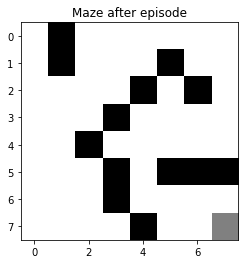

Epoch: 954/999 | Loss: 0.0001 | Episodes: 955 | Win count: 935 | Win rate: 1.000 | time: 2.09 hours
Loss:  0.00028866044158348814
Loss:  0.00030152532235661056
Loss:  0.0002181613745051436
Loss:  8.169071770680603e-05
Loss:  0.0003590057240216993
Loss:  0.00028955073503311723
Loss:  0.00023358573162113316
Loss:  0.0002733690707827918
Loss:  0.00029164236912038177
Loss:  0.0005535851523745805
Loss:  8.709208486834541e-05
Loss:  7.986085620359518e-05
Loss:  0.0003755999932764098
Loss:  2.8955613743164577e-05
Loss:  0.00015157686357269995
Loss:  3.0090355721767992e-05
Loss:  0.00039034026849549264
Loss:  0.0006259673973545432
Loss:  9.900625445879996e-05
Loss:  0.0003641730436356738
Loss:  0.0003956058353651315
Loss:  0.00012029132631141692
Loss:  0.0005008509760955349


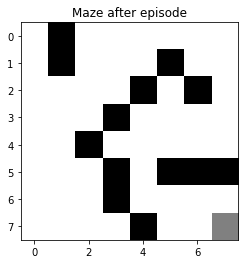

Epoch: 955/999 | Loss: 0.0005 | Episodes: 956 | Win count: 936 | Win rate: 1.000 | time: 2.09 hours
Loss:  0.00026576837262837216
Loss:  0.00015802105190232396
Loss:  4.03684753109701e-05
Loss:  0.0005075312510598451
Loss:  0.000404831618652679
Loss:  5.1644550694618374e-05
Loss:  0.00012401754793245345
Loss:  0.0005055056972196326
Loss:  0.00029507519320759457
Loss:  0.00020401716392370872
Loss:  0.0004206449375487864
Loss:  0.00023504211276303977
Loss:  0.0007084492826834321
Loss:  0.0003700493252836168
Loss:  0.0004639673134079203
Loss:  0.0003909853403456509
Loss:  0.0006518040027003735
Loss:  0.00011361523502273485
Loss:  0.00031810280052013695
Loss:  0.0005023532139603049
Loss:  0.0002801152877509594
Loss:  0.00029459467623382807
Loss:  0.00026652758424461354
Loss:  0.0003618140544858761
Loss:  4.452567736734636e-05
Loss:  0.0002387697204540018
Loss:  0.00020679850058513694
Loss:  0.0004855416191276163
Loss:  0.0002976834002765827


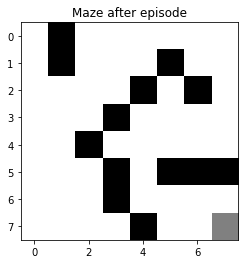

Epoch: 956/999 | Loss: 0.0003 | Episodes: 957 | Win count: 937 | Win rate: 1.000 | time: 2.09 hours
Loss:  0.00017820842185756192
Loss:  0.0006929951923666522


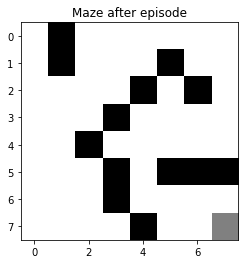

Epoch: 957/999 | Loss: 0.0007 | Episodes: 958 | Win count: 938 | Win rate: 1.000 | time: 2.09 hours
Loss:  8.186934792320244e-05
Loss:  0.0004875499726040289
Loss:  0.0004447091050678864
Loss:  0.00016218190285144374
Loss:  0.0005392481689341366
Loss:  0.00034786663309205323
Loss:  4.294399877835531e-05
Loss:  6.522968033095822e-05
Loss:  0.0002460401738062501
Loss:  0.0002830940647982061
Loss:  8.318416803376749e-05


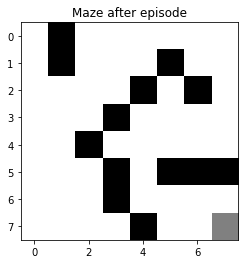

Epoch: 958/999 | Loss: 0.0001 | Episodes: 959 | Win count: 939 | Win rate: 1.000 | time: 2.09 hours
Loss:  0.00020432211022125557
Loss:  0.00021437398027046584
Loss:  0.0004158535157330334
Loss:  0.0005721783090848476
Loss:  0.00035399328044150025
Loss:  0.0002025025023613125
Loss:  0.0002293638899573125
Loss:  0.00021631256095133722
Loss:  5.800742110295687e-05
Loss:  0.00016795460578578059


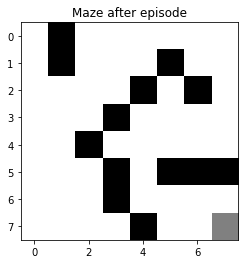

Epoch: 959/999 | Loss: 0.0002 | Episodes: 960 | Win count: 940 | Win rate: 1.000 | time: 2.09 hours
Loss:  0.00019236274965805933
Loss:  4.995590916223591e-05
Loss:  0.00016075089024525369
Loss:  0.00014352538164530415
Loss:  0.00015706564954598434
Loss:  0.00026070478270412423
Loss:  0.00043683461262844503
Loss:  0.00014371741053764708
Loss:  4.061193794768769e-05
Loss:  0.00030171019898261875
Loss:  0.00040862277091946453
Loss:  0.00016232164671237115
Loss:  0.0006327309238258749
Loss:  0.0005411032616393641
Loss:  0.00022039079340174794
Loss:  0.00047289182475651614
Loss:  0.00031219495576806366
Loss:  0.0004398858727654442
Loss:  0.0002493491556379013
Loss:  0.0004044167581014335
Loss:  0.00017482782641309313


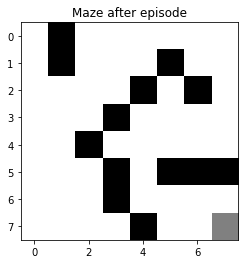

Epoch: 960/999 | Loss: 0.0002 | Episodes: 961 | Win count: 941 | Win rate: 1.000 | time: 2.09 hours
Loss:  0.00017433109860576224
Loss:  0.0001633203046367271
Loss:  4.851007543038577e-05
Loss:  4.546735362964682e-05
Loss:  0.00021749097868450917
Loss:  0.00018332002036913764
Loss:  0.00016098156993393786
Loss:  3.5813700378639624e-05
Loss:  0.0002885889007302467
Loss:  0.0004206875601084903
Loss:  0.00030863448046147823
Loss:  0.00020750449766637757
Loss:  0.0006065203197067603
Loss:  0.0004176304501015693
Loss:  0.00048310315469279885
Loss:  0.00040233085746876895
Loss:  0.0005495346267707646
Loss:  0.00027776936622103676
Loss:  0.00048161013546632603
Loss:  0.00046962469423306175
Loss:  0.00021820854453835636
Loss:  0.00017183841919177212
Loss:  0.00012005894313915633
Loss:  0.00027267494806437753
Loss:  0.00048172110109589994
Loss:  0.0005665480712195858
Loss:  0.00036337177152745426
Loss:  0.00045408037840388715
Loss:  8.88899085111916e-05
Loss:  0.0003955262072850019
Loss:  0.000

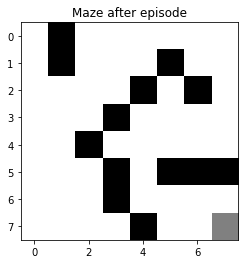

Epoch: 961/999 | Loss: 0.0004 | Episodes: 962 | Win count: 942 | Win rate: 1.000 | time: 2.10 hours
Loss:  0.00021625721274176612
Loss:  0.00015423425611515995
Loss:  0.00043981848284602165
Loss:  0.00014371999350260012
Loss:  0.00019296861137263477
Loss:  0.0002710994303924963
Loss:  0.00015017489931778982
Loss:  0.00018922952585853636
Loss:  0.0002201896786573343
Loss:  0.00020592313376255333
Loss:  0.0006977500452194363
Loss:  0.00028028481756336987
Loss:  0.00016929506818996742
Loss:  0.0002332057774765417
Loss:  0.0003199309721821919


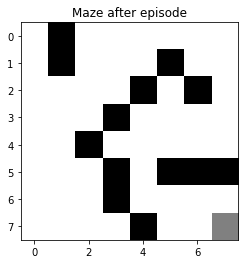

Epoch: 962/999 | Loss: 0.0003 | Episodes: 963 | Win count: 943 | Win rate: 1.000 | time: 2.10 hours
Loss:  0.00039180900785140693
Loss:  7.191532313299831e-05
Loss:  0.0004016290040453896
Loss:  0.00047436999739147723
Loss:  0.00017365958774462342
Loss:  0.0003661671871668659
Loss:  0.0003360418413649313
Loss:  8.981576684163883e-05
Loss:  0.00024017552641453221


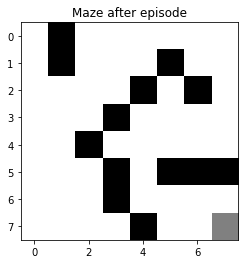

Epoch: 963/999 | Loss: 0.0002 | Episodes: 964 | Win count: 944 | Win rate: 1.000 | time: 2.10 hours
Loss:  9.234974459104706e-05
Loss:  0.00013568582653533667
Loss:  0.0001557614577905042
Loss:  0.00037619462818838656
Loss:  0.00028518878389149904
Loss:  0.00030164249619701877
Loss:  0.00013916721218265593
Loss:  0.00016121590488182846
Loss:  0.0002904880057030823
Loss:  0.00035777858283836395
Loss:  0.00017391594155924395
Loss:  0.00042954657692462206
Loss:  0.00034877749567385763
Loss:  0.00018870505300583318


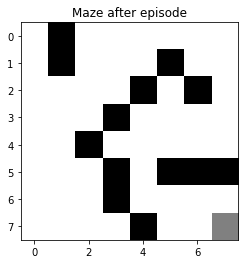

Epoch: 964/999 | Loss: 0.0002 | Episodes: 965 | Win count: 945 | Win rate: 1.000 | time: 2.10 hours
Loss:  0.0005038492963649333
Loss:  0.00018302865464647766
Loss:  0.0003580747070373036
Loss:  7.134454972401727e-05
Loss:  0.0002258013882965315
Loss:  0.00017928765009855852
Loss:  0.0002539160232117865
Loss:  0.0001670465208007954
Loss:  0.0003517175937304273
Loss:  9.828817928791977e-05
Loss:  0.00017437072165193968
Loss:  0.00042280281195417047
Loss:  0.00037760104169137776
Loss:  0.0002642831350385677
Loss:  0.0001894868564704666
Loss:  0.00028840702725574374
Loss:  0.0003270076122134924
Loss:  0.000206607706786599
Loss:  0.00027055888494942337
Loss:  0.00041418241744395345
Loss:  0.0003773694552364759
Loss:  0.0003597699324018322
Loss:  0.0002958298719022423
Loss:  0.0002085333690047264
Loss:  0.000289552361209644
Loss:  6.032243254594505e-05
Loss:  0.0002100545898429118
Loss:  0.00029438978526741266
Loss:  9.230414070771076e-05
Loss:  0.00013579032020061277


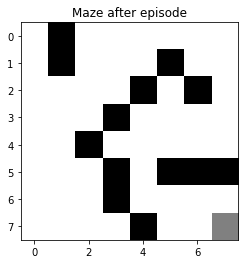

Epoch: 965/999 | Loss: 0.0001 | Episodes: 966 | Win count: 946 | Win rate: 1.000 | time: 2.10 hours
Loss:  0.00031711954216007143
Loss:  0.00038397622120101005
Loss:  0.00012264764518477023
Loss:  9.091479296330363e-05
Loss:  3.905555058736354e-05
Loss:  0.0005423152906587347
Loss:  0.0003856871626339853
Loss:  0.00038357763696694747
Loss:  7.10977128619561e-05
Loss:  7.642990931344684e-05
Loss:  0.0002467390877427533
Loss:  0.00018195560915046372
Loss:  0.0003667090641101822
Loss:  0.0003370427330082748


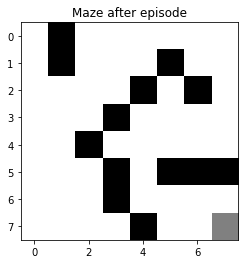

Epoch: 966/999 | Loss: 0.0003 | Episodes: 967 | Win count: 947 | Win rate: 1.000 | time: 2.10 hours
Loss:  0.0001159622952400241
Loss:  0.00028872216353192925
Loss:  0.00026758824969874695
Loss:  9.913669782690704e-05
Loss:  0.00027316265004628804
Loss:  0.00016748831785662333
Loss:  0.00027243369549978524
Loss:  0.0002446373619022779
Loss:  0.0001008399067359278
Loss:  0.0003577165480237454
Loss:  0.0004430979060998652
Loss:  0.00010376647333032452
Loss:  0.0006163361831568182
Loss:  0.00034596610930748284
Loss:  8.482262273901142e-05
Loss:  0.0003911867424903903
Loss:  0.0005480859108502045
Loss:  0.0002568923300714232
Loss:  0.00011175711915711872
Loss:  0.00025750764507392887
Loss:  0.0004444183432497084
Loss:  0.0004336160345701501
Loss:  0.0001886360623757355
Loss:  0.000323450964060612
Loss:  5.5990296459640376e-05
Loss:  8.07680407888256e-05
Loss:  0.0008627772913314402
Loss:  0.0006457835697801784
Loss:  0.00024612720153527334
Loss:  0.000494291220093146
Loss:  0.0002427117942

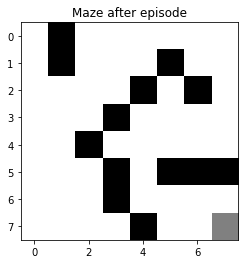

Epoch: 967/999 | Loss: 0.0003 | Episodes: 968 | Win count: 948 | Win rate: 1.000 | time: 2.10 hours
Loss:  0.0004291023069527
Loss:  0.0001866670500021428
Loss:  0.0004885107045993209
Loss:  0.0003265068771725055
Loss:  0.0004903507215203717
Loss:  0.0002723114885156974
Loss:  7.93041181168519e-05
Loss:  0.00025896868464769796
Loss:  0.00025520216513541527
Loss:  9.189327101921663e-05
Loss:  0.0004716865223599598
Loss:  0.0001071370170393493
Loss:  0.00017028882939484902
Loss:  0.0006241993978619576
Loss:  0.000961416692007333
Loss:  0.0005565304854826536
Loss:  0.00042737010517157614
Loss:  0.0004659960250137374


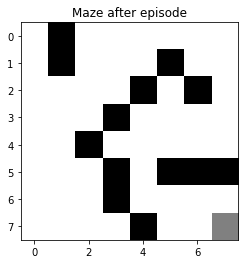

Epoch: 968/999 | Loss: 0.0005 | Episodes: 969 | Win count: 949 | Win rate: 1.000 | time: 2.10 hours
Loss:  0.0002232673577964306
Loss:  0.0005377900670282543
Loss:  0.000300986401271075
Loss:  0.00016712868819013238
Loss:  0.00047351402463391423
Loss:  0.0003277934592915699
Loss:  0.0002450340962241171


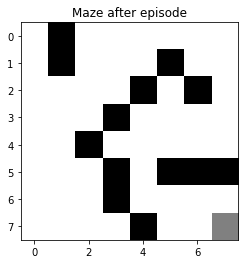

Epoch: 969/999 | Loss: 0.0002 | Episodes: 970 | Win count: 950 | Win rate: 1.000 | time: 2.10 hours
Loss:  0.0003733918856596574


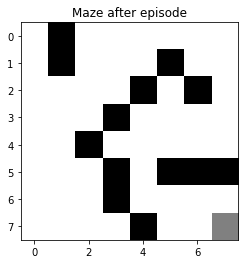

Epoch: 970/999 | Loss: 0.0004 | Episodes: 971 | Win count: 951 | Win rate: 1.000 | time: 2.10 hours
Loss:  0.00013346103514777496
Loss:  0.0002055039039987605
Loss:  0.0005106810858706012
Loss:  0.0002275548904435709
Loss:  0.00013660000331583433
Loss:  0.00023165704624261707
Loss:  5.506135676114354e-05
Loss:  0.0001762170431902632
Loss:  0.0005475054203998297
Loss:  0.0002968024491565302
Loss:  0.0006183625373523682
Loss:  0.0001420699481968768
Loss:  0.0003778803366003558
Loss:  9.070257874554954e-05
Loss:  0.00047900892968755215
Loss:  0.00048715504817664623
Loss:  0.0004186082660453394
Loss:  0.000336938988766633
Loss:  0.0001781651662895456
Loss:  0.000517556065460667
Loss:  0.0002825109986588359
Loss:  0.00035512499744072556
Loss:  0.000136285165353911
Loss:  0.0003268083237344399
Loss:  0.0003588199324440211
Loss:  0.0002084652878693305
Loss:  0.0005804060347145423
Loss:  0.0003312570188427344


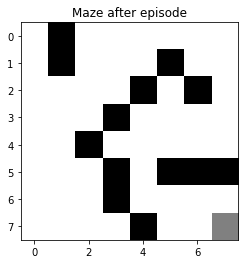

Epoch: 971/999 | Loss: 0.0003 | Episodes: 972 | Win count: 952 | Win rate: 1.000 | time: 2.10 hours
Loss:  0.0002853735495591536
Loss:  0.00010438490426167846
Loss:  0.0006043377507012337
Loss:  0.0003860416036332026
Loss:  0.00029622617876157165
Loss:  0.00032891036244109273
Loss:  0.00019134244939778
Loss:  0.0002793283165374305
Loss:  0.00032127996382769197
Loss:  0.00038898925413377583
Loss:  0.0005595255788648501
Loss:  0.00037042270560050383
Loss:  0.00070114282425493
Loss:  0.0003164581139571965
Loss:  0.00026725142379291356
Loss:  0.00027905480237677693
Loss:  0.000406428036512807
Loss:  0.0005365156685002148
Loss:  0.00037648851866833866
Loss:  0.00045378541108220816
Loss:  0.00024321758246514946
Loss:  0.00024266160471597686
Loss:  0.00036426975566428155
Loss:  0.0003606151876738295
Loss:  0.0002768235863186419


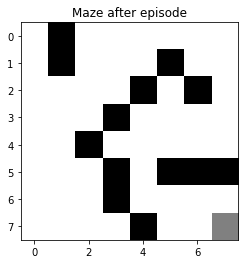

Epoch: 972/999 | Loss: 0.0003 | Episodes: 973 | Win count: 953 | Win rate: 1.000 | time: 2.11 hours
Loss:  0.0004810332757188007
Loss:  0.00037234436604194343
Loss:  4.732812703878153e-05
Loss:  0.0004923090018564835
Loss:  0.0003863127203658223
Loss:  6.782247146475129e-05
Loss:  6.111399306973908e-05
Loss:  0.0006282807444222271
Loss:  0.0005736157181672752
Loss:  0.0004155064816586673
Loss:  0.00032049159926827997
Loss:  0.0002584662288427353
Loss:  0.0006121215119492263
Loss:  0.0002200692251790315
Loss:  0.00047428454854525626
Loss:  0.000268987103481777
Loss:  0.00038900224899407476
Loss:  0.00026861432706937194
Loss:  0.0006911848031450063
Loss:  0.00033946520125027746
Loss:  0.000632348150247708
Loss:  0.00022379129222827032
Loss:  0.00047485216055065393
Loss:  0.0005523131403606385
Loss:  0.0003022216187673621
Loss:  0.00032768443634267896
Loss:  0.00030111676460364833
Loss:  0.0003594239242374897


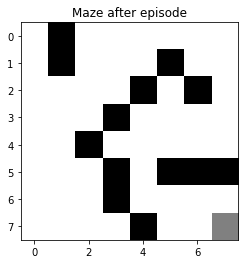

Epoch: 973/999 | Loss: 0.0004 | Episodes: 974 | Win count: 954 | Win rate: 1.000 | time: 2.11 hours
Loss:  0.0005420553497970104
Loss:  0.00016709041665308177
Loss:  0.00036322581581771374
Loss:  0.00038146333827171475
Loss:  0.0005914602515986189
Loss:  0.0003238620556658134
Loss:  0.0003350595143274404
Loss:  0.0003353630017954856
Loss:  0.0003967894008383155
Loss:  0.000632893672445789
Loss:  7.940344221424311e-05
Loss:  0.0001949875004356727
Loss:  6.859286804683506e-05
Loss:  0.0002072855641017668
Loss:  0.0008286687079817057
Loss:  0.00042607173963915557
Loss:  0.000463718970422633
Loss:  0.0004278695851098746
Loss:  0.0004760257579619065
Loss:  0.00047060275755939074
Loss:  0.0004477109614526853
Loss:  0.00026497174985706806
Loss:  0.00026624452948453836
Loss:  0.0001529403598397039
Loss:  0.0004072524607181549
Loss:  0.0004014038495370187
Loss:  9.664809113019146e-05
Loss:  0.00041836265882011503
Loss:  0.0004861208435613662


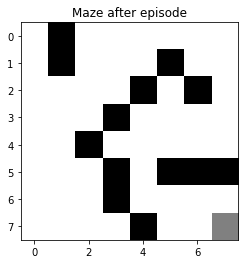

Epoch: 974/999 | Loss: 0.0005 | Episodes: 975 | Win count: 955 | Win rate: 1.000 | time: 2.11 hours
Loss:  9.876999683910981e-05
Loss:  5.458071063912939e-05
Loss:  0.0005798713536933064
Loss:  0.00034359327401034534
Loss:  0.00040590090793557465
Loss:  0.00022770112627767958
Loss:  0.0004850646510021761
Loss:  0.00010088579801958986
Loss:  0.00030301432343549095
Loss:  0.00032417824695585296
Loss:  0.00011401812662370503
Loss:  0.00025497848400846124
Loss:  0.0002904318680521101
Loss:  0.0006362175336107612
Loss:  0.0003760697290999815
Loss:  0.0007787644572090358
Loss:  0.00047429984260816127
Loss:  0.0003940829337807372
Loss:  0.0005721910201827995
Loss:  0.0005565672763623297
Loss:  0.00023664724358241074
Loss:  0.0003885955666191876
Loss:  0.000344610249157995
Loss:  0.00032006128458306193


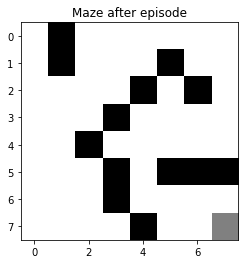

Epoch: 975/999 | Loss: 0.0003 | Episodes: 976 | Win count: 956 | Win rate: 1.000 | time: 2.11 hours
Loss:  0.000579455416300334
Loss:  0.0005392353923525661
Loss:  0.00032418466435046867
Loss:  0.00038313221011776477
Loss:  0.00018714441830525175


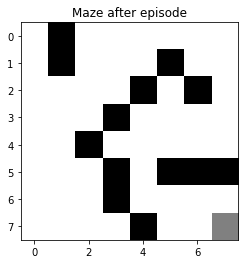

Epoch: 976/999 | Loss: 0.0002 | Episodes: 977 | Win count: 957 | Win rate: 1.000 | time: 2.11 hours
Loss:  0.0006302651017904282
Loss:  0.00028808624847442843
Loss:  0.0003409782802918926
Loss:  0.00046664934416185133
Loss:  0.0005053273416706361
Loss:  0.0005780342034995556


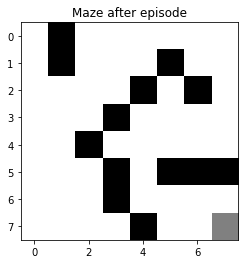

Epoch: 977/999 | Loss: 0.0006 | Episodes: 978 | Win count: 958 | Win rate: 1.000 | time: 2.11 hours
Loss:  0.00034227013384224847


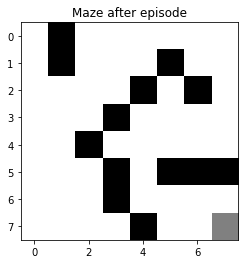

Epoch: 978/999 | Loss: 0.0003 | Episodes: 979 | Win count: 959 | Win rate: 1.000 | time: 2.11 hours
Loss:  0.00010242450298392214
Loss:  0.0005306191160343587
Loss:  0.00035523829865269363
Loss:  0.000270042110059876
Loss:  0.0006434724782593548
Loss:  0.0004133851907681674
Loss:  0.00015505474584642798
Loss:  0.0003690949670271948
Loss:  0.0005309574626153335
Loss:  0.00044147543667349964
Loss:  0.0006133007118478417
Loss:  0.00011700546747306362
Loss:  0.00010050439959741198
Loss:  0.0003092259794357233
Loss:  0.0003428073541726917
Loss:  0.00028725163429044187
Loss:  0.0003565102524589747
Loss:  0.000757755187805742
Loss:  0.0002056767261819914
Loss:  0.0003328864695504308
Loss:  7.166919749579392e-05
Loss:  0.0005097038520034403
Loss:  0.0006141188787296414
Loss:  0.0005350089340936393
Loss:  0.0011849012225866318
Loss:  0.00025955282035283744
Loss:  0.0006254150794120505
Loss:  0.0008015281055122614
Loss:  0.0006085397471906617
Loss:  0.0003418468404561281
Loss:  0.000554403552087

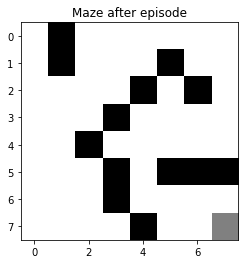

Epoch: 979/999 | Loss: 0.0001 | Episodes: 980 | Win count: 960 | Win rate: 1.000 | time: 2.11 hours
Loss:  0.0005516238743439317
Loss:  0.0002581408843980171
Loss:  0.0003546961524989456
Loss:  0.0003756138030439615
Loss:  0.00018478462152415887
Loss:  0.0005963206931483
Loss:  0.000539686341653578
Loss:  0.00043082504998892546
Loss:  0.0003054887492908165


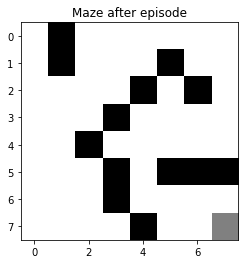

Epoch: 980/999 | Loss: 0.0003 | Episodes: 981 | Win count: 961 | Win rate: 1.000 | time: 2.11 hours
Loss:  0.00046730577014386654


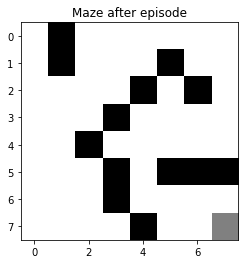

Epoch: 981/999 | Loss: 0.0005 | Episodes: 982 | Win count: 962 | Win rate: 1.000 | time: 2.11 hours
Loss:  0.0003274810442235321
Loss:  0.00046305684372782707
Loss:  0.0002780277281999588
Loss:  0.00011896325668203644
Loss:  0.00023878431238699704
Loss:  0.00047826878289924935
Loss:  0.0005426198476925492
Loss:  0.00034724910801742226
Loss:  0.00010077984188683331
Loss:  0.00020197490084683523
Loss:  0.0003764007706195116
Loss:  0.00030137562862364575
Loss:  0.000978732598014176
Loss:  0.0005308793770382181
Loss:  0.0003281773824710399
Loss:  0.0001610400122444844
Loss:  0.0007307467458304018
Loss:  0.0001568439693073742
Loss:  0.0005044113349867985
Loss:  0.00028043357451679185
Loss:  0.0003013011591974646
Loss:  0.0006876693514641374
Loss:  0.0005150968790985644
Loss:  0.0006928028888069093
Loss:  0.0006747414299752563
Loss:  0.0003793626819970086


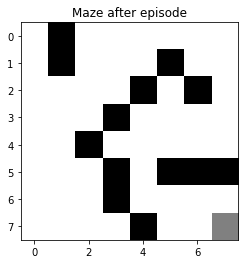

Epoch: 982/999 | Loss: 0.0004 | Episodes: 983 | Win count: 963 | Win rate: 1.000 | time: 2.11 hours
Loss:  0.000300234547466971


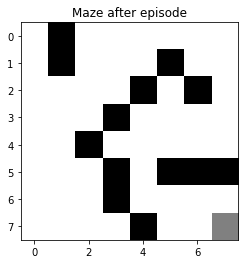

Epoch: 983/999 | Loss: 0.0003 | Episodes: 984 | Win count: 964 | Win rate: 1.000 | time: 2.11 hours
Loss:  0.0003971602418459952
Loss:  0.0002449074818287045
Loss:  0.0004266640462446958
Loss:  0.0005046644510002807
Loss:  0.00036152613756712526
Loss:  0.0005678632878698409
Loss:  0.0004253166407579556
Loss:  0.0003618355403887108
Loss:  0.0003682461683638394


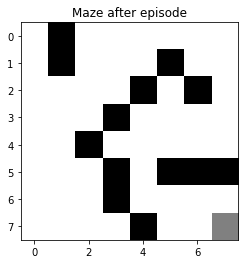

Epoch: 984/999 | Loss: 0.0004 | Episodes: 985 | Win count: 965 | Win rate: 1.000 | time: 2.11 hours
Loss:  9.920788943418302e-05
Loss:  0.0004939360514981672
Loss:  0.0002844283517333679
Loss:  0.0002459813840687275
Loss:  0.000643679712084122
Loss:  0.00018847461979021318
Loss:  0.0008910529140848666
Loss:  0.00046820053830742836


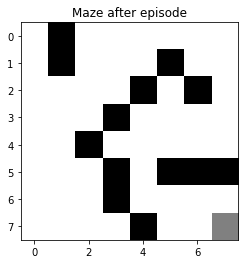

Epoch: 985/999 | Loss: 0.0005 | Episodes: 986 | Win count: 966 | Win rate: 1.000 | time: 2.12 hours
Loss:  0.00044869340490549803
Loss:  0.00044927811541128904
Loss:  0.0002445119171170518
Loss:  0.00022346380137605593
Loss:  0.00038983476406428963
Loss:  0.0006054122641216964
Loss:  0.0004363288317108527
Loss:  0.0003364978911122307
Loss:  0.0003428637719480321
Loss:  0.00026179961059824564
Loss:  0.000528240081621334


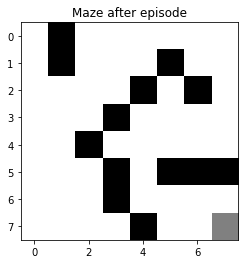

Epoch: 986/999 | Loss: 0.0005 | Episodes: 987 | Win count: 967 | Win rate: 1.000 | time: 2.12 hours
Loss:  0.000635856413282454
Loss:  0.00048726725799497217
Loss:  0.0004969429865013808
Loss:  0.00041532393152010627
Loss:  0.00037011606036685407
Loss:  0.0006595149461645633
Loss:  0.00047743738105054945
Loss:  0.000692962552420795
Loss:  0.0003543754901329521
Loss:  0.000546567200217396
Loss:  0.0009721218521008268
Loss:  0.000643689330900088
Loss:  0.00025628291768953204
Loss:  0.0004539587680483237
Loss:  0.0004986171770724468
Loss:  0.0005265315703582019
Loss:  0.00044904352762387134
Loss:  0.0007007683161646128
Loss:  0.0005236023425823078
Loss:  0.0005146260664332658
Loss:  0.0006097401201259345
Loss:  0.0002608378490549512
Loss:  0.0005713902064599097
Loss:  0.0003257419230067171
Loss:  0.0005220203966018744
Loss:  0.0006454868707805872
Loss:  0.000245980299951043
Loss:  0.000642562925349921
Loss:  0.00018282408564118668
Loss:  0.0005481060070451349
Loss:  0.0006287769938353449


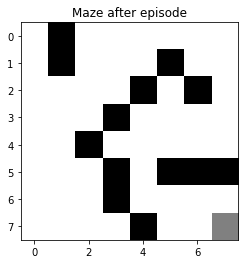

Epoch: 987/999 | Loss: 0.0003 | Episodes: 988 | Win count: 968 | Win rate: 1.000 | time: 2.12 hours
Loss:  0.00027114841213915497
Loss:  0.0004264456802047789
Loss:  0.0005090759805170819


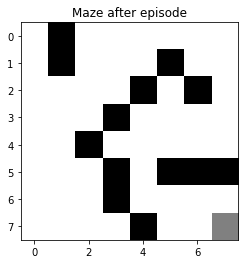

Epoch: 988/999 | Loss: 0.0005 | Episodes: 989 | Win count: 969 | Win rate: 1.000 | time: 2.12 hours
Loss:  0.0005884275597054511
Loss:  0.0006008266936987638
Loss:  0.0002606117632240057
Loss:  0.0007868592656450346
Loss:  0.00044740202065440826
Loss:  0.00035952290636487305
Loss:  0.0006845057650934905
Loss:  0.0006692341121379286
Loss:  0.0006101776816649362
Loss:  0.0002702155543374829
Loss:  0.0006617937178816646
Loss:  0.0005363584205042571
Loss:  0.0004749399231513962
Loss:  0.00038643626612611115
Loss:  0.0004657111276173964
Loss:  0.0005105035234009847
Loss:  0.0005594746908172965
Loss:  0.0005308926338329911
Loss:  0.0011707160738296807
Loss:  0.000500073962030001
Loss:  0.0007097009802237153
Loss:  0.00025219381495844573
Loss:  0.0005683750059688464
Loss:  0.0008776714385021478
Loss:  0.0005243222694844007


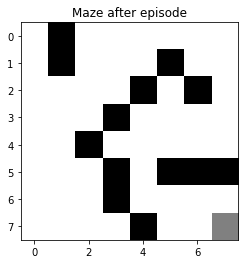

Epoch: 989/999 | Loss: 0.0005 | Episodes: 990 | Win count: 970 | Win rate: 1.000 | time: 2.12 hours
Loss:  0.0007729944481980056
Loss:  0.0006698875804431736
Loss:  0.0006349593313643709
Loss:  0.0010851698461920023
Loss:  0.0007102105300873518
Loss:  0.00023007242270978168
Loss:  0.0006623570952797309
Loss:  0.0006608764815609902
Loss:  0.00048054424405563623
Loss:  0.0004616062215063721
Loss:  0.0004233252111589536
Loss:  0.00028795021353289485
Loss:  0.00013581971143139526
Loss:  0.0005118651170050725
Loss:  0.0005340561983757652
Loss:  0.00023394390882458538
Loss:  0.0005511285708053038
Loss:  0.0004406209773151204
Loss:  0.0002020788233494386
Loss:  0.0004532819293672219
Loss:  0.0006291810714174062
Loss:  0.0003513757837936282
Loss:  0.0004268463744665496
Loss:  0.00011049170643673278
Loss:  0.00028683185519184917
Loss:  0.0002637163706822321
Loss:  0.000446078463937738
Loss:  0.0007278267585206777
Loss:  0.00019856871949741617
Loss:  0.0003225240361643955


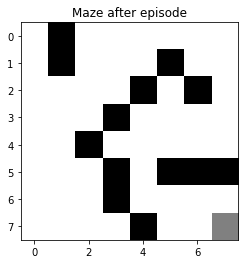

Epoch: 990/999 | Loss: 0.0003 | Episodes: 991 | Win count: 971 | Win rate: 1.000 | time: 2.12 hours
Loss:  0.00034043726373056415
Loss:  0.0006588436663150787
Loss:  0.0002585211768746376
Loss:  0.0004615972429746762
Loss:  0.0002898366074077785
Loss:  8.858928413246758e-05
Loss:  0.0004200945404591039
Loss:  0.0004779071605298668
Loss:  0.0003966467556892894
Loss:  0.00043091276893392205


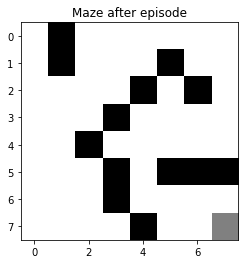

Epoch: 991/999 | Loss: 0.0004 | Episodes: 992 | Win count: 972 | Win rate: 1.000 | time: 2.12 hours
Loss:  0.0002705519873416051
Loss:  0.00020164042871329002
Loss:  0.00046184431994333863
Loss:  0.0003018248899024911
Loss:  0.0006590810662601143
Loss:  0.00028149931313237175
Loss:  0.0005772305012214929
Loss:  0.0004918620543321595
Loss:  0.0005180618427402806
Loss:  0.0006707942520733923
Loss:  0.0003543771745171398
Loss:  0.0001930774305947125
Loss:  0.0004143279365962371
Loss:  0.0007119766669347882
Loss:  0.0005934071814408526
Loss:  0.0003978857566835359
Loss:  0.00043051083048339933
Loss:  0.0003395977328182198
Loss:  0.0006059200677555054
Loss:  0.0006234376924112439
Loss:  0.00032884436222957447
Loss:  0.00020858152129221708
Loss:  0.0005391695740399882
Loss:  0.0012165212538093328


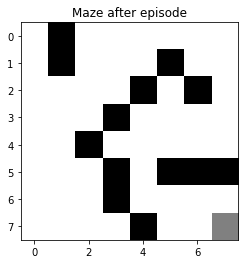

Epoch: 992/999 | Loss: 0.0012 | Episodes: 993 | Win count: 973 | Win rate: 1.000 | time: 2.12 hours
Loss:  0.0006806173914810643
Loss:  0.00046373007353395224
Loss:  0.00047507727867923677
Loss:  0.00034485955256968737
Loss:  0.0007230421324493363
Loss:  0.0002457106420479249
Loss:  0.00041344469354953617
Loss:  0.0006628094997722656
Loss:  0.0002449734747642651
Loss:  0.0005898780073039234
Loss:  0.00047273110249079764
Loss:  0.0006386025343090296
Loss:  0.00023529583995696157
Loss:  0.0003573715075617656
Loss:  0.0003794753865804523
Loss:  0.0003367199678905308
Loss:  0.00037346919998526573


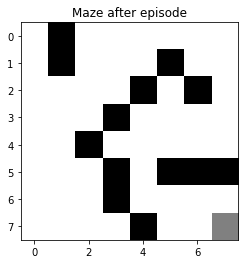

Epoch: 993/999 | Loss: 0.0004 | Episodes: 994 | Win count: 974 | Win rate: 1.000 | time: 2.12 hours
Loss:  0.0006004571077937726
Loss:  0.0006571316771442071
Loss:  0.00031317004322772846
Loss:  0.0005102558934595436
Loss:  0.00045396634959615767
Loss:  0.00022919211914995685
Loss:  0.0005835688498336822
Loss:  0.0005985973693896085
Loss:  0.00023776233138050884
Loss:  0.0004845783405471593
Loss:  0.0006450867076637223
Loss:  0.0002780530267045833
Loss:  0.0004942249652231112
Loss:  0.000650943984510377


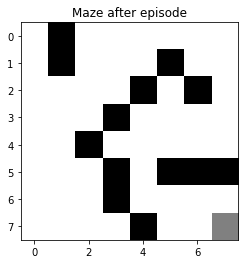

Epoch: 994/999 | Loss: 0.0007 | Episodes: 995 | Win count: 975 | Win rate: 1.000 | time: 2.12 hours
Loss:  0.0005551463691517711
Loss:  0.00017789947742130607
Loss:  0.00023966528169694357
Loss:  0.0005483486311277375
Loss:  0.0004670161579269916


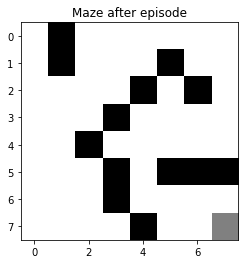

Epoch: 995/999 | Loss: 0.0005 | Episodes: 996 | Win count: 976 | Win rate: 1.000 | time: 2.12 hours
Loss:  0.0005396004999056458
Loss:  0.0009515087294857949
Loss:  0.00023291002071346156
Loss:  0.0003458687860984355
Loss:  0.00042467768071219325
Loss:  0.00018845295562641695
Loss:  0.0003814178053289652
Loss:  0.0006355113000608981
Loss:  0.00035410255077295005
Loss:  0.0005290838453220204
Loss:  0.0005329079576767981
Loss:  0.0008406999695580453
Loss:  0.0005851657333550975
Loss:  0.0003951729740947485
Loss:  0.0006363677966874093
Loss:  0.000431698230386246
Loss:  0.00029627286130562425
Loss:  0.0006587411335203797
Loss:  0.0005169729702174664
Loss:  0.0005574368115048856


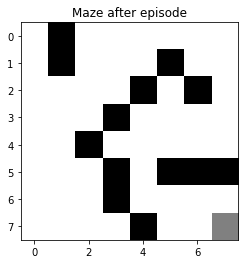

Epoch: 996/999 | Loss: 0.0006 | Episodes: 997 | Win count: 977 | Win rate: 1.000 | time: 2.13 hours
Loss:  0.0005616557027678937
Loss:  0.0005257684388197958
Loss:  0.00022690065088681877
Loss:  0.00033591310784686357
Loss:  0.0007476305472664535
Loss:  0.00036140813608653843
Loss:  0.0005928848258918151
Loss:  0.0005220223974902183
Loss:  0.0003311973559902981
Loss:  0.0003053035034099594
Loss:  0.00017460514209233224
Loss:  0.00021796100190840662
Loss:  0.0005994324674247764
Loss:  0.0007882029458414763
Loss:  0.00043293954513501376
Loss:  0.00023665966728003696
Loss:  8.454525595880114e-05
Loss:  0.0009298794029746205
Loss:  0.0005727919487981126
Loss:  0.0004890348936896771
Loss:  0.0006189266423461959
Loss:  0.0005124206654727459
Loss:  0.0004906213143840432
Loss:  0.0006794766522943974
Loss:  0.00022155353508424014
Loss:  0.00017607778863748536
Loss:  0.0007101207738742232
Loss:  0.000681303848978132
Loss:  0.0004802393523277715
Loss:  0.0006690713053103536
Loss:  0.0002600355001

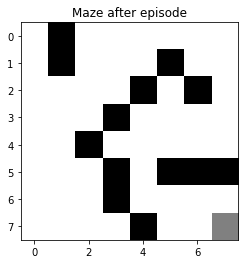

Epoch: 997/999 | Loss: 0.0004 | Episodes: 998 | Win count: 978 | Win rate: 1.000 | time: 2.13 hours
Loss:  0.0004688009503297508
Loss:  0.00025769081548787653
Loss:  0.0004687650070991367
Loss:  0.0004827528027817607
Loss:  0.0006623219669563696
Loss:  0.0004090259171789512
Loss:  0.00028701871633529663
Loss:  0.0002707098683458753
Loss:  0.0006147725362097844
Loss:  0.000630922761047259
Loss:  0.00033315506880171597
Loss:  0.000318901555147022
Loss:  0.000567129289265722
Loss:  0.0006246644479688257
Loss:  0.0006029240321367979
Loss:  0.00040975848969537765
Loss:  0.0006385382148437202
Loss:  0.0003942553448723629
Loss:  0.0002671191468834877
Loss:  0.0007371573738055304
Loss:  0.000675501927617006
Loss:  0.0008540819981135428
Loss:  0.00044126311695436016
Loss:  0.0004784744814969599
Loss:  0.0003069653612328693
Loss:  0.0006883566384203732
Loss:  0.0003157776081934571
Loss:  0.0006521632603835315
Loss:  0.0007375571585725993
Loss:  0.000661175639834255
Loss:  0.0006486589554697275


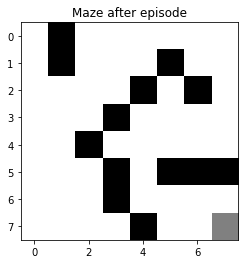

Epoch: 998/999 | Loss: 0.0006 | Episodes: 999 | Win count: 979 | Win rate: 1.000 | time: 2.13 hours
Loss:  0.0004176680522505194
Loss:  0.0005816489574499428
Loss:  0.00025207587896147743
Loss:  0.0004671304996008985
Loss:  0.0007575312629342079
Loss:  0.0005502378626260906
Loss:  0.0006871614023111761


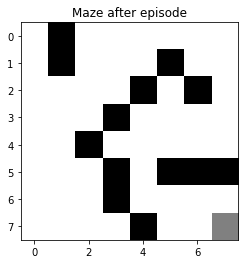

Epoch: 999/999 | Loss: 0.0007 | Episodes: 1000 | Win count: 980 | Win rate: 1.000 | time: 2.13 hours
n_epoch: 999, max_mem: 512, data: 64, time: 2.13 hours


7666.515499

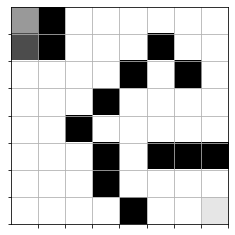

In [22]:
model = build_model(maze)
qtrain(model, maze, n_epoch=1000, max_memory=8*maze.size, data_size=64)


This cell will check to see if the model passes the completion check. Note: This could take several minutes.

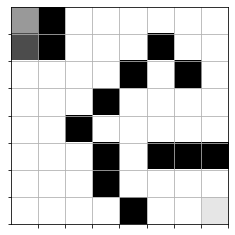

In [23]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

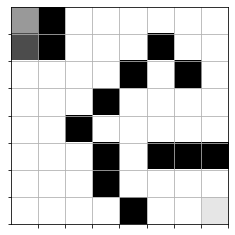

In [24]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.